In [2]:
from matplotlib.pylab import *
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi

In [3]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook

Car-trailer diagram (inverted image `car-trainer-k.png` available as well):
![car-trailer](car-trailer-w.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

In [4]:
class Truck:
    def __init__(self, display=False):

        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        
        self.box = [0, 40, -10, 10]
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none')
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black')
            self.patches = list()
            
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0] - 1, b[1], b[2], b[3]])
            self.ax.set_xticks([], []); self.ax.set_yticks([], [])
            self.ax.axhline(); self.ax.axvline()

        self.reset()
    
    def reset(self, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = (random() * .75 + 0.25) * self.box[1]
        self.y = (random() - 0.5) * (self.box[3] - self.box[2])
        
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        self.ϕ = ϕ
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, *self._traler_xy(), self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _traler_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._traler_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

<IPython.core.display.Javascript object>


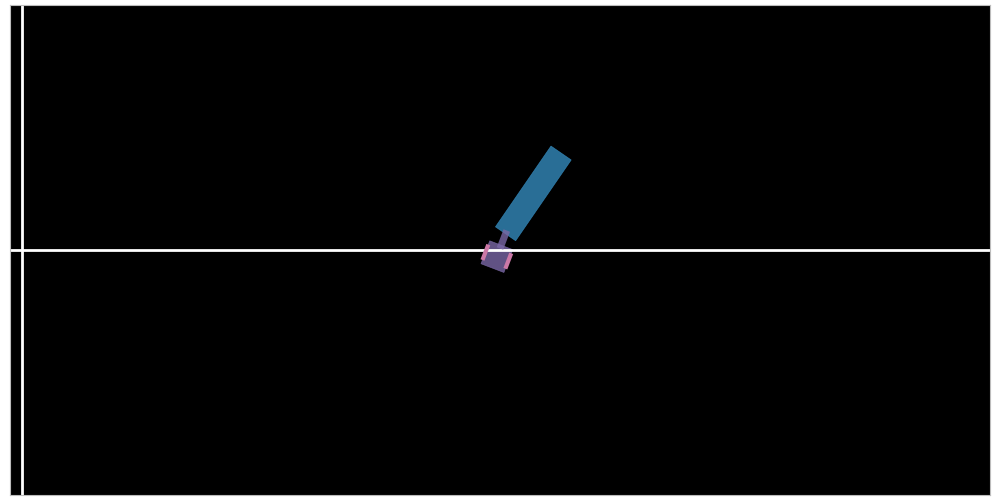

In [5]:
truck = Truck(display=True)

In [5]:
ϕ = deg2rad(-35)  # positive left, negative right
truck.step(ϕ)
truck.draw()

In [57]:
truck.reset()

In [105]:
# uncomment and run after training the truck backer upper model to test
    
truck.reset()
truck_model.eval()
initial_state = truck.state()
with torch.no_grad():
    sequence = truck_model(torch.tensor(initial_state).to(device))
step = 6 # control sequence starts at poisition 6

while truck.valid():
    if step > 10:
        sequence = truck_model(torch.tensor(truck.state()).to(device))
        step = 6
    move = sequence[step].item()
    print(move)
    truck.step(move)
    truck.draw()
    step += 1
print(sequence)
print(f"predicted final state: {sequence[0:6]}")
print(f"actual final state: {truck.state()}")

-0.8384699821472168
-0.470412015914917
0.23975813388824463
-0.5167474746704102
0.12568330764770508
-0.8255187273025513
-0.45225781202316284
0.22560226917266846
-0.5169757604598999
0.12961959838867188
-0.8112282752990723
-0.4320855736732483
0.20915734767913818
-0.5177890658378601
0.1346731185913086
-0.7960904240608215
-0.4101506471633911
0.19021177291870117
-0.5190256834030151
0.1408323049545288
-0.7803490161895752
-0.3874254822731018
0.16879582405090332
-0.5206810235977173
0.1481037139892578
-0.7643699049949646
-0.3651520609855652
tensor([[ 1.6145],
        [ 1.2567],
        [ 0.6209],
        ...,
        [-0.1114],
        [ 0.0327],
        [-0.1479]], device='cuda:0', grad_fn=<CatBackward>)
predicted final state: tensor([[1.6145],
        [1.2567],
        [0.6209],
        [1.5973],
        [1.2424],
        [0.5891]], device='cuda:0', grad_fn=<SliceBackward>)
actual final state: (22.727553006373444, -7.365348988876832, 1.4527709732244907, 19.76461160817612, -10.052536788575337, 

In [6]:
import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [7]:
truck = Truck();

In [8]:
# Build expert data set

# episodes = 10
inputs = list()
outputs = list()
truck = Truck(); episodes = 100_000  # uncooment for creating the data set

for episode in tqdm(range(episodes)):
    
    truck.reset()
    
    while truck.valid():
        initial_state = truck.state()
        ϕ = (random() - 0.5) * π / 2
        inputs.append((ϕ, *initial_state))
        outputs.append(truck.step(ϕ))
        truck.draw()

  9%|▉         | 9000/100000 [00:15<02:29, 607.12it/s]

KeyboardInterrupt: 

In [1]:
len(inputs), len(outputs)

NameError: name 'inputs' is not defined

In [8]:
state_size = 6
steering_size = 1
hidden_units_e = 45

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.005)
criterion = nn.MSELoss()

emulator = emulator.to(device)

In [9]:
tensor_inputs = torch.Tensor(inputs)
tensor_outputs = torch.Tensor(outputs)

NameError: name 'inputs' is not defined

In [10]:
tensor_inputs = torch.load('tensor_inputs.pt')
tensor_outputs = torch.load('tensor_outputs.pt')

In [11]:
torch.save(tensor_inputs, 'tensor_inputs.pt')
torch.save(tensor_outputs, 'tensor_outputs.pt')

In [11]:
mean = tensor_inputs.mean(0)
std = tensor_inputs.std(0)
tensor_inputs = (tensor_inputs - mean) / std
tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [12]:
# Split the data into 80:20 for test:train.
test_size = int(len(tensor_inputs) * 0.8)
print(len(tensor_inputs), test_size)

train_inputs = tensor_inputs[:test_size]
train_outputs = tensor_outputs[:test_size]
test_inputs = tensor_inputs[test_size:]
test_outputs = tensor_outputs[test_size:]

5977851 4782280


In [13]:
train_inputs = torch.load('train_inputs.pt')
train_outputs = torch.load('train_outputs.pt')
test_inputs = torch.load('test_inputs.pt')
test_outputs = torch.load('test_outputs.pt')


# torch.save(train_inputs, 'train_inputs.pt')
# torch.save(train_outputs, 'train_outputs.pt')
# torch.save(test_inputs, 'test_inputs.pt')
# torch.save(test_outputs, 'test_outputs.pt')

train_inputs = Variable(train_inputs.to(device), requires_grad=True) # add gradients so that we can backprop
train_outputs = Variable(train_outputs.to(device), requires_grad=True)


In [14]:
len(train_inputs)

4782280

In [635]:
# Train... BUG! Can you spot it?
# What is one of the main assumptions for training a net?



emulator.train()
cnt = 0
batch_size = 100
for i in torch.randperm(len(train_inputs)):
    
    loss_e = 0

    ϕ_state = train_inputs[i]
    next_state_prediction = emulator(ϕ_state)

    next_state = train_outputs[i]
    loss_e += criterion(next_state_prediction, next_state)
        
        
    if cnt == 0 or (cnt + 1) % batch_size == 0: # split the dataset into batches
        optimiser_e.zero_grad()
        loss_e = loss_e / batch_size
        loss_e.backward()
        
        optimiser_e.step()
    
    if cnt == 0 or (cnt + 1) % batch_size == 0:
            print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss_e.item():.10f}')
            
    cnt += 1    

       

   1 / 4782280, 0.0960915610
 100 / 4782280, 0.0778003559
 200 / 4782280, 0.0799166262
 300 / 4782280, 0.0817426592
 400 / 4782280, 0.0399991684
 500 / 4782280, 0.0756267756
 600 / 4782280, 0.0082413256
 700 / 4782280, 0.0436197929
 800 / 4782280, 0.1711141914
 900 / 4782280, 0.1026929989
1000 / 4782280, 0.1844608635
1100 / 4782280, 0.0406925902
1200 / 4782280, 0.0965136886
1300 / 4782280, 0.0145804351
1400 / 4782280, 0.0368079692
1500 / 4782280, 0.0211155545
1600 / 4782280, 0.0612458922
1700 / 4782280, 0.1173024699
1800 / 4782280, 0.0584666096
1900 / 4782280, 0.0313679576
2000 / 4782280, 0.0920384452
2100 / 4782280, 0.0794717073
2200 / 4782280, 0.0114741670
2300 / 4782280, 0.0037277166
2400 / 4782280, 0.0666690394
2500 / 4782280, 0.0273354091
2600 / 4782280, 0.0856449977
2700 / 4782280, 0.0666839033
2800 / 4782280, 0.0567219630
2900 / 4782280, 0.0639003441
3000 / 4782280, 0.0224220753
3100 / 4782280, 0.0449245125
3200 / 4782280, 0.0751458034
3300 / 4782280, 0.0737967938
3400 / 4782280

28800 / 4782280, 0.1286245286
28900 / 4782280, 0.0735042468
29000 / 4782280, 0.0677897185
29100 / 4782280, 0.0749761239
29200 / 4782280, 0.0107940696
29300 / 4782280, 0.0772025213
29400 / 4782280, 0.0314514078
29500 / 4782280, 0.0732998401
29600 / 4782280, 0.0287840962
29700 / 4782280, 0.0038466954
29800 / 4782280, 0.0697499588
29900 / 4782280, 0.0698027611
30000 / 4782280, 0.1190811098
30100 / 4782280, 0.0503751189
30200 / 4782280, 0.0521897599
30300 / 4782280, 0.0600494817
30400 / 4782280, 0.0227712132
30500 / 4782280, 0.0300481617
30600 / 4782280, 0.0070227413
30700 / 4782280, 0.0236074273
30800 / 4782280, 0.1035532951
30900 / 4782280, 0.0479709134
31000 / 4782280, 0.0590181574
31100 / 4782280, 0.1342628598
31200 / 4782280, 0.0210045017
31300 / 4782280, 0.0685847327
31400 / 4782280, 0.0904569253
31500 / 4782280, 0.0277685132
31600 / 4782280, 0.0044716457
31700 / 4782280, 0.0824137181
31800 / 4782280, 0.0988749638
31900 / 4782280, 0.0339008197
32000 / 4782280, 0.0235644095
32100 / 47

57400 / 4782280, 0.0633572638
57500 / 4782280, 0.0310234446
57600 / 4782280, 0.0313551985
57700 / 4782280, 0.0380677246
57800 / 4782280, 0.0935899690
57900 / 4782280, 0.0267253220
58000 / 4782280, 0.0892961323
58100 / 4782280, 0.0399448611
58200 / 4782280, 0.0201065131
58300 / 4782280, 0.0344382152
58400 / 4782280, 0.0520419404
58500 / 4782280, 0.0209989659
58600 / 4782280, 0.0931778327
58700 / 4782280, 0.0198611729
58800 / 4782280, 0.0487729236
58900 / 4782280, 0.0465583839
59000 / 4782280, 0.0685525462
59100 / 4782280, 0.0417238809
59200 / 4782280, 0.0256514512
59300 / 4782280, 0.0798432007
59400 / 4782280, 0.0095567517
59500 / 4782280, 0.1395171583
59600 / 4782280, 0.0303058140
59700 / 4782280, 0.0201243795
59800 / 4782280, 0.0041589164
59900 / 4782280, 0.0722760111
60000 / 4782280, 0.0884055048
60100 / 4782280, 0.0529154949
60200 / 4782280, 0.0309393611
60300 / 4782280, 0.0423801616
60400 / 4782280, 0.0560534410
60500 / 4782280, 0.0519382432
60600 / 4782280, 0.0470751189
60700 / 47

84800 / 4782280, 0.0431680754
84900 / 4782280, 0.0289009325
85000 / 4782280, 0.0183799397
85100 / 4782280, 0.0756266564
85200 / 4782280, 0.0249283258
85300 / 4782280, 0.0356231332
85400 / 4782280, 0.0341013744
85500 / 4782280, 0.1257385761
85600 / 4782280, 0.1025977582
85700 / 4782280, 0.0983937234
85800 / 4782280, 0.0580864325
85900 / 4782280, 0.1080309004
86000 / 4782280, 0.0224749837
86100 / 4782280, 0.0426076502
86200 / 4782280, 0.1159734800
86300 / 4782280, 0.0635320991
86400 / 4782280, 0.0803758428
86500 / 4782280, 0.0161979366
86600 / 4782280, 0.0211284235
86700 / 4782280, 0.0600714870
86800 / 4782280, 0.0370039418
86900 / 4782280, 0.0040431484
87000 / 4782280, 0.0625618473
87100 / 4782280, 0.0275765751
87200 / 4782280, 0.0380582884
87300 / 4782280, 0.0367780551
87400 / 4782280, 0.0567010529
87500 / 4782280, 0.0200188458
87600 / 4782280, 0.0072909445
87700 / 4782280, 0.0317211375
87800 / 4782280, 0.0103621436
87900 / 4782280, 0.0986965001
88000 / 4782280, 0.0519895144
88100 / 47

112400 / 4782280, 0.0388743952
112500 / 4782280, 0.0762868822
112600 / 4782280, 0.0503651276
112700 / 4782280, 0.0371266268
112800 / 4782280, 0.0084809745
112900 / 4782280, 0.0653293431
113000 / 4782280, 0.0054483591
113100 / 4782280, 0.0202672221
113200 / 4782280, 0.0526365414
113300 / 4782280, 0.0557087474
113400 / 4782280, 0.0458868667
113500 / 4782280, 0.0655076057
113600 / 4782280, 0.0120695541
113700 / 4782280, 0.0447594188
113800 / 4782280, 0.0824607611
113900 / 4782280, 0.0050095869
114000 / 4782280, 0.0328572951
114100 / 4782280, 0.0628708601
114200 / 4782280, 0.0736957639
114300 / 4782280, 0.1473833472
114400 / 4782280, 0.0729648098
114500 / 4782280, 0.0742985308
114600 / 4782280, 0.0223370213
114700 / 4782280, 0.0373797268
114800 / 4782280, 0.0478253104
114900 / 4782280, 0.0823603347
115000 / 4782280, 0.0808403865
115100 / 4782280, 0.0219085775
115200 / 4782280, 0.0089130998
115300 / 4782280, 0.0704296976
115400 / 4782280, 0.0598252565
115500 / 4782280, 0.0510880984
115600 /

139900 / 4782280, 0.0425972268
140000 / 4782280, 0.0165162217
140100 / 4782280, 0.0438247733
140200 / 4782280, 0.0079723084
140300 / 4782280, 0.1106983051
140400 / 4782280, 0.0729384124
140500 / 4782280, 0.0545621961
140600 / 4782280, 0.0900302976
140700 / 4782280, 0.0108903227
140800 / 4782280, 0.0611633733
140900 / 4782280, 0.0186874401
141000 / 4782280, 0.0284997392
141100 / 4782280, 0.0070900973
141200 / 4782280, 0.0055491733
141300 / 4782280, 0.0150395827
141400 / 4782280, 0.0082422970
141500 / 4782280, 0.0602699183
141600 / 4782280, 0.0385873355
141700 / 4782280, 0.0472261719
141800 / 4782280, 0.0271945465
141900 / 4782280, 0.1238779202
142000 / 4782280, 0.0429308973
142100 / 4782280, 0.0583966449
142200 / 4782280, 0.0150956223
142300 / 4782280, 0.0257410146
142400 / 4782280, 0.0444516838
142500 / 4782280, 0.0241940692
142600 / 4782280, 0.0665997341
142700 / 4782280, 0.0931566134
142800 / 4782280, 0.0336519703
142900 / 4782280, 0.0661492720
143000 / 4782280, 0.0669237673
143100 /

166600 / 4782280, 0.0280317459
166700 / 4782280, 0.0280738585
166800 / 4782280, 0.0038577388
166900 / 4782280, 0.0357695557
167000 / 4782280, 0.0654259175
167100 / 4782280, 0.0690869093
167200 / 4782280, 0.0194182470
167300 / 4782280, 0.0736212879
167400 / 4782280, 0.0501323529
167500 / 4782280, 0.0091376286
167600 / 4782280, 0.0917969272
167700 / 4782280, 0.0458230376
167800 / 4782280, 0.0703115016
167900 / 4782280, 0.0616950020
168000 / 4782280, 0.0160600934
168100 / 4782280, 0.0511655807
168200 / 4782280, 0.0475366339
168300 / 4782280, 0.0577549301
168400 / 4782280, 0.0812820345
168500 / 4782280, 0.0260121655
168600 / 4782280, 0.0176956337
168700 / 4782280, 0.0087055070
168800 / 4782280, 0.0217456352
168900 / 4782280, 0.0100884484
169000 / 4782280, 0.0779445171
169100 / 4782280, 0.0554774180
169200 / 4782280, 0.0168779548
169300 / 4782280, 0.0222384613
169400 / 4782280, 0.0630759001
169500 / 4782280, 0.0382872373
169600 / 4782280, 0.0617922619
169700 / 4782280, 0.0661138520
169800 /

193900 / 4782280, 0.0371569060
194000 / 4782280, 0.0713606626
194100 / 4782280, 0.0281243324
194200 / 4782280, 0.0363992713
194300 / 4782280, 0.0229403879
194400 / 4782280, 0.0282721557
194500 / 4782280, 0.0612955354
194600 / 4782280, 0.0192222726
194700 / 4782280, 0.0151691306
194800 / 4782280, 0.0274097491
194900 / 4782280, 0.0497387238
195000 / 4782280, 0.0243074987
195100 / 4782280, 0.0625901818
195200 / 4782280, 0.0387302302
195300 / 4782280, 0.0340249240
195400 / 4782280, 0.0505863689
195500 / 4782280, 0.0293024741
195600 / 4782280, 0.0279049147
195700 / 4782280, 0.0222756565
195800 / 4782280, 0.0474255681
195900 / 4782280, 0.0285847187
196000 / 4782280, 0.0681119338
196100 / 4782280, 0.0814779922
196200 / 4782280, 0.0338936076
196300 / 4782280, 0.0298099220
196400 / 4782280, 0.0434960201
196500 / 4782280, 0.0536763072
196600 / 4782280, 0.0150424950
196700 / 4782280, 0.0342895538
196800 / 4782280, 0.0200581048
196900 / 4782280, 0.0776764080
197000 / 4782280, 0.0129797328
197100 /

221200 / 4782280, 0.0608661696
221300 / 4782280, 0.0228586867
221400 / 4782280, 0.0146697378
221500 / 4782280, 0.0456100442
221600 / 4782280, 0.0383361131
221700 / 4782280, 0.0446573086
221800 / 4782280, 0.0477655306
221900 / 4782280, 0.0520316884
222000 / 4782280, 0.0419807471
222100 / 4782280, 0.0885130391
222200 / 4782280, 0.0402153209
222300 / 4782280, 0.0175102446
222400 / 4782280, 0.0316716172
222500 / 4782280, 0.0148233837
222600 / 4782280, 0.0653928891
222700 / 4782280, 0.0148832845
222800 / 4782280, 0.0324068256
222900 / 4782280, 0.0413844138
223000 / 4782280, 0.0275375266
223100 / 4782280, 0.0305285398
223200 / 4782280, 0.0298491474
223300 / 4782280, 0.0052203299
223400 / 4782280, 0.0336189307
223500 / 4782280, 0.0273920912
223600 / 4782280, 0.0128354710
223700 / 4782280, 0.0495547764
223800 / 4782280, 0.0312469006
223900 / 4782280, 0.0403812602
224000 / 4782280, 0.0112730116
224100 / 4782280, 0.0480269380
224200 / 4782280, 0.0373104513
224300 / 4782280, 0.0574685559
224400 /

247700 / 4782280, 0.0275997985
247800 / 4782280, 0.0167115144
247900 / 4782280, 0.0037659721
248000 / 4782280, 0.0283024255
248100 / 4782280, 0.0359214209
248200 / 4782280, 0.0039007880
248300 / 4782280, 0.0715649799
248400 / 4782280, 0.0205684844
248500 / 4782280, 0.0211435221
248600 / 4782280, 0.0432455204
248700 / 4782280, 0.0338395610
248800 / 4782280, 0.0199245438
248900 / 4782280, 0.0480263904
249000 / 4782280, 0.0544806235
249100 / 4782280, 0.0139053389
249200 / 4782280, 0.0150134610
249300 / 4782280, 0.0443333760
249400 / 4782280, 0.0188727379
249500 / 4782280, 0.0108693168
249600 / 4782280, 0.0527790375
249700 / 4782280, 0.0148945618
249800 / 4782280, 0.0336273648
249900 / 4782280, 0.0123497136
250000 / 4782280, 0.0104279136
250100 / 4782280, 0.0263183992
250200 / 4782280, 0.0217626859
250300 / 4782280, 0.0077241687
250400 / 4782280, 0.0349067785
250500 / 4782280, 0.0537154935
250600 / 4782280, 0.0302852336
250700 / 4782280, 0.0575708821
250800 / 4782280, 0.0326262824
250900 /

275200 / 4782280, 0.0110625094
275300 / 4782280, 0.0157744531
275400 / 4782280, 0.0205020662
275500 / 4782280, 0.0290448014
275600 / 4782280, 0.0358936600
275700 / 4782280, 0.0272265002
275800 / 4782280, 0.0088803573
275900 / 4782280, 0.0641902685
276000 / 4782280, 0.0073697707
276100 / 4782280, 0.0209327936
276200 / 4782280, 0.0414882712
276300 / 4782280, 0.0833191499
276400 / 4782280, 0.0196969043
276500 / 4782280, 0.0178212058
276600 / 4782280, 0.0189492647
276700 / 4782280, 0.0142143024
276800 / 4782280, 0.0563124083
276900 / 4782280, 0.0402725227
277000 / 4782280, 0.0371034630
277100 / 4782280, 0.0579805113
277200 / 4782280, 0.0698582605
277300 / 4782280, 0.0138049955
277400 / 4782280, 0.0512740947
277500 / 4782280, 0.0172479898
277600 / 4782280, 0.0717007220
277700 / 4782280, 0.0333873630
277800 / 4782280, 0.0121203586
277900 / 4782280, 0.0124753937
278000 / 4782280, 0.0070696771
278100 / 4782280, 0.0263294969
278200 / 4782280, 0.0266901441
278300 / 4782280, 0.0172092933
278400 /

302500 / 4782280, 0.0425272658
302600 / 4782280, 0.0370777100
302700 / 4782280, 0.0287381206
302800 / 4782280, 0.0082255788
302900 / 4782280, 0.0299501438
303000 / 4782280, 0.0080204299
303100 / 4782280, 0.0314058177
303200 / 4782280, 0.0430275425
303300 / 4782280, 0.0339799598
303400 / 4782280, 0.0291260388
303500 / 4782280, 0.0090823341
303600 / 4782280, 0.0181340482
303700 / 4782280, 0.0574894473
303800 / 4782280, 0.0039980230
303900 / 4782280, 0.0260180086
304000 / 4782280, 0.0705162212
304100 / 4782280, 0.0358840115
304200 / 4782280, 0.0460403673
304300 / 4782280, 0.0303293336
304400 / 4782280, 0.0253293272
304500 / 4782280, 0.0644352585
304600 / 4782280, 0.0159086157
304700 / 4782280, 0.0296433102
304800 / 4782280, 0.0094965706
304900 / 4782280, 0.0223922152
305000 / 4782280, 0.0239206925
305100 / 4782280, 0.0448932685
305200 / 4782280, 0.0243509021
305300 / 4782280, 0.0211536810
305400 / 4782280, 0.0097194416
305500 / 4782280, 0.0456907935
305600 / 4782280, 0.0060422579
305700 /

329700 / 4782280, 0.0147069860
329800 / 4782280, 0.0190948583
329900 / 4782280, 0.0151682906
330000 / 4782280, 0.0071408194
330100 / 4782280, 0.0396182463
330200 / 4782280, 0.0424573347
330300 / 4782280, 0.0108522857
330400 / 4782280, 0.0261057876
330500 / 4782280, 0.0227453131
330600 / 4782280, 0.0185506288
330700 / 4782280, 0.0370995216
330800 / 4782280, 0.0296137854
330900 / 4782280, 0.0241578165
331000 / 4782280, 0.0501647070
331100 / 4782280, 0.0063377321
331200 / 4782280, 0.0314593390
331300 / 4782280, 0.0083476696
331400 / 4782280, 0.0088525834
331500 / 4782280, 0.0091711450
331600 / 4782280, 0.0532926247
331700 / 4782280, 0.0238444246
331800 / 4782280, 0.0437046364
331900 / 4782280, 0.0338341929
332000 / 4782280, 0.0155496653
332100 / 4782280, 0.0532812141
332200 / 4782280, 0.0186826121
332300 / 4782280, 0.0148531683
332400 / 4782280, 0.0125607997
332500 / 4782280, 0.0096427239
332600 / 4782280, 0.0467186458
332700 / 4782280, 0.0209787395
332800 / 4782280, 0.0196260419
332900 /

356900 / 4782280, 0.0138294920
357000 / 4782280, 0.0036008020
357100 / 4782280, 0.0407232046
357200 / 4782280, 0.0198255125
357300 / 4782280, 0.0240188204
357400 / 4782280, 0.0585079230
357500 / 4782280, 0.0082890559
357600 / 4782280, 0.0565286204
357700 / 4782280, 0.0159573294
357800 / 4782280, 0.0200134814
357900 / 4782280, 0.0205098391
358000 / 4782280, 0.0150247999
358100 / 4782280, 0.0091747232
358200 / 4782280, 0.0117502892
358300 / 4782280, 0.0135265626
358400 / 4782280, 0.0094190324
358500 / 4782280, 0.0157040544
358600 / 4782280, 0.0682111084
358700 / 4782280, 0.0272915103
358800 / 4782280, 0.0317832753
358900 / 4782280, 0.0372267030
359000 / 4782280, 0.0819773301
359100 / 4782280, 0.0094933026
359200 / 4782280, 0.0271591116
359300 / 4782280, 0.0189390518
359400 / 4782280, 0.0096879471
359500 / 4782280, 0.0051620374
359600 / 4782280, 0.0436000228
359700 / 4782280, 0.0052698432
359800 / 4782280, 0.0409215875
359900 / 4782280, 0.0207116846
360000 / 4782280, 0.0328685194
360100 /

384600 / 4782280, 0.0268925354
384700 / 4782280, 0.0178962424
384800 / 4782280, 0.0530344248
384900 / 4782280, 0.0178426914
385000 / 4782280, 0.0208991244
385100 / 4782280, 0.0228129718
385200 / 4782280, 0.0049918522
385300 / 4782280, 0.0252479352
385400 / 4782280, 0.0304051097
385500 / 4782280, 0.0232961308
385600 / 4782280, 0.0344382338
385700 / 4782280, 0.0256974865
385800 / 4782280, 0.0134054339
385900 / 4782280, 0.0486267991
386000 / 4782280, 0.0183877125
386100 / 4782280, 0.0371290334
386200 / 4782280, 0.0203900598
386300 / 4782280, 0.0682033971
386400 / 4782280, 0.0239876360
386500 / 4782280, 0.0149677284
386600 / 4782280, 0.0185455810
386700 / 4782280, 0.0168810282
386800 / 4782280, 0.0358359441
386900 / 4782280, 0.0635366440
387000 / 4782280, 0.0465281382
387100 / 4782280, 0.0337590389
387200 / 4782280, 0.0403453633
387300 / 4782280, 0.0360567234
387400 / 4782280, 0.0271483324
387500 / 4782280, 0.0271226093
387600 / 4782280, 0.0211883020
387700 / 4782280, 0.0398755223
387800 /

411400 / 4782280, 0.0199096929
411500 / 4782280, 0.0071673295
411600 / 4782280, 0.0099813957
411700 / 4782280, 0.0195978619
411800 / 4782280, 0.0101123638
411900 / 4782280, 0.0287315883
412000 / 4782280, 0.0084350696
412100 / 4782280, 0.0181760471
412200 / 4782280, 0.0189789478
412300 / 4782280, 0.0131512862
412400 / 4782280, 0.0143454773
412500 / 4782280, 0.0249388330
412600 / 4782280, 0.0239648297
412700 / 4782280, 0.0275478661
412800 / 4782280, 0.0082238587
412900 / 4782280, 0.0325337313
413000 / 4782280, 0.0231814515
413100 / 4782280, 0.0349345207
413200 / 4782280, 0.0141720138
413300 / 4782280, 0.0058359941
413400 / 4782280, 0.0516975932
413500 / 4782280, 0.0068916315
413600 / 4782280, 0.0176641718
413700 / 4782280, 0.0211963262
413800 / 4782280, 0.0309307147
413900 / 4782280, 0.0040298495
414000 / 4782280, 0.0081073847
414100 / 4782280, 0.0096375747
414200 / 4782280, 0.0110390568
414300 / 4782280, 0.0513110049
414400 / 4782280, 0.0136615951
414500 / 4782280, 0.0252167601
414600 /

438400 / 4782280, 0.0115605211
438500 / 4782280, 0.0242078602
438600 / 4782280, 0.0165850315
438700 / 4782280, 0.0543837808
438800 / 4782280, 0.0059102415
438900 / 4782280, 0.0065564541
439000 / 4782280, 0.0227610767
439100 / 4782280, 0.0273080319
439200 / 4782280, 0.0314094387
439300 / 4782280, 0.0455864146
439400 / 4782280, 0.0222532526
439500 / 4782280, 0.0272784233
439600 / 4782280, 0.0231865402
439700 / 4782280, 0.0171487480
439800 / 4782280, 0.0148825394
439900 / 4782280, 0.0134134395
440000 / 4782280, 0.0292480886
440100 / 4782280, 0.0528471656
440200 / 4782280, 0.0746773258
440300 / 4782280, 0.0241607632
440400 / 4782280, 0.0219510570
440500 / 4782280, 0.0279294755
440600 / 4782280, 0.0057398072
440700 / 4782280, 0.0336431526
440800 / 4782280, 0.0237459876
440900 / 4782280, 0.0187477134
441000 / 4782280, 0.0304516405
441100 / 4782280, 0.0065741516
441200 / 4782280, 0.0297432486
441300 / 4782280, 0.0246026702
441400 / 4782280, 0.0277506746
441500 / 4782280, 0.0131735262
441600 /

465900 / 4782280, 0.0433877781
466000 / 4782280, 0.0424616374
466100 / 4782280, 0.0124535440
466200 / 4782280, 0.0260757487
466300 / 4782280, 0.0133803105
466400 / 4782280, 0.0232212581
466500 / 4782280, 0.0110988533
466600 / 4782280, 0.0169342700
466700 / 4782280, 0.0215752292
466800 / 4782280, 0.0210438222
466900 / 4782280, 0.0128946370
467000 / 4782280, 0.0156765077
467100 / 4782280, 0.0102112722
467200 / 4782280, 0.0167371761
467300 / 4782280, 0.0178412814
467400 / 4782280, 0.0111158323
467500 / 4782280, 0.0073341927
467600 / 4782280, 0.0265290644
467700 / 4782280, 0.0194805916
467800 / 4782280, 0.0110457195
467900 / 4782280, 0.0352049656
468000 / 4782280, 0.0115647111
468100 / 4782280, 0.0090510510
468200 / 4782280, 0.0309435558
468300 / 4782280, 0.0103602670
468400 / 4782280, 0.0067752283
468500 / 4782280, 0.0132009238
468600 / 4782280, 0.0165087096
468700 / 4782280, 0.0351472907
468800 / 4782280, 0.0219871495
468900 / 4782280, 0.0105324620
469000 / 4782280, 0.0176837817
469100 /

493000 / 4782280, 0.0160226468
493100 / 4782280, 0.0062453211
493200 / 4782280, 0.0102675594
493300 / 4782280, 0.0151813384
493400 / 4782280, 0.0197789669
493500 / 4782280, 0.0330667496
493600 / 4782280, 0.0079338951
493700 / 4782280, 0.0202863384
493800 / 4782280, 0.0151684629
493900 / 4782280, 0.0053038290
494000 / 4782280, 0.0082112672
494100 / 4782280, 0.0581060685
494200 / 4782280, 0.0155054955
494300 / 4782280, 0.0026944790
494400 / 4782280, 0.0382808782
494500 / 4782280, 0.0297499634
494600 / 4782280, 0.0149692409
494700 / 4782280, 0.0045134299
494800 / 4782280, 0.0055475533
494900 / 4782280, 0.0360342860
495000 / 4782280, 0.0044221324
495100 / 4782280, 0.0198983513
495200 / 4782280, 0.0257207919
495300 / 4782280, 0.0055694305
495400 / 4782280, 0.0218794141
495500 / 4782280, 0.0284716710
495600 / 4782280, 0.0065775388
495700 / 4782280, 0.0050663659
495800 / 4782280, 0.0586093031
495900 / 4782280, 0.0247586835
496000 / 4782280, 0.0199339483
496100 / 4782280, 0.0294794533
496200 /

520500 / 4782280, 0.0291902591
520600 / 4782280, 0.0214990042
520700 / 4782280, 0.0226908922
520800 / 4782280, 0.0182193052
520900 / 4782280, 0.0110300183
521000 / 4782280, 0.0063826591
521100 / 4782280, 0.0075585493
521200 / 4782280, 0.0124607170
521300 / 4782280, 0.0071378066
521400 / 4782280, 0.0109099587
521500 / 4782280, 0.0281698648
521600 / 4782280, 0.0036601960
521700 / 4782280, 0.0256006941
521800 / 4782280, 0.0317299664
521900 / 4782280, 0.0501676388
522000 / 4782280, 0.0131876869
522100 / 4782280, 0.0042576622
522200 / 4782280, 0.0120434361
522300 / 4782280, 0.0027113976
522400 / 4782280, 0.0146223698
522500 / 4782280, 0.0198678635
522600 / 4782280, 0.0174772032
522700 / 4782280, 0.0135544408
522800 / 4782280, 0.0353292227
522900 / 4782280, 0.0162624661
523000 / 4782280, 0.0182181410
523100 / 4782280, 0.0183580015
523200 / 4782280, 0.0078248056
523300 / 4782280, 0.0100412946
523400 / 4782280, 0.0071888315
523500 / 4782280, 0.0050943946
523600 / 4782280, 0.0050266725
523700 /

547900 / 4782280, 0.0082561858
548000 / 4782280, 0.0144123863
548100 / 4782280, 0.0149541767
548200 / 4782280, 0.0413068011
548300 / 4782280, 0.0198438335
548400 / 4782280, 0.0153879402
548500 / 4782280, 0.0172025394
548600 / 4782280, 0.0040605213
548700 / 4782280, 0.0250946954
548800 / 4782280, 0.0114996787
548900 / 4782280, 0.0190941095
549000 / 4782280, 0.0063071982
549100 / 4782280, 0.0120593011
549200 / 4782280, 0.0016783772
549300 / 4782280, 0.0030741335
549400 / 4782280, 0.0192324985
549500 / 4782280, 0.0118099786
549600 / 4782280, 0.0071356329
549700 / 4782280, 0.0143220341
549800 / 4782280, 0.0344974473
549900 / 4782280, 0.0081967376
550000 / 4782280, 0.0123516871
550100 / 4782280, 0.0272819102
550200 / 4782280, 0.0234783739
550300 / 4782280, 0.0052299444
550400 / 4782280, 0.0121145006
550500 / 4782280, 0.0333960652
550600 / 4782280, 0.0077413223
550700 / 4782280, 0.0210312530
550800 / 4782280, 0.0083130738
550900 / 4782280, 0.0123631805
551000 / 4782280, 0.0155185014
551100 /

574900 / 4782280, 0.0087882271
575000 / 4782280, 0.0052296733
575100 / 4782280, 0.0199313816
575200 / 4782280, 0.0215405356
575300 / 4782280, 0.0104134353
575400 / 4782280, 0.0212423969
575500 / 4782280, 0.0176971573
575600 / 4782280, 0.0615385696
575700 / 4782280, 0.0200410224
575800 / 4782280, 0.0297897216
575900 / 4782280, 0.0031672399
576000 / 4782280, 0.0169323850
576100 / 4782280, 0.0298974421
576200 / 4782280, 0.0254574772
576300 / 4782280, 0.0108114574
576400 / 4782280, 0.0044407886
576500 / 4782280, 0.0157391988
576600 / 4782280, 0.0126862191
576700 / 4782280, 0.0360940620
576800 / 4782280, 0.0083758598
576900 / 4782280, 0.0065355250
577000 / 4782280, 0.0066645304
577100 / 4782280, 0.0068725888
577200 / 4782280, 0.0237605441
577300 / 4782280, 0.0199743249
577400 / 4782280, 0.0178843178
577500 / 4782280, 0.0150699727
577600 / 4782280, 0.0120451879
577700 / 4782280, 0.0160634685
577800 / 4782280, 0.0235913247
577900 / 4782280, 0.0042865905
578000 / 4782280, 0.0140811726
578100 /

602500 / 4782280, 0.0040110433
602600 / 4782280, 0.0107894689
602700 / 4782280, 0.0330608971
602800 / 4782280, 0.0239532627
602900 / 4782280, 0.0066610714
603000 / 4782280, 0.0091717923
603100 / 4782280, 0.0071371524
603200 / 4782280, 0.0169015415
603300 / 4782280, 0.0159318782
603400 / 4782280, 0.0046684695
603500 / 4782280, 0.0192702822
603600 / 4782280, 0.0092816921
603700 / 4782280, 0.0150043247
603800 / 4782280, 0.0289351959
603900 / 4782280, 0.0242883358
604000 / 4782280, 0.0295133218
604100 / 4782280, 0.0057848906
604200 / 4782280, 0.0172691308
604300 / 4782280, 0.0038020730
604400 / 4782280, 0.0060381787
604500 / 4782280, 0.0249248594
604600 / 4782280, 0.0094281854
604700 / 4782280, 0.0441623405
604800 / 4782280, 0.0171782579
604900 / 4782280, 0.0098400088
605000 / 4782280, 0.0148370219
605100 / 4782280, 0.0213518664
605200 / 4782280, 0.0244071987
605300 / 4782280, 0.0030992760
605400 / 4782280, 0.0049294634
605500 / 4782280, 0.0143617988
605600 / 4782280, 0.0129544474
605700 /

629200 / 4782280, 0.0093212361
629300 / 4782280, 0.0411907509
629400 / 4782280, 0.0158469155
629500 / 4782280, 0.0336557925
629600 / 4782280, 0.0098149776
629700 / 4782280, 0.0221216455
629800 / 4782280, 0.0184500627
629900 / 4782280, 0.0107324263
630000 / 4782280, 0.0078043835
630100 / 4782280, 0.0231875908
630200 / 4782280, 0.0158950072
630300 / 4782280, 0.0055053979
630400 / 4782280, 0.0136818187
630500 / 4782280, 0.0285157431
630600 / 4782280, 0.0125405416
630700 / 4782280, 0.0116585065
630800 / 4782280, 0.0394007824
630900 / 4782280, 0.0198373403
631000 / 4782280, 0.0518737696
631100 / 4782280, 0.0063106231
631200 / 4782280, 0.0184204653
631300 / 4782280, 0.0240973905
631400 / 4782280, 0.0021463244
631500 / 4782280, 0.0064730416
631600 / 4782280, 0.0112341214
631700 / 4782280, 0.0186164621
631800 / 4782280, 0.0036965453
631900 / 4782280, 0.0158105846
632000 / 4782280, 0.0183330253
632100 / 4782280, 0.0062587247
632200 / 4782280, 0.0064927111
632300 / 4782280, 0.0162266903
632400 /

656000 / 4782280, 0.0088187307
656100 / 4782280, 0.0081059542
656200 / 4782280, 0.0172653869
656300 / 4782280, 0.0119448351
656400 / 4782280, 0.0257707536
656500 / 4782280, 0.0053219800
656600 / 4782280, 0.0133069893
656700 / 4782280, 0.0092948200
656800 / 4782280, 0.0178325083
656900 / 4782280, 0.0036146604
657000 / 4782280, 0.0147202909
657100 / 4782280, 0.0322882868
657200 / 4782280, 0.0147810038
657300 / 4782280, 0.0227454212
657400 / 4782280, 0.0141987894
657500 / 4782280, 0.0247099064
657600 / 4782280, 0.0034095349
657700 / 4782280, 0.0417211130
657800 / 4782280, 0.0180980153
657900 / 4782280, 0.0030283325
658000 / 4782280, 0.0123147462
658100 / 4782280, 0.0126278298
658200 / 4782280, 0.0067730132
658300 / 4782280, 0.0061916141
658400 / 4782280, 0.0167393107
658500 / 4782280, 0.0112968991
658600 / 4782280, 0.0257127229
658700 / 4782280, 0.0067210929
658800 / 4782280, 0.0102418019
658900 / 4782280, 0.0356784351
659000 / 4782280, 0.0073409327
659100 / 4782280, 0.0148603255
659200 /

682500 / 4782280, 0.0075756679
682600 / 4782280, 0.0165187661
682700 / 4782280, 0.0181099419
682800 / 4782280, 0.0163211431
682900 / 4782280, 0.0018874591
683000 / 4782280, 0.0092718573
683100 / 4782280, 0.0140037872
683200 / 4782280, 0.0025300877
683300 / 4782280, 0.0131091308
683400 / 4782280, 0.0132561084
683500 / 4782280, 0.0185040906
683600 / 4782280, 0.0057294453
683700 / 4782280, 0.0060853404
683800 / 4782280, 0.0354601294
683900 / 4782280, 0.0167715866
684000 / 4782280, 0.0123731531
684100 / 4782280, 0.0085382117
684200 / 4782280, 0.0059459107
684300 / 4782280, 0.0200208332
684400 / 4782280, 0.0052424097
684500 / 4782280, 0.0170347337
684600 / 4782280, 0.0146425171
684700 / 4782280, 0.0187105499
684800 / 4782280, 0.0075310669
684900 / 4782280, 0.0107396422
685000 / 4782280, 0.0222711321
685100 / 4782280, 0.0223780964
685200 / 4782280, 0.0052857846
685300 / 4782280, 0.0013999944
685400 / 4782280, 0.0075999540
685500 / 4782280, 0.0126592005
685600 / 4782280, 0.0193760730
685700 /

709200 / 4782280, 0.0071739410
709300 / 4782280, 0.0046623391
709400 / 4782280, 0.0213359967
709500 / 4782280, 0.0188026931
709600 / 4782280, 0.0165682118
709700 / 4782280, 0.0086790724
709800 / 4782280, 0.0204048324
709900 / 4782280, 0.0130224591
710000 / 4782280, 0.0041720546
710100 / 4782280, 0.0141335009
710200 / 4782280, 0.0062281643
710300 / 4782280, 0.0066752606
710400 / 4782280, 0.0066535692
710500 / 4782280, 0.0189545080
710600 / 4782280, 0.0053399717
710700 / 4782280, 0.0167121701
710800 / 4782280, 0.0152483499
710900 / 4782280, 0.0225863792
711000 / 4782280, 0.0027230810
711100 / 4782280, 0.0184187181
711200 / 4782280, 0.0085524749
711300 / 4782280, 0.0066058915
711400 / 4782280, 0.0077132368
711500 / 4782280, 0.0055786702
711600 / 4782280, 0.0063956892
711700 / 4782280, 0.0088780141
711800 / 4782280, 0.0229731910
711900 / 4782280, 0.0048506116
712000 / 4782280, 0.0127038658
712100 / 4782280, 0.0131819611
712200 / 4782280, 0.0131140463
712300 / 4782280, 0.0174188111
712400 /

736300 / 4782280, 0.0034714150
736400 / 4782280, 0.0093271499
736500 / 4782280, 0.0037422513
736600 / 4782280, 0.0258974191
736700 / 4782280, 0.0080388840
736800 / 4782280, 0.0102120023
736900 / 4782280, 0.0036213242
737000 / 4782280, 0.0107500460
737100 / 4782280, 0.0101452991
737200 / 4782280, 0.0060410928
737300 / 4782280, 0.0055261338
737400 / 4782280, 0.0183564201
737500 / 4782280, 0.0089963563
737600 / 4782280, 0.0197494924
737700 / 4782280, 0.0152182933
737800 / 4782280, 0.0112750977
737900 / 4782280, 0.0084213438
738000 / 4782280, 0.0065183192
738100 / 4782280, 0.0059133163
738200 / 4782280, 0.0076138559
738300 / 4782280, 0.0047872397
738400 / 4782280, 0.0086984625
738500 / 4782280, 0.0028177993
738600 / 4782280, 0.0102753406
738700 / 4782280, 0.0108690998
738800 / 4782280, 0.0051774224
738900 / 4782280, 0.0064567681
739000 / 4782280, 0.0062822467
739100 / 4782280, 0.0111225313
739200 / 4782280, 0.0102704931
739300 / 4782280, 0.0069723367
739400 / 4782280, 0.0095903017
739500 /

763100 / 4782280, 0.0090826005
763200 / 4782280, 0.0226118993
763300 / 4782280, 0.0037244305
763400 / 4782280, 0.0118608521
763500 / 4782280, 0.0025126415
763600 / 4782280, 0.0046909163
763700 / 4782280, 0.0188042410
763800 / 4782280, 0.0355160832
763900 / 4782280, 0.0180149768
764000 / 4782280, 0.0088321585
764100 / 4782280, 0.0047328481
764200 / 4782280, 0.0076991562
764300 / 4782280, 0.0224769246
764400 / 4782280, 0.0131669743
764500 / 4782280, 0.0056100194
764600 / 4782280, 0.0176224001
764700 / 4782280, 0.0108921621
764800 / 4782280, 0.0065518003
764900 / 4782280, 0.0109220501
765000 / 4782280, 0.0073544728
765100 / 4782280, 0.0117291166
765200 / 4782280, 0.0064999959
765300 / 4782280, 0.0088283774
765400 / 4782280, 0.0097461846
765500 / 4782280, 0.0032001687
765600 / 4782280, 0.0142212408
765700 / 4782280, 0.0075190016
765800 / 4782280, 0.0065125716
765900 / 4782280, 0.0039186655
766000 / 4782280, 0.0097942622
766100 / 4782280, 0.0045016375
766200 / 4782280, 0.0061978465
766300 /

789800 / 4782280, 0.0115042776
789900 / 4782280, 0.0035805542
790000 / 4782280, 0.0038294764
790100 / 4782280, 0.0196560174
790200 / 4782280, 0.0230176207
790300 / 4782280, 0.0236415770
790400 / 4782280, 0.0413952433
790500 / 4782280, 0.0021150410
790600 / 4782280, 0.0229290221
790700 / 4782280, 0.0037032266
790800 / 4782280, 0.0035471185
790900 / 4782280, 0.0051966384
791000 / 4782280, 0.0263008811
791100 / 4782280, 0.0035093341
791200 / 4782280, 0.0261725988
791300 / 4782280, 0.0059926515
791400 / 4782280, 0.0100835171
791500 / 4782280, 0.0240497515
791600 / 4782280, 0.0060482714
791700 / 4782280, 0.0103647709
791800 / 4782280, 0.0044339988
791900 / 4782280, 0.0085012382
792000 / 4782280, 0.0098262848
792100 / 4782280, 0.0161280334
792200 / 4782280, 0.0034883770
792300 / 4782280, 0.0095601846
792400 / 4782280, 0.0054946328
792500 / 4782280, 0.0197255146
792600 / 4782280, 0.0024623892
792700 / 4782280, 0.0116309030
792800 / 4782280, 0.0061009936
792900 / 4782280, 0.0018539538
793000 /

817300 / 4782280, 0.0087035587
817400 / 4782280, 0.0068554515
817500 / 4782280, 0.0053741080
817600 / 4782280, 0.0366612561
817700 / 4782280, 0.0066641318
817800 / 4782280, 0.0016323568
817900 / 4782280, 0.0038858377
818000 / 4782280, 0.0166519005
818100 / 4782280, 0.0025735083
818200 / 4782280, 0.0167829562
818300 / 4782280, 0.0106258793
818400 / 4782280, 0.0027507618
818500 / 4782280, 0.0034844850
818600 / 4782280, 0.0065876446
818700 / 4782280, 0.0057836683
818800 / 4782280, 0.0064081084
818900 / 4782280, 0.0105540389
819000 / 4782280, 0.0217011012
819100 / 4782280, 0.0033746480
819200 / 4782280, 0.0110154273
819300 / 4782280, 0.0033545946
819400 / 4782280, 0.0062319953
819500 / 4782280, 0.0076107639
819600 / 4782280, 0.0408414453
819700 / 4782280, 0.0021597459
819800 / 4782280, 0.0047410089
819900 / 4782280, 0.0047849044
820000 / 4782280, 0.0159414224
820100 / 4782280, 0.0018300912
820200 / 4782280, 0.0252961982
820300 / 4782280, 0.0055066920
820400 / 4782280, 0.0114994869
820500 /

844200 / 4782280, 0.0063534644
844300 / 4782280, 0.0035721196
844400 / 4782280, 0.0080602029
844500 / 4782280, 0.0102471616
844600 / 4782280, 0.0055150138
844700 / 4782280, 0.0109806880
844800 / 4782280, 0.0039099711
844900 / 4782280, 0.0118695600
845000 / 4782280, 0.0090515213
845100 / 4782280, 0.0166981202
845200 / 4782280, 0.0060498146
845300 / 4782280, 0.0197174828
845400 / 4782280, 0.0083459308
845500 / 4782280, 0.0032595401
845600 / 4782280, 0.0065395925
845700 / 4782280, 0.0052748565
845800 / 4782280, 0.0081074582
845900 / 4782280, 0.0075605456
846000 / 4782280, 0.0055017639
846100 / 4782280, 0.0094648916
846200 / 4782280, 0.0063503566
846300 / 4782280, 0.0084997714
846400 / 4782280, 0.0165351592
846500 / 4782280, 0.0105054928
846600 / 4782280, 0.0085951630
846700 / 4782280, 0.0107748006
846800 / 4782280, 0.0029137507
846900 / 4782280, 0.0018124634
847000 / 4782280, 0.0194955673
847100 / 4782280, 0.0102354866
847200 / 4782280, 0.0029454709
847300 / 4782280, 0.0121050142
847400 /

870700 / 4782280, 0.0020014041
870800 / 4782280, 0.0068317559
870900 / 4782280, 0.0068068304
871000 / 4782280, 0.0158008430
871100 / 4782280, 0.0073379478
871200 / 4782280, 0.0049345852
871300 / 4782280, 0.0089455536
871400 / 4782280, 0.0038975261
871500 / 4782280, 0.0101864645
871600 / 4782280, 0.0092545105
871700 / 4782280, 0.0046817246
871800 / 4782280, 0.0086169299
871900 / 4782280, 0.0030614841
872000 / 4782280, 0.0173267163
872100 / 4782280, 0.0095015857
872200 / 4782280, 0.0024595556
872300 / 4782280, 0.0078617819
872400 / 4782280, 0.0018398816
872500 / 4782280, 0.0022549836
872600 / 4782280, 0.0076156692
872700 / 4782280, 0.0079403864
872800 / 4782280, 0.0071280822
872900 / 4782280, 0.0086266259
873000 / 4782280, 0.0047252276
873100 / 4782280, 0.0044275457
873200 / 4782280, 0.0099267038
873300 / 4782280, 0.0038961682
873400 / 4782280, 0.0108681172
873500 / 4782280, 0.0071068737
873600 / 4782280, 0.0032038216
873700 / 4782280, 0.0108855497
873800 / 4782280, 0.0123492060
873900 /

897800 / 4782280, 0.0033226116
897900 / 4782280, 0.0128265070
898000 / 4782280, 0.0104070483
898100 / 4782280, 0.0027374940
898200 / 4782280, 0.0037476616
898300 / 4782280, 0.0142110903
898400 / 4782280, 0.0021068540
898500 / 4782280, 0.0080434196
898600 / 4782280, 0.0091924248
898700 / 4782280, 0.0105111534
898800 / 4782280, 0.0032345462
898900 / 4782280, 0.0106520476
899000 / 4782280, 0.0031980383
899100 / 4782280, 0.0031961617
899200 / 4782280, 0.0035044926
899300 / 4782280, 0.0023054909
899400 / 4782280, 0.0060925963
899500 / 4782280, 0.0129795354
899600 / 4782280, 0.0063661528
899700 / 4782280, 0.0040036659
899800 / 4782280, 0.0106780119
899900 / 4782280, 0.0362128280
900000 / 4782280, 0.0103943050
900100 / 4782280, 0.0097642839
900200 / 4782280, 0.0098282993
900300 / 4782280, 0.0168609023
900400 / 4782280, 0.0060216156
900500 / 4782280, 0.0037863660
900600 / 4782280, 0.0118264407
900700 / 4782280, 0.0034809401
900800 / 4782280, 0.0029020088
900900 / 4782280, 0.0130310338
901000 /

924600 / 4782280, 0.0187937990
924700 / 4782280, 0.0067623025
924800 / 4782280, 0.0140802832
924900 / 4782280, 0.0048904628
925000 / 4782280, 0.0036080002
925100 / 4782280, 0.0084728841
925200 / 4782280, 0.0140103800
925300 / 4782280, 0.0128365224
925400 / 4782280, 0.0046222829
925500 / 4782280, 0.0079976097
925600 / 4782280, 0.0053241504
925700 / 4782280, 0.0032953259
925800 / 4782280, 0.0157514215
925900 / 4782280, 0.0112536484
926000 / 4782280, 0.0037730150
926100 / 4782280, 0.0176047888
926200 / 4782280, 0.0011490036
926300 / 4782280, 0.0031463881
926400 / 4782280, 0.0019348062
926500 / 4782280, 0.0083320905
926600 / 4782280, 0.0036897378
926700 / 4782280, 0.0074247294
926800 / 4782280, 0.0046438039
926900 / 4782280, 0.0111581581
927000 / 4782280, 0.0064389664
927100 / 4782280, 0.0235737991
927200 / 4782280, 0.0016521290
927300 / 4782280, 0.0082013002
927400 / 4782280, 0.0047880094
927500 / 4782280, 0.0032569456
927600 / 4782280, 0.0022809929
927700 / 4782280, 0.0037260822
927800 /

951300 / 4782280, 0.0045436071
951400 / 4782280, 0.0026199224
951500 / 4782280, 0.0030591898
951600 / 4782280, 0.0147275608
951700 / 4782280, 0.0018130654
951800 / 4782280, 0.0036631441
951900 / 4782280, 0.0049991896
952000 / 4782280, 0.0117318900
952100 / 4782280, 0.0069082109
952200 / 4782280, 0.0038491962
952300 / 4782280, 0.0102258753
952400 / 4782280, 0.0077707255
952500 / 4782280, 0.0099112568
952600 / 4782280, 0.0050560073
952700 / 4782280, 0.0039332709
952800 / 4782280, 0.0095959716
952900 / 4782280, 0.0041316282
953000 / 4782280, 0.0118757021
953100 / 4782280, 0.0051373849
953200 / 4782280, 0.0046273898
953300 / 4782280, 0.0053057512
953400 / 4782280, 0.0070619565
953500 / 4782280, 0.0041971407
953600 / 4782280, 0.0057530319
953700 / 4782280, 0.0085864933
953800 / 4782280, 0.0033494560
953900 / 4782280, 0.0043546190
954000 / 4782280, 0.0080208099
954100 / 4782280, 0.0078984126
954200 / 4782280, 0.0097281421
954300 / 4782280, 0.0080424501
954400 / 4782280, 0.0075856810
954500 /

977800 / 4782280, 0.0031843435
977900 / 4782280, 0.0100389486
978000 / 4782280, 0.0086453529
978100 / 4782280, 0.0008413638
978200 / 4782280, 0.0062466371
978300 / 4782280, 0.0044040219
978400 / 4782280, 0.0050788797
978500 / 4782280, 0.0058941841
978600 / 4782280, 0.0030979009
978700 / 4782280, 0.0071318471
978800 / 4782280, 0.0019783436
978900 / 4782280, 0.0109442752
979000 / 4782280, 0.0052815676
979100 / 4782280, 0.0043753460
979200 / 4782280, 0.0058758371
979300 / 4782280, 0.0117757199
979400 / 4782280, 0.0050287168
979500 / 4782280, 0.0056723715
979600 / 4782280, 0.0061195097
979700 / 4782280, 0.0039274404
979800 / 4782280, 0.0068653193
979900 / 4782280, 0.0089693479
980000 / 4782280, 0.0113748247
980100 / 4782280, 0.0058155740
980200 / 4782280, 0.0054362118
980300 / 4782280, 0.0008285703
980400 / 4782280, 0.0056153312
980500 / 4782280, 0.0043427856
980600 / 4782280, 0.0018916937
980700 / 4782280, 0.0054799458
980800 / 4782280, 0.0060207332
980900 / 4782280, 0.0043129302
981000 /

1004800 / 4782280, 0.0016588985
1004900 / 4782280, 0.0028107867
1005000 / 4782280, 0.0062309983
1005100 / 4782280, 0.0031136866
1005200 / 4782280, 0.0083256653
1005300 / 4782280, 0.0036859834
1005400 / 4782280, 0.0125914263
1005500 / 4782280, 0.0066603925
1005600 / 4782280, 0.0252489652
1005700 / 4782280, 0.0039720871
1005800 / 4782280, 0.0117473435
1005900 / 4782280, 0.0053715101
1006000 / 4782280, 0.0018091494
1006100 / 4782280, 0.0051579075
1006200 / 4782280, 0.0037604421
1006300 / 4782280, 0.0036385481
1006400 / 4782280, 0.0057833823
1006500 / 4782280, 0.0046510240
1006600 / 4782280, 0.0043955445
1006700 / 4782280, 0.0021394594
1006800 / 4782280, 0.0099083204
1006900 / 4782280, 0.0129861077
1007000 / 4782280, 0.0055056643
1007100 / 4782280, 0.0036168941
1007200 / 4782280, 0.0133501813
1007300 / 4782280, 0.0084201731
1007400 / 4782280, 0.0093917353
1007500 / 4782280, 0.0191890560
1007600 / 4782280, 0.0034337353
1007700 / 4782280, 0.0164018981
1007800 / 4782280, 0.0106948493
1007900 

1030900 / 4782280, 0.0017314109
1031000 / 4782280, 0.0060851686
1031100 / 4782280, 0.0049899081
1031200 / 4782280, 0.0089991940
1031300 / 4782280, 0.0046298150
1031400 / 4782280, 0.0023139711
1031500 / 4782280, 0.0028456517
1031600 / 4782280, 0.0012800044
1031700 / 4782280, 0.0162687544
1031800 / 4782280, 0.0076308614
1031900 / 4782280, 0.0034486153
1032000 / 4782280, 0.0039441530
1032100 / 4782280, 0.0020042835
1032200 / 4782280, 0.0026466872
1032300 / 4782280, 0.0070816241
1032400 / 4782280, 0.0062049460
1032500 / 4782280, 0.0018727231
1032600 / 4782280, 0.0017246263
1032700 / 4782280, 0.0055161892
1032800 / 4782280, 0.0071625868
1032900 / 4782280, 0.0022990711
1033000 / 4782280, 0.0045425268
1033100 / 4782280, 0.0089294948
1033200 / 4782280, 0.0032652440
1033300 / 4782280, 0.0010263098
1033400 / 4782280, 0.0191319231
1033500 / 4782280, 0.0029523941
1033600 / 4782280, 0.0040885755
1033700 / 4782280, 0.0240677129
1033800 / 4782280, 0.0027928548
1033900 / 4782280, 0.0006186040
1034000 

1057700 / 4782280, 0.0006887483
1057800 / 4782280, 0.0037315760
1057900 / 4782280, 0.0063361917
1058000 / 4782280, 0.0047741635
1058100 / 4782280, 0.0039369576
1058200 / 4782280, 0.0072033564
1058300 / 4782280, 0.0011833238
1058400 / 4782280, 0.0140840691
1058500 / 4782280, 0.0012353936
1058600 / 4782280, 0.0062997886
1058700 / 4782280, 0.0049456824
1058800 / 4782280, 0.0056492137
1058900 / 4782280, 0.0055872072
1059000 / 4782280, 0.0038263632
1059100 / 4782280, 0.0018551250
1059200 / 4782280, 0.0051320661
1059300 / 4782280, 0.0030831199
1059400 / 4782280, 0.0048666019
1059500 / 4782280, 0.0051968927
1059600 / 4782280, 0.0037395705
1059700 / 4782280, 0.0015462065
1059800 / 4782280, 0.0019467277
1059900 / 4782280, 0.0059142900
1060000 / 4782280, 0.0167625230
1060100 / 4782280, 0.0084042707
1060200 / 4782280, 0.0042477748
1060300 / 4782280, 0.0327776112
1060400 / 4782280, 0.0045399815
1060500 / 4782280, 0.0061524580
1060600 / 4782280, 0.0112357456
1060700 / 4782280, 0.0020403066
1060800 

1083700 / 4782280, 0.0020105580
1083800 / 4782280, 0.0042052958
1083900 / 4782280, 0.0260092895
1084000 / 4782280, 0.0050783381
1084100 / 4782280, 0.0026149096
1084200 / 4782280, 0.0035008080
1084300 / 4782280, 0.0026929080
1084400 / 4782280, 0.0027838373
1084500 / 4782280, 0.0019662834
1084600 / 4782280, 0.0081743645
1084700 / 4782280, 0.0026856663
1084800 / 4782280, 0.0021586409
1084900 / 4782280, 0.0043298858
1085000 / 4782280, 0.0038990304
1085100 / 4782280, 0.0072221174
1085200 / 4782280, 0.0086154435
1085300 / 4782280, 0.0028302947
1085400 / 4782280, 0.0063199229
1085500 / 4782280, 0.0102871321
1085600 / 4782280, 0.0030012061
1085700 / 4782280, 0.0172356591
1085800 / 4782280, 0.0048763705
1085900 / 4782280, 0.0069265291
1086000 / 4782280, 0.0042432239
1086100 / 4782280, 0.0100094248
1086200 / 4782280, 0.0096551822
1086300 / 4782280, 0.0011909085
1086400 / 4782280, 0.0103623401
1086500 / 4782280, 0.0019226935
1086600 / 4782280, 0.0060772132
1086700 / 4782280, 0.0015230929
1086800 

1110100 / 4782280, 0.0083044209
1110200 / 4782280, 0.0124111967
1110300 / 4782280, 0.0040867315
1110400 / 4782280, 0.0050118850
1110500 / 4782280, 0.0046046684
1110600 / 4782280, 0.0085092885
1110700 / 4782280, 0.0129396273
1110800 / 4782280, 0.0070730597
1110900 / 4782280, 0.0029377120
1111000 / 4782280, 0.0141689107
1111100 / 4782280, 0.0078985728
1111200 / 4782280, 0.0073614204
1111300 / 4782280, 0.0038732286
1111400 / 4782280, 0.0047082487
1111500 / 4782280, 0.0078237336
1111600 / 4782280, 0.0029347551
1111700 / 4782280, 0.0025306754
1111800 / 4782280, 0.0047315522
1111900 / 4782280, 0.0050275950
1112000 / 4782280, 0.0027438616
1112100 / 4782280, 0.0065376665
1112200 / 4782280, 0.0082234535
1112300 / 4782280, 0.0065855263
1112400 / 4782280, 0.0118219387
1112500 / 4782280, 0.0086545711
1112600 / 4782280, 0.0147504089
1112700 / 4782280, 0.0058685681
1112800 / 4782280, 0.0036385660
1112900 / 4782280, 0.0054648006
1113000 / 4782280, 0.0087436540
1113100 / 4782280, 0.0053975498
1113200 

1136500 / 4782280, 0.0039482294
1136600 / 4782280, 0.0054124151
1136700 / 4782280, 0.0039252853
1136800 / 4782280, 0.0020966518
1136900 / 4782280, 0.0038889884
1137000 / 4782280, 0.0048026764
1137100 / 4782280, 0.0046260087
1137200 / 4782280, 0.0046961750
1137300 / 4782280, 0.0113866637
1137400 / 4782280, 0.0081995130
1137500 / 4782280, 0.0070013641
1137600 / 4782280, 0.0020889440
1137700 / 4782280, 0.0038395422
1137800 / 4782280, 0.0037443819
1137900 / 4782280, 0.0029263019
1138000 / 4782280, 0.0031847893
1138100 / 4782280, 0.0148067502
1138200 / 4782280, 0.0051056575
1138300 / 4782280, 0.0042396905
1138400 / 4782280, 0.0061604106
1138500 / 4782280, 0.0027888149
1138600 / 4782280, 0.0016704613
1138700 / 4782280, 0.0007995320
1138800 / 4782280, 0.0056871311
1138900 / 4782280, 0.0065283589
1139000 / 4782280, 0.0100092590
1139100 / 4782280, 0.0014091794
1139200 / 4782280, 0.0036568434
1139300 / 4782280, 0.0028621543
1139400 / 4782280, 0.0067346906
1139500 / 4782280, 0.0037264933
1139600 

1162300 / 4782280, 0.0035853516
1162400 / 4782280, 0.0056740642
1162500 / 4782280, 0.0040174886
1162600 / 4782280, 0.0027505376
1162700 / 4782280, 0.0043101287
1162800 / 4782280, 0.0030958515
1162900 / 4782280, 0.0042851022
1163000 / 4782280, 0.0049822908
1163100 / 4782280, 0.0033421882
1163200 / 4782280, 0.0057944153
1163300 / 4782280, 0.0015040309
1163400 / 4782280, 0.0036869287
1163500 / 4782280, 0.0031038187
1163600 / 4782280, 0.0030713149
1163700 / 4782280, 0.0050470065
1163800 / 4782280, 0.0042331005
1163900 / 4782280, 0.0047245841
1164000 / 4782280, 0.0030927896
1164100 / 4782280, 0.0022302377
1164200 / 4782280, 0.0101236505
1164300 / 4782280, 0.0073142699
1164400 / 4782280, 0.0079582343
1164500 / 4782280, 0.0020546881
1164600 / 4782280, 0.0020445813
1164700 / 4782280, 0.0043098177
1164800 / 4782280, 0.0043229344
1164900 / 4782280, 0.0046881475
1165000 / 4782280, 0.0037194816
1165100 / 4782280, 0.0032367860
1165200 / 4782280, 0.0040625585
1165300 / 4782280, 0.0032322188
1165400 

1188800 / 4782280, 0.0055840290
1188900 / 4782280, 0.0026046582
1189000 / 4782280, 0.0042674667
1189100 / 4782280, 0.0037120529
1189200 / 4782280, 0.0027768528
1189300 / 4782280, 0.0040000984
1189400 / 4782280, 0.0034860023
1189500 / 4782280, 0.0052106744
1189600 / 4782280, 0.0026233678
1189700 / 4782280, 0.0039720172
1189800 / 4782280, 0.0030605549
1189900 / 4782280, 0.0031051429
1190000 / 4782280, 0.0063272426
1190100 / 4782280, 0.0034192186
1190200 / 4782280, 0.0148380781
1190300 / 4782280, 0.0059058988
1190400 / 4782280, 0.0032924281
1190500 / 4782280, 0.0067509799
1190600 / 4782280, 0.0041084341
1190700 / 4782280, 0.0258486103
1190800 / 4782280, 0.0037879688
1190900 / 4782280, 0.0009498302
1191000 / 4782280, 0.0049662823
1191100 / 4782280, 0.0044924296
1191200 / 4782280, 0.0004568831
1191300 / 4782280, 0.0027455378
1191400 / 4782280, 0.0046545714
1191500 / 4782280, 0.0041201198
1191600 / 4782280, 0.0010521774
1191700 / 4782280, 0.0032089888
1191800 / 4782280, 0.0036398140
1191900 

1215000 / 4782280, 0.0072885244
1215100 / 4782280, 0.0088811088
1215200 / 4782280, 0.0029873634
1215300 / 4782280, 0.0100836223
1215400 / 4782280, 0.0019964667
1215500 / 4782280, 0.0062426496
1215600 / 4782280, 0.0030567916
1215700 / 4782280, 0.0040747263
1215800 / 4782280, 0.0057518557
1215900 / 4782280, 0.0019239892
1216000 / 4782280, 0.0068907118
1216100 / 4782280, 0.0042426544
1216200 / 4782280, 0.0033763100
1216300 / 4782280, 0.0099192867
1216400 / 4782280, 0.0022206467
1216500 / 4782280, 0.0036988470
1216600 / 4782280, 0.0034948534
1216700 / 4782280, 0.0060550128
1216800 / 4782280, 0.0121561652
1216900 / 4782280, 0.0025964624
1217000 / 4782280, 0.0075246636
1217100 / 4782280, 0.0235427525
1217200 / 4782280, 0.0032942309
1217300 / 4782280, 0.0096390005
1217400 / 4782280, 0.0048152432
1217500 / 4782280, 0.0015088378
1217600 / 4782280, 0.0005350264
1217700 / 4782280, 0.0048201997
1217800 / 4782280, 0.0014157484
1217900 / 4782280, 0.0040652636
1218000 / 4782280, 0.0073325592
1218100 

1240900 / 4782280, 0.0082725193
1241000 / 4782280, 0.0063049663
1241100 / 4782280, 0.0026630335
1241200 / 4782280, 0.0023827306
1241300 / 4782280, 0.0039427434
1241400 / 4782280, 0.0035520373
1241500 / 4782280, 0.0042189998
1241600 / 4782280, 0.0018680501
1241700 / 4782280, 0.0028802599
1241800 / 4782280, 0.0036098063
1241900 / 4782280, 0.0090987477
1242000 / 4782280, 0.0146559691
1242100 / 4782280, 0.0120573053
1242200 / 4782280, 0.0051256632
1242300 / 4782280, 0.0065043867
1242400 / 4782280, 0.0025909143
1242500 / 4782280, 0.0048578372
1242600 / 4782280, 0.0170412660
1242700 / 4782280, 0.0029734767
1242800 / 4782280, 0.0025274316
1242900 / 4782280, 0.0057399319
1243000 / 4782280, 0.0033828695
1243100 / 4782280, 0.0074277981
1243200 / 4782280, 0.0040430743
1243300 / 4782280, 0.0057730828
1243400 / 4782280, 0.0069519794
1243500 / 4782280, 0.0044352738
1243600 / 4782280, 0.0011807932
1243700 / 4782280, 0.0050996169
1243800 / 4782280, 0.0137095209
1243900 / 4782280, 0.0021866690
1244000 

1267200 / 4782280, 0.0012080073
1267300 / 4782280, 0.0033475694
1267400 / 4782280, 0.0049692933
1267500 / 4782280, 0.0075529669
1267600 / 4782280, 0.0049602976
1267700 / 4782280, 0.0059808702
1267800 / 4782280, 0.0075140004
1267900 / 4782280, 0.0038623461
1268000 / 4782280, 0.0028118687
1268100 / 4782280, 0.0034661200
1268200 / 4782280, 0.0073270639
1268300 / 4782280, 0.0036816176
1268400 / 4782280, 0.0063596140
1268500 / 4782280, 0.0035115897
1268600 / 4782280, 0.0072880476
1268700 / 4782280, 0.0103927935
1268800 / 4782280, 0.0061287116
1268900 / 4782280, 0.0024829849
1269000 / 4782280, 0.0103730028
1269100 / 4782280, 0.0019259354
1269200 / 4782280, 0.0046442617
1269300 / 4782280, 0.0025699809
1269400 / 4782280, 0.0012284038
1269500 / 4782280, 0.0012365319
1269600 / 4782280, 0.0055119554
1269700 / 4782280, 0.0026762360
1269800 / 4782280, 0.0050187092
1269900 / 4782280, 0.0045702099
1270000 / 4782280, 0.0015031470
1270100 / 4782280, 0.0030645113
1270200 / 4782280, 0.0018663005
1270300 

1293000 / 4782280, 0.0045211087
1293100 / 4782280, 0.0020728628
1293200 / 4782280, 0.0015826456
1293300 / 4782280, 0.0038424202
1293400 / 4782280, 0.0088639678
1293500 / 4782280, 0.0048700399
1293600 / 4782280, 0.0038602990
1293700 / 4782280, 0.0060312091
1293800 / 4782280, 0.0024771420
1293900 / 4782280, 0.0086220820
1294000 / 4782280, 0.0025794359
1294100 / 4782280, 0.0039209202
1294200 / 4782280, 0.0018766396
1294300 / 4782280, 0.0047987285
1294400 / 4782280, 0.0059387623
1294500 / 4782280, 0.0060213278
1294600 / 4782280, 0.0011203230
1294700 / 4782280, 0.0027453760
1294800 / 4782280, 0.0018903568
1294900 / 4782280, 0.0091943052
1295000 / 4782280, 0.0042482177
1295100 / 4782280, 0.0043244231
1295200 / 4782280, 0.0036813258
1295300 / 4782280, 0.0109070726
1295400 / 4782280, 0.0064262981
1295500 / 4782280, 0.0020955342
1295600 / 4782280, 0.0105002411
1295700 / 4782280, 0.0015179847
1295800 / 4782280, 0.0016561486
1295900 / 4782280, 0.0034739685
1296000 / 4782280, 0.0003887680
1296100 

1319500 / 4782280, 0.0036252923
1319600 / 4782280, 0.0014998754
1319700 / 4782280, 0.0020646777
1319800 / 4782280, 0.0067720986
1319900 / 4782280, 0.0027006427
1320000 / 4782280, 0.0016079268
1320100 / 4782280, 0.0021847570
1320200 / 4782280, 0.0030539217
1320300 / 4782280, 0.0086794728
1320400 / 4782280, 0.0020624509
1320500 / 4782280, 0.0134820640
1320600 / 4782280, 0.0043120575
1320700 / 4782280, 0.0044611958
1320800 / 4782280, 0.0026438448
1320900 / 4782280, 0.0024661140
1321000 / 4782280, 0.0016811831
1321100 / 4782280, 0.0031750069
1321200 / 4782280, 0.0032285391
1321300 / 4782280, 0.0024765912
1321400 / 4782280, 0.0030713850
1321500 / 4782280, 0.0034596983
1321600 / 4782280, 0.0099624963
1321700 / 4782280, 0.0024875461
1321800 / 4782280, 0.0123312958
1321900 / 4782280, 0.0027112316
1322000 / 4782280, 0.0056952196
1322100 / 4782280, 0.0018106275
1322200 / 4782280, 0.0022327111
1322300 / 4782280, 0.0086391782
1322400 / 4782280, 0.0030294454
1322500 / 4782280, 0.0056513743
1322600 

1346200 / 4782280, 0.0040225107
1346300 / 4782280, 0.0053079543
1346400 / 4782280, 0.0025029592
1346500 / 4782280, 0.0024022604
1346600 / 4782280, 0.0019413155
1346700 / 4782280, 0.0094145406
1346800 / 4782280, 0.0025073078
1346900 / 4782280, 0.0076525076
1347000 / 4782280, 0.0033317467
1347100 / 4782280, 0.0034792365
1347200 / 4782280, 0.0065268767
1347300 / 4782280, 0.0075366772
1347400 / 4782280, 0.0058464007
1347500 / 4782280, 0.0006021973
1347600 / 4782280, 0.0062015867
1347700 / 4782280, 0.0019396096
1347800 / 4782280, 0.0034069931
1347900 / 4782280, 0.0049221399
1348000 / 4782280, 0.0017173081
1348100 / 4782280, 0.0035018658
1348200 / 4782280, 0.0036407034
1348300 / 4782280, 0.0034069263
1348400 / 4782280, 0.0027942173
1348500 / 4782280, 0.0030999922
1348600 / 4782280, 0.0053451038
1348700 / 4782280, 0.0081308410
1348800 / 4782280, 0.0088956337
1348900 / 4782280, 0.0073976987
1349000 / 4782280, 0.0018252529
1349100 / 4782280, 0.0052456413
1349200 / 4782280, 0.0010116808
1349300 

1372500 / 4782280, 0.0021434347
1372600 / 4782280, 0.0051174513
1372700 / 4782280, 0.0024392707
1372800 / 4782280, 0.0055566737
1372900 / 4782280, 0.0013856846
1373000 / 4782280, 0.0038315626
1373100 / 4782280, 0.0121975737
1373200 / 4782280, 0.0102612898
1373300 / 4782280, 0.0020258888
1373400 / 4782280, 0.0009338056
1373500 / 4782280, 0.0028943464
1373600 / 4782280, 0.0022735633
1373700 / 4782280, 0.0077571319
1373800 / 4782280, 0.0024739276
1373900 / 4782280, 0.0027075366
1374000 / 4782280, 0.0010751412
1374100 / 4782280, 0.0010864071
1374200 / 4782280, 0.0012751990
1374300 / 4782280, 0.0038667459
1374400 / 4782280, 0.0031635084
1374500 / 4782280, 0.0019327261
1374600 / 4782280, 0.0008657144
1374700 / 4782280, 0.0028992679
1374800 / 4782280, 0.0019484670
1374900 / 4782280, 0.0027151473
1375000 / 4782280, 0.0043902984
1375100 / 4782280, 0.0028253980
1375200 / 4782280, 0.0043213614
1375300 / 4782280, 0.0034656748
1375400 / 4782280, 0.0059543839
1375500 / 4782280, 0.0023120739
1375600 

1399400 / 4782280, 0.0035834687
1399500 / 4782280, 0.0046372623
1399600 / 4782280, 0.0007494394
1399700 / 4782280, 0.0043346994
1399800 / 4782280, 0.0033832034
1399900 / 4782280, 0.0010111794
1400000 / 4782280, 0.0031534536
1400100 / 4782280, 0.0022638836
1400200 / 4782280, 0.0023513532
1400300 / 4782280, 0.0022034552
1400400 / 4782280, 0.0007330552
1400500 / 4782280, 0.0066698412
1400600 / 4782280, 0.0042274534
1400700 / 4782280, 0.0099144205
1400800 / 4782280, 0.0025552653
1400900 / 4782280, 0.0021071380
1401000 / 4782280, 0.0033173980
1401100 / 4782280, 0.0067408886
1401200 / 4782280, 0.0019673991
1401300 / 4782280, 0.0055813687
1401400 / 4782280, 0.0063409423
1401500 / 4782280, 0.0031301060
1401600 / 4782280, 0.0063203606
1401700 / 4782280, 0.0047635133
1401800 / 4782280, 0.0018964841
1401900 / 4782280, 0.0047226003
1402000 / 4782280, 0.0053293244
1402100 / 4782280, 0.0075898240
1402200 / 4782280, 0.0019107304
1402300 / 4782280, 0.0019359617
1402400 / 4782280, 0.0040910770
1402500 

1425900 / 4782280, 0.0021507132
1426000 / 4782280, 0.0010733133
1426100 / 4782280, 0.0027029603
1426200 / 4782280, 0.0010651214
1426300 / 4782280, 0.0029398736
1426400 / 4782280, 0.0027499010
1426500 / 4782280, 0.0021139069
1426600 / 4782280, 0.0047586537
1426700 / 4782280, 0.0034931053
1426800 / 4782280, 0.0043467432
1426900 / 4782280, 0.0026412127
1427000 / 4782280, 0.0013246244
1427100 / 4782280, 0.0035486508
1427200 / 4782280, 0.0038372204
1427300 / 4782280, 0.0020749355
1427400 / 4782280, 0.0022703819
1427500 / 4782280, 0.0005814516
1427600 / 4782280, 0.0054708249
1427700 / 4782280, 0.0021615964
1427800 / 4782280, 0.0041341358
1427900 / 4782280, 0.0020551272
1428000 / 4782280, 0.0016140224
1428100 / 4782280, 0.0018289203
1428200 / 4782280, 0.0080709513
1428300 / 4782280, 0.0016990626
1428400 / 4782280, 0.0028631100
1428500 / 4782280, 0.0008775613
1428600 / 4782280, 0.0102396747
1428700 / 4782280, 0.0030322403
1428800 / 4782280, 0.0009485689
1428900 / 4782280, 0.0036413877
1429000 

1451600 / 4782280, 0.0025551356
1451700 / 4782280, 0.0042086523
1451800 / 4782280, 0.0029522225
1451900 / 4782280, 0.0046354742
1452000 / 4782280, 0.0061815279
1452100 / 4782280, 0.0020362118
1452200 / 4782280, 0.0036977639
1452300 / 4782280, 0.0122089349
1452400 / 4782280, 0.0024703813
1452500 / 4782280, 0.0062837857
1452600 / 4782280, 0.0042090989
1452700 / 4782280, 0.0028284406
1452800 / 4782280, 0.0009015528
1452900 / 4782280, 0.0023147601
1453000 / 4782280, 0.0091203619
1453100 / 4782280, 0.0005776185
1453200 / 4782280, 0.0025505826
1453300 / 4782280, 0.0033108215
1453400 / 4782280, 0.0028231603
1453500 / 4782280, 0.0040851054
1453600 / 4782280, 0.0015183216
1453700 / 4782280, 0.0033761167
1453800 / 4782280, 0.0022348885
1453900 / 4782280, 0.0043689841
1454000 / 4782280, 0.0023120048
1454100 / 4782280, 0.0055297143
1454200 / 4782280, 0.0015493431
1454300 / 4782280, 0.0021242320
1454400 / 4782280, 0.0012471457
1454500 / 4782280, 0.0035136538
1454600 / 4782280, 0.0046307994
1454700 

1478500 / 4782280, 0.0120852422
1478600 / 4782280, 0.0019233819
1478700 / 4782280, 0.0048195049
1478800 / 4782280, 0.0023163494
1478900 / 4782280, 0.0018195022
1479000 / 4782280, 0.0165180676
1479100 / 4782280, 0.0023409377
1479200 / 4782280, 0.0152770774
1479300 / 4782280, 0.0022636012
1479400 / 4782280, 0.0074504092
1479500 / 4782280, 0.0021688733
1479600 / 4782280, 0.0030908214
1479700 / 4782280, 0.0051822672
1479800 / 4782280, 0.0032379618
1479900 / 4782280, 0.0052207178
1480000 / 4782280, 0.0026990569
1480100 / 4782280, 0.0027150931
1480200 / 4782280, 0.0022947635
1480300 / 4782280, 0.0039817644
1480400 / 4782280, 0.0040560965
1480500 / 4782280, 0.0054103546
1480600 / 4782280, 0.0014060626
1480700 / 4782280, 0.0039132130
1480800 / 4782280, 0.0048635518
1480900 / 4782280, 0.0017304714
1481000 / 4782280, 0.0020756305
1481100 / 4782280, 0.0054889452
1481200 / 4782280, 0.0022139840
1481300 / 4782280, 0.0031480496
1481400 / 4782280, 0.0030284610
1481500 / 4782280, 0.0016125890
1481600 

1504500 / 4782280, 0.0012977372
1504600 / 4782280, 0.0024377303
1504700 / 4782280, 0.0029552158
1504800 / 4782280, 0.0017797737
1504900 / 4782280, 0.0036305033
1505000 / 4782280, 0.0076338421
1505100 / 4782280, 0.0125977825
1505200 / 4782280, 0.0038850002
1505300 / 4782280, 0.0031158370
1505400 / 4782280, 0.0061623082
1505500 / 4782280, 0.0031238506
1505600 / 4782280, 0.0031765958
1505700 / 4782280, 0.0014429116
1505800 / 4782280, 0.0042266604
1505900 / 4782280, 0.0026626359
1506000 / 4782280, 0.0110507756
1506100 / 4782280, 0.0030244614
1506200 / 4782280, 0.0082187504
1506300 / 4782280, 0.0097536845
1506400 / 4782280, 0.0038646380
1506500 / 4782280, 0.0024154175
1506600 / 4782280, 0.0065189200
1506700 / 4782280, 0.0052590212
1506800 / 4782280, 0.0031738281
1506900 / 4782280, 0.0049137096
1507000 / 4782280, 0.0006025540
1507100 / 4782280, 0.0028545430
1507200 / 4782280, 0.0026086124
1507300 / 4782280, 0.0034104758
1507400 / 4782280, 0.0053024553
1507500 / 4782280, 0.0057392111
1507600 

1530900 / 4782280, 0.0023981531
1531000 / 4782280, 0.0044321059
1531100 / 4782280, 0.0034682499
1531200 / 4782280, 0.0010220226
1531300 / 4782280, 0.0028808669
1531400 / 4782280, 0.0022772274
1531500 / 4782280, 0.0020446086
1531600 / 4782280, 0.0045361891
1531700 / 4782280, 0.0009268751
1531800 / 4782280, 0.0026033728
1531900 / 4782280, 0.0013980304
1532000 / 4782280, 0.0010709172
1532100 / 4782280, 0.0030187883
1532200 / 4782280, 0.0024714158
1532300 / 4782280, 0.0016616008
1532400 / 4782280, 0.0018283704
1532500 / 4782280, 0.0022133030
1532600 / 4782280, 0.0022166828
1532700 / 4782280, 0.0041293683
1532800 / 4782280, 0.0048885993
1532900 / 4782280, 0.0011684373
1533000 / 4782280, 0.0015655245
1533100 / 4782280, 0.0020487213
1533200 / 4782280, 0.0031959026
1533300 / 4782280, 0.0024665215
1533400 / 4782280, 0.0028278709
1533500 / 4782280, 0.0032574018
1533600 / 4782280, 0.0075149271
1533700 / 4782280, 0.0022069721
1533800 / 4782280, 0.0011743485
1533900 / 4782280, 0.0033968752
1534000 

1557300 / 4782280, 0.0014783975
1557400 / 4782280, 0.0024605896
1557500 / 4782280, 0.0023892634
1557600 / 4782280, 0.0021030440
1557700 / 4782280, 0.0036325566
1557800 / 4782280, 0.0041676494
1557900 / 4782280, 0.0017889028
1558000 / 4782280, 0.0009545035
1558100 / 4782280, 0.0016823815
1558200 / 4782280, 0.0020758056
1558300 / 4782280, 0.0054539205
1558400 / 4782280, 0.0018928212
1558500 / 4782280, 0.0054793856
1558600 / 4782280, 0.0039557335
1558700 / 4782280, 0.0038722428
1558800 / 4782280, 0.0031108749
1558900 / 4782280, 0.0017522029
1559000 / 4782280, 0.0057522706
1559100 / 4782280, 0.0012950834
1559200 / 4782280, 0.0024798268
1559300 / 4782280, 0.0090416996
1559400 / 4782280, 0.0020910562
1559500 / 4782280, 0.0028379571
1559600 / 4782280, 0.0049760919
1559700 / 4782280, 0.0045675943
1559800 / 4782280, 0.0003284947
1559900 / 4782280, 0.0012175587
1560000 / 4782280, 0.0049107815
1560100 / 4782280, 0.0066062114
1560200 / 4782280, 0.0061623272
1560300 / 4782280, 0.0028946234
1560400 

1583200 / 4782280, 0.0012743650
1583300 / 4782280, 0.0041089612
1583400 / 4782280, 0.0023379193
1583500 / 4782280, 0.0025234791
1583600 / 4782280, 0.0029091975
1583700 / 4782280, 0.0064791427
1583800 / 4782280, 0.0014274818
1583900 / 4782280, 0.0021066247
1584000 / 4782280, 0.0013400920
1584100 / 4782280, 0.0130530763
1584200 / 4782280, 0.0031178065
1584300 / 4782280, 0.0032082766
1584400 / 4782280, 0.0017899326
1584500 / 4782280, 0.0043745367
1584600 / 4782280, 0.0034650452
1584700 / 4782280, 0.0026847213
1584800 / 4782280, 0.0023358311
1584900 / 4782280, 0.0028311741
1585000 / 4782280, 0.0016217765
1585100 / 4782280, 0.0012617235
1585200 / 4782280, 0.0037903574
1585300 / 4782280, 0.0044914824
1585400 / 4782280, 0.0020080653
1585500 / 4782280, 0.0052789305
1585600 / 4782280, 0.0023545292
1585700 / 4782280, 0.0024194226
1585800 / 4782280, 0.0018703529
1585900 / 4782280, 0.0026452085
1586000 / 4782280, 0.0048781983
1586100 / 4782280, 0.0034667745
1586200 / 4782280, 0.0034267041
1586300 

1608900 / 4782280, 0.0059811817
1609000 / 4782280, 0.0061807474
1609100 / 4782280, 0.0020113902
1609200 / 4782280, 0.0056331842
1609300 / 4782280, 0.0038775275
1609400 / 4782280, 0.0021760953
1609500 / 4782280, 0.0054304842
1609600 / 4782280, 0.0062719141
1609700 / 4782280, 0.0041125300
1609800 / 4782280, 0.0012454728
1609900 / 4782280, 0.0025018847
1610000 / 4782280, 0.0059239292
1610100 / 4782280, 0.0031461720
1610200 / 4782280, 0.0042799558
1610300 / 4782280, 0.0037706306
1610400 / 4782280, 0.0040125567
1610500 / 4782280, 0.0040998836
1610600 / 4782280, 0.0026667337
1610700 / 4782280, 0.0020441508
1610800 / 4782280, 0.0032434040
1610900 / 4782280, 0.0038149140
1611000 / 4782280, 0.0017443189
1611100 / 4782280, 0.0013647178
1611200 / 4782280, 0.0024976442
1611300 / 4782280, 0.0026097558
1611400 / 4782280, 0.0024161749
1611500 / 4782280, 0.0092210816
1611600 / 4782280, 0.0032873601
1611700 / 4782280, 0.0041318284
1611800 / 4782280, 0.0022425309
1611900 / 4782280, 0.0015444463
1612000 

1634600 / 4782280, 0.0064597945
1634700 / 4782280, 0.0035662137
1634800 / 4782280, 0.0047120959
1634900 / 4782280, 0.0038948860
1635000 / 4782280, 0.0022547841
1635100 / 4782280, 0.0032894518
1635200 / 4782280, 0.0009738761
1635300 / 4782280, 0.0027208317
1635400 / 4782280, 0.0027930837
1635500 / 4782280, 0.0044810576
1635600 / 4782280, 0.0053914473
1635700 / 4782280, 0.0029046282
1635800 / 4782280, 0.0030154877
1635900 / 4782280, 0.0017640862
1636000 / 4782280, 0.0036486520
1636100 / 4782280, 0.0040018754
1636200 / 4782280, 0.0075559383
1636300 / 4782280, 0.0025766518
1636400 / 4782280, 0.0022499214
1636500 / 4782280, 0.0003040422
1636600 / 4782280, 0.0018777063
1636700 / 4782280, 0.0090527749
1636800 / 4782280, 0.0032008027
1636900 / 4782280, 0.0060800617
1637000 / 4782280, 0.0025089413
1637100 / 4782280, 0.0025467288
1637200 / 4782280, 0.0012926803
1637300 / 4782280, 0.0029698377
1637400 / 4782280, 0.0047932998
1637500 / 4782280, 0.0024334530
1637600 / 4782280, 0.0018463965
1637700 

1660500 / 4782280, 0.0021441646
1660600 / 4782280, 0.0044883816
1660700 / 4782280, 0.0025115556
1660800 / 4782280, 0.0045308582
1660900 / 4782280, 0.0026431466
1661000 / 4782280, 0.0065044085
1661100 / 4782280, 0.0033994350
1661200 / 4782280, 0.0047500269
1661300 / 4782280, 0.0041586719
1661400 / 4782280, 0.0026685591
1661500 / 4782280, 0.0034774321
1661600 / 4782280, 0.0091121607
1661700 / 4782280, 0.0023479678
1661800 / 4782280, 0.0030501042
1661900 / 4782280, 0.0044629094
1662000 / 4782280, 0.0028808587
1662100 / 4782280, 0.0038872163
1662200 / 4782280, 0.0018949027
1662300 / 4782280, 0.0033427519
1662400 / 4782280, 0.0041057691
1662500 / 4782280, 0.0044538579
1662600 / 4782280, 0.0029159263
1662700 / 4782280, 0.0010027037
1662800 / 4782280, 0.0021842250
1662900 / 4782280, 0.0010240517
1663000 / 4782280, 0.0037769591
1663100 / 4782280, 0.0015962023
1663200 / 4782280, 0.0062087188
1663300 / 4782280, 0.0070169168
1663400 / 4782280, 0.0050994339
1663500 / 4782280, 0.0017444019
1663600 

1686400 / 4782280, 0.0026118136
1686500 / 4782280, 0.0073108184
1686600 / 4782280, 0.0013072108
1686700 / 4782280, 0.0039281347
1686800 / 4782280, 0.0012201893
1686900 / 4782280, 0.0035308674
1687000 / 4782280, 0.0053575025
1687100 / 4782280, 0.0035194780
1687200 / 4782280, 0.0022715225
1687300 / 4782280, 0.0048628775
1687400 / 4782280, 0.0019787031
1687500 / 4782280, 0.0025089956
1687600 / 4782280, 0.0038089631
1687700 / 4782280, 0.0024701611
1687800 / 4782280, 0.0050233705
1687900 / 4782280, 0.0032708645
1688000 / 4782280, 0.0042345831
1688100 / 4782280, 0.0022820050
1688200 / 4782280, 0.0019056683
1688300 / 4782280, 0.0027849302
1688400 / 4782280, 0.0088037848
1688500 / 4782280, 0.0023412337
1688600 / 4782280, 0.0024393073
1688700 / 4782280, 0.0051092654
1688800 / 4782280, 0.0015271705
1688900 / 4782280, 0.0086165117
1689000 / 4782280, 0.0019136018
1689100 / 4782280, 0.0041716332
1689200 / 4782280, 0.0038523797
1689300 / 4782280, 0.0004056809
1689400 / 4782280, 0.0024417792
1689500 

1713100 / 4782280, 0.0017234897
1713200 / 4782280, 0.0022775498
1713300 / 4782280, 0.0040061111
1713400 / 4782280, 0.0029726308
1713500 / 4782280, 0.0029500942
1713600 / 4782280, 0.0024678123
1713700 / 4782280, 0.0059490572
1713800 / 4782280, 0.0021045296
1713900 / 4782280, 0.0020938083
1714000 / 4782280, 0.0045249071
1714100 / 4782280, 0.0041166116
1714200 / 4782280, 0.0028615983
1714300 / 4782280, 0.0042330502
1714400 / 4782280, 0.0027136304
1714500 / 4782280, 0.0064297160
1714600 / 4782280, 0.0029553382
1714700 / 4782280, 0.0035593351
1714800 / 4782280, 0.0050937468
1714900 / 4782280, 0.0041560675
1715000 / 4782280, 0.0023605982
1715100 / 4782280, 0.0013547534
1715200 / 4782280, 0.0026985519
1715300 / 4782280, 0.0031327647
1715400 / 4782280, 0.0028223002
1715500 / 4782280, 0.0022695931
1715600 / 4782280, 0.0033737374
1715700 / 4782280, 0.0031670409
1715800 / 4782280, 0.0030866002
1715900 / 4782280, 0.0073377797
1716000 / 4782280, 0.0024094728
1716100 / 4782280, 0.0013196309
1716200 

1739000 / 4782280, 0.0016957151
1739100 / 4782280, 0.0016737912
1739200 / 4782280, 0.0024116463
1739300 / 4782280, 0.0019714213
1739400 / 4782280, 0.0032668291
1739500 / 4782280, 0.0020656714
1739600 / 4782280, 0.0068509867
1739700 / 4782280, 0.0058777654
1739800 / 4782280, 0.0030959060
1739900 / 4782280, 0.0044563697
1740000 / 4782280, 0.0037748122
1740100 / 4782280, 0.0033689621
1740200 / 4782280, 0.0041767638
1740300 / 4782280, 0.0059942394
1740400 / 4782280, 0.0024044842
1740500 / 4782280, 0.0008993312
1740600 / 4782280, 0.0009006468
1740700 / 4782280, 0.0035483821
1740800 / 4782280, 0.0018134585
1740900 / 4782280, 0.0031389350
1741000 / 4782280, 0.0019990967
1741100 / 4782280, 0.0037984222
1741200 / 4782280, 0.0040326188
1741300 / 4782280, 0.0048690117
1741400 / 4782280, 0.0067749904
1741500 / 4782280, 0.0042389259
1741600 / 4782280, 0.0023752132
1741700 / 4782280, 0.0034044439
1741800 / 4782280, 0.0006259239
1741900 / 4782280, 0.0007407607
1742000 / 4782280, 0.0032275857
1742100 

1765600 / 4782280, 0.0144877434
1765700 / 4782280, 0.0019642860
1765800 / 4782280, 0.0076475739
1765900 / 4782280, 0.0032258418
1766000 / 4782280, 0.0039112759
1766100 / 4782280, 0.0013405153
1766200 / 4782280, 0.0020623014
1766300 / 4782280, 0.0027401608
1766400 / 4782280, 0.0017590019
1766500 / 4782280, 0.0020751422
1766600 / 4782280, 0.0055193701
1766700 / 4782280, 0.0028003932
1766800 / 4782280, 0.0033553056
1766900 / 4782280, 0.0073003634
1767000 / 4782280, 0.0041958308
1767100 / 4782280, 0.0027623561
1767200 / 4782280, 0.0019315812
1767300 / 4782280, 0.0027927356
1767400 / 4782280, 0.0020070516
1767500 / 4782280, 0.0049079731
1767600 / 4782280, 0.0022136217
1767700 / 4782280, 0.0045977426
1767800 / 4782280, 0.0050692922
1767900 / 4782280, 0.0021512087
1768000 / 4782280, 0.0034102427
1768100 / 4782280, 0.0004696923
1768200 / 4782280, 0.0012134480
1768300 / 4782280, 0.0012413015
1768400 / 4782280, 0.0028388621
1768500 / 4782280, 0.0019606117
1768600 / 4782280, 0.0049928278
1768700 

1792100 / 4782280, 0.0024336590
1792200 / 4782280, 0.0038764577
1792300 / 4782280, 0.0046999115
1792400 / 4782280, 0.0017755160
1792500 / 4782280, 0.0052684033
1792600 / 4782280, 0.0014440131
1792700 / 4782280, 0.0050342339
1792800 / 4782280, 0.0109576844
1792900 / 4782280, 0.0009337400
1793000 / 4782280, 0.0009849563
1793100 / 4782280, 0.0031660306
1793200 / 4782280, 0.0050046979
1793300 / 4782280, 0.0031667687
1793400 / 4782280, 0.0018643686
1793500 / 4782280, 0.0030431959
1793600 / 4782280, 0.0012418616
1793700 / 4782280, 0.0067877769
1793800 / 4782280, 0.0014141649
1793900 / 4782280, 0.0056664818
1794000 / 4782280, 0.0016616021
1794100 / 4782280, 0.0034412795
1794200 / 4782280, 0.0015250638
1794300 / 4782280, 0.0024636998
1794400 / 4782280, 0.0022038587
1794500 / 4782280, 0.0016015338
1794600 / 4782280, 0.0073895105
1794700 / 4782280, 0.0007642889
1794800 / 4782280, 0.0035451043
1794900 / 4782280, 0.0024444198
1795000 / 4782280, 0.0005696793
1795100 / 4782280, 0.0008138536
1795200 

1817800 / 4782280, 0.0015218087
1817900 / 4782280, 0.0048226332
1818000 / 4782280, 0.0023042555
1818100 / 4782280, 0.0047423625
1818200 / 4782280, 0.0056561222
1818300 / 4782280, 0.0024804734
1818400 / 4782280, 0.0020306243
1818500 / 4782280, 0.0036271261
1818600 / 4782280, 0.0040459186
1818700 / 4782280, 0.0066947211
1818800 / 4782280, 0.0019189875
1818900 / 4782280, 0.0026377270
1819000 / 4782280, 0.0022884523
1819100 / 4782280, 0.0056418460
1819200 / 4782280, 0.0021420093
1819300 / 4782280, 0.0028318979
1819400 / 4782280, 0.0018489771
1819500 / 4782280, 0.0015260443
1819600 / 4782280, 0.0011428734
1819700 / 4782280, 0.0059330976
1819800 / 4782280, 0.0024174661
1819900 / 4782280, 0.0009612896
1820000 / 4782280, 0.0040217442
1820100 / 4782280, 0.0033774327
1820200 / 4782280, 0.0029191023
1820300 / 4782280, 0.0015163784
1820400 / 4782280, 0.0044989539
1820500 / 4782280, 0.0005513919
1820600 / 4782280, 0.0018641411
1820700 / 4782280, 0.0015106201
1820800 / 4782280, 0.0012017702
1820900 

1844300 / 4782280, 0.0021326696
1844400 / 4782280, 0.0038266091
1844500 / 4782280, 0.0053721252
1844600 / 4782280, 0.0033385409
1844700 / 4782280, 0.0012766980
1844800 / 4782280, 0.0015809921
1844900 / 4782280, 0.0033365162
1845000 / 4782280, 0.0061082751
1845100 / 4782280, 0.0067978031
1845200 / 4782280, 0.0019654480
1845300 / 4782280, 0.0012770535
1845400 / 4782280, 0.0081883278
1845500 / 4782280, 0.0028653692
1845600 / 4782280, 0.0049807322
1845700 / 4782280, 0.0023508882
1845800 / 4782280, 0.0019905961
1845900 / 4782280, 0.0022420536
1846000 / 4782280, 0.0028969066
1846100 / 4782280, 0.0057650506
1846200 / 4782280, 0.0033634810
1846300 / 4782280, 0.0028693925
1846400 / 4782280, 0.0024686514
1846500 / 4782280, 0.0026591390
1846600 / 4782280, 0.0040728012
1846700 / 4782280, 0.0033129463
1846800 / 4782280, 0.0025885117
1846900 / 4782280, 0.0023788947
1847000 / 4782280, 0.0045584366
1847100 / 4782280, 0.0050355801
1847200 / 4782280, 0.0030480411
1847300 / 4782280, 0.0010778448
1847400 

1870000 / 4782280, 0.0038799646
1870100 / 4782280, 0.0014680703
1870200 / 4782280, 0.0057579107
1870300 / 4782280, 0.0046059778
1870400 / 4782280, 0.0005861135
1870500 / 4782280, 0.0019715137
1870600 / 4782280, 0.0028954104
1870700 / 4782280, 0.0012066284
1870800 / 4782280, 0.0016772514
1870900 / 4782280, 0.0079504326
1871000 / 4782280, 0.0012231147
1871100 / 4782280, 0.0052254582
1871200 / 4782280, 0.0022752532
1871300 / 4782280, 0.0030180865
1871400 / 4782280, 0.0021298532
1871500 / 4782280, 0.0027113454
1871600 / 4782280, 0.0051763533
1871700 / 4782280, 0.0025230201
1871800 / 4782280, 0.0022832721
1871900 / 4782280, 0.0024034881
1872000 / 4782280, 0.0010718235
1872100 / 4782280, 0.0027610552
1872200 / 4782280, 0.0038173646
1872300 / 4782280, 0.0039078635
1872400 / 4782280, 0.0034911451
1872500 / 4782280, 0.0010446067
1872600 / 4782280, 0.0025729823
1872700 / 4782280, 0.0027807902
1872800 / 4782280, 0.0039641559
1872900 / 4782280, 0.0063392944
1873000 / 4782280, 0.0027438228
1873100 

1896000 / 4782280, 0.0040356847
1896100 / 4782280, 0.0018303448
1896200 / 4782280, 0.0060698865
1896300 / 4782280, 0.0019890713
1896400 / 4782280, 0.0013722513
1896500 / 4782280, 0.0010066393
1896600 / 4782280, 0.0027097203
1896700 / 4782280, 0.0078449892
1896800 / 4782280, 0.0030290377
1896900 / 4782280, 0.0024006872
1897000 / 4782280, 0.0043889089
1897100 / 4782280, 0.0025446767
1897200 / 4782280, 0.0009442901
1897300 / 4782280, 0.0060307072
1897400 / 4782280, 0.0028100901
1897500 / 4782280, 0.0036993963
1897600 / 4782280, 0.0009107980
1897700 / 4782280, 0.0023022934
1897800 / 4782280, 0.0047190133
1897900 / 4782280, 0.0014439350
1898000 / 4782280, 0.0031910641
1898100 / 4782280, 0.0026738038
1898200 / 4782280, 0.0008135642
1898300 / 4782280, 0.0020703056
1898400 / 4782280, 0.0047307801
1898500 / 4782280, 0.0031065540
1898600 / 4782280, 0.0021463956
1898700 / 4782280, 0.0019630438
1898800 / 4782280, 0.0037379565
1898900 / 4782280, 0.0018673935
1899000 / 4782280, 0.0025908248
1899100 

1922600 / 4782280, 0.0016951894
1922700 / 4782280, 0.0026992243
1922800 / 4782280, 0.0036700806
1922900 / 4782280, 0.0013816140
1923000 / 4782280, 0.0022793782
1923100 / 4782280, 0.0015150022
1923200 / 4782280, 0.0013201655
1923300 / 4782280, 0.0030285253
1923400 / 4782280, 0.0029577839
1923500 / 4782280, 0.0014410292
1923600 / 4782280, 0.0028167740
1923700 / 4782280, 0.0061062416
1923800 / 4782280, 0.0014227834
1923900 / 4782280, 0.0015675421
1924000 / 4782280, 0.0013351047
1924100 / 4782280, 0.0019481400
1924200 / 4782280, 0.0024571675
1924300 / 4782280, 0.0020728318
1924400 / 4782280, 0.0025954407
1924500 / 4782280, 0.0035778577
1924600 / 4782280, 0.0032138252
1924700 / 4782280, 0.0024840613
1924800 / 4782280, 0.0017629727
1924900 / 4782280, 0.0133295963
1925000 / 4782280, 0.0024121515
1925100 / 4782280, 0.0028340209
1925200 / 4782280, 0.0028994717
1925300 / 4782280, 0.0020376446
1925400 / 4782280, 0.0049239649
1925500 / 4782280, 0.0027116211
1925600 / 4782280, 0.0058631576
1925700 

1949300 / 4782280, 0.0028668335
1949400 / 4782280, 0.0059408997
1949500 / 4782280, 0.0046124030
1949600 / 4782280, 0.0048393593
1949700 / 4782280, 0.0010896029
1949800 / 4782280, 0.0094607649
1949900 / 4782280, 0.0016106766
1950000 / 4782280, 0.0009155059
1950100 / 4782280, 0.0006167557
1950200 / 4782280, 0.0031841188
1950300 / 4782280, 0.0032141842
1950400 / 4782280, 0.0008130471
1950500 / 4782280, 0.0031738663
1950600 / 4782280, 0.0053170030
1950700 / 4782280, 0.0013081455
1950800 / 4782280, 0.0043257186
1950900 / 4782280, 0.0018944403
1951000 / 4782280, 0.0019960394
1951100 / 4782280, 0.0019237162
1951200 / 4782280, 0.0010320055
1951300 / 4782280, 0.0037406427
1951400 / 4782280, 0.0041771275
1951500 / 4782280, 0.0011887020
1951600 / 4782280, 0.0019569397
1951700 / 4782280, 0.0038119066
1951800 / 4782280, 0.0017023657
1951900 / 4782280, 0.0044834712
1952000 / 4782280, 0.0012990363
1952100 / 4782280, 0.0007332584
1952200 / 4782280, 0.0048458977
1952300 / 4782280, 0.0010013928
1952400 

1975800 / 4782280, 0.0020695217
1975900 / 4782280, 0.0048961970
1976000 / 4782280, 0.0018536656
1976100 / 4782280, 0.0011878383
1976200 / 4782280, 0.0024924674
1976300 / 4782280, 0.0057669180
1976400 / 4782280, 0.0052040708
1976500 / 4782280, 0.0049426006
1976600 / 4782280, 0.0007615971
1976700 / 4782280, 0.0041085896
1976800 / 4782280, 0.0031502983
1976900 / 4782280, 0.0025929115
1977000 / 4782280, 0.0047167391
1977100 / 4782280, 0.0059498386
1977200 / 4782280, 0.0030745822
1977300 / 4782280, 0.0029174106
1977400 / 4782280, 0.0028623373
1977500 / 4782280, 0.0013850051
1977600 / 4782280, 0.0016024486
1977700 / 4782280, 0.0033157778
1977800 / 4782280, 0.0022929912
1977900 / 4782280, 0.0019413265
1978000 / 4782280, 0.0044544982
1978100 / 4782280, 0.0043364051
1978200 / 4782280, 0.0033481671
1978300 / 4782280, 0.0019164392
1978400 / 4782280, 0.0047896351
1978500 / 4782280, 0.0034125173
1978600 / 4782280, 0.0020786359
1978700 / 4782280, 0.0030363649
1978800 / 4782280, 0.0009105957
1978900 

2001900 / 4782280, 0.0048287138
2002000 / 4782280, 0.0027872359
2002100 / 4782280, 0.0014240270
2002200 / 4782280, 0.0024156421
2002300 / 4782280, 0.0016144043
2002400 / 4782280, 0.0020883249
2002500 / 4782280, 0.0040064235
2002600 / 4782280, 0.0053073922
2002700 / 4782280, 0.0008690546
2002800 / 4782280, 0.0019891439
2002900 / 4782280, 0.0024940264
2003000 / 4782280, 0.0080857826
2003100 / 4782280, 0.0034103068
2003200 / 4782280, 0.0013713533
2003300 / 4782280, 0.0026062939
2003400 / 4782280, 0.0020761630
2003500 / 4782280, 0.0014206418
2003600 / 4782280, 0.0011444752
2003700 / 4782280, 0.0041807708
2003800 / 4782280, 0.0021717902
2003900 / 4782280, 0.0023013395
2004000 / 4782280, 0.0017038768
2004100 / 4782280, 0.0025970277
2004200 / 4782280, 0.0026133338
2004300 / 4782280, 0.0020069187
2004400 / 4782280, 0.0015676348
2004500 / 4782280, 0.0034209811
2004600 / 4782280, 0.0018458212
2004700 / 4782280, 0.0017245683
2004800 / 4782280, 0.0031271516
2004900 / 4782280, 0.0008932374
2005000 

2028100 / 4782280, 0.0054827132
2028200 / 4782280, 0.0023207213
2028300 / 4782280, 0.0056603095
2028400 / 4782280, 0.0016880191
2028500 / 4782280, 0.0013401195
2028600 / 4782280, 0.0016476476
2028700 / 4782280, 0.0031905903
2028800 / 4782280, 0.0009242838
2028900 / 4782280, 0.0023621807
2029000 / 4782280, 0.0035528189
2029100 / 4782280, 0.0027350725
2029200 / 4782280, 0.0015612146
2029300 / 4782280, 0.0040917140
2029400 / 4782280, 0.0044782981
2029500 / 4782280, 0.0008099974
2029600 / 4782280, 0.0011600589
2029700 / 4782280, 0.0016565558
2029800 / 4782280, 0.0018014336
2029900 / 4782280, 0.0021120212
2030000 / 4782280, 0.0047737411
2030100 / 4782280, 0.0008511168
2030200 / 4782280, 0.0005583654
2030300 / 4782280, 0.0029430303
2030400 / 4782280, 0.0026957195
2030500 / 4782280, 0.0024782298
2030600 / 4782280, 0.0034497371
2030700 / 4782280, 0.0021577252
2030800 / 4782280, 0.0036410477
2030900 / 4782280, 0.0009818920
2031000 / 4782280, 0.0025948992
2031100 / 4782280, 0.0023317856
2031200 

2053800 / 4782280, 0.0042076777
2053900 / 4782280, 0.0007236486
2054000 / 4782280, 0.0023838847
2054100 / 4782280, 0.0030785250
2054200 / 4782280, 0.0036530776
2054300 / 4782280, 0.0019218331
2054400 / 4782280, 0.0047045206
2054500 / 4782280, 0.0045028008
2054600 / 4782280, 0.0006586584
2054700 / 4782280, 0.0019754646
2054800 / 4782280, 0.0054866499
2054900 / 4782280, 0.0020943605
2055000 / 4782280, 0.0019452393
2055100 / 4782280, 0.0023269088
2055200 / 4782280, 0.0032387185
2055300 / 4782280, 0.0039630830
2055400 / 4782280, 0.0023580696
2055500 / 4782280, 0.0018910762
2055600 / 4782280, 0.0006971451
2055700 / 4782280, 0.0022286039
2055800 / 4782280, 0.0013248692
2055900 / 4782280, 0.0050080502
2056000 / 4782280, 0.0028324451
2056100 / 4782280, 0.0027241732
2056200 / 4782280, 0.0005892605
2056300 / 4782280, 0.0007122607
2056400 / 4782280, 0.0019704730
2056500 / 4782280, 0.0025999364
2056600 / 4782280, 0.0026619844
2056700 / 4782280, 0.0057881121
2056800 / 4782280, 0.0045276298
2056900 

2079500 / 4782280, 0.0016221618
2079600 / 4782280, 0.0027081305
2079700 / 4782280, 0.0022362231
2079800 / 4782280, 0.0018556599
2079900 / 4782280, 0.0022403668
2080000 / 4782280, 0.0012890769
2080100 / 4782280, 0.0018545786
2080200 / 4782280, 0.0037179284
2080300 / 4782280, 0.0031361235
2080400 / 4782280, 0.0012643260
2080500 / 4782280, 0.0054214033
2080600 / 4782280, 0.0016277712
2080700 / 4782280, 0.0044907238
2080800 / 4782280, 0.0012445436
2080900 / 4782280, 0.0026955879
2081000 / 4782280, 0.0014258797
2081100 / 4782280, 0.0023425268
2081200 / 4782280, 0.0017618027
2081300 / 4782280, 0.0010406415
2081400 / 4782280, 0.0053926790
2081500 / 4782280, 0.0054580900
2081600 / 4782280, 0.0014967285
2081700 / 4782280, 0.0021271582
2081800 / 4782280, 0.0032767518
2081900 / 4782280, 0.0014740145
2082000 / 4782280, 0.0011449464
2082100 / 4782280, 0.0012498130
2082200 / 4782280, 0.0019228845
2082300 / 4782280, 0.0026001292
2082400 / 4782280, 0.0033520858
2082500 / 4782280, 0.0029497107
2082600 

2105300 / 4782280, 0.0036467712
2105400 / 4782280, 0.0009814034
2105500 / 4782280, 0.0019748283
2105600 / 4782280, 0.0035071438
2105700 / 4782280, 0.0025811337
2105800 / 4782280, 0.0015878235
2105900 / 4782280, 0.0016873043
2106000 / 4782280, 0.0011512898
2106100 / 4782280, 0.0013886488
2106200 / 4782280, 0.0010051819
2106300 / 4782280, 0.0007750646
2106400 / 4782280, 0.0043969536
2106500 / 4782280, 0.0023164763
2106600 / 4782280, 0.0039598136
2106700 / 4782280, 0.0034535911
2106800 / 4782280, 0.0025613948
2106900 / 4782280, 0.0017630676
2107000 / 4782280, 0.0024605668
2107100 / 4782280, 0.0008775276
2107200 / 4782280, 0.0019834994
2107300 / 4782280, 0.0030955540
2107400 / 4782280, 0.0012293649
2107500 / 4782280, 0.0043124878
2107600 / 4782280, 0.0024906467
2107700 / 4782280, 0.0025214260
2107800 / 4782280, 0.0020065196
2107900 / 4782280, 0.0012558916
2108000 / 4782280, 0.0024794927
2108100 / 4782280, 0.0052753258
2108200 / 4782280, 0.0015217211
2108300 / 4782280, 0.0020590178
2108400 

2131700 / 4782280, 0.0006339069
2131800 / 4782280, 0.0019018642
2131900 / 4782280, 0.0027612324
2132000 / 4782280, 0.0016409623
2132100 / 4782280, 0.0024583950
2132200 / 4782280, 0.0042009703
2132300 / 4782280, 0.0087345457
2132400 / 4782280, 0.0038791518
2132500 / 4782280, 0.0032319485
2132600 / 4782280, 0.0030021162
2132700 / 4782280, 0.0025936763
2132800 / 4782280, 0.0020791085
2132900 / 4782280, 0.0017758805
2133000 / 4782280, 0.0020405282
2133100 / 4782280, 0.0015929091
2133200 / 4782280, 0.0019030122
2133300 / 4782280, 0.0012876957
2133400 / 4782280, 0.0036318060
2133500 / 4782280, 0.0028242527
2133600 / 4782280, 0.0031676979
2133700 / 4782280, 0.0011541711
2133800 / 4782280, 0.0019699431
2133900 / 4782280, 0.0028980884
2134000 / 4782280, 0.0006121761
2134100 / 4782280, 0.0007913117
2134200 / 4782280, 0.0038203693
2134300 / 4782280, 0.0024452198
2134400 / 4782280, 0.0014695936
2134500 / 4782280, 0.0032787283
2134600 / 4782280, 0.0029323855
2134700 / 4782280, 0.0009937518
2134800 

2157400 / 4782280, 0.0021437714
2157500 / 4782280, 0.0037856509
2157600 / 4782280, 0.0025559911
2157700 / 4782280, 0.0029716785
2157800 / 4782280, 0.0083116163
2157900 / 4782280, 0.0008282128
2158000 / 4782280, 0.0027738595
2158100 / 4782280, 0.0036840534
2158200 / 4782280, 0.0033727102
2158300 / 4782280, 0.0026537459
2158400 / 4782280, 0.0014718212
2158500 / 4782280, 0.0029768033
2158600 / 4782280, 0.0137013393
2158700 / 4782280, 0.0015071920
2158800 / 4782280, 0.0014346514
2158900 / 4782280, 0.0024508648
2159000 / 4782280, 0.0020785797
2159100 / 4782280, 0.0013059139
2159200 / 4782280, 0.0017160940
2159300 / 4782280, 0.0019423919
2159400 / 4782280, 0.0044752425
2159500 / 4782280, 0.0028174445
2159600 / 4782280, 0.0030060771
2159700 / 4782280, 0.0030157550
2159800 / 4782280, 0.0010814964
2159900 / 4782280, 0.0045592124
2160000 / 4782280, 0.0052564894
2160100 / 4782280, 0.0015416126
2160200 / 4782280, 0.0037496474
2160300 / 4782280, 0.0016971364
2160400 / 4782280, 0.0066475738
2160500 

2183800 / 4782280, 0.0021648800
2183900 / 4782280, 0.0030108313
2184000 / 4782280, 0.0017704923
2184100 / 4782280, 0.0031893258
2184200 / 4782280, 0.0016518694
2184300 / 4782280, 0.0012835275
2184400 / 4782280, 0.0021965546
2184500 / 4782280, 0.0015669886
2184600 / 4782280, 0.0011694606
2184700 / 4782280, 0.0020125667
2184800 / 4782280, 0.0016296832
2184900 / 4782280, 0.0062370179
2185000 / 4782280, 0.0009563657
2185100 / 4782280, 0.0033018875
2185200 / 4782280, 0.0030885944
2185300 / 4782280, 0.0041328059
2185400 / 4782280, 0.0014740899
2185500 / 4782280, 0.0029408229
2185600 / 4782280, 0.0025802562
2185700 / 4782280, 0.0029627525
2185800 / 4782280, 0.0017431503
2185900 / 4782280, 0.0055775512
2186000 / 4782280, 0.0033950689
2186100 / 4782280, 0.0043027964
2186200 / 4782280, 0.0044431319
2186300 / 4782280, 0.0016409197
2186400 / 4782280, 0.0017845699
2186500 / 4782280, 0.0061443439
2186600 / 4782280, 0.0037487240
2186700 / 4782280, 0.0027240396
2186800 / 4782280, 0.0026139675
2186900 

2209800 / 4782280, 0.0010398964
2209900 / 4782280, 0.0016443365
2210000 / 4782280, 0.0033005762
2210100 / 4782280, 0.0021614726
2210200 / 4782280, 0.0021910642
2210300 / 4782280, 0.0034794700
2210400 / 4782280, 0.0012927754
2210500 / 4782280, 0.0017561205
2210600 / 4782280, 0.0015951701
2210700 / 4782280, 0.0011308519
2210800 / 4782280, 0.0017996804
2210900 / 4782280, 0.0021976307
2211000 / 4782280, 0.0039708205
2211100 / 4782280, 0.0047310153
2211200 / 4782280, 0.0028865084
2211300 / 4782280, 0.0031262182
2211400 / 4782280, 0.0015824087
2211500 / 4782280, 0.0024231519
2211600 / 4782280, 0.0029162599
2211700 / 4782280, 0.0026472989
2211800 / 4782280, 0.0032906311
2211900 / 4782280, 0.0023551858
2212000 / 4782280, 0.0018921491
2212100 / 4782280, 0.0016450617
2212200 / 4782280, 0.0015069499
2212300 / 4782280, 0.0015602120
2212400 / 4782280, 0.0014283670
2212500 / 4782280, 0.0015264606
2212600 / 4782280, 0.0026350808
2212700 / 4782280, 0.0010940714
2212800 / 4782280, 0.0030333542
2212900 

2236100 / 4782280, 0.0020553886
2236200 / 4782280, 0.0024712991
2236300 / 4782280, 0.0010244045
2236400 / 4782280, 0.0013178877
2236500 / 4782280, 0.0020870166
2236600 / 4782280, 0.0020876899
2236700 / 4782280, 0.0028129446
2236800 / 4782280, 0.0023245306
2236900 / 4782280, 0.0015252345
2237000 / 4782280, 0.0008563086
2237100 / 4782280, 0.0020916683
2237200 / 4782280, 0.0015716517
2237300 / 4782280, 0.0102459723
2237400 / 4782280, 0.0030508009
2237500 / 4782280, 0.0057641980
2237600 / 4782280, 0.0011787192
2237700 / 4782280, 0.0020174142
2237800 / 4782280, 0.0015731658
2237900 / 4782280, 0.0011504638
2238000 / 4782280, 0.0049970797
2238100 / 4782280, 0.0019861876
2238200 / 4782280, 0.0011363073
2238300 / 4782280, 0.0014375544
2238400 / 4782280, 0.0042383191
2238500 / 4782280, 0.0017176161
2238600 / 4782280, 0.0022705444
2238700 / 4782280, 0.0032614511
2238800 / 4782280, 0.0056884275
2238900 / 4782280, 0.0006913097
2239000 / 4782280, 0.0026250705
2239100 / 4782280, 0.0026716227
2239200 

2262300 / 4782280, 0.0008833996
2262400 / 4782280, 0.0031858245
2262500 / 4782280, 0.0014734608
2262600 / 4782280, 0.0011454358
2262700 / 4782280, 0.0049215779
2262800 / 4782280, 0.0013390771
2262900 / 4782280, 0.0011377661
2263000 / 4782280, 0.0045558396
2263100 / 4782280, 0.0024549195
2263200 / 4782280, 0.0024344872
2263300 / 4782280, 0.0024987354
2263400 / 4782280, 0.0010866927
2263500 / 4782280, 0.0007589364
2263600 / 4782280, 0.0026635975
2263700 / 4782280, 0.0050912169
2263800 / 4782280, 0.0020974281
2263900 / 4782280, 0.0016243693
2264000 / 4782280, 0.0029015075
2264100 / 4782280, 0.0023314930
2264200 / 4782280, 0.0020083620
2264300 / 4782280, 0.0021365639
2264400 / 4782280, 0.0035383087
2264500 / 4782280, 0.0028074931
2264600 / 4782280, 0.0035636243
2264700 / 4782280, 0.0008122235
2264800 / 4782280, 0.0018541378
2264900 / 4782280, 0.0016420388
2265000 / 4782280, 0.0042055016
2265100 / 4782280, 0.0065223593
2265200 / 4782280, 0.0017866255
2265300 / 4782280, 0.0018084290
2265400 

2288800 / 4782280, 0.0017326040
2288900 / 4782280, 0.0010279813
2289000 / 4782280, 0.0012547331
2289100 / 4782280, 0.0030970233
2289200 / 4782280, 0.0010115503
2289300 / 4782280, 0.0021025485
2289400 / 4782280, 0.0008489108
2289500 / 4782280, 0.0018300066
2289600 / 4782280, 0.0012922751
2289700 / 4782280, 0.0029462378
2289800 / 4782280, 0.0024624460
2289900 / 4782280, 0.0020764286
2290000 / 4782280, 0.0014052857
2290100 / 4782280, 0.0023415782
2290200 / 4782280, 0.0053009843
2290300 / 4782280, 0.0010709196
2290400 / 4782280, 0.0004122456
2290500 / 4782280, 0.0046804310
2290600 / 4782280, 0.0033776856
2290700 / 4782280, 0.0009507306
2290800 / 4782280, 0.0034833099
2290900 / 4782280, 0.0041653896
2291000 / 4782280, 0.0026492821
2291100 / 4782280, 0.0032645012
2291200 / 4782280, 0.0030588780
2291300 / 4782280, 0.0011156135
2291400 / 4782280, 0.0016710883
2291500 / 4782280, 0.0012831695
2291600 / 4782280, 0.0022185545
2291700 / 4782280, 0.0038656096
2291800 / 4782280, 0.0022046103
2291900 

2314900 / 4782280, 0.0006557153
2315000 / 4782280, 0.0032329049
2315100 / 4782280, 0.0026957809
2315200 / 4782280, 0.0058600581
2315300 / 4782280, 0.0029918652
2315400 / 4782280, 0.0012777777
2315500 / 4782280, 0.0010781289
2315600 / 4782280, 0.0018070143
2315700 / 4782280, 0.0015537661
2315800 / 4782280, 0.0015800082
2315900 / 4782280, 0.0024508433
2316000 / 4782280, 0.0005444977
2316100 / 4782280, 0.0016466483
2316200 / 4782280, 0.0056480551
2316300 / 4782280, 0.0018460173
2316400 / 4782280, 0.0015131342
2316500 / 4782280, 0.0028210436
2316600 / 4782280, 0.0016841427
2316700 / 4782280, 0.0021572961
2316800 / 4782280, 0.0043530087
2316900 / 4782280, 0.0024393590
2317000 / 4782280, 0.0038894590
2317100 / 4782280, 0.0029502350
2317200 / 4782280, 0.0017503729
2317300 / 4782280, 0.0032035764
2317400 / 4782280, 0.0048191450
2317500 / 4782280, 0.0039896155
2317600 / 4782280, 0.0039462312
2317700 / 4782280, 0.0038605379
2317800 / 4782280, 0.0025856511
2317900 / 4782280, 0.0029384689
2318000 

2341400 / 4782280, 0.0023135159
2341500 / 4782280, 0.0020995706
2341600 / 4782280, 0.0012656137
2341700 / 4782280, 0.0013737791
2341800 / 4782280, 0.0041406034
2341900 / 4782280, 0.0030674371
2342000 / 4782280, 0.0023618259
2342100 / 4782280, 0.0011214182
2342200 / 4782280, 0.0035515698
2342300 / 4782280, 0.0040953122
2342400 / 4782280, 0.0024559188
2342500 / 4782280, 0.0026383542
2342600 / 4782280, 0.0028475290
2342700 / 4782280, 0.0040395069
2342800 / 4782280, 0.0028425264
2342900 / 4782280, 0.0009227821
2343000 / 4782280, 0.0016465547
2343100 / 4782280, 0.0041417466
2343200 / 4782280, 0.0042319852
2343300 / 4782280, 0.0013314125
2343400 / 4782280, 0.0019837960
2343500 / 4782280, 0.0020357843
2343600 / 4782280, 0.0006993916
2343700 / 4782280, 0.0016556480
2343800 / 4782280, 0.0014649028
2343900 / 4782280, 0.0018143881
2344000 / 4782280, 0.0021570958
2344100 / 4782280, 0.0025916423
2344200 / 4782280, 0.0035328576
2344300 / 4782280, 0.0009604613
2344400 / 4782280, 0.0017953819
2344500 

2367700 / 4782280, 0.0029916831
2367800 / 4782280, 0.0007384257
2367900 / 4782280, 0.0016482100
2368000 / 4782280, 0.0016365090
2368100 / 4782280, 0.0027113715
2368200 / 4782280, 0.0028977206
2368300 / 4782280, 0.0010405319
2368400 / 4782280, 0.0006681600
2368500 / 4782280, 0.0005144959
2368600 / 4782280, 0.0024737481
2368700 / 4782280, 0.0042279325
2368800 / 4782280, 0.0025846155
2368900 / 4782280, 0.0014646885
2369000 / 4782280, 0.0010021840
2369100 / 4782280, 0.0011410461
2369200 / 4782280, 0.0030148823
2369300 / 4782280, 0.0013496882
2369400 / 4782280, 0.0041564303
2369500 / 4782280, 0.0006817562
2369600 / 4782280, 0.0020208932
2369700 / 4782280, 0.0017271724
2369800 / 4782280, 0.0013354179
2369900 / 4782280, 0.0028013394
2370000 / 4782280, 0.0031437133
2370100 / 4782280, 0.0028004278
2370200 / 4782280, 0.0038872745
2370300 / 4782280, 0.0040883883
2370400 / 4782280, 0.0048426981
2370500 / 4782280, 0.0023732332
2370600 / 4782280, 0.0034782577
2370700 / 4782280, 0.0008608486
2370800 

2393800 / 4782280, 0.0030964890
2393900 / 4782280, 0.0013043232
2394000 / 4782280, 0.0006747252
2394100 / 4782280, 0.0029811722
2394200 / 4782280, 0.0020109876
2394300 / 4782280, 0.0024160002
2394400 / 4782280, 0.0014642569
2394500 / 4782280, 0.0017707115
2394600 / 4782280, 0.0017191482
2394700 / 4782280, 0.0100229429
2394800 / 4782280, 0.0007836666
2394900 / 4782280, 0.0014969992
2395000 / 4782280, 0.0032630214
2395100 / 4782280, 0.0022917190
2395200 / 4782280, 0.0034224277
2395300 / 4782280, 0.0013410667
2395400 / 4782280, 0.0029201598
2395500 / 4782280, 0.0042307661
2395600 / 4782280, 0.0013214932
2395700 / 4782280, 0.0031549665
2395800 / 4782280, 0.0033698950
2395900 / 4782280, 0.0027809273
2396000 / 4782280, 0.0025490688
2396100 / 4782280, 0.0051879575
2396200 / 4782280, 0.0020982020
2396300 / 4782280, 0.0032704750
2396400 / 4782280, 0.0009605880
2396500 / 4782280, 0.0019078178
2396600 / 4782280, 0.0029342726
2396700 / 4782280, 0.0006054883
2396800 / 4782280, 0.0054748366
2396900 

2420600 / 4782280, 0.0048405388
2420700 / 4782280, 0.0053068483
2420800 / 4782280, 0.0012479682
2420900 / 4782280, 0.0011191308
2421000 / 4782280, 0.0025762105
2421100 / 4782280, 0.0020608236
2421200 / 4782280, 0.0013871762
2421300 / 4782280, 0.0023741040
2421400 / 4782280, 0.0036505510
2421500 / 4782280, 0.0083080949
2421600 / 4782280, 0.0017745635
2421700 / 4782280, 0.0023522619
2421800 / 4782280, 0.0012357618
2421900 / 4782280, 0.0009826709
2422000 / 4782280, 0.0030998688
2422100 / 4782280, 0.0020489597
2422200 / 4782280, 0.0018532161
2422300 / 4782280, 0.0033172567
2422400 / 4782280, 0.0012959507
2422500 / 4782280, 0.0024792040
2422600 / 4782280, 0.0019786616
2422700 / 4782280, 0.0026615157
2422800 / 4782280, 0.0014665421
2422900 / 4782280, 0.0046872152
2423000 / 4782280, 0.0034171264
2423100 / 4782280, 0.0032702121
2423200 / 4782280, 0.0029622030
2423300 / 4782280, 0.0030470395
2423400 / 4782280, 0.0050579100
2423500 / 4782280, 0.0014154970
2423600 / 4782280, 0.0023620245
2423700 

2447300 / 4782280, 0.0007635753
2447400 / 4782280, 0.0027908834
2447500 / 4782280, 0.0020314476
2447600 / 4782280, 0.0019347600
2447700 / 4782280, 0.0013982750
2447800 / 4782280, 0.0046507707
2447900 / 4782280, 0.0052226991
2448000 / 4782280, 0.0014308323
2448100 / 4782280, 0.0015046687
2448200 / 4782280, 0.0064883507
2448300 / 4782280, 0.0019548170
2448400 / 4782280, 0.0008226823
2448500 / 4782280, 0.0020721720
2448600 / 4782280, 0.0032521428
2448700 / 4782280, 0.0024722640
2448800 / 4782280, 0.0015740001
2448900 / 4782280, 0.0034696427
2449000 / 4782280, 0.0029995986
2449100 / 4782280, 0.0047322987
2449200 / 4782280, 0.0044540260
2449300 / 4782280, 0.0014236433
2449400 / 4782280, 0.0014589734
2449500 / 4782280, 0.0028549975
2449600 / 4782280, 0.0023445850
2449700 / 4782280, 0.0017829018
2449800 / 4782280, 0.0023676436
2449900 / 4782280, 0.0015354088
2450000 / 4782280, 0.0019884908
2450100 / 4782280, 0.0020744801
2450200 / 4782280, 0.0041171163
2450300 / 4782280, 0.0037675884
2450400 

2474100 / 4782280, 0.0017844702
2474200 / 4782280, 0.0037294501
2474300 / 4782280, 0.0025350451
2474400 / 4782280, 0.0017270081
2474500 / 4782280, 0.0017879962
2474600 / 4782280, 0.0015380927
2474700 / 4782280, 0.0028966179
2474800 / 4782280, 0.0056046951
2474900 / 4782280, 0.0043307962
2475000 / 4782280, 0.0014972681
2475100 / 4782280, 0.0016785024
2475200 / 4782280, 0.0021923757
2475300 / 4782280, 0.0023907064
2475400 / 4782280, 0.0034644993
2475500 / 4782280, 0.0030455366
2475600 / 4782280, 0.0022243250
2475700 / 4782280, 0.0011092564
2475800 / 4782280, 0.0015811570
2475900 / 4782280, 0.0022709346
2476000 / 4782280, 0.0035181888
2476100 / 4782280, 0.0012595734
2476200 / 4782280, 0.0015767164
2476300 / 4782280, 0.0022152127
2476400 / 4782280, 0.0022869797
2476500 / 4782280, 0.0026840151
2476600 / 4782280, 0.0035579833
2476700 / 4782280, 0.0007813000
2476800 / 4782280, 0.0028202236
2476900 / 4782280, 0.0039578872
2477000 / 4782280, 0.0007329743
2477100 / 4782280, 0.0010190633
2477200 

2500500 / 4782280, 0.0034441685
2500600 / 4782280, 0.0027840098
2500700 / 4782280, 0.0034828219
2500800 / 4782280, 0.0004907112
2500900 / 4782280, 0.0025997513
2501000 / 4782280, 0.0023172474
2501100 / 4782280, 0.0010884048
2501200 / 4782280, 0.0014843055
2501300 / 4782280, 0.0021789516
2501400 / 4782280, 0.0011835757
2501500 / 4782280, 0.0075243502
2501600 / 4782280, 0.0014485578
2501700 / 4782280, 0.0040834383
2501800 / 4782280, 0.0030250077
2501900 / 4782280, 0.0016929931
2502000 / 4782280, 0.0012570811
2502100 / 4782280, 0.0027135282
2502200 / 4782280, 0.0011472363
2502300 / 4782280, 0.0023779101
2502400 / 4782280, 0.0032060083
2502500 / 4782280, 0.0021447930
2502600 / 4782280, 0.0011041343
2502700 / 4782280, 0.0026875562
2502800 / 4782280, 0.0028706079
2502900 / 4782280, 0.0009618436
2503000 / 4782280, 0.0047431043
2503100 / 4782280, 0.0024860385
2503200 / 4782280, 0.0026527829
2503300 / 4782280, 0.0008247292
2503400 / 4782280, 0.0032159623
2503500 / 4782280, 0.0065275230
2503600 

2527300 / 4782280, 0.0017682298
2527400 / 4782280, 0.0057478016
2527500 / 4782280, 0.0034453066
2527600 / 4782280, 0.0017734208
2527700 / 4782280, 0.0013551101
2527800 / 4782280, 0.0027011062
2527900 / 4782280, 0.0025313890
2528000 / 4782280, 0.0014975963
2528100 / 4782280, 0.0035888839
2528200 / 4782280, 0.0011551697
2528300 / 4782280, 0.0020354616
2528400 / 4782280, 0.0025522793
2528500 / 4782280, 0.0028607245
2528600 / 4782280, 0.0025643217
2528700 / 4782280, 0.0013109788
2528800 / 4782280, 0.0054131150
2528900 / 4782280, 0.0039358637
2529000 / 4782280, 0.0015790268
2529100 / 4782280, 0.0028615044
2529200 / 4782280, 0.0041990215
2529300 / 4782280, 0.0019563462
2529400 / 4782280, 0.0019013037
2529500 / 4782280, 0.0064369123
2529600 / 4782280, 0.0017336432
2529700 / 4782280, 0.0012440827
2529800 / 4782280, 0.0017909602
2529900 / 4782280, 0.0015006863
2530000 / 4782280, 0.0014693035
2530100 / 4782280, 0.0014263011
2530200 / 4782280, 0.0007620784
2530300 / 4782280, 0.0027512624
2530400 

2553900 / 4782280, 0.0023370977
2554000 / 4782280, 0.0007669203
2554100 / 4782280, 0.0036891266
2554200 / 4782280, 0.0030041726
2554300 / 4782280, 0.0020415669
2554400 / 4782280, 0.0012809832
2554500 / 4782280, 0.0063399891
2554600 / 4782280, 0.0011733231
2554700 / 4782280, 0.0012872651
2554800 / 4782280, 0.0023554021
2554900 / 4782280, 0.0037706476
2555000 / 4782280, 0.0013916743
2555100 / 4782280, 0.0049758120
2555200 / 4782280, 0.0015676823
2555300 / 4782280, 0.0017784479
2555400 / 4782280, 0.0027002161
2555500 / 4782280, 0.0027919861
2555600 / 4782280, 0.0024495120
2555700 / 4782280, 0.0018294567
2555800 / 4782280, 0.0022907197
2555900 / 4782280, 0.0018908366
2556000 / 4782280, 0.0008297556
2556100 / 4782280, 0.0009057925
2556200 / 4782280, 0.0023444113
2556300 / 4782280, 0.0022619620
2556400 / 4782280, 0.0015972265
2556500 / 4782280, 0.0017458872
2556600 / 4782280, 0.0025502986
2556700 / 4782280, 0.0026583038
2556800 / 4782280, 0.0017588118
2556900 / 4782280, 0.0032131441
2557000 

2579600 / 4782280, 0.0011152624
2579700 / 4782280, 0.0022362994
2579800 / 4782280, 0.0011446950
2579900 / 4782280, 0.0018444817
2580000 / 4782280, 0.0062715635
2580100 / 4782280, 0.0024400144
2580200 / 4782280, 0.0018812942
2580300 / 4782280, 0.0019367184
2580400 / 4782280, 0.0015492808
2580500 / 4782280, 0.0006970703
2580600 / 4782280, 0.0041825981
2580700 / 4782280, 0.0004937554
2580800 / 4782280, 0.0028815244
2580900 / 4782280, 0.0014529990
2581000 / 4782280, 0.0015229479
2581100 / 4782280, 0.0018915925
2581200 / 4782280, 0.0028547051
2581300 / 4782280, 0.0024702260
2581400 / 4782280, 0.0044059134
2581500 / 4782280, 0.0007243642
2581600 / 4782280, 0.0003350933
2581700 / 4782280, 0.0010818517
2581800 / 4782280, 0.0048598964
2581900 / 4782280, 0.0026877539
2582000 / 4782280, 0.0024685129
2582100 / 4782280, 0.0009188644
2582200 / 4782280, 0.0067537734
2582300 / 4782280, 0.0019499840
2582400 / 4782280, 0.0023191713
2582500 / 4782280, 0.0043170075
2582600 / 4782280, 0.0049254932
2582700 

2606500 / 4782280, 0.0013205610
2606600 / 4782280, 0.0020770777
2606700 / 4782280, 0.0031017140
2606800 / 4782280, 0.0032867598
2606900 / 4782280, 0.0011924476
2607000 / 4782280, 0.0026426064
2607100 / 4782280, 0.0018480035
2607200 / 4782280, 0.0022327772
2607300 / 4782280, 0.0011576698
2607400 / 4782280, 0.0010958842
2607500 / 4782280, 0.0022221473
2607600 / 4782280, 0.0023723322
2607700 / 4782280, 0.0019931810
2607800 / 4782280, 0.0028469448
2607900 / 4782280, 0.0018129895
2608000 / 4782280, 0.0029663467
2608100 / 4782280, 0.0024258867
2608200 / 4782280, 0.0028249584
2608300 / 4782280, 0.0019280721
2608400 / 4782280, 0.0010540147
2608500 / 4782280, 0.0017634323
2608600 / 4782280, 0.0045410064
2608700 / 4782280, 0.0036074924
2608800 / 4782280, 0.0066379295
2608900 / 4782280, 0.0033879590
2609000 / 4782280, 0.0015385429
2609100 / 4782280, 0.0025324260
2609200 / 4782280, 0.0014245645
2609300 / 4782280, 0.0054155872
2609400 / 4782280, 0.0010996535
2609500 / 4782280, 0.0023748139
2609600 

2632800 / 4782280, 0.0014621208
2632900 / 4782280, 0.0028506403
2633000 / 4782280, 0.0014230988
2633100 / 4782280, 0.0018174353
2633200 / 4782280, 0.0026630126
2633300 / 4782280, 0.0022916947
2633400 / 4782280, 0.0011845523
2633500 / 4782280, 0.0008749135
2633600 / 4782280, 0.0015440476
2633700 / 4782280, 0.0040667010
2633800 / 4782280, 0.0018439038
2633900 / 4782280, 0.0022696026
2634000 / 4782280, 0.0024342292
2634100 / 4782280, 0.0023661931
2634200 / 4782280, 0.0006411109
2634300 / 4782280, 0.0004579114
2634400 / 4782280, 0.0023801401
2634500 / 4782280, 0.0025355702
2634600 / 4782280, 0.0027192694
2634700 / 4782280, 0.0011498118
2634800 / 4782280, 0.0010189033
2634900 / 4782280, 0.0023080648
2635000 / 4782280, 0.0011358407
2635100 / 4782280, 0.0040456299
2635200 / 4782280, 0.0027819886
2635300 / 4782280, 0.0038599900
2635400 / 4782280, 0.0018470305
2635500 / 4782280, 0.0029596202
2635600 / 4782280, 0.0041760080
2635700 / 4782280, 0.0035074237
2635800 / 4782280, 0.0032706189
2635900 

2659200 / 4782280, 0.0012323994
2659300 / 4782280, 0.0028117304
2659400 / 4782280, 0.0028397625
2659500 / 4782280, 0.0013680804
2659600 / 4782280, 0.0031229770
2659700 / 4782280, 0.0016195501
2659800 / 4782280, 0.0014903679
2659900 / 4782280, 0.0012166430
2660000 / 4782280, 0.0021246211
2660100 / 4782280, 0.0011064050
2660200 / 4782280, 0.0019293556
2660300 / 4782280, 0.0028031480
2660400 / 4782280, 0.0031689834
2660500 / 4782280, 0.0022088345
2660600 / 4782280, 0.0013147127
2660700 / 4782280, 0.0019319352
2660800 / 4782280, 0.0034699808
2660900 / 4782280, 0.0010075562
2661000 / 4782280, 0.0009701222
2661100 / 4782280, 0.0021383064
2661200 / 4782280, 0.0017994895
2661300 / 4782280, 0.0017520322
2661400 / 4782280, 0.0044293734
2661500 / 4782280, 0.0024161143
2661600 / 4782280, 0.0011571539
2661700 / 4782280, 0.0020274245
2661800 / 4782280, 0.0031219954
2661900 / 4782280, 0.0017500042
2662000 / 4782280, 0.0027419054
2662100 / 4782280, 0.0018857880
2662200 / 4782280, 0.0036806676
2662300 

2685200 / 4782280, 0.0029167100
2685300 / 4782280, 0.0047307638
2685400 / 4782280, 0.0023975202
2685500 / 4782280, 0.0013525829
2685600 / 4782280, 0.0019652771
2685700 / 4782280, 0.0017878622
2685800 / 4782280, 0.0012199783
2685900 / 4782280, 0.0027930357
2686000 / 4782280, 0.0039409865
2686100 / 4782280, 0.0070850961
2686200 / 4782280, 0.0078198006
2686300 / 4782280, 0.0017104995
2686400 / 4782280, 0.0026393610
2686500 / 4782280, 0.0019056161
2686600 / 4782280, 0.0026300526
2686700 / 4782280, 0.0036470769
2686800 / 4782280, 0.0020127455
2686900 / 4782280, 0.0025762853
2687000 / 4782280, 0.0013983336
2687100 / 4782280, 0.0025218462
2687200 / 4782280, 0.0026952904
2687300 / 4782280, 0.0040652426
2687400 / 4782280, 0.0015553737
2687500 / 4782280, 0.0023922417
2687600 / 4782280, 0.0056244829
2687700 / 4782280, 0.0011429754
2687800 / 4782280, 0.0015075859
2687900 / 4782280, 0.0025717667
2688000 / 4782280, 0.0030138174
2688100 / 4782280, 0.0026091482
2688200 / 4782280, 0.0034070706
2688300 

2711600 / 4782280, 0.0024735145
2711700 / 4782280, 0.0027242689
2711800 / 4782280, 0.0023551965
2711900 / 4782280, 0.0004745081
2712000 / 4782280, 0.0018875296
2712100 / 4782280, 0.0050871829
2712200 / 4782280, 0.0015619462
2712300 / 4782280, 0.0002944547
2712400 / 4782280, 0.0012399397
2712500 / 4782280, 0.0049128914
2712600 / 4782280, 0.0018232584
2712700 / 4782280, 0.0052739684
2712800 / 4782280, 0.0013057557
2712900 / 4782280, 0.0018092464
2713000 / 4782280, 0.0028650020
2713100 / 4782280, 0.0044450108
2713200 / 4782280, 0.0013735811
2713300 / 4782280, 0.0009601743
2713400 / 4782280, 0.0020111117
2713500 / 4782280, 0.0039787702
2713600 / 4782280, 0.0020412356
2713700 / 4782280, 0.0023235194
2713800 / 4782280, 0.0016535986
2713900 / 4782280, 0.0036625012
2714000 / 4782280, 0.0016609398
2714100 / 4782280, 0.0032832299
2714200 / 4782280, 0.0050824755
2714300 / 4782280, 0.0021263228
2714400 / 4782280, 0.0018129522
2714500 / 4782280, 0.0140913622
2714600 / 4782280, 0.0014166348
2714700 

2738100 / 4782280, 0.0019993547
2738200 / 4782280, 0.0017676844
2738300 / 4782280, 0.0056614652
2738400 / 4782280, 0.0074115591
2738500 / 4782280, 0.0074263285
2738600 / 4782280, 0.0026501750
2738700 / 4782280, 0.0024187160
2738800 / 4782280, 0.0026254624
2738900 / 4782280, 0.0029875308
2739000 / 4782280, 0.0014513329
2739100 / 4782280, 0.0021894302
2739200 / 4782280, 0.0026811839
2739300 / 4782280, 0.0008171058
2739400 / 4782280, 0.0034866876
2739500 / 4782280, 0.0048636966
2739600 / 4782280, 0.0012982766
2739700 / 4782280, 0.0028392954
2739800 / 4782280, 0.0010465570
2739900 / 4782280, 0.0035962479
2740000 / 4782280, 0.0033071099
2740100 / 4782280, 0.0013796777
2740200 / 4782280, 0.0015707373
2740300 / 4782280, 0.0056705424
2740400 / 4782280, 0.0010636091
2740500 / 4782280, 0.0024035424
2740600 / 4782280, 0.0082810484
2740700 / 4782280, 0.0014280102
2740800 / 4782280, 0.0022031730
2740900 / 4782280, 0.0020786652
2741000 / 4782280, 0.0017750437
2741100 / 4782280, 0.0038322678
2741200 

2764900 / 4782280, 0.0008644268
2765000 / 4782280, 0.0013163144
2765100 / 4782280, 0.0017071238
2765200 / 4782280, 0.0013561427
2765300 / 4782280, 0.0014478667
2765400 / 4782280, 0.0085243536
2765500 / 4782280, 0.0021875601
2765600 / 4782280, 0.0019684893
2765700 / 4782280, 0.0018592682
2765800 / 4782280, 0.0014604606
2765900 / 4782280, 0.0022161412
2766000 / 4782280, 0.0022270791
2766100 / 4782280, 0.0011957304
2766200 / 4782280, 0.0010592507
2766300 / 4782280, 0.0023862752
2766400 / 4782280, 0.0031008436
2766500 / 4782280, 0.0009522783
2766600 / 4782280, 0.0017118928
2766700 / 4782280, 0.0048103286
2766800 / 4782280, 0.0027359962
2766900 / 4782280, 0.0035299296
2767000 / 4782280, 0.0019008797
2767100 / 4782280, 0.0048889816
2767200 / 4782280, 0.0022514069
2767300 / 4782280, 0.0008510363
2767400 / 4782280, 0.0008349443
2767500 / 4782280, 0.0007313137
2767600 / 4782280, 0.0018338165
2767700 / 4782280, 0.0020819961
2767800 / 4782280, 0.0022198944
2767900 / 4782280, 0.0029499575
2768000 

2791000 / 4782280, 0.0013052789
2791100 / 4782280, 0.0020706032
2791200 / 4782280, 0.0021449884
2791300 / 4782280, 0.0022632983
2791400 / 4782280, 0.0014499900
2791500 / 4782280, 0.0018687884
2791600 / 4782280, 0.0047605056
2791700 / 4782280, 0.0012898882
2791800 / 4782280, 0.0017072269
2791900 / 4782280, 0.0022551774
2792000 / 4782280, 0.0035038022
2792100 / 4782280, 0.0013076829
2792200 / 4782280, 0.0043729562
2792300 / 4782280, 0.0017869388
2792400 / 4782280, 0.0011312866
2792500 / 4782280, 0.0029099938
2792600 / 4782280, 0.0011763270
2792700 / 4782280, 0.0009235903
2792800 / 4782280, 0.0006293822
2792900 / 4782280, 0.0020050507
2793000 / 4782280, 0.0007411940
2793100 / 4782280, 0.0021622044
2793200 / 4782280, 0.0006597175
2793300 / 4782280, 0.0023161466
2793400 / 4782280, 0.0023379824
2793500 / 4782280, 0.0014553927
2793600 / 4782280, 0.0017151856
2793700 / 4782280, 0.0036547892
2793800 / 4782280, 0.0005078631
2793900 / 4782280, 0.0012308019
2794000 / 4782280, 0.0016266757
2794100 

2816700 / 4782280, 0.0031732335
2816800 / 4782280, 0.0011425643
2816900 / 4782280, 0.0020156524
2817000 / 4782280, 0.0020603633
2817100 / 4782280, 0.0023098320
2817200 / 4782280, 0.0007222495
2817300 / 4782280, 0.0017735944
2817400 / 4782280, 0.0005934522
2817500 / 4782280, 0.0013521231
2817600 / 4782280, 0.0034968588
2817700 / 4782280, 0.0018521155
2817800 / 4782280, 0.0044192183
2817900 / 4782280, 0.0020924995
2818000 / 4782280, 0.0027514615
2818100 / 4782280, 0.0018934077
2818200 / 4782280, 0.0023807730
2818300 / 4782280, 0.0013544969
2818400 / 4782280, 0.0032744061
2818500 / 4782280, 0.0006231586
2818600 / 4782280, 0.0015053856
2818700 / 4782280, 0.0014184969
2818800 / 4782280, 0.0013284078
2818900 / 4782280, 0.0016634030
2819000 / 4782280, 0.0026105328
2819100 / 4782280, 0.0038436386
2819200 / 4782280, 0.0021467218
2819300 / 4782280, 0.0012070641
2819400 / 4782280, 0.0046995170
2819500 / 4782280, 0.0020900068
2819600 / 4782280, 0.0025175214
2819700 / 4782280, 0.0027504505
2819800 

2843300 / 4782280, 0.0023389116
2843400 / 4782280, 0.0059567075
2843500 / 4782280, 0.0022689935
2843600 / 4782280, 0.0007920103
2843700 / 4782280, 0.0023918066
2843800 / 4782280, 0.0024842678
2843900 / 4782280, 0.0020127387
2844000 / 4782280, 0.0014812420
2844100 / 4782280, 0.0022956911
2844200 / 4782280, 0.0030392772
2844300 / 4782280, 0.0025693947
2844400 / 4782280, 0.0031683182
2844500 / 4782280, 0.0013366443
2844600 / 4782280, 0.0014309133
2844700 / 4782280, 0.0036877289
2844800 / 4782280, 0.0012397036
2844900 / 4782280, 0.0029372131
2845000 / 4782280, 0.0015890660
2845100 / 4782280, 0.0034981826
2845200 / 4782280, 0.0013489643
2845300 / 4782280, 0.0031865521
2845400 / 4782280, 0.0018797430
2845500 / 4782280, 0.0010918344
2845600 / 4782280, 0.0014993193
2845700 / 4782280, 0.0019202890
2845800 / 4782280, 0.0014736691
2845900 / 4782280, 0.0015814214
2846000 / 4782280, 0.0016067327
2846100 / 4782280, 0.0028250823
2846200 / 4782280, 0.0008432242
2846300 / 4782280, 0.0021877340
2846400 

2870200 / 4782280, 0.0021232036
2870300 / 4782280, 0.0015765540
2870400 / 4782280, 0.0024424661
2870500 / 4782280, 0.0023832349
2870600 / 4782280, 0.0018253381
2870700 / 4782280, 0.0052234484
2870800 / 4782280, 0.0014782783
2870900 / 4782280, 0.0014789382
2871000 / 4782280, 0.0011033490
2871100 / 4782280, 0.0010764549
2871200 / 4782280, 0.0020405480
2871300 / 4782280, 0.0049998071
2871400 / 4782280, 0.0017160148
2871500 / 4782280, 0.0050641792
2871600 / 4782280, 0.0101434002
2871700 / 4782280, 0.0013833292
2871800 / 4782280, 0.0006987820
2871900 / 4782280, 0.0032770275
2872000 / 4782280, 0.0026986240
2872100 / 4782280, 0.0027661794
2872200 / 4782280, 0.0014603224
2872300 / 4782280, 0.0011198776
2872400 / 4782280, 0.0019377419
2872500 / 4782280, 0.0013233754
2872600 / 4782280, 0.0010100761
2872700 / 4782280, 0.0030062911
2872800 / 4782280, 0.0028545510
2872900 / 4782280, 0.0020707634
2873000 / 4782280, 0.0017280063
2873100 / 4782280, 0.0015079258
2873200 / 4782280, 0.0015363141
2873300 

2896800 / 4782280, 0.0014672346
2896900 / 4782280, 0.0025647958
2897000 / 4782280, 0.0008694765
2897100 / 4782280, 0.0024798731
2897200 / 4782280, 0.0039693797
2897300 / 4782280, 0.0015863022
2897400 / 4782280, 0.0020111564
2897500 / 4782280, 0.0004478522
2897600 / 4782280, 0.0014401132
2897700 / 4782280, 0.0021936377
2897800 / 4782280, 0.0008567556
2897900 / 4782280, 0.0023191473
2898000 / 4782280, 0.0060790312
2898100 / 4782280, 0.0040759812
2898200 / 4782280, 0.0012766891
2898300 / 4782280, 0.0021799975
2898400 / 4782280, 0.0031648122
2898500 / 4782280, 0.0019017338
2898600 / 4782280, 0.0005744998
2898700 / 4782280, 0.0032756350
2898800 / 4782280, 0.0026779168
2898900 / 4782280, 0.0016970121
2899000 / 4782280, 0.0018922801
2899100 / 4782280, 0.0004171062
2899200 / 4782280, 0.0010574008
2899300 / 4782280, 0.0018873174
2899400 / 4782280, 0.0046695434
2899500 / 4782280, 0.0020177194
2899600 / 4782280, 0.0012993240
2899700 / 4782280, 0.0038147816
2899800 / 4782280, 0.0024757977
2899900 

2922700 / 4782280, 0.0029349523
2922800 / 4782280, 0.0015548952
2922900 / 4782280, 0.0013523427
2923000 / 4782280, 0.0025315525
2923100 / 4782280, 0.0014769339
2923200 / 4782280, 0.0046653436
2923300 / 4782280, 0.0037764932
2923400 / 4782280, 0.0054724072
2923500 / 4782280, 0.0043726638
2923600 / 4782280, 0.0016157416
2923700 / 4782280, 0.0023106688
2923800 / 4782280, 0.0032315659
2923900 / 4782280, 0.0009898568
2924000 / 4782280, 0.0031094328
2924100 / 4782280, 0.0051916558
2924200 / 4782280, 0.0036177738
2924300 / 4782280, 0.0029210856
2924400 / 4782280, 0.0022430846
2924500 / 4782280, 0.0029796450
2924600 / 4782280, 0.0015496776
2924700 / 4782280, 0.0029965085
2924800 / 4782280, 0.0028507127
2924900 / 4782280, 0.0016464455
2925000 / 4782280, 0.0017600252
2925100 / 4782280, 0.0013209429
2925200 / 4782280, 0.0013331316
2925300 / 4782280, 0.0018090000
2925400 / 4782280, 0.0014447392
2925500 / 4782280, 0.0027049750
2925600 / 4782280, 0.0018409062
2925700 / 4782280, 0.0018679084
2925800 

2948600 / 4782280, 0.0019423669
2948700 / 4782280, 0.0017402441
2948800 / 4782280, 0.0009870877
2948900 / 4782280, 0.0036024798
2949000 / 4782280, 0.0025756327
2949100 / 4782280, 0.0019605346
2949200 / 4782280, 0.0023997768
2949300 / 4782280, 0.0010089027
2949400 / 4782280, 0.0007102587
2949500 / 4782280, 0.0047372817
2949600 / 4782280, 0.0032683015
2949700 / 4782280, 0.0034152570
2949800 / 4782280, 0.0018524120
2949900 / 4782280, 0.0024527831
2950000 / 4782280, 0.0011174564
2950100 / 4782280, 0.0031083534
2950200 / 4782280, 0.0005771893
2950300 / 4782280, 0.0039999089
2950400 / 4782280, 0.0010713105
2950500 / 4782280, 0.0018915494
2950600 / 4782280, 0.0016969807
2950700 / 4782280, 0.0010259883
2950800 / 4782280, 0.0022815897
2950900 / 4782280, 0.0009804495
2951000 / 4782280, 0.0007766448
2951100 / 4782280, 0.0017941961
2951200 / 4782280, 0.0022117926
2951300 / 4782280, 0.0020331808
2951400 / 4782280, 0.0012312026
2951500 / 4782280, 0.0011454889
2951600 / 4782280, 0.0025952163
2951700 

2974600 / 4782280, 0.0032431467
2974700 / 4782280, 0.0006258847
2974800 / 4782280, 0.0013286036
2974900 / 4782280, 0.0009751559
2975000 / 4782280, 0.0010338688
2975100 / 4782280, 0.0024040155
2975200 / 4782280, 0.0023514170
2975300 / 4782280, 0.0007841404
2975400 / 4782280, 0.0019696103
2975500 / 4782280, 0.0009054636
2975600 / 4782280, 0.0013378705
2975700 / 4782280, 0.0033555545
2975800 / 4782280, 0.0009163289
2975900 / 4782280, 0.0019671619
2976000 / 4782280, 0.0031498873
2976100 / 4782280, 0.0047902237
2976200 / 4782280, 0.0014916849
2976300 / 4782280, 0.0010244607
2976400 / 4782280, 0.0014908346
2976500 / 4782280, 0.0018004003
2976600 / 4782280, 0.0017956912
2976700 / 4782280, 0.0043064957
2976800 / 4782280, 0.0033387570
2976900 / 4782280, 0.0009335011
2977000 / 4782280, 0.0020593125
2977100 / 4782280, 0.0016072837
2977200 / 4782280, 0.0014353448
2977300 / 4782280, 0.0009530684
2977400 / 4782280, 0.0019592126
2977500 / 4782280, 0.0021319657
2977600 / 4782280, 0.0014730231
2977700 

3000600 / 4782280, 0.0059966627
3000700 / 4782280, 0.0024180571
3000800 / 4782280, 0.0011827883
3000900 / 4782280, 0.0012171544
3001000 / 4782280, 0.0011601988
3001100 / 4782280, 0.0022177917
3001200 / 4782280, 0.0012356782
3001300 / 4782280, 0.0022293499
3001400 / 4782280, 0.0010409680
3001500 / 4782280, 0.0020356262
3001600 / 4782280, 0.0013225707
3001700 / 4782280, 0.0020758472
3001800 / 4782280, 0.0017497683
3001900 / 4782280, 0.0023228358
3002000 / 4782280, 0.0040033399
3002100 / 4782280, 0.0042085908
3002200 / 4782280, 0.0016202764
3002300 / 4782280, 0.0023617574
3002400 / 4782280, 0.0021703551
3002500 / 4782280, 0.0012204888
3002600 / 4782280, 0.0008628847
3002700 / 4782280, 0.0028028497
3002800 / 4782280, 0.0018966651
3002900 / 4782280, 0.0053193793
3003000 / 4782280, 0.0037592768
3003100 / 4782280, 0.0020693531
3003200 / 4782280, 0.0017950911
3003300 / 4782280, 0.0018847688
3003400 / 4782280, 0.0024419990
3003500 / 4782280, 0.0007270781
3003600 / 4782280, 0.0015046940
3003700 

3027000 / 4782280, 0.0014289456
3027100 / 4782280, 0.0020134649
3027200 / 4782280, 0.0013533096
3027300 / 4782280, 0.0018217182
3027400 / 4782280, 0.0021415846
3027500 / 4782280, 0.0014493684
3027600 / 4782280, 0.0044272165
3027700 / 4782280, 0.0054618232
3027800 / 4782280, 0.0014445309
3027900 / 4782280, 0.0016011215
3028000 / 4782280, 0.0035328101
3028100 / 4782280, 0.0025844139
3028200 / 4782280, 0.0031656027
3028300 / 4782280, 0.0016225384
3028400 / 4782280, 0.0023627668
3028500 / 4782280, 0.0019836668
3028600 / 4782280, 0.0027741047
3028700 / 4782280, 0.0011613610
3028800 / 4782280, 0.0022578600
3028900 / 4782280, 0.0043587075
3029000 / 4782280, 0.0018497474
3029100 / 4782280, 0.0017136089
3029200 / 4782280, 0.0028963734
3029300 / 4782280, 0.0025013497
3029400 / 4782280, 0.0019450295
3029500 / 4782280, 0.0015804004
3029600 / 4782280, 0.0014142146
3029700 / 4782280, 0.0011474944
3029800 / 4782280, 0.0013900587
3029900 / 4782280, 0.0025787842
3030000 / 4782280, 0.0024627470
3030100 

3053400 / 4782280, 0.0017201512
3053500 / 4782280, 0.0024489129
3053600 / 4782280, 0.0014510187
3053700 / 4782280, 0.0014372665
3053800 / 4782280, 0.0018442024
3053900 / 4782280, 0.0021537610
3054000 / 4782280, 0.0047964421
3054100 / 4782280, 0.0026934892
3054200 / 4782280, 0.0024679522
3054300 / 4782280, 0.0015146951
3054400 / 4782280, 0.0030672881
3054500 / 4782280, 0.0006866229
3054600 / 4782280, 0.0018670810
3054700 / 4782280, 0.0014447949
3054800 / 4782280, 0.0028561552
3054900 / 4782280, 0.0009335481
3055000 / 4782280, 0.0022090937
3055100 / 4782280, 0.0024472857
3055200 / 4782280, 0.0028074717
3055300 / 4782280, 0.0029396587
3055400 / 4782280, 0.0016595413
3055500 / 4782280, 0.0036186867
3055600 / 4782280, 0.0058359238
3055700 / 4782280, 0.0014040549
3055800 / 4782280, 0.0011524032
3055900 / 4782280, 0.0029541817
3056000 / 4782280, 0.0024937014
3056100 / 4782280, 0.0014644925
3056200 / 4782280, 0.0015243873
3056300 / 4782280, 0.0064198310
3056400 / 4782280, 0.0025540967
3056500 

3080000 / 4782280, 0.0018497501
3080100 / 4782280, 0.0029999798
3080200 / 4782280, 0.0012764117
3080300 / 4782280, 0.0030666739
3080400 / 4782280, 0.0023910108
3080500 / 4782280, 0.0012669106
3080600 / 4782280, 0.0027510228
3080700 / 4782280, 0.0004375510
3080800 / 4782280, 0.0012785799
3080900 / 4782280, 0.0059032142
3081000 / 4782280, 0.0011120071
3081100 / 4782280, 0.0013064236
3081200 / 4782280, 0.0010374446
3081300 / 4782280, 0.0016577573
3081400 / 4782280, 0.0013642355
3081500 / 4782280, 0.0043755365
3081600 / 4782280, 0.0025025979
3081700 / 4782280, 0.0016301005
3081800 / 4782280, 0.0014894819
3081900 / 4782280, 0.0020874823
3082000 / 4782280, 0.0005373707
3082100 / 4782280, 0.0029067611
3082200 / 4782280, 0.0013833427
3082300 / 4782280, 0.0034725775
3082400 / 4782280, 0.0017956422
3082500 / 4782280, 0.0010402992
3082600 / 4782280, 0.0013412900
3082700 / 4782280, 0.0020854622
3082800 / 4782280, 0.0009681073
3082900 / 4782280, 0.0013086249
3083000 / 4782280, 0.0013570904
3083100 

3106400 / 4782280, 0.0011729988
3106500 / 4782280, 0.0024859179
3106600 / 4782280, 0.0006362418
3106700 / 4782280, 0.0012749649
3106800 / 4782280, 0.0011525438
3106900 / 4782280, 0.0027571053
3107000 / 4782280, 0.0016387063
3107100 / 4782280, 0.0022482243
3107200 / 4782280, 0.0012416005
3107300 / 4782280, 0.0025953557
3107400 / 4782280, 0.0024501688
3107500 / 4782280, 0.0011723713
3107600 / 4782280, 0.0034705375
3107700 / 4782280, 0.0014276099
3107800 / 4782280, 0.0018118727
3107900 / 4782280, 0.0052745575
3108000 / 4782280, 0.0037041819
3108100 / 4782280, 0.0028985876
3108200 / 4782280, 0.0009935311
3108300 / 4782280, 0.0029495829
3108400 / 4782280, 0.0023672888
3108500 / 4782280, 0.0009244131
3108600 / 4782280, 0.0028964456
3108700 / 4782280, 0.0012585829
3108800 / 4782280, 0.0037604668
3108900 / 4782280, 0.0017865739
3109000 / 4782280, 0.0017117951
3109100 / 4782280, 0.0011237294
3109200 / 4782280, 0.0022902535
3109300 / 4782280, 0.0027636732
3109400 / 4782280, 0.0031072842
3109500 

3132800 / 4782280, 0.0017138235
3132900 / 4782280, 0.0010090914
3133000 / 4782280, 0.0018723096
3133100 / 4782280, 0.0017054162
3133200 / 4782280, 0.0014492124
3133300 / 4782280, 0.0035077690
3133400 / 4782280, 0.0018519352
3133500 / 4782280, 0.0019659714
3133600 / 4782280, 0.0011788533
3133700 / 4782280, 0.0022882589
3133800 / 4782280, 0.0002697950
3133900 / 4782280, 0.0015416550
3134000 / 4782280, 0.0035121958
3134100 / 4782280, 0.0016793509
3134200 / 4782280, 0.0026375721
3134300 / 4782280, 0.0021369867
3134400 / 4782280, 0.0014369580
3134500 / 4782280, 0.0049777902
3134600 / 4782280, 0.0010406227
3134700 / 4782280, 0.0017285408
3134800 / 4782280, 0.0019600799
3134900 / 4782280, 0.0008219034
3135000 / 4782280, 0.0020636437
3135100 / 4782280, 0.0012771069
3135200 / 4782280, 0.0023220887
3135300 / 4782280, 0.0014311653
3135400 / 4782280, 0.0019469523
3135500 / 4782280, 0.0024362446
3135600 / 4782280, 0.0010196165
3135700 / 4782280, 0.0010685922
3135800 / 4782280, 0.0032243249
3135900 

3158600 / 4782280, 0.0032737330
3158700 / 4782280, 0.0011613589
3158800 / 4782280, 0.0013700980
3158900 / 4782280, 0.0015351981
3159000 / 4782280, 0.0087480424
3159100 / 4782280, 0.0014542830
3159200 / 4782280, 0.0024083937
3159300 / 4782280, 0.0010091892
3159400 / 4782280, 0.0038381149
3159500 / 4782280, 0.0021546443
3159600 / 4782280, 0.0006155003
3159700 / 4782280, 0.0024994516
3159800 / 4782280, 0.0022233070
3159900 / 4782280, 0.0004540387
3160000 / 4782280, 0.0051120780
3160100 / 4782280, 0.0010341621
3160200 / 4782280, 0.0017345819
3160300 / 4782280, 0.0008752850
3160400 / 4782280, 0.0011177119
3160500 / 4782280, 0.0018050182
3160600 / 4782280, 0.0012883176
3160700 / 4782280, 0.0030063170
3160800 / 4782280, 0.0010999331
3160900 / 4782280, 0.0009615171
3161000 / 4782280, 0.0013506716
3161100 / 4782280, 0.0017120147
3161200 / 4782280, 0.0005521738
3161300 / 4782280, 0.0017064791
3161400 / 4782280, 0.0041189222
3161500 / 4782280, 0.0017983309
3161600 / 4782280, 0.0029108345
3161700 

3185500 / 4782280, 0.0048097479
3185600 / 4782280, 0.0013419258
3185700 / 4782280, 0.0010473267
3185800 / 4782280, 0.0033457789
3185900 / 4782280, 0.0032414421
3186000 / 4782280, 0.0021464985
3186100 / 4782280, 0.0022406545
3186200 / 4782280, 0.0012715518
3186300 / 4782280, 0.0086680278
3186400 / 4782280, 0.0020002273
3186500 / 4782280, 0.0041760481
3186600 / 4782280, 0.0018548121
3186700 / 4782280, 0.0036812797
3186800 / 4782280, 0.0034127503
3186900 / 4782280, 0.0023336858
3187000 / 4782280, 0.0012674909
3187100 / 4782280, 0.0014525162
3187200 / 4782280, 0.0019377796
3187300 / 4782280, 0.0018331931
3187400 / 4782280, 0.0044652340
3187500 / 4782280, 0.0010095184
3187600 / 4782280, 0.0017828564
3187700 / 4782280, 0.0018430328
3187800 / 4782280, 0.0008024672
3187900 / 4782280, 0.0008696693
3188000 / 4782280, 0.0021781824
3188100 / 4782280, 0.0011596488
3188200 / 4782280, 0.0008435424
3188300 / 4782280, 0.0023430712
3188400 / 4782280, 0.0016814797
3188500 / 4782280, 0.0026315344
3188600 

3211200 / 4782280, 0.0021812238
3211300 / 4782280, 0.0031431157
3211400 / 4782280, 0.0012450713
3211500 / 4782280, 0.0010816035
3211600 / 4782280, 0.0014529696
3211700 / 4782280, 0.0020218475
3211800 / 4782280, 0.0016063007
3211900 / 4782280, 0.0022870423
3212000 / 4782280, 0.0020197728
3212100 / 4782280, 0.0014993555
3212200 / 4782280, 0.0017170296
3212300 / 4782280, 0.0010268223
3212400 / 4782280, 0.0007045316
3212500 / 4782280, 0.0022848716
3212600 / 4782280, 0.0026716061
3212700 / 4782280, 0.0025266663
3212800 / 4782280, 0.0005901790
3212900 / 4782280, 0.0007317243
3213000 / 4782280, 0.0019327601
3213100 / 4782280, 0.0034046017
3213200 / 4782280, 0.0012553980
3213300 / 4782280, 0.0033080482
3213400 / 4782280, 0.0015787093
3213500 / 4782280, 0.0023007395
3213600 / 4782280, 0.0032925587
3213700 / 4782280, 0.0030829078
3213800 / 4782280, 0.0026923998
3213900 / 4782280, 0.0007012941
3214000 / 4782280, 0.0027962031
3214100 / 4782280, 0.0005987093
3214200 / 4782280, 0.0014598455
3214300 

3238100 / 4782280, 0.0033997009
3238200 / 4782280, 0.0010871924
3238300 / 4782280, 0.0016992753
3238400 / 4782280, 0.0011149633
3238500 / 4782280, 0.0020184468
3238600 / 4782280, 0.0020852012
3238700 / 4782280, 0.0014062694
3238800 / 4782280, 0.0026296652
3238900 / 4782280, 0.0028326064
3239000 / 4782280, 0.0031896015
3239100 / 4782280, 0.0013588658
3239200 / 4782280, 0.0016015065
3239300 / 4782280, 0.0003249536
3239400 / 4782280, 0.0016425273
3239500 / 4782280, 0.0008674040
3239600 / 4782280, 0.0014843441
3239700 / 4782280, 0.0006015557
3239800 / 4782280, 0.0024658069
3239900 / 4782280, 0.0011893702
3240000 / 4782280, 0.0017154899
3240100 / 4782280, 0.0010352787
3240200 / 4782280, 0.0011240797
3240300 / 4782280, 0.0016886137
3240400 / 4782280, 0.0012879126
3240500 / 4782280, 0.0041301767
3240600 / 4782280, 0.0030030266
3240700 / 4782280, 0.0008139161
3240800 / 4782280, 0.0004135636
3240900 / 4782280, 0.0007779685
3241000 / 4782280, 0.0011890336
3241100 / 4782280, 0.0016418392
3241200 

3264800 / 4782280, 0.0026039761
3264900 / 4782280, 0.0011452066
3265000 / 4782280, 0.0025230758
3265100 / 4782280, 0.0041294401
3265200 / 4782280, 0.0006447817
3265300 / 4782280, 0.0023624725
3265400 / 4782280, 0.0029594942
3265500 / 4782280, 0.0007678914
3265600 / 4782280, 0.0030609006
3265700 / 4782280, 0.0017712474
3265800 / 4782280, 0.0021692661
3265900 / 4782280, 0.0021325664
3266000 / 4782280, 0.0020549586
3266100 / 4782280, 0.0021166992
3266200 / 4782280, 0.0020617153
3266300 / 4782280, 0.0015386047
3266400 / 4782280, 0.0040837927
3266500 / 4782280, 0.0031574816
3266600 / 4782280, 0.0023117990
3266700 / 4782280, 0.0016379812
3266800 / 4782280, 0.0032380240
3266900 / 4782280, 0.0011748686
3267000 / 4782280, 0.0008668072
3267100 / 4782280, 0.0007206653
3267200 / 4782280, 0.0013772330
3267300 / 4782280, 0.0008411132
3267400 / 4782280, 0.0019144429
3267500 / 4782280, 0.0028016046
3267600 / 4782280, 0.0052217571
3267700 / 4782280, 0.0021496317
3267800 / 4782280, 0.0017397100
3267900 

3291600 / 4782280, 0.0034839830
3291700 / 4782280, 0.0020249994
3291800 / 4782280, 0.0028971061
3291900 / 4782280, 0.0021596192
3292000 / 4782280, 0.0032640391
3292100 / 4782280, 0.0014503929
3292200 / 4782280, 0.0030208521
3292300 / 4782280, 0.0016992721
3292400 / 4782280, 0.0014347819
3292500 / 4782280, 0.0011400202
3292600 / 4782280, 0.0026855515
3292700 / 4782280, 0.0016966978
3292800 / 4782280, 0.0018581239
3292900 / 4782280, 0.0026249292
3293000 / 4782280, 0.0012982872
3293100 / 4782280, 0.0004754912
3293200 / 4782280, 0.0034316555
3293300 / 4782280, 0.0033704059
3293400 / 4782280, 0.0010251197
3293500 / 4782280, 0.0011480579
3293600 / 4782280, 0.0015806531
3293700 / 4782280, 0.0023731135
3293800 / 4782280, 0.0041740895
3293900 / 4782280, 0.0011673892
3294000 / 4782280, 0.0006039839
3294100 / 4782280, 0.0016054248
3294200 / 4782280, 0.0017427200
3294300 / 4782280, 0.0013091082
3294400 / 4782280, 0.0006792917
3294500 / 4782280, 0.0024685778
3294600 / 4782280, 0.0006868000
3294700 

3317900 / 4782280, 0.0034932974
3318000 / 4782280, 0.0023638690
3318100 / 4782280, 0.0005915546
3318200 / 4782280, 0.0031128845
3318300 / 4782280, 0.0039478494
3318400 / 4782280, 0.0036031329
3318500 / 4782280, 0.0021049825
3318600 / 4782280, 0.0017940416
3318700 / 4782280, 0.0012930010
3318800 / 4782280, 0.0016797477
3318900 / 4782280, 0.0020489511
3319000 / 4782280, 0.0027676539
3319100 / 4782280, 0.0031249663
3319200 / 4782280, 0.0013243316
3319300 / 4782280, 0.0015829599
3319400 / 4782280, 0.0025304346
3319500 / 4782280, 0.0019076777
3319600 / 4782280, 0.0021769614
3319700 / 4782280, 0.0015335245
3319800 / 4782280, 0.0006641890
3319900 / 4782280, 0.0023392420
3320000 / 4782280, 0.0013362215
3320100 / 4782280, 0.0024746463
3320200 / 4782280, 0.0006030831
3320300 / 4782280, 0.0046362299
3320400 / 4782280, 0.0012299777
3320500 / 4782280, 0.0028409055
3320600 / 4782280, 0.0015917720
3320700 / 4782280, 0.0014736792
3320800 / 4782280, 0.0009644560
3320900 / 4782280, 0.0014276553
3321000 

3343800 / 4782280, 0.0019480556
3343900 / 4782280, 0.0008994800
3344000 / 4782280, 0.0022661029
3344100 / 4782280, 0.0011302654
3344200 / 4782280, 0.0014351862
3344300 / 4782280, 0.0023888336
3344400 / 4782280, 0.0021165598
3344500 / 4782280, 0.0013022467
3344600 / 4782280, 0.0022825138
3344700 / 4782280, 0.0022439209
3344800 / 4782280, 0.0014901226
3344900 / 4782280, 0.0012526970
3345000 / 4782280, 0.0017592311
3345100 / 4782280, 0.0007139486
3345200 / 4782280, 0.0025310009
3345300 / 4782280, 0.0027146919
3345400 / 4782280, 0.0017679897
3345500 / 4782280, 0.0007924935
3345600 / 4782280, 0.0006786428
3345700 / 4782280, 0.0011019423
3345800 / 4782280, 0.0028685131
3345900 / 4782280, 0.0015661261
3346000 / 4782280, 0.0030580300
3346100 / 4782280, 0.0015459742
3346200 / 4782280, 0.0034492835
3346300 / 4782280, 0.0013958734
3346400 / 4782280, 0.0013787301
3346500 / 4782280, 0.0020549772
3346600 / 4782280, 0.0017883992
3346700 / 4782280, 0.0017277976
3346800 / 4782280, 0.0010143521
3346900 

3370400 / 4782280, 0.0028318141
3370500 / 4782280, 0.0015828446
3370600 / 4782280, 0.0023497448
3370700 / 4782280, 0.0019146987
3370800 / 4782280, 0.0020887700
3370900 / 4782280, 0.0007491896
3371000 / 4782280, 0.0017802223
3371100 / 4782280, 0.0015074161
3371200 / 4782280, 0.0009586117
3371300 / 4782280, 0.0041266824
3371400 / 4782280, 0.0041329912
3371500 / 4782280, 0.0023111789
3371600 / 4782280, 0.0009242931
3371700 / 4782280, 0.0024098745
3371800 / 4782280, 0.0005325159
3371900 / 4782280, 0.0022484227
3372000 / 4782280, 0.0017340839
3372100 / 4782280, 0.0033242463
3372200 / 4782280, 0.0023366020
3372300 / 4782280, 0.0013767675
3372400 / 4782280, 0.0024392311
3372500 / 4782280, 0.0010131310
3372600 / 4782280, 0.0014703482
3372700 / 4782280, 0.0014248379
3372800 / 4782280, 0.0021746266
3372900 / 4782280, 0.0003031754
3373000 / 4782280, 0.0031958853
3373100 / 4782280, 0.0012398040
3373200 / 4782280, 0.0016195779
3373300 / 4782280, 0.0026257350
3373400 / 4782280, 0.0024928958
3373500 

3397100 / 4782280, 0.0015591888
3397200 / 4782280, 0.0022854984
3397300 / 4782280, 0.0026394315
3397400 / 4782280, 0.0005865619
3397500 / 4782280, 0.0014567674
3397600 / 4782280, 0.0030519250
3397700 / 4782280, 0.0033582684
3397800 / 4782280, 0.0014667300
3397900 / 4782280, 0.0030259748
3398000 / 4782280, 0.0048101917
3398100 / 4782280, 0.0018637053
3398200 / 4782280, 0.0024673960
3398300 / 4782280, 0.0013139751
3398400 / 4782280, 0.0018158074
3398500 / 4782280, 0.0019974541
3398600 / 4782280, 0.0028730461
3398700 / 4782280, 0.0018155604
3398800 / 4782280, 0.0009704686
3398900 / 4782280, 0.0015948338
3399000 / 4782280, 0.0008182851
3399100 / 4782280, 0.0063361111
3399200 / 4782280, 0.0011499930
3399300 / 4782280, 0.0022120741
3399400 / 4782280, 0.0007417572
3399500 / 4782280, 0.0021402990
3399600 / 4782280, 0.0018977427
3399700 / 4782280, 0.0013392684
3399800 / 4782280, 0.0020223891
3399900 / 4782280, 0.0009654367
3400000 / 4782280, 0.0011650239
3400100 / 4782280, 0.0017729488
3400200 

3424000 / 4782280, 0.0030287909
3424100 / 4782280, 0.0018803751
3424200 / 4782280, 0.0018326279
3424300 / 4782280, 0.0009584352
3424400 / 4782280, 0.0014539906
3424500 / 4782280, 0.0021575640
3424600 / 4782280, 0.0006984725
3424700 / 4782280, 0.0020828079
3424800 / 4782280, 0.0020096370
3424900 / 4782280, 0.0043503009
3425000 / 4782280, 0.0029080026
3425100 / 4782280, 0.0021560425
3425200 / 4782280, 0.0033712455
3425300 / 4782280, 0.0017398113
3425400 / 4782280, 0.0006989772
3425500 / 4782280, 0.0009229757
3425600 / 4782280, 0.0006995912
3425700 / 4782280, 0.0017171726
3425800 / 4782280, 0.0038415089
3425900 / 4782280, 0.0011416924
3426000 / 4782280, 0.0026456430
3426100 / 4782280, 0.0033559639
3426200 / 4782280, 0.0019001157
3426300 / 4782280, 0.0021492043
3426400 / 4782280, 0.0011014517
3426500 / 4782280, 0.0022386769
3426600 / 4782280, 0.0022349628
3426700 / 4782280, 0.0033285876
3426800 / 4782280, 0.0045931619
3426900 / 4782280, 0.0022716408
3427000 / 4782280, 0.0014285069
3427100 

3450200 / 4782280, 0.0006713941
3450300 / 4782280, 0.0026809277
3450400 / 4782280, 0.0027481329
3450500 / 4782280, 0.0012911212
3450600 / 4782280, 0.0009422365
3450700 / 4782280, 0.0021590239
3450800 / 4782280, 0.0013870798
3450900 / 4782280, 0.0019611544
3451000 / 4782280, 0.0017127020
3451100 / 4782280, 0.0015785123
3451200 / 4782280, 0.0014529632
3451300 / 4782280, 0.0010131645
3451400 / 4782280, 0.0011283747
3451500 / 4782280, 0.0071521597
3451600 / 4782280, 0.0014390493
3451700 / 4782280, 0.0010879849
3451800 / 4782280, 0.0022178499
3451900 / 4782280, 0.0026280105
3452000 / 4782280, 0.0014212065
3452100 / 4782280, 0.0036573701
3452200 / 4782280, 0.0011869168
3452300 / 4782280, 0.0011096908
3452400 / 4782280, 0.0031041091
3452500 / 4782280, 0.0035029489
3452600 / 4782280, 0.0014016196
3452700 / 4782280, 0.0031222885
3452800 / 4782280, 0.0013786630
3452900 / 4782280, 0.0013193038
3453000 / 4782280, 0.0004848371
3453100 / 4782280, 0.0018498579
3453200 / 4782280, 0.0025897101
3453300 

3476300 / 4782280, 0.0025964044
3476400 / 4782280, 0.0019800365
3476500 / 4782280, 0.0011423171
3476600 / 4782280, 0.0012456515
3476700 / 4782280, 0.0021467761
3476800 / 4782280, 0.0012580436
3476900 / 4782280, 0.0008595505
3477000 / 4782280, 0.0013796282
3477100 / 4782280, 0.0004801764
3477200 / 4782280, 0.0010429015
3477300 / 4782280, 0.0015329848
3477400 / 4782280, 0.0027118044
3477500 / 4782280, 0.0032222930
3477600 / 4782280, 0.0038539220
3477700 / 4782280, 0.0007898075
3477800 / 4782280, 0.0011376961
3477900 / 4782280, 0.0022536924
3478000 / 4782280, 0.0061214059
3478100 / 4782280, 0.0010220826
3478200 / 4782280, 0.0027379110
3478300 / 4782280, 0.0010613611
3478400 / 4782280, 0.0022903837
3478500 / 4782280, 0.0032045129
3478600 / 4782280, 0.0041329144
3478700 / 4782280, 0.0011460703
3478800 / 4782280, 0.0024533558
3478900 / 4782280, 0.0021455630
3479000 / 4782280, 0.0020392728
3479100 / 4782280, 0.0019041308
3479200 / 4782280, 0.0014989182
3479300 / 4782280, 0.0009485428
3479400 

3502400 / 4782280, 0.0009972872
3502500 / 4782280, 0.0015552513
3502600 / 4782280, 0.0020381019
3502700 / 4782280, 0.0011237258
3502800 / 4782280, 0.0014742059
3502900 / 4782280, 0.0018451619
3503000 / 4782280, 0.0024047545
3503100 / 4782280, 0.0014836394
3503200 / 4782280, 0.0016098259
3503300 / 4782280, 0.0042388616
3503400 / 4782280, 0.0019798134
3503500 / 4782280, 0.0046767644
3503600 / 4782280, 0.0018993203
3503700 / 4782280, 0.0031617077
3503800 / 4782280, 0.0030232195
3503900 / 4782280, 0.0015346271
3504000 / 4782280, 0.0040383539
3504100 / 4782280, 0.0008191922
3504200 / 4782280, 0.0033184208
3504300 / 4782280, 0.0004643627
3504400 / 4782280, 0.0016571290
3504500 / 4782280, 0.0012873508
3504600 / 4782280, 0.0024205148
3504700 / 4782280, 0.0020414344
3504800 / 4782280, 0.0019237358
3504900 / 4782280, 0.0017322768
3505000 / 4782280, 0.0006452301
3505100 / 4782280, 0.0015441005
3505200 / 4782280, 0.0014053180
3505300 / 4782280, 0.0020613959
3505400 / 4782280, 0.0011613107
3505500 

3528900 / 4782280, 0.0035884904
3529000 / 4782280, 0.0022668405
3529100 / 4782280, 0.0015054294
3529200 / 4782280, 0.0011142228
3529300 / 4782280, 0.0030898978
3529400 / 4782280, 0.0018470464
3529500 / 4782280, 0.0027042183
3529600 / 4782280, 0.0024638686
3529700 / 4782280, 0.0011992356
3529800 / 4782280, 0.0013640624
3529900 / 4782280, 0.0039253668
3530000 / 4782280, 0.0013829182
3530100 / 4782280, 0.0011393981
3530200 / 4782280, 0.0011528330
3530300 / 4782280, 0.0039720638
3530400 / 4782280, 0.0018083437
3530500 / 4782280, 0.0012341487
3530600 / 4782280, 0.0014167962
3530700 / 4782280, 0.0015184120
3530800 / 4782280, 0.0033508975
3530900 / 4782280, 0.0007977462
3531000 / 4782280, 0.0040702722
3531100 / 4782280, 0.0009802267
3531200 / 4782280, 0.0025102678
3531300 / 4782280, 0.0016829438
3531400 / 4782280, 0.0041235094
3531500 / 4782280, 0.0015719581
3531600 / 4782280, 0.0005676452
3531700 / 4782280, 0.0015522706
3531800 / 4782280, 0.0025290996
3531900 / 4782280, 0.0046231556
3532000 

3555400 / 4782280, 0.0056068441
3555500 / 4782280, 0.0028688733
3555600 / 4782280, 0.0023999363
3555700 / 4782280, 0.0031015140
3555800 / 4782280, 0.0022283269
3555900 / 4782280, 0.0026791354
3556000 / 4782280, 0.0017196117
3556100 / 4782280, 0.0010276195
3556200 / 4782280, 0.0021328898
3556300 / 4782280, 0.0044429055
3556400 / 4782280, 0.0007147612
3556500 / 4782280, 0.0011145658
3556600 / 4782280, 0.0011338204
3556700 / 4782280, 0.0011755613
3556800 / 4782280, 0.0032722293
3556900 / 4782280, 0.0006386148
3557000 / 4782280, 0.0059423991
3557100 / 4782280, 0.0018311635
3557200 / 4782280, 0.0013643019
3557300 / 4782280, 0.0030561567
3557400 / 4782280, 0.0027399068
3557500 / 4782280, 0.0019577413
3557600 / 4782280, 0.0012125315
3557700 / 4782280, 0.0016145894
3557800 / 4782280, 0.0037511669
3557900 / 4782280, 0.0028320444
3558000 / 4782280, 0.0018174108
3558100 / 4782280, 0.0008846407
3558200 / 4782280, 0.0009937423
3558300 / 4782280, 0.0022877415
3558400 / 4782280, 0.0014665426
3558500 

3581700 / 4782280, 0.0009377082
3581800 / 4782280, 0.0017576385
3581900 / 4782280, 0.0012759407
3582000 / 4782280, 0.0017352375
3582100 / 4782280, 0.0018995150
3582200 / 4782280, 0.0017834404
3582300 / 4782280, 0.0019502491
3582400 / 4782280, 0.0006823635
3582500 / 4782280, 0.0038523274
3582600 / 4782280, 0.0009681921
3582700 / 4782280, 0.0007995804
3582800 / 4782280, 0.0021006637
3582900 / 4782280, 0.0026968713
3583000 / 4782280, 0.0053697787
3583100 / 4782280, 0.0059194798
3583200 / 4782280, 0.0012917750
3583300 / 4782280, 0.0016493517
3583400 / 4782280, 0.0033380869
3583500 / 4782280, 0.0019788549
3583600 / 4782280, 0.0033820847
3583700 / 4782280, 0.0024161662
3583800 / 4782280, 0.0033340806
3583900 / 4782280, 0.0026477862
3584000 / 4782280, 0.0019761077
3584100 / 4782280, 0.0025635723
3584200 / 4782280, 0.0016031049
3584300 / 4782280, 0.0016872508
3584400 / 4782280, 0.0004728706
3584500 / 4782280, 0.0013924231
3584600 / 4782280, 0.0011388783
3584700 / 4782280, 0.0031101888
3584800 

3607700 / 4782280, 0.0009898727
3607800 / 4782280, 0.0017461157
3607900 / 4782280, 0.0060032820
3608000 / 4782280, 0.0011718273
3608100 / 4782280, 0.0020793073
3608200 / 4782280, 0.0041139345
3608300 / 4782280, 0.0028998132
3608400 / 4782280, 0.0024015363
3608500 / 4782280, 0.0007167635
3608600 / 4782280, 0.0016431457
3608700 / 4782280, 0.0028014602
3608800 / 4782280, 0.0024647913
3608900 / 4782280, 0.0035748442
3609000 / 4782280, 0.0012672349
3609100 / 4782280, 0.0021141209
3609200 / 4782280, 0.0029195345
3609300 / 4782280, 0.0011463827
3609400 / 4782280, 0.0006307987
3609500 / 4782280, 0.0020705359
3609600 / 4782280, 0.0011872640
3609700 / 4782280, 0.0011283408
3609800 / 4782280, 0.0017665285
3609900 / 4782280, 0.0032785796
3610000 / 4782280, 0.0040180637
3610100 / 4782280, 0.0017890808
3610200 / 4782280, 0.0046214820
3610300 / 4782280, 0.0023269295
3610400 / 4782280, 0.0018270410
3610500 / 4782280, 0.0006130290
3610600 / 4782280, 0.0008361849
3610700 / 4782280, 0.0026548556
3610800 

3634300 / 4782280, 0.0018679543
3634400 / 4782280, 0.0029068429
3634500 / 4782280, 0.0034371628
3634600 / 4782280, 0.0015892218
3634700 / 4782280, 0.0008194391
3634800 / 4782280, 0.0011595392
3634900 / 4782280, 0.0006913461
3635000 / 4782280, 0.0023312171
3635100 / 4782280, 0.0007372100
3635200 / 4782280, 0.0031517267
3635300 / 4782280, 0.0023162605
3635400 / 4782280, 0.0022227054
3635500 / 4782280, 0.0021368663
3635600 / 4782280, 0.0015467620
3635700 / 4782280, 0.0029588121
3635800 / 4782280, 0.0011885396
3635900 / 4782280, 0.0007595788
3636000 / 4782280, 0.0019257686
3636100 / 4782280, 0.0019303554
3636200 / 4782280, 0.0010680974
3636300 / 4782280, 0.0008249836
3636400 / 4782280, 0.0021511263
3636500 / 4782280, 0.0032021941
3636600 / 4782280, 0.0011565816
3636700 / 4782280, 0.0016993494
3636800 / 4782280, 0.0012478032
3636900 / 4782280, 0.0002904604
3637000 / 4782280, 0.0012383233
3637100 / 4782280, 0.0007985256
3637200 / 4782280, 0.0020370621
3637300 / 4782280, 0.0028990577
3637400 

3660000 / 4782280, 0.0018108586
3660100 / 4782280, 0.0010134171
3660200 / 4782280, 0.0006794390
3660300 / 4782280, 0.0038235325
3660400 / 4782280, 0.0029783186
3660500 / 4782280, 0.0013698128
3660600 / 4782280, 0.0022564328
3660700 / 4782280, 0.0028881046
3660800 / 4782280, 0.0010078271
3660900 / 4782280, 0.0028394400
3661000 / 4782280, 0.0025958710
3661100 / 4782280, 0.0004367744
3661200 / 4782280, 0.0033745854
3661300 / 4782280, 0.0036207687
3661400 / 4782280, 0.0069058188
3661500 / 4782280, 0.0022481270
3661600 / 4782280, 0.0037836372
3661700 / 4782280, 0.0060007605
3661800 / 4782280, 0.0010995585
3661900 / 4782280, 0.0019148081
3662000 / 4782280, 0.0027807057
3662100 / 4782280, 0.0047344030
3662200 / 4782280, 0.0016804603
3662300 / 4782280, 0.0019855511
3662400 / 4782280, 0.0036950954
3662500 / 4782280, 0.0015110517
3662600 / 4782280, 0.0013035591
3662700 / 4782280, 0.0016282131
3662800 / 4782280, 0.0026424718
3662900 / 4782280, 0.0006558198
3663000 / 4782280, 0.0013752868
3663100 

3686500 / 4782280, 0.0017091630
3686600 / 4782280, 0.0009727121
3686700 / 4782280, 0.0010817546
3686800 / 4782280, 0.0022539997
3686900 / 4782280, 0.0017200881
3687000 / 4782280, 0.0018784321
3687100 / 4782280, 0.0055465698
3687200 / 4782280, 0.0004930513
3687300 / 4782280, 0.0010357228
3687400 / 4782280, 0.0025658356
3687500 / 4782280, 0.0020408011
3687600 / 4782280, 0.0019515747
3687700 / 4782280, 0.0020109564
3687800 / 4782280, 0.0022708217
3687900 / 4782280, 0.0015950935
3688000 / 4782280, 0.0007171680
3688100 / 4782280, 0.0017098184
3688200 / 4782280, 0.0038367924
3688300 / 4782280, 0.0021465351
3688400 / 4782280, 0.0038153215
3688500 / 4782280, 0.0012610682
3688600 / 4782280, 0.0009692725
3688700 / 4782280, 0.0019388503
3688800 / 4782280, 0.0014042428
3688900 / 4782280, 0.0015462860
3689000 / 4782280, 0.0031241290
3689100 / 4782280, 0.0016624992
3689200 / 4782280, 0.0022256272
3689300 / 4782280, 0.0009253124
3689400 / 4782280, 0.0016799956
3689500 / 4782280, 0.0033772641
3689600 

3713000 / 4782280, 0.0023451918
3713100 / 4782280, 0.0013642252
3713200 / 4782280, 0.0018241092
3713300 / 4782280, 0.0022458211
3713400 / 4782280, 0.0026673728
3713500 / 4782280, 0.0015044146
3713600 / 4782280, 0.0011693583
3713700 / 4782280, 0.0014112940
3713800 / 4782280, 0.0017693896
3713900 / 4782280, 0.0011582098
3714000 / 4782280, 0.0021821489
3714100 / 4782280, 0.0007259085
3714200 / 4782280, 0.0020237216
3714300 / 4782280, 0.0033889525
3714400 / 4782280, 0.0022775726
3714500 / 4782280, 0.0022164746
3714600 / 4782280, 0.0022772308
3714700 / 4782280, 0.0022562416
3714800 / 4782280, 0.0028560013
3714900 / 4782280, 0.0019751841
3715000 / 4782280, 0.0019313233
3715100 / 4782280, 0.0021312793
3715200 / 4782280, 0.0019781475
3715300 / 4782280, 0.0034152451
3715400 / 4782280, 0.0004672336
3715500 / 4782280, 0.0025159721
3715600 / 4782280, 0.0039997050
3715700 / 4782280, 0.0008665109
3715800 / 4782280, 0.0021965182
3715900 / 4782280, 0.0008476856
3716000 / 4782280, 0.0033979609
3716100 

3738700 / 4782280, 0.0022698054
3738800 / 4782280, 0.0010606617
3738900 / 4782280, 0.0007931694
3739000 / 4782280, 0.0021041546
3739100 / 4782280, 0.0022696250
3739200 / 4782280, 0.0046950830
3739300 / 4782280, 0.0036117099
3739400 / 4782280, 0.0005641328
3739500 / 4782280, 0.0016372860
3739600 / 4782280, 0.0018424990
3739700 / 4782280, 0.0012969185
3739800 / 4782280, 0.0014681529
3739900 / 4782280, 0.0016173944
3740000 / 4782280, 0.0034955069
3740100 / 4782280, 0.0013510986
3740200 / 4782280, 0.0009227257
3740300 / 4782280, 0.0023788007
3740400 / 4782280, 0.0023822626
3740500 / 4782280, 0.0038404106
3740600 / 4782280, 0.0009255516
3740700 / 4782280, 0.0011879444
3740800 / 4782280, 0.0009656413
3740900 / 4782280, 0.0010197385
3741000 / 4782280, 0.0009112452
3741100 / 4782280, 0.0017197123
3741200 / 4782280, 0.0015430797
3741300 / 4782280, 0.0028991688
3741400 / 4782280, 0.0013565475
3741500 / 4782280, 0.0042299787
3741600 / 4782280, 0.0032121288
3741700 / 4782280, 0.0019409733
3741800 

3764400 / 4782280, 0.0006747746
3764500 / 4782280, 0.0018622514
3764600 / 4782280, 0.0027377242
3764700 / 4782280, 0.0032723302
3764800 / 4782280, 0.0015207526
3764900 / 4782280, 0.0035332346
3765000 / 4782280, 0.0013429668
3765100 / 4782280, 0.0012914249
3765200 / 4782280, 0.0026372576
3765300 / 4782280, 0.0033311073
3765400 / 4782280, 0.0004846954
3765500 / 4782280, 0.0016051038
3765600 / 4782280, 0.0011015435
3765700 / 4782280, 0.0013067104
3765800 / 4782280, 0.0022823794
3765900 / 4782280, 0.0016331462
3766000 / 4782280, 0.0008871527
3766100 / 4782280, 0.0014605469
3766200 / 4782280, 0.0014285409
3766300 / 4782280, 0.0011103151
3766400 / 4782280, 0.0031508426
3766500 / 4782280, 0.0018675040
3766600 / 4782280, 0.0028050740
3766700 / 4782280, 0.0006833724
3766800 / 4782280, 0.0019022115
3766900 / 4782280, 0.0014946535
3767000 / 4782280, 0.0013668798
3767100 / 4782280, 0.0026508826
3767200 / 4782280, 0.0015323285
3767300 / 4782280, 0.0021975629
3767400 / 4782280, 0.0021700293
3767500 

3791000 / 4782280, 0.0014448374
3791100 / 4782280, 0.0014000465
3791200 / 4782280, 0.0036847144
3791300 / 4782280, 0.0013400995
3791400 / 4782280, 0.0026003679
3791500 / 4782280, 0.0012980110
3791600 / 4782280, 0.0024151651
3791700 / 4782280, 0.0025606661
3791800 / 4782280, 0.0023302317
3791900 / 4782280, 0.0009212208
3792000 / 4782280, 0.0041300217
3792100 / 4782280, 0.0006657331
3792200 / 4782280, 0.0003048250
3792300 / 4782280, 0.0008374294
3792400 / 4782280, 0.0017178763
3792500 / 4782280, 0.0010729011
3792600 / 4782280, 0.0003935026
3792700 / 4782280, 0.0005185238
3792800 / 4782280, 0.0014716052
3792900 / 4782280, 0.0012943058
3793000 / 4782280, 0.0009528379
3793100 / 4782280, 0.0021165856
3793200 / 4782280, 0.0021071271
3793300 / 4782280, 0.0013269983
3793400 / 4782280, 0.0019157765
3793500 / 4782280, 0.0006178622
3793600 / 4782280, 0.0012116845
3793700 / 4782280, 0.0021013068
3793800 / 4782280, 0.0016820524
3793900 / 4782280, 0.0032860865
3794000 / 4782280, 0.0024480459
3794100 

3817800 / 4782280, 0.0024076852
3817900 / 4782280, 0.0033935474
3818000 / 4782280, 0.0010795443
3818100 / 4782280, 0.0020774356
3818200 / 4782280, 0.0028671355
3818300 / 4782280, 0.0009051510
3818400 / 4782280, 0.0012585220
3818500 / 4782280, 0.0019834652
3818600 / 4782280, 0.0024654891
3818700 / 4782280, 0.0011043071
3818800 / 4782280, 0.0031491285
3818900 / 4782280, 0.0011644138
3819000 / 4782280, 0.0024964565
3819100 / 4782280, 0.0027491804
3819200 / 4782280, 0.0039125532
3819300 / 4782280, 0.0007801761
3819400 / 4782280, 0.0023459434
3819500 / 4782280, 0.0010676577
3819600 / 4782280, 0.0016915146
3819700 / 4782280, 0.0016780163
3819800 / 4782280, 0.0042303237
3819900 / 4782280, 0.0011303134
3820000 / 4782280, 0.0011591119
3820100 / 4782280, 0.0018580252
3820200 / 4782280, 0.0009701982
3820300 / 4782280, 0.0009623413
3820400 / 4782280, 0.0020529062
3820500 / 4782280, 0.0010543700
3820600 / 4782280, 0.0017077915
3820700 / 4782280, 0.0026687926
3820800 / 4782280, 0.0019448565
3820900 

3843700 / 4782280, 0.0010334362
3843800 / 4782280, 0.0007098588
3843900 / 4782280, 0.0024717639
3844000 / 4782280, 0.0018974779
3844100 / 4782280, 0.0007556877
3844200 / 4782280, 0.0005753976
3844300 / 4782280, 0.0021120680
3844400 / 4782280, 0.0016900609
3844500 / 4782280, 0.0007558738
3844600 / 4782280, 0.0029978000
3844700 / 4782280, 0.0011559175
3844800 / 4782280, 0.0023121983
3844900 / 4782280, 0.0023525748
3845000 / 4782280, 0.0015988770
3845100 / 4782280, 0.0019829900
3845200 / 4782280, 0.0024140768
3845300 / 4782280, 0.0009495984
3845400 / 4782280, 0.0013271406
3845500 / 4782280, 0.0023649270
3845600 / 4782280, 0.0028502319
3845700 / 4782280, 0.0025620672
3845800 / 4782280, 0.0012501114
3845900 / 4782280, 0.0007373806
3846000 / 4782280, 0.0032013501
3846100 / 4782280, 0.0044873487
3846200 / 4782280, 0.0025429088
3846300 / 4782280, 0.0021109816
3846400 / 4782280, 0.0020308385
3846500 / 4782280, 0.0018422386
3846600 / 4782280, 0.0021400300
3846700 / 4782280, 0.0020921561
3846800 

3869600 / 4782280, 0.0010646083
3869700 / 4782280, 0.0022461680
3869800 / 4782280, 0.0018921884
3869900 / 4782280, 0.0024979827
3870000 / 4782280, 0.0019832882
3870100 / 4782280, 0.0017723718
3870200 / 4782280, 0.0011096376
3870300 / 4782280, 0.0029047169
3870400 / 4782280, 0.0009007963
3870500 / 4782280, 0.0028085008
3870600 / 4782280, 0.0006386571
3870700 / 4782280, 0.0009255418
3870800 / 4782280, 0.0017204189
3870900 / 4782280, 0.0006957695
3871000 / 4782280, 0.0020777953
3871100 / 4782280, 0.0024720307
3871200 / 4782280, 0.0033157538
3871300 / 4782280, 0.0026026499
3871400 / 4782280, 0.0016410298
3871500 / 4782280, 0.0027263409
3871600 / 4782280, 0.0017284144
3871700 / 4782280, 0.0009948044
3871800 / 4782280, 0.0008707261
3871900 / 4782280, 0.0012202843
3872000 / 4782280, 0.0017036947
3872100 / 4782280, 0.0032697332
3872200 / 4782280, 0.0005077852
3872300 / 4782280, 0.0007976880
3872400 / 4782280, 0.0015827999
3872500 / 4782280, 0.0014477777
3872600 / 4782280, 0.0007801341
3872700 

3895400 / 4782280, 0.0022147275
3895500 / 4782280, 0.0003328739
3895600 / 4782280, 0.0019273509
3895700 / 4782280, 0.0014753140
3895800 / 4782280, 0.0016069864
3895900 / 4782280, 0.0051938556
3896000 / 4782280, 0.0034527993
3896100 / 4782280, 0.0010809037
3896200 / 4782280, 0.0030419922
3896300 / 4782280, 0.0025359162
3896400 / 4782280, 0.0007347062
3896500 / 4782280, 0.0023059817
3896600 / 4782280, 0.0013662678
3896700 / 4782280, 0.0015094471
3896800 / 4782280, 0.0021250874
3896900 / 4782280, 0.0040064454
3897000 / 4782280, 0.0018511981
3897100 / 4782280, 0.0019408452
3897200 / 4782280, 0.0006881320
3897300 / 4782280, 0.0010654031
3897400 / 4782280, 0.0010946685
3897500 / 4782280, 0.0018368452
3897600 / 4782280, 0.0008227892
3897700 / 4782280, 0.0010557149
3897800 / 4782280, 0.0027732435
3897900 / 4782280, 0.0011564773
3898000 / 4782280, 0.0003967333
3898100 / 4782280, 0.0034691866
3898200 / 4782280, 0.0012684701
3898300 / 4782280, 0.0028690659
3898400 / 4782280, 0.0017161734
3898500 

3922100 / 4782280, 0.0010489175
3922200 / 4782280, 0.0016629798
3922300 / 4782280, 0.0031229930
3922400 / 4782280, 0.0012283461
3922500 / 4782280, 0.0027929221
3922600 / 4782280, 0.0028551542
3922700 / 4782280, 0.0014454906
3922800 / 4782280, 0.0014432985
3922900 / 4782280, 0.0021475055
3923000 / 4782280, 0.0009390209
3923100 / 4782280, 0.0015476276
3923200 / 4782280, 0.0024656071
3923300 / 4782280, 0.0017111819
3923400 / 4782280, 0.0015825519
3923500 / 4782280, 0.0046179104
3923600 / 4782280, 0.0035819318
3923700 / 4782280, 0.0009620491
3923800 / 4782280, 0.0003850382
3923900 / 4782280, 0.0020572613
3924000 / 4782280, 0.0013395933
3924100 / 4782280, 0.0027829302
3924200 / 4782280, 0.0014525255
3924300 / 4782280, 0.0006918258
3924400 / 4782280, 0.0014194902
3924500 / 4782280, 0.0021353588
3924600 / 4782280, 0.0011432321
3924700 / 4782280, 0.0024275170
3924800 / 4782280, 0.0010632053
3924900 / 4782280, 0.0014583798
3925000 / 4782280, 0.0014818789
3925100 / 4782280, 0.0020828820
3925200 

3948500 / 4782280, 0.0011753266
3948600 / 4782280, 0.0017494597
3948700 / 4782280, 0.0025808569
3948800 / 4782280, 0.0007890831
3948900 / 4782280, 0.0020252902
3949000 / 4782280, 0.0015902541
3949100 / 4782280, 0.0008438551
3949200 / 4782280, 0.0017263693
3949300 / 4782280, 0.0022271273
3949400 / 4782280, 0.0006379766
3949500 / 4782280, 0.0006747904
3949600 / 4782280, 0.0015753615
3949700 / 4782280, 0.0010523094
3949800 / 4782280, 0.0007024211
3949900 / 4782280, 0.0003508210
3950000 / 4782280, 0.0013217703
3950100 / 4782280, 0.0016541786
3950200 / 4782280, 0.0024135883
3950300 / 4782280, 0.0025051725
3950400 / 4782280, 0.0010067495
3950500 / 4782280, 0.0010412027
3950600 / 4782280, 0.0028429343
3950700 / 4782280, 0.0014737155
3950800 / 4782280, 0.0028953601
3950900 / 4782280, 0.0031625880
3951000 / 4782280, 0.0012250456
3951100 / 4782280, 0.0010750636
3951200 / 4782280, 0.0010633711
3951300 / 4782280, 0.0012383321
3951400 / 4782280, 0.0023188009
3951500 / 4782280, 0.0006306763
3951600 

3975100 / 4782280, 0.0034956222
3975200 / 4782280, 0.0009331356
3975300 / 4782280, 0.0012559542
3975400 / 4782280, 0.0025954582
3975500 / 4782280, 0.0016199201
3975600 / 4782280, 0.0014613133
3975700 / 4782280, 0.0016971184
3975800 / 4782280, 0.0020571889
3975900 / 4782280, 0.0041524582
3976000 / 4782280, 0.0040636761
3976100 / 4782280, 0.0011282009
3976200 / 4782280, 0.0025763442
3976300 / 4782280, 0.0033769475
3976400 / 4782280, 0.0019456932
3976500 / 4782280, 0.0011946042
3976600 / 4782280, 0.0009128886
3976700 / 4782280, 0.0035514962
3976800 / 4782280, 0.0014295891
3976900 / 4782280, 0.0016252217
3977000 / 4782280, 0.0017788555
3977100 / 4782280, 0.0003742838
3977200 / 4782280, 0.0010415349
3977300 / 4782280, 0.0010937382
3977400 / 4782280, 0.0006199226
3977500 / 4782280, 0.0013031211
3977600 / 4782280, 0.0013758705
3977700 / 4782280, 0.0059369183
3977800 / 4782280, 0.0016573401
3977900 / 4782280, 0.0032709592
3978000 / 4782280, 0.0011808218
3978100 / 4782280, 0.0020194501
3978200 

4001000 / 4782280, 0.0018751953
4001100 / 4782280, 0.0011633519
4001200 / 4782280, 0.0016022453
4001300 / 4782280, 0.0016485743
4001400 / 4782280, 0.0030504242
4001500 / 4782280, 0.0007995013
4001600 / 4782280, 0.0017353371
4001700 / 4782280, 0.0013103605
4001800 / 4782280, 0.0012157311
4001900 / 4782280, 0.0019559371
4002000 / 4782280, 0.0028368265
4002100 / 4782280, 0.0013949201
4002200 / 4782280, 0.0018538175
4002300 / 4782280, 0.0013485482
4002400 / 4782280, 0.0016547241
4002500 / 4782280, 0.0019372278
4002600 / 4782280, 0.0013368930
4002700 / 4782280, 0.0014895942
4002800 / 4782280, 0.0022533466
4002900 / 4782280, 0.0028811204
4003000 / 4782280, 0.0019922485
4003100 / 4782280, 0.0027056485
4003200 / 4782280, 0.0010602069
4003300 / 4782280, 0.0010306101
4003400 / 4782280, 0.0005719239
4003500 / 4782280, 0.0025801896
4003600 / 4782280, 0.0019135886
4003700 / 4782280, 0.0006389296
4003800 / 4782280, 0.0015955245
4003900 / 4782280, 0.0013172025
4004000 / 4782280, 0.0010854878
4004100 

4026700 / 4782280, 0.0013459703
4026800 / 4782280, 0.0022887522
4026900 / 4782280, 0.0017784701
4027000 / 4782280, 0.0013467512
4027100 / 4782280, 0.0018182771
4027200 / 4782280, 0.0007219007
4027300 / 4782280, 0.0008887671
4027400 / 4782280, 0.0013458431
4027500 / 4782280, 0.0020489160
4027600 / 4782280, 0.0009690974
4027700 / 4782280, 0.0021383751
4027800 / 4782280, 0.0021056493
4027900 / 4782280, 0.0036009906
4028000 / 4782280, 0.0015206052
4028100 / 4782280, 0.0017267708
4028200 / 4782280, 0.0008286553
4028300 / 4782280, 0.0006604716
4028400 / 4782280, 0.0015214775
4028500 / 4782280, 0.0048134406
4028600 / 4782280, 0.0003798605
4028700 / 4782280, 0.0008229591
4028800 / 4782280, 0.0007665575
4028900 / 4782280, 0.0005930818
4029000 / 4782280, 0.0014753039
4029100 / 4782280, 0.0007805867
4029200 / 4782280, 0.0022772304
4029300 / 4782280, 0.0018211957
4029400 / 4782280, 0.0020965284
4029500 / 4782280, 0.0007168259
4029600 / 4782280, 0.0023761769
4029700 / 4782280, 0.0010955618
4029800 

4052600 / 4782280, 0.0013166089
4052700 / 4782280, 0.0025862174
4052800 / 4782280, 0.0010955745
4052900 / 4782280, 0.0006486841
4053000 / 4782280, 0.0027048693
4053100 / 4782280, 0.0017814245
4053200 / 4782280, 0.0024895757
4053300 / 4782280, 0.0017479921
4053400 / 4782280, 0.0024045142
4053500 / 4782280, 0.0023388898
4053600 / 4782280, 0.0014363315
4053700 / 4782280, 0.0014328778
4053800 / 4782280, 0.0018743384
4053900 / 4782280, 0.0026357665
4054000 / 4782280, 0.0013372108
4054100 / 4782280, 0.0005573662
4054200 / 4782280, 0.0025757393
4054300 / 4782280, 0.0028812655
4054400 / 4782280, 0.0019694525
4054500 / 4782280, 0.0005726899
4054600 / 4782280, 0.0019776677
4054700 / 4782280, 0.0013823695
4054800 / 4782280, 0.0015640749
4054900 / 4782280, 0.0006948913
4055000 / 4782280, 0.0017891710
4055100 / 4782280, 0.0012330838
4055200 / 4782280, 0.0011791842
4055300 / 4782280, 0.0014468117
4055400 / 4782280, 0.0010975278
4055500 / 4782280, 0.0011967851
4055600 / 4782280, 0.0035784948
4055700 

4079400 / 4782280, 0.0012303457
4079500 / 4782280, 0.0009514202
4079600 / 4782280, 0.0010883384
4079700 / 4782280, 0.0010730732
4079800 / 4782280, 0.0012958501
4079900 / 4782280, 0.0008807342
4080000 / 4782280, 0.0027177290
4080100 / 4782280, 0.0039248196
4080200 / 4782280, 0.0013691140
4080300 / 4782280, 0.0003962893
4080400 / 4782280, 0.0021886278
4080500 / 4782280, 0.0006609698
4080600 / 4782280, 0.0010443830
4080700 / 4782280, 0.0003495929
4080800 / 4782280, 0.0021818446
4080900 / 4782280, 0.0030754500
4081000 / 4782280, 0.0010978811
4081100 / 4782280, 0.0075803143
4081200 / 4782280, 0.0033740993
4081300 / 4782280, 0.0013818590
4081400 / 4782280, 0.0008444544
4081500 / 4782280, 0.0005999494
4081600 / 4782280, 0.0011303788
4081700 / 4782280, 0.0013093418
4081800 / 4782280, 0.0010968611
4081900 / 4782280, 0.0030872482
4082000 / 4782280, 0.0009821767
4082100 / 4782280, 0.0004511844
4082200 / 4782280, 0.0014846365
4082300 / 4782280, 0.0014303189
4082400 / 4782280, 0.0027076448
4082500 

4106100 / 4782280, 0.0010162981
4106200 / 4782280, 0.0044652210
4106300 / 4782280, 0.0042195199
4106400 / 4782280, 0.0008971284
4106500 / 4782280, 0.0021390489
4106600 / 4782280, 0.0014674840
4106700 / 4782280, 0.0009489690
4106800 / 4782280, 0.0008199376
4106900 / 4782280, 0.0005762860
4107000 / 4782280, 0.0013199139
4107100 / 4782280, 0.0026034939
4107200 / 4782280, 0.0023013693
4107300 / 4782280, 0.0013952148
4107400 / 4782280, 0.0007687747
4107500 / 4782280, 0.0037226519
4107600 / 4782280, 0.0015786046
4107700 / 4782280, 0.0010283093
4107800 / 4782280, 0.0010496174
4107900 / 4782280, 0.0016350849
4108000 / 4782280, 0.0008873501
4108100 / 4782280, 0.0017396701
4108200 / 4782280, 0.0046561984
4108300 / 4782280, 0.0020867076
4108400 / 4782280, 0.0010802152
4108500 / 4782280, 0.0006501409
4108600 / 4782280, 0.0017198850
4108700 / 4782280, 0.0020693119
4108800 / 4782280, 0.0020384775
4108900 / 4782280, 0.0005650350
4109000 / 4782280, 0.0011680912
4109100 / 4782280, 0.0021000144
4109200 

4132700 / 4782280, 0.0013394172
4132800 / 4782280, 0.0021567994
4132900 / 4782280, 0.0046184901
4133000 / 4782280, 0.0047443998
4133100 / 4782280, 0.0007523425
4133200 / 4782280, 0.0015608048
4133300 / 4782280, 0.0026972082
4133400 / 4782280, 0.0002733610
4133500 / 4782280, 0.0011965794
4133600 / 4782280, 0.0007198264
4133700 / 4782280, 0.0010858625
4133800 / 4782280, 0.0015439674
4133900 / 4782280, 0.0019426225
4134000 / 4782280, 0.0015318714
4134100 / 4782280, 0.0029260402
4134200 / 4782280, 0.0014552146
4134300 / 4782280, 0.0018153260
4134400 / 4782280, 0.0032140405
4134500 / 4782280, 0.0011311772
4134600 / 4782280, 0.0013500958
4134700 / 4782280, 0.0011068727
4134800 / 4782280, 0.0043832618
4134900 / 4782280, 0.0007836671
4135000 / 4782280, 0.0018013444
4135100 / 4782280, 0.0004530665
4135200 / 4782280, 0.0008602962
4135300 / 4782280, 0.0010930712
4135400 / 4782280, 0.0028118202
4135500 / 4782280, 0.0019743741
4135600 / 4782280, 0.0005354882
4135700 / 4782280, 0.0014315292
4135800 

4158800 / 4782280, 0.0007802458
4158900 / 4782280, 0.0020024178
4159000 / 4782280, 0.0024625179
4159100 / 4782280, 0.0006173398
4159200 / 4782280, 0.0013533799
4159300 / 4782280, 0.0031621789
4159400 / 4782280, 0.0048250798
4159500 / 4782280, 0.0022361926
4159600 / 4782280, 0.0035716731
4159700 / 4782280, 0.0007524283
4159800 / 4782280, 0.0010068507
4159900 / 4782280, 0.0037878447
4160000 / 4782280, 0.0022885085
4160100 / 4782280, 0.0028616395
4160200 / 4782280, 0.0023927123
4160300 / 4782280, 0.0013972383
4160400 / 4782280, 0.0023715077
4160500 / 4782280, 0.0008403902
4160600 / 4782280, 0.0020747294
4160700 / 4782280, 0.0015061526
4160800 / 4782280, 0.0007451568
4160900 / 4782280, 0.0014969746
4161000 / 4782280, 0.0027981736
4161100 / 4782280, 0.0018874588
4161200 / 4782280, 0.0009859432
4161300 / 4782280, 0.0011093389
4161400 / 4782280, 0.0011693262
4161500 / 4782280, 0.0041892687
4161600 / 4782280, 0.0018277988
4161700 / 4782280, 0.0004407499
4161800 / 4782280, 0.0025156674
4161900 

4184600 / 4782280, 0.0041718213
4184700 / 4782280, 0.0027524899
4184800 / 4782280, 0.0029801615
4184900 / 4782280, 0.0026832973
4185000 / 4782280, 0.0022724019
4185100 / 4782280, 0.0002632060
4185200 / 4782280, 0.0010192159
4185300 / 4782280, 0.0024002392
4185400 / 4782280, 0.0010821623
4185500 / 4782280, 0.0016891197
4185600 / 4782280, 0.0009784532
4185700 / 4782280, 0.0041295397
4185800 / 4782280, 0.0022022144
4185900 / 4782280, 0.0015788930
4186000 / 4782280, 0.0010212047
4186100 / 4782280, 0.0029654454
4186200 / 4782280, 0.0010354230
4186300 / 4782280, 0.0007708627
4186400 / 4782280, 0.0007983072
4186500 / 4782280, 0.0022070566
4186600 / 4782280, 0.0009506364
4186700 / 4782280, 0.0004598864
4186800 / 4782280, 0.0016207186
4186900 / 4782280, 0.0015713685
4187000 / 4782280, 0.0014267574
4187100 / 4782280, 0.0022255629
4187200 / 4782280, 0.0025176799
4187300 / 4782280, 0.0010052179
4187400 / 4782280, 0.0023746104
4187500 / 4782280, 0.0011048813
4187600 / 4782280, 0.0006684432
4187700 

4211400 / 4782280, 0.0016471389
4211500 / 4782280, 0.0021818092
4211600 / 4782280, 0.0022901157
4211700 / 4782280, 0.0025644689
4211800 / 4782280, 0.0012907968
4211900 / 4782280, 0.0015842292
4212000 / 4782280, 0.0038774691
4212100 / 4782280, 0.0013290455
4212200 / 4782280, 0.0013492912
4212300 / 4782280, 0.0041217837
4212400 / 4782280, 0.0036922693
4212500 / 4782280, 0.0024430531
4212600 / 4782280, 0.0013117765
4212700 / 4782280, 0.0013248625
4212800 / 4782280, 0.0022585264
4212900 / 4782280, 0.0013593436
4213000 / 4782280, 0.0021316016
4213100 / 4782280, 0.0026177454
4213200 / 4782280, 0.0009827807
4213300 / 4782280, 0.0020700097
4213400 / 4782280, 0.0010755570
4213500 / 4782280, 0.0017493129
4213600 / 4782280, 0.0014545396
4213700 / 4782280, 0.0024575011
4213800 / 4782280, 0.0029379672
4213900 / 4782280, 0.0019515508
4214000 / 4782280, 0.0020655233
4214100 / 4782280, 0.0018026870
4214200 / 4782280, 0.0044211820
4214300 / 4782280, 0.0031619167
4214400 / 4782280, 0.0020156293
4214500 

4237900 / 4782280, 0.0025721556
4238000 / 4782280, 0.0023485043
4238100 / 4782280, 0.0010139247
4238200 / 4782280, 0.0033705421
4238300 / 4782280, 0.0008883935
4238400 / 4782280, 0.0011806488
4238500 / 4782280, 0.0009755389
4238600 / 4782280, 0.0037555925
4238700 / 4782280, 0.0004890593
4238800 / 4782280, 0.0007292799
4238900 / 4782280, 0.0017387832
4239000 / 4782280, 0.0016756178
4239100 / 4782280, 0.0006360388
4239200 / 4782280, 0.0028606951
4239300 / 4782280, 0.0028643769
4239400 / 4782280, 0.0011277059
4239500 / 4782280, 0.0009138386
4239600 / 4782280, 0.0024011966
4239700 / 4782280, 0.0013922855
4239800 / 4782280, 0.0018311464
4239900 / 4782280, 0.0011544728
4240000 / 4782280, 0.0025985967
4240100 / 4782280, 0.0010882096
4240200 / 4782280, 0.0041980958
4240300 / 4782280, 0.0016182893
4240400 / 4782280, 0.0016807994
4240500 / 4782280, 0.0013661651
4240600 / 4782280, 0.0032982256
4240700 / 4782280, 0.0018074806
4240800 / 4782280, 0.0007978157
4240900 / 4782280, 0.0008896423
4241000 

4264300 / 4782280, 0.0026904361
4264400 / 4782280, 0.0033888768
4264500 / 4782280, 0.0018658187
4264600 / 4782280, 0.0024121408
4264700 / 4782280, 0.0018328063
4264800 / 4782280, 0.0018867927
4264900 / 4782280, 0.0009417354
4265000 / 4782280, 0.0042467597
4265100 / 4782280, 0.0013879385
4265200 / 4782280, 0.0020030399
4265300 / 4782280, 0.0022592151
4265400 / 4782280, 0.0009973565
4265500 / 4782280, 0.0008304868
4265600 / 4782280, 0.0014515870
4265700 / 4782280, 0.0040404648
4265800 / 4782280, 0.0008683208
4265900 / 4782280, 0.0008869360
4266000 / 4782280, 0.0019211400
4266100 / 4782280, 0.0009017864
4266200 / 4782280, 0.0022249846
4266300 / 4782280, 0.0019464440
4266400 / 4782280, 0.0004914338
4266500 / 4782280, 0.0006253025
4266600 / 4782280, 0.0012096476
4266700 / 4782280, 0.0006847790
4266800 / 4782280, 0.0023629586
4266900 / 4782280, 0.0028630083
4267000 / 4782280, 0.0019783957
4267100 / 4782280, 0.0016211428
4267200 / 4782280, 0.0036081879
4267300 / 4782280, 0.0014158905
4267400 

4290100 / 4782280, 0.0005962538
4290200 / 4782280, 0.0031561451
4290300 / 4782280, 0.0004439329
4290400 / 4782280, 0.0012530440
4290500 / 4782280, 0.0018624417
4290600 / 4782280, 0.0004862469
4290700 / 4782280, 0.0012947348
4290800 / 4782280, 0.0012648114
4290900 / 4782280, 0.0012361157
4291000 / 4782280, 0.0007689958
4291100 / 4782280, 0.0019305224
4291200 / 4782280, 0.0013321161
4291300 / 4782280, 0.0012862672
4291400 / 4782280, 0.0017997115
4291500 / 4782280, 0.0019562249
4291600 / 4782280, 0.0023343540
4291700 / 4782280, 0.0015345658
4291800 / 4782280, 0.0014152357
4291900 / 4782280, 0.0038161578
4292000 / 4782280, 0.0059785717
4292100 / 4782280, 0.0017720755
4292200 / 4782280, 0.0012712367
4292300 / 4782280, 0.0004230120
4292400 / 4782280, 0.0006115522
4292500 / 4782280, 0.0020746267
4292600 / 4782280, 0.0013614097
4292700 / 4782280, 0.0020458337
4292800 / 4782280, 0.0022654328
4292900 / 4782280, 0.0023062280
4293000 / 4782280, 0.0018557666
4293100 / 4782280, 0.0021585582
4293200 

4316700 / 4782280, 0.0006013851
4316800 / 4782280, 0.0029726492
4316900 / 4782280, 0.0014304498
4317000 / 4782280, 0.0014790235
4317100 / 4782280, 0.0004844579
4317200 / 4782280, 0.0011069779
4317300 / 4782280, 0.0011558298
4317400 / 4782280, 0.0005224621
4317500 / 4782280, 0.0016929531
4317600 / 4782280, 0.0012866276
4317700 / 4782280, 0.0011719556
4317800 / 4782280, 0.0035208722
4317900 / 4782280, 0.0024281885
4318000 / 4782280, 0.0002588554
4318100 / 4782280, 0.0012793916
4318200 / 4782280, 0.0019817622
4318300 / 4782280, 0.0006689214
4318400 / 4782280, 0.0004975476
4318500 / 4782280, 0.0009811504
4318600 / 4782280, 0.0003885849
4318700 / 4782280, 0.0006136600
4318800 / 4782280, 0.0030652042
4318900 / 4782280, 0.0019536337
4319000 / 4782280, 0.0015091489
4319100 / 4782280, 0.0006295065
4319200 / 4782280, 0.0020962192
4319300 / 4782280, 0.0017221784
4319400 / 4782280, 0.0014533020
4319500 / 4782280, 0.0011619868
4319600 / 4782280, 0.0019415767
4319700 / 4782280, 0.0008277916
4319800 

4342400 / 4782280, 0.0012274901
4342500 / 4782280, 0.0003212507
4342600 / 4782280, 0.0039464813
4342700 / 4782280, 0.0015529471
4342800 / 4782280, 0.0019750404
4342900 / 4782280, 0.0069290427
4343000 / 4782280, 0.0023917982
4343100 / 4782280, 0.0013478592
4343200 / 4782280, 0.0010111565
4343300 / 4782280, 0.0015940390
4343400 / 4782280, 0.0047114226
4343500 / 4782280, 0.0012430573
4343600 / 4782280, 0.0010498774
4343700 / 4782280, 0.0007584949
4343800 / 4782280, 0.0006608687
4343900 / 4782280, 0.0010408073
4344000 / 4782280, 0.0008807000
4344100 / 4782280, 0.0006822257
4344200 / 4782280, 0.0008964682
4344300 / 4782280, 0.0009911257
4344400 / 4782280, 0.0023796454
4344500 / 4782280, 0.0012141743
4344600 / 4782280, 0.0015376302
4344700 / 4782280, 0.0025169461
4344800 / 4782280, 0.0007748316
4344900 / 4782280, 0.0015501862
4345000 / 4782280, 0.0013144305
4345100 / 4782280, 0.0017142826
4345200 / 4782280, 0.0016134105
4345300 / 4782280, 0.0030362618
4345400 / 4782280, 0.0020276962
4345500 

4368900 / 4782280, 0.0012373157
4369000 / 4782280, 0.0009052978
4369100 / 4782280, 0.0016748025
4369200 / 4782280, 0.0015617372
4369300 / 4782280, 0.0008827075
4369400 / 4782280, 0.0014750543
4369500 / 4782280, 0.0009504890
4369600 / 4782280, 0.0012677724
4369700 / 4782280, 0.0019121810
4369800 / 4782280, 0.0011415149
4369900 / 4782280, 0.0029071914
4370000 / 4782280, 0.0029557794
4370100 / 4782280, 0.0045297355
4370200 / 4782280, 0.0010380499
4370300 / 4782280, 0.0013456969
4370400 / 4782280, 0.0027830745
4370500 / 4782280, 0.0031262587
4370600 / 4782280, 0.0013736250
4370700 / 4782280, 0.0013525070
4370800 / 4782280, 0.0019842931
4370900 / 4782280, 0.0025623878
4371000 / 4782280, 0.0023035544
4371100 / 4782280, 0.0010359209
4371200 / 4782280, 0.0007742962
4371300 / 4782280, 0.0022710881
4371400 / 4782280, 0.0027609235
4371500 / 4782280, 0.0010190835
4371600 / 4782280, 0.0008359725
4371700 / 4782280, 0.0026810779
4371800 / 4782280, 0.0027440106
4371900 / 4782280, 0.0028410074
4372000 

4395600 / 4782280, 0.0018613668
4395700 / 4782280, 0.0009235222
4395800 / 4782280, 0.0020116710
4395900 / 4782280, 0.0021705874
4396000 / 4782280, 0.0019359110
4396100 / 4782280, 0.0044001564
4396200 / 4782280, 0.0025872111
4396300 / 4782280, 0.0027856231
4396400 / 4782280, 0.0024173677
4396500 / 4782280, 0.0022512577
4396600 / 4782280, 0.0012835100
4396700 / 4782280, 0.0010109374
4396800 / 4782280, 0.0005564973
4396900 / 4782280, 0.0019011154
4397000 / 4782280, 0.0007436755
4397100 / 4782280, 0.0040851268
4397200 / 4782280, 0.0024652113
4397300 / 4782280, 0.0012871760
4397400 / 4782280, 0.0009644878
4397500 / 4782280, 0.0020281395
4397600 / 4782280, 0.0011404851
4397700 / 4782280, 0.0013597205
4397800 / 4782280, 0.0013106611
4397900 / 4782280, 0.0016328673
4398000 / 4782280, 0.0016074342
4398100 / 4782280, 0.0027023631
4398200 / 4782280, 0.0025844546
4398300 / 4782280, 0.0012044174
4398400 / 4782280, 0.0029583510
4398500 / 4782280, 0.0007943765
4398600 / 4782280, 0.0005191534
4398700 

4421600 / 4782280, 0.0015014482
4421700 / 4782280, 0.0011203390
4421800 / 4782280, 0.0047133295
4421900 / 4782280, 0.0030210668
4422000 / 4782280, 0.0011956183
4422100 / 4782280, 0.0012489564
4422200 / 4782280, 0.0012294375
4422300 / 4782280, 0.0014412899
4422400 / 4782280, 0.0038004639
4422500 / 4782280, 0.0015226147
4422600 / 4782280, 0.0031461453
4422700 / 4782280, 0.0015334456
4422800 / 4782280, 0.0004312939
4422900 / 4782280, 0.0011787087
4423000 / 4782280, 0.0018715599
4423100 / 4782280, 0.0017201036
4423200 / 4782280, 0.0012948678
4423300 / 4782280, 0.0027264685
4423400 / 4782280, 0.0008179072
4423500 / 4782280, 0.0008162926
4423600 / 4782280, 0.0017503154
4423700 / 4782280, 0.0019686793
4423800 / 4782280, 0.0011732668
4423900 / 4782280, 0.0005262188
4424000 / 4782280, 0.0015152345
4424100 / 4782280, 0.0014608061
4424200 / 4782280, 0.0013137177
4424300 / 4782280, 0.0036384373
4424400 / 4782280, 0.0009390237
4424500 / 4782280, 0.0010859140
4424600 / 4782280, 0.0009467935
4424700 

4447600 / 4782280, 0.0037126844
4447700 / 4782280, 0.0006710551
4447800 / 4782280, 0.0011078233
4447900 / 4782280, 0.0012347420
4448000 / 4782280, 0.0016104948
4448100 / 4782280, 0.0023249222
4448200 / 4782280, 0.0013612638
4448300 / 4782280, 0.0011491171
4448400 / 4782280, 0.0030009246
4448500 / 4782280, 0.0009083041
4448600 / 4782280, 0.0007952825
4448700 / 4782280, 0.0016981188
4448800 / 4782280, 0.0018413166
4448900 / 4782280, 0.0016515381
4449000 / 4782280, 0.0010748877
4449100 / 4782280, 0.0010486895
4449200 / 4782280, 0.0009991239
4449300 / 4782280, 0.0024979454
4449400 / 4782280, 0.0013733216
4449500 / 4782280, 0.0011299015
4449600 / 4782280, 0.0015876701
4449700 / 4782280, 0.0016795072
4449800 / 4782280, 0.0010580851
4449900 / 4782280, 0.0017206569
4450000 / 4782280, 0.0015888732
4450100 / 4782280, 0.0015352430
4450200 / 4782280, 0.0014419970
4450300 / 4782280, 0.0006458914
4450400 / 4782280, 0.0039027249
4450500 / 4782280, 0.0022250917
4450600 / 4782280, 0.0013049634
4450700 

4473600 / 4782280, 0.0007075936
4473700 / 4782280, 0.0014478082
4473800 / 4782280, 0.0023673135
4473900 / 4782280, 0.0011560009
4474000 / 4782280, 0.0014758003
4474100 / 4782280, 0.0003414127
4474200 / 4782280, 0.0016514111
4474300 / 4782280, 0.0033778138
4474400 / 4782280, 0.0026388834
4474500 / 4782280, 0.0014140948
4474600 / 4782280, 0.0005265263
4474700 / 4782280, 0.0015829179
4474800 / 4782280, 0.0033692261
4474900 / 4782280, 0.0014135536
4475000 / 4782280, 0.0045680273
4475100 / 4782280, 0.0007992235
4475200 / 4782280, 0.0014070721
4475300 / 4782280, 0.0010307803
4475400 / 4782280, 0.0012600666
4475500 / 4782280, 0.0004993619
4475600 / 4782280, 0.0004743142
4475700 / 4782280, 0.0012251858
4475800 / 4782280, 0.0022208977
4475900 / 4782280, 0.0012670234
4476000 / 4782280, 0.0010437632
4476100 / 4782280, 0.0035804708
4476200 / 4782280, 0.0023778658
4476300 / 4782280, 0.0006898693
4476400 / 4782280, 0.0017446136
4476500 / 4782280, 0.0028937536
4476600 / 4782280, 0.0016183221
4476700 

4500000 / 4782280, 0.0012695678
4500100 / 4782280, 0.0007538508
4500200 / 4782280, 0.0011326614
4500300 / 4782280, 0.0020927372
4500400 / 4782280, 0.0020078702
4500500 / 4782280, 0.0034807781
4500600 / 4782280, 0.0011503345
4500700 / 4782280, 0.0020217139
4500800 / 4782280, 0.0008206467
4500900 / 4782280, 0.0016984942
4501000 / 4782280, 0.0020059939
4501100 / 4782280, 0.0009263285
4501200 / 4782280, 0.0019985947
4501300 / 4782280, 0.0017984649
4501400 / 4782280, 0.0017994600
4501500 / 4782280, 0.0007781762
4501600 / 4782280, 0.0027096043
4501700 / 4782280, 0.0005642398
4501800 / 4782280, 0.0010133613
4501900 / 4782280, 0.0020398253
4502000 / 4782280, 0.0035837390
4502100 / 4782280, 0.0012573660
4502200 / 4782280, 0.0012685257
4502300 / 4782280, 0.0010271793
4502400 / 4782280, 0.0010762935
4502500 / 4782280, 0.0013485253
4502600 / 4782280, 0.0023298997
4502700 / 4782280, 0.0028814124
4502800 / 4782280, 0.0020835942
4502900 / 4782280, 0.0007415179
4503000 / 4782280, 0.0009057919
4503100 

4526500 / 4782280, 0.0013591107
4526600 / 4782280, 0.0016792950
4526700 / 4782280, 0.0007533096
4526800 / 4782280, 0.0007378504
4526900 / 4782280, 0.0017538127
4527000 / 4782280, 0.0030443990
4527100 / 4782280, 0.0024291449
4527200 / 4782280, 0.0015395092
4527300 / 4782280, 0.0025931275
4527400 / 4782280, 0.0022077246
4527500 / 4782280, 0.0020681107
4527600 / 4782280, 0.0012062734
4527700 / 4782280, 0.0003446398
4527800 / 4782280, 0.0028146526
4527900 / 4782280, 0.0011912655
4528000 / 4782280, 0.0025899538
4528100 / 4782280, 0.0012067852
4528200 / 4782280, 0.0011989538
4528300 / 4782280, 0.0005307525
4528400 / 4782280, 0.0010646321
4528500 / 4782280, 0.0008124207
4528600 / 4782280, 0.0009791009
4528700 / 4782280, 0.0013144652
4528800 / 4782280, 0.0007976759
4528900 / 4782280, 0.0020164894
4529000 / 4782280, 0.0018704471
4529100 / 4782280, 0.0031879738
4529200 / 4782280, 0.0011569750
4529300 / 4782280, 0.0017856302
4529400 / 4782280, 0.0004715171
4529500 / 4782280, 0.0026597076
4529600 

4553400 / 4782280, 0.0022127570
4553500 / 4782280, 0.0013323769
4553600 / 4782280, 0.0017901028
4553700 / 4782280, 0.0019038788
4553800 / 4782280, 0.0028897615
4553900 / 4782280, 0.0028022267
4554000 / 4782280, 0.0019279551
4554100 / 4782280, 0.0012637709
4554200 / 4782280, 0.0010881157
4554300 / 4782280, 0.0013971791
4554400 / 4782280, 0.0041208472
4554500 / 4782280, 0.0010382876
4554600 / 4782280, 0.0022374219
4554700 / 4782280, 0.0008060348
4554800 / 4782280, 0.0014623789
4554900 / 4782280, 0.0040643159
4555000 / 4782280, 0.0011177111
4555100 / 4782280, 0.0004610259
4555200 / 4782280, 0.0018366515
4555300 / 4782280, 0.0029523552
4555400 / 4782280, 0.0008545169
4555500 / 4782280, 0.0014799556
4555600 / 4782280, 0.0007097266
4555700 / 4782280, 0.0016070787
4555800 / 4782280, 0.0009357842
4555900 / 4782280, 0.0006611482
4556000 / 4782280, 0.0012871400
4556100 / 4782280, 0.0023897788
4556200 / 4782280, 0.0004178257
4556300 / 4782280, 0.0028220555
4556400 / 4782280, 0.0014606222
4556500 

4579200 / 4782280, 0.0012715716
4579300 / 4782280, 0.0010265061
4579400 / 4782280, 0.0031154715
4579500 / 4782280, 0.0007818547
4579600 / 4782280, 0.0015458552
4579700 / 4782280, 0.0014321103
4579800 / 4782280, 0.0010198291
4579900 / 4782280, 0.0018709783
4580000 / 4782280, 0.0016092570
4580100 / 4782280, 0.0012392390
4580200 / 4782280, 0.0022762988
4580300 / 4782280, 0.0007261874
4580400 / 4782280, 0.0018258510
4580500 / 4782280, 0.0011758647
4580600 / 4782280, 0.0009076258
4580700 / 4782280, 0.0006869103
4580800 / 4782280, 0.0029287511
4580900 / 4782280, 0.0007649237
4581000 / 4782280, 0.0006905560
4581100 / 4782280, 0.0009740278
4581200 / 4782280, 0.0012947919
4581300 / 4782280, 0.0017654797
4581400 / 4782280, 0.0003644909
4581500 / 4782280, 0.0026053553
4581600 / 4782280, 0.0028162012
4581700 / 4782280, 0.0030085705
4581800 / 4782280, 0.0007577103
4581900 / 4782280, 0.0011987560
4582000 / 4782280, 0.0028581566
4582100 / 4782280, 0.0012839657
4582200 / 4782280, 0.0010778781
4582300 

4605900 / 4782280, 0.0009652656
4606000 / 4782280, 0.0003225482
4606100 / 4782280, 0.0004637241
4606200 / 4782280, 0.0011455111
4606300 / 4782280, 0.0010735217
4606400 / 4782280, 0.0023604189
4606500 / 4782280, 0.0008933020
4606600 / 4782280, 0.0011658117
4606700 / 4782280, 0.0022483701
4606800 / 4782280, 0.0000737487
4606900 / 4782280, 0.0038180132
4607000 / 4782280, 0.0050846040
4607100 / 4782280, 0.0008379857
4607200 / 4782280, 0.0018641120
4607300 / 4782280, 0.0018530978
4607400 / 4782280, 0.0022718820
4607500 / 4782280, 0.0012277476
4607600 / 4782280, 0.0021697918
4607700 / 4782280, 0.0022502847
4607800 / 4782280, 0.0013075307
4607900 / 4782280, 0.0011407309
4608000 / 4782280, 0.0020146009
4608100 / 4782280, 0.0018241818
4608200 / 4782280, 0.0032483141
4608300 / 4782280, 0.0015983455
4608400 / 4782280, 0.0015182795
4608500 / 4782280, 0.0019302520
4608600 / 4782280, 0.0012484335
4608700 / 4782280, 0.0010171984
4608800 / 4782280, 0.0009694631
4608900 / 4782280, 0.0014302843
4609000 

4632300 / 4782280, 0.0023476745
4632400 / 4782280, 0.0003187731
4632500 / 4782280, 0.0008315595
4632600 / 4782280, 0.0024813456
4632700 / 4782280, 0.0023728884
4632800 / 4782280, 0.0008173555
4632900 / 4782280, 0.0044187447
4633000 / 4782280, 0.0025124538
4633100 / 4782280, 0.0007768915
4633200 / 4782280, 0.0013806045
4633300 / 4782280, 0.0012909756
4633400 / 4782280, 0.0010400404
4633500 / 4782280, 0.0025705597
4633600 / 4782280, 0.0013957317
4633700 / 4782280, 0.0016280254
4633800 / 4782280, 0.0010750450
4633900 / 4782280, 0.0009081113
4634000 / 4782280, 0.0022611392
4634100 / 4782280, 0.0003300515
4634200 / 4782280, 0.0017696141
4634300 / 4782280, 0.0007024777
4634400 / 4782280, 0.0003535286
4634500 / 4782280, 0.0045018145
4634600 / 4782280, 0.0018461215
4634700 / 4782280, 0.0012011974
4634800 / 4782280, 0.0012916824
4634900 / 4782280, 0.0007401561
4635000 / 4782280, 0.0021240800
4635100 / 4782280, 0.0023162675
4635200 / 4782280, 0.0048646894
4635300 / 4782280, 0.0021391746
4635400 

4658400 / 4782280, 0.0011520444
4658500 / 4782280, 0.0012349843
4658600 / 4782280, 0.0027550492
4658700 / 4782280, 0.0007018780
4658800 / 4782280, 0.0031601663
4658900 / 4782280, 0.0016330951
4659000 / 4782280, 0.0019236697
4659100 / 4782280, 0.0016464905
4659200 / 4782280, 0.0029512423
4659300 / 4782280, 0.0018307721
4659400 / 4782280, 0.0039907321
4659500 / 4782280, 0.0007512931
4659600 / 4782280, 0.0010615661
4659700 / 4782280, 0.0023042345
4659800 / 4782280, 0.0011785594
4659900 / 4782280, 0.0007631026
4660000 / 4782280, 0.0009516569
4660100 / 4782280, 0.0008788051
4660200 / 4782280, 0.0004133221
4660300 / 4782280, 0.0012183256
4660400 / 4782280, 0.0012117724
4660500 / 4782280, 0.0005759327
4660600 / 4782280, 0.0016928661
4660700 / 4782280, 0.0010519358
4660800 / 4782280, 0.0006432612
4660900 / 4782280, 0.0037127617
4661000 / 4782280, 0.0013291928
4661100 / 4782280, 0.0032799123
4661200 / 4782280, 0.0019825536
4661300 / 4782280, 0.0019857425
4661400 / 4782280, 0.0010733549
4661500 

4684900 / 4782280, 0.0078554610
4685000 / 4782280, 0.0030217522
4685100 / 4782280, 0.0009165689
4685200 / 4782280, 0.0020759387
4685300 / 4782280, 0.0006595999
4685400 / 4782280, 0.0005424751
4685500 / 4782280, 0.0022026636
4685600 / 4782280, 0.0011932902
4685700 / 4782280, 0.0026476048
4685800 / 4782280, 0.0005857754
4685900 / 4782280, 0.0016897615
4686000 / 4782280, 0.0034373030
4686100 / 4782280, 0.0007876291
4686200 / 4782280, 0.0012770639
4686300 / 4782280, 0.0040108855
4686400 / 4782280, 0.0009949439
4686500 / 4782280, 0.0007481464
4686600 / 4782280, 0.0026107095
4686700 / 4782280, 0.0001203878
4686800 / 4782280, 0.0008194277
4686900 / 4782280, 0.0018086780
4687000 / 4782280, 0.0008713708
4687100 / 4782280, 0.0021174692
4687200 / 4782280, 0.0005460662
4687300 / 4782280, 0.0020940267
4687400 / 4782280, 0.0023823406
4687500 / 4782280, 0.0038707124
4687600 / 4782280, 0.0024193465
4687700 / 4782280, 0.0005797527
4687800 / 4782280, 0.0027174924
4687900 / 4782280, 0.0019411441
4688000 

4711500 / 4782280, 0.0022491086
4711600 / 4782280, 0.0037069856
4711700 / 4782280, 0.0025054407
4711800 / 4782280, 0.0025721283
4711900 / 4782280, 0.0028329142
4712000 / 4782280, 0.0010971864
4712100 / 4782280, 0.0015209599
4712200 / 4782280, 0.0022178427
4712300 / 4782280, 0.0011271815
4712400 / 4782280, 0.0015267064
4712500 / 4782280, 0.0028394037
4712600 / 4782280, 0.0015254139
4712700 / 4782280, 0.0012079618
4712800 / 4782280, 0.0009459840
4712900 / 4782280, 0.0008196391
4713000 / 4782280, 0.0006257870
4713100 / 4782280, 0.0014908538
4713200 / 4782280, 0.0014160542
4713300 / 4782280, 0.0015324675
4713400 / 4782280, 0.0015932994
4713500 / 4782280, 0.0007173670
4713600 / 4782280, 0.0015987261
4713700 / 4782280, 0.0014191569
4713800 / 4782280, 0.0034344359
4713900 / 4782280, 0.0013477459
4714000 / 4782280, 0.0012912655
4714100 / 4782280, 0.0014660854
4714200 / 4782280, 0.0005597919
4714300 / 4782280, 0.0018394467
4714400 / 4782280, 0.0013819122
4714500 / 4782280, 0.0015414680
4714600 

4737900 / 4782280, 0.0014384481
4738000 / 4782280, 0.0007764994
4738100 / 4782280, 0.0023987421
4738200 / 4782280, 0.0018752225
4738300 / 4782280, 0.0031060402
4738400 / 4782280, 0.0003238729
4738500 / 4782280, 0.0018248447
4738600 / 4782280, 0.0014571444
4738700 / 4782280, 0.0020581754
4738800 / 4782280, 0.0021276730
4738900 / 4782280, 0.0010407530
4739000 / 4782280, 0.0012939515
4739100 / 4782280, 0.0016620337
4739200 / 4782280, 0.0013845724
4739300 / 4782280, 0.0010484058
4739400 / 4782280, 0.0010512635
4739500 / 4782280, 0.0018657013
4739600 / 4782280, 0.0016301760
4739700 / 4782280, 0.0016857903
4739800 / 4782280, 0.0032439586
4739900 / 4782280, 0.0010111909
4740000 / 4782280, 0.0014729704
4740100 / 4782280, 0.0011747959
4740200 / 4782280, 0.0009284744
4740300 / 4782280, 0.0022130162
4740400 / 4782280, 0.0019649868
4740500 / 4782280, 0.0031741981
4740600 / 4782280, 0.0007852741
4740700 / 4782280, 0.0016839444
4740800 / 4782280, 0.0004466905
4740900 / 4782280, 0.0010143545
4741000 

4763700 / 4782280, 0.0004125650
4763800 / 4782280, 0.0020862119
4763900 / 4782280, 0.0013900772
4764000 / 4782280, 0.0035360076
4764100 / 4782280, 0.0022126033
4764200 / 4782280, 0.0014786917
4764300 / 4782280, 0.0017652428
4764400 / 4782280, 0.0014509397
4764500 / 4782280, 0.0006425732
4764600 / 4782280, 0.0023993987
4764700 / 4782280, 0.0008233587
4764800 / 4782280, 0.0009572571
4764900 / 4782280, 0.0003683822
4765000 / 4782280, 0.0018586022
4765100 / 4782280, 0.0010864388
4765200 / 4782280, 0.0053358302
4765300 / 4782280, 0.0005419273
4765400 / 4782280, 0.0010197130
4765500 / 4782280, 0.0006528221
4765600 / 4782280, 0.0006476258
4765700 / 4782280, 0.0018700692
4765800 / 4782280, 0.0003776618
4765900 / 4782280, 0.0019903404
4766000 / 4782280, 0.0010037872
4766100 / 4782280, 0.0009633662
4766200 / 4782280, 0.0023057419
4766300 / 4782280, 0.0023998506
4766400 / 4782280, 0.0023132286
4766500 / 4782280, 0.0007459783
4766600 / 4782280, 0.0002247162
4766700 / 4782280, 0.0010753999
4766800 

In [15]:
# load the model
path = "emulator.pth"
emulator.load_state_dict(torch.load(path))
emulator.eval()

Sequential(
  (0): Linear(in_features=7, out_features=45, bias=True)
  (1): ReLU()
  (2): Linear(in_features=45, out_features=6, bias=True)
)

In [637]:
path = "emulator.pth"
torch.save(emulator.state_dict(), path)

In [701]:
# Test
test_inputs = test_inputs.to(device)
test_outputs = test_outputs.to(device)

emulator.eval()
total_loss = 0
with torch.no_grad():
    for idx, ϕ_state in enumerate(test_inputs):
        next_state_prediction = emulator(ϕ_state)

        next_state = test_outputs[idx]
        total_loss += criterion(next_state_prediction, next_state).item()

    
print(f'Test loss: {loss.item():.10f}')

Test loss: 0.0076576928


In [18]:
# Here you need to insert the code for training the controller
# by using the emulator for backpropagation

# If you succeed, feel free to send a PR


class HalfPiSigmoid(nn.Module):
    """Returns Sigmoid with the range -pi/2 to pi/2 """
    def forward(self, x):
        return (torch.sigmoid(x) - 0.5) * pi

class CustomSigmoid(nn.Module):
    """Returns Sigmoid with the range -1 to 1 """
    def forward(self, x):
        return (torch.sigmoid(x) - 0.5) * 2


class ControllerLayer(nn.Module):
    def __init__(self, input_size=6, n_hidden=25, output_size=1):
        super(ControllerLayer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            HalfPiSigmoid()
        )
        self.control = []
    def forward(self, x):
        #x = x.view(-1, self.input_size)
        return self.network(x)
    
class TruckBackerUpper(nn.Module):
    def __init__(self, input_size=1, n_feature=6, output_size=1, n_layers=400, 
                 lr=0.1, momentum=0.9, reduce="", docking_threshold=2, docking_goal=0.25, allowed_moves_before_docked=5):
        super(TruckBackerUpper, self).__init__()
        self.n_feature = n_feature
        self.n_layers = n_layers
        self.emulator = emulator
        self.control_layers = []
        self.lr = lr
        self.momentum = momentum
        for i in range(self.n_layers):
            self.control_layers.append(ControllerLayer())
        self.layers = nn.ModuleList(self.control_layers)
        self.steering_control = []
        self.optimizer = SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.reduce = reduce
        if self.reduce == "sum":
            self.reduce = "reduction='sum'" 
        self.criterion = nn.MSELoss(self.reduce)
        self.docking_threshold = docking_threshold
        self.docking_goal = docking_goal
        self.allowed_moves_before_docked = allowed_moves_before_docked
    
    def is_jackknifed(self, current_state):
        θ0 = current_state[2].item()
        θ1 = current_state[5].item()
        return abs(θ0 - θ1) * 180 / pi > 90

    def is_stalled(self, state, next_state):
        return self.criterion(state, next_state) < 0.00001

    def is_moving_wrong_way(self, current_state, start_state, target):
        return self.criterion(current_state[3:], target) - self.criterion(start_state[3:], target) > 20

    def is_driving_in_circles(self, steps):
        return steps > 2_000

    def is_offscreen(self, next_state):
        W = 1  # car and trailer width, for drawing only
        L = 1 * W  # car length
        d = 4 * L  # d_1

        x, y, θ0, x2, y2, θ1 = next_state.detach()
        x, y, θ0, x2, y2, θ1 = x.to(device), y.to(device), θ0.to(device), x2.to(device), y2.to(device), θ1.to(device)

        x1, y1 = x + 1.5 * L * cos(θ0.cpu()), y + 1.5 * L * sin(θ0.cpu())

        b = [0, 40, -10, 10] # screen size
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )

    def is_docked(self, this_state, last_state, target, moves_inside_dock):
        last_loss = self.criterion(last_state[3:], target)
        this_loss = self.criterion(this_state[3:], target)
        within_dock_threshold = this_loss < self.docking_threshold
        moving_toward_dock = this_loss < last_loss
        if within_dock_threshold and not moving_toward_dock:
            moves_inside_dock += 1
            if moves_inside_dock > self.allowed_moves_before_docked:
                return True, moves_inside_dock
            if this_loss < self.docking_goal:
                return True, moves_inside_dock
        else:
            moves_inside_dock = 0
        return False, moves_inside_dock
    
    def freeze_model(self):
        self.eval()
        for name, child in self.named_children():
            for param in child.parameters():
                param.requires_grad = False
            
    def unfreeze_model(self):
        self.train()
        for name, child in self.named_children():
            for param in child.parameters():
                param.requires_grad = True
        
    def forward(self, x, verbose=False):
        state = x
        steering_control = []
        for i, l in enumerate(self.control_layers):
            steering_amount = self.control_layers[i](state) 
            state = emulator(torch.cat([steering_amount, state]))
            steering_control.append(steering_amount)
        control_sequence = torch.stack(steering_control).view(-1, 1)
        
        return torch.cat([state.view(-1, 1), control_sequence])

In [30]:
emulator = emulator.to(device)

n_layers = 500 # per the paper should be 4 * number of steps required

truck_model = TruckBackerUpper(n_layers=n_layers, lr=0.50, momentum=0.9, docking_goal=5)
truck_model = truck_model.to(device)

truck_model.train()

TruckBackerUpper(
  (emulator): Sequential(
    (0): Linear(in_features=7, out_features=45, bias=True)
    (1): ReLU()
    (2): Linear(in_features=45, out_features=6, bias=True)
  )
  (layers): ModuleList(
    (0): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (1): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (2): ControllerLayer(
      (network): Sequential(
        (0): Linear(in_features=6, out_features=25, bias=True)
        (1): ReLU()
        (2): Linear(in_features=25, out_features=1, bias=True)
        (3): HalfPiSigmoid()
      )
    )
    (3): ControllerLayer(
      (network): Sequential(
       

In [27]:
# build data set for training the controller



training_set = []

sample_size = 10_000
truck_model.eval()



# many of the start positions are off the screen, let's build a set of good positions
truck = Truck()



i = 0
count = 0
while count < sample_size:
    truck.reset()
    i += 1
    state = torch.tensor(truck.state())
    for j in range(50):
        truck.step(0)
        truck.draw()
        end_state = torch.tensor(truck.state())
    if truck.valid() and not truck.is_jackknifed() and not truck.is_offscreen():
        with torch.no_grad():
            if not (truck_model.is_jackknifed(end_state) and truck_model.is_offscreen(end_state)):
                training_set.append(torch.tensor(truck.state()))
                count += 1


print(f"sample set of size {len(training_set)} in {i} iterations")

training_set = Variable(torch.stack(training_set), requires_grad=True)
print(training_set)

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or

The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trail

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck 

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or traile

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trai

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The 

The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is 

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trai

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off scree

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or t

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackkn

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
Th

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is 

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackkni

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen


The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off scr

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off s

The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trai

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!


The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is ja

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jac

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck 

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or traile

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off scree

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car o

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The ca

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off scre

The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off sc

The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The truck is jackknifed!
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is off screen
The car or trailer is of

KeyboardInterrupt: 

In [28]:
# torch.save(training_set, 'training_set.pt')


training_set = torch.load('training_set.pt')
training_set = training_set.to(device)
print(len(training_set))

10000


In [31]:
# training code

truck_model.train()
emulator.eval()

target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
cnt = 0

running_loss = 0
last_running_loss = inf
running_step_count = 0
steps = 0
batch_steps = 0
early_stop_threshold = 5
successful_runs = 0
jackknifes = 0

iterations = 10_000

for epoch in range(5):

    for i in torch.randperm(iterations):


        batch_steps += steps
        steps = 0

        stop_conditions = False

        ϕ_state = training_set[i]

        start_state = f"({ϕ_state[3].item():.2},{ϕ_state[4].item():.2},{ϕ_state[5].item():.2})"


        last_ϕ_state = ϕ_state

        sum_loss = 0
        moves_inside_dock = 0 




        # the first 6 items in the tensor are the state, the rest are the list of steering controls
        steering_controls = truck_model(ϕ_state)[6:]


        # next we'll find the emulated postion for our truck
        next_ϕ_state = ϕ_state[:6]

        
        loss_t = 0

        best_loss = inf



        while stop_conditions == False and (steps < len(steering_controls)):
            next_ϕ_state = emulator(torch.cat([steering_controls[steps], next_ϕ_state]))

            steps += 1
            
            if steps == len(steering_controls):
                # take one more step to reach the goal
                next_ϕ_state = emulator(torch.cat([truck_model(next_ϕ_state)[6], next_ϕ_state]))
                steps += 1

            # if we stop moving we'll break out of the loop and use this state to backprop through time
            loss_t += truck_model.criterion(next_ϕ_state[3:], target)


            current_loss = truck_model.criterion(next_ϕ_state[3:], target).item()
            final_state = f"({next_ϕ_state[3].item():.2},{next_ϕ_state[4].item():.2},{next_ϕ_state[5].item():.2})"

            best_loss = min(best_loss, current_loss)



            # possible conditions to indicate a stopped state
            jackknifed = truck_model.is_jackknifed(next_ϕ_state)
            moving_wrong_way = truck_model.is_moving_wrong_way(next_ϕ_state, ϕ_state, target)
            stalled = truck_model.is_stalled(last_ϕ_state, next_ϕ_state)
            driving_in_circles = truck_model.is_driving_in_circles(steps)
            docked, moves_inside_dock = truck_model.is_docked(next_ϕ_state, last_ϕ_state,  target, moves_inside_dock)
            offscreen = truck_model.is_offscreen(next_ϕ_state)

            # the conditions we're using
            stop_conditions = jackknifed or offscreen or stalled or docked
            


    #    print(f"Best loss: {best_loss}")

        if docked and not jackknifed:
            successful_runs += 1

        if jackknifed:
            jackknifes += 1

        final_loss = current_loss

        loss_t.backward()

        truck_model.zero_grad()

        truck_model.optimizer.step()

        running_loss += final_loss
        running_step_count += steps

        display_threshold = 1

        if cnt == 0 or (cnt + 1) % display_threshold == 0:
            print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, last state: {final_state}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
        cnt += 1

        summary_threshold = 10

        if (cnt + 1) % summary_threshold == 0:
            print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


            if running_loss > last_running_loss:
                early_stop_count += 1
            else:
                early_stop_count = 0

            print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



            if early_stop_count > early_stop_threshold:
                break

            last_running_loss = running_loss
            running_loss = 0
            running_step_count = 0
            successful_runs = 0
            jackknifes = 0
    

  1, item loss: 4.515, steps: 501, start state: (2.1e+01,3.8,3.9), last state: (1.6,1.2,0.6), docked: False, jackknifed: False, offscreen: False
  2, item loss: 4.515, steps: 501, start state: (2.7e+01,9.0,4.2), last state: (1.6,1.2,0.6), docked: False, jackknifed: False, offscreen: False
  3, item loss: 856.970, steps:   1, start state: (3.8e+01,6.2,4.6), last state: (2.9e+01,3.8,3.9), docked: False, jackknifed: True, offscreen: False
  4, item loss: 4.515, steps: 501, start state: (2.1e+01,-7.7,1.3), last state: (1.6,1.2,0.6), docked: False, jackknifed: False, offscreen: False
  5, item loss: 4.515, steps: 501, start state: (4.1,-1.1,6.2), last state: (1.6,1.2,0.6), docked: False, jackknifed: False, offscreen: False
  6, item loss: 649.883, steps:   1, start state: (3.4e+01,-0.18,4.6), last state: (2.5e+01,-0.35,4.0), docked: False, jackknifed: True, offscreen: False
  7, item loss: 4.515, steps: 501, start state: (1.7e+01,7.2,4.3), last state: (1.6,1.2,0.6), docked: False, jackknife

 54, item loss: 4.515, steps: 501, start state: (2.2e+01,0.59,6.9), last state: (1.6,1.2,0.6), docked: False, jackknifed: False, offscreen: False
 55, item loss: 4.515, steps: 501, start state: (3.8e+01,0.074,3.0), last state: (1.6,1.2,0.6), docked: False, jackknifed: False, offscreen: False
 56, item loss: 4.515, steps: 501, start state: (9.9,7.5,6.6), last state: (1.6,1.2,0.6), docked: False, jackknifed: False, offscreen: False
 57, item loss: 600.502, steps:   1, start state: (3.2e+01,5.0,2.3), last state: (2.4e+01,4.8,2.9), docked: False, jackknifed: False, offscreen: True
 58, item loss: 4.515, steps: 501, start state: (7.6,2.4,-0.1), last state: (1.6,1.2,0.6), docked: False, jackknifed: False, offscreen: False
 59, item loss: 5.377, steps: 501, start state: (5.7,-4.1,0.17), last state: (1.2,-0.63,-1.9), docked: False, jackknifed: False, offscreen: False


Success rate: 0 / 10, avg loss: 96.346, avg steps:  401.000000 jackknifes: 1

Early Stop: 0 / 5


 60, item loss: 4.515, steps

KeyboardInterrupt: 

In [23]:
path = "truck_model.pth"
truck_model.load_state_dict(torch.load(path))

RuntimeError: Error(s) in loading state_dict for TruckBackerUpper:
	Missing key(s) in state_dict: "layers.40.network.0.weight", "layers.40.network.0.bias", "layers.40.network.2.weight", "layers.40.network.2.bias", "layers.41.network.0.weight", "layers.41.network.0.bias", "layers.41.network.2.weight", "layers.41.network.2.bias", "layers.42.network.0.weight", "layers.42.network.0.bias", "layers.42.network.2.weight", "layers.42.network.2.bias", "layers.43.network.0.weight", "layers.43.network.0.bias", "layers.43.network.2.weight", "layers.43.network.2.bias", "layers.44.network.0.weight", "layers.44.network.0.bias", "layers.44.network.2.weight", "layers.44.network.2.bias", "layers.45.network.0.weight", "layers.45.network.0.bias", "layers.45.network.2.weight", "layers.45.network.2.bias", "layers.46.network.0.weight", "layers.46.network.0.bias", "layers.46.network.2.weight", "layers.46.network.2.bias", "layers.47.network.0.weight", "layers.47.network.0.bias", "layers.47.network.2.weight", "layers.47.network.2.bias", "layers.48.network.0.weight", "layers.48.network.0.bias", "layers.48.network.2.weight", "layers.48.network.2.bias", "layers.49.network.0.weight", "layers.49.network.0.bias", "layers.49.network.2.weight", "layers.49.network.2.bias", "layers.50.network.0.weight", "layers.50.network.0.bias", "layers.50.network.2.weight", "layers.50.network.2.bias", "layers.51.network.0.weight", "layers.51.network.0.bias", "layers.51.network.2.weight", "layers.51.network.2.bias", "layers.52.network.0.weight", "layers.52.network.0.bias", "layers.52.network.2.weight", "layers.52.network.2.bias", "layers.53.network.0.weight", "layers.53.network.0.bias", "layers.53.network.2.weight", "layers.53.network.2.bias", "layers.54.network.0.weight", "layers.54.network.0.bias", "layers.54.network.2.weight", "layers.54.network.2.bias", "layers.55.network.0.weight", "layers.55.network.0.bias", "layers.55.network.2.weight", "layers.55.network.2.bias", "layers.56.network.0.weight", "layers.56.network.0.bias", "layers.56.network.2.weight", "layers.56.network.2.bias", "layers.57.network.0.weight", "layers.57.network.0.bias", "layers.57.network.2.weight", "layers.57.network.2.bias", "layers.58.network.0.weight", "layers.58.network.0.bias", "layers.58.network.2.weight", "layers.58.network.2.bias", "layers.59.network.0.weight", "layers.59.network.0.bias", "layers.59.network.2.weight", "layers.59.network.2.bias", "layers.60.network.0.weight", "layers.60.network.0.bias", "layers.60.network.2.weight", "layers.60.network.2.bias", "layers.61.network.0.weight", "layers.61.network.0.bias", "layers.61.network.2.weight", "layers.61.network.2.bias", "layers.62.network.0.weight", "layers.62.network.0.bias", "layers.62.network.2.weight", "layers.62.network.2.bias", "layers.63.network.0.weight", "layers.63.network.0.bias", "layers.63.network.2.weight", "layers.63.network.2.bias", "layers.64.network.0.weight", "layers.64.network.0.bias", "layers.64.network.2.weight", "layers.64.network.2.bias", "layers.65.network.0.weight", "layers.65.network.0.bias", "layers.65.network.2.weight", "layers.65.network.2.bias", "layers.66.network.0.weight", "layers.66.network.0.bias", "layers.66.network.2.weight", "layers.66.network.2.bias", "layers.67.network.0.weight", "layers.67.network.0.bias", "layers.67.network.2.weight", "layers.67.network.2.bias", "layers.68.network.0.weight", "layers.68.network.0.bias", "layers.68.network.2.weight", "layers.68.network.2.bias", "layers.69.network.0.weight", "layers.69.network.0.bias", "layers.69.network.2.weight", "layers.69.network.2.bias", "layers.70.network.0.weight", "layers.70.network.0.bias", "layers.70.network.2.weight", "layers.70.network.2.bias", "layers.71.network.0.weight", "layers.71.network.0.bias", "layers.71.network.2.weight", "layers.71.network.2.bias", "layers.72.network.0.weight", "layers.72.network.0.bias", "layers.72.network.2.weight", "layers.72.network.2.bias", "layers.73.network.0.weight", "layers.73.network.0.bias", "layers.73.network.2.weight", "layers.73.network.2.bias", "layers.74.network.0.weight", "layers.74.network.0.bias", "layers.74.network.2.weight", "layers.74.network.2.bias", "layers.75.network.0.weight", "layers.75.network.0.bias", "layers.75.network.2.weight", "layers.75.network.2.bias", "layers.76.network.0.weight", "layers.76.network.0.bias", "layers.76.network.2.weight", "layers.76.network.2.bias", "layers.77.network.0.weight", "layers.77.network.0.bias", "layers.77.network.2.weight", "layers.77.network.2.bias", "layers.78.network.0.weight", "layers.78.network.0.bias", "layers.78.network.2.weight", "layers.78.network.2.bias", "layers.79.network.0.weight", "layers.79.network.0.bias", "layers.79.network.2.weight", "layers.79.network.2.bias", "layers.80.network.0.weight", "layers.80.network.0.bias", "layers.80.network.2.weight", "layers.80.network.2.bias", "layers.81.network.0.weight", "layers.81.network.0.bias", "layers.81.network.2.weight", "layers.81.network.2.bias", "layers.82.network.0.weight", "layers.82.network.0.bias", "layers.82.network.2.weight", "layers.82.network.2.bias", "layers.83.network.0.weight", "layers.83.network.0.bias", "layers.83.network.2.weight", "layers.83.network.2.bias", "layers.84.network.0.weight", "layers.84.network.0.bias", "layers.84.network.2.weight", "layers.84.network.2.bias", "layers.85.network.0.weight", "layers.85.network.0.bias", "layers.85.network.2.weight", "layers.85.network.2.bias", "layers.86.network.0.weight", "layers.86.network.0.bias", "layers.86.network.2.weight", "layers.86.network.2.bias", "layers.87.network.0.weight", "layers.87.network.0.bias", "layers.87.network.2.weight", "layers.87.network.2.bias", "layers.88.network.0.weight", "layers.88.network.0.bias", "layers.88.network.2.weight", "layers.88.network.2.bias", "layers.89.network.0.weight", "layers.89.network.0.bias", "layers.89.network.2.weight", "layers.89.network.2.bias", "layers.90.network.0.weight", "layers.90.network.0.bias", "layers.90.network.2.weight", "layers.90.network.2.bias", "layers.91.network.0.weight", "layers.91.network.0.bias", "layers.91.network.2.weight", "layers.91.network.2.bias", "layers.92.network.0.weight", "layers.92.network.0.bias", "layers.92.network.2.weight", "layers.92.network.2.bias", "layers.93.network.0.weight", "layers.93.network.0.bias", "layers.93.network.2.weight", "layers.93.network.2.bias", "layers.94.network.0.weight", "layers.94.network.0.bias", "layers.94.network.2.weight", "layers.94.network.2.bias", "layers.95.network.0.weight", "layers.95.network.0.bias", "layers.95.network.2.weight", "layers.95.network.2.bias", "layers.96.network.0.weight", "layers.96.network.0.bias", "layers.96.network.2.weight", "layers.96.network.2.bias", "layers.97.network.0.weight", "layers.97.network.0.bias", "layers.97.network.2.weight", "layers.97.network.2.bias", "layers.98.network.0.weight", "layers.98.network.0.bias", "layers.98.network.2.weight", "layers.98.network.2.bias", "layers.99.network.0.weight", "layers.99.network.0.bias", "layers.99.network.2.weight", "layers.99.network.2.bias", "layers.100.network.0.weight", "layers.100.network.0.bias", "layers.100.network.2.weight", "layers.100.network.2.bias", "layers.101.network.0.weight", "layers.101.network.0.bias", "layers.101.network.2.weight", "layers.101.network.2.bias", "layers.102.network.0.weight", "layers.102.network.0.bias", "layers.102.network.2.weight", "layers.102.network.2.bias", "layers.103.network.0.weight", "layers.103.network.0.bias", "layers.103.network.2.weight", "layers.103.network.2.bias", "layers.104.network.0.weight", "layers.104.network.0.bias", "layers.104.network.2.weight", "layers.104.network.2.bias", "layers.105.network.0.weight", "layers.105.network.0.bias", "layers.105.network.2.weight", "layers.105.network.2.bias", "layers.106.network.0.weight", "layers.106.network.0.bias", "layers.106.network.2.weight", "layers.106.network.2.bias", "layers.107.network.0.weight", "layers.107.network.0.bias", "layers.107.network.2.weight", "layers.107.network.2.bias", "layers.108.network.0.weight", "layers.108.network.0.bias", "layers.108.network.2.weight", "layers.108.network.2.bias", "layers.109.network.0.weight", "layers.109.network.0.bias", "layers.109.network.2.weight", "layers.109.network.2.bias", "layers.110.network.0.weight", "layers.110.network.0.bias", "layers.110.network.2.weight", "layers.110.network.2.bias", "layers.111.network.0.weight", "layers.111.network.0.bias", "layers.111.network.2.weight", "layers.111.network.2.bias", "layers.112.network.0.weight", "layers.112.network.0.bias", "layers.112.network.2.weight", "layers.112.network.2.bias", "layers.113.network.0.weight", "layers.113.network.0.bias", "layers.113.network.2.weight", "layers.113.network.2.bias", "layers.114.network.0.weight", "layers.114.network.0.bias", "layers.114.network.2.weight", "layers.114.network.2.bias", "layers.115.network.0.weight", "layers.115.network.0.bias", "layers.115.network.2.weight", "layers.115.network.2.bias", "layers.116.network.0.weight", "layers.116.network.0.bias", "layers.116.network.2.weight", "layers.116.network.2.bias", "layers.117.network.0.weight", "layers.117.network.0.bias", "layers.117.network.2.weight", "layers.117.network.2.bias", "layers.118.network.0.weight", "layers.118.network.0.bias", "layers.118.network.2.weight", "layers.118.network.2.bias", "layers.119.network.0.weight", "layers.119.network.0.bias", "layers.119.network.2.weight", "layers.119.network.2.bias", "layers.120.network.0.weight", "layers.120.network.0.bias", "layers.120.network.2.weight", "layers.120.network.2.bias", "layers.121.network.0.weight", "layers.121.network.0.bias", "layers.121.network.2.weight", "layers.121.network.2.bias", "layers.122.network.0.weight", "layers.122.network.0.bias", "layers.122.network.2.weight", "layers.122.network.2.bias", "layers.123.network.0.weight", "layers.123.network.0.bias", "layers.123.network.2.weight", "layers.123.network.2.bias", "layers.124.network.0.weight", "layers.124.network.0.bias", "layers.124.network.2.weight", "layers.124.network.2.bias", "layers.125.network.0.weight", "layers.125.network.0.bias", "layers.125.network.2.weight", "layers.125.network.2.bias", "layers.126.network.0.weight", "layers.126.network.0.bias", "layers.126.network.2.weight", "layers.126.network.2.bias", "layers.127.network.0.weight", "layers.127.network.0.bias", "layers.127.network.2.weight", "layers.127.network.2.bias", "layers.128.network.0.weight", "layers.128.network.0.bias", "layers.128.network.2.weight", "layers.128.network.2.bias", "layers.129.network.0.weight", "layers.129.network.0.bias", "layers.129.network.2.weight", "layers.129.network.2.bias", "layers.130.network.0.weight", "layers.130.network.0.bias", "layers.130.network.2.weight", "layers.130.network.2.bias", "layers.131.network.0.weight", "layers.131.network.0.bias", "layers.131.network.2.weight", "layers.131.network.2.bias", "layers.132.network.0.weight", "layers.132.network.0.bias", "layers.132.network.2.weight", "layers.132.network.2.bias", "layers.133.network.0.weight", "layers.133.network.0.bias", "layers.133.network.2.weight", "layers.133.network.2.bias", "layers.134.network.0.weight", "layers.134.network.0.bias", "layers.134.network.2.weight", "layers.134.network.2.bias", "layers.135.network.0.weight", "layers.135.network.0.bias", "layers.135.network.2.weight", "layers.135.network.2.bias", "layers.136.network.0.weight", "layers.136.network.0.bias", "layers.136.network.2.weight", "layers.136.network.2.bias", "layers.137.network.0.weight", "layers.137.network.0.bias", "layers.137.network.2.weight", "layers.137.network.2.bias", "layers.138.network.0.weight", "layers.138.network.0.bias", "layers.138.network.2.weight", "layers.138.network.2.bias", "layers.139.network.0.weight", "layers.139.network.0.bias", "layers.139.network.2.weight", "layers.139.network.2.bias", "layers.140.network.0.weight", "layers.140.network.0.bias", "layers.140.network.2.weight", "layers.140.network.2.bias", "layers.141.network.0.weight", "layers.141.network.0.bias", "layers.141.network.2.weight", "layers.141.network.2.bias", "layers.142.network.0.weight", "layers.142.network.0.bias", "layers.142.network.2.weight", "layers.142.network.2.bias", "layers.143.network.0.weight", "layers.143.network.0.bias", "layers.143.network.2.weight", "layers.143.network.2.bias", "layers.144.network.0.weight", "layers.144.network.0.bias", "layers.144.network.2.weight", "layers.144.network.2.bias", "layers.145.network.0.weight", "layers.145.network.0.bias", "layers.145.network.2.weight", "layers.145.network.2.bias", "layers.146.network.0.weight", "layers.146.network.0.bias", "layers.146.network.2.weight", "layers.146.network.2.bias", "layers.147.network.0.weight", "layers.147.network.0.bias", "layers.147.network.2.weight", "layers.147.network.2.bias", "layers.148.network.0.weight", "layers.148.network.0.bias", "layers.148.network.2.weight", "layers.148.network.2.bias", "layers.149.network.0.weight", "layers.149.network.0.bias", "layers.149.network.2.weight", "layers.149.network.2.bias", "layers.150.network.0.weight", "layers.150.network.0.bias", "layers.150.network.2.weight", "layers.150.network.2.bias", "layers.151.network.0.weight", "layers.151.network.0.bias", "layers.151.network.2.weight", "layers.151.network.2.bias", "layers.152.network.0.weight", "layers.152.network.0.bias", "layers.152.network.2.weight", "layers.152.network.2.bias", "layers.153.network.0.weight", "layers.153.network.0.bias", "layers.153.network.2.weight", "layers.153.network.2.bias", "layers.154.network.0.weight", "layers.154.network.0.bias", "layers.154.network.2.weight", "layers.154.network.2.bias", "layers.155.network.0.weight", "layers.155.network.0.bias", "layers.155.network.2.weight", "layers.155.network.2.bias", "layers.156.network.0.weight", "layers.156.network.0.bias", "layers.156.network.2.weight", "layers.156.network.2.bias", "layers.157.network.0.weight", "layers.157.network.0.bias", "layers.157.network.2.weight", "layers.157.network.2.bias", "layers.158.network.0.weight", "layers.158.network.0.bias", "layers.158.network.2.weight", "layers.158.network.2.bias", "layers.159.network.0.weight", "layers.159.network.0.bias", "layers.159.network.2.weight", "layers.159.network.2.bias", "layers.160.network.0.weight", "layers.160.network.0.bias", "layers.160.network.2.weight", "layers.160.network.2.bias", "layers.161.network.0.weight", "layers.161.network.0.bias", "layers.161.network.2.weight", "layers.161.network.2.bias", "layers.162.network.0.weight", "layers.162.network.0.bias", "layers.162.network.2.weight", "layers.162.network.2.bias", "layers.163.network.0.weight", "layers.163.network.0.bias", "layers.163.network.2.weight", "layers.163.network.2.bias", "layers.164.network.0.weight", "layers.164.network.0.bias", "layers.164.network.2.weight", "layers.164.network.2.bias", "layers.165.network.0.weight", "layers.165.network.0.bias", "layers.165.network.2.weight", "layers.165.network.2.bias", "layers.166.network.0.weight", "layers.166.network.0.bias", "layers.166.network.2.weight", "layers.166.network.2.bias", "layers.167.network.0.weight", "layers.167.network.0.bias", "layers.167.network.2.weight", "layers.167.network.2.bias", "layers.168.network.0.weight", "layers.168.network.0.bias", "layers.168.network.2.weight", "layers.168.network.2.bias", "layers.169.network.0.weight", "layers.169.network.0.bias", "layers.169.network.2.weight", "layers.169.network.2.bias", "layers.170.network.0.weight", "layers.170.network.0.bias", "layers.170.network.2.weight", "layers.170.network.2.bias", "layers.171.network.0.weight", "layers.171.network.0.bias", "layers.171.network.2.weight", "layers.171.network.2.bias", "layers.172.network.0.weight", "layers.172.network.0.bias", "layers.172.network.2.weight", "layers.172.network.2.bias", "layers.173.network.0.weight", "layers.173.network.0.bias", "layers.173.network.2.weight", "layers.173.network.2.bias", "layers.174.network.0.weight", "layers.174.network.0.bias", "layers.174.network.2.weight", "layers.174.network.2.bias", "layers.175.network.0.weight", "layers.175.network.0.bias", "layers.175.network.2.weight", "layers.175.network.2.bias", "layers.176.network.0.weight", "layers.176.network.0.bias", "layers.176.network.2.weight", "layers.176.network.2.bias", "layers.177.network.0.weight", "layers.177.network.0.bias", "layers.177.network.2.weight", "layers.177.network.2.bias", "layers.178.network.0.weight", "layers.178.network.0.bias", "layers.178.network.2.weight", "layers.178.network.2.bias", "layers.179.network.0.weight", "layers.179.network.0.bias", "layers.179.network.2.weight", "layers.179.network.2.bias", "layers.180.network.0.weight", "layers.180.network.0.bias", "layers.180.network.2.weight", "layers.180.network.2.bias", "layers.181.network.0.weight", "layers.181.network.0.bias", "layers.181.network.2.weight", "layers.181.network.2.bias", "layers.182.network.0.weight", "layers.182.network.0.bias", "layers.182.network.2.weight", "layers.182.network.2.bias", "layers.183.network.0.weight", "layers.183.network.0.bias", "layers.183.network.2.weight", "layers.183.network.2.bias", "layers.184.network.0.weight", "layers.184.network.0.bias", "layers.184.network.2.weight", "layers.184.network.2.bias", "layers.185.network.0.weight", "layers.185.network.0.bias", "layers.185.network.2.weight", "layers.185.network.2.bias", "layers.186.network.0.weight", "layers.186.network.0.bias", "layers.186.network.2.weight", "layers.186.network.2.bias", "layers.187.network.0.weight", "layers.187.network.0.bias", "layers.187.network.2.weight", "layers.187.network.2.bias", "layers.188.network.0.weight", "layers.188.network.0.bias", "layers.188.network.2.weight", "layers.188.network.2.bias", "layers.189.network.0.weight", "layers.189.network.0.bias", "layers.189.network.2.weight", "layers.189.network.2.bias", "layers.190.network.0.weight", "layers.190.network.0.bias", "layers.190.network.2.weight", "layers.190.network.2.bias", "layers.191.network.0.weight", "layers.191.network.0.bias", "layers.191.network.2.weight", "layers.191.network.2.bias", "layers.192.network.0.weight", "layers.192.network.0.bias", "layers.192.network.2.weight", "layers.192.network.2.bias", "layers.193.network.0.weight", "layers.193.network.0.bias", "layers.193.network.2.weight", "layers.193.network.2.bias", "layers.194.network.0.weight", "layers.194.network.0.bias", "layers.194.network.2.weight", "layers.194.network.2.bias", "layers.195.network.0.weight", "layers.195.network.0.bias", "layers.195.network.2.weight", "layers.195.network.2.bias", "layers.196.network.0.weight", "layers.196.network.0.bias", "layers.196.network.2.weight", "layers.196.network.2.bias", "layers.197.network.0.weight", "layers.197.network.0.bias", "layers.197.network.2.weight", "layers.197.network.2.bias", "layers.198.network.0.weight", "layers.198.network.0.bias", "layers.198.network.2.weight", "layers.198.network.2.bias", "layers.199.network.0.weight", "layers.199.network.0.bias", "layers.199.network.2.weight", "layers.199.network.2.bias", "layers.200.network.0.weight", "layers.200.network.0.bias", "layers.200.network.2.weight", "layers.200.network.2.bias", "layers.201.network.0.weight", "layers.201.network.0.bias", "layers.201.network.2.weight", "layers.201.network.2.bias", "layers.202.network.0.weight", "layers.202.network.0.bias", "layers.202.network.2.weight", "layers.202.network.2.bias", "layers.203.network.0.weight", "layers.203.network.0.bias", "layers.203.network.2.weight", "layers.203.network.2.bias", "layers.204.network.0.weight", "layers.204.network.0.bias", "layers.204.network.2.weight", "layers.204.network.2.bias", "layers.205.network.0.weight", "layers.205.network.0.bias", "layers.205.network.2.weight", "layers.205.network.2.bias", "layers.206.network.0.weight", "layers.206.network.0.bias", "layers.206.network.2.weight", "layers.206.network.2.bias", "layers.207.network.0.weight", "layers.207.network.0.bias", "layers.207.network.2.weight", "layers.207.network.2.bias", "layers.208.network.0.weight", "layers.208.network.0.bias", "layers.208.network.2.weight", "layers.208.network.2.bias", "layers.209.network.0.weight", "layers.209.network.0.bias", "layers.209.network.2.weight", "layers.209.network.2.bias", "layers.210.network.0.weight", "layers.210.network.0.bias", "layers.210.network.2.weight", "layers.210.network.2.bias", "layers.211.network.0.weight", "layers.211.network.0.bias", "layers.211.network.2.weight", "layers.211.network.2.bias", "layers.212.network.0.weight", "layers.212.network.0.bias", "layers.212.network.2.weight", "layers.212.network.2.bias", "layers.213.network.0.weight", "layers.213.network.0.bias", "layers.213.network.2.weight", "layers.213.network.2.bias", "layers.214.network.0.weight", "layers.214.network.0.bias", "layers.214.network.2.weight", "layers.214.network.2.bias", "layers.215.network.0.weight", "layers.215.network.0.bias", "layers.215.network.2.weight", "layers.215.network.2.bias", "layers.216.network.0.weight", "layers.216.network.0.bias", "layers.216.network.2.weight", "layers.216.network.2.bias", "layers.217.network.0.weight", "layers.217.network.0.bias", "layers.217.network.2.weight", "layers.217.network.2.bias", "layers.218.network.0.weight", "layers.218.network.0.bias", "layers.218.network.2.weight", "layers.218.network.2.bias", "layers.219.network.0.weight", "layers.219.network.0.bias", "layers.219.network.2.weight", "layers.219.network.2.bias", "layers.220.network.0.weight", "layers.220.network.0.bias", "layers.220.network.2.weight", "layers.220.network.2.bias", "layers.221.network.0.weight", "layers.221.network.0.bias", "layers.221.network.2.weight", "layers.221.network.2.bias", "layers.222.network.0.weight", "layers.222.network.0.bias", "layers.222.network.2.weight", "layers.222.network.2.bias", "layers.223.network.0.weight", "layers.223.network.0.bias", "layers.223.network.2.weight", "layers.223.network.2.bias", "layers.224.network.0.weight", "layers.224.network.0.bias", "layers.224.network.2.weight", "layers.224.network.2.bias", "layers.225.network.0.weight", "layers.225.network.0.bias", "layers.225.network.2.weight", "layers.225.network.2.bias", "layers.226.network.0.weight", "layers.226.network.0.bias", "layers.226.network.2.weight", "layers.226.network.2.bias", "layers.227.network.0.weight", "layers.227.network.0.bias", "layers.227.network.2.weight", "layers.227.network.2.bias", "layers.228.network.0.weight", "layers.228.network.0.bias", "layers.228.network.2.weight", "layers.228.network.2.bias", "layers.229.network.0.weight", "layers.229.network.0.bias", "layers.229.network.2.weight", "layers.229.network.2.bias", "layers.230.network.0.weight", "layers.230.network.0.bias", "layers.230.network.2.weight", "layers.230.network.2.bias", "layers.231.network.0.weight", "layers.231.network.0.bias", "layers.231.network.2.weight", "layers.231.network.2.bias", "layers.232.network.0.weight", "layers.232.network.0.bias", "layers.232.network.2.weight", "layers.232.network.2.bias", "layers.233.network.0.weight", "layers.233.network.0.bias", "layers.233.network.2.weight", "layers.233.network.2.bias", "layers.234.network.0.weight", "layers.234.network.0.bias", "layers.234.network.2.weight", "layers.234.network.2.bias", "layers.235.network.0.weight", "layers.235.network.0.bias", "layers.235.network.2.weight", "layers.235.network.2.bias", "layers.236.network.0.weight", "layers.236.network.0.bias", "layers.236.network.2.weight", "layers.236.network.2.bias", "layers.237.network.0.weight", "layers.237.network.0.bias", "layers.237.network.2.weight", "layers.237.network.2.bias", "layers.238.network.0.weight", "layers.238.network.0.bias", "layers.238.network.2.weight", "layers.238.network.2.bias", "layers.239.network.0.weight", "layers.239.network.0.bias", "layers.239.network.2.weight", "layers.239.network.2.bias", "layers.240.network.0.weight", "layers.240.network.0.bias", "layers.240.network.2.weight", "layers.240.network.2.bias", "layers.241.network.0.weight", "layers.241.network.0.bias", "layers.241.network.2.weight", "layers.241.network.2.bias", "layers.242.network.0.weight", "layers.242.network.0.bias", "layers.242.network.2.weight", "layers.242.network.2.bias", "layers.243.network.0.weight", "layers.243.network.0.bias", "layers.243.network.2.weight", "layers.243.network.2.bias", "layers.244.network.0.weight", "layers.244.network.0.bias", "layers.244.network.2.weight", "layers.244.network.2.bias", "layers.245.network.0.weight", "layers.245.network.0.bias", "layers.245.network.2.weight", "layers.245.network.2.bias", "layers.246.network.0.weight", "layers.246.network.0.bias", "layers.246.network.2.weight", "layers.246.network.2.bias", "layers.247.network.0.weight", "layers.247.network.0.bias", "layers.247.network.2.weight", "layers.247.network.2.bias", "layers.248.network.0.weight", "layers.248.network.0.bias", "layers.248.network.2.weight", "layers.248.network.2.bias", "layers.249.network.0.weight", "layers.249.network.0.bias", "layers.249.network.2.weight", "layers.249.network.2.bias", "layers.250.network.0.weight", "layers.250.network.0.bias", "layers.250.network.2.weight", "layers.250.network.2.bias", "layers.251.network.0.weight", "layers.251.network.0.bias", "layers.251.network.2.weight", "layers.251.network.2.bias", "layers.252.network.0.weight", "layers.252.network.0.bias", "layers.252.network.2.weight", "layers.252.network.2.bias", "layers.253.network.0.weight", "layers.253.network.0.bias", "layers.253.network.2.weight", "layers.253.network.2.bias", "layers.254.network.0.weight", "layers.254.network.0.bias", "layers.254.network.2.weight", "layers.254.network.2.bias", "layers.255.network.0.weight", "layers.255.network.0.bias", "layers.255.network.2.weight", "layers.255.network.2.bias", "layers.256.network.0.weight", "layers.256.network.0.bias", "layers.256.network.2.weight", "layers.256.network.2.bias", "layers.257.network.0.weight", "layers.257.network.0.bias", "layers.257.network.2.weight", "layers.257.network.2.bias", "layers.258.network.0.weight", "layers.258.network.0.bias", "layers.258.network.2.weight", "layers.258.network.2.bias", "layers.259.network.0.weight", "layers.259.network.0.bias", "layers.259.network.2.weight", "layers.259.network.2.bias", "layers.260.network.0.weight", "layers.260.network.0.bias", "layers.260.network.2.weight", "layers.260.network.2.bias", "layers.261.network.0.weight", "layers.261.network.0.bias", "layers.261.network.2.weight", "layers.261.network.2.bias", "layers.262.network.0.weight", "layers.262.network.0.bias", "layers.262.network.2.weight", "layers.262.network.2.bias", "layers.263.network.0.weight", "layers.263.network.0.bias", "layers.263.network.2.weight", "layers.263.network.2.bias", "layers.264.network.0.weight", "layers.264.network.0.bias", "layers.264.network.2.weight", "layers.264.network.2.bias", "layers.265.network.0.weight", "layers.265.network.0.bias", "layers.265.network.2.weight", "layers.265.network.2.bias", "layers.266.network.0.weight", "layers.266.network.0.bias", "layers.266.network.2.weight", "layers.266.network.2.bias", "layers.267.network.0.weight", "layers.267.network.0.bias", "layers.267.network.2.weight", "layers.267.network.2.bias", "layers.268.network.0.weight", "layers.268.network.0.bias", "layers.268.network.2.weight", "layers.268.network.2.bias", "layers.269.network.0.weight", "layers.269.network.0.bias", "layers.269.network.2.weight", "layers.269.network.2.bias", "layers.270.network.0.weight", "layers.270.network.0.bias", "layers.270.network.2.weight", "layers.270.network.2.bias", "layers.271.network.0.weight", "layers.271.network.0.bias", "layers.271.network.2.weight", "layers.271.network.2.bias", "layers.272.network.0.weight", "layers.272.network.0.bias", "layers.272.network.2.weight", "layers.272.network.2.bias", "layers.273.network.0.weight", "layers.273.network.0.bias", "layers.273.network.2.weight", "layers.273.network.2.bias", "layers.274.network.0.weight", "layers.274.network.0.bias", "layers.274.network.2.weight", "layers.274.network.2.bias", "layers.275.network.0.weight", "layers.275.network.0.bias", "layers.275.network.2.weight", "layers.275.network.2.bias", "layers.276.network.0.weight", "layers.276.network.0.bias", "layers.276.network.2.weight", "layers.276.network.2.bias", "layers.277.network.0.weight", "layers.277.network.0.bias", "layers.277.network.2.weight", "layers.277.network.2.bias", "layers.278.network.0.weight", "layers.278.network.0.bias", "layers.278.network.2.weight", "layers.278.network.2.bias", "layers.279.network.0.weight", "layers.279.network.0.bias", "layers.279.network.2.weight", "layers.279.network.2.bias", "layers.280.network.0.weight", "layers.280.network.0.bias", "layers.280.network.2.weight", "layers.280.network.2.bias", "layers.281.network.0.weight", "layers.281.network.0.bias", "layers.281.network.2.weight", "layers.281.network.2.bias", "layers.282.network.0.weight", "layers.282.network.0.bias", "layers.282.network.2.weight", "layers.282.network.2.bias", "layers.283.network.0.weight", "layers.283.network.0.bias", "layers.283.network.2.weight", "layers.283.network.2.bias", "layers.284.network.0.weight", "layers.284.network.0.bias", "layers.284.network.2.weight", "layers.284.network.2.bias", "layers.285.network.0.weight", "layers.285.network.0.bias", "layers.285.network.2.weight", "layers.285.network.2.bias", "layers.286.network.0.weight", "layers.286.network.0.bias", "layers.286.network.2.weight", "layers.286.network.2.bias", "layers.287.network.0.weight", "layers.287.network.0.bias", "layers.287.network.2.weight", "layers.287.network.2.bias", "layers.288.network.0.weight", "layers.288.network.0.bias", "layers.288.network.2.weight", "layers.288.network.2.bias", "layers.289.network.0.weight", "layers.289.network.0.bias", "layers.289.network.2.weight", "layers.289.network.2.bias", "layers.290.network.0.weight", "layers.290.network.0.bias", "layers.290.network.2.weight", "layers.290.network.2.bias", "layers.291.network.0.weight", "layers.291.network.0.bias", "layers.291.network.2.weight", "layers.291.network.2.bias", "layers.292.network.0.weight", "layers.292.network.0.bias", "layers.292.network.2.weight", "layers.292.network.2.bias", "layers.293.network.0.weight", "layers.293.network.0.bias", "layers.293.network.2.weight", "layers.293.network.2.bias", "layers.294.network.0.weight", "layers.294.network.0.bias", "layers.294.network.2.weight", "layers.294.network.2.bias", "layers.295.network.0.weight", "layers.295.network.0.bias", "layers.295.network.2.weight", "layers.295.network.2.bias", "layers.296.network.0.weight", "layers.296.network.0.bias", "layers.296.network.2.weight", "layers.296.network.2.bias", "layers.297.network.0.weight", "layers.297.network.0.bias", "layers.297.network.2.weight", "layers.297.network.2.bias", "layers.298.network.0.weight", "layers.298.network.0.bias", "layers.298.network.2.weight", "layers.298.network.2.bias", "layers.299.network.0.weight", "layers.299.network.0.bias", "layers.299.network.2.weight", "layers.299.network.2.bias", "layers.300.network.0.weight", "layers.300.network.0.bias", "layers.300.network.2.weight", "layers.300.network.2.bias", "layers.301.network.0.weight", "layers.301.network.0.bias", "layers.301.network.2.weight", "layers.301.network.2.bias", "layers.302.network.0.weight", "layers.302.network.0.bias", "layers.302.network.2.weight", "layers.302.network.2.bias", "layers.303.network.0.weight", "layers.303.network.0.bias", "layers.303.network.2.weight", "layers.303.network.2.bias", "layers.304.network.0.weight", "layers.304.network.0.bias", "layers.304.network.2.weight", "layers.304.network.2.bias", "layers.305.network.0.weight", "layers.305.network.0.bias", "layers.305.network.2.weight", "layers.305.network.2.bias", "layers.306.network.0.weight", "layers.306.network.0.bias", "layers.306.network.2.weight", "layers.306.network.2.bias", "layers.307.network.0.weight", "layers.307.network.0.bias", "layers.307.network.2.weight", "layers.307.network.2.bias", "layers.308.network.0.weight", "layers.308.network.0.bias", "layers.308.network.2.weight", "layers.308.network.2.bias", "layers.309.network.0.weight", "layers.309.network.0.bias", "layers.309.network.2.weight", "layers.309.network.2.bias", "layers.310.network.0.weight", "layers.310.network.0.bias", "layers.310.network.2.weight", "layers.310.network.2.bias", "layers.311.network.0.weight", "layers.311.network.0.bias", "layers.311.network.2.weight", "layers.311.network.2.bias", "layers.312.network.0.weight", "layers.312.network.0.bias", "layers.312.network.2.weight", "layers.312.network.2.bias", "layers.313.network.0.weight", "layers.313.network.0.bias", "layers.313.network.2.weight", "layers.313.network.2.bias", "layers.314.network.0.weight", "layers.314.network.0.bias", "layers.314.network.2.weight", "layers.314.network.2.bias", "layers.315.network.0.weight", "layers.315.network.0.bias", "layers.315.network.2.weight", "layers.315.network.2.bias", "layers.316.network.0.weight", "layers.316.network.0.bias", "layers.316.network.2.weight", "layers.316.network.2.bias", "layers.317.network.0.weight", "layers.317.network.0.bias", "layers.317.network.2.weight", "layers.317.network.2.bias", "layers.318.network.0.weight", "layers.318.network.0.bias", "layers.318.network.2.weight", "layers.318.network.2.bias", "layers.319.network.0.weight", "layers.319.network.0.bias", "layers.319.network.2.weight", "layers.319.network.2.bias", "layers.320.network.0.weight", "layers.320.network.0.bias", "layers.320.network.2.weight", "layers.320.network.2.bias", "layers.321.network.0.weight", "layers.321.network.0.bias", "layers.321.network.2.weight", "layers.321.network.2.bias", "layers.322.network.0.weight", "layers.322.network.0.bias", "layers.322.network.2.weight", "layers.322.network.2.bias", "layers.323.network.0.weight", "layers.323.network.0.bias", "layers.323.network.2.weight", "layers.323.network.2.bias", "layers.324.network.0.weight", "layers.324.network.0.bias", "layers.324.network.2.weight", "layers.324.network.2.bias", "layers.325.network.0.weight", "layers.325.network.0.bias", "layers.325.network.2.weight", "layers.325.network.2.bias", "layers.326.network.0.weight", "layers.326.network.0.bias", "layers.326.network.2.weight", "layers.326.network.2.bias", "layers.327.network.0.weight", "layers.327.network.0.bias", "layers.327.network.2.weight", "layers.327.network.2.bias", "layers.328.network.0.weight", "layers.328.network.0.bias", "layers.328.network.2.weight", "layers.328.network.2.bias", "layers.329.network.0.weight", "layers.329.network.0.bias", "layers.329.network.2.weight", "layers.329.network.2.bias", "layers.330.network.0.weight", "layers.330.network.0.bias", "layers.330.network.2.weight", "layers.330.network.2.bias", "layers.331.network.0.weight", "layers.331.network.0.bias", "layers.331.network.2.weight", "layers.331.network.2.bias", "layers.332.network.0.weight", "layers.332.network.0.bias", "layers.332.network.2.weight", "layers.332.network.2.bias", "layers.333.network.0.weight", "layers.333.network.0.bias", "layers.333.network.2.weight", "layers.333.network.2.bias", "layers.334.network.0.weight", "layers.334.network.0.bias", "layers.334.network.2.weight", "layers.334.network.2.bias", "layers.335.network.0.weight", "layers.335.network.0.bias", "layers.335.network.2.weight", "layers.335.network.2.bias", "layers.336.network.0.weight", "layers.336.network.0.bias", "layers.336.network.2.weight", "layers.336.network.2.bias", "layers.337.network.0.weight", "layers.337.network.0.bias", "layers.337.network.2.weight", "layers.337.network.2.bias", "layers.338.network.0.weight", "layers.338.network.0.bias", "layers.338.network.2.weight", "layers.338.network.2.bias", "layers.339.network.0.weight", "layers.339.network.0.bias", "layers.339.network.2.weight", "layers.339.network.2.bias", "layers.340.network.0.weight", "layers.340.network.0.bias", "layers.340.network.2.weight", "layers.340.network.2.bias", "layers.341.network.0.weight", "layers.341.network.0.bias", "layers.341.network.2.weight", "layers.341.network.2.bias", "layers.342.network.0.weight", "layers.342.network.0.bias", "layers.342.network.2.weight", "layers.342.network.2.bias", "layers.343.network.0.weight", "layers.343.network.0.bias", "layers.343.network.2.weight", "layers.343.network.2.bias", "layers.344.network.0.weight", "layers.344.network.0.bias", "layers.344.network.2.weight", "layers.344.network.2.bias", "layers.345.network.0.weight", "layers.345.network.0.bias", "layers.345.network.2.weight", "layers.345.network.2.bias", "layers.346.network.0.weight", "layers.346.network.0.bias", "layers.346.network.2.weight", "layers.346.network.2.bias", "layers.347.network.0.weight", "layers.347.network.0.bias", "layers.347.network.2.weight", "layers.347.network.2.bias", "layers.348.network.0.weight", "layers.348.network.0.bias", "layers.348.network.2.weight", "layers.348.network.2.bias", "layers.349.network.0.weight", "layers.349.network.0.bias", "layers.349.network.2.weight", "layers.349.network.2.bias", "layers.350.network.0.weight", "layers.350.network.0.bias", "layers.350.network.2.weight", "layers.350.network.2.bias", "layers.351.network.0.weight", "layers.351.network.0.bias", "layers.351.network.2.weight", "layers.351.network.2.bias", "layers.352.network.0.weight", "layers.352.network.0.bias", "layers.352.network.2.weight", "layers.352.network.2.bias", "layers.353.network.0.weight", "layers.353.network.0.bias", "layers.353.network.2.weight", "layers.353.network.2.bias", "layers.354.network.0.weight", "layers.354.network.0.bias", "layers.354.network.2.weight", "layers.354.network.2.bias", "layers.355.network.0.weight", "layers.355.network.0.bias", "layers.355.network.2.weight", "layers.355.network.2.bias", "layers.356.network.0.weight", "layers.356.network.0.bias", "layers.356.network.2.weight", "layers.356.network.2.bias", "layers.357.network.0.weight", "layers.357.network.0.bias", "layers.357.network.2.weight", "layers.357.network.2.bias", "layers.358.network.0.weight", "layers.358.network.0.bias", "layers.358.network.2.weight", "layers.358.network.2.bias", "layers.359.network.0.weight", "layers.359.network.0.bias", "layers.359.network.2.weight", "layers.359.network.2.bias", "layers.360.network.0.weight", "layers.360.network.0.bias", "layers.360.network.2.weight", "layers.360.network.2.bias", "layers.361.network.0.weight", "layers.361.network.0.bias", "layers.361.network.2.weight", "layers.361.network.2.bias", "layers.362.network.0.weight", "layers.362.network.0.bias", "layers.362.network.2.weight", "layers.362.network.2.bias", "layers.363.network.0.weight", "layers.363.network.0.bias", "layers.363.network.2.weight", "layers.363.network.2.bias", "layers.364.network.0.weight", "layers.364.network.0.bias", "layers.364.network.2.weight", "layers.364.network.2.bias", "layers.365.network.0.weight", "layers.365.network.0.bias", "layers.365.network.2.weight", "layers.365.network.2.bias", "layers.366.network.0.weight", "layers.366.network.0.bias", "layers.366.network.2.weight", "layers.366.network.2.bias", "layers.367.network.0.weight", "layers.367.network.0.bias", "layers.367.network.2.weight", "layers.367.network.2.bias", "layers.368.network.0.weight", "layers.368.network.0.bias", "layers.368.network.2.weight", "layers.368.network.2.bias", "layers.369.network.0.weight", "layers.369.network.0.bias", "layers.369.network.2.weight", "layers.369.network.2.bias", "layers.370.network.0.weight", "layers.370.network.0.bias", "layers.370.network.2.weight", "layers.370.network.2.bias", "layers.371.network.0.weight", "layers.371.network.0.bias", "layers.371.network.2.weight", "layers.371.network.2.bias", "layers.372.network.0.weight", "layers.372.network.0.bias", "layers.372.network.2.weight", "layers.372.network.2.bias", "layers.373.network.0.weight", "layers.373.network.0.bias", "layers.373.network.2.weight", "layers.373.network.2.bias", "layers.374.network.0.weight", "layers.374.network.0.bias", "layers.374.network.2.weight", "layers.374.network.2.bias", "layers.375.network.0.weight", "layers.375.network.0.bias", "layers.375.network.2.weight", "layers.375.network.2.bias", "layers.376.network.0.weight", "layers.376.network.0.bias", "layers.376.network.2.weight", "layers.376.network.2.bias", "layers.377.network.0.weight", "layers.377.network.0.bias", "layers.377.network.2.weight", "layers.377.network.2.bias", "layers.378.network.0.weight", "layers.378.network.0.bias", "layers.378.network.2.weight", "layers.378.network.2.bias", "layers.379.network.0.weight", "layers.379.network.0.bias", "layers.379.network.2.weight", "layers.379.network.2.bias", "layers.380.network.0.weight", "layers.380.network.0.bias", "layers.380.network.2.weight", "layers.380.network.2.bias", "layers.381.network.0.weight", "layers.381.network.0.bias", "layers.381.network.2.weight", "layers.381.network.2.bias", "layers.382.network.0.weight", "layers.382.network.0.bias", "layers.382.network.2.weight", "layers.382.network.2.bias", "layers.383.network.0.weight", "layers.383.network.0.bias", "layers.383.network.2.weight", "layers.383.network.2.bias", "layers.384.network.0.weight", "layers.384.network.0.bias", "layers.384.network.2.weight", "layers.384.network.2.bias", "layers.385.network.0.weight", "layers.385.network.0.bias", "layers.385.network.2.weight", "layers.385.network.2.bias", "layers.386.network.0.weight", "layers.386.network.0.bias", "layers.386.network.2.weight", "layers.386.network.2.bias", "layers.387.network.0.weight", "layers.387.network.0.bias", "layers.387.network.2.weight", "layers.387.network.2.bias", "layers.388.network.0.weight", "layers.388.network.0.bias", "layers.388.network.2.weight", "layers.388.network.2.bias", "layers.389.network.0.weight", "layers.389.network.0.bias", "layers.389.network.2.weight", "layers.389.network.2.bias", "layers.390.network.0.weight", "layers.390.network.0.bias", "layers.390.network.2.weight", "layers.390.network.2.bias", "layers.391.network.0.weight", "layers.391.network.0.bias", "layers.391.network.2.weight", "layers.391.network.2.bias", "layers.392.network.0.weight", "layers.392.network.0.bias", "layers.392.network.2.weight", "layers.392.network.2.bias", "layers.393.network.0.weight", "layers.393.network.0.bias", "layers.393.network.2.weight", "layers.393.network.2.bias", "layers.394.network.0.weight", "layers.394.network.0.bias", "layers.394.network.2.weight", "layers.394.network.2.bias", "layers.395.network.0.weight", "layers.395.network.0.bias", "layers.395.network.2.weight", "layers.395.network.2.bias", "layers.396.network.0.weight", "layers.396.network.0.bias", "layers.396.network.2.weight", "layers.396.network.2.bias", "layers.397.network.0.weight", "layers.397.network.0.bias", "layers.397.network.2.weight", "layers.397.network.2.bias", "layers.398.network.0.weight", "layers.398.network.0.bias", "layers.398.network.2.weight", "layers.398.network.2.bias", "layers.399.network.0.weight", "layers.399.network.0.bias", "layers.399.network.2.weight", "layers.399.network.2.bias", "layers.400.network.0.weight", "layers.400.network.0.bias", "layers.400.network.2.weight", "layers.400.network.2.bias", "layers.401.network.0.weight", "layers.401.network.0.bias", "layers.401.network.2.weight", "layers.401.network.2.bias", "layers.402.network.0.weight", "layers.402.network.0.bias", "layers.402.network.2.weight", "layers.402.network.2.bias", "layers.403.network.0.weight", "layers.403.network.0.bias", "layers.403.network.2.weight", "layers.403.network.2.bias", "layers.404.network.0.weight", "layers.404.network.0.bias", "layers.404.network.2.weight", "layers.404.network.2.bias", "layers.405.network.0.weight", "layers.405.network.0.bias", "layers.405.network.2.weight", "layers.405.network.2.bias", "layers.406.network.0.weight", "layers.406.network.0.bias", "layers.406.network.2.weight", "layers.406.network.2.bias", "layers.407.network.0.weight", "layers.407.network.0.bias", "layers.407.network.2.weight", "layers.407.network.2.bias", "layers.408.network.0.weight", "layers.408.network.0.bias", "layers.408.network.2.weight", "layers.408.network.2.bias", "layers.409.network.0.weight", "layers.409.network.0.bias", "layers.409.network.2.weight", "layers.409.network.2.bias", "layers.410.network.0.weight", "layers.410.network.0.bias", "layers.410.network.2.weight", "layers.410.network.2.bias", "layers.411.network.0.weight", "layers.411.network.0.bias", "layers.411.network.2.weight", "layers.411.network.2.bias", "layers.412.network.0.weight", "layers.412.network.0.bias", "layers.412.network.2.weight", "layers.412.network.2.bias", "layers.413.network.0.weight", "layers.413.network.0.bias", "layers.413.network.2.weight", "layers.413.network.2.bias", "layers.414.network.0.weight", "layers.414.network.0.bias", "layers.414.network.2.weight", "layers.414.network.2.bias", "layers.415.network.0.weight", "layers.415.network.0.bias", "layers.415.network.2.weight", "layers.415.network.2.bias", "layers.416.network.0.weight", "layers.416.network.0.bias", "layers.416.network.2.weight", "layers.416.network.2.bias", "layers.417.network.0.weight", "layers.417.network.0.bias", "layers.417.network.2.weight", "layers.417.network.2.bias", "layers.418.network.0.weight", "layers.418.network.0.bias", "layers.418.network.2.weight", "layers.418.network.2.bias", "layers.419.network.0.weight", "layers.419.network.0.bias", "layers.419.network.2.weight", "layers.419.network.2.bias", "layers.420.network.0.weight", "layers.420.network.0.bias", "layers.420.network.2.weight", "layers.420.network.2.bias", "layers.421.network.0.weight", "layers.421.network.0.bias", "layers.421.network.2.weight", "layers.421.network.2.bias", "layers.422.network.0.weight", "layers.422.network.0.bias", "layers.422.network.2.weight", "layers.422.network.2.bias", "layers.423.network.0.weight", "layers.423.network.0.bias", "layers.423.network.2.weight", "layers.423.network.2.bias", "layers.424.network.0.weight", "layers.424.network.0.bias", "layers.424.network.2.weight", "layers.424.network.2.bias", "layers.425.network.0.weight", "layers.425.network.0.bias", "layers.425.network.2.weight", "layers.425.network.2.bias", "layers.426.network.0.weight", "layers.426.network.0.bias", "layers.426.network.2.weight", "layers.426.network.2.bias", "layers.427.network.0.weight", "layers.427.network.0.bias", "layers.427.network.2.weight", "layers.427.network.2.bias", "layers.428.network.0.weight", "layers.428.network.0.bias", "layers.428.network.2.weight", "layers.428.network.2.bias", "layers.429.network.0.weight", "layers.429.network.0.bias", "layers.429.network.2.weight", "layers.429.network.2.bias", "layers.430.network.0.weight", "layers.430.network.0.bias", "layers.430.network.2.weight", "layers.430.network.2.bias", "layers.431.network.0.weight", "layers.431.network.0.bias", "layers.431.network.2.weight", "layers.431.network.2.bias", "layers.432.network.0.weight", "layers.432.network.0.bias", "layers.432.network.2.weight", "layers.432.network.2.bias", "layers.433.network.0.weight", "layers.433.network.0.bias", "layers.433.network.2.weight", "layers.433.network.2.bias", "layers.434.network.0.weight", "layers.434.network.0.bias", "layers.434.network.2.weight", "layers.434.network.2.bias", "layers.435.network.0.weight", "layers.435.network.0.bias", "layers.435.network.2.weight", "layers.435.network.2.bias", "layers.436.network.0.weight", "layers.436.network.0.bias", "layers.436.network.2.weight", "layers.436.network.2.bias", "layers.437.network.0.weight", "layers.437.network.0.bias", "layers.437.network.2.weight", "layers.437.network.2.bias", "layers.438.network.0.weight", "layers.438.network.0.bias", "layers.438.network.2.weight", "layers.438.network.2.bias", "layers.439.network.0.weight", "layers.439.network.0.bias", "layers.439.network.2.weight", "layers.439.network.2.bias", "layers.440.network.0.weight", "layers.440.network.0.bias", "layers.440.network.2.weight", "layers.440.network.2.bias", "layers.441.network.0.weight", "layers.441.network.0.bias", "layers.441.network.2.weight", "layers.441.network.2.bias", "layers.442.network.0.weight", "layers.442.network.0.bias", "layers.442.network.2.weight", "layers.442.network.2.bias", "layers.443.network.0.weight", "layers.443.network.0.bias", "layers.443.network.2.weight", "layers.443.network.2.bias", "layers.444.network.0.weight", "layers.444.network.0.bias", "layers.444.network.2.weight", "layers.444.network.2.bias", "layers.445.network.0.weight", "layers.445.network.0.bias", "layers.445.network.2.weight", "layers.445.network.2.bias", "layers.446.network.0.weight", "layers.446.network.0.bias", "layers.446.network.2.weight", "layers.446.network.2.bias", "layers.447.network.0.weight", "layers.447.network.0.bias", "layers.447.network.2.weight", "layers.447.network.2.bias", "layers.448.network.0.weight", "layers.448.network.0.bias", "layers.448.network.2.weight", "layers.448.network.2.bias", "layers.449.network.0.weight", "layers.449.network.0.bias", "layers.449.network.2.weight", "layers.449.network.2.bias", "layers.450.network.0.weight", "layers.450.network.0.bias", "layers.450.network.2.weight", "layers.450.network.2.bias", "layers.451.network.0.weight", "layers.451.network.0.bias", "layers.451.network.2.weight", "layers.451.network.2.bias", "layers.452.network.0.weight", "layers.452.network.0.bias", "layers.452.network.2.weight", "layers.452.network.2.bias", "layers.453.network.0.weight", "layers.453.network.0.bias", "layers.453.network.2.weight", "layers.453.network.2.bias", "layers.454.network.0.weight", "layers.454.network.0.bias", "layers.454.network.2.weight", "layers.454.network.2.bias", "layers.455.network.0.weight", "layers.455.network.0.bias", "layers.455.network.2.weight", "layers.455.network.2.bias", "layers.456.network.0.weight", "layers.456.network.0.bias", "layers.456.network.2.weight", "layers.456.network.2.bias", "layers.457.network.0.weight", "layers.457.network.0.bias", "layers.457.network.2.weight", "layers.457.network.2.bias", "layers.458.network.0.weight", "layers.458.network.0.bias", "layers.458.network.2.weight", "layers.458.network.2.bias", "layers.459.network.0.weight", "layers.459.network.0.bias", "layers.459.network.2.weight", "layers.459.network.2.bias", "layers.460.network.0.weight", "layers.460.network.0.bias", "layers.460.network.2.weight", "layers.460.network.2.bias", "layers.461.network.0.weight", "layers.461.network.0.bias", "layers.461.network.2.weight", "layers.461.network.2.bias", "layers.462.network.0.weight", "layers.462.network.0.bias", "layers.462.network.2.weight", "layers.462.network.2.bias", "layers.463.network.0.weight", "layers.463.network.0.bias", "layers.463.network.2.weight", "layers.463.network.2.bias", "layers.464.network.0.weight", "layers.464.network.0.bias", "layers.464.network.2.weight", "layers.464.network.2.bias", "layers.465.network.0.weight", "layers.465.network.0.bias", "layers.465.network.2.weight", "layers.465.network.2.bias", "layers.466.network.0.weight", "layers.466.network.0.bias", "layers.466.network.2.weight", "layers.466.network.2.bias", "layers.467.network.0.weight", "layers.467.network.0.bias", "layers.467.network.2.weight", "layers.467.network.2.bias", "layers.468.network.0.weight", "layers.468.network.0.bias", "layers.468.network.2.weight", "layers.468.network.2.bias", "layers.469.network.0.weight", "layers.469.network.0.bias", "layers.469.network.2.weight", "layers.469.network.2.bias", "layers.470.network.0.weight", "layers.470.network.0.bias", "layers.470.network.2.weight", "layers.470.network.2.bias", "layers.471.network.0.weight", "layers.471.network.0.bias", "layers.471.network.2.weight", "layers.471.network.2.bias", "layers.472.network.0.weight", "layers.472.network.0.bias", "layers.472.network.2.weight", "layers.472.network.2.bias", "layers.473.network.0.weight", "layers.473.network.0.bias", "layers.473.network.2.weight", "layers.473.network.2.bias", "layers.474.network.0.weight", "layers.474.network.0.bias", "layers.474.network.2.weight", "layers.474.network.2.bias", "layers.475.network.0.weight", "layers.475.network.0.bias", "layers.475.network.2.weight", "layers.475.network.2.bias", "layers.476.network.0.weight", "layers.476.network.0.bias", "layers.476.network.2.weight", "layers.476.network.2.bias", "layers.477.network.0.weight", "layers.477.network.0.bias", "layers.477.network.2.weight", "layers.477.network.2.bias", "layers.478.network.0.weight", "layers.478.network.0.bias", "layers.478.network.2.weight", "layers.478.network.2.bias", "layers.479.network.0.weight", "layers.479.network.0.bias", "layers.479.network.2.weight", "layers.479.network.2.bias", "layers.480.network.0.weight", "layers.480.network.0.bias", "layers.480.network.2.weight", "layers.480.network.2.bias", "layers.481.network.0.weight", "layers.481.network.0.bias", "layers.481.network.2.weight", "layers.481.network.2.bias", "layers.482.network.0.weight", "layers.482.network.0.bias", "layers.482.network.2.weight", "layers.482.network.2.bias", "layers.483.network.0.weight", "layers.483.network.0.bias", "layers.483.network.2.weight", "layers.483.network.2.bias", "layers.484.network.0.weight", "layers.484.network.0.bias", "layers.484.network.2.weight", "layers.484.network.2.bias", "layers.485.network.0.weight", "layers.485.network.0.bias", "layers.485.network.2.weight", "layers.485.network.2.bias", "layers.486.network.0.weight", "layers.486.network.0.bias", "layers.486.network.2.weight", "layers.486.network.2.bias", "layers.487.network.0.weight", "layers.487.network.0.bias", "layers.487.network.2.weight", "layers.487.network.2.bias", "layers.488.network.0.weight", "layers.488.network.0.bias", "layers.488.network.2.weight", "layers.488.network.2.bias", "layers.489.network.0.weight", "layers.489.network.0.bias", "layers.489.network.2.weight", "layers.489.network.2.bias", "layers.490.network.0.weight", "layers.490.network.0.bias", "layers.490.network.2.weight", "layers.490.network.2.bias", "layers.491.network.0.weight", "layers.491.network.0.bias", "layers.491.network.2.weight", "layers.491.network.2.bias", "layers.492.network.0.weight", "layers.492.network.0.bias", "layers.492.network.2.weight", "layers.492.network.2.bias", "layers.493.network.0.weight", "layers.493.network.0.bias", "layers.493.network.2.weight", "layers.493.network.2.bias", "layers.494.network.0.weight", "layers.494.network.0.bias", "layers.494.network.2.weight", "layers.494.network.2.bias", "layers.495.network.0.weight", "layers.495.network.0.bias", "layers.495.network.2.weight", "layers.495.network.2.bias", "layers.496.network.0.weight", "layers.496.network.0.bias", "layers.496.network.2.weight", "layers.496.network.2.bias", "layers.497.network.0.weight", "layers.497.network.0.bias", "layers.497.network.2.weight", "layers.497.network.2.bias", "layers.498.network.0.weight", "layers.498.network.0.bias", "layers.498.network.2.weight", "layers.498.network.2.bias", "layers.499.network.0.weight", "layers.499.network.0.bias", "layers.499.network.2.weight", "layers.499.network.2.bias", "layers.500.network.0.weight", "layers.500.network.0.bias", "layers.500.network.2.weight", "layers.500.network.2.bias", "layers.501.network.0.weight", "layers.501.network.0.bias", "layers.501.network.2.weight", "layers.501.network.2.bias", "layers.502.network.0.weight", "layers.502.network.0.bias", "layers.502.network.2.weight", "layers.502.network.2.bias", "layers.503.network.0.weight", "layers.503.network.0.bias", "layers.503.network.2.weight", "layers.503.network.2.bias", "layers.504.network.0.weight", "layers.504.network.0.bias", "layers.504.network.2.weight", "layers.504.network.2.bias", "layers.505.network.0.weight", "layers.505.network.0.bias", "layers.505.network.2.weight", "layers.505.network.2.bias", "layers.506.network.0.weight", "layers.506.network.0.bias", "layers.506.network.2.weight", "layers.506.network.2.bias", "layers.507.network.0.weight", "layers.507.network.0.bias", "layers.507.network.2.weight", "layers.507.network.2.bias", "layers.508.network.0.weight", "layers.508.network.0.bias", "layers.508.network.2.weight", "layers.508.network.2.bias", "layers.509.network.0.weight", "layers.509.network.0.bias", "layers.509.network.2.weight", "layers.509.network.2.bias", "layers.510.network.0.weight", "layers.510.network.0.bias", "layers.510.network.2.weight", "layers.510.network.2.bias", "layers.511.network.0.weight", "layers.511.network.0.bias", "layers.511.network.2.weight", "layers.511.network.2.bias", "layers.512.network.0.weight", "layers.512.network.0.bias", "layers.512.network.2.weight", "layers.512.network.2.bias", "layers.513.network.0.weight", "layers.513.network.0.bias", "layers.513.network.2.weight", "layers.513.network.2.bias", "layers.514.network.0.weight", "layers.514.network.0.bias", "layers.514.network.2.weight", "layers.514.network.2.bias", "layers.515.network.0.weight", "layers.515.network.0.bias", "layers.515.network.2.weight", "layers.515.network.2.bias", "layers.516.network.0.weight", "layers.516.network.0.bias", "layers.516.network.2.weight", "layers.516.network.2.bias", "layers.517.network.0.weight", "layers.517.network.0.bias", "layers.517.network.2.weight", "layers.517.network.2.bias", "layers.518.network.0.weight", "layers.518.network.0.bias", "layers.518.network.2.weight", "layers.518.network.2.bias", "layers.519.network.0.weight", "layers.519.network.0.bias", "layers.519.network.2.weight", "layers.519.network.2.bias", "layers.520.network.0.weight", "layers.520.network.0.bias", "layers.520.network.2.weight", "layers.520.network.2.bias", "layers.521.network.0.weight", "layers.521.network.0.bias", "layers.521.network.2.weight", "layers.521.network.2.bias", "layers.522.network.0.weight", "layers.522.network.0.bias", "layers.522.network.2.weight", "layers.522.network.2.bias", "layers.523.network.0.weight", "layers.523.network.0.bias", "layers.523.network.2.weight", "layers.523.network.2.bias", "layers.524.network.0.weight", "layers.524.network.0.bias", "layers.524.network.2.weight", "layers.524.network.2.bias", "layers.525.network.0.weight", "layers.525.network.0.bias", "layers.525.network.2.weight", "layers.525.network.2.bias", "layers.526.network.0.weight", "layers.526.network.0.bias", "layers.526.network.2.weight", "layers.526.network.2.bias", "layers.527.network.0.weight", "layers.527.network.0.bias", "layers.527.network.2.weight", "layers.527.network.2.bias", "layers.528.network.0.weight", "layers.528.network.0.bias", "layers.528.network.2.weight", "layers.528.network.2.bias", "layers.529.network.0.weight", "layers.529.network.0.bias", "layers.529.network.2.weight", "layers.529.network.2.bias", "layers.530.network.0.weight", "layers.530.network.0.bias", "layers.530.network.2.weight", "layers.530.network.2.bias", "layers.531.network.0.weight", "layers.531.network.0.bias", "layers.531.network.2.weight", "layers.531.network.2.bias", "layers.532.network.0.weight", "layers.532.network.0.bias", "layers.532.network.2.weight", "layers.532.network.2.bias", "layers.533.network.0.weight", "layers.533.network.0.bias", "layers.533.network.2.weight", "layers.533.network.2.bias", "layers.534.network.0.weight", "layers.534.network.0.bias", "layers.534.network.2.weight", "layers.534.network.2.bias", "layers.535.network.0.weight", "layers.535.network.0.bias", "layers.535.network.2.weight", "layers.535.network.2.bias", "layers.536.network.0.weight", "layers.536.network.0.bias", "layers.536.network.2.weight", "layers.536.network.2.bias", "layers.537.network.0.weight", "layers.537.network.0.bias", "layers.537.network.2.weight", "layers.537.network.2.bias", "layers.538.network.0.weight", "layers.538.network.0.bias", "layers.538.network.2.weight", "layers.538.network.2.bias", "layers.539.network.0.weight", "layers.539.network.0.bias", "layers.539.network.2.weight", "layers.539.network.2.bias", "layers.540.network.0.weight", "layers.540.network.0.bias", "layers.540.network.2.weight", "layers.540.network.2.bias", "layers.541.network.0.weight", "layers.541.network.0.bias", "layers.541.network.2.weight", "layers.541.network.2.bias", "layers.542.network.0.weight", "layers.542.network.0.bias", "layers.542.network.2.weight", "layers.542.network.2.bias", "layers.543.network.0.weight", "layers.543.network.0.bias", "layers.543.network.2.weight", "layers.543.network.2.bias", "layers.544.network.0.weight", "layers.544.network.0.bias", "layers.544.network.2.weight", "layers.544.network.2.bias", "layers.545.network.0.weight", "layers.545.network.0.bias", "layers.545.network.2.weight", "layers.545.network.2.bias", "layers.546.network.0.weight", "layers.546.network.0.bias", "layers.546.network.2.weight", "layers.546.network.2.bias", "layers.547.network.0.weight", "layers.547.network.0.bias", "layers.547.network.2.weight", "layers.547.network.2.bias", "layers.548.network.0.weight", "layers.548.network.0.bias", "layers.548.network.2.weight", "layers.548.network.2.bias", "layers.549.network.0.weight", "layers.549.network.0.bias", "layers.549.network.2.weight", "layers.549.network.2.bias", "layers.550.network.0.weight", "layers.550.network.0.bias", "layers.550.network.2.weight", "layers.550.network.2.bias", "layers.551.network.0.weight", "layers.551.network.0.bias", "layers.551.network.2.weight", "layers.551.network.2.bias", "layers.552.network.0.weight", "layers.552.network.0.bias", "layers.552.network.2.weight", "layers.552.network.2.bias", "layers.553.network.0.weight", "layers.553.network.0.bias", "layers.553.network.2.weight", "layers.553.network.2.bias", "layers.554.network.0.weight", "layers.554.network.0.bias", "layers.554.network.2.weight", "layers.554.network.2.bias", "layers.555.network.0.weight", "layers.555.network.0.bias", "layers.555.network.2.weight", "layers.555.network.2.bias", "layers.556.network.0.weight", "layers.556.network.0.bias", "layers.556.network.2.weight", "layers.556.network.2.bias", "layers.557.network.0.weight", "layers.557.network.0.bias", "layers.557.network.2.weight", "layers.557.network.2.bias", "layers.558.network.0.weight", "layers.558.network.0.bias", "layers.558.network.2.weight", "layers.558.network.2.bias", "layers.559.network.0.weight", "layers.559.network.0.bias", "layers.559.network.2.weight", "layers.559.network.2.bias", "layers.560.network.0.weight", "layers.560.network.0.bias", "layers.560.network.2.weight", "layers.560.network.2.bias", "layers.561.network.0.weight", "layers.561.network.0.bias", "layers.561.network.2.weight", "layers.561.network.2.bias", "layers.562.network.0.weight", "layers.562.network.0.bias", "layers.562.network.2.weight", "layers.562.network.2.bias", "layers.563.network.0.weight", "layers.563.network.0.bias", "layers.563.network.2.weight", "layers.563.network.2.bias", "layers.564.network.0.weight", "layers.564.network.0.bias", "layers.564.network.2.weight", "layers.564.network.2.bias", "layers.565.network.0.weight", "layers.565.network.0.bias", "layers.565.network.2.weight", "layers.565.network.2.bias", "layers.566.network.0.weight", "layers.566.network.0.bias", "layers.566.network.2.weight", "layers.566.network.2.bias", "layers.567.network.0.weight", "layers.567.network.0.bias", "layers.567.network.2.weight", "layers.567.network.2.bias", "layers.568.network.0.weight", "layers.568.network.0.bias", "layers.568.network.2.weight", "layers.568.network.2.bias", "layers.569.network.0.weight", "layers.569.network.0.bias", "layers.569.network.2.weight", "layers.569.network.2.bias", "layers.570.network.0.weight", "layers.570.network.0.bias", "layers.570.network.2.weight", "layers.570.network.2.bias", "layers.571.network.0.weight", "layers.571.network.0.bias", "layers.571.network.2.weight", "layers.571.network.2.bias", "layers.572.network.0.weight", "layers.572.network.0.bias", "layers.572.network.2.weight", "layers.572.network.2.bias", "layers.573.network.0.weight", "layers.573.network.0.bias", "layers.573.network.2.weight", "layers.573.network.2.bias", "layers.574.network.0.weight", "layers.574.network.0.bias", "layers.574.network.2.weight", "layers.574.network.2.bias", "layers.575.network.0.weight", "layers.575.network.0.bias", "layers.575.network.2.weight", "layers.575.network.2.bias", "layers.576.network.0.weight", "layers.576.network.0.bias", "layers.576.network.2.weight", "layers.576.network.2.bias", "layers.577.network.0.weight", "layers.577.network.0.bias", "layers.577.network.2.weight", "layers.577.network.2.bias", "layers.578.network.0.weight", "layers.578.network.0.bias", "layers.578.network.2.weight", "layers.578.network.2.bias", "layers.579.network.0.weight", "layers.579.network.0.bias", "layers.579.network.2.weight", "layers.579.network.2.bias", "layers.580.network.0.weight", "layers.580.network.0.bias", "layers.580.network.2.weight", "layers.580.network.2.bias", "layers.581.network.0.weight", "layers.581.network.0.bias", "layers.581.network.2.weight", "layers.581.network.2.bias", "layers.582.network.0.weight", "layers.582.network.0.bias", "layers.582.network.2.weight", "layers.582.network.2.bias", "layers.583.network.0.weight", "layers.583.network.0.bias", "layers.583.network.2.weight", "layers.583.network.2.bias", "layers.584.network.0.weight", "layers.584.network.0.bias", "layers.584.network.2.weight", "layers.584.network.2.bias", "layers.585.network.0.weight", "layers.585.network.0.bias", "layers.585.network.2.weight", "layers.585.network.2.bias", "layers.586.network.0.weight", "layers.586.network.0.bias", "layers.586.network.2.weight", "layers.586.network.2.bias", "layers.587.network.0.weight", "layers.587.network.0.bias", "layers.587.network.2.weight", "layers.587.network.2.bias", "layers.588.network.0.weight", "layers.588.network.0.bias", "layers.588.network.2.weight", "layers.588.network.2.bias", "layers.589.network.0.weight", "layers.589.network.0.bias", "layers.589.network.2.weight", "layers.589.network.2.bias", "layers.590.network.0.weight", "layers.590.network.0.bias", "layers.590.network.2.weight", "layers.590.network.2.bias", "layers.591.network.0.weight", "layers.591.network.0.bias", "layers.591.network.2.weight", "layers.591.network.2.bias", "layers.592.network.0.weight", "layers.592.network.0.bias", "layers.592.network.2.weight", "layers.592.network.2.bias", "layers.593.network.0.weight", "layers.593.network.0.bias", "layers.593.network.2.weight", "layers.593.network.2.bias", "layers.594.network.0.weight", "layers.594.network.0.bias", "layers.594.network.2.weight", "layers.594.network.2.bias", "layers.595.network.0.weight", "layers.595.network.0.bias", "layers.595.network.2.weight", "layers.595.network.2.bias", "layers.596.network.0.weight", "layers.596.network.0.bias", "layers.596.network.2.weight", "layers.596.network.2.bias", "layers.597.network.0.weight", "layers.597.network.0.bias", "layers.597.network.2.weight", "layers.597.network.2.bias", "layers.598.network.0.weight", "layers.598.network.0.bias", "layers.598.network.2.weight", "layers.598.network.2.bias", "layers.599.network.0.weight", "layers.599.network.0.bias", "layers.599.network.2.weight", "layers.599.network.2.bias", "layers.600.network.0.weight", "layers.600.network.0.bias", "layers.600.network.2.weight", "layers.600.network.2.bias", "layers.601.network.0.weight", "layers.601.network.0.bias", "layers.601.network.2.weight", "layers.601.network.2.bias", "layers.602.network.0.weight", "layers.602.network.0.bias", "layers.602.network.2.weight", "layers.602.network.2.bias", "layers.603.network.0.weight", "layers.603.network.0.bias", "layers.603.network.2.weight", "layers.603.network.2.bias", "layers.604.network.0.weight", "layers.604.network.0.bias", "layers.604.network.2.weight", "layers.604.network.2.bias", "layers.605.network.0.weight", "layers.605.network.0.bias", "layers.605.network.2.weight", "layers.605.network.2.bias", "layers.606.network.0.weight", "layers.606.network.0.bias", "layers.606.network.2.weight", "layers.606.network.2.bias", "layers.607.network.0.weight", "layers.607.network.0.bias", "layers.607.network.2.weight", "layers.607.network.2.bias", "layers.608.network.0.weight", "layers.608.network.0.bias", "layers.608.network.2.weight", "layers.608.network.2.bias", "layers.609.network.0.weight", "layers.609.network.0.bias", "layers.609.network.2.weight", "layers.609.network.2.bias", "layers.610.network.0.weight", "layers.610.network.0.bias", "layers.610.network.2.weight", "layers.610.network.2.bias", "layers.611.network.0.weight", "layers.611.network.0.bias", "layers.611.network.2.weight", "layers.611.network.2.bias", "layers.612.network.0.weight", "layers.612.network.0.bias", "layers.612.network.2.weight", "layers.612.network.2.bias", "layers.613.network.0.weight", "layers.613.network.0.bias", "layers.613.network.2.weight", "layers.613.network.2.bias", "layers.614.network.0.weight", "layers.614.network.0.bias", "layers.614.network.2.weight", "layers.614.network.2.bias", "layers.615.network.0.weight", "layers.615.network.0.bias", "layers.615.network.2.weight", "layers.615.network.2.bias", "layers.616.network.0.weight", "layers.616.network.0.bias", "layers.616.network.2.weight", "layers.616.network.2.bias", "layers.617.network.0.weight", "layers.617.network.0.bias", "layers.617.network.2.weight", "layers.617.network.2.bias", "layers.618.network.0.weight", "layers.618.network.0.bias", "layers.618.network.2.weight", "layers.618.network.2.bias", "layers.619.network.0.weight", "layers.619.network.0.bias", "layers.619.network.2.weight", "layers.619.network.2.bias", "layers.620.network.0.weight", "layers.620.network.0.bias", "layers.620.network.2.weight", "layers.620.network.2.bias", "layers.621.network.0.weight", "layers.621.network.0.bias", "layers.621.network.2.weight", "layers.621.network.2.bias", "layers.622.network.0.weight", "layers.622.network.0.bias", "layers.622.network.2.weight", "layers.622.network.2.bias", "layers.623.network.0.weight", "layers.623.network.0.bias", "layers.623.network.2.weight", "layers.623.network.2.bias", "layers.624.network.0.weight", "layers.624.network.0.bias", "layers.624.network.2.weight", "layers.624.network.2.bias", "layers.625.network.0.weight", "layers.625.network.0.bias", "layers.625.network.2.weight", "layers.625.network.2.bias", "layers.626.network.0.weight", "layers.626.network.0.bias", "layers.626.network.2.weight", "layers.626.network.2.bias", "layers.627.network.0.weight", "layers.627.network.0.bias", "layers.627.network.2.weight", "layers.627.network.2.bias", "layers.628.network.0.weight", "layers.628.network.0.bias", "layers.628.network.2.weight", "layers.628.network.2.bias", "layers.629.network.0.weight", "layers.629.network.0.bias", "layers.629.network.2.weight", "layers.629.network.2.bias", "layers.630.network.0.weight", "layers.630.network.0.bias", "layers.630.network.2.weight", "layers.630.network.2.bias", "layers.631.network.0.weight", "layers.631.network.0.bias", "layers.631.network.2.weight", "layers.631.network.2.bias", "layers.632.network.0.weight", "layers.632.network.0.bias", "layers.632.network.2.weight", "layers.632.network.2.bias", "layers.633.network.0.weight", "layers.633.network.0.bias", "layers.633.network.2.weight", "layers.633.network.2.bias", "layers.634.network.0.weight", "layers.634.network.0.bias", "layers.634.network.2.weight", "layers.634.network.2.bias", "layers.635.network.0.weight", "layers.635.network.0.bias", "layers.635.network.2.weight", "layers.635.network.2.bias", "layers.636.network.0.weight", "layers.636.network.0.bias", "layers.636.network.2.weight", "layers.636.network.2.bias", "layers.637.network.0.weight", "layers.637.network.0.bias", "layers.637.network.2.weight", "layers.637.network.2.bias", "layers.638.network.0.weight", "layers.638.network.0.bias", "layers.638.network.2.weight", "layers.638.network.2.bias", "layers.639.network.0.weight", "layers.639.network.0.bias", "layers.639.network.2.weight", "layers.639.network.2.bias", "layers.640.network.0.weight", "layers.640.network.0.bias", "layers.640.network.2.weight", "layers.640.network.2.bias", "layers.641.network.0.weight", "layers.641.network.0.bias", "layers.641.network.2.weight", "layers.641.network.2.bias", "layers.642.network.0.weight", "layers.642.network.0.bias", "layers.642.network.2.weight", "layers.642.network.2.bias", "layers.643.network.0.weight", "layers.643.network.0.bias", "layers.643.network.2.weight", "layers.643.network.2.bias", "layers.644.network.0.weight", "layers.644.network.0.bias", "layers.644.network.2.weight", "layers.644.network.2.bias", "layers.645.network.0.weight", "layers.645.network.0.bias", "layers.645.network.2.weight", "layers.645.network.2.bias", "layers.646.network.0.weight", "layers.646.network.0.bias", "layers.646.network.2.weight", "layers.646.network.2.bias", "layers.647.network.0.weight", "layers.647.network.0.bias", "layers.647.network.2.weight", "layers.647.network.2.bias", "layers.648.network.0.weight", "layers.648.network.0.bias", "layers.648.network.2.weight", "layers.648.network.2.bias", "layers.649.network.0.weight", "layers.649.network.0.bias", "layers.649.network.2.weight", "layers.649.network.2.bias", "layers.650.network.0.weight", "layers.650.network.0.bias", "layers.650.network.2.weight", "layers.650.network.2.bias", "layers.651.network.0.weight", "layers.651.network.0.bias", "layers.651.network.2.weight", "layers.651.network.2.bias", "layers.652.network.0.weight", "layers.652.network.0.bias", "layers.652.network.2.weight", "layers.652.network.2.bias", "layers.653.network.0.weight", "layers.653.network.0.bias", "layers.653.network.2.weight", "layers.653.network.2.bias", "layers.654.network.0.weight", "layers.654.network.0.bias", "layers.654.network.2.weight", "layers.654.network.2.bias", "layers.655.network.0.weight", "layers.655.network.0.bias", "layers.655.network.2.weight", "layers.655.network.2.bias", "layers.656.network.0.weight", "layers.656.network.0.bias", "layers.656.network.2.weight", "layers.656.network.2.bias", "layers.657.network.0.weight", "layers.657.network.0.bias", "layers.657.network.2.weight", "layers.657.network.2.bias", "layers.658.network.0.weight", "layers.658.network.0.bias", "layers.658.network.2.weight", "layers.658.network.2.bias", "layers.659.network.0.weight", "layers.659.network.0.bias", "layers.659.network.2.weight", "layers.659.network.2.bias", "layers.660.network.0.weight", "layers.660.network.0.bias", "layers.660.network.2.weight", "layers.660.network.2.bias", "layers.661.network.0.weight", "layers.661.network.0.bias", "layers.661.network.2.weight", "layers.661.network.2.bias", "layers.662.network.0.weight", "layers.662.network.0.bias", "layers.662.network.2.weight", "layers.662.network.2.bias", "layers.663.network.0.weight", "layers.663.network.0.bias", "layers.663.network.2.weight", "layers.663.network.2.bias", "layers.664.network.0.weight", "layers.664.network.0.bias", "layers.664.network.2.weight", "layers.664.network.2.bias", "layers.665.network.0.weight", "layers.665.network.0.bias", "layers.665.network.2.weight", "layers.665.network.2.bias", "layers.666.network.0.weight", "layers.666.network.0.bias", "layers.666.network.2.weight", "layers.666.network.2.bias", "layers.667.network.0.weight", "layers.667.network.0.bias", "layers.667.network.2.weight", "layers.667.network.2.bias", "layers.668.network.0.weight", "layers.668.network.0.bias", "layers.668.network.2.weight", "layers.668.network.2.bias", "layers.669.network.0.weight", "layers.669.network.0.bias", "layers.669.network.2.weight", "layers.669.network.2.bias", "layers.670.network.0.weight", "layers.670.network.0.bias", "layers.670.network.2.weight", "layers.670.network.2.bias", "layers.671.network.0.weight", "layers.671.network.0.bias", "layers.671.network.2.weight", "layers.671.network.2.bias", "layers.672.network.0.weight", "layers.672.network.0.bias", "layers.672.network.2.weight", "layers.672.network.2.bias", "layers.673.network.0.weight", "layers.673.network.0.bias", "layers.673.network.2.weight", "layers.673.network.2.bias", "layers.674.network.0.weight", "layers.674.network.0.bias", "layers.674.network.2.weight", "layers.674.network.2.bias", "layers.675.network.0.weight", "layers.675.network.0.bias", "layers.675.network.2.weight", "layers.675.network.2.bias", "layers.676.network.0.weight", "layers.676.network.0.bias", "layers.676.network.2.weight", "layers.676.network.2.bias", "layers.677.network.0.weight", "layers.677.network.0.bias", "layers.677.network.2.weight", "layers.677.network.2.bias", "layers.678.network.0.weight", "layers.678.network.0.bias", "layers.678.network.2.weight", "layers.678.network.2.bias", "layers.679.network.0.weight", "layers.679.network.0.bias", "layers.679.network.2.weight", "layers.679.network.2.bias", "layers.680.network.0.weight", "layers.680.network.0.bias", "layers.680.network.2.weight", "layers.680.network.2.bias", "layers.681.network.0.weight", "layers.681.network.0.bias", "layers.681.network.2.weight", "layers.681.network.2.bias", "layers.682.network.0.weight", "layers.682.network.0.bias", "layers.682.network.2.weight", "layers.682.network.2.bias", "layers.683.network.0.weight", "layers.683.network.0.bias", "layers.683.network.2.weight", "layers.683.network.2.bias", "layers.684.network.0.weight", "layers.684.network.0.bias", "layers.684.network.2.weight", "layers.684.network.2.bias", "layers.685.network.0.weight", "layers.685.network.0.bias", "layers.685.network.2.weight", "layers.685.network.2.bias", "layers.686.network.0.weight", "layers.686.network.0.bias", "layers.686.network.2.weight", "layers.686.network.2.bias", "layers.687.network.0.weight", "layers.687.network.0.bias", "layers.687.network.2.weight", "layers.687.network.2.bias", "layers.688.network.0.weight", "layers.688.network.0.bias", "layers.688.network.2.weight", "layers.688.network.2.bias", "layers.689.network.0.weight", "layers.689.network.0.bias", "layers.689.network.2.weight", "layers.689.network.2.bias", "layers.690.network.0.weight", "layers.690.network.0.bias", "layers.690.network.2.weight", "layers.690.network.2.bias", "layers.691.network.0.weight", "layers.691.network.0.bias", "layers.691.network.2.weight", "layers.691.network.2.bias", "layers.692.network.0.weight", "layers.692.network.0.bias", "layers.692.network.2.weight", "layers.692.network.2.bias", "layers.693.network.0.weight", "layers.693.network.0.bias", "layers.693.network.2.weight", "layers.693.network.2.bias", "layers.694.network.0.weight", "layers.694.network.0.bias", "layers.694.network.2.weight", "layers.694.network.2.bias", "layers.695.network.0.weight", "layers.695.network.0.bias", "layers.695.network.2.weight", "layers.695.network.2.bias", "layers.696.network.0.weight", "layers.696.network.0.bias", "layers.696.network.2.weight", "layers.696.network.2.bias", "layers.697.network.0.weight", "layers.697.network.0.bias", "layers.697.network.2.weight", "layers.697.network.2.bias", "layers.698.network.0.weight", "layers.698.network.0.bias", "layers.698.network.2.weight", "layers.698.network.2.bias", "layers.699.network.0.weight", "layers.699.network.0.bias", "layers.699.network.2.weight", "layers.699.network.2.bias", "layers.700.network.0.weight", "layers.700.network.0.bias", "layers.700.network.2.weight", "layers.700.network.2.bias", "layers.701.network.0.weight", "layers.701.network.0.bias", "layers.701.network.2.weight", "layers.701.network.2.bias", "layers.702.network.0.weight", "layers.702.network.0.bias", "layers.702.network.2.weight", "layers.702.network.2.bias", "layers.703.network.0.weight", "layers.703.network.0.bias", "layers.703.network.2.weight", "layers.703.network.2.bias", "layers.704.network.0.weight", "layers.704.network.0.bias", "layers.704.network.2.weight", "layers.704.network.2.bias", "layers.705.network.0.weight", "layers.705.network.0.bias", "layers.705.network.2.weight", "layers.705.network.2.bias", "layers.706.network.0.weight", "layers.706.network.0.bias", "layers.706.network.2.weight", "layers.706.network.2.bias", "layers.707.network.0.weight", "layers.707.network.0.bias", "layers.707.network.2.weight", "layers.707.network.2.bias", "layers.708.network.0.weight", "layers.708.network.0.bias", "layers.708.network.2.weight", "layers.708.network.2.bias", "layers.709.network.0.weight", "layers.709.network.0.bias", "layers.709.network.2.weight", "layers.709.network.2.bias", "layers.710.network.0.weight", "layers.710.network.0.bias", "layers.710.network.2.weight", "layers.710.network.2.bias", "layers.711.network.0.weight", "layers.711.network.0.bias", "layers.711.network.2.weight", "layers.711.network.2.bias", "layers.712.network.0.weight", "layers.712.network.0.bias", "layers.712.network.2.weight", "layers.712.network.2.bias", "layers.713.network.0.weight", "layers.713.network.0.bias", "layers.713.network.2.weight", "layers.713.network.2.bias", "layers.714.network.0.weight", "layers.714.network.0.bias", "layers.714.network.2.weight", "layers.714.network.2.bias", "layers.715.network.0.weight", "layers.715.network.0.bias", "layers.715.network.2.weight", "layers.715.network.2.bias", "layers.716.network.0.weight", "layers.716.network.0.bias", "layers.716.network.2.weight", "layers.716.network.2.bias", "layers.717.network.0.weight", "layers.717.network.0.bias", "layers.717.network.2.weight", "layers.717.network.2.bias", "layers.718.network.0.weight", "layers.718.network.0.bias", "layers.718.network.2.weight", "layers.718.network.2.bias", "layers.719.network.0.weight", "layers.719.network.0.bias", "layers.719.network.2.weight", "layers.719.network.2.bias", "layers.720.network.0.weight", "layers.720.network.0.bias", "layers.720.network.2.weight", "layers.720.network.2.bias", "layers.721.network.0.weight", "layers.721.network.0.bias", "layers.721.network.2.weight", "layers.721.network.2.bias", "layers.722.network.0.weight", "layers.722.network.0.bias", "layers.722.network.2.weight", "layers.722.network.2.bias", "layers.723.network.0.weight", "layers.723.network.0.bias", "layers.723.network.2.weight", "layers.723.network.2.bias", "layers.724.network.0.weight", "layers.724.network.0.bias", "layers.724.network.2.weight", "layers.724.network.2.bias", "layers.725.network.0.weight", "layers.725.network.0.bias", "layers.725.network.2.weight", "layers.725.network.2.bias", "layers.726.network.0.weight", "layers.726.network.0.bias", "layers.726.network.2.weight", "layers.726.network.2.bias", "layers.727.network.0.weight", "layers.727.network.0.bias", "layers.727.network.2.weight", "layers.727.network.2.bias", "layers.728.network.0.weight", "layers.728.network.0.bias", "layers.728.network.2.weight", "layers.728.network.2.bias", "layers.729.network.0.weight", "layers.729.network.0.bias", "layers.729.network.2.weight", "layers.729.network.2.bias", "layers.730.network.0.weight", "layers.730.network.0.bias", "layers.730.network.2.weight", "layers.730.network.2.bias", "layers.731.network.0.weight", "layers.731.network.0.bias", "layers.731.network.2.weight", "layers.731.network.2.bias", "layers.732.network.0.weight", "layers.732.network.0.bias", "layers.732.network.2.weight", "layers.732.network.2.bias", "layers.733.network.0.weight", "layers.733.network.0.bias", "layers.733.network.2.weight", "layers.733.network.2.bias", "layers.734.network.0.weight", "layers.734.network.0.bias", "layers.734.network.2.weight", "layers.734.network.2.bias", "layers.735.network.0.weight", "layers.735.network.0.bias", "layers.735.network.2.weight", "layers.735.network.2.bias", "layers.736.network.0.weight", "layers.736.network.0.bias", "layers.736.network.2.weight", "layers.736.network.2.bias", "layers.737.network.0.weight", "layers.737.network.0.bias", "layers.737.network.2.weight", "layers.737.network.2.bias", "layers.738.network.0.weight", "layers.738.network.0.bias", "layers.738.network.2.weight", "layers.738.network.2.bias", "layers.739.network.0.weight", "layers.739.network.0.bias", "layers.739.network.2.weight", "layers.739.network.2.bias", "layers.740.network.0.weight", "layers.740.network.0.bias", "layers.740.network.2.weight", "layers.740.network.2.bias", "layers.741.network.0.weight", "layers.741.network.0.bias", "layers.741.network.2.weight", "layers.741.network.2.bias", "layers.742.network.0.weight", "layers.742.network.0.bias", "layers.742.network.2.weight", "layers.742.network.2.bias", "layers.743.network.0.weight", "layers.743.network.0.bias", "layers.743.network.2.weight", "layers.743.network.2.bias", "layers.744.network.0.weight", "layers.744.network.0.bias", "layers.744.network.2.weight", "layers.744.network.2.bias", "layers.745.network.0.weight", "layers.745.network.0.bias", "layers.745.network.2.weight", "layers.745.network.2.bias", "layers.746.network.0.weight", "layers.746.network.0.bias", "layers.746.network.2.weight", "layers.746.network.2.bias", "layers.747.network.0.weight", "layers.747.network.0.bias", "layers.747.network.2.weight", "layers.747.network.2.bias", "layers.748.network.0.weight", "layers.748.network.0.bias", "layers.748.network.2.weight", "layers.748.network.2.bias", "layers.749.network.0.weight", "layers.749.network.0.bias", "layers.749.network.2.weight", "layers.749.network.2.bias", "layers.750.network.0.weight", "layers.750.network.0.bias", "layers.750.network.2.weight", "layers.750.network.2.bias", "layers.751.network.0.weight", "layers.751.network.0.bias", "layers.751.network.2.weight", "layers.751.network.2.bias", "layers.752.network.0.weight", "layers.752.network.0.bias", "layers.752.network.2.weight", "layers.752.network.2.bias", "layers.753.network.0.weight", "layers.753.network.0.bias", "layers.753.network.2.weight", "layers.753.network.2.bias", "layers.754.network.0.weight", "layers.754.network.0.bias", "layers.754.network.2.weight", "layers.754.network.2.bias", "layers.755.network.0.weight", "layers.755.network.0.bias", "layers.755.network.2.weight", "layers.755.network.2.bias", "layers.756.network.0.weight", "layers.756.network.0.bias", "layers.756.network.2.weight", "layers.756.network.2.bias", "layers.757.network.0.weight", "layers.757.network.0.bias", "layers.757.network.2.weight", "layers.757.network.2.bias", "layers.758.network.0.weight", "layers.758.network.0.bias", "layers.758.network.2.weight", "layers.758.network.2.bias", "layers.759.network.0.weight", "layers.759.network.0.bias", "layers.759.network.2.weight", "layers.759.network.2.bias", "layers.760.network.0.weight", "layers.760.network.0.bias", "layers.760.network.2.weight", "layers.760.network.2.bias", "layers.761.network.0.weight", "layers.761.network.0.bias", "layers.761.network.2.weight", "layers.761.network.2.bias", "layers.762.network.0.weight", "layers.762.network.0.bias", "layers.762.network.2.weight", "layers.762.network.2.bias", "layers.763.network.0.weight", "layers.763.network.0.bias", "layers.763.network.2.weight", "layers.763.network.2.bias", "layers.764.network.0.weight", "layers.764.network.0.bias", "layers.764.network.2.weight", "layers.764.network.2.bias", "layers.765.network.0.weight", "layers.765.network.0.bias", "layers.765.network.2.weight", "layers.765.network.2.bias", "layers.766.network.0.weight", "layers.766.network.0.bias", "layers.766.network.2.weight", "layers.766.network.2.bias", "layers.767.network.0.weight", "layers.767.network.0.bias", "layers.767.network.2.weight", "layers.767.network.2.bias", "layers.768.network.0.weight", "layers.768.network.0.bias", "layers.768.network.2.weight", "layers.768.network.2.bias", "layers.769.network.0.weight", "layers.769.network.0.bias", "layers.769.network.2.weight", "layers.769.network.2.bias", "layers.770.network.0.weight", "layers.770.network.0.bias", "layers.770.network.2.weight", "layers.770.network.2.bias", "layers.771.network.0.weight", "layers.771.network.0.bias", "layers.771.network.2.weight", "layers.771.network.2.bias", "layers.772.network.0.weight", "layers.772.network.0.bias", "layers.772.network.2.weight", "layers.772.network.2.bias", "layers.773.network.0.weight", "layers.773.network.0.bias", "layers.773.network.2.weight", "layers.773.network.2.bias", "layers.774.network.0.weight", "layers.774.network.0.bias", "layers.774.network.2.weight", "layers.774.network.2.bias", "layers.775.network.0.weight", "layers.775.network.0.bias", "layers.775.network.2.weight", "layers.775.network.2.bias", "layers.776.network.0.weight", "layers.776.network.0.bias", "layers.776.network.2.weight", "layers.776.network.2.bias", "layers.777.network.0.weight", "layers.777.network.0.bias", "layers.777.network.2.weight", "layers.777.network.2.bias", "layers.778.network.0.weight", "layers.778.network.0.bias", "layers.778.network.2.weight", "layers.778.network.2.bias", "layers.779.network.0.weight", "layers.779.network.0.bias", "layers.779.network.2.weight", "layers.779.network.2.bias", "layers.780.network.0.weight", "layers.780.network.0.bias", "layers.780.network.2.weight", "layers.780.network.2.bias", "layers.781.network.0.weight", "layers.781.network.0.bias", "layers.781.network.2.weight", "layers.781.network.2.bias", "layers.782.network.0.weight", "layers.782.network.0.bias", "layers.782.network.2.weight", "layers.782.network.2.bias", "layers.783.network.0.weight", "layers.783.network.0.bias", "layers.783.network.2.weight", "layers.783.network.2.bias", "layers.784.network.0.weight", "layers.784.network.0.bias", "layers.784.network.2.weight", "layers.784.network.2.bias", "layers.785.network.0.weight", "layers.785.network.0.bias", "layers.785.network.2.weight", "layers.785.network.2.bias", "layers.786.network.0.weight", "layers.786.network.0.bias", "layers.786.network.2.weight", "layers.786.network.2.bias", "layers.787.network.0.weight", "layers.787.network.0.bias", "layers.787.network.2.weight", "layers.787.network.2.bias", "layers.788.network.0.weight", "layers.788.network.0.bias", "layers.788.network.2.weight", "layers.788.network.2.bias", "layers.789.network.0.weight", "layers.789.network.0.bias", "layers.789.network.2.weight", "layers.789.network.2.bias", "layers.790.network.0.weight", "layers.790.network.0.bias", "layers.790.network.2.weight", "layers.790.network.2.bias", "layers.791.network.0.weight", "layers.791.network.0.bias", "layers.791.network.2.weight", "layers.791.network.2.bias", "layers.792.network.0.weight", "layers.792.network.0.bias", "layers.792.network.2.weight", "layers.792.network.2.bias", "layers.793.network.0.weight", "layers.793.network.0.bias", "layers.793.network.2.weight", "layers.793.network.2.bias", "layers.794.network.0.weight", "layers.794.network.0.bias", "layers.794.network.2.weight", "layers.794.network.2.bias", "layers.795.network.0.weight", "layers.795.network.0.bias", "layers.795.network.2.weight", "layers.795.network.2.bias", "layers.796.network.0.weight", "layers.796.network.0.bias", "layers.796.network.2.weight", "layers.796.network.2.bias", "layers.797.network.0.weight", "layers.797.network.0.bias", "layers.797.network.2.weight", "layers.797.network.2.bias", "layers.798.network.0.weight", "layers.798.network.0.bias", "layers.798.network.2.weight", "layers.798.network.2.bias", "layers.799.network.0.weight", "layers.799.network.0.bias", "layers.799.network.2.weight", "layers.799.network.2.bias", "layers.800.network.0.weight", "layers.800.network.0.bias", "layers.800.network.2.weight", "layers.800.network.2.bias", "layers.801.network.0.weight", "layers.801.network.0.bias", "layers.801.network.2.weight", "layers.801.network.2.bias", "layers.802.network.0.weight", "layers.802.network.0.bias", "layers.802.network.2.weight", "layers.802.network.2.bias", "layers.803.network.0.weight", "layers.803.network.0.bias", "layers.803.network.2.weight", "layers.803.network.2.bias", "layers.804.network.0.weight", "layers.804.network.0.bias", "layers.804.network.2.weight", "layers.804.network.2.bias", "layers.805.network.0.weight", "layers.805.network.0.bias", "layers.805.network.2.weight", "layers.805.network.2.bias", "layers.806.network.0.weight", "layers.806.network.0.bias", "layers.806.network.2.weight", "layers.806.network.2.bias", "layers.807.network.0.weight", "layers.807.network.0.bias", "layers.807.network.2.weight", "layers.807.network.2.bias", "layers.808.network.0.weight", "layers.808.network.0.bias", "layers.808.network.2.weight", "layers.808.network.2.bias", "layers.809.network.0.weight", "layers.809.network.0.bias", "layers.809.network.2.weight", "layers.809.network.2.bias", "layers.810.network.0.weight", "layers.810.network.0.bias", "layers.810.network.2.weight", "layers.810.network.2.bias", "layers.811.network.0.weight", "layers.811.network.0.bias", "layers.811.network.2.weight", "layers.811.network.2.bias", "layers.812.network.0.weight", "layers.812.network.0.bias", "layers.812.network.2.weight", "layers.812.network.2.bias", "layers.813.network.0.weight", "layers.813.network.0.bias", "layers.813.network.2.weight", "layers.813.network.2.bias", "layers.814.network.0.weight", "layers.814.network.0.bias", "layers.814.network.2.weight", "layers.814.network.2.bias", "layers.815.network.0.weight", "layers.815.network.0.bias", "layers.815.network.2.weight", "layers.815.network.2.bias", "layers.816.network.0.weight", "layers.816.network.0.bias", "layers.816.network.2.weight", "layers.816.network.2.bias", "layers.817.network.0.weight", "layers.817.network.0.bias", "layers.817.network.2.weight", "layers.817.network.2.bias", "layers.818.network.0.weight", "layers.818.network.0.bias", "layers.818.network.2.weight", "layers.818.network.2.bias", "layers.819.network.0.weight", "layers.819.network.0.bias", "layers.819.network.2.weight", "layers.819.network.2.bias", "layers.820.network.0.weight", "layers.820.network.0.bias", "layers.820.network.2.weight", "layers.820.network.2.bias", "layers.821.network.0.weight", "layers.821.network.0.bias", "layers.821.network.2.weight", "layers.821.network.2.bias", "layers.822.network.0.weight", "layers.822.network.0.bias", "layers.822.network.2.weight", "layers.822.network.2.bias", "layers.823.network.0.weight", "layers.823.network.0.bias", "layers.823.network.2.weight", "layers.823.network.2.bias", "layers.824.network.0.weight", "layers.824.network.0.bias", "layers.824.network.2.weight", "layers.824.network.2.bias", "layers.825.network.0.weight", "layers.825.network.0.bias", "layers.825.network.2.weight", "layers.825.network.2.bias", "layers.826.network.0.weight", "layers.826.network.0.bias", "layers.826.network.2.weight", "layers.826.network.2.bias", "layers.827.network.0.weight", "layers.827.network.0.bias", "layers.827.network.2.weight", "layers.827.network.2.bias", "layers.828.network.0.weight", "layers.828.network.0.bias", "layers.828.network.2.weight", "layers.828.network.2.bias", "layers.829.network.0.weight", "layers.829.network.0.bias", "layers.829.network.2.weight", "layers.829.network.2.bias", "layers.830.network.0.weight", "layers.830.network.0.bias", "layers.830.network.2.weight", "layers.830.network.2.bias", "layers.831.network.0.weight", "layers.831.network.0.bias", "layers.831.network.2.weight", "layers.831.network.2.bias", "layers.832.network.0.weight", "layers.832.network.0.bias", "layers.832.network.2.weight", "layers.832.network.2.bias", "layers.833.network.0.weight", "layers.833.network.0.bias", "layers.833.network.2.weight", "layers.833.network.2.bias", "layers.834.network.0.weight", "layers.834.network.0.bias", "layers.834.network.2.weight", "layers.834.network.2.bias", "layers.835.network.0.weight", "layers.835.network.0.bias", "layers.835.network.2.weight", "layers.835.network.2.bias", "layers.836.network.0.weight", "layers.836.network.0.bias", "layers.836.network.2.weight", "layers.836.network.2.bias", "layers.837.network.0.weight", "layers.837.network.0.bias", "layers.837.network.2.weight", "layers.837.network.2.bias", "layers.838.network.0.weight", "layers.838.network.0.bias", "layers.838.network.2.weight", "layers.838.network.2.bias", "layers.839.network.0.weight", "layers.839.network.0.bias", "layers.839.network.2.weight", "layers.839.network.2.bias", "layers.840.network.0.weight", "layers.840.network.0.bias", "layers.840.network.2.weight", "layers.840.network.2.bias", "layers.841.network.0.weight", "layers.841.network.0.bias", "layers.841.network.2.weight", "layers.841.network.2.bias", "layers.842.network.0.weight", "layers.842.network.0.bias", "layers.842.network.2.weight", "layers.842.network.2.bias", "layers.843.network.0.weight", "layers.843.network.0.bias", "layers.843.network.2.weight", "layers.843.network.2.bias", "layers.844.network.0.weight", "layers.844.network.0.bias", "layers.844.network.2.weight", "layers.844.network.2.bias", "layers.845.network.0.weight", "layers.845.network.0.bias", "layers.845.network.2.weight", "layers.845.network.2.bias", "layers.846.network.0.weight", "layers.846.network.0.bias", "layers.846.network.2.weight", "layers.846.network.2.bias", "layers.847.network.0.weight", "layers.847.network.0.bias", "layers.847.network.2.weight", "layers.847.network.2.bias", "layers.848.network.0.weight", "layers.848.network.0.bias", "layers.848.network.2.weight", "layers.848.network.2.bias", "layers.849.network.0.weight", "layers.849.network.0.bias", "layers.849.network.2.weight", "layers.849.network.2.bias", "layers.850.network.0.weight", "layers.850.network.0.bias", "layers.850.network.2.weight", "layers.850.network.2.bias", "layers.851.network.0.weight", "layers.851.network.0.bias", "layers.851.network.2.weight", "layers.851.network.2.bias", "layers.852.network.0.weight", "layers.852.network.0.bias", "layers.852.network.2.weight", "layers.852.network.2.bias", "layers.853.network.0.weight", "layers.853.network.0.bias", "layers.853.network.2.weight", "layers.853.network.2.bias", "layers.854.network.0.weight", "layers.854.network.0.bias", "layers.854.network.2.weight", "layers.854.network.2.bias", "layers.855.network.0.weight", "layers.855.network.0.bias", "layers.855.network.2.weight", "layers.855.network.2.bias", "layers.856.network.0.weight", "layers.856.network.0.bias", "layers.856.network.2.weight", "layers.856.network.2.bias", "layers.857.network.0.weight", "layers.857.network.0.bias", "layers.857.network.2.weight", "layers.857.network.2.bias", "layers.858.network.0.weight", "layers.858.network.0.bias", "layers.858.network.2.weight", "layers.858.network.2.bias", "layers.859.network.0.weight", "layers.859.network.0.bias", "layers.859.network.2.weight", "layers.859.network.2.bias", "layers.860.network.0.weight", "layers.860.network.0.bias", "layers.860.network.2.weight", "layers.860.network.2.bias", "layers.861.network.0.weight", "layers.861.network.0.bias", "layers.861.network.2.weight", "layers.861.network.2.bias", "layers.862.network.0.weight", "layers.862.network.0.bias", "layers.862.network.2.weight", "layers.862.network.2.bias", "layers.863.network.0.weight", "layers.863.network.0.bias", "layers.863.network.2.weight", "layers.863.network.2.bias", "layers.864.network.0.weight", "layers.864.network.0.bias", "layers.864.network.2.weight", "layers.864.network.2.bias", "layers.865.network.0.weight", "layers.865.network.0.bias", "layers.865.network.2.weight", "layers.865.network.2.bias", "layers.866.network.0.weight", "layers.866.network.0.bias", "layers.866.network.2.weight", "layers.866.network.2.bias", "layers.867.network.0.weight", "layers.867.network.0.bias", "layers.867.network.2.weight", "layers.867.network.2.bias", "layers.868.network.0.weight", "layers.868.network.0.bias", "layers.868.network.2.weight", "layers.868.network.2.bias", "layers.869.network.0.weight", "layers.869.network.0.bias", "layers.869.network.2.weight", "layers.869.network.2.bias", "layers.870.network.0.weight", "layers.870.network.0.bias", "layers.870.network.2.weight", "layers.870.network.2.bias", "layers.871.network.0.weight", "layers.871.network.0.bias", "layers.871.network.2.weight", "layers.871.network.2.bias", "layers.872.network.0.weight", "layers.872.network.0.bias", "layers.872.network.2.weight", "layers.872.network.2.bias", "layers.873.network.0.weight", "layers.873.network.0.bias", "layers.873.network.2.weight", "layers.873.network.2.bias", "layers.874.network.0.weight", "layers.874.network.0.bias", "layers.874.network.2.weight", "layers.874.network.2.bias", "layers.875.network.0.weight", "layers.875.network.0.bias", "layers.875.network.2.weight", "layers.875.network.2.bias", "layers.876.network.0.weight", "layers.876.network.0.bias", "layers.876.network.2.weight", "layers.876.network.2.bias", "layers.877.network.0.weight", "layers.877.network.0.bias", "layers.877.network.2.weight", "layers.877.network.2.bias", "layers.878.network.0.weight", "layers.878.network.0.bias", "layers.878.network.2.weight", "layers.878.network.2.bias", "layers.879.network.0.weight", "layers.879.network.0.bias", "layers.879.network.2.weight", "layers.879.network.2.bias", "layers.880.network.0.weight", "layers.880.network.0.bias", "layers.880.network.2.weight", "layers.880.network.2.bias", "layers.881.network.0.weight", "layers.881.network.0.bias", "layers.881.network.2.weight", "layers.881.network.2.bias", "layers.882.network.0.weight", "layers.882.network.0.bias", "layers.882.network.2.weight", "layers.882.network.2.bias", "layers.883.network.0.weight", "layers.883.network.0.bias", "layers.883.network.2.weight", "layers.883.network.2.bias", "layers.884.network.0.weight", "layers.884.network.0.bias", "layers.884.network.2.weight", "layers.884.network.2.bias", "layers.885.network.0.weight", "layers.885.network.0.bias", "layers.885.network.2.weight", "layers.885.network.2.bias", "layers.886.network.0.weight", "layers.886.network.0.bias", "layers.886.network.2.weight", "layers.886.network.2.bias", "layers.887.network.0.weight", "layers.887.network.0.bias", "layers.887.network.2.weight", "layers.887.network.2.bias", "layers.888.network.0.weight", "layers.888.network.0.bias", "layers.888.network.2.weight", "layers.888.network.2.bias", "layers.889.network.0.weight", "layers.889.network.0.bias", "layers.889.network.2.weight", "layers.889.network.2.bias", "layers.890.network.0.weight", "layers.890.network.0.bias", "layers.890.network.2.weight", "layers.890.network.2.bias", "layers.891.network.0.weight", "layers.891.network.0.bias", "layers.891.network.2.weight", "layers.891.network.2.bias", "layers.892.network.0.weight", "layers.892.network.0.bias", "layers.892.network.2.weight", "layers.892.network.2.bias", "layers.893.network.0.weight", "layers.893.network.0.bias", "layers.893.network.2.weight", "layers.893.network.2.bias", "layers.894.network.0.weight", "layers.894.network.0.bias", "layers.894.network.2.weight", "layers.894.network.2.bias", "layers.895.network.0.weight", "layers.895.network.0.bias", "layers.895.network.2.weight", "layers.895.network.2.bias", "layers.896.network.0.weight", "layers.896.network.0.bias", "layers.896.network.2.weight", "layers.896.network.2.bias", "layers.897.network.0.weight", "layers.897.network.0.bias", "layers.897.network.2.weight", "layers.897.network.2.bias", "layers.898.network.0.weight", "layers.898.network.0.bias", "layers.898.network.2.weight", "layers.898.network.2.bias", "layers.899.network.0.weight", "layers.899.network.0.bias", "layers.899.network.2.weight", "layers.899.network.2.bias", "layers.900.network.0.weight", "layers.900.network.0.bias", "layers.900.network.2.weight", "layers.900.network.2.bias", "layers.901.network.0.weight", "layers.901.network.0.bias", "layers.901.network.2.weight", "layers.901.network.2.bias", "layers.902.network.0.weight", "layers.902.network.0.bias", "layers.902.network.2.weight", "layers.902.network.2.bias", "layers.903.network.0.weight", "layers.903.network.0.bias", "layers.903.network.2.weight", "layers.903.network.2.bias", "layers.904.network.0.weight", "layers.904.network.0.bias", "layers.904.network.2.weight", "layers.904.network.2.bias", "layers.905.network.0.weight", "layers.905.network.0.bias", "layers.905.network.2.weight", "layers.905.network.2.bias", "layers.906.network.0.weight", "layers.906.network.0.bias", "layers.906.network.2.weight", "layers.906.network.2.bias", "layers.907.network.0.weight", "layers.907.network.0.bias", "layers.907.network.2.weight", "layers.907.network.2.bias", "layers.908.network.0.weight", "layers.908.network.0.bias", "layers.908.network.2.weight", "layers.908.network.2.bias", "layers.909.network.0.weight", "layers.909.network.0.bias", "layers.909.network.2.weight", "layers.909.network.2.bias", "layers.910.network.0.weight", "layers.910.network.0.bias", "layers.910.network.2.weight", "layers.910.network.2.bias", "layers.911.network.0.weight", "layers.911.network.0.bias", "layers.911.network.2.weight", "layers.911.network.2.bias", "layers.912.network.0.weight", "layers.912.network.0.bias", "layers.912.network.2.weight", "layers.912.network.2.bias", "layers.913.network.0.weight", "layers.913.network.0.bias", "layers.913.network.2.weight", "layers.913.network.2.bias", "layers.914.network.0.weight", "layers.914.network.0.bias", "layers.914.network.2.weight", "layers.914.network.2.bias", "layers.915.network.0.weight", "layers.915.network.0.bias", "layers.915.network.2.weight", "layers.915.network.2.bias", "layers.916.network.0.weight", "layers.916.network.0.bias", "layers.916.network.2.weight", "layers.916.network.2.bias", "layers.917.network.0.weight", "layers.917.network.0.bias", "layers.917.network.2.weight", "layers.917.network.2.bias", "layers.918.network.0.weight", "layers.918.network.0.bias", "layers.918.network.2.weight", "layers.918.network.2.bias", "layers.919.network.0.weight", "layers.919.network.0.bias", "layers.919.network.2.weight", "layers.919.network.2.bias", "layers.920.network.0.weight", "layers.920.network.0.bias", "layers.920.network.2.weight", "layers.920.network.2.bias", "layers.921.network.0.weight", "layers.921.network.0.bias", "layers.921.network.2.weight", "layers.921.network.2.bias", "layers.922.network.0.weight", "layers.922.network.0.bias", "layers.922.network.2.weight", "layers.922.network.2.bias", "layers.923.network.0.weight", "layers.923.network.0.bias", "layers.923.network.2.weight", "layers.923.network.2.bias", "layers.924.network.0.weight", "layers.924.network.0.bias", "layers.924.network.2.weight", "layers.924.network.2.bias", "layers.925.network.0.weight", "layers.925.network.0.bias", "layers.925.network.2.weight", "layers.925.network.2.bias", "layers.926.network.0.weight", "layers.926.network.0.bias", "layers.926.network.2.weight", "layers.926.network.2.bias", "layers.927.network.0.weight", "layers.927.network.0.bias", "layers.927.network.2.weight", "layers.927.network.2.bias", "layers.928.network.0.weight", "layers.928.network.0.bias", "layers.928.network.2.weight", "layers.928.network.2.bias", "layers.929.network.0.weight", "layers.929.network.0.bias", "layers.929.network.2.weight", "layers.929.network.2.bias", "layers.930.network.0.weight", "layers.930.network.0.bias", "layers.930.network.2.weight", "layers.930.network.2.bias", "layers.931.network.0.weight", "layers.931.network.0.bias", "layers.931.network.2.weight", "layers.931.network.2.bias", "layers.932.network.0.weight", "layers.932.network.0.bias", "layers.932.network.2.weight", "layers.932.network.2.bias", "layers.933.network.0.weight", "layers.933.network.0.bias", "layers.933.network.2.weight", "layers.933.network.2.bias", "layers.934.network.0.weight", "layers.934.network.0.bias", "layers.934.network.2.weight", "layers.934.network.2.bias", "layers.935.network.0.weight", "layers.935.network.0.bias", "layers.935.network.2.weight", "layers.935.network.2.bias", "layers.936.network.0.weight", "layers.936.network.0.bias", "layers.936.network.2.weight", "layers.936.network.2.bias", "layers.937.network.0.weight", "layers.937.network.0.bias", "layers.937.network.2.weight", "layers.937.network.2.bias", "layers.938.network.0.weight", "layers.938.network.0.bias", "layers.938.network.2.weight", "layers.938.network.2.bias", "layers.939.network.0.weight", "layers.939.network.0.bias", "layers.939.network.2.weight", "layers.939.network.2.bias", "layers.940.network.0.weight", "layers.940.network.0.bias", "layers.940.network.2.weight", "layers.940.network.2.bias", "layers.941.network.0.weight", "layers.941.network.0.bias", "layers.941.network.2.weight", "layers.941.network.2.bias", "layers.942.network.0.weight", "layers.942.network.0.bias", "layers.942.network.2.weight", "layers.942.network.2.bias", "layers.943.network.0.weight", "layers.943.network.0.bias", "layers.943.network.2.weight", "layers.943.network.2.bias", "layers.944.network.0.weight", "layers.944.network.0.bias", "layers.944.network.2.weight", "layers.944.network.2.bias", "layers.945.network.0.weight", "layers.945.network.0.bias", "layers.945.network.2.weight", "layers.945.network.2.bias", "layers.946.network.0.weight", "layers.946.network.0.bias", "layers.946.network.2.weight", "layers.946.network.2.bias", "layers.947.network.0.weight", "layers.947.network.0.bias", "layers.947.network.2.weight", "layers.947.network.2.bias", "layers.948.network.0.weight", "layers.948.network.0.bias", "layers.948.network.2.weight", "layers.948.network.2.bias", "layers.949.network.0.weight", "layers.949.network.0.bias", "layers.949.network.2.weight", "layers.949.network.2.bias", "layers.950.network.0.weight", "layers.950.network.0.bias", "layers.950.network.2.weight", "layers.950.network.2.bias", "layers.951.network.0.weight", "layers.951.network.0.bias", "layers.951.network.2.weight", "layers.951.network.2.bias", "layers.952.network.0.weight", "layers.952.network.0.bias", "layers.952.network.2.weight", "layers.952.network.2.bias", "layers.953.network.0.weight", "layers.953.network.0.bias", "layers.953.network.2.weight", "layers.953.network.2.bias", "layers.954.network.0.weight", "layers.954.network.0.bias", "layers.954.network.2.weight", "layers.954.network.2.bias", "layers.955.network.0.weight", "layers.955.network.0.bias", "layers.955.network.2.weight", "layers.955.network.2.bias", "layers.956.network.0.weight", "layers.956.network.0.bias", "layers.956.network.2.weight", "layers.956.network.2.bias", "layers.957.network.0.weight", "layers.957.network.0.bias", "layers.957.network.2.weight", "layers.957.network.2.bias", "layers.958.network.0.weight", "layers.958.network.0.bias", "layers.958.network.2.weight", "layers.958.network.2.bias", "layers.959.network.0.weight", "layers.959.network.0.bias", "layers.959.network.2.weight", "layers.959.network.2.bias", "layers.960.network.0.weight", "layers.960.network.0.bias", "layers.960.network.2.weight", "layers.960.network.2.bias", "layers.961.network.0.weight", "layers.961.network.0.bias", "layers.961.network.2.weight", "layers.961.network.2.bias", "layers.962.network.0.weight", "layers.962.network.0.bias", "layers.962.network.2.weight", "layers.962.network.2.bias", "layers.963.network.0.weight", "layers.963.network.0.bias", "layers.963.network.2.weight", "layers.963.network.2.bias", "layers.964.network.0.weight", "layers.964.network.0.bias", "layers.964.network.2.weight", "layers.964.network.2.bias", "layers.965.network.0.weight", "layers.965.network.0.bias", "layers.965.network.2.weight", "layers.965.network.2.bias", "layers.966.network.0.weight", "layers.966.network.0.bias", "layers.966.network.2.weight", "layers.966.network.2.bias", "layers.967.network.0.weight", "layers.967.network.0.bias", "layers.967.network.2.weight", "layers.967.network.2.bias", "layers.968.network.0.weight", "layers.968.network.0.bias", "layers.968.network.2.weight", "layers.968.network.2.bias", "layers.969.network.0.weight", "layers.969.network.0.bias", "layers.969.network.2.weight", "layers.969.network.2.bias", "layers.970.network.0.weight", "layers.970.network.0.bias", "layers.970.network.2.weight", "layers.970.network.2.bias", "layers.971.network.0.weight", "layers.971.network.0.bias", "layers.971.network.2.weight", "layers.971.network.2.bias", "layers.972.network.0.weight", "layers.972.network.0.bias", "layers.972.network.2.weight", "layers.972.network.2.bias", "layers.973.network.0.weight", "layers.973.network.0.bias", "layers.973.network.2.weight", "layers.973.network.2.bias", "layers.974.network.0.weight", "layers.974.network.0.bias", "layers.974.network.2.weight", "layers.974.network.2.bias", "layers.975.network.0.weight", "layers.975.network.0.bias", "layers.975.network.2.weight", "layers.975.network.2.bias", "layers.976.network.0.weight", "layers.976.network.0.bias", "layers.976.network.2.weight", "layers.976.network.2.bias", "layers.977.network.0.weight", "layers.977.network.0.bias", "layers.977.network.2.weight", "layers.977.network.2.bias", "layers.978.network.0.weight", "layers.978.network.0.bias", "layers.978.network.2.weight", "layers.978.network.2.bias", "layers.979.network.0.weight", "layers.979.network.0.bias", "layers.979.network.2.weight", "layers.979.network.2.bias", "layers.980.network.0.weight", "layers.980.network.0.bias", "layers.980.network.2.weight", "layers.980.network.2.bias", "layers.981.network.0.weight", "layers.981.network.0.bias", "layers.981.network.2.weight", "layers.981.network.2.bias", "layers.982.network.0.weight", "layers.982.network.0.bias", "layers.982.network.2.weight", "layers.982.network.2.bias", "layers.983.network.0.weight", "layers.983.network.0.bias", "layers.983.network.2.weight", "layers.983.network.2.bias", "layers.984.network.0.weight", "layers.984.network.0.bias", "layers.984.network.2.weight", "layers.984.network.2.bias", "layers.985.network.0.weight", "layers.985.network.0.bias", "layers.985.network.2.weight", "layers.985.network.2.bias", "layers.986.network.0.weight", "layers.986.network.0.bias", "layers.986.network.2.weight", "layers.986.network.2.bias", "layers.987.network.0.weight", "layers.987.network.0.bias", "layers.987.network.2.weight", "layers.987.network.2.bias", "layers.988.network.0.weight", "layers.988.network.0.bias", "layers.988.network.2.weight", "layers.988.network.2.bias", "layers.989.network.0.weight", "layers.989.network.0.bias", "layers.989.network.2.weight", "layers.989.network.2.bias", "layers.990.network.0.weight", "layers.990.network.0.bias", "layers.990.network.2.weight", "layers.990.network.2.bias", "layers.991.network.0.weight", "layers.991.network.0.bias", "layers.991.network.2.weight", "layers.991.network.2.bias", "layers.992.network.0.weight", "layers.992.network.0.bias", "layers.992.network.2.weight", "layers.992.network.2.bias", "layers.993.network.0.weight", "layers.993.network.0.bias", "layers.993.network.2.weight", "layers.993.network.2.bias", "layers.994.network.0.weight", "layers.994.network.0.bias", "layers.994.network.2.weight", "layers.994.network.2.bias", "layers.995.network.0.weight", "layers.995.network.0.bias", "layers.995.network.2.weight", "layers.995.network.2.bias", "layers.996.network.0.weight", "layers.996.network.0.bias", "layers.996.network.2.weight", "layers.996.network.2.bias", "layers.997.network.0.weight", "layers.997.network.0.bias", "layers.997.network.2.weight", "layers.997.network.2.bias", "layers.998.network.0.weight", "layers.998.network.0.bias", "layers.998.network.2.weight", "layers.998.network.2.bias", "layers.999.network.0.weight", "layers.999.network.0.bias", "layers.999.network.2.weight", "layers.999.network.2.bias", "layers.1000.network.0.weight", "layers.1000.network.0.bias", "layers.1000.network.2.weight", "layers.1000.network.2.bias", "layers.1001.network.0.weight", "layers.1001.network.0.bias", "layers.1001.network.2.weight", "layers.1001.network.2.bias", "layers.1002.network.0.weight", "layers.1002.network.0.bias", "layers.1002.network.2.weight", "layers.1002.network.2.bias", "layers.1003.network.0.weight", "layers.1003.network.0.bias", "layers.1003.network.2.weight", "layers.1003.network.2.bias", "layers.1004.network.0.weight", "layers.1004.network.0.bias", "layers.1004.network.2.weight", "layers.1004.network.2.bias", "layers.1005.network.0.weight", "layers.1005.network.0.bias", "layers.1005.network.2.weight", "layers.1005.network.2.bias", "layers.1006.network.0.weight", "layers.1006.network.0.bias", "layers.1006.network.2.weight", "layers.1006.network.2.bias", "layers.1007.network.0.weight", "layers.1007.network.0.bias", "layers.1007.network.2.weight", "layers.1007.network.2.bias", "layers.1008.network.0.weight", "layers.1008.network.0.bias", "layers.1008.network.2.weight", "layers.1008.network.2.bias", "layers.1009.network.0.weight", "layers.1009.network.0.bias", "layers.1009.network.2.weight", "layers.1009.network.2.bias", "layers.1010.network.0.weight", "layers.1010.network.0.bias", "layers.1010.network.2.weight", "layers.1010.network.2.bias", "layers.1011.network.0.weight", "layers.1011.network.0.bias", "layers.1011.network.2.weight", "layers.1011.network.2.bias", "layers.1012.network.0.weight", "layers.1012.network.0.bias", "layers.1012.network.2.weight", "layers.1012.network.2.bias", "layers.1013.network.0.weight", "layers.1013.network.0.bias", "layers.1013.network.2.weight", "layers.1013.network.2.bias", "layers.1014.network.0.weight", "layers.1014.network.0.bias", "layers.1014.network.2.weight", "layers.1014.network.2.bias", "layers.1015.network.0.weight", "layers.1015.network.0.bias", "layers.1015.network.2.weight", "layers.1015.network.2.bias", "layers.1016.network.0.weight", "layers.1016.network.0.bias", "layers.1016.network.2.weight", "layers.1016.network.2.bias", "layers.1017.network.0.weight", "layers.1017.network.0.bias", "layers.1017.network.2.weight", "layers.1017.network.2.bias", "layers.1018.network.0.weight", "layers.1018.network.0.bias", "layers.1018.network.2.weight", "layers.1018.network.2.bias", "layers.1019.network.0.weight", "layers.1019.network.0.bias", "layers.1019.network.2.weight", "layers.1019.network.2.bias", "layers.1020.network.0.weight", "layers.1020.network.0.bias", "layers.1020.network.2.weight", "layers.1020.network.2.bias", "layers.1021.network.0.weight", "layers.1021.network.0.bias", "layers.1021.network.2.weight", "layers.1021.network.2.bias", "layers.1022.network.0.weight", "layers.1022.network.0.bias", "layers.1022.network.2.weight", "layers.1022.network.2.bias", "layers.1023.network.0.weight", "layers.1023.network.0.bias", "layers.1023.network.2.weight", "layers.1023.network.2.bias", "layers.1024.network.0.weight", "layers.1024.network.0.bias", "layers.1024.network.2.weight", "layers.1024.network.2.bias", "layers.1025.network.0.weight", "layers.1025.network.0.bias", "layers.1025.network.2.weight", "layers.1025.network.2.bias", "layers.1026.network.0.weight", "layers.1026.network.0.bias", "layers.1026.network.2.weight", "layers.1026.network.2.bias", "layers.1027.network.0.weight", "layers.1027.network.0.bias", "layers.1027.network.2.weight", "layers.1027.network.2.bias", "layers.1028.network.0.weight", "layers.1028.network.0.bias", "layers.1028.network.2.weight", "layers.1028.network.2.bias", "layers.1029.network.0.weight", "layers.1029.network.0.bias", "layers.1029.network.2.weight", "layers.1029.network.2.bias", "layers.1030.network.0.weight", "layers.1030.network.0.bias", "layers.1030.network.2.weight", "layers.1030.network.2.bias", "layers.1031.network.0.weight", "layers.1031.network.0.bias", "layers.1031.network.2.weight", "layers.1031.network.2.bias", "layers.1032.network.0.weight", "layers.1032.network.0.bias", "layers.1032.network.2.weight", "layers.1032.network.2.bias", "layers.1033.network.0.weight", "layers.1033.network.0.bias", "layers.1033.network.2.weight", "layers.1033.network.2.bias", "layers.1034.network.0.weight", "layers.1034.network.0.bias", "layers.1034.network.2.weight", "layers.1034.network.2.bias", "layers.1035.network.0.weight", "layers.1035.network.0.bias", "layers.1035.network.2.weight", "layers.1035.network.2.bias", "layers.1036.network.0.weight", "layers.1036.network.0.bias", "layers.1036.network.2.weight", "layers.1036.network.2.bias", "layers.1037.network.0.weight", "layers.1037.network.0.bias", "layers.1037.network.2.weight", "layers.1037.network.2.bias", "layers.1038.network.0.weight", "layers.1038.network.0.bias", "layers.1038.network.2.weight", "layers.1038.network.2.bias", "layers.1039.network.0.weight", "layers.1039.network.0.bias", "layers.1039.network.2.weight", "layers.1039.network.2.bias", "layers.1040.network.0.weight", "layers.1040.network.0.bias", "layers.1040.network.2.weight", "layers.1040.network.2.bias", "layers.1041.network.0.weight", "layers.1041.network.0.bias", "layers.1041.network.2.weight", "layers.1041.network.2.bias", "layers.1042.network.0.weight", "layers.1042.network.0.bias", "layers.1042.network.2.weight", "layers.1042.network.2.bias", "layers.1043.network.0.weight", "layers.1043.network.0.bias", "layers.1043.network.2.weight", "layers.1043.network.2.bias", "layers.1044.network.0.weight", "layers.1044.network.0.bias", "layers.1044.network.2.weight", "layers.1044.network.2.bias", "layers.1045.network.0.weight", "layers.1045.network.0.bias", "layers.1045.network.2.weight", "layers.1045.network.2.bias", "layers.1046.network.0.weight", "layers.1046.network.0.bias", "layers.1046.network.2.weight", "layers.1046.network.2.bias", "layers.1047.network.0.weight", "layers.1047.network.0.bias", "layers.1047.network.2.weight", "layers.1047.network.2.bias", "layers.1048.network.0.weight", "layers.1048.network.0.bias", "layers.1048.network.2.weight", "layers.1048.network.2.bias", "layers.1049.network.0.weight", "layers.1049.network.0.bias", "layers.1049.network.2.weight", "layers.1049.network.2.bias", "layers.1050.network.0.weight", "layers.1050.network.0.bias", "layers.1050.network.2.weight", "layers.1050.network.2.bias", "layers.1051.network.0.weight", "layers.1051.network.0.bias", "layers.1051.network.2.weight", "layers.1051.network.2.bias", "layers.1052.network.0.weight", "layers.1052.network.0.bias", "layers.1052.network.2.weight", "layers.1052.network.2.bias", "layers.1053.network.0.weight", "layers.1053.network.0.bias", "layers.1053.network.2.weight", "layers.1053.network.2.bias", "layers.1054.network.0.weight", "layers.1054.network.0.bias", "layers.1054.network.2.weight", "layers.1054.network.2.bias", "layers.1055.network.0.weight", "layers.1055.network.0.bias", "layers.1055.network.2.weight", "layers.1055.network.2.bias", "layers.1056.network.0.weight", "layers.1056.network.0.bias", "layers.1056.network.2.weight", "layers.1056.network.2.bias", "layers.1057.network.0.weight", "layers.1057.network.0.bias", "layers.1057.network.2.weight", "layers.1057.network.2.bias", "layers.1058.network.0.weight", "layers.1058.network.0.bias", "layers.1058.network.2.weight", "layers.1058.network.2.bias", "layers.1059.network.0.weight", "layers.1059.network.0.bias", "layers.1059.network.2.weight", "layers.1059.network.2.bias", "layers.1060.network.0.weight", "layers.1060.network.0.bias", "layers.1060.network.2.weight", "layers.1060.network.2.bias", "layers.1061.network.0.weight", "layers.1061.network.0.bias", "layers.1061.network.2.weight", "layers.1061.network.2.bias", "layers.1062.network.0.weight", "layers.1062.network.0.bias", "layers.1062.network.2.weight", "layers.1062.network.2.bias", "layers.1063.network.0.weight", "layers.1063.network.0.bias", "layers.1063.network.2.weight", "layers.1063.network.2.bias", "layers.1064.network.0.weight", "layers.1064.network.0.bias", "layers.1064.network.2.weight", "layers.1064.network.2.bias", "layers.1065.network.0.weight", "layers.1065.network.0.bias", "layers.1065.network.2.weight", "layers.1065.network.2.bias", "layers.1066.network.0.weight", "layers.1066.network.0.bias", "layers.1066.network.2.weight", "layers.1066.network.2.bias", "layers.1067.network.0.weight", "layers.1067.network.0.bias", "layers.1067.network.2.weight", "layers.1067.network.2.bias", "layers.1068.network.0.weight", "layers.1068.network.0.bias", "layers.1068.network.2.weight", "layers.1068.network.2.bias", "layers.1069.network.0.weight", "layers.1069.network.0.bias", "layers.1069.network.2.weight", "layers.1069.network.2.bias", "layers.1070.network.0.weight", "layers.1070.network.0.bias", "layers.1070.network.2.weight", "layers.1070.network.2.bias", "layers.1071.network.0.weight", "layers.1071.network.0.bias", "layers.1071.network.2.weight", "layers.1071.network.2.bias", "layers.1072.network.0.weight", "layers.1072.network.0.bias", "layers.1072.network.2.weight", "layers.1072.network.2.bias", "layers.1073.network.0.weight", "layers.1073.network.0.bias", "layers.1073.network.2.weight", "layers.1073.network.2.bias", "layers.1074.network.0.weight", "layers.1074.network.0.bias", "layers.1074.network.2.weight", "layers.1074.network.2.bias", "layers.1075.network.0.weight", "layers.1075.network.0.bias", "layers.1075.network.2.weight", "layers.1075.network.2.bias", "layers.1076.network.0.weight", "layers.1076.network.0.bias", "layers.1076.network.2.weight", "layers.1076.network.2.bias", "layers.1077.network.0.weight", "layers.1077.network.0.bias", "layers.1077.network.2.weight", "layers.1077.network.2.bias", "layers.1078.network.0.weight", "layers.1078.network.0.bias", "layers.1078.network.2.weight", "layers.1078.network.2.bias", "layers.1079.network.0.weight", "layers.1079.network.0.bias", "layers.1079.network.2.weight", "layers.1079.network.2.bias", "layers.1080.network.0.weight", "layers.1080.network.0.bias", "layers.1080.network.2.weight", "layers.1080.network.2.bias", "layers.1081.network.0.weight", "layers.1081.network.0.bias", "layers.1081.network.2.weight", "layers.1081.network.2.bias", "layers.1082.network.0.weight", "layers.1082.network.0.bias", "layers.1082.network.2.weight", "layers.1082.network.2.bias", "layers.1083.network.0.weight", "layers.1083.network.0.bias", "layers.1083.network.2.weight", "layers.1083.network.2.bias", "layers.1084.network.0.weight", "layers.1084.network.0.bias", "layers.1084.network.2.weight", "layers.1084.network.2.bias", "layers.1085.network.0.weight", "layers.1085.network.0.bias", "layers.1085.network.2.weight", "layers.1085.network.2.bias", "layers.1086.network.0.weight", "layers.1086.network.0.bias", "layers.1086.network.2.weight", "layers.1086.network.2.bias", "layers.1087.network.0.weight", "layers.1087.network.0.bias", "layers.1087.network.2.weight", "layers.1087.network.2.bias", "layers.1088.network.0.weight", "layers.1088.network.0.bias", "layers.1088.network.2.weight", "layers.1088.network.2.bias", "layers.1089.network.0.weight", "layers.1089.network.0.bias", "layers.1089.network.2.weight", "layers.1089.network.2.bias", "layers.1090.network.0.weight", "layers.1090.network.0.bias", "layers.1090.network.2.weight", "layers.1090.network.2.bias", "layers.1091.network.0.weight", "layers.1091.network.0.bias", "layers.1091.network.2.weight", "layers.1091.network.2.bias", "layers.1092.network.0.weight", "layers.1092.network.0.bias", "layers.1092.network.2.weight", "layers.1092.network.2.bias", "layers.1093.network.0.weight", "layers.1093.network.0.bias", "layers.1093.network.2.weight", "layers.1093.network.2.bias", "layers.1094.network.0.weight", "layers.1094.network.0.bias", "layers.1094.network.2.weight", "layers.1094.network.2.bias", "layers.1095.network.0.weight", "layers.1095.network.0.bias", "layers.1095.network.2.weight", "layers.1095.network.2.bias", "layers.1096.network.0.weight", "layers.1096.network.0.bias", "layers.1096.network.2.weight", "layers.1096.network.2.bias", "layers.1097.network.0.weight", "layers.1097.network.0.bias", "layers.1097.network.2.weight", "layers.1097.network.2.bias", "layers.1098.network.0.weight", "layers.1098.network.0.bias", "layers.1098.network.2.weight", "layers.1098.network.2.bias", "layers.1099.network.0.weight", "layers.1099.network.0.bias", "layers.1099.network.2.weight", "layers.1099.network.2.bias", "layers.1100.network.0.weight", "layers.1100.network.0.bias", "layers.1100.network.2.weight", "layers.1100.network.2.bias", "layers.1101.network.0.weight", "layers.1101.network.0.bias", "layers.1101.network.2.weight", "layers.1101.network.2.bias", "layers.1102.network.0.weight", "layers.1102.network.0.bias", "layers.1102.network.2.weight", "layers.1102.network.2.bias", "layers.1103.network.0.weight", "layers.1103.network.0.bias", "layers.1103.network.2.weight", "layers.1103.network.2.bias", "layers.1104.network.0.weight", "layers.1104.network.0.bias", "layers.1104.network.2.weight", "layers.1104.network.2.bias", "layers.1105.network.0.weight", "layers.1105.network.0.bias", "layers.1105.network.2.weight", "layers.1105.network.2.bias", "layers.1106.network.0.weight", "layers.1106.network.0.bias", "layers.1106.network.2.weight", "layers.1106.network.2.bias", "layers.1107.network.0.weight", "layers.1107.network.0.bias", "layers.1107.network.2.weight", "layers.1107.network.2.bias", "layers.1108.network.0.weight", "layers.1108.network.0.bias", "layers.1108.network.2.weight", "layers.1108.network.2.bias", "layers.1109.network.0.weight", "layers.1109.network.0.bias", "layers.1109.network.2.weight", "layers.1109.network.2.bias", "layers.1110.network.0.weight", "layers.1110.network.0.bias", "layers.1110.network.2.weight", "layers.1110.network.2.bias", "layers.1111.network.0.weight", "layers.1111.network.0.bias", "layers.1111.network.2.weight", "layers.1111.network.2.bias", "layers.1112.network.0.weight", "layers.1112.network.0.bias", "layers.1112.network.2.weight", "layers.1112.network.2.bias", "layers.1113.network.0.weight", "layers.1113.network.0.bias", "layers.1113.network.2.weight", "layers.1113.network.2.bias", "layers.1114.network.0.weight", "layers.1114.network.0.bias", "layers.1114.network.2.weight", "layers.1114.network.2.bias", "layers.1115.network.0.weight", "layers.1115.network.0.bias", "layers.1115.network.2.weight", "layers.1115.network.2.bias", "layers.1116.network.0.weight", "layers.1116.network.0.bias", "layers.1116.network.2.weight", "layers.1116.network.2.bias", "layers.1117.network.0.weight", "layers.1117.network.0.bias", "layers.1117.network.2.weight", "layers.1117.network.2.bias", "layers.1118.network.0.weight", "layers.1118.network.0.bias", "layers.1118.network.2.weight", "layers.1118.network.2.bias", "layers.1119.network.0.weight", "layers.1119.network.0.bias", "layers.1119.network.2.weight", "layers.1119.network.2.bias", "layers.1120.network.0.weight", "layers.1120.network.0.bias", "layers.1120.network.2.weight", "layers.1120.network.2.bias", "layers.1121.network.0.weight", "layers.1121.network.0.bias", "layers.1121.network.2.weight", "layers.1121.network.2.bias", "layers.1122.network.0.weight", "layers.1122.network.0.bias", "layers.1122.network.2.weight", "layers.1122.network.2.bias", "layers.1123.network.0.weight", "layers.1123.network.0.bias", "layers.1123.network.2.weight", "layers.1123.network.2.bias", "layers.1124.network.0.weight", "layers.1124.network.0.bias", "layers.1124.network.2.weight", "layers.1124.network.2.bias", "layers.1125.network.0.weight", "layers.1125.network.0.bias", "layers.1125.network.2.weight", "layers.1125.network.2.bias", "layers.1126.network.0.weight", "layers.1126.network.0.bias", "layers.1126.network.2.weight", "layers.1126.network.2.bias", "layers.1127.network.0.weight", "layers.1127.network.0.bias", "layers.1127.network.2.weight", "layers.1127.network.2.bias", "layers.1128.network.0.weight", "layers.1128.network.0.bias", "layers.1128.network.2.weight", "layers.1128.network.2.bias", "layers.1129.network.0.weight", "layers.1129.network.0.bias", "layers.1129.network.2.weight", "layers.1129.network.2.bias", "layers.1130.network.0.weight", "layers.1130.network.0.bias", "layers.1130.network.2.weight", "layers.1130.network.2.bias", "layers.1131.network.0.weight", "layers.1131.network.0.bias", "layers.1131.network.2.weight", "layers.1131.network.2.bias", "layers.1132.network.0.weight", "layers.1132.network.0.bias", "layers.1132.network.2.weight", "layers.1132.network.2.bias", "layers.1133.network.0.weight", "layers.1133.network.0.bias", "layers.1133.network.2.weight", "layers.1133.network.2.bias", "layers.1134.network.0.weight", "layers.1134.network.0.bias", "layers.1134.network.2.weight", "layers.1134.network.2.bias", "layers.1135.network.0.weight", "layers.1135.network.0.bias", "layers.1135.network.2.weight", "layers.1135.network.2.bias", "layers.1136.network.0.weight", "layers.1136.network.0.bias", "layers.1136.network.2.weight", "layers.1136.network.2.bias", "layers.1137.network.0.weight", "layers.1137.network.0.bias", "layers.1137.network.2.weight", "layers.1137.network.2.bias", "layers.1138.network.0.weight", "layers.1138.network.0.bias", "layers.1138.network.2.weight", "layers.1138.network.2.bias", "layers.1139.network.0.weight", "layers.1139.network.0.bias", "layers.1139.network.2.weight", "layers.1139.network.2.bias", "layers.1140.network.0.weight", "layers.1140.network.0.bias", "layers.1140.network.2.weight", "layers.1140.network.2.bias", "layers.1141.network.0.weight", "layers.1141.network.0.bias", "layers.1141.network.2.weight", "layers.1141.network.2.bias", "layers.1142.network.0.weight", "layers.1142.network.0.bias", "layers.1142.network.2.weight", "layers.1142.network.2.bias", "layers.1143.network.0.weight", "layers.1143.network.0.bias", "layers.1143.network.2.weight", "layers.1143.network.2.bias", "layers.1144.network.0.weight", "layers.1144.network.0.bias", "layers.1144.network.2.weight", "layers.1144.network.2.bias", "layers.1145.network.0.weight", "layers.1145.network.0.bias", "layers.1145.network.2.weight", "layers.1145.network.2.bias", "layers.1146.network.0.weight", "layers.1146.network.0.bias", "layers.1146.network.2.weight", "layers.1146.network.2.bias", "layers.1147.network.0.weight", "layers.1147.network.0.bias", "layers.1147.network.2.weight", "layers.1147.network.2.bias", "layers.1148.network.0.weight", "layers.1148.network.0.bias", "layers.1148.network.2.weight", "layers.1148.network.2.bias", "layers.1149.network.0.weight", "layers.1149.network.0.bias", "layers.1149.network.2.weight", "layers.1149.network.2.bias", "layers.1150.network.0.weight", "layers.1150.network.0.bias", "layers.1150.network.2.weight", "layers.1150.network.2.bias", "layers.1151.network.0.weight", "layers.1151.network.0.bias", "layers.1151.network.2.weight", "layers.1151.network.2.bias", "layers.1152.network.0.weight", "layers.1152.network.0.bias", "layers.1152.network.2.weight", "layers.1152.network.2.bias", "layers.1153.network.0.weight", "layers.1153.network.0.bias", "layers.1153.network.2.weight", "layers.1153.network.2.bias", "layers.1154.network.0.weight", "layers.1154.network.0.bias", "layers.1154.network.2.weight", "layers.1154.network.2.bias", "layers.1155.network.0.weight", "layers.1155.network.0.bias", "layers.1155.network.2.weight", "layers.1155.network.2.bias", "layers.1156.network.0.weight", "layers.1156.network.0.bias", "layers.1156.network.2.weight", "layers.1156.network.2.bias", "layers.1157.network.0.weight", "layers.1157.network.0.bias", "layers.1157.network.2.weight", "layers.1157.network.2.bias", "layers.1158.network.0.weight", "layers.1158.network.0.bias", "layers.1158.network.2.weight", "layers.1158.network.2.bias", "layers.1159.network.0.weight", "layers.1159.network.0.bias", "layers.1159.network.2.weight", "layers.1159.network.2.bias", "layers.1160.network.0.weight", "layers.1160.network.0.bias", "layers.1160.network.2.weight", "layers.1160.network.2.bias", "layers.1161.network.0.weight", "layers.1161.network.0.bias", "layers.1161.network.2.weight", "layers.1161.network.2.bias", "layers.1162.network.0.weight", "layers.1162.network.0.bias", "layers.1162.network.2.weight", "layers.1162.network.2.bias", "layers.1163.network.0.weight", "layers.1163.network.0.bias", "layers.1163.network.2.weight", "layers.1163.network.2.bias", "layers.1164.network.0.weight", "layers.1164.network.0.bias", "layers.1164.network.2.weight", "layers.1164.network.2.bias", "layers.1165.network.0.weight", "layers.1165.network.0.bias", "layers.1165.network.2.weight", "layers.1165.network.2.bias", "layers.1166.network.0.weight", "layers.1166.network.0.bias", "layers.1166.network.2.weight", "layers.1166.network.2.bias", "layers.1167.network.0.weight", "layers.1167.network.0.bias", "layers.1167.network.2.weight", "layers.1167.network.2.bias", "layers.1168.network.0.weight", "layers.1168.network.0.bias", "layers.1168.network.2.weight", "layers.1168.network.2.bias", "layers.1169.network.0.weight", "layers.1169.network.0.bias", "layers.1169.network.2.weight", "layers.1169.network.2.bias", "layers.1170.network.0.weight", "layers.1170.network.0.bias", "layers.1170.network.2.weight", "layers.1170.network.2.bias", "layers.1171.network.0.weight", "layers.1171.network.0.bias", "layers.1171.network.2.weight", "layers.1171.network.2.bias", "layers.1172.network.0.weight", "layers.1172.network.0.bias", "layers.1172.network.2.weight", "layers.1172.network.2.bias", "layers.1173.network.0.weight", "layers.1173.network.0.bias", "layers.1173.network.2.weight", "layers.1173.network.2.bias", "layers.1174.network.0.weight", "layers.1174.network.0.bias", "layers.1174.network.2.weight", "layers.1174.network.2.bias", "layers.1175.network.0.weight", "layers.1175.network.0.bias", "layers.1175.network.2.weight", "layers.1175.network.2.bias", "layers.1176.network.0.weight", "layers.1176.network.0.bias", "layers.1176.network.2.weight", "layers.1176.network.2.bias", "layers.1177.network.0.weight", "layers.1177.network.0.bias", "layers.1177.network.2.weight", "layers.1177.network.2.bias", "layers.1178.network.0.weight", "layers.1178.network.0.bias", "layers.1178.network.2.weight", "layers.1178.network.2.bias", "layers.1179.network.0.weight", "layers.1179.network.0.bias", "layers.1179.network.2.weight", "layers.1179.network.2.bias", "layers.1180.network.0.weight", "layers.1180.network.0.bias", "layers.1180.network.2.weight", "layers.1180.network.2.bias", "layers.1181.network.0.weight", "layers.1181.network.0.bias", "layers.1181.network.2.weight", "layers.1181.network.2.bias", "layers.1182.network.0.weight", "layers.1182.network.0.bias", "layers.1182.network.2.weight", "layers.1182.network.2.bias", "layers.1183.network.0.weight", "layers.1183.network.0.bias", "layers.1183.network.2.weight", "layers.1183.network.2.bias", "layers.1184.network.0.weight", "layers.1184.network.0.bias", "layers.1184.network.2.weight", "layers.1184.network.2.bias", "layers.1185.network.0.weight", "layers.1185.network.0.bias", "layers.1185.network.2.weight", "layers.1185.network.2.bias", "layers.1186.network.0.weight", "layers.1186.network.0.bias", "layers.1186.network.2.weight", "layers.1186.network.2.bias", "layers.1187.network.0.weight", "layers.1187.network.0.bias", "layers.1187.network.2.weight", "layers.1187.network.2.bias", "layers.1188.network.0.weight", "layers.1188.network.0.bias", "layers.1188.network.2.weight", "layers.1188.network.2.bias", "layers.1189.network.0.weight", "layers.1189.network.0.bias", "layers.1189.network.2.weight", "layers.1189.network.2.bias", "layers.1190.network.0.weight", "layers.1190.network.0.bias", "layers.1190.network.2.weight", "layers.1190.network.2.bias", "layers.1191.network.0.weight", "layers.1191.network.0.bias", "layers.1191.network.2.weight", "layers.1191.network.2.bias", "layers.1192.network.0.weight", "layers.1192.network.0.bias", "layers.1192.network.2.weight", "layers.1192.network.2.bias", "layers.1193.network.0.weight", "layers.1193.network.0.bias", "layers.1193.network.2.weight", "layers.1193.network.2.bias", "layers.1194.network.0.weight", "layers.1194.network.0.bias", "layers.1194.network.2.weight", "layers.1194.network.2.bias", "layers.1195.network.0.weight", "layers.1195.network.0.bias", "layers.1195.network.2.weight", "layers.1195.network.2.bias", "layers.1196.network.0.weight", "layers.1196.network.0.bias", "layers.1196.network.2.weight", "layers.1196.network.2.bias", "layers.1197.network.0.weight", "layers.1197.network.0.bias", "layers.1197.network.2.weight", "layers.1197.network.2.bias", "layers.1198.network.0.weight", "layers.1198.network.0.bias", "layers.1198.network.2.weight", "layers.1198.network.2.bias", "layers.1199.network.0.weight", "layers.1199.network.0.bias", "layers.1199.network.2.weight", "layers.1199.network.2.bias", "layers.1200.network.0.weight", "layers.1200.network.0.bias", "layers.1200.network.2.weight", "layers.1200.network.2.bias", "layers.1201.network.0.weight", "layers.1201.network.0.bias", "layers.1201.network.2.weight", "layers.1201.network.2.bias", "layers.1202.network.0.weight", "layers.1202.network.0.bias", "layers.1202.network.2.weight", "layers.1202.network.2.bias", "layers.1203.network.0.weight", "layers.1203.network.0.bias", "layers.1203.network.2.weight", "layers.1203.network.2.bias", "layers.1204.network.0.weight", "layers.1204.network.0.bias", "layers.1204.network.2.weight", "layers.1204.network.2.bias", "layers.1205.network.0.weight", "layers.1205.network.0.bias", "layers.1205.network.2.weight", "layers.1205.network.2.bias", "layers.1206.network.0.weight", "layers.1206.network.0.bias", "layers.1206.network.2.weight", "layers.1206.network.2.bias", "layers.1207.network.0.weight", "layers.1207.network.0.bias", "layers.1207.network.2.weight", "layers.1207.network.2.bias", "layers.1208.network.0.weight", "layers.1208.network.0.bias", "layers.1208.network.2.weight", "layers.1208.network.2.bias", "layers.1209.network.0.weight", "layers.1209.network.0.bias", "layers.1209.network.2.weight", "layers.1209.network.2.bias", "layers.1210.network.0.weight", "layers.1210.network.0.bias", "layers.1210.network.2.weight", "layers.1210.network.2.bias", "layers.1211.network.0.weight", "layers.1211.network.0.bias", "layers.1211.network.2.weight", "layers.1211.network.2.bias", "layers.1212.network.0.weight", "layers.1212.network.0.bias", "layers.1212.network.2.weight", "layers.1212.network.2.bias", "layers.1213.network.0.weight", "layers.1213.network.0.bias", "layers.1213.network.2.weight", "layers.1213.network.2.bias", "layers.1214.network.0.weight", "layers.1214.network.0.bias", "layers.1214.network.2.weight", "layers.1214.network.2.bias", "layers.1215.network.0.weight", "layers.1215.network.0.bias", "layers.1215.network.2.weight", "layers.1215.network.2.bias", "layers.1216.network.0.weight", "layers.1216.network.0.bias", "layers.1216.network.2.weight", "layers.1216.network.2.bias", "layers.1217.network.0.weight", "layers.1217.network.0.bias", "layers.1217.network.2.weight", "layers.1217.network.2.bias", "layers.1218.network.0.weight", "layers.1218.network.0.bias", "layers.1218.network.2.weight", "layers.1218.network.2.bias", "layers.1219.network.0.weight", "layers.1219.network.0.bias", "layers.1219.network.2.weight", "layers.1219.network.2.bias", "layers.1220.network.0.weight", "layers.1220.network.0.bias", "layers.1220.network.2.weight", "layers.1220.network.2.bias", "layers.1221.network.0.weight", "layers.1221.network.0.bias", "layers.1221.network.2.weight", "layers.1221.network.2.bias", "layers.1222.network.0.weight", "layers.1222.network.0.bias", "layers.1222.network.2.weight", "layers.1222.network.2.bias", "layers.1223.network.0.weight", "layers.1223.network.0.bias", "layers.1223.network.2.weight", "layers.1223.network.2.bias", "layers.1224.network.0.weight", "layers.1224.network.0.bias", "layers.1224.network.2.weight", "layers.1224.network.2.bias", "layers.1225.network.0.weight", "layers.1225.network.0.bias", "layers.1225.network.2.weight", "layers.1225.network.2.bias", "layers.1226.network.0.weight", "layers.1226.network.0.bias", "layers.1226.network.2.weight", "layers.1226.network.2.bias", "layers.1227.network.0.weight", "layers.1227.network.0.bias", "layers.1227.network.2.weight", "layers.1227.network.2.bias", "layers.1228.network.0.weight", "layers.1228.network.0.bias", "layers.1228.network.2.weight", "layers.1228.network.2.bias", "layers.1229.network.0.weight", "layers.1229.network.0.bias", "layers.1229.network.2.weight", "layers.1229.network.2.bias", "layers.1230.network.0.weight", "layers.1230.network.0.bias", "layers.1230.network.2.weight", "layers.1230.network.2.bias", "layers.1231.network.0.weight", "layers.1231.network.0.bias", "layers.1231.network.2.weight", "layers.1231.network.2.bias", "layers.1232.network.0.weight", "layers.1232.network.0.bias", "layers.1232.network.2.weight", "layers.1232.network.2.bias", "layers.1233.network.0.weight", "layers.1233.network.0.bias", "layers.1233.network.2.weight", "layers.1233.network.2.bias", "layers.1234.network.0.weight", "layers.1234.network.0.bias", "layers.1234.network.2.weight", "layers.1234.network.2.bias", "layers.1235.network.0.weight", "layers.1235.network.0.bias", "layers.1235.network.2.weight", "layers.1235.network.2.bias", "layers.1236.network.0.weight", "layers.1236.network.0.bias", "layers.1236.network.2.weight", "layers.1236.network.2.bias", "layers.1237.network.0.weight", "layers.1237.network.0.bias", "layers.1237.network.2.weight", "layers.1237.network.2.bias", "layers.1238.network.0.weight", "layers.1238.network.0.bias", "layers.1238.network.2.weight", "layers.1238.network.2.bias", "layers.1239.network.0.weight", "layers.1239.network.0.bias", "layers.1239.network.2.weight", "layers.1239.network.2.bias", "layers.1240.network.0.weight", "layers.1240.network.0.bias", "layers.1240.network.2.weight", "layers.1240.network.2.bias", "layers.1241.network.0.weight", "layers.1241.network.0.bias", "layers.1241.network.2.weight", "layers.1241.network.2.bias", "layers.1242.network.0.weight", "layers.1242.network.0.bias", "layers.1242.network.2.weight", "layers.1242.network.2.bias", "layers.1243.network.0.weight", "layers.1243.network.0.bias", "layers.1243.network.2.weight", "layers.1243.network.2.bias", "layers.1244.network.0.weight", "layers.1244.network.0.bias", "layers.1244.network.2.weight", "layers.1244.network.2.bias", "layers.1245.network.0.weight", "layers.1245.network.0.bias", "layers.1245.network.2.weight", "layers.1245.network.2.bias", "layers.1246.network.0.weight", "layers.1246.network.0.bias", "layers.1246.network.2.weight", "layers.1246.network.2.bias", "layers.1247.network.0.weight", "layers.1247.network.0.bias", "layers.1247.network.2.weight", "layers.1247.network.2.bias", "layers.1248.network.0.weight", "layers.1248.network.0.bias", "layers.1248.network.2.weight", "layers.1248.network.2.bias", "layers.1249.network.0.weight", "layers.1249.network.0.bias", "layers.1249.network.2.weight", "layers.1249.network.2.bias", "layers.1250.network.0.weight", "layers.1250.network.0.bias", "layers.1250.network.2.weight", "layers.1250.network.2.bias", "layers.1251.network.0.weight", "layers.1251.network.0.bias", "layers.1251.network.2.weight", "layers.1251.network.2.bias", "layers.1252.network.0.weight", "layers.1252.network.0.bias", "layers.1252.network.2.weight", "layers.1252.network.2.bias", "layers.1253.network.0.weight", "layers.1253.network.0.bias", "layers.1253.network.2.weight", "layers.1253.network.2.bias", "layers.1254.network.0.weight", "layers.1254.network.0.bias", "layers.1254.network.2.weight", "layers.1254.network.2.bias", "layers.1255.network.0.weight", "layers.1255.network.0.bias", "layers.1255.network.2.weight", "layers.1255.network.2.bias", "layers.1256.network.0.weight", "layers.1256.network.0.bias", "layers.1256.network.2.weight", "layers.1256.network.2.bias", "layers.1257.network.0.weight", "layers.1257.network.0.bias", "layers.1257.network.2.weight", "layers.1257.network.2.bias", "layers.1258.network.0.weight", "layers.1258.network.0.bias", "layers.1258.network.2.weight", "layers.1258.network.2.bias", "layers.1259.network.0.weight", "layers.1259.network.0.bias", "layers.1259.network.2.weight", "layers.1259.network.2.bias", "layers.1260.network.0.weight", "layers.1260.network.0.bias", "layers.1260.network.2.weight", "layers.1260.network.2.bias", "layers.1261.network.0.weight", "layers.1261.network.0.bias", "layers.1261.network.2.weight", "layers.1261.network.2.bias", "layers.1262.network.0.weight", "layers.1262.network.0.bias", "layers.1262.network.2.weight", "layers.1262.network.2.bias", "layers.1263.network.0.weight", "layers.1263.network.0.bias", "layers.1263.network.2.weight", "layers.1263.network.2.bias", "layers.1264.network.0.weight", "layers.1264.network.0.bias", "layers.1264.network.2.weight", "layers.1264.network.2.bias", "layers.1265.network.0.weight", "layers.1265.network.0.bias", "layers.1265.network.2.weight", "layers.1265.network.2.bias", "layers.1266.network.0.weight", "layers.1266.network.0.bias", "layers.1266.network.2.weight", "layers.1266.network.2.bias", "layers.1267.network.0.weight", "layers.1267.network.0.bias", "layers.1267.network.2.weight", "layers.1267.network.2.bias", "layers.1268.network.0.weight", "layers.1268.network.0.bias", "layers.1268.network.2.weight", "layers.1268.network.2.bias", "layers.1269.network.0.weight", "layers.1269.network.0.bias", "layers.1269.network.2.weight", "layers.1269.network.2.bias", "layers.1270.network.0.weight", "layers.1270.network.0.bias", "layers.1270.network.2.weight", "layers.1270.network.2.bias", "layers.1271.network.0.weight", "layers.1271.network.0.bias", "layers.1271.network.2.weight", "layers.1271.network.2.bias", "layers.1272.network.0.weight", "layers.1272.network.0.bias", "layers.1272.network.2.weight", "layers.1272.network.2.bias", "layers.1273.network.0.weight", "layers.1273.network.0.bias", "layers.1273.network.2.weight", "layers.1273.network.2.bias", "layers.1274.network.0.weight", "layers.1274.network.0.bias", "layers.1274.network.2.weight", "layers.1274.network.2.bias", "layers.1275.network.0.weight", "layers.1275.network.0.bias", "layers.1275.network.2.weight", "layers.1275.network.2.bias", "layers.1276.network.0.weight", "layers.1276.network.0.bias", "layers.1276.network.2.weight", "layers.1276.network.2.bias", "layers.1277.network.0.weight", "layers.1277.network.0.bias", "layers.1277.network.2.weight", "layers.1277.network.2.bias", "layers.1278.network.0.weight", "layers.1278.network.0.bias", "layers.1278.network.2.weight", "layers.1278.network.2.bias", "layers.1279.network.0.weight", "layers.1279.network.0.bias", "layers.1279.network.2.weight", "layers.1279.network.2.bias", "layers.1280.network.0.weight", "layers.1280.network.0.bias", "layers.1280.network.2.weight", "layers.1280.network.2.bias", "layers.1281.network.0.weight", "layers.1281.network.0.bias", "layers.1281.network.2.weight", "layers.1281.network.2.bias", "layers.1282.network.0.weight", "layers.1282.network.0.bias", "layers.1282.network.2.weight", "layers.1282.network.2.bias", "layers.1283.network.0.weight", "layers.1283.network.0.bias", "layers.1283.network.2.weight", "layers.1283.network.2.bias", "layers.1284.network.0.weight", "layers.1284.network.0.bias", "layers.1284.network.2.weight", "layers.1284.network.2.bias", "layers.1285.network.0.weight", "layers.1285.network.0.bias", "layers.1285.network.2.weight", "layers.1285.network.2.bias", "layers.1286.network.0.weight", "layers.1286.network.0.bias", "layers.1286.network.2.weight", "layers.1286.network.2.bias", "layers.1287.network.0.weight", "layers.1287.network.0.bias", "layers.1287.network.2.weight", "layers.1287.network.2.bias", "layers.1288.network.0.weight", "layers.1288.network.0.bias", "layers.1288.network.2.weight", "layers.1288.network.2.bias", "layers.1289.network.0.weight", "layers.1289.network.0.bias", "layers.1289.network.2.weight", "layers.1289.network.2.bias", "layers.1290.network.0.weight", "layers.1290.network.0.bias", "layers.1290.network.2.weight", "layers.1290.network.2.bias", "layers.1291.network.0.weight", "layers.1291.network.0.bias", "layers.1291.network.2.weight", "layers.1291.network.2.bias", "layers.1292.network.0.weight", "layers.1292.network.0.bias", "layers.1292.network.2.weight", "layers.1292.network.2.bias", "layers.1293.network.0.weight", "layers.1293.network.0.bias", "layers.1293.network.2.weight", "layers.1293.network.2.bias", "layers.1294.network.0.weight", "layers.1294.network.0.bias", "layers.1294.network.2.weight", "layers.1294.network.2.bias", "layers.1295.network.0.weight", "layers.1295.network.0.bias", "layers.1295.network.2.weight", "layers.1295.network.2.bias", "layers.1296.network.0.weight", "layers.1296.network.0.bias", "layers.1296.network.2.weight", "layers.1296.network.2.bias", "layers.1297.network.0.weight", "layers.1297.network.0.bias", "layers.1297.network.2.weight", "layers.1297.network.2.bias", "layers.1298.network.0.weight", "layers.1298.network.0.bias", "layers.1298.network.2.weight", "layers.1298.network.2.bias", "layers.1299.network.0.weight", "layers.1299.network.0.bias", "layers.1299.network.2.weight", "layers.1299.network.2.bias", "layers.1300.network.0.weight", "layers.1300.network.0.bias", "layers.1300.network.2.weight", "layers.1300.network.2.bias", "layers.1301.network.0.weight", "layers.1301.network.0.bias", "layers.1301.network.2.weight", "layers.1301.network.2.bias", "layers.1302.network.0.weight", "layers.1302.network.0.bias", "layers.1302.network.2.weight", "layers.1302.network.2.bias", "layers.1303.network.0.weight", "layers.1303.network.0.bias", "layers.1303.network.2.weight", "layers.1303.network.2.bias", "layers.1304.network.0.weight", "layers.1304.network.0.bias", "layers.1304.network.2.weight", "layers.1304.network.2.bias", "layers.1305.network.0.weight", "layers.1305.network.0.bias", "layers.1305.network.2.weight", "layers.1305.network.2.bias", "layers.1306.network.0.weight", "layers.1306.network.0.bias", "layers.1306.network.2.weight", "layers.1306.network.2.bias", "layers.1307.network.0.weight", "layers.1307.network.0.bias", "layers.1307.network.2.weight", "layers.1307.network.2.bias", "layers.1308.network.0.weight", "layers.1308.network.0.bias", "layers.1308.network.2.weight", "layers.1308.network.2.bias", "layers.1309.network.0.weight", "layers.1309.network.0.bias", "layers.1309.network.2.weight", "layers.1309.network.2.bias", "layers.1310.network.0.weight", "layers.1310.network.0.bias", "layers.1310.network.2.weight", "layers.1310.network.2.bias", "layers.1311.network.0.weight", "layers.1311.network.0.bias", "layers.1311.network.2.weight", "layers.1311.network.2.bias", "layers.1312.network.0.weight", "layers.1312.network.0.bias", "layers.1312.network.2.weight", "layers.1312.network.2.bias", "layers.1313.network.0.weight", "layers.1313.network.0.bias", "layers.1313.network.2.weight", "layers.1313.network.2.bias", "layers.1314.network.0.weight", "layers.1314.network.0.bias", "layers.1314.network.2.weight", "layers.1314.network.2.bias", "layers.1315.network.0.weight", "layers.1315.network.0.bias", "layers.1315.network.2.weight", "layers.1315.network.2.bias", "layers.1316.network.0.weight", "layers.1316.network.0.bias", "layers.1316.network.2.weight", "layers.1316.network.2.bias", "layers.1317.network.0.weight", "layers.1317.network.0.bias", "layers.1317.network.2.weight", "layers.1317.network.2.bias", "layers.1318.network.0.weight", "layers.1318.network.0.bias", "layers.1318.network.2.weight", "layers.1318.network.2.bias", "layers.1319.network.0.weight", "layers.1319.network.0.bias", "layers.1319.network.2.weight", "layers.1319.network.2.bias", "layers.1320.network.0.weight", "layers.1320.network.0.bias", "layers.1320.network.2.weight", "layers.1320.network.2.bias", "layers.1321.network.0.weight", "layers.1321.network.0.bias", "layers.1321.network.2.weight", "layers.1321.network.2.bias", "layers.1322.network.0.weight", "layers.1322.network.0.bias", "layers.1322.network.2.weight", "layers.1322.network.2.bias", "layers.1323.network.0.weight", "layers.1323.network.0.bias", "layers.1323.network.2.weight", "layers.1323.network.2.bias", "layers.1324.network.0.weight", "layers.1324.network.0.bias", "layers.1324.network.2.weight", "layers.1324.network.2.bias", "layers.1325.network.0.weight", "layers.1325.network.0.bias", "layers.1325.network.2.weight", "layers.1325.network.2.bias", "layers.1326.network.0.weight", "layers.1326.network.0.bias", "layers.1326.network.2.weight", "layers.1326.network.2.bias", "layers.1327.network.0.weight", "layers.1327.network.0.bias", "layers.1327.network.2.weight", "layers.1327.network.2.bias", "layers.1328.network.0.weight", "layers.1328.network.0.bias", "layers.1328.network.2.weight", "layers.1328.network.2.bias", "layers.1329.network.0.weight", "layers.1329.network.0.bias", "layers.1329.network.2.weight", "layers.1329.network.2.bias", "layers.1330.network.0.weight", "layers.1330.network.0.bias", "layers.1330.network.2.weight", "layers.1330.network.2.bias", "layers.1331.network.0.weight", "layers.1331.network.0.bias", "layers.1331.network.2.weight", "layers.1331.network.2.bias", "layers.1332.network.0.weight", "layers.1332.network.0.bias", "layers.1332.network.2.weight", "layers.1332.network.2.bias", "layers.1333.network.0.weight", "layers.1333.network.0.bias", "layers.1333.network.2.weight", "layers.1333.network.2.bias", "layers.1334.network.0.weight", "layers.1334.network.0.bias", "layers.1334.network.2.weight", "layers.1334.network.2.bias", "layers.1335.network.0.weight", "layers.1335.network.0.bias", "layers.1335.network.2.weight", "layers.1335.network.2.bias", "layers.1336.network.0.weight", "layers.1336.network.0.bias", "layers.1336.network.2.weight", "layers.1336.network.2.bias", "layers.1337.network.0.weight", "layers.1337.network.0.bias", "layers.1337.network.2.weight", "layers.1337.network.2.bias", "layers.1338.network.0.weight", "layers.1338.network.0.bias", "layers.1338.network.2.weight", "layers.1338.network.2.bias", "layers.1339.network.0.weight", "layers.1339.network.0.bias", "layers.1339.network.2.weight", "layers.1339.network.2.bias", "layers.1340.network.0.weight", "layers.1340.network.0.bias", "layers.1340.network.2.weight", "layers.1340.network.2.bias", "layers.1341.network.0.weight", "layers.1341.network.0.bias", "layers.1341.network.2.weight", "layers.1341.network.2.bias", "layers.1342.network.0.weight", "layers.1342.network.0.bias", "layers.1342.network.2.weight", "layers.1342.network.2.bias", "layers.1343.network.0.weight", "layers.1343.network.0.bias", "layers.1343.network.2.weight", "layers.1343.network.2.bias", "layers.1344.network.0.weight", "layers.1344.network.0.bias", "layers.1344.network.2.weight", "layers.1344.network.2.bias", "layers.1345.network.0.weight", "layers.1345.network.0.bias", "layers.1345.network.2.weight", "layers.1345.network.2.bias", "layers.1346.network.0.weight", "layers.1346.network.0.bias", "layers.1346.network.2.weight", "layers.1346.network.2.bias", "layers.1347.network.0.weight", "layers.1347.network.0.bias", "layers.1347.network.2.weight", "layers.1347.network.2.bias", "layers.1348.network.0.weight", "layers.1348.network.0.bias", "layers.1348.network.2.weight", "layers.1348.network.2.bias", "layers.1349.network.0.weight", "layers.1349.network.0.bias", "layers.1349.network.2.weight", "layers.1349.network.2.bias", "layers.1350.network.0.weight", "layers.1350.network.0.bias", "layers.1350.network.2.weight", "layers.1350.network.2.bias", "layers.1351.network.0.weight", "layers.1351.network.0.bias", "layers.1351.network.2.weight", "layers.1351.network.2.bias", "layers.1352.network.0.weight", "layers.1352.network.0.bias", "layers.1352.network.2.weight", "layers.1352.network.2.bias", "layers.1353.network.0.weight", "layers.1353.network.0.bias", "layers.1353.network.2.weight", "layers.1353.network.2.bias", "layers.1354.network.0.weight", "layers.1354.network.0.bias", "layers.1354.network.2.weight", "layers.1354.network.2.bias", "layers.1355.network.0.weight", "layers.1355.network.0.bias", "layers.1355.network.2.weight", "layers.1355.network.2.bias", "layers.1356.network.0.weight", "layers.1356.network.0.bias", "layers.1356.network.2.weight", "layers.1356.network.2.bias", "layers.1357.network.0.weight", "layers.1357.network.0.bias", "layers.1357.network.2.weight", "layers.1357.network.2.bias", "layers.1358.network.0.weight", "layers.1358.network.0.bias", "layers.1358.network.2.weight", "layers.1358.network.2.bias", "layers.1359.network.0.weight", "layers.1359.network.0.bias", "layers.1359.network.2.weight", "layers.1359.network.2.bias", "layers.1360.network.0.weight", "layers.1360.network.0.bias", "layers.1360.network.2.weight", "layers.1360.network.2.bias", "layers.1361.network.0.weight", "layers.1361.network.0.bias", "layers.1361.network.2.weight", "layers.1361.network.2.bias", "layers.1362.network.0.weight", "layers.1362.network.0.bias", "layers.1362.network.2.weight", "layers.1362.network.2.bias", "layers.1363.network.0.weight", "layers.1363.network.0.bias", "layers.1363.network.2.weight", "layers.1363.network.2.bias", "layers.1364.network.0.weight", "layers.1364.network.0.bias", "layers.1364.network.2.weight", "layers.1364.network.2.bias", "layers.1365.network.0.weight", "layers.1365.network.0.bias", "layers.1365.network.2.weight", "layers.1365.network.2.bias", "layers.1366.network.0.weight", "layers.1366.network.0.bias", "layers.1366.network.2.weight", "layers.1366.network.2.bias", "layers.1367.network.0.weight", "layers.1367.network.0.bias", "layers.1367.network.2.weight", "layers.1367.network.2.bias", "layers.1368.network.0.weight", "layers.1368.network.0.bias", "layers.1368.network.2.weight", "layers.1368.network.2.bias", "layers.1369.network.0.weight", "layers.1369.network.0.bias", "layers.1369.network.2.weight", "layers.1369.network.2.bias", "layers.1370.network.0.weight", "layers.1370.network.0.bias", "layers.1370.network.2.weight", "layers.1370.network.2.bias", "layers.1371.network.0.weight", "layers.1371.network.0.bias", "layers.1371.network.2.weight", "layers.1371.network.2.bias", "layers.1372.network.0.weight", "layers.1372.network.0.bias", "layers.1372.network.2.weight", "layers.1372.network.2.bias", "layers.1373.network.0.weight", "layers.1373.network.0.bias", "layers.1373.network.2.weight", "layers.1373.network.2.bias", "layers.1374.network.0.weight", "layers.1374.network.0.bias", "layers.1374.network.2.weight", "layers.1374.network.2.bias", "layers.1375.network.0.weight", "layers.1375.network.0.bias", "layers.1375.network.2.weight", "layers.1375.network.2.bias", "layers.1376.network.0.weight", "layers.1376.network.0.bias", "layers.1376.network.2.weight", "layers.1376.network.2.bias", "layers.1377.network.0.weight", "layers.1377.network.0.bias", "layers.1377.network.2.weight", "layers.1377.network.2.bias", "layers.1378.network.0.weight", "layers.1378.network.0.bias", "layers.1378.network.2.weight", "layers.1378.network.2.bias", "layers.1379.network.0.weight", "layers.1379.network.0.bias", "layers.1379.network.2.weight", "layers.1379.network.2.bias", "layers.1380.network.0.weight", "layers.1380.network.0.bias", "layers.1380.network.2.weight", "layers.1380.network.2.bias", "layers.1381.network.0.weight", "layers.1381.network.0.bias", "layers.1381.network.2.weight", "layers.1381.network.2.bias", "layers.1382.network.0.weight", "layers.1382.network.0.bias", "layers.1382.network.2.weight", "layers.1382.network.2.bias", "layers.1383.network.0.weight", "layers.1383.network.0.bias", "layers.1383.network.2.weight", "layers.1383.network.2.bias", "layers.1384.network.0.weight", "layers.1384.network.0.bias", "layers.1384.network.2.weight", "layers.1384.network.2.bias", "layers.1385.network.0.weight", "layers.1385.network.0.bias", "layers.1385.network.2.weight", "layers.1385.network.2.bias", "layers.1386.network.0.weight", "layers.1386.network.0.bias", "layers.1386.network.2.weight", "layers.1386.network.2.bias", "layers.1387.network.0.weight", "layers.1387.network.0.bias", "layers.1387.network.2.weight", "layers.1387.network.2.bias", "layers.1388.network.0.weight", "layers.1388.network.0.bias", "layers.1388.network.2.weight", "layers.1388.network.2.bias", "layers.1389.network.0.weight", "layers.1389.network.0.bias", "layers.1389.network.2.weight", "layers.1389.network.2.bias", "layers.1390.network.0.weight", "layers.1390.network.0.bias", "layers.1390.network.2.weight", "layers.1390.network.2.bias", "layers.1391.network.0.weight", "layers.1391.network.0.bias", "layers.1391.network.2.weight", "layers.1391.network.2.bias", "layers.1392.network.0.weight", "layers.1392.network.0.bias", "layers.1392.network.2.weight", "layers.1392.network.2.bias", "layers.1393.network.0.weight", "layers.1393.network.0.bias", "layers.1393.network.2.weight", "layers.1393.network.2.bias", "layers.1394.network.0.weight", "layers.1394.network.0.bias", "layers.1394.network.2.weight", "layers.1394.network.2.bias", "layers.1395.network.0.weight", "layers.1395.network.0.bias", "layers.1395.network.2.weight", "layers.1395.network.2.bias", "layers.1396.network.0.weight", "layers.1396.network.0.bias", "layers.1396.network.2.weight", "layers.1396.network.2.bias", "layers.1397.network.0.weight", "layers.1397.network.0.bias", "layers.1397.network.2.weight", "layers.1397.network.2.bias", "layers.1398.network.0.weight", "layers.1398.network.0.bias", "layers.1398.network.2.weight", "layers.1398.network.2.bias", "layers.1399.network.0.weight", "layers.1399.network.0.bias", "layers.1399.network.2.weight", "layers.1399.network.2.bias", "layers.1400.network.0.weight", "layers.1400.network.0.bias", "layers.1400.network.2.weight", "layers.1400.network.2.bias", "layers.1401.network.0.weight", "layers.1401.network.0.bias", "layers.1401.network.2.weight", "layers.1401.network.2.bias", "layers.1402.network.0.weight", "layers.1402.network.0.bias", "layers.1402.network.2.weight", "layers.1402.network.2.bias", "layers.1403.network.0.weight", "layers.1403.network.0.bias", "layers.1403.network.2.weight", "layers.1403.network.2.bias", "layers.1404.network.0.weight", "layers.1404.network.0.bias", "layers.1404.network.2.weight", "layers.1404.network.2.bias", "layers.1405.network.0.weight", "layers.1405.network.0.bias", "layers.1405.network.2.weight", "layers.1405.network.2.bias", "layers.1406.network.0.weight", "layers.1406.network.0.bias", "layers.1406.network.2.weight", "layers.1406.network.2.bias", "layers.1407.network.0.weight", "layers.1407.network.0.bias", "layers.1407.network.2.weight", "layers.1407.network.2.bias", "layers.1408.network.0.weight", "layers.1408.network.0.bias", "layers.1408.network.2.weight", "layers.1408.network.2.bias", "layers.1409.network.0.weight", "layers.1409.network.0.bias", "layers.1409.network.2.weight", "layers.1409.network.2.bias", "layers.1410.network.0.weight", "layers.1410.network.0.bias", "layers.1410.network.2.weight", "layers.1410.network.2.bias", "layers.1411.network.0.weight", "layers.1411.network.0.bias", "layers.1411.network.2.weight", "layers.1411.network.2.bias", "layers.1412.network.0.weight", "layers.1412.network.0.bias", "layers.1412.network.2.weight", "layers.1412.network.2.bias", "layers.1413.network.0.weight", "layers.1413.network.0.bias", "layers.1413.network.2.weight", "layers.1413.network.2.bias", "layers.1414.network.0.weight", "layers.1414.network.0.bias", "layers.1414.network.2.weight", "layers.1414.network.2.bias", "layers.1415.network.0.weight", "layers.1415.network.0.bias", "layers.1415.network.2.weight", "layers.1415.network.2.bias", "layers.1416.network.0.weight", "layers.1416.network.0.bias", "layers.1416.network.2.weight", "layers.1416.network.2.bias", "layers.1417.network.0.weight", "layers.1417.network.0.bias", "layers.1417.network.2.weight", "layers.1417.network.2.bias", "layers.1418.network.0.weight", "layers.1418.network.0.bias", "layers.1418.network.2.weight", "layers.1418.network.2.bias", "layers.1419.network.0.weight", "layers.1419.network.0.bias", "layers.1419.network.2.weight", "layers.1419.network.2.bias", "layers.1420.network.0.weight", "layers.1420.network.0.bias", "layers.1420.network.2.weight", "layers.1420.network.2.bias", "layers.1421.network.0.weight", "layers.1421.network.0.bias", "layers.1421.network.2.weight", "layers.1421.network.2.bias", "layers.1422.network.0.weight", "layers.1422.network.0.bias", "layers.1422.network.2.weight", "layers.1422.network.2.bias", "layers.1423.network.0.weight", "layers.1423.network.0.bias", "layers.1423.network.2.weight", "layers.1423.network.2.bias", "layers.1424.network.0.weight", "layers.1424.network.0.bias", "layers.1424.network.2.weight", "layers.1424.network.2.bias", "layers.1425.network.0.weight", "layers.1425.network.0.bias", "layers.1425.network.2.weight", "layers.1425.network.2.bias", "layers.1426.network.0.weight", "layers.1426.network.0.bias", "layers.1426.network.2.weight", "layers.1426.network.2.bias", "layers.1427.network.0.weight", "layers.1427.network.0.bias", "layers.1427.network.2.weight", "layers.1427.network.2.bias", "layers.1428.network.0.weight", "layers.1428.network.0.bias", "layers.1428.network.2.weight", "layers.1428.network.2.bias", "layers.1429.network.0.weight", "layers.1429.network.0.bias", "layers.1429.network.2.weight", "layers.1429.network.2.bias", "layers.1430.network.0.weight", "layers.1430.network.0.bias", "layers.1430.network.2.weight", "layers.1430.network.2.bias", "layers.1431.network.0.weight", "layers.1431.network.0.bias", "layers.1431.network.2.weight", "layers.1431.network.2.bias", "layers.1432.network.0.weight", "layers.1432.network.0.bias", "layers.1432.network.2.weight", "layers.1432.network.2.bias", "layers.1433.network.0.weight", "layers.1433.network.0.bias", "layers.1433.network.2.weight", "layers.1433.network.2.bias", "layers.1434.network.0.weight", "layers.1434.network.0.bias", "layers.1434.network.2.weight", "layers.1434.network.2.bias", "layers.1435.network.0.weight", "layers.1435.network.0.bias", "layers.1435.network.2.weight", "layers.1435.network.2.bias", "layers.1436.network.0.weight", "layers.1436.network.0.bias", "layers.1436.network.2.weight", "layers.1436.network.2.bias", "layers.1437.network.0.weight", "layers.1437.network.0.bias", "layers.1437.network.2.weight", "layers.1437.network.2.bias", "layers.1438.network.0.weight", "layers.1438.network.0.bias", "layers.1438.network.2.weight", "layers.1438.network.2.bias", "layers.1439.network.0.weight", "layers.1439.network.0.bias", "layers.1439.network.2.weight", "layers.1439.network.2.bias", "layers.1440.network.0.weight", "layers.1440.network.0.bias", "layers.1440.network.2.weight", "layers.1440.network.2.bias", "layers.1441.network.0.weight", "layers.1441.network.0.bias", "layers.1441.network.2.weight", "layers.1441.network.2.bias", "layers.1442.network.0.weight", "layers.1442.network.0.bias", "layers.1442.network.2.weight", "layers.1442.network.2.bias", "layers.1443.network.0.weight", "layers.1443.network.0.bias", "layers.1443.network.2.weight", "layers.1443.network.2.bias", "layers.1444.network.0.weight", "layers.1444.network.0.bias", "layers.1444.network.2.weight", "layers.1444.network.2.bias", "layers.1445.network.0.weight", "layers.1445.network.0.bias", "layers.1445.network.2.weight", "layers.1445.network.2.bias", "layers.1446.network.0.weight", "layers.1446.network.0.bias", "layers.1446.network.2.weight", "layers.1446.network.2.bias", "layers.1447.network.0.weight", "layers.1447.network.0.bias", "layers.1447.network.2.weight", "layers.1447.network.2.bias", "layers.1448.network.0.weight", "layers.1448.network.0.bias", "layers.1448.network.2.weight", "layers.1448.network.2.bias", "layers.1449.network.0.weight", "layers.1449.network.0.bias", "layers.1449.network.2.weight", "layers.1449.network.2.bias", "layers.1450.network.0.weight", "layers.1450.network.0.bias", "layers.1450.network.2.weight", "layers.1450.network.2.bias", "layers.1451.network.0.weight", "layers.1451.network.0.bias", "layers.1451.network.2.weight", "layers.1451.network.2.bias", "layers.1452.network.0.weight", "layers.1452.network.0.bias", "layers.1452.network.2.weight", "layers.1452.network.2.bias", "layers.1453.network.0.weight", "layers.1453.network.0.bias", "layers.1453.network.2.weight", "layers.1453.network.2.bias", "layers.1454.network.0.weight", "layers.1454.network.0.bias", "layers.1454.network.2.weight", "layers.1454.network.2.bias", "layers.1455.network.0.weight", "layers.1455.network.0.bias", "layers.1455.network.2.weight", "layers.1455.network.2.bias", "layers.1456.network.0.weight", "layers.1456.network.0.bias", "layers.1456.network.2.weight", "layers.1456.network.2.bias", "layers.1457.network.0.weight", "layers.1457.network.0.bias", "layers.1457.network.2.weight", "layers.1457.network.2.bias", "layers.1458.network.0.weight", "layers.1458.network.0.bias", "layers.1458.network.2.weight", "layers.1458.network.2.bias", "layers.1459.network.0.weight", "layers.1459.network.0.bias", "layers.1459.network.2.weight", "layers.1459.network.2.bias", "layers.1460.network.0.weight", "layers.1460.network.0.bias", "layers.1460.network.2.weight", "layers.1460.network.2.bias", "layers.1461.network.0.weight", "layers.1461.network.0.bias", "layers.1461.network.2.weight", "layers.1461.network.2.bias", "layers.1462.network.0.weight", "layers.1462.network.0.bias", "layers.1462.network.2.weight", "layers.1462.network.2.bias", "layers.1463.network.0.weight", "layers.1463.network.0.bias", "layers.1463.network.2.weight", "layers.1463.network.2.bias", "layers.1464.network.0.weight", "layers.1464.network.0.bias", "layers.1464.network.2.weight", "layers.1464.network.2.bias", "layers.1465.network.0.weight", "layers.1465.network.0.bias", "layers.1465.network.2.weight", "layers.1465.network.2.bias", "layers.1466.network.0.weight", "layers.1466.network.0.bias", "layers.1466.network.2.weight", "layers.1466.network.2.bias", "layers.1467.network.0.weight", "layers.1467.network.0.bias", "layers.1467.network.2.weight", "layers.1467.network.2.bias", "layers.1468.network.0.weight", "layers.1468.network.0.bias", "layers.1468.network.2.weight", "layers.1468.network.2.bias", "layers.1469.network.0.weight", "layers.1469.network.0.bias", "layers.1469.network.2.weight", "layers.1469.network.2.bias", "layers.1470.network.0.weight", "layers.1470.network.0.bias", "layers.1470.network.2.weight", "layers.1470.network.2.bias", "layers.1471.network.0.weight", "layers.1471.network.0.bias", "layers.1471.network.2.weight", "layers.1471.network.2.bias", "layers.1472.network.0.weight", "layers.1472.network.0.bias", "layers.1472.network.2.weight", "layers.1472.network.2.bias", "layers.1473.network.0.weight", "layers.1473.network.0.bias", "layers.1473.network.2.weight", "layers.1473.network.2.bias", "layers.1474.network.0.weight", "layers.1474.network.0.bias", "layers.1474.network.2.weight", "layers.1474.network.2.bias", "layers.1475.network.0.weight", "layers.1475.network.0.bias", "layers.1475.network.2.weight", "layers.1475.network.2.bias", "layers.1476.network.0.weight", "layers.1476.network.0.bias", "layers.1476.network.2.weight", "layers.1476.network.2.bias", "layers.1477.network.0.weight", "layers.1477.network.0.bias", "layers.1477.network.2.weight", "layers.1477.network.2.bias", "layers.1478.network.0.weight", "layers.1478.network.0.bias", "layers.1478.network.2.weight", "layers.1478.network.2.bias", "layers.1479.network.0.weight", "layers.1479.network.0.bias", "layers.1479.network.2.weight", "layers.1479.network.2.bias", "layers.1480.network.0.weight", "layers.1480.network.0.bias", "layers.1480.network.2.weight", "layers.1480.network.2.bias", "layers.1481.network.0.weight", "layers.1481.network.0.bias", "layers.1481.network.2.weight", "layers.1481.network.2.bias", "layers.1482.network.0.weight", "layers.1482.network.0.bias", "layers.1482.network.2.weight", "layers.1482.network.2.bias", "layers.1483.network.0.weight", "layers.1483.network.0.bias", "layers.1483.network.2.weight", "layers.1483.network.2.bias", "layers.1484.network.0.weight", "layers.1484.network.0.bias", "layers.1484.network.2.weight", "layers.1484.network.2.bias", "layers.1485.network.0.weight", "layers.1485.network.0.bias", "layers.1485.network.2.weight", "layers.1485.network.2.bias", "layers.1486.network.0.weight", "layers.1486.network.0.bias", "layers.1486.network.2.weight", "layers.1486.network.2.bias", "layers.1487.network.0.weight", "layers.1487.network.0.bias", "layers.1487.network.2.weight", "layers.1487.network.2.bias", "layers.1488.network.0.weight", "layers.1488.network.0.bias", "layers.1488.network.2.weight", "layers.1488.network.2.bias", "layers.1489.network.0.weight", "layers.1489.network.0.bias", "layers.1489.network.2.weight", "layers.1489.network.2.bias", "layers.1490.network.0.weight", "layers.1490.network.0.bias", "layers.1490.network.2.weight", "layers.1490.network.2.bias", "layers.1491.network.0.weight", "layers.1491.network.0.bias", "layers.1491.network.2.weight", "layers.1491.network.2.bias", "layers.1492.network.0.weight", "layers.1492.network.0.bias", "layers.1492.network.2.weight", "layers.1492.network.2.bias", "layers.1493.network.0.weight", "layers.1493.network.0.bias", "layers.1493.network.2.weight", "layers.1493.network.2.bias", "layers.1494.network.0.weight", "layers.1494.network.0.bias", "layers.1494.network.2.weight", "layers.1494.network.2.bias", "layers.1495.network.0.weight", "layers.1495.network.0.bias", "layers.1495.network.2.weight", "layers.1495.network.2.bias", "layers.1496.network.0.weight", "layers.1496.network.0.bias", "layers.1496.network.2.weight", "layers.1496.network.2.bias", "layers.1497.network.0.weight", "layers.1497.network.0.bias", "layers.1497.network.2.weight", "layers.1497.network.2.bias", "layers.1498.network.0.weight", "layers.1498.network.0.bias", "layers.1498.network.2.weight", "layers.1498.network.2.bias", "layers.1499.network.0.weight", "layers.1499.network.0.bias", "layers.1499.network.2.weight", "layers.1499.network.2.bias", "layers.1500.network.0.weight", "layers.1500.network.0.bias", "layers.1500.network.2.weight", "layers.1500.network.2.bias", "layers.1501.network.0.weight", "layers.1501.network.0.bias", "layers.1501.network.2.weight", "layers.1501.network.2.bias", "layers.1502.network.0.weight", "layers.1502.network.0.bias", "layers.1502.network.2.weight", "layers.1502.network.2.bias", "layers.1503.network.0.weight", "layers.1503.network.0.bias", "layers.1503.network.2.weight", "layers.1503.network.2.bias", "layers.1504.network.0.weight", "layers.1504.network.0.bias", "layers.1504.network.2.weight", "layers.1504.network.2.bias", "layers.1505.network.0.weight", "layers.1505.network.0.bias", "layers.1505.network.2.weight", "layers.1505.network.2.bias", "layers.1506.network.0.weight", "layers.1506.network.0.bias", "layers.1506.network.2.weight", "layers.1506.network.2.bias", "layers.1507.network.0.weight", "layers.1507.network.0.bias", "layers.1507.network.2.weight", "layers.1507.network.2.bias", "layers.1508.network.0.weight", "layers.1508.network.0.bias", "layers.1508.network.2.weight", "layers.1508.network.2.bias", "layers.1509.network.0.weight", "layers.1509.network.0.bias", "layers.1509.network.2.weight", "layers.1509.network.2.bias", "layers.1510.network.0.weight", "layers.1510.network.0.bias", "layers.1510.network.2.weight", "layers.1510.network.2.bias", "layers.1511.network.0.weight", "layers.1511.network.0.bias", "layers.1511.network.2.weight", "layers.1511.network.2.bias", "layers.1512.network.0.weight", "layers.1512.network.0.bias", "layers.1512.network.2.weight", "layers.1512.network.2.bias", "layers.1513.network.0.weight", "layers.1513.network.0.bias", "layers.1513.network.2.weight", "layers.1513.network.2.bias", "layers.1514.network.0.weight", "layers.1514.network.0.bias", "layers.1514.network.2.weight", "layers.1514.network.2.bias", "layers.1515.network.0.weight", "layers.1515.network.0.bias", "layers.1515.network.2.weight", "layers.1515.network.2.bias", "layers.1516.network.0.weight", "layers.1516.network.0.bias", "layers.1516.network.2.weight", "layers.1516.network.2.bias", "layers.1517.network.0.weight", "layers.1517.network.0.bias", "layers.1517.network.2.weight", "layers.1517.network.2.bias", "layers.1518.network.0.weight", "layers.1518.network.0.bias", "layers.1518.network.2.weight", "layers.1518.network.2.bias", "layers.1519.network.0.weight", "layers.1519.network.0.bias", "layers.1519.network.2.weight", "layers.1519.network.2.bias", "layers.1520.network.0.weight", "layers.1520.network.0.bias", "layers.1520.network.2.weight", "layers.1520.network.2.bias", "layers.1521.network.0.weight", "layers.1521.network.0.bias", "layers.1521.network.2.weight", "layers.1521.network.2.bias", "layers.1522.network.0.weight", "layers.1522.network.0.bias", "layers.1522.network.2.weight", "layers.1522.network.2.bias", "layers.1523.network.0.weight", "layers.1523.network.0.bias", "layers.1523.network.2.weight", "layers.1523.network.2.bias", "layers.1524.network.0.weight", "layers.1524.network.0.bias", "layers.1524.network.2.weight", "layers.1524.network.2.bias", "layers.1525.network.0.weight", "layers.1525.network.0.bias", "layers.1525.network.2.weight", "layers.1525.network.2.bias", "layers.1526.network.0.weight", "layers.1526.network.0.bias", "layers.1526.network.2.weight", "layers.1526.network.2.bias", "layers.1527.network.0.weight", "layers.1527.network.0.bias", "layers.1527.network.2.weight", "layers.1527.network.2.bias", "layers.1528.network.0.weight", "layers.1528.network.0.bias", "layers.1528.network.2.weight", "layers.1528.network.2.bias", "layers.1529.network.0.weight", "layers.1529.network.0.bias", "layers.1529.network.2.weight", "layers.1529.network.2.bias", "layers.1530.network.0.weight", "layers.1530.network.0.bias", "layers.1530.network.2.weight", "layers.1530.network.2.bias", "layers.1531.network.0.weight", "layers.1531.network.0.bias", "layers.1531.network.2.weight", "layers.1531.network.2.bias", "layers.1532.network.0.weight", "layers.1532.network.0.bias", "layers.1532.network.2.weight", "layers.1532.network.2.bias", "layers.1533.network.0.weight", "layers.1533.network.0.bias", "layers.1533.network.2.weight", "layers.1533.network.2.bias", "layers.1534.network.0.weight", "layers.1534.network.0.bias", "layers.1534.network.2.weight", "layers.1534.network.2.bias", "layers.1535.network.0.weight", "layers.1535.network.0.bias", "layers.1535.network.2.weight", "layers.1535.network.2.bias", "layers.1536.network.0.weight", "layers.1536.network.0.bias", "layers.1536.network.2.weight", "layers.1536.network.2.bias", "layers.1537.network.0.weight", "layers.1537.network.0.bias", "layers.1537.network.2.weight", "layers.1537.network.2.bias", "layers.1538.network.0.weight", "layers.1538.network.0.bias", "layers.1538.network.2.weight", "layers.1538.network.2.bias", "layers.1539.network.0.weight", "layers.1539.network.0.bias", "layers.1539.network.2.weight", "layers.1539.network.2.bias", "layers.1540.network.0.weight", "layers.1540.network.0.bias", "layers.1540.network.2.weight", "layers.1540.network.2.bias", "layers.1541.network.0.weight", "layers.1541.network.0.bias", "layers.1541.network.2.weight", "layers.1541.network.2.bias", "layers.1542.network.0.weight", "layers.1542.network.0.bias", "layers.1542.network.2.weight", "layers.1542.network.2.bias", "layers.1543.network.0.weight", "layers.1543.network.0.bias", "layers.1543.network.2.weight", "layers.1543.network.2.bias", "layers.1544.network.0.weight", "layers.1544.network.0.bias", "layers.1544.network.2.weight", "layers.1544.network.2.bias", "layers.1545.network.0.weight", "layers.1545.network.0.bias", "layers.1545.network.2.weight", "layers.1545.network.2.bias", "layers.1546.network.0.weight", "layers.1546.network.0.bias", "layers.1546.network.2.weight", "layers.1546.network.2.bias", "layers.1547.network.0.weight", "layers.1547.network.0.bias", "layers.1547.network.2.weight", "layers.1547.network.2.bias", "layers.1548.network.0.weight", "layers.1548.network.0.bias", "layers.1548.network.2.weight", "layers.1548.network.2.bias", "layers.1549.network.0.weight", "layers.1549.network.0.bias", "layers.1549.network.2.weight", "layers.1549.network.2.bias", "layers.1550.network.0.weight", "layers.1550.network.0.bias", "layers.1550.network.2.weight", "layers.1550.network.2.bias", "layers.1551.network.0.weight", "layers.1551.network.0.bias", "layers.1551.network.2.weight", "layers.1551.network.2.bias", "layers.1552.network.0.weight", "layers.1552.network.0.bias", "layers.1552.network.2.weight", "layers.1552.network.2.bias", "layers.1553.network.0.weight", "layers.1553.network.0.bias", "layers.1553.network.2.weight", "layers.1553.network.2.bias", "layers.1554.network.0.weight", "layers.1554.network.0.bias", "layers.1554.network.2.weight", "layers.1554.network.2.bias", "layers.1555.network.0.weight", "layers.1555.network.0.bias", "layers.1555.network.2.weight", "layers.1555.network.2.bias", "layers.1556.network.0.weight", "layers.1556.network.0.bias", "layers.1556.network.2.weight", "layers.1556.network.2.bias", "layers.1557.network.0.weight", "layers.1557.network.0.bias", "layers.1557.network.2.weight", "layers.1557.network.2.bias", "layers.1558.network.0.weight", "layers.1558.network.0.bias", "layers.1558.network.2.weight", "layers.1558.network.2.bias", "layers.1559.network.0.weight", "layers.1559.network.0.bias", "layers.1559.network.2.weight", "layers.1559.network.2.bias", "layers.1560.network.0.weight", "layers.1560.network.0.bias", "layers.1560.network.2.weight", "layers.1560.network.2.bias", "layers.1561.network.0.weight", "layers.1561.network.0.bias", "layers.1561.network.2.weight", "layers.1561.network.2.bias", "layers.1562.network.0.weight", "layers.1562.network.0.bias", "layers.1562.network.2.weight", "layers.1562.network.2.bias", "layers.1563.network.0.weight", "layers.1563.network.0.bias", "layers.1563.network.2.weight", "layers.1563.network.2.bias", "layers.1564.network.0.weight", "layers.1564.network.0.bias", "layers.1564.network.2.weight", "layers.1564.network.2.bias", "layers.1565.network.0.weight", "layers.1565.network.0.bias", "layers.1565.network.2.weight", "layers.1565.network.2.bias", "layers.1566.network.0.weight", "layers.1566.network.0.bias", "layers.1566.network.2.weight", "layers.1566.network.2.bias", "layers.1567.network.0.weight", "layers.1567.network.0.bias", "layers.1567.network.2.weight", "layers.1567.network.2.bias", "layers.1568.network.0.weight", "layers.1568.network.0.bias", "layers.1568.network.2.weight", "layers.1568.network.2.bias", "layers.1569.network.0.weight", "layers.1569.network.0.bias", "layers.1569.network.2.weight", "layers.1569.network.2.bias", "layers.1570.network.0.weight", "layers.1570.network.0.bias", "layers.1570.network.2.weight", "layers.1570.network.2.bias", "layers.1571.network.0.weight", "layers.1571.network.0.bias", "layers.1571.network.2.weight", "layers.1571.network.2.bias", "layers.1572.network.0.weight", "layers.1572.network.0.bias", "layers.1572.network.2.weight", "layers.1572.network.2.bias", "layers.1573.network.0.weight", "layers.1573.network.0.bias", "layers.1573.network.2.weight", "layers.1573.network.2.bias", "layers.1574.network.0.weight", "layers.1574.network.0.bias", "layers.1574.network.2.weight", "layers.1574.network.2.bias", "layers.1575.network.0.weight", "layers.1575.network.0.bias", "layers.1575.network.2.weight", "layers.1575.network.2.bias", "layers.1576.network.0.weight", "layers.1576.network.0.bias", "layers.1576.network.2.weight", "layers.1576.network.2.bias", "layers.1577.network.0.weight", "layers.1577.network.0.bias", "layers.1577.network.2.weight", "layers.1577.network.2.bias", "layers.1578.network.0.weight", "layers.1578.network.0.bias", "layers.1578.network.2.weight", "layers.1578.network.2.bias", "layers.1579.network.0.weight", "layers.1579.network.0.bias", "layers.1579.network.2.weight", "layers.1579.network.2.bias", "layers.1580.network.0.weight", "layers.1580.network.0.bias", "layers.1580.network.2.weight", "layers.1580.network.2.bias", "layers.1581.network.0.weight", "layers.1581.network.0.bias", "layers.1581.network.2.weight", "layers.1581.network.2.bias", "layers.1582.network.0.weight", "layers.1582.network.0.bias", "layers.1582.network.2.weight", "layers.1582.network.2.bias", "layers.1583.network.0.weight", "layers.1583.network.0.bias", "layers.1583.network.2.weight", "layers.1583.network.2.bias", "layers.1584.network.0.weight", "layers.1584.network.0.bias", "layers.1584.network.2.weight", "layers.1584.network.2.bias", "layers.1585.network.0.weight", "layers.1585.network.0.bias", "layers.1585.network.2.weight", "layers.1585.network.2.bias", "layers.1586.network.0.weight", "layers.1586.network.0.bias", "layers.1586.network.2.weight", "layers.1586.network.2.bias", "layers.1587.network.0.weight", "layers.1587.network.0.bias", "layers.1587.network.2.weight", "layers.1587.network.2.bias", "layers.1588.network.0.weight", "layers.1588.network.0.bias", "layers.1588.network.2.weight", "layers.1588.network.2.bias", "layers.1589.network.0.weight", "layers.1589.network.0.bias", "layers.1589.network.2.weight", "layers.1589.network.2.bias", "layers.1590.network.0.weight", "layers.1590.network.0.bias", "layers.1590.network.2.weight", "layers.1590.network.2.bias", "layers.1591.network.0.weight", "layers.1591.network.0.bias", "layers.1591.network.2.weight", "layers.1591.network.2.bias", "layers.1592.network.0.weight", "layers.1592.network.0.bias", "layers.1592.network.2.weight", "layers.1592.network.2.bias", "layers.1593.network.0.weight", "layers.1593.network.0.bias", "layers.1593.network.2.weight", "layers.1593.network.2.bias", "layers.1594.network.0.weight", "layers.1594.network.0.bias", "layers.1594.network.2.weight", "layers.1594.network.2.bias", "layers.1595.network.0.weight", "layers.1595.network.0.bias", "layers.1595.network.2.weight", "layers.1595.network.2.bias", "layers.1596.network.0.weight", "layers.1596.network.0.bias", "layers.1596.network.2.weight", "layers.1596.network.2.bias", "layers.1597.network.0.weight", "layers.1597.network.0.bias", "layers.1597.network.2.weight", "layers.1597.network.2.bias", "layers.1598.network.0.weight", "layers.1598.network.0.bias", "layers.1598.network.2.weight", "layers.1598.network.2.bias", "layers.1599.network.0.weight", "layers.1599.network.0.bias", "layers.1599.network.2.weight", "layers.1599.network.2.bias", "layers.1600.network.0.weight", "layers.1600.network.0.bias", "layers.1600.network.2.weight", "layers.1600.network.2.bias", "layers.1601.network.0.weight", "layers.1601.network.0.bias", "layers.1601.network.2.weight", "layers.1601.network.2.bias", "layers.1602.network.0.weight", "layers.1602.network.0.bias", "layers.1602.network.2.weight", "layers.1602.network.2.bias", "layers.1603.network.0.weight", "layers.1603.network.0.bias", "layers.1603.network.2.weight", "layers.1603.network.2.bias", "layers.1604.network.0.weight", "layers.1604.network.0.bias", "layers.1604.network.2.weight", "layers.1604.network.2.bias", "layers.1605.network.0.weight", "layers.1605.network.0.bias", "layers.1605.network.2.weight", "layers.1605.network.2.bias", "layers.1606.network.0.weight", "layers.1606.network.0.bias", "layers.1606.network.2.weight", "layers.1606.network.2.bias", "layers.1607.network.0.weight", "layers.1607.network.0.bias", "layers.1607.network.2.weight", "layers.1607.network.2.bias", "layers.1608.network.0.weight", "layers.1608.network.0.bias", "layers.1608.network.2.weight", "layers.1608.network.2.bias", "layers.1609.network.0.weight", "layers.1609.network.0.bias", "layers.1609.network.2.weight", "layers.1609.network.2.bias", "layers.1610.network.0.weight", "layers.1610.network.0.bias", "layers.1610.network.2.weight", "layers.1610.network.2.bias", "layers.1611.network.0.weight", "layers.1611.network.0.bias", "layers.1611.network.2.weight", "layers.1611.network.2.bias", "layers.1612.network.0.weight", "layers.1612.network.0.bias", "layers.1612.network.2.weight", "layers.1612.network.2.bias", "layers.1613.network.0.weight", "layers.1613.network.0.bias", "layers.1613.network.2.weight", "layers.1613.network.2.bias", "layers.1614.network.0.weight", "layers.1614.network.0.bias", "layers.1614.network.2.weight", "layers.1614.network.2.bias", "layers.1615.network.0.weight", "layers.1615.network.0.bias", "layers.1615.network.2.weight", "layers.1615.network.2.bias", "layers.1616.network.0.weight", "layers.1616.network.0.bias", "layers.1616.network.2.weight", "layers.1616.network.2.bias", "layers.1617.network.0.weight", "layers.1617.network.0.bias", "layers.1617.network.2.weight", "layers.1617.network.2.bias", "layers.1618.network.0.weight", "layers.1618.network.0.bias", "layers.1618.network.2.weight", "layers.1618.network.2.bias", "layers.1619.network.0.weight", "layers.1619.network.0.bias", "layers.1619.network.2.weight", "layers.1619.network.2.bias", "layers.1620.network.0.weight", "layers.1620.network.0.bias", "layers.1620.network.2.weight", "layers.1620.network.2.bias", "layers.1621.network.0.weight", "layers.1621.network.0.bias", "layers.1621.network.2.weight", "layers.1621.network.2.bias", "layers.1622.network.0.weight", "layers.1622.network.0.bias", "layers.1622.network.2.weight", "layers.1622.network.2.bias", "layers.1623.network.0.weight", "layers.1623.network.0.bias", "layers.1623.network.2.weight", "layers.1623.network.2.bias", "layers.1624.network.0.weight", "layers.1624.network.0.bias", "layers.1624.network.2.weight", "layers.1624.network.2.bias", "layers.1625.network.0.weight", "layers.1625.network.0.bias", "layers.1625.network.2.weight", "layers.1625.network.2.bias", "layers.1626.network.0.weight", "layers.1626.network.0.bias", "layers.1626.network.2.weight", "layers.1626.network.2.bias", "layers.1627.network.0.weight", "layers.1627.network.0.bias", "layers.1627.network.2.weight", "layers.1627.network.2.bias", "layers.1628.network.0.weight", "layers.1628.network.0.bias", "layers.1628.network.2.weight", "layers.1628.network.2.bias", "layers.1629.network.0.weight", "layers.1629.network.0.bias", "layers.1629.network.2.weight", "layers.1629.network.2.bias", "layers.1630.network.0.weight", "layers.1630.network.0.bias", "layers.1630.network.2.weight", "layers.1630.network.2.bias", "layers.1631.network.0.weight", "layers.1631.network.0.bias", "layers.1631.network.2.weight", "layers.1631.network.2.bias", "layers.1632.network.0.weight", "layers.1632.network.0.bias", "layers.1632.network.2.weight", "layers.1632.network.2.bias", "layers.1633.network.0.weight", "layers.1633.network.0.bias", "layers.1633.network.2.weight", "layers.1633.network.2.bias", "layers.1634.network.0.weight", "layers.1634.network.0.bias", "layers.1634.network.2.weight", "layers.1634.network.2.bias", "layers.1635.network.0.weight", "layers.1635.network.0.bias", "layers.1635.network.2.weight", "layers.1635.network.2.bias", "layers.1636.network.0.weight", "layers.1636.network.0.bias", "layers.1636.network.2.weight", "layers.1636.network.2.bias", "layers.1637.network.0.weight", "layers.1637.network.0.bias", "layers.1637.network.2.weight", "layers.1637.network.2.bias", "layers.1638.network.0.weight", "layers.1638.network.0.bias", "layers.1638.network.2.weight", "layers.1638.network.2.bias", "layers.1639.network.0.weight", "layers.1639.network.0.bias", "layers.1639.network.2.weight", "layers.1639.network.2.bias", "layers.1640.network.0.weight", "layers.1640.network.0.bias", "layers.1640.network.2.weight", "layers.1640.network.2.bias", "layers.1641.network.0.weight", "layers.1641.network.0.bias", "layers.1641.network.2.weight", "layers.1641.network.2.bias", "layers.1642.network.0.weight", "layers.1642.network.0.bias", "layers.1642.network.2.weight", "layers.1642.network.2.bias", "layers.1643.network.0.weight", "layers.1643.network.0.bias", "layers.1643.network.2.weight", "layers.1643.network.2.bias", "layers.1644.network.0.weight", "layers.1644.network.0.bias", "layers.1644.network.2.weight", "layers.1644.network.2.bias", "layers.1645.network.0.weight", "layers.1645.network.0.bias", "layers.1645.network.2.weight", "layers.1645.network.2.bias", "layers.1646.network.0.weight", "layers.1646.network.0.bias", "layers.1646.network.2.weight", "layers.1646.network.2.bias", "layers.1647.network.0.weight", "layers.1647.network.0.bias", "layers.1647.network.2.weight", "layers.1647.network.2.bias", "layers.1648.network.0.weight", "layers.1648.network.0.bias", "layers.1648.network.2.weight", "layers.1648.network.2.bias", "layers.1649.network.0.weight", "layers.1649.network.0.bias", "layers.1649.network.2.weight", "layers.1649.network.2.bias", "layers.1650.network.0.weight", "layers.1650.network.0.bias", "layers.1650.network.2.weight", "layers.1650.network.2.bias", "layers.1651.network.0.weight", "layers.1651.network.0.bias", "layers.1651.network.2.weight", "layers.1651.network.2.bias", "layers.1652.network.0.weight", "layers.1652.network.0.bias", "layers.1652.network.2.weight", "layers.1652.network.2.bias", "layers.1653.network.0.weight", "layers.1653.network.0.bias", "layers.1653.network.2.weight", "layers.1653.network.2.bias", "layers.1654.network.0.weight", "layers.1654.network.0.bias", "layers.1654.network.2.weight", "layers.1654.network.2.bias", "layers.1655.network.0.weight", "layers.1655.network.0.bias", "layers.1655.network.2.weight", "layers.1655.network.2.bias", "layers.1656.network.0.weight", "layers.1656.network.0.bias", "layers.1656.network.2.weight", "layers.1656.network.2.bias", "layers.1657.network.0.weight", "layers.1657.network.0.bias", "layers.1657.network.2.weight", "layers.1657.network.2.bias", "layers.1658.network.0.weight", "layers.1658.network.0.bias", "layers.1658.network.2.weight", "layers.1658.network.2.bias", "layers.1659.network.0.weight", "layers.1659.network.0.bias", "layers.1659.network.2.weight", "layers.1659.network.2.bias", "layers.1660.network.0.weight", "layers.1660.network.0.bias", "layers.1660.network.2.weight", "layers.1660.network.2.bias", "layers.1661.network.0.weight", "layers.1661.network.0.bias", "layers.1661.network.2.weight", "layers.1661.network.2.bias", "layers.1662.network.0.weight", "layers.1662.network.0.bias", "layers.1662.network.2.weight", "layers.1662.network.2.bias", "layers.1663.network.0.weight", "layers.1663.network.0.bias", "layers.1663.network.2.weight", "layers.1663.network.2.bias", "layers.1664.network.0.weight", "layers.1664.network.0.bias", "layers.1664.network.2.weight", "layers.1664.network.2.bias", "layers.1665.network.0.weight", "layers.1665.network.0.bias", "layers.1665.network.2.weight", "layers.1665.network.2.bias", "layers.1666.network.0.weight", "layers.1666.network.0.bias", "layers.1666.network.2.weight", "layers.1666.network.2.bias", "layers.1667.network.0.weight", "layers.1667.network.0.bias", "layers.1667.network.2.weight", "layers.1667.network.2.bias", "layers.1668.network.0.weight", "layers.1668.network.0.bias", "layers.1668.network.2.weight", "layers.1668.network.2.bias", "layers.1669.network.0.weight", "layers.1669.network.0.bias", "layers.1669.network.2.weight", "layers.1669.network.2.bias", "layers.1670.network.0.weight", "layers.1670.network.0.bias", "layers.1670.network.2.weight", "layers.1670.network.2.bias", "layers.1671.network.0.weight", "layers.1671.network.0.bias", "layers.1671.network.2.weight", "layers.1671.network.2.bias", "layers.1672.network.0.weight", "layers.1672.network.0.bias", "layers.1672.network.2.weight", "layers.1672.network.2.bias", "layers.1673.network.0.weight", "layers.1673.network.0.bias", "layers.1673.network.2.weight", "layers.1673.network.2.bias", "layers.1674.network.0.weight", "layers.1674.network.0.bias", "layers.1674.network.2.weight", "layers.1674.network.2.bias", "layers.1675.network.0.weight", "layers.1675.network.0.bias", "layers.1675.network.2.weight", "layers.1675.network.2.bias", "layers.1676.network.0.weight", "layers.1676.network.0.bias", "layers.1676.network.2.weight", "layers.1676.network.2.bias", "layers.1677.network.0.weight", "layers.1677.network.0.bias", "layers.1677.network.2.weight", "layers.1677.network.2.bias", "layers.1678.network.0.weight", "layers.1678.network.0.bias", "layers.1678.network.2.weight", "layers.1678.network.2.bias", "layers.1679.network.0.weight", "layers.1679.network.0.bias", "layers.1679.network.2.weight", "layers.1679.network.2.bias", "layers.1680.network.0.weight", "layers.1680.network.0.bias", "layers.1680.network.2.weight", "layers.1680.network.2.bias", "layers.1681.network.0.weight", "layers.1681.network.0.bias", "layers.1681.network.2.weight", "layers.1681.network.2.bias", "layers.1682.network.0.weight", "layers.1682.network.0.bias", "layers.1682.network.2.weight", "layers.1682.network.2.bias", "layers.1683.network.0.weight", "layers.1683.network.0.bias", "layers.1683.network.2.weight", "layers.1683.network.2.bias", "layers.1684.network.0.weight", "layers.1684.network.0.bias", "layers.1684.network.2.weight", "layers.1684.network.2.bias", "layers.1685.network.0.weight", "layers.1685.network.0.bias", "layers.1685.network.2.weight", "layers.1685.network.2.bias", "layers.1686.network.0.weight", "layers.1686.network.0.bias", "layers.1686.network.2.weight", "layers.1686.network.2.bias", "layers.1687.network.0.weight", "layers.1687.network.0.bias", "layers.1687.network.2.weight", "layers.1687.network.2.bias", "layers.1688.network.0.weight", "layers.1688.network.0.bias", "layers.1688.network.2.weight", "layers.1688.network.2.bias", "layers.1689.network.0.weight", "layers.1689.network.0.bias", "layers.1689.network.2.weight", "layers.1689.network.2.bias", "layers.1690.network.0.weight", "layers.1690.network.0.bias", "layers.1690.network.2.weight", "layers.1690.network.2.bias", "layers.1691.network.0.weight", "layers.1691.network.0.bias", "layers.1691.network.2.weight", "layers.1691.network.2.bias", "layers.1692.network.0.weight", "layers.1692.network.0.bias", "layers.1692.network.2.weight", "layers.1692.network.2.bias", "layers.1693.network.0.weight", "layers.1693.network.0.bias", "layers.1693.network.2.weight", "layers.1693.network.2.bias", "layers.1694.network.0.weight", "layers.1694.network.0.bias", "layers.1694.network.2.weight", "layers.1694.network.2.bias", "layers.1695.network.0.weight", "layers.1695.network.0.bias", "layers.1695.network.2.weight", "layers.1695.network.2.bias", "layers.1696.network.0.weight", "layers.1696.network.0.bias", "layers.1696.network.2.weight", "layers.1696.network.2.bias", "layers.1697.network.0.weight", "layers.1697.network.0.bias", "layers.1697.network.2.weight", "layers.1697.network.2.bias", "layers.1698.network.0.weight", "layers.1698.network.0.bias", "layers.1698.network.2.weight", "layers.1698.network.2.bias", "layers.1699.network.0.weight", "layers.1699.network.0.bias", "layers.1699.network.2.weight", "layers.1699.network.2.bias", "layers.1700.network.0.weight", "layers.1700.network.0.bias", "layers.1700.network.2.weight", "layers.1700.network.2.bias", "layers.1701.network.0.weight", "layers.1701.network.0.bias", "layers.1701.network.2.weight", "layers.1701.network.2.bias", "layers.1702.network.0.weight", "layers.1702.network.0.bias", "layers.1702.network.2.weight", "layers.1702.network.2.bias", "layers.1703.network.0.weight", "layers.1703.network.0.bias", "layers.1703.network.2.weight", "layers.1703.network.2.bias", "layers.1704.network.0.weight", "layers.1704.network.0.bias", "layers.1704.network.2.weight", "layers.1704.network.2.bias", "layers.1705.network.0.weight", "layers.1705.network.0.bias", "layers.1705.network.2.weight", "layers.1705.network.2.bias", "layers.1706.network.0.weight", "layers.1706.network.0.bias", "layers.1706.network.2.weight", "layers.1706.network.2.bias", "layers.1707.network.0.weight", "layers.1707.network.0.bias", "layers.1707.network.2.weight", "layers.1707.network.2.bias", "layers.1708.network.0.weight", "layers.1708.network.0.bias", "layers.1708.network.2.weight", "layers.1708.network.2.bias", "layers.1709.network.0.weight", "layers.1709.network.0.bias", "layers.1709.network.2.weight", "layers.1709.network.2.bias", "layers.1710.network.0.weight", "layers.1710.network.0.bias", "layers.1710.network.2.weight", "layers.1710.network.2.bias", "layers.1711.network.0.weight", "layers.1711.network.0.bias", "layers.1711.network.2.weight", "layers.1711.network.2.bias", "layers.1712.network.0.weight", "layers.1712.network.0.bias", "layers.1712.network.2.weight", "layers.1712.network.2.bias", "layers.1713.network.0.weight", "layers.1713.network.0.bias", "layers.1713.network.2.weight", "layers.1713.network.2.bias", "layers.1714.network.0.weight", "layers.1714.network.0.bias", "layers.1714.network.2.weight", "layers.1714.network.2.bias", "layers.1715.network.0.weight", "layers.1715.network.0.bias", "layers.1715.network.2.weight", "layers.1715.network.2.bias", "layers.1716.network.0.weight", "layers.1716.network.0.bias", "layers.1716.network.2.weight", "layers.1716.network.2.bias", "layers.1717.network.0.weight", "layers.1717.network.0.bias", "layers.1717.network.2.weight", "layers.1717.network.2.bias", "layers.1718.network.0.weight", "layers.1718.network.0.bias", "layers.1718.network.2.weight", "layers.1718.network.2.bias", "layers.1719.network.0.weight", "layers.1719.network.0.bias", "layers.1719.network.2.weight", "layers.1719.network.2.bias", "layers.1720.network.0.weight", "layers.1720.network.0.bias", "layers.1720.network.2.weight", "layers.1720.network.2.bias", "layers.1721.network.0.weight", "layers.1721.network.0.bias", "layers.1721.network.2.weight", "layers.1721.network.2.bias", "layers.1722.network.0.weight", "layers.1722.network.0.bias", "layers.1722.network.2.weight", "layers.1722.network.2.bias", "layers.1723.network.0.weight", "layers.1723.network.0.bias", "layers.1723.network.2.weight", "layers.1723.network.2.bias", "layers.1724.network.0.weight", "layers.1724.network.0.bias", "layers.1724.network.2.weight", "layers.1724.network.2.bias", "layers.1725.network.0.weight", "layers.1725.network.0.bias", "layers.1725.network.2.weight", "layers.1725.network.2.bias", "layers.1726.network.0.weight", "layers.1726.network.0.bias", "layers.1726.network.2.weight", "layers.1726.network.2.bias", "layers.1727.network.0.weight", "layers.1727.network.0.bias", "layers.1727.network.2.weight", "layers.1727.network.2.bias", "layers.1728.network.0.weight", "layers.1728.network.0.bias", "layers.1728.network.2.weight", "layers.1728.network.2.bias", "layers.1729.network.0.weight", "layers.1729.network.0.bias", "layers.1729.network.2.weight", "layers.1729.network.2.bias", "layers.1730.network.0.weight", "layers.1730.network.0.bias", "layers.1730.network.2.weight", "layers.1730.network.2.bias", "layers.1731.network.0.weight", "layers.1731.network.0.bias", "layers.1731.network.2.weight", "layers.1731.network.2.bias", "layers.1732.network.0.weight", "layers.1732.network.0.bias", "layers.1732.network.2.weight", "layers.1732.network.2.bias", "layers.1733.network.0.weight", "layers.1733.network.0.bias", "layers.1733.network.2.weight", "layers.1733.network.2.bias", "layers.1734.network.0.weight", "layers.1734.network.0.bias", "layers.1734.network.2.weight", "layers.1734.network.2.bias", "layers.1735.network.0.weight", "layers.1735.network.0.bias", "layers.1735.network.2.weight", "layers.1735.network.2.bias", "layers.1736.network.0.weight", "layers.1736.network.0.bias", "layers.1736.network.2.weight", "layers.1736.network.2.bias", "layers.1737.network.0.weight", "layers.1737.network.0.bias", "layers.1737.network.2.weight", "layers.1737.network.2.bias", "layers.1738.network.0.weight", "layers.1738.network.0.bias", "layers.1738.network.2.weight", "layers.1738.network.2.bias", "layers.1739.network.0.weight", "layers.1739.network.0.bias", "layers.1739.network.2.weight", "layers.1739.network.2.bias", "layers.1740.network.0.weight", "layers.1740.network.0.bias", "layers.1740.network.2.weight", "layers.1740.network.2.bias", "layers.1741.network.0.weight", "layers.1741.network.0.bias", "layers.1741.network.2.weight", "layers.1741.network.2.bias", "layers.1742.network.0.weight", "layers.1742.network.0.bias", "layers.1742.network.2.weight", "layers.1742.network.2.bias", "layers.1743.network.0.weight", "layers.1743.network.0.bias", "layers.1743.network.2.weight", "layers.1743.network.2.bias", "layers.1744.network.0.weight", "layers.1744.network.0.bias", "layers.1744.network.2.weight", "layers.1744.network.2.bias", "layers.1745.network.0.weight", "layers.1745.network.0.bias", "layers.1745.network.2.weight", "layers.1745.network.2.bias", "layers.1746.network.0.weight", "layers.1746.network.0.bias", "layers.1746.network.2.weight", "layers.1746.network.2.bias", "layers.1747.network.0.weight", "layers.1747.network.0.bias", "layers.1747.network.2.weight", "layers.1747.network.2.bias", "layers.1748.network.0.weight", "layers.1748.network.0.bias", "layers.1748.network.2.weight", "layers.1748.network.2.bias", "layers.1749.network.0.weight", "layers.1749.network.0.bias", "layers.1749.network.2.weight", "layers.1749.network.2.bias", "layers.1750.network.0.weight", "layers.1750.network.0.bias", "layers.1750.network.2.weight", "layers.1750.network.2.bias", "layers.1751.network.0.weight", "layers.1751.network.0.bias", "layers.1751.network.2.weight", "layers.1751.network.2.bias", "layers.1752.network.0.weight", "layers.1752.network.0.bias", "layers.1752.network.2.weight", "layers.1752.network.2.bias", "layers.1753.network.0.weight", "layers.1753.network.0.bias", "layers.1753.network.2.weight", "layers.1753.network.2.bias", "layers.1754.network.0.weight", "layers.1754.network.0.bias", "layers.1754.network.2.weight", "layers.1754.network.2.bias", "layers.1755.network.0.weight", "layers.1755.network.0.bias", "layers.1755.network.2.weight", "layers.1755.network.2.bias", "layers.1756.network.0.weight", "layers.1756.network.0.bias", "layers.1756.network.2.weight", "layers.1756.network.2.bias", "layers.1757.network.0.weight", "layers.1757.network.0.bias", "layers.1757.network.2.weight", "layers.1757.network.2.bias", "layers.1758.network.0.weight", "layers.1758.network.0.bias", "layers.1758.network.2.weight", "layers.1758.network.2.bias", "layers.1759.network.0.weight", "layers.1759.network.0.bias", "layers.1759.network.2.weight", "layers.1759.network.2.bias", "layers.1760.network.0.weight", "layers.1760.network.0.bias", "layers.1760.network.2.weight", "layers.1760.network.2.bias", "layers.1761.network.0.weight", "layers.1761.network.0.bias", "layers.1761.network.2.weight", "layers.1761.network.2.bias", "layers.1762.network.0.weight", "layers.1762.network.0.bias", "layers.1762.network.2.weight", "layers.1762.network.2.bias", "layers.1763.network.0.weight", "layers.1763.network.0.bias", "layers.1763.network.2.weight", "layers.1763.network.2.bias", "layers.1764.network.0.weight", "layers.1764.network.0.bias", "layers.1764.network.2.weight", "layers.1764.network.2.bias", "layers.1765.network.0.weight", "layers.1765.network.0.bias", "layers.1765.network.2.weight", "layers.1765.network.2.bias", "layers.1766.network.0.weight", "layers.1766.network.0.bias", "layers.1766.network.2.weight", "layers.1766.network.2.bias", "layers.1767.network.0.weight", "layers.1767.network.0.bias", "layers.1767.network.2.weight", "layers.1767.network.2.bias", "layers.1768.network.0.weight", "layers.1768.network.0.bias", "layers.1768.network.2.weight", "layers.1768.network.2.bias", "layers.1769.network.0.weight", "layers.1769.network.0.bias", "layers.1769.network.2.weight", "layers.1769.network.2.bias", "layers.1770.network.0.weight", "layers.1770.network.0.bias", "layers.1770.network.2.weight", "layers.1770.network.2.bias", "layers.1771.network.0.weight", "layers.1771.network.0.bias", "layers.1771.network.2.weight", "layers.1771.network.2.bias", "layers.1772.network.0.weight", "layers.1772.network.0.bias", "layers.1772.network.2.weight", "layers.1772.network.2.bias", "layers.1773.network.0.weight", "layers.1773.network.0.bias", "layers.1773.network.2.weight", "layers.1773.network.2.bias", "layers.1774.network.0.weight", "layers.1774.network.0.bias", "layers.1774.network.2.weight", "layers.1774.network.2.bias", "layers.1775.network.0.weight", "layers.1775.network.0.bias", "layers.1775.network.2.weight", "layers.1775.network.2.bias", "layers.1776.network.0.weight", "layers.1776.network.0.bias", "layers.1776.network.2.weight", "layers.1776.network.2.bias", "layers.1777.network.0.weight", "layers.1777.network.0.bias", "layers.1777.network.2.weight", "layers.1777.network.2.bias", "layers.1778.network.0.weight", "layers.1778.network.0.bias", "layers.1778.network.2.weight", "layers.1778.network.2.bias", "layers.1779.network.0.weight", "layers.1779.network.0.bias", "layers.1779.network.2.weight", "layers.1779.network.2.bias", "layers.1780.network.0.weight", "layers.1780.network.0.bias", "layers.1780.network.2.weight", "layers.1780.network.2.bias", "layers.1781.network.0.weight", "layers.1781.network.0.bias", "layers.1781.network.2.weight", "layers.1781.network.2.bias", "layers.1782.network.0.weight", "layers.1782.network.0.bias", "layers.1782.network.2.weight", "layers.1782.network.2.bias", "layers.1783.network.0.weight", "layers.1783.network.0.bias", "layers.1783.network.2.weight", "layers.1783.network.2.bias", "layers.1784.network.0.weight", "layers.1784.network.0.bias", "layers.1784.network.2.weight", "layers.1784.network.2.bias", "layers.1785.network.0.weight", "layers.1785.network.0.bias", "layers.1785.network.2.weight", "layers.1785.network.2.bias", "layers.1786.network.0.weight", "layers.1786.network.0.bias", "layers.1786.network.2.weight", "layers.1786.network.2.bias", "layers.1787.network.0.weight", "layers.1787.network.0.bias", "layers.1787.network.2.weight", "layers.1787.network.2.bias", "layers.1788.network.0.weight", "layers.1788.network.0.bias", "layers.1788.network.2.weight", "layers.1788.network.2.bias", "layers.1789.network.0.weight", "layers.1789.network.0.bias", "layers.1789.network.2.weight", "layers.1789.network.2.bias", "layers.1790.network.0.weight", "layers.1790.network.0.bias", "layers.1790.network.2.weight", "layers.1790.network.2.bias", "layers.1791.network.0.weight", "layers.1791.network.0.bias", "layers.1791.network.2.weight", "layers.1791.network.2.bias", "layers.1792.network.0.weight", "layers.1792.network.0.bias", "layers.1792.network.2.weight", "layers.1792.network.2.bias", "layers.1793.network.0.weight", "layers.1793.network.0.bias", "layers.1793.network.2.weight", "layers.1793.network.2.bias", "layers.1794.network.0.weight", "layers.1794.network.0.bias", "layers.1794.network.2.weight", "layers.1794.network.2.bias", "layers.1795.network.0.weight", "layers.1795.network.0.bias", "layers.1795.network.2.weight", "layers.1795.network.2.bias", "layers.1796.network.0.weight", "layers.1796.network.0.bias", "layers.1796.network.2.weight", "layers.1796.network.2.bias", "layers.1797.network.0.weight", "layers.1797.network.0.bias", "layers.1797.network.2.weight", "layers.1797.network.2.bias", "layers.1798.network.0.weight", "layers.1798.network.0.bias", "layers.1798.network.2.weight", "layers.1798.network.2.bias", "layers.1799.network.0.weight", "layers.1799.network.0.bias", "layers.1799.network.2.weight", "layers.1799.network.2.bias", "layers.1800.network.0.weight", "layers.1800.network.0.bias", "layers.1800.network.2.weight", "layers.1800.network.2.bias", "layers.1801.network.0.weight", "layers.1801.network.0.bias", "layers.1801.network.2.weight", "layers.1801.network.2.bias", "layers.1802.network.0.weight", "layers.1802.network.0.bias", "layers.1802.network.2.weight", "layers.1802.network.2.bias", "layers.1803.network.0.weight", "layers.1803.network.0.bias", "layers.1803.network.2.weight", "layers.1803.network.2.bias", "layers.1804.network.0.weight", "layers.1804.network.0.bias", "layers.1804.network.2.weight", "layers.1804.network.2.bias", "layers.1805.network.0.weight", "layers.1805.network.0.bias", "layers.1805.network.2.weight", "layers.1805.network.2.bias", "layers.1806.network.0.weight", "layers.1806.network.0.bias", "layers.1806.network.2.weight", "layers.1806.network.2.bias", "layers.1807.network.0.weight", "layers.1807.network.0.bias", "layers.1807.network.2.weight", "layers.1807.network.2.bias", "layers.1808.network.0.weight", "layers.1808.network.0.bias", "layers.1808.network.2.weight", "layers.1808.network.2.bias", "layers.1809.network.0.weight", "layers.1809.network.0.bias", "layers.1809.network.2.weight", "layers.1809.network.2.bias", "layers.1810.network.0.weight", "layers.1810.network.0.bias", "layers.1810.network.2.weight", "layers.1810.network.2.bias", "layers.1811.network.0.weight", "layers.1811.network.0.bias", "layers.1811.network.2.weight", "layers.1811.network.2.bias", "layers.1812.network.0.weight", "layers.1812.network.0.bias", "layers.1812.network.2.weight", "layers.1812.network.2.bias", "layers.1813.network.0.weight", "layers.1813.network.0.bias", "layers.1813.network.2.weight", "layers.1813.network.2.bias", "layers.1814.network.0.weight", "layers.1814.network.0.bias", "layers.1814.network.2.weight", "layers.1814.network.2.bias", "layers.1815.network.0.weight", "layers.1815.network.0.bias", "layers.1815.network.2.weight", "layers.1815.network.2.bias", "layers.1816.network.0.weight", "layers.1816.network.0.bias", "layers.1816.network.2.weight", "layers.1816.network.2.bias", "layers.1817.network.0.weight", "layers.1817.network.0.bias", "layers.1817.network.2.weight", "layers.1817.network.2.bias", "layers.1818.network.0.weight", "layers.1818.network.0.bias", "layers.1818.network.2.weight", "layers.1818.network.2.bias", "layers.1819.network.0.weight", "layers.1819.network.0.bias", "layers.1819.network.2.weight", "layers.1819.network.2.bias", "layers.1820.network.0.weight", "layers.1820.network.0.bias", "layers.1820.network.2.weight", "layers.1820.network.2.bias", "layers.1821.network.0.weight", "layers.1821.network.0.bias", "layers.1821.network.2.weight", "layers.1821.network.2.bias", "layers.1822.network.0.weight", "layers.1822.network.0.bias", "layers.1822.network.2.weight", "layers.1822.network.2.bias", "layers.1823.network.0.weight", "layers.1823.network.0.bias", "layers.1823.network.2.weight", "layers.1823.network.2.bias", "layers.1824.network.0.weight", "layers.1824.network.0.bias", "layers.1824.network.2.weight", "layers.1824.network.2.bias", "layers.1825.network.0.weight", "layers.1825.network.0.bias", "layers.1825.network.2.weight", "layers.1825.network.2.bias", "layers.1826.network.0.weight", "layers.1826.network.0.bias", "layers.1826.network.2.weight", "layers.1826.network.2.bias", "layers.1827.network.0.weight", "layers.1827.network.0.bias", "layers.1827.network.2.weight", "layers.1827.network.2.bias", "layers.1828.network.0.weight", "layers.1828.network.0.bias", "layers.1828.network.2.weight", "layers.1828.network.2.bias", "layers.1829.network.0.weight", "layers.1829.network.0.bias", "layers.1829.network.2.weight", "layers.1829.network.2.bias", "layers.1830.network.0.weight", "layers.1830.network.0.bias", "layers.1830.network.2.weight", "layers.1830.network.2.bias", "layers.1831.network.0.weight", "layers.1831.network.0.bias", "layers.1831.network.2.weight", "layers.1831.network.2.bias", "layers.1832.network.0.weight", "layers.1832.network.0.bias", "layers.1832.network.2.weight", "layers.1832.network.2.bias", "layers.1833.network.0.weight", "layers.1833.network.0.bias", "layers.1833.network.2.weight", "layers.1833.network.2.bias", "layers.1834.network.0.weight", "layers.1834.network.0.bias", "layers.1834.network.2.weight", "layers.1834.network.2.bias", "layers.1835.network.0.weight", "layers.1835.network.0.bias", "layers.1835.network.2.weight", "layers.1835.network.2.bias", "layers.1836.network.0.weight", "layers.1836.network.0.bias", "layers.1836.network.2.weight", "layers.1836.network.2.bias", "layers.1837.network.0.weight", "layers.1837.network.0.bias", "layers.1837.network.2.weight", "layers.1837.network.2.bias", "layers.1838.network.0.weight", "layers.1838.network.0.bias", "layers.1838.network.2.weight", "layers.1838.network.2.bias", "layers.1839.network.0.weight", "layers.1839.network.0.bias", "layers.1839.network.2.weight", "layers.1839.network.2.bias", "layers.1840.network.0.weight", "layers.1840.network.0.bias", "layers.1840.network.2.weight", "layers.1840.network.2.bias", "layers.1841.network.0.weight", "layers.1841.network.0.bias", "layers.1841.network.2.weight", "layers.1841.network.2.bias", "layers.1842.network.0.weight", "layers.1842.network.0.bias", "layers.1842.network.2.weight", "layers.1842.network.2.bias", "layers.1843.network.0.weight", "layers.1843.network.0.bias", "layers.1843.network.2.weight", "layers.1843.network.2.bias", "layers.1844.network.0.weight", "layers.1844.network.0.bias", "layers.1844.network.2.weight", "layers.1844.network.2.bias", "layers.1845.network.0.weight", "layers.1845.network.0.bias", "layers.1845.network.2.weight", "layers.1845.network.2.bias", "layers.1846.network.0.weight", "layers.1846.network.0.bias", "layers.1846.network.2.weight", "layers.1846.network.2.bias", "layers.1847.network.0.weight", "layers.1847.network.0.bias", "layers.1847.network.2.weight", "layers.1847.network.2.bias", "layers.1848.network.0.weight", "layers.1848.network.0.bias", "layers.1848.network.2.weight", "layers.1848.network.2.bias", "layers.1849.network.0.weight", "layers.1849.network.0.bias", "layers.1849.network.2.weight", "layers.1849.network.2.bias", "layers.1850.network.0.weight", "layers.1850.network.0.bias", "layers.1850.network.2.weight", "layers.1850.network.2.bias", "layers.1851.network.0.weight", "layers.1851.network.0.bias", "layers.1851.network.2.weight", "layers.1851.network.2.bias", "layers.1852.network.0.weight", "layers.1852.network.0.bias", "layers.1852.network.2.weight", "layers.1852.network.2.bias", "layers.1853.network.0.weight", "layers.1853.network.0.bias", "layers.1853.network.2.weight", "layers.1853.network.2.bias", "layers.1854.network.0.weight", "layers.1854.network.0.bias", "layers.1854.network.2.weight", "layers.1854.network.2.bias", "layers.1855.network.0.weight", "layers.1855.network.0.bias", "layers.1855.network.2.weight", "layers.1855.network.2.bias", "layers.1856.network.0.weight", "layers.1856.network.0.bias", "layers.1856.network.2.weight", "layers.1856.network.2.bias", "layers.1857.network.0.weight", "layers.1857.network.0.bias", "layers.1857.network.2.weight", "layers.1857.network.2.bias", "layers.1858.network.0.weight", "layers.1858.network.0.bias", "layers.1858.network.2.weight", "layers.1858.network.2.bias", "layers.1859.network.0.weight", "layers.1859.network.0.bias", "layers.1859.network.2.weight", "layers.1859.network.2.bias", "layers.1860.network.0.weight", "layers.1860.network.0.bias", "layers.1860.network.2.weight", "layers.1860.network.2.bias", "layers.1861.network.0.weight", "layers.1861.network.0.bias", "layers.1861.network.2.weight", "layers.1861.network.2.bias", "layers.1862.network.0.weight", "layers.1862.network.0.bias", "layers.1862.network.2.weight", "layers.1862.network.2.bias", "layers.1863.network.0.weight", "layers.1863.network.0.bias", "layers.1863.network.2.weight", "layers.1863.network.2.bias", "layers.1864.network.0.weight", "layers.1864.network.0.bias", "layers.1864.network.2.weight", "layers.1864.network.2.bias", "layers.1865.network.0.weight", "layers.1865.network.0.bias", "layers.1865.network.2.weight", "layers.1865.network.2.bias", "layers.1866.network.0.weight", "layers.1866.network.0.bias", "layers.1866.network.2.weight", "layers.1866.network.2.bias", "layers.1867.network.0.weight", "layers.1867.network.0.bias", "layers.1867.network.2.weight", "layers.1867.network.2.bias", "layers.1868.network.0.weight", "layers.1868.network.0.bias", "layers.1868.network.2.weight", "layers.1868.network.2.bias", "layers.1869.network.0.weight", "layers.1869.network.0.bias", "layers.1869.network.2.weight", "layers.1869.network.2.bias", "layers.1870.network.0.weight", "layers.1870.network.0.bias", "layers.1870.network.2.weight", "layers.1870.network.2.bias", "layers.1871.network.0.weight", "layers.1871.network.0.bias", "layers.1871.network.2.weight", "layers.1871.network.2.bias", "layers.1872.network.0.weight", "layers.1872.network.0.bias", "layers.1872.network.2.weight", "layers.1872.network.2.bias", "layers.1873.network.0.weight", "layers.1873.network.0.bias", "layers.1873.network.2.weight", "layers.1873.network.2.bias", "layers.1874.network.0.weight", "layers.1874.network.0.bias", "layers.1874.network.2.weight", "layers.1874.network.2.bias", "layers.1875.network.0.weight", "layers.1875.network.0.bias", "layers.1875.network.2.weight", "layers.1875.network.2.bias", "layers.1876.network.0.weight", "layers.1876.network.0.bias", "layers.1876.network.2.weight", "layers.1876.network.2.bias", "layers.1877.network.0.weight", "layers.1877.network.0.bias", "layers.1877.network.2.weight", "layers.1877.network.2.bias", "layers.1878.network.0.weight", "layers.1878.network.0.bias", "layers.1878.network.2.weight", "layers.1878.network.2.bias", "layers.1879.network.0.weight", "layers.1879.network.0.bias", "layers.1879.network.2.weight", "layers.1879.network.2.bias", "layers.1880.network.0.weight", "layers.1880.network.0.bias", "layers.1880.network.2.weight", "layers.1880.network.2.bias", "layers.1881.network.0.weight", "layers.1881.network.0.bias", "layers.1881.network.2.weight", "layers.1881.network.2.bias", "layers.1882.network.0.weight", "layers.1882.network.0.bias", "layers.1882.network.2.weight", "layers.1882.network.2.bias", "layers.1883.network.0.weight", "layers.1883.network.0.bias", "layers.1883.network.2.weight", "layers.1883.network.2.bias", "layers.1884.network.0.weight", "layers.1884.network.0.bias", "layers.1884.network.2.weight", "layers.1884.network.2.bias", "layers.1885.network.0.weight", "layers.1885.network.0.bias", "layers.1885.network.2.weight", "layers.1885.network.2.bias", "layers.1886.network.0.weight", "layers.1886.network.0.bias", "layers.1886.network.2.weight", "layers.1886.network.2.bias", "layers.1887.network.0.weight", "layers.1887.network.0.bias", "layers.1887.network.2.weight", "layers.1887.network.2.bias", "layers.1888.network.0.weight", "layers.1888.network.0.bias", "layers.1888.network.2.weight", "layers.1888.network.2.bias", "layers.1889.network.0.weight", "layers.1889.network.0.bias", "layers.1889.network.2.weight", "layers.1889.network.2.bias", "layers.1890.network.0.weight", "layers.1890.network.0.bias", "layers.1890.network.2.weight", "layers.1890.network.2.bias", "layers.1891.network.0.weight", "layers.1891.network.0.bias", "layers.1891.network.2.weight", "layers.1891.network.2.bias", "layers.1892.network.0.weight", "layers.1892.network.0.bias", "layers.1892.network.2.weight", "layers.1892.network.2.bias", "layers.1893.network.0.weight", "layers.1893.network.0.bias", "layers.1893.network.2.weight", "layers.1893.network.2.bias", "layers.1894.network.0.weight", "layers.1894.network.0.bias", "layers.1894.network.2.weight", "layers.1894.network.2.bias", "layers.1895.network.0.weight", "layers.1895.network.0.bias", "layers.1895.network.2.weight", "layers.1895.network.2.bias", "layers.1896.network.0.weight", "layers.1896.network.0.bias", "layers.1896.network.2.weight", "layers.1896.network.2.bias", "layers.1897.network.0.weight", "layers.1897.network.0.bias", "layers.1897.network.2.weight", "layers.1897.network.2.bias", "layers.1898.network.0.weight", "layers.1898.network.0.bias", "layers.1898.network.2.weight", "layers.1898.network.2.bias", "layers.1899.network.0.weight", "layers.1899.network.0.bias", "layers.1899.network.2.weight", "layers.1899.network.2.bias", "layers.1900.network.0.weight", "layers.1900.network.0.bias", "layers.1900.network.2.weight", "layers.1900.network.2.bias", "layers.1901.network.0.weight", "layers.1901.network.0.bias", "layers.1901.network.2.weight", "layers.1901.network.2.bias", "layers.1902.network.0.weight", "layers.1902.network.0.bias", "layers.1902.network.2.weight", "layers.1902.network.2.bias", "layers.1903.network.0.weight", "layers.1903.network.0.bias", "layers.1903.network.2.weight", "layers.1903.network.2.bias", "layers.1904.network.0.weight", "layers.1904.network.0.bias", "layers.1904.network.2.weight", "layers.1904.network.2.bias", "layers.1905.network.0.weight", "layers.1905.network.0.bias", "layers.1905.network.2.weight", "layers.1905.network.2.bias", "layers.1906.network.0.weight", "layers.1906.network.0.bias", "layers.1906.network.2.weight", "layers.1906.network.2.bias", "layers.1907.network.0.weight", "layers.1907.network.0.bias", "layers.1907.network.2.weight", "layers.1907.network.2.bias", "layers.1908.network.0.weight", "layers.1908.network.0.bias", "layers.1908.network.2.weight", "layers.1908.network.2.bias", "layers.1909.network.0.weight", "layers.1909.network.0.bias", "layers.1909.network.2.weight", "layers.1909.network.2.bias", "layers.1910.network.0.weight", "layers.1910.network.0.bias", "layers.1910.network.2.weight", "layers.1910.network.2.bias", "layers.1911.network.0.weight", "layers.1911.network.0.bias", "layers.1911.network.2.weight", "layers.1911.network.2.bias", "layers.1912.network.0.weight", "layers.1912.network.0.bias", "layers.1912.network.2.weight", "layers.1912.network.2.bias", "layers.1913.network.0.weight", "layers.1913.network.0.bias", "layers.1913.network.2.weight", "layers.1913.network.2.bias", "layers.1914.network.0.weight", "layers.1914.network.0.bias", "layers.1914.network.2.weight", "layers.1914.network.2.bias", "layers.1915.network.0.weight", "layers.1915.network.0.bias", "layers.1915.network.2.weight", "layers.1915.network.2.bias", "layers.1916.network.0.weight", "layers.1916.network.0.bias", "layers.1916.network.2.weight", "layers.1916.network.2.bias", "layers.1917.network.0.weight", "layers.1917.network.0.bias", "layers.1917.network.2.weight", "layers.1917.network.2.bias", "layers.1918.network.0.weight", "layers.1918.network.0.bias", "layers.1918.network.2.weight", "layers.1918.network.2.bias", "layers.1919.network.0.weight", "layers.1919.network.0.bias", "layers.1919.network.2.weight", "layers.1919.network.2.bias", "layers.1920.network.0.weight", "layers.1920.network.0.bias", "layers.1920.network.2.weight", "layers.1920.network.2.bias", "layers.1921.network.0.weight", "layers.1921.network.0.bias", "layers.1921.network.2.weight", "layers.1921.network.2.bias", "layers.1922.network.0.weight", "layers.1922.network.0.bias", "layers.1922.network.2.weight", "layers.1922.network.2.bias", "layers.1923.network.0.weight", "layers.1923.network.0.bias", "layers.1923.network.2.weight", "layers.1923.network.2.bias", "layers.1924.network.0.weight", "layers.1924.network.0.bias", "layers.1924.network.2.weight", "layers.1924.network.2.bias", "layers.1925.network.0.weight", "layers.1925.network.0.bias", "layers.1925.network.2.weight", "layers.1925.network.2.bias", "layers.1926.network.0.weight", "layers.1926.network.0.bias", "layers.1926.network.2.weight", "layers.1926.network.2.bias", "layers.1927.network.0.weight", "layers.1927.network.0.bias", "layers.1927.network.2.weight", "layers.1927.network.2.bias", "layers.1928.network.0.weight", "layers.1928.network.0.bias", "layers.1928.network.2.weight", "layers.1928.network.2.bias", "layers.1929.network.0.weight", "layers.1929.network.0.bias", "layers.1929.network.2.weight", "layers.1929.network.2.bias", "layers.1930.network.0.weight", "layers.1930.network.0.bias", "layers.1930.network.2.weight", "layers.1930.network.2.bias", "layers.1931.network.0.weight", "layers.1931.network.0.bias", "layers.1931.network.2.weight", "layers.1931.network.2.bias", "layers.1932.network.0.weight", "layers.1932.network.0.bias", "layers.1932.network.2.weight", "layers.1932.network.2.bias", "layers.1933.network.0.weight", "layers.1933.network.0.bias", "layers.1933.network.2.weight", "layers.1933.network.2.bias", "layers.1934.network.0.weight", "layers.1934.network.0.bias", "layers.1934.network.2.weight", "layers.1934.network.2.bias", "layers.1935.network.0.weight", "layers.1935.network.0.bias", "layers.1935.network.2.weight", "layers.1935.network.2.bias", "layers.1936.network.0.weight", "layers.1936.network.0.bias", "layers.1936.network.2.weight", "layers.1936.network.2.bias", "layers.1937.network.0.weight", "layers.1937.network.0.bias", "layers.1937.network.2.weight", "layers.1937.network.2.bias", "layers.1938.network.0.weight", "layers.1938.network.0.bias", "layers.1938.network.2.weight", "layers.1938.network.2.bias", "layers.1939.network.0.weight", "layers.1939.network.0.bias", "layers.1939.network.2.weight", "layers.1939.network.2.bias", "layers.1940.network.0.weight", "layers.1940.network.0.bias", "layers.1940.network.2.weight", "layers.1940.network.2.bias", "layers.1941.network.0.weight", "layers.1941.network.0.bias", "layers.1941.network.2.weight", "layers.1941.network.2.bias", "layers.1942.network.0.weight", "layers.1942.network.0.bias", "layers.1942.network.2.weight", "layers.1942.network.2.bias", "layers.1943.network.0.weight", "layers.1943.network.0.bias", "layers.1943.network.2.weight", "layers.1943.network.2.bias", "layers.1944.network.0.weight", "layers.1944.network.0.bias", "layers.1944.network.2.weight", "layers.1944.network.2.bias", "layers.1945.network.0.weight", "layers.1945.network.0.bias", "layers.1945.network.2.weight", "layers.1945.network.2.bias", "layers.1946.network.0.weight", "layers.1946.network.0.bias", "layers.1946.network.2.weight", "layers.1946.network.2.bias", "layers.1947.network.0.weight", "layers.1947.network.0.bias", "layers.1947.network.2.weight", "layers.1947.network.2.bias", "layers.1948.network.0.weight", "layers.1948.network.0.bias", "layers.1948.network.2.weight", "layers.1948.network.2.bias", "layers.1949.network.0.weight", "layers.1949.network.0.bias", "layers.1949.network.2.weight", "layers.1949.network.2.bias", "layers.1950.network.0.weight", "layers.1950.network.0.bias", "layers.1950.network.2.weight", "layers.1950.network.2.bias", "layers.1951.network.0.weight", "layers.1951.network.0.bias", "layers.1951.network.2.weight", "layers.1951.network.2.bias", "layers.1952.network.0.weight", "layers.1952.network.0.bias", "layers.1952.network.2.weight", "layers.1952.network.2.bias", "layers.1953.network.0.weight", "layers.1953.network.0.bias", "layers.1953.network.2.weight", "layers.1953.network.2.bias", "layers.1954.network.0.weight", "layers.1954.network.0.bias", "layers.1954.network.2.weight", "layers.1954.network.2.bias", "layers.1955.network.0.weight", "layers.1955.network.0.bias", "layers.1955.network.2.weight", "layers.1955.network.2.bias", "layers.1956.network.0.weight", "layers.1956.network.0.bias", "layers.1956.network.2.weight", "layers.1956.network.2.bias", "layers.1957.network.0.weight", "layers.1957.network.0.bias", "layers.1957.network.2.weight", "layers.1957.network.2.bias", "layers.1958.network.0.weight", "layers.1958.network.0.bias", "layers.1958.network.2.weight", "layers.1958.network.2.bias", "layers.1959.network.0.weight", "layers.1959.network.0.bias", "layers.1959.network.2.weight", "layers.1959.network.2.bias", "layers.1960.network.0.weight", "layers.1960.network.0.bias", "layers.1960.network.2.weight", "layers.1960.network.2.bias", "layers.1961.network.0.weight", "layers.1961.network.0.bias", "layers.1961.network.2.weight", "layers.1961.network.2.bias", "layers.1962.network.0.weight", "layers.1962.network.0.bias", "layers.1962.network.2.weight", "layers.1962.network.2.bias", "layers.1963.network.0.weight", "layers.1963.network.0.bias", "layers.1963.network.2.weight", "layers.1963.network.2.bias", "layers.1964.network.0.weight", "layers.1964.network.0.bias", "layers.1964.network.2.weight", "layers.1964.network.2.bias", "layers.1965.network.0.weight", "layers.1965.network.0.bias", "layers.1965.network.2.weight", "layers.1965.network.2.bias", "layers.1966.network.0.weight", "layers.1966.network.0.bias", "layers.1966.network.2.weight", "layers.1966.network.2.bias", "layers.1967.network.0.weight", "layers.1967.network.0.bias", "layers.1967.network.2.weight", "layers.1967.network.2.bias", "layers.1968.network.0.weight", "layers.1968.network.0.bias", "layers.1968.network.2.weight", "layers.1968.network.2.bias", "layers.1969.network.0.weight", "layers.1969.network.0.bias", "layers.1969.network.2.weight", "layers.1969.network.2.bias", "layers.1970.network.0.weight", "layers.1970.network.0.bias", "layers.1970.network.2.weight", "layers.1970.network.2.bias", "layers.1971.network.0.weight", "layers.1971.network.0.bias", "layers.1971.network.2.weight", "layers.1971.network.2.bias", "layers.1972.network.0.weight", "layers.1972.network.0.bias", "layers.1972.network.2.weight", "layers.1972.network.2.bias", "layers.1973.network.0.weight", "layers.1973.network.0.bias", "layers.1973.network.2.weight", "layers.1973.network.2.bias", "layers.1974.network.0.weight", "layers.1974.network.0.bias", "layers.1974.network.2.weight", "layers.1974.network.2.bias", "layers.1975.network.0.weight", "layers.1975.network.0.bias", "layers.1975.network.2.weight", "layers.1975.network.2.bias", "layers.1976.network.0.weight", "layers.1976.network.0.bias", "layers.1976.network.2.weight", "layers.1976.network.2.bias", "layers.1977.network.0.weight", "layers.1977.network.0.bias", "layers.1977.network.2.weight", "layers.1977.network.2.bias", "layers.1978.network.0.weight", "layers.1978.network.0.bias", "layers.1978.network.2.weight", "layers.1978.network.2.bias", "layers.1979.network.0.weight", "layers.1979.network.0.bias", "layers.1979.network.2.weight", "layers.1979.network.2.bias", "layers.1980.network.0.weight", "layers.1980.network.0.bias", "layers.1980.network.2.weight", "layers.1980.network.2.bias", "layers.1981.network.0.weight", "layers.1981.network.0.bias", "layers.1981.network.2.weight", "layers.1981.network.2.bias", "layers.1982.network.0.weight", "layers.1982.network.0.bias", "layers.1982.network.2.weight", "layers.1982.network.2.bias", "layers.1983.network.0.weight", "layers.1983.network.0.bias", "layers.1983.network.2.weight", "layers.1983.network.2.bias", "layers.1984.network.0.weight", "layers.1984.network.0.bias", "layers.1984.network.2.weight", "layers.1984.network.2.bias", "layers.1985.network.0.weight", "layers.1985.network.0.bias", "layers.1985.network.2.weight", "layers.1985.network.2.bias", "layers.1986.network.0.weight", "layers.1986.network.0.bias", "layers.1986.network.2.weight", "layers.1986.network.2.bias", "layers.1987.network.0.weight", "layers.1987.network.0.bias", "layers.1987.network.2.weight", "layers.1987.network.2.bias", "layers.1988.network.0.weight", "layers.1988.network.0.bias", "layers.1988.network.2.weight", "layers.1988.network.2.bias", "layers.1989.network.0.weight", "layers.1989.network.0.bias", "layers.1989.network.2.weight", "layers.1989.network.2.bias", "layers.1990.network.0.weight", "layers.1990.network.0.bias", "layers.1990.network.2.weight", "layers.1990.network.2.bias", "layers.1991.network.0.weight", "layers.1991.network.0.bias", "layers.1991.network.2.weight", "layers.1991.network.2.bias", "layers.1992.network.0.weight", "layers.1992.network.0.bias", "layers.1992.network.2.weight", "layers.1992.network.2.bias", "layers.1993.network.0.weight", "layers.1993.network.0.bias", "layers.1993.network.2.weight", "layers.1993.network.2.bias", "layers.1994.network.0.weight", "layers.1994.network.0.bias", "layers.1994.network.2.weight", "layers.1994.network.2.bias", "layers.1995.network.0.weight", "layers.1995.network.0.bias", "layers.1995.network.2.weight", "layers.1995.network.2.bias", "layers.1996.network.0.weight", "layers.1996.network.0.bias", "layers.1996.network.2.weight", "layers.1996.network.2.bias", "layers.1997.network.0.weight", "layers.1997.network.0.bias", "layers.1997.network.2.weight", "layers.1997.network.2.bias", "layers.1998.network.0.weight", "layers.1998.network.0.bias", "layers.1998.network.2.weight", "layers.1998.network.2.bias", "layers.1999.network.0.weight", "layers.1999.network.0.bias", "layers.1999.network.2.weight", "layers.1999.network.2.bias", "layers.2000.network.0.weight", "layers.2000.network.0.bias", "layers.2000.network.2.weight", "layers.2000.network.2.bias", "layers.2001.network.0.weight", "layers.2001.network.0.bias", "layers.2001.network.2.weight", "layers.2001.network.2.bias", "layers.2002.network.0.weight", "layers.2002.network.0.bias", "layers.2002.network.2.weight", "layers.2002.network.2.bias", "layers.2003.network.0.weight", "layers.2003.network.0.bias", "layers.2003.network.2.weight", "layers.2003.network.2.bias", "layers.2004.network.0.weight", "layers.2004.network.0.bias", "layers.2004.network.2.weight", "layers.2004.network.2.bias", "layers.2005.network.0.weight", "layers.2005.network.0.bias", "layers.2005.network.2.weight", "layers.2005.network.2.bias", "layers.2006.network.0.weight", "layers.2006.network.0.bias", "layers.2006.network.2.weight", "layers.2006.network.2.bias", "layers.2007.network.0.weight", "layers.2007.network.0.bias", "layers.2007.network.2.weight", "layers.2007.network.2.bias", "layers.2008.network.0.weight", "layers.2008.network.0.bias", "layers.2008.network.2.weight", "layers.2008.network.2.bias", "layers.2009.network.0.weight", "layers.2009.network.0.bias", "layers.2009.network.2.weight", "layers.2009.network.2.bias", "layers.2010.network.0.weight", "layers.2010.network.0.bias", "layers.2010.network.2.weight", "layers.2010.network.2.bias", "layers.2011.network.0.weight", "layers.2011.network.0.bias", "layers.2011.network.2.weight", "layers.2011.network.2.bias", "layers.2012.network.0.weight", "layers.2012.network.0.bias", "layers.2012.network.2.weight", "layers.2012.network.2.bias", "layers.2013.network.0.weight", "layers.2013.network.0.bias", "layers.2013.network.2.weight", "layers.2013.network.2.bias", "layers.2014.network.0.weight", "layers.2014.network.0.bias", "layers.2014.network.2.weight", "layers.2014.network.2.bias", "layers.2015.network.0.weight", "layers.2015.network.0.bias", "layers.2015.network.2.weight", "layers.2015.network.2.bias", "layers.2016.network.0.weight", "layers.2016.network.0.bias", "layers.2016.network.2.weight", "layers.2016.network.2.bias", "layers.2017.network.0.weight", "layers.2017.network.0.bias", "layers.2017.network.2.weight", "layers.2017.network.2.bias", "layers.2018.network.0.weight", "layers.2018.network.0.bias", "layers.2018.network.2.weight", "layers.2018.network.2.bias", "layers.2019.network.0.weight", "layers.2019.network.0.bias", "layers.2019.network.2.weight", "layers.2019.network.2.bias", "layers.2020.network.0.weight", "layers.2020.network.0.bias", "layers.2020.network.2.weight", "layers.2020.network.2.bias", "layers.2021.network.0.weight", "layers.2021.network.0.bias", "layers.2021.network.2.weight", "layers.2021.network.2.bias", "layers.2022.network.0.weight", "layers.2022.network.0.bias", "layers.2022.network.2.weight", "layers.2022.network.2.bias", "layers.2023.network.0.weight", "layers.2023.network.0.bias", "layers.2023.network.2.weight", "layers.2023.network.2.bias", "layers.2024.network.0.weight", "layers.2024.network.0.bias", "layers.2024.network.2.weight", "layers.2024.network.2.bias", "layers.2025.network.0.weight", "layers.2025.network.0.bias", "layers.2025.network.2.weight", "layers.2025.network.2.bias", "layers.2026.network.0.weight", "layers.2026.network.0.bias", "layers.2026.network.2.weight", "layers.2026.network.2.bias", "layers.2027.network.0.weight", "layers.2027.network.0.bias", "layers.2027.network.2.weight", "layers.2027.network.2.bias", "layers.2028.network.0.weight", "layers.2028.network.0.bias", "layers.2028.network.2.weight", "layers.2028.network.2.bias", "layers.2029.network.0.weight", "layers.2029.network.0.bias", "layers.2029.network.2.weight", "layers.2029.network.2.bias", "layers.2030.network.0.weight", "layers.2030.network.0.bias", "layers.2030.network.2.weight", "layers.2030.network.2.bias", "layers.2031.network.0.weight", "layers.2031.network.0.bias", "layers.2031.network.2.weight", "layers.2031.network.2.bias", "layers.2032.network.0.weight", "layers.2032.network.0.bias", "layers.2032.network.2.weight", "layers.2032.network.2.bias", "layers.2033.network.0.weight", "layers.2033.network.0.bias", "layers.2033.network.2.weight", "layers.2033.network.2.bias", "layers.2034.network.0.weight", "layers.2034.network.0.bias", "layers.2034.network.2.weight", "layers.2034.network.2.bias", "layers.2035.network.0.weight", "layers.2035.network.0.bias", "layers.2035.network.2.weight", "layers.2035.network.2.bias", "layers.2036.network.0.weight", "layers.2036.network.0.bias", "layers.2036.network.2.weight", "layers.2036.network.2.bias", "layers.2037.network.0.weight", "layers.2037.network.0.bias", "layers.2037.network.2.weight", "layers.2037.network.2.bias", "layers.2038.network.0.weight", "layers.2038.network.0.bias", "layers.2038.network.2.weight", "layers.2038.network.2.bias", "layers.2039.network.0.weight", "layers.2039.network.0.bias", "layers.2039.network.2.weight", "layers.2039.network.2.bias", "layers.2040.network.0.weight", "layers.2040.network.0.bias", "layers.2040.network.2.weight", "layers.2040.network.2.bias", "layers.2041.network.0.weight", "layers.2041.network.0.bias", "layers.2041.network.2.weight", "layers.2041.network.2.bias", "layers.2042.network.0.weight", "layers.2042.network.0.bias", "layers.2042.network.2.weight", "layers.2042.network.2.bias", "layers.2043.network.0.weight", "layers.2043.network.0.bias", "layers.2043.network.2.weight", "layers.2043.network.2.bias", "layers.2044.network.0.weight", "layers.2044.network.0.bias", "layers.2044.network.2.weight", "layers.2044.network.2.bias", "layers.2045.network.0.weight", "layers.2045.network.0.bias", "layers.2045.network.2.weight", "layers.2045.network.2.bias", "layers.2046.network.0.weight", "layers.2046.network.0.bias", "layers.2046.network.2.weight", "layers.2046.network.2.bias", "layers.2047.network.0.weight", "layers.2047.network.0.bias", "layers.2047.network.2.weight", "layers.2047.network.2.bias", "layers.2048.network.0.weight", "layers.2048.network.0.bias", "layers.2048.network.2.weight", "layers.2048.network.2.bias", "layers.2049.network.0.weight", "layers.2049.network.0.bias", "layers.2049.network.2.weight", "layers.2049.network.2.bias", "layers.2050.network.0.weight", "layers.2050.network.0.bias", "layers.2050.network.2.weight", "layers.2050.network.2.bias", "layers.2051.network.0.weight", "layers.2051.network.0.bias", "layers.2051.network.2.weight", "layers.2051.network.2.bias", "layers.2052.network.0.weight", "layers.2052.network.0.bias", "layers.2052.network.2.weight", "layers.2052.network.2.bias", "layers.2053.network.0.weight", "layers.2053.network.0.bias", "layers.2053.network.2.weight", "layers.2053.network.2.bias", "layers.2054.network.0.weight", "layers.2054.network.0.bias", "layers.2054.network.2.weight", "layers.2054.network.2.bias", "layers.2055.network.0.weight", "layers.2055.network.0.bias", "layers.2055.network.2.weight", "layers.2055.network.2.bias", "layers.2056.network.0.weight", "layers.2056.network.0.bias", "layers.2056.network.2.weight", "layers.2056.network.2.bias", "layers.2057.network.0.weight", "layers.2057.network.0.bias", "layers.2057.network.2.weight", "layers.2057.network.2.bias", "layers.2058.network.0.weight", "layers.2058.network.0.bias", "layers.2058.network.2.weight", "layers.2058.network.2.bias", "layers.2059.network.0.weight", "layers.2059.network.0.bias", "layers.2059.network.2.weight", "layers.2059.network.2.bias", "layers.2060.network.0.weight", "layers.2060.network.0.bias", "layers.2060.network.2.weight", "layers.2060.network.2.bias", "layers.2061.network.0.weight", "layers.2061.network.0.bias", "layers.2061.network.2.weight", "layers.2061.network.2.bias", "layers.2062.network.0.weight", "layers.2062.network.0.bias", "layers.2062.network.2.weight", "layers.2062.network.2.bias", "layers.2063.network.0.weight", "layers.2063.network.0.bias", "layers.2063.network.2.weight", "layers.2063.network.2.bias", "layers.2064.network.0.weight", "layers.2064.network.0.bias", "layers.2064.network.2.weight", "layers.2064.network.2.bias", "layers.2065.network.0.weight", "layers.2065.network.0.bias", "layers.2065.network.2.weight", "layers.2065.network.2.bias", "layers.2066.network.0.weight", "layers.2066.network.0.bias", "layers.2066.network.2.weight", "layers.2066.network.2.bias", "layers.2067.network.0.weight", "layers.2067.network.0.bias", "layers.2067.network.2.weight", "layers.2067.network.2.bias", "layers.2068.network.0.weight", "layers.2068.network.0.bias", "layers.2068.network.2.weight", "layers.2068.network.2.bias", "layers.2069.network.0.weight", "layers.2069.network.0.bias", "layers.2069.network.2.weight", "layers.2069.network.2.bias", "layers.2070.network.0.weight", "layers.2070.network.0.bias", "layers.2070.network.2.weight", "layers.2070.network.2.bias", "layers.2071.network.0.weight", "layers.2071.network.0.bias", "layers.2071.network.2.weight", "layers.2071.network.2.bias", "layers.2072.network.0.weight", "layers.2072.network.0.bias", "layers.2072.network.2.weight", "layers.2072.network.2.bias", "layers.2073.network.0.weight", "layers.2073.network.0.bias", "layers.2073.network.2.weight", "layers.2073.network.2.bias", "layers.2074.network.0.weight", "layers.2074.network.0.bias", "layers.2074.network.2.weight", "layers.2074.network.2.bias", "layers.2075.network.0.weight", "layers.2075.network.0.bias", "layers.2075.network.2.weight", "layers.2075.network.2.bias", "layers.2076.network.0.weight", "layers.2076.network.0.bias", "layers.2076.network.2.weight", "layers.2076.network.2.bias", "layers.2077.network.0.weight", "layers.2077.network.0.bias", "layers.2077.network.2.weight", "layers.2077.network.2.bias", "layers.2078.network.0.weight", "layers.2078.network.0.bias", "layers.2078.network.2.weight", "layers.2078.network.2.bias", "layers.2079.network.0.weight", "layers.2079.network.0.bias", "layers.2079.network.2.weight", "layers.2079.network.2.bias", "layers.2080.network.0.weight", "layers.2080.network.0.bias", "layers.2080.network.2.weight", "layers.2080.network.2.bias", "layers.2081.network.0.weight", "layers.2081.network.0.bias", "layers.2081.network.2.weight", "layers.2081.network.2.bias", "layers.2082.network.0.weight", "layers.2082.network.0.bias", "layers.2082.network.2.weight", "layers.2082.network.2.bias", "layers.2083.network.0.weight", "layers.2083.network.0.bias", "layers.2083.network.2.weight", "layers.2083.network.2.bias", "layers.2084.network.0.weight", "layers.2084.network.0.bias", "layers.2084.network.2.weight", "layers.2084.network.2.bias", "layers.2085.network.0.weight", "layers.2085.network.0.bias", "layers.2085.network.2.weight", "layers.2085.network.2.bias", "layers.2086.network.0.weight", "layers.2086.network.0.bias", "layers.2086.network.2.weight", "layers.2086.network.2.bias", "layers.2087.network.0.weight", "layers.2087.network.0.bias", "layers.2087.network.2.weight", "layers.2087.network.2.bias", "layers.2088.network.0.weight", "layers.2088.network.0.bias", "layers.2088.network.2.weight", "layers.2088.network.2.bias", "layers.2089.network.0.weight", "layers.2089.network.0.bias", "layers.2089.network.2.weight", "layers.2089.network.2.bias", "layers.2090.network.0.weight", "layers.2090.network.0.bias", "layers.2090.network.2.weight", "layers.2090.network.2.bias", "layers.2091.network.0.weight", "layers.2091.network.0.bias", "layers.2091.network.2.weight", "layers.2091.network.2.bias", "layers.2092.network.0.weight", "layers.2092.network.0.bias", "layers.2092.network.2.weight", "layers.2092.network.2.bias", "layers.2093.network.0.weight", "layers.2093.network.0.bias", "layers.2093.network.2.weight", "layers.2093.network.2.bias", "layers.2094.network.0.weight", "layers.2094.network.0.bias", "layers.2094.network.2.weight", "layers.2094.network.2.bias", "layers.2095.network.0.weight", "layers.2095.network.0.bias", "layers.2095.network.2.weight", "layers.2095.network.2.bias", "layers.2096.network.0.weight", "layers.2096.network.0.bias", "layers.2096.network.2.weight", "layers.2096.network.2.bias", "layers.2097.network.0.weight", "layers.2097.network.0.bias", "layers.2097.network.2.weight", "layers.2097.network.2.bias", "layers.2098.network.0.weight", "layers.2098.network.0.bias", "layers.2098.network.2.weight", "layers.2098.network.2.bias", "layers.2099.network.0.weight", "layers.2099.network.0.bias", "layers.2099.network.2.weight", "layers.2099.network.2.bias", "layers.2100.network.0.weight", "layers.2100.network.0.bias", "layers.2100.network.2.weight", "layers.2100.network.2.bias", "layers.2101.network.0.weight", "layers.2101.network.0.bias", "layers.2101.network.2.weight", "layers.2101.network.2.bias", "layers.2102.network.0.weight", "layers.2102.network.0.bias", "layers.2102.network.2.weight", "layers.2102.network.2.bias", "layers.2103.network.0.weight", "layers.2103.network.0.bias", "layers.2103.network.2.weight", "layers.2103.network.2.bias", "layers.2104.network.0.weight", "layers.2104.network.0.bias", "layers.2104.network.2.weight", "layers.2104.network.2.bias", "layers.2105.network.0.weight", "layers.2105.network.0.bias", "layers.2105.network.2.weight", "layers.2105.network.2.bias", "layers.2106.network.0.weight", "layers.2106.network.0.bias", "layers.2106.network.2.weight", "layers.2106.network.2.bias", "layers.2107.network.0.weight", "layers.2107.network.0.bias", "layers.2107.network.2.weight", "layers.2107.network.2.bias", "layers.2108.network.0.weight", "layers.2108.network.0.bias", "layers.2108.network.2.weight", "layers.2108.network.2.bias", "layers.2109.network.0.weight", "layers.2109.network.0.bias", "layers.2109.network.2.weight", "layers.2109.network.2.bias", "layers.2110.network.0.weight", "layers.2110.network.0.bias", "layers.2110.network.2.weight", "layers.2110.network.2.bias", "layers.2111.network.0.weight", "layers.2111.network.0.bias", "layers.2111.network.2.weight", "layers.2111.network.2.bias", "layers.2112.network.0.weight", "layers.2112.network.0.bias", "layers.2112.network.2.weight", "layers.2112.network.2.bias", "layers.2113.network.0.weight", "layers.2113.network.0.bias", "layers.2113.network.2.weight", "layers.2113.network.2.bias", "layers.2114.network.0.weight", "layers.2114.network.0.bias", "layers.2114.network.2.weight", "layers.2114.network.2.bias", "layers.2115.network.0.weight", "layers.2115.network.0.bias", "layers.2115.network.2.weight", "layers.2115.network.2.bias", "layers.2116.network.0.weight", "layers.2116.network.0.bias", "layers.2116.network.2.weight", "layers.2116.network.2.bias", "layers.2117.network.0.weight", "layers.2117.network.0.bias", "layers.2117.network.2.weight", "layers.2117.network.2.bias", "layers.2118.network.0.weight", "layers.2118.network.0.bias", "layers.2118.network.2.weight", "layers.2118.network.2.bias", "layers.2119.network.0.weight", "layers.2119.network.0.bias", "layers.2119.network.2.weight", "layers.2119.network.2.bias", "layers.2120.network.0.weight", "layers.2120.network.0.bias", "layers.2120.network.2.weight", "layers.2120.network.2.bias", "layers.2121.network.0.weight", "layers.2121.network.0.bias", "layers.2121.network.2.weight", "layers.2121.network.2.bias", "layers.2122.network.0.weight", "layers.2122.network.0.bias", "layers.2122.network.2.weight", "layers.2122.network.2.bias", "layers.2123.network.0.weight", "layers.2123.network.0.bias", "layers.2123.network.2.weight", "layers.2123.network.2.bias", "layers.2124.network.0.weight", "layers.2124.network.0.bias", "layers.2124.network.2.weight", "layers.2124.network.2.bias", "layers.2125.network.0.weight", "layers.2125.network.0.bias", "layers.2125.network.2.weight", "layers.2125.network.2.bias", "layers.2126.network.0.weight", "layers.2126.network.0.bias", "layers.2126.network.2.weight", "layers.2126.network.2.bias", "layers.2127.network.0.weight", "layers.2127.network.0.bias", "layers.2127.network.2.weight", "layers.2127.network.2.bias", "layers.2128.network.0.weight", "layers.2128.network.0.bias", "layers.2128.network.2.weight", "layers.2128.network.2.bias", "layers.2129.network.0.weight", "layers.2129.network.0.bias", "layers.2129.network.2.weight", "layers.2129.network.2.bias", "layers.2130.network.0.weight", "layers.2130.network.0.bias", "layers.2130.network.2.weight", "layers.2130.network.2.bias", "layers.2131.network.0.weight", "layers.2131.network.0.bias", "layers.2131.network.2.weight", "layers.2131.network.2.bias", "layers.2132.network.0.weight", "layers.2132.network.0.bias", "layers.2132.network.2.weight", "layers.2132.network.2.bias", "layers.2133.network.0.weight", "layers.2133.network.0.bias", "layers.2133.network.2.weight", "layers.2133.network.2.bias", "layers.2134.network.0.weight", "layers.2134.network.0.bias", "layers.2134.network.2.weight", "layers.2134.network.2.bias", "layers.2135.network.0.weight", "layers.2135.network.0.bias", "layers.2135.network.2.weight", "layers.2135.network.2.bias", "layers.2136.network.0.weight", "layers.2136.network.0.bias", "layers.2136.network.2.weight", "layers.2136.network.2.bias", "layers.2137.network.0.weight", "layers.2137.network.0.bias", "layers.2137.network.2.weight", "layers.2137.network.2.bias", "layers.2138.network.0.weight", "layers.2138.network.0.bias", "layers.2138.network.2.weight", "layers.2138.network.2.bias", "layers.2139.network.0.weight", "layers.2139.network.0.bias", "layers.2139.network.2.weight", "layers.2139.network.2.bias", "layers.2140.network.0.weight", "layers.2140.network.0.bias", "layers.2140.network.2.weight", "layers.2140.network.2.bias", "layers.2141.network.0.weight", "layers.2141.network.0.bias", "layers.2141.network.2.weight", "layers.2141.network.2.bias", "layers.2142.network.0.weight", "layers.2142.network.0.bias", "layers.2142.network.2.weight", "layers.2142.network.2.bias", "layers.2143.network.0.weight", "layers.2143.network.0.bias", "layers.2143.network.2.weight", "layers.2143.network.2.bias", "layers.2144.network.0.weight", "layers.2144.network.0.bias", "layers.2144.network.2.weight", "layers.2144.network.2.bias", "layers.2145.network.0.weight", "layers.2145.network.0.bias", "layers.2145.network.2.weight", "layers.2145.network.2.bias", "layers.2146.network.0.weight", "layers.2146.network.0.bias", "layers.2146.network.2.weight", "layers.2146.network.2.bias", "layers.2147.network.0.weight", "layers.2147.network.0.bias", "layers.2147.network.2.weight", "layers.2147.network.2.bias", "layers.2148.network.0.weight", "layers.2148.network.0.bias", "layers.2148.network.2.weight", "layers.2148.network.2.bias", "layers.2149.network.0.weight", "layers.2149.network.0.bias", "layers.2149.network.2.weight", "layers.2149.network.2.bias", "layers.2150.network.0.weight", "layers.2150.network.0.bias", "layers.2150.network.2.weight", "layers.2150.network.2.bias", "layers.2151.network.0.weight", "layers.2151.network.0.bias", "layers.2151.network.2.weight", "layers.2151.network.2.bias", "layers.2152.network.0.weight", "layers.2152.network.0.bias", "layers.2152.network.2.weight", "layers.2152.network.2.bias", "layers.2153.network.0.weight", "layers.2153.network.0.bias", "layers.2153.network.2.weight", "layers.2153.network.2.bias", "layers.2154.network.0.weight", "layers.2154.network.0.bias", "layers.2154.network.2.weight", "layers.2154.network.2.bias", "layers.2155.network.0.weight", "layers.2155.network.0.bias", "layers.2155.network.2.weight", "layers.2155.network.2.bias", "layers.2156.network.0.weight", "layers.2156.network.0.bias", "layers.2156.network.2.weight", "layers.2156.network.2.bias", "layers.2157.network.0.weight", "layers.2157.network.0.bias", "layers.2157.network.2.weight", "layers.2157.network.2.bias", "layers.2158.network.0.weight", "layers.2158.network.0.bias", "layers.2158.network.2.weight", "layers.2158.network.2.bias", "layers.2159.network.0.weight", "layers.2159.network.0.bias", "layers.2159.network.2.weight", "layers.2159.network.2.bias", "layers.2160.network.0.weight", "layers.2160.network.0.bias", "layers.2160.network.2.weight", "layers.2160.network.2.bias", "layers.2161.network.0.weight", "layers.2161.network.0.bias", "layers.2161.network.2.weight", "layers.2161.network.2.bias", "layers.2162.network.0.weight", "layers.2162.network.0.bias", "layers.2162.network.2.weight", "layers.2162.network.2.bias", "layers.2163.network.0.weight", "layers.2163.network.0.bias", "layers.2163.network.2.weight", "layers.2163.network.2.bias", "layers.2164.network.0.weight", "layers.2164.network.0.bias", "layers.2164.network.2.weight", "layers.2164.network.2.bias", "layers.2165.network.0.weight", "layers.2165.network.0.bias", "layers.2165.network.2.weight", "layers.2165.network.2.bias", "layers.2166.network.0.weight", "layers.2166.network.0.bias", "layers.2166.network.2.weight", "layers.2166.network.2.bias", "layers.2167.network.0.weight", "layers.2167.network.0.bias", "layers.2167.network.2.weight", "layers.2167.network.2.bias", "layers.2168.network.0.weight", "layers.2168.network.0.bias", "layers.2168.network.2.weight", "layers.2168.network.2.bias", "layers.2169.network.0.weight", "layers.2169.network.0.bias", "layers.2169.network.2.weight", "layers.2169.network.2.bias", "layers.2170.network.0.weight", "layers.2170.network.0.bias", "layers.2170.network.2.weight", "layers.2170.network.2.bias", "layers.2171.network.0.weight", "layers.2171.network.0.bias", "layers.2171.network.2.weight", "layers.2171.network.2.bias", "layers.2172.network.0.weight", "layers.2172.network.0.bias", "layers.2172.network.2.weight", "layers.2172.network.2.bias", "layers.2173.network.0.weight", "layers.2173.network.0.bias", "layers.2173.network.2.weight", "layers.2173.network.2.bias", "layers.2174.network.0.weight", "layers.2174.network.0.bias", "layers.2174.network.2.weight", "layers.2174.network.2.bias", "layers.2175.network.0.weight", "layers.2175.network.0.bias", "layers.2175.network.2.weight", "layers.2175.network.2.bias", "layers.2176.network.0.weight", "layers.2176.network.0.bias", "layers.2176.network.2.weight", "layers.2176.network.2.bias", "layers.2177.network.0.weight", "layers.2177.network.0.bias", "layers.2177.network.2.weight", "layers.2177.network.2.bias", "layers.2178.network.0.weight", "layers.2178.network.0.bias", "layers.2178.network.2.weight", "layers.2178.network.2.bias", "layers.2179.network.0.weight", "layers.2179.network.0.bias", "layers.2179.network.2.weight", "layers.2179.network.2.bias", "layers.2180.network.0.weight", "layers.2180.network.0.bias", "layers.2180.network.2.weight", "layers.2180.network.2.bias", "layers.2181.network.0.weight", "layers.2181.network.0.bias", "layers.2181.network.2.weight", "layers.2181.network.2.bias", "layers.2182.network.0.weight", "layers.2182.network.0.bias", "layers.2182.network.2.weight", "layers.2182.network.2.bias", "layers.2183.network.0.weight", "layers.2183.network.0.bias", "layers.2183.network.2.weight", "layers.2183.network.2.bias", "layers.2184.network.0.weight", "layers.2184.network.0.bias", "layers.2184.network.2.weight", "layers.2184.network.2.bias", "layers.2185.network.0.weight", "layers.2185.network.0.bias", "layers.2185.network.2.weight", "layers.2185.network.2.bias", "layers.2186.network.0.weight", "layers.2186.network.0.bias", "layers.2186.network.2.weight", "layers.2186.network.2.bias", "layers.2187.network.0.weight", "layers.2187.network.0.bias", "layers.2187.network.2.weight", "layers.2187.network.2.bias", "layers.2188.network.0.weight", "layers.2188.network.0.bias", "layers.2188.network.2.weight", "layers.2188.network.2.bias", "layers.2189.network.0.weight", "layers.2189.network.0.bias", "layers.2189.network.2.weight", "layers.2189.network.2.bias", "layers.2190.network.0.weight", "layers.2190.network.0.bias", "layers.2190.network.2.weight", "layers.2190.network.2.bias", "layers.2191.network.0.weight", "layers.2191.network.0.bias", "layers.2191.network.2.weight", "layers.2191.network.2.bias", "layers.2192.network.0.weight", "layers.2192.network.0.bias", "layers.2192.network.2.weight", "layers.2192.network.2.bias", "layers.2193.network.0.weight", "layers.2193.network.0.bias", "layers.2193.network.2.weight", "layers.2193.network.2.bias", "layers.2194.network.0.weight", "layers.2194.network.0.bias", "layers.2194.network.2.weight", "layers.2194.network.2.bias", "layers.2195.network.0.weight", "layers.2195.network.0.bias", "layers.2195.network.2.weight", "layers.2195.network.2.bias", "layers.2196.network.0.weight", "layers.2196.network.0.bias", "layers.2196.network.2.weight", "layers.2196.network.2.bias", "layers.2197.network.0.weight", "layers.2197.network.0.bias", "layers.2197.network.2.weight", "layers.2197.network.2.bias", "layers.2198.network.0.weight", "layers.2198.network.0.bias", "layers.2198.network.2.weight", "layers.2198.network.2.bias", "layers.2199.network.0.weight", "layers.2199.network.0.bias", "layers.2199.network.2.weight", "layers.2199.network.2.bias", "layers.2200.network.0.weight", "layers.2200.network.0.bias", "layers.2200.network.2.weight", "layers.2200.network.2.bias", "layers.2201.network.0.weight", "layers.2201.network.0.bias", "layers.2201.network.2.weight", "layers.2201.network.2.bias", "layers.2202.network.0.weight", "layers.2202.network.0.bias", "layers.2202.network.2.weight", "layers.2202.network.2.bias", "layers.2203.network.0.weight", "layers.2203.network.0.bias", "layers.2203.network.2.weight", "layers.2203.network.2.bias", "layers.2204.network.0.weight", "layers.2204.network.0.bias", "layers.2204.network.2.weight", "layers.2204.network.2.bias", "layers.2205.network.0.weight", "layers.2205.network.0.bias", "layers.2205.network.2.weight", "layers.2205.network.2.bias", "layers.2206.network.0.weight", "layers.2206.network.0.bias", "layers.2206.network.2.weight", "layers.2206.network.2.bias", "layers.2207.network.0.weight", "layers.2207.network.0.bias", "layers.2207.network.2.weight", "layers.2207.network.2.bias", "layers.2208.network.0.weight", "layers.2208.network.0.bias", "layers.2208.network.2.weight", "layers.2208.network.2.bias", "layers.2209.network.0.weight", "layers.2209.network.0.bias", "layers.2209.network.2.weight", "layers.2209.network.2.bias", "layers.2210.network.0.weight", "layers.2210.network.0.bias", "layers.2210.network.2.weight", "layers.2210.network.2.bias", "layers.2211.network.0.weight", "layers.2211.network.0.bias", "layers.2211.network.2.weight", "layers.2211.network.2.bias", "layers.2212.network.0.weight", "layers.2212.network.0.bias", "layers.2212.network.2.weight", "layers.2212.network.2.bias", "layers.2213.network.0.weight", "layers.2213.network.0.bias", "layers.2213.network.2.weight", "layers.2213.network.2.bias", "layers.2214.network.0.weight", "layers.2214.network.0.bias", "layers.2214.network.2.weight", "layers.2214.network.2.bias", "layers.2215.network.0.weight", "layers.2215.network.0.bias", "layers.2215.network.2.weight", "layers.2215.network.2.bias", "layers.2216.network.0.weight", "layers.2216.network.0.bias", "layers.2216.network.2.weight", "layers.2216.network.2.bias", "layers.2217.network.0.weight", "layers.2217.network.0.bias", "layers.2217.network.2.weight", "layers.2217.network.2.bias", "layers.2218.network.0.weight", "layers.2218.network.0.bias", "layers.2218.network.2.weight", "layers.2218.network.2.bias", "layers.2219.network.0.weight", "layers.2219.network.0.bias", "layers.2219.network.2.weight", "layers.2219.network.2.bias", "layers.2220.network.0.weight", "layers.2220.network.0.bias", "layers.2220.network.2.weight", "layers.2220.network.2.bias", "layers.2221.network.0.weight", "layers.2221.network.0.bias", "layers.2221.network.2.weight", "layers.2221.network.2.bias", "layers.2222.network.0.weight", "layers.2222.network.0.bias", "layers.2222.network.2.weight", "layers.2222.network.2.bias", "layers.2223.network.0.weight", "layers.2223.network.0.bias", "layers.2223.network.2.weight", "layers.2223.network.2.bias", "layers.2224.network.0.weight", "layers.2224.network.0.bias", "layers.2224.network.2.weight", "layers.2224.network.2.bias", "layers.2225.network.0.weight", "layers.2225.network.0.bias", "layers.2225.network.2.weight", "layers.2225.network.2.bias", "layers.2226.network.0.weight", "layers.2226.network.0.bias", "layers.2226.network.2.weight", "layers.2226.network.2.bias", "layers.2227.network.0.weight", "layers.2227.network.0.bias", "layers.2227.network.2.weight", "layers.2227.network.2.bias", "layers.2228.network.0.weight", "layers.2228.network.0.bias", "layers.2228.network.2.weight", "layers.2228.network.2.bias", "layers.2229.network.0.weight", "layers.2229.network.0.bias", "layers.2229.network.2.weight", "layers.2229.network.2.bias", "layers.2230.network.0.weight", "layers.2230.network.0.bias", "layers.2230.network.2.weight", "layers.2230.network.2.bias", "layers.2231.network.0.weight", "layers.2231.network.0.bias", "layers.2231.network.2.weight", "layers.2231.network.2.bias", "layers.2232.network.0.weight", "layers.2232.network.0.bias", "layers.2232.network.2.weight", "layers.2232.network.2.bias", "layers.2233.network.0.weight", "layers.2233.network.0.bias", "layers.2233.network.2.weight", "layers.2233.network.2.bias", "layers.2234.network.0.weight", "layers.2234.network.0.bias", "layers.2234.network.2.weight", "layers.2234.network.2.bias", "layers.2235.network.0.weight", "layers.2235.network.0.bias", "layers.2235.network.2.weight", "layers.2235.network.2.bias", "layers.2236.network.0.weight", "layers.2236.network.0.bias", "layers.2236.network.2.weight", "layers.2236.network.2.bias", "layers.2237.network.0.weight", "layers.2237.network.0.bias", "layers.2237.network.2.weight", "layers.2237.network.2.bias", "layers.2238.network.0.weight", "layers.2238.network.0.bias", "layers.2238.network.2.weight", "layers.2238.network.2.bias", "layers.2239.network.0.weight", "layers.2239.network.0.bias", "layers.2239.network.2.weight", "layers.2239.network.2.bias", "layers.2240.network.0.weight", "layers.2240.network.0.bias", "layers.2240.network.2.weight", "layers.2240.network.2.bias", "layers.2241.network.0.weight", "layers.2241.network.0.bias", "layers.2241.network.2.weight", "layers.2241.network.2.bias", "layers.2242.network.0.weight", "layers.2242.network.0.bias", "layers.2242.network.2.weight", "layers.2242.network.2.bias", "layers.2243.network.0.weight", "layers.2243.network.0.bias", "layers.2243.network.2.weight", "layers.2243.network.2.bias", "layers.2244.network.0.weight", "layers.2244.network.0.bias", "layers.2244.network.2.weight", "layers.2244.network.2.bias", "layers.2245.network.0.weight", "layers.2245.network.0.bias", "layers.2245.network.2.weight", "layers.2245.network.2.bias", "layers.2246.network.0.weight", "layers.2246.network.0.bias", "layers.2246.network.2.weight", "layers.2246.network.2.bias", "layers.2247.network.0.weight", "layers.2247.network.0.bias", "layers.2247.network.2.weight", "layers.2247.network.2.bias", "layers.2248.network.0.weight", "layers.2248.network.0.bias", "layers.2248.network.2.weight", "layers.2248.network.2.bias", "layers.2249.network.0.weight", "layers.2249.network.0.bias", "layers.2249.network.2.weight", "layers.2249.network.2.bias", "layers.2250.network.0.weight", "layers.2250.network.0.bias", "layers.2250.network.2.weight", "layers.2250.network.2.bias", "layers.2251.network.0.weight", "layers.2251.network.0.bias", "layers.2251.network.2.weight", "layers.2251.network.2.bias", "layers.2252.network.0.weight", "layers.2252.network.0.bias", "layers.2252.network.2.weight", "layers.2252.network.2.bias", "layers.2253.network.0.weight", "layers.2253.network.0.bias", "layers.2253.network.2.weight", "layers.2253.network.2.bias", "layers.2254.network.0.weight", "layers.2254.network.0.bias", "layers.2254.network.2.weight", "layers.2254.network.2.bias", "layers.2255.network.0.weight", "layers.2255.network.0.bias", "layers.2255.network.2.weight", "layers.2255.network.2.bias", "layers.2256.network.0.weight", "layers.2256.network.0.bias", "layers.2256.network.2.weight", "layers.2256.network.2.bias", "layers.2257.network.0.weight", "layers.2257.network.0.bias", "layers.2257.network.2.weight", "layers.2257.network.2.bias", "layers.2258.network.0.weight", "layers.2258.network.0.bias", "layers.2258.network.2.weight", "layers.2258.network.2.bias", "layers.2259.network.0.weight", "layers.2259.network.0.bias", "layers.2259.network.2.weight", "layers.2259.network.2.bias", "layers.2260.network.0.weight", "layers.2260.network.0.bias", "layers.2260.network.2.weight", "layers.2260.network.2.bias", "layers.2261.network.0.weight", "layers.2261.network.0.bias", "layers.2261.network.2.weight", "layers.2261.network.2.bias", "layers.2262.network.0.weight", "layers.2262.network.0.bias", "layers.2262.network.2.weight", "layers.2262.network.2.bias", "layers.2263.network.0.weight", "layers.2263.network.0.bias", "layers.2263.network.2.weight", "layers.2263.network.2.bias", "layers.2264.network.0.weight", "layers.2264.network.0.bias", "layers.2264.network.2.weight", "layers.2264.network.2.bias", "layers.2265.network.0.weight", "layers.2265.network.0.bias", "layers.2265.network.2.weight", "layers.2265.network.2.bias", "layers.2266.network.0.weight", "layers.2266.network.0.bias", "layers.2266.network.2.weight", "layers.2266.network.2.bias", "layers.2267.network.0.weight", "layers.2267.network.0.bias", "layers.2267.network.2.weight", "layers.2267.network.2.bias", "layers.2268.network.0.weight", "layers.2268.network.0.bias", "layers.2268.network.2.weight", "layers.2268.network.2.bias", "layers.2269.network.0.weight", "layers.2269.network.0.bias", "layers.2269.network.2.weight", "layers.2269.network.2.bias", "layers.2270.network.0.weight", "layers.2270.network.0.bias", "layers.2270.network.2.weight", "layers.2270.network.2.bias", "layers.2271.network.0.weight", "layers.2271.network.0.bias", "layers.2271.network.2.weight", "layers.2271.network.2.bias", "layers.2272.network.0.weight", "layers.2272.network.0.bias", "layers.2272.network.2.weight", "layers.2272.network.2.bias", "layers.2273.network.0.weight", "layers.2273.network.0.bias", "layers.2273.network.2.weight", "layers.2273.network.2.bias", "layers.2274.network.0.weight", "layers.2274.network.0.bias", "layers.2274.network.2.weight", "layers.2274.network.2.bias", "layers.2275.network.0.weight", "layers.2275.network.0.bias", "layers.2275.network.2.weight", "layers.2275.network.2.bias", "layers.2276.network.0.weight", "layers.2276.network.0.bias", "layers.2276.network.2.weight", "layers.2276.network.2.bias", "layers.2277.network.0.weight", "layers.2277.network.0.bias", "layers.2277.network.2.weight", "layers.2277.network.2.bias", "layers.2278.network.0.weight", "layers.2278.network.0.bias", "layers.2278.network.2.weight", "layers.2278.network.2.bias", "layers.2279.network.0.weight", "layers.2279.network.0.bias", "layers.2279.network.2.weight", "layers.2279.network.2.bias", "layers.2280.network.0.weight", "layers.2280.network.0.bias", "layers.2280.network.2.weight", "layers.2280.network.2.bias", "layers.2281.network.0.weight", "layers.2281.network.0.bias", "layers.2281.network.2.weight", "layers.2281.network.2.bias", "layers.2282.network.0.weight", "layers.2282.network.0.bias", "layers.2282.network.2.weight", "layers.2282.network.2.bias", "layers.2283.network.0.weight", "layers.2283.network.0.bias", "layers.2283.network.2.weight", "layers.2283.network.2.bias", "layers.2284.network.0.weight", "layers.2284.network.0.bias", "layers.2284.network.2.weight", "layers.2284.network.2.bias", "layers.2285.network.0.weight", "layers.2285.network.0.bias", "layers.2285.network.2.weight", "layers.2285.network.2.bias", "layers.2286.network.0.weight", "layers.2286.network.0.bias", "layers.2286.network.2.weight", "layers.2286.network.2.bias", "layers.2287.network.0.weight", "layers.2287.network.0.bias", "layers.2287.network.2.weight", "layers.2287.network.2.bias", "layers.2288.network.0.weight", "layers.2288.network.0.bias", "layers.2288.network.2.weight", "layers.2288.network.2.bias", "layers.2289.network.0.weight", "layers.2289.network.0.bias", "layers.2289.network.2.weight", "layers.2289.network.2.bias", "layers.2290.network.0.weight", "layers.2290.network.0.bias", "layers.2290.network.2.weight", "layers.2290.network.2.bias", "layers.2291.network.0.weight", "layers.2291.network.0.bias", "layers.2291.network.2.weight", "layers.2291.network.2.bias", "layers.2292.network.0.weight", "layers.2292.network.0.bias", "layers.2292.network.2.weight", "layers.2292.network.2.bias", "layers.2293.network.0.weight", "layers.2293.network.0.bias", "layers.2293.network.2.weight", "layers.2293.network.2.bias", "layers.2294.network.0.weight", "layers.2294.network.0.bias", "layers.2294.network.2.weight", "layers.2294.network.2.bias", "layers.2295.network.0.weight", "layers.2295.network.0.bias", "layers.2295.network.2.weight", "layers.2295.network.2.bias", "layers.2296.network.0.weight", "layers.2296.network.0.bias", "layers.2296.network.2.weight", "layers.2296.network.2.bias", "layers.2297.network.0.weight", "layers.2297.network.0.bias", "layers.2297.network.2.weight", "layers.2297.network.2.bias", "layers.2298.network.0.weight", "layers.2298.network.0.bias", "layers.2298.network.2.weight", "layers.2298.network.2.bias", "layers.2299.network.0.weight", "layers.2299.network.0.bias", "layers.2299.network.2.weight", "layers.2299.network.2.bias", "layers.2300.network.0.weight", "layers.2300.network.0.bias", "layers.2300.network.2.weight", "layers.2300.network.2.bias", "layers.2301.network.0.weight", "layers.2301.network.0.bias", "layers.2301.network.2.weight", "layers.2301.network.2.bias", "layers.2302.network.0.weight", "layers.2302.network.0.bias", "layers.2302.network.2.weight", "layers.2302.network.2.bias", "layers.2303.network.0.weight", "layers.2303.network.0.bias", "layers.2303.network.2.weight", "layers.2303.network.2.bias", "layers.2304.network.0.weight", "layers.2304.network.0.bias", "layers.2304.network.2.weight", "layers.2304.network.2.bias", "layers.2305.network.0.weight", "layers.2305.network.0.bias", "layers.2305.network.2.weight", "layers.2305.network.2.bias", "layers.2306.network.0.weight", "layers.2306.network.0.bias", "layers.2306.network.2.weight", "layers.2306.network.2.bias", "layers.2307.network.0.weight", "layers.2307.network.0.bias", "layers.2307.network.2.weight", "layers.2307.network.2.bias", "layers.2308.network.0.weight", "layers.2308.network.0.bias", "layers.2308.network.2.weight", "layers.2308.network.2.bias", "layers.2309.network.0.weight", "layers.2309.network.0.bias", "layers.2309.network.2.weight", "layers.2309.network.2.bias", "layers.2310.network.0.weight", "layers.2310.network.0.bias", "layers.2310.network.2.weight", "layers.2310.network.2.bias", "layers.2311.network.0.weight", "layers.2311.network.0.bias", "layers.2311.network.2.weight", "layers.2311.network.2.bias", "layers.2312.network.0.weight", "layers.2312.network.0.bias", "layers.2312.network.2.weight", "layers.2312.network.2.bias", "layers.2313.network.0.weight", "layers.2313.network.0.bias", "layers.2313.network.2.weight", "layers.2313.network.2.bias", "layers.2314.network.0.weight", "layers.2314.network.0.bias", "layers.2314.network.2.weight", "layers.2314.network.2.bias", "layers.2315.network.0.weight", "layers.2315.network.0.bias", "layers.2315.network.2.weight", "layers.2315.network.2.bias", "layers.2316.network.0.weight", "layers.2316.network.0.bias", "layers.2316.network.2.weight", "layers.2316.network.2.bias", "layers.2317.network.0.weight", "layers.2317.network.0.bias", "layers.2317.network.2.weight", "layers.2317.network.2.bias", "layers.2318.network.0.weight", "layers.2318.network.0.bias", "layers.2318.network.2.weight", "layers.2318.network.2.bias", "layers.2319.network.0.weight", "layers.2319.network.0.bias", "layers.2319.network.2.weight", "layers.2319.network.2.bias", "layers.2320.network.0.weight", "layers.2320.network.0.bias", "layers.2320.network.2.weight", "layers.2320.network.2.bias", "layers.2321.network.0.weight", "layers.2321.network.0.bias", "layers.2321.network.2.weight", "layers.2321.network.2.bias", "layers.2322.network.0.weight", "layers.2322.network.0.bias", "layers.2322.network.2.weight", "layers.2322.network.2.bias", "layers.2323.network.0.weight", "layers.2323.network.0.bias", "layers.2323.network.2.weight", "layers.2323.network.2.bias", "layers.2324.network.0.weight", "layers.2324.network.0.bias", "layers.2324.network.2.weight", "layers.2324.network.2.bias", "layers.2325.network.0.weight", "layers.2325.network.0.bias", "layers.2325.network.2.weight", "layers.2325.network.2.bias", "layers.2326.network.0.weight", "layers.2326.network.0.bias", "layers.2326.network.2.weight", "layers.2326.network.2.bias", "layers.2327.network.0.weight", "layers.2327.network.0.bias", "layers.2327.network.2.weight", "layers.2327.network.2.bias", "layers.2328.network.0.weight", "layers.2328.network.0.bias", "layers.2328.network.2.weight", "layers.2328.network.2.bias", "layers.2329.network.0.weight", "layers.2329.network.0.bias", "layers.2329.network.2.weight", "layers.2329.network.2.bias", "layers.2330.network.0.weight", "layers.2330.network.0.bias", "layers.2330.network.2.weight", "layers.2330.network.2.bias", "layers.2331.network.0.weight", "layers.2331.network.0.bias", "layers.2331.network.2.weight", "layers.2331.network.2.bias", "layers.2332.network.0.weight", "layers.2332.network.0.bias", "layers.2332.network.2.weight", "layers.2332.network.2.bias", "layers.2333.network.0.weight", "layers.2333.network.0.bias", "layers.2333.network.2.weight", "layers.2333.network.2.bias", "layers.2334.network.0.weight", "layers.2334.network.0.bias", "layers.2334.network.2.weight", "layers.2334.network.2.bias", "layers.2335.network.0.weight", "layers.2335.network.0.bias", "layers.2335.network.2.weight", "layers.2335.network.2.bias", "layers.2336.network.0.weight", "layers.2336.network.0.bias", "layers.2336.network.2.weight", "layers.2336.network.2.bias", "layers.2337.network.0.weight", "layers.2337.network.0.bias", "layers.2337.network.2.weight", "layers.2337.network.2.bias", "layers.2338.network.0.weight", "layers.2338.network.0.bias", "layers.2338.network.2.weight", "layers.2338.network.2.bias", "layers.2339.network.0.weight", "layers.2339.network.0.bias", "layers.2339.network.2.weight", "layers.2339.network.2.bias", "layers.2340.network.0.weight", "layers.2340.network.0.bias", "layers.2340.network.2.weight", "layers.2340.network.2.bias", "layers.2341.network.0.weight", "layers.2341.network.0.bias", "layers.2341.network.2.weight", "layers.2341.network.2.bias", "layers.2342.network.0.weight", "layers.2342.network.0.bias", "layers.2342.network.2.weight", "layers.2342.network.2.bias", "layers.2343.network.0.weight", "layers.2343.network.0.bias", "layers.2343.network.2.weight", "layers.2343.network.2.bias", "layers.2344.network.0.weight", "layers.2344.network.0.bias", "layers.2344.network.2.weight", "layers.2344.network.2.bias", "layers.2345.network.0.weight", "layers.2345.network.0.bias", "layers.2345.network.2.weight", "layers.2345.network.2.bias", "layers.2346.network.0.weight", "layers.2346.network.0.bias", "layers.2346.network.2.weight", "layers.2346.network.2.bias", "layers.2347.network.0.weight", "layers.2347.network.0.bias", "layers.2347.network.2.weight", "layers.2347.network.2.bias", "layers.2348.network.0.weight", "layers.2348.network.0.bias", "layers.2348.network.2.weight", "layers.2348.network.2.bias", "layers.2349.network.0.weight", "layers.2349.network.0.bias", "layers.2349.network.2.weight", "layers.2349.network.2.bias", "layers.2350.network.0.weight", "layers.2350.network.0.bias", "layers.2350.network.2.weight", "layers.2350.network.2.bias", "layers.2351.network.0.weight", "layers.2351.network.0.bias", "layers.2351.network.2.weight", "layers.2351.network.2.bias", "layers.2352.network.0.weight", "layers.2352.network.0.bias", "layers.2352.network.2.weight", "layers.2352.network.2.bias", "layers.2353.network.0.weight", "layers.2353.network.0.bias", "layers.2353.network.2.weight", "layers.2353.network.2.bias", "layers.2354.network.0.weight", "layers.2354.network.0.bias", "layers.2354.network.2.weight", "layers.2354.network.2.bias", "layers.2355.network.0.weight", "layers.2355.network.0.bias", "layers.2355.network.2.weight", "layers.2355.network.2.bias", "layers.2356.network.0.weight", "layers.2356.network.0.bias", "layers.2356.network.2.weight", "layers.2356.network.2.bias", "layers.2357.network.0.weight", "layers.2357.network.0.bias", "layers.2357.network.2.weight", "layers.2357.network.2.bias", "layers.2358.network.0.weight", "layers.2358.network.0.bias", "layers.2358.network.2.weight", "layers.2358.network.2.bias", "layers.2359.network.0.weight", "layers.2359.network.0.bias", "layers.2359.network.2.weight", "layers.2359.network.2.bias", "layers.2360.network.0.weight", "layers.2360.network.0.bias", "layers.2360.network.2.weight", "layers.2360.network.2.bias", "layers.2361.network.0.weight", "layers.2361.network.0.bias", "layers.2361.network.2.weight", "layers.2361.network.2.bias", "layers.2362.network.0.weight", "layers.2362.network.0.bias", "layers.2362.network.2.weight", "layers.2362.network.2.bias", "layers.2363.network.0.weight", "layers.2363.network.0.bias", "layers.2363.network.2.weight", "layers.2363.network.2.bias", "layers.2364.network.0.weight", "layers.2364.network.0.bias", "layers.2364.network.2.weight", "layers.2364.network.2.bias", "layers.2365.network.0.weight", "layers.2365.network.0.bias", "layers.2365.network.2.weight", "layers.2365.network.2.bias", "layers.2366.network.0.weight", "layers.2366.network.0.bias", "layers.2366.network.2.weight", "layers.2366.network.2.bias", "layers.2367.network.0.weight", "layers.2367.network.0.bias", "layers.2367.network.2.weight", "layers.2367.network.2.bias", "layers.2368.network.0.weight", "layers.2368.network.0.bias", "layers.2368.network.2.weight", "layers.2368.network.2.bias", "layers.2369.network.0.weight", "layers.2369.network.0.bias", "layers.2369.network.2.weight", "layers.2369.network.2.bias", "layers.2370.network.0.weight", "layers.2370.network.0.bias", "layers.2370.network.2.weight", "layers.2370.network.2.bias", "layers.2371.network.0.weight", "layers.2371.network.0.bias", "layers.2371.network.2.weight", "layers.2371.network.2.bias", "layers.2372.network.0.weight", "layers.2372.network.0.bias", "layers.2372.network.2.weight", "layers.2372.network.2.bias", "layers.2373.network.0.weight", "layers.2373.network.0.bias", "layers.2373.network.2.weight", "layers.2373.network.2.bias", "layers.2374.network.0.weight", "layers.2374.network.0.bias", "layers.2374.network.2.weight", "layers.2374.network.2.bias", "layers.2375.network.0.weight", "layers.2375.network.0.bias", "layers.2375.network.2.weight", "layers.2375.network.2.bias", "layers.2376.network.0.weight", "layers.2376.network.0.bias", "layers.2376.network.2.weight", "layers.2376.network.2.bias", "layers.2377.network.0.weight", "layers.2377.network.0.bias", "layers.2377.network.2.weight", "layers.2377.network.2.bias", "layers.2378.network.0.weight", "layers.2378.network.0.bias", "layers.2378.network.2.weight", "layers.2378.network.2.bias", "layers.2379.network.0.weight", "layers.2379.network.0.bias", "layers.2379.network.2.weight", "layers.2379.network.2.bias", "layers.2380.network.0.weight", "layers.2380.network.0.bias", "layers.2380.network.2.weight", "layers.2380.network.2.bias", "layers.2381.network.0.weight", "layers.2381.network.0.bias", "layers.2381.network.2.weight", "layers.2381.network.2.bias", "layers.2382.network.0.weight", "layers.2382.network.0.bias", "layers.2382.network.2.weight", "layers.2382.network.2.bias", "layers.2383.network.0.weight", "layers.2383.network.0.bias", "layers.2383.network.2.weight", "layers.2383.network.2.bias", "layers.2384.network.0.weight", "layers.2384.network.0.bias", "layers.2384.network.2.weight", "layers.2384.network.2.bias", "layers.2385.network.0.weight", "layers.2385.network.0.bias", "layers.2385.network.2.weight", "layers.2385.network.2.bias", "layers.2386.network.0.weight", "layers.2386.network.0.bias", "layers.2386.network.2.weight", "layers.2386.network.2.bias", "layers.2387.network.0.weight", "layers.2387.network.0.bias", "layers.2387.network.2.weight", "layers.2387.network.2.bias", "layers.2388.network.0.weight", "layers.2388.network.0.bias", "layers.2388.network.2.weight", "layers.2388.network.2.bias", "layers.2389.network.0.weight", "layers.2389.network.0.bias", "layers.2389.network.2.weight", "layers.2389.network.2.bias", "layers.2390.network.0.weight", "layers.2390.network.0.bias", "layers.2390.network.2.weight", "layers.2390.network.2.bias", "layers.2391.network.0.weight", "layers.2391.network.0.bias", "layers.2391.network.2.weight", "layers.2391.network.2.bias", "layers.2392.network.0.weight", "layers.2392.network.0.bias", "layers.2392.network.2.weight", "layers.2392.network.2.bias", "layers.2393.network.0.weight", "layers.2393.network.0.bias", "layers.2393.network.2.weight", "layers.2393.network.2.bias", "layers.2394.network.0.weight", "layers.2394.network.0.bias", "layers.2394.network.2.weight", "layers.2394.network.2.bias", "layers.2395.network.0.weight", "layers.2395.network.0.bias", "layers.2395.network.2.weight", "layers.2395.network.2.bias", "layers.2396.network.0.weight", "layers.2396.network.0.bias", "layers.2396.network.2.weight", "layers.2396.network.2.bias", "layers.2397.network.0.weight", "layers.2397.network.0.bias", "layers.2397.network.2.weight", "layers.2397.network.2.bias", "layers.2398.network.0.weight", "layers.2398.network.0.bias", "layers.2398.network.2.weight", "layers.2398.network.2.bias", "layers.2399.network.0.weight", "layers.2399.network.0.bias", "layers.2399.network.2.weight", "layers.2399.network.2.bias", "layers.2400.network.0.weight", "layers.2400.network.0.bias", "layers.2400.network.2.weight", "layers.2400.network.2.bias", "layers.2401.network.0.weight", "layers.2401.network.0.bias", "layers.2401.network.2.weight", "layers.2401.network.2.bias", "layers.2402.network.0.weight", "layers.2402.network.0.bias", "layers.2402.network.2.weight", "layers.2402.network.2.bias", "layers.2403.network.0.weight", "layers.2403.network.0.bias", "layers.2403.network.2.weight", "layers.2403.network.2.bias", "layers.2404.network.0.weight", "layers.2404.network.0.bias", "layers.2404.network.2.weight", "layers.2404.network.2.bias", "layers.2405.network.0.weight", "layers.2405.network.0.bias", "layers.2405.network.2.weight", "layers.2405.network.2.bias", "layers.2406.network.0.weight", "layers.2406.network.0.bias", "layers.2406.network.2.weight", "layers.2406.network.2.bias", "layers.2407.network.0.weight", "layers.2407.network.0.bias", "layers.2407.network.2.weight", "layers.2407.network.2.bias", "layers.2408.network.0.weight", "layers.2408.network.0.bias", "layers.2408.network.2.weight", "layers.2408.network.2.bias", "layers.2409.network.0.weight", "layers.2409.network.0.bias", "layers.2409.network.2.weight", "layers.2409.network.2.bias", "layers.2410.network.0.weight", "layers.2410.network.0.bias", "layers.2410.network.2.weight", "layers.2410.network.2.bias", "layers.2411.network.0.weight", "layers.2411.network.0.bias", "layers.2411.network.2.weight", "layers.2411.network.2.bias", "layers.2412.network.0.weight", "layers.2412.network.0.bias", "layers.2412.network.2.weight", "layers.2412.network.2.bias", "layers.2413.network.0.weight", "layers.2413.network.0.bias", "layers.2413.network.2.weight", "layers.2413.network.2.bias", "layers.2414.network.0.weight", "layers.2414.network.0.bias", "layers.2414.network.2.weight", "layers.2414.network.2.bias", "layers.2415.network.0.weight", "layers.2415.network.0.bias", "layers.2415.network.2.weight", "layers.2415.network.2.bias", "layers.2416.network.0.weight", "layers.2416.network.0.bias", "layers.2416.network.2.weight", "layers.2416.network.2.bias", "layers.2417.network.0.weight", "layers.2417.network.0.bias", "layers.2417.network.2.weight", "layers.2417.network.2.bias", "layers.2418.network.0.weight", "layers.2418.network.0.bias", "layers.2418.network.2.weight", "layers.2418.network.2.bias", "layers.2419.network.0.weight", "layers.2419.network.0.bias", "layers.2419.network.2.weight", "layers.2419.network.2.bias", "layers.2420.network.0.weight", "layers.2420.network.0.bias", "layers.2420.network.2.weight", "layers.2420.network.2.bias", "layers.2421.network.0.weight", "layers.2421.network.0.bias", "layers.2421.network.2.weight", "layers.2421.network.2.bias", "layers.2422.network.0.weight", "layers.2422.network.0.bias", "layers.2422.network.2.weight", "layers.2422.network.2.bias", "layers.2423.network.0.weight", "layers.2423.network.0.bias", "layers.2423.network.2.weight", "layers.2423.network.2.bias", "layers.2424.network.0.weight", "layers.2424.network.0.bias", "layers.2424.network.2.weight", "layers.2424.network.2.bias", "layers.2425.network.0.weight", "layers.2425.network.0.bias", "layers.2425.network.2.weight", "layers.2425.network.2.bias", "layers.2426.network.0.weight", "layers.2426.network.0.bias", "layers.2426.network.2.weight", "layers.2426.network.2.bias", "layers.2427.network.0.weight", "layers.2427.network.0.bias", "layers.2427.network.2.weight", "layers.2427.network.2.bias", "layers.2428.network.0.weight", "layers.2428.network.0.bias", "layers.2428.network.2.weight", "layers.2428.network.2.bias", "layers.2429.network.0.weight", "layers.2429.network.0.bias", "layers.2429.network.2.weight", "layers.2429.network.2.bias", "layers.2430.network.0.weight", "layers.2430.network.0.bias", "layers.2430.network.2.weight", "layers.2430.network.2.bias", "layers.2431.network.0.weight", "layers.2431.network.0.bias", "layers.2431.network.2.weight", "layers.2431.network.2.bias", "layers.2432.network.0.weight", "layers.2432.network.0.bias", "layers.2432.network.2.weight", "layers.2432.network.2.bias", "layers.2433.network.0.weight", "layers.2433.network.0.bias", "layers.2433.network.2.weight", "layers.2433.network.2.bias", "layers.2434.network.0.weight", "layers.2434.network.0.bias", "layers.2434.network.2.weight", "layers.2434.network.2.bias", "layers.2435.network.0.weight", "layers.2435.network.0.bias", "layers.2435.network.2.weight", "layers.2435.network.2.bias", "layers.2436.network.0.weight", "layers.2436.network.0.bias", "layers.2436.network.2.weight", "layers.2436.network.2.bias", "layers.2437.network.0.weight", "layers.2437.network.0.bias", "layers.2437.network.2.weight", "layers.2437.network.2.bias", "layers.2438.network.0.weight", "layers.2438.network.0.bias", "layers.2438.network.2.weight", "layers.2438.network.2.bias", "layers.2439.network.0.weight", "layers.2439.network.0.bias", "layers.2439.network.2.weight", "layers.2439.network.2.bias", "layers.2440.network.0.weight", "layers.2440.network.0.bias", "layers.2440.network.2.weight", "layers.2440.network.2.bias", "layers.2441.network.0.weight", "layers.2441.network.0.bias", "layers.2441.network.2.weight", "layers.2441.network.2.bias", "layers.2442.network.0.weight", "layers.2442.network.0.bias", "layers.2442.network.2.weight", "layers.2442.network.2.bias", "layers.2443.network.0.weight", "layers.2443.network.0.bias", "layers.2443.network.2.weight", "layers.2443.network.2.bias", "layers.2444.network.0.weight", "layers.2444.network.0.bias", "layers.2444.network.2.weight", "layers.2444.network.2.bias", "layers.2445.network.0.weight", "layers.2445.network.0.bias", "layers.2445.network.2.weight", "layers.2445.network.2.bias", "layers.2446.network.0.weight", "layers.2446.network.0.bias", "layers.2446.network.2.weight", "layers.2446.network.2.bias", "layers.2447.network.0.weight", "layers.2447.network.0.bias", "layers.2447.network.2.weight", "layers.2447.network.2.bias", "layers.2448.network.0.weight", "layers.2448.network.0.bias", "layers.2448.network.2.weight", "layers.2448.network.2.bias", "layers.2449.network.0.weight", "layers.2449.network.0.bias", "layers.2449.network.2.weight", "layers.2449.network.2.bias", "layers.2450.network.0.weight", "layers.2450.network.0.bias", "layers.2450.network.2.weight", "layers.2450.network.2.bias", "layers.2451.network.0.weight", "layers.2451.network.0.bias", "layers.2451.network.2.weight", "layers.2451.network.2.bias", "layers.2452.network.0.weight", "layers.2452.network.0.bias", "layers.2452.network.2.weight", "layers.2452.network.2.bias", "layers.2453.network.0.weight", "layers.2453.network.0.bias", "layers.2453.network.2.weight", "layers.2453.network.2.bias", "layers.2454.network.0.weight", "layers.2454.network.0.bias", "layers.2454.network.2.weight", "layers.2454.network.2.bias", "layers.2455.network.0.weight", "layers.2455.network.0.bias", "layers.2455.network.2.weight", "layers.2455.network.2.bias", "layers.2456.network.0.weight", "layers.2456.network.0.bias", "layers.2456.network.2.weight", "layers.2456.network.2.bias", "layers.2457.network.0.weight", "layers.2457.network.0.bias", "layers.2457.network.2.weight", "layers.2457.network.2.bias", "layers.2458.network.0.weight", "layers.2458.network.0.bias", "layers.2458.network.2.weight", "layers.2458.network.2.bias", "layers.2459.network.0.weight", "layers.2459.network.0.bias", "layers.2459.network.2.weight", "layers.2459.network.2.bias", "layers.2460.network.0.weight", "layers.2460.network.0.bias", "layers.2460.network.2.weight", "layers.2460.network.2.bias", "layers.2461.network.0.weight", "layers.2461.network.0.bias", "layers.2461.network.2.weight", "layers.2461.network.2.bias", "layers.2462.network.0.weight", "layers.2462.network.0.bias", "layers.2462.network.2.weight", "layers.2462.network.2.bias", "layers.2463.network.0.weight", "layers.2463.network.0.bias", "layers.2463.network.2.weight", "layers.2463.network.2.bias", "layers.2464.network.0.weight", "layers.2464.network.0.bias", "layers.2464.network.2.weight", "layers.2464.network.2.bias", "layers.2465.network.0.weight", "layers.2465.network.0.bias", "layers.2465.network.2.weight", "layers.2465.network.2.bias", "layers.2466.network.0.weight", "layers.2466.network.0.bias", "layers.2466.network.2.weight", "layers.2466.network.2.bias", "layers.2467.network.0.weight", "layers.2467.network.0.bias", "layers.2467.network.2.weight", "layers.2467.network.2.bias", "layers.2468.network.0.weight", "layers.2468.network.0.bias", "layers.2468.network.2.weight", "layers.2468.network.2.bias", "layers.2469.network.0.weight", "layers.2469.network.0.bias", "layers.2469.network.2.weight", "layers.2469.network.2.bias", "layers.2470.network.0.weight", "layers.2470.network.0.bias", "layers.2470.network.2.weight", "layers.2470.network.2.bias", "layers.2471.network.0.weight", "layers.2471.network.0.bias", "layers.2471.network.2.weight", "layers.2471.network.2.bias", "layers.2472.network.0.weight", "layers.2472.network.0.bias", "layers.2472.network.2.weight", "layers.2472.network.2.bias", "layers.2473.network.0.weight", "layers.2473.network.0.bias", "layers.2473.network.2.weight", "layers.2473.network.2.bias", "layers.2474.network.0.weight", "layers.2474.network.0.bias", "layers.2474.network.2.weight", "layers.2474.network.2.bias", "layers.2475.network.0.weight", "layers.2475.network.0.bias", "layers.2475.network.2.weight", "layers.2475.network.2.bias", "layers.2476.network.0.weight", "layers.2476.network.0.bias", "layers.2476.network.2.weight", "layers.2476.network.2.bias", "layers.2477.network.0.weight", "layers.2477.network.0.bias", "layers.2477.network.2.weight", "layers.2477.network.2.bias", "layers.2478.network.0.weight", "layers.2478.network.0.bias", "layers.2478.network.2.weight", "layers.2478.network.2.bias", "layers.2479.network.0.weight", "layers.2479.network.0.bias", "layers.2479.network.2.weight", "layers.2479.network.2.bias", "layers.2480.network.0.weight", "layers.2480.network.0.bias", "layers.2480.network.2.weight", "layers.2480.network.2.bias", "layers.2481.network.0.weight", "layers.2481.network.0.bias", "layers.2481.network.2.weight", "layers.2481.network.2.bias", "layers.2482.network.0.weight", "layers.2482.network.0.bias", "layers.2482.network.2.weight", "layers.2482.network.2.bias", "layers.2483.network.0.weight", "layers.2483.network.0.bias", "layers.2483.network.2.weight", "layers.2483.network.2.bias", "layers.2484.network.0.weight", "layers.2484.network.0.bias", "layers.2484.network.2.weight", "layers.2484.network.2.bias", "layers.2485.network.0.weight", "layers.2485.network.0.bias", "layers.2485.network.2.weight", "layers.2485.network.2.bias", "layers.2486.network.0.weight", "layers.2486.network.0.bias", "layers.2486.network.2.weight", "layers.2486.network.2.bias", "layers.2487.network.0.weight", "layers.2487.network.0.bias", "layers.2487.network.2.weight", "layers.2487.network.2.bias", "layers.2488.network.0.weight", "layers.2488.network.0.bias", "layers.2488.network.2.weight", "layers.2488.network.2.bias", "layers.2489.network.0.weight", "layers.2489.network.0.bias", "layers.2489.network.2.weight", "layers.2489.network.2.bias", "layers.2490.network.0.weight", "layers.2490.network.0.bias", "layers.2490.network.2.weight", "layers.2490.network.2.bias", "layers.2491.network.0.weight", "layers.2491.network.0.bias", "layers.2491.network.2.weight", "layers.2491.network.2.bias", "layers.2492.network.0.weight", "layers.2492.network.0.bias", "layers.2492.network.2.weight", "layers.2492.network.2.bias", "layers.2493.network.0.weight", "layers.2493.network.0.bias", "layers.2493.network.2.weight", "layers.2493.network.2.bias", "layers.2494.network.0.weight", "layers.2494.network.0.bias", "layers.2494.network.2.weight", "layers.2494.network.2.bias", "layers.2495.network.0.weight", "layers.2495.network.0.bias", "layers.2495.network.2.weight", "layers.2495.network.2.bias", "layers.2496.network.0.weight", "layers.2496.network.0.bias", "layers.2496.network.2.weight", "layers.2496.network.2.bias", "layers.2497.network.0.weight", "layers.2497.network.0.bias", "layers.2497.network.2.weight", "layers.2497.network.2.bias", "layers.2498.network.0.weight", "layers.2498.network.0.bias", "layers.2498.network.2.weight", "layers.2498.network.2.bias", "layers.2499.network.0.weight", "layers.2499.network.0.bias", "layers.2499.network.2.weight", "layers.2499.network.2.bias", "layers.2500.network.0.weight", "layers.2500.network.0.bias", "layers.2500.network.2.weight", "layers.2500.network.2.bias", "layers.2501.network.0.weight", "layers.2501.network.0.bias", "layers.2501.network.2.weight", "layers.2501.network.2.bias", "layers.2502.network.0.weight", "layers.2502.network.0.bias", "layers.2502.network.2.weight", "layers.2502.network.2.bias", "layers.2503.network.0.weight", "layers.2503.network.0.bias", "layers.2503.network.2.weight", "layers.2503.network.2.bias", "layers.2504.network.0.weight", "layers.2504.network.0.bias", "layers.2504.network.2.weight", "layers.2504.network.2.bias", "layers.2505.network.0.weight", "layers.2505.network.0.bias", "layers.2505.network.2.weight", "layers.2505.network.2.bias", "layers.2506.network.0.weight", "layers.2506.network.0.bias", "layers.2506.network.2.weight", "layers.2506.network.2.bias", "layers.2507.network.0.weight", "layers.2507.network.0.bias", "layers.2507.network.2.weight", "layers.2507.network.2.bias", "layers.2508.network.0.weight", "layers.2508.network.0.bias", "layers.2508.network.2.weight", "layers.2508.network.2.bias", "layers.2509.network.0.weight", "layers.2509.network.0.bias", "layers.2509.network.2.weight", "layers.2509.network.2.bias", "layers.2510.network.0.weight", "layers.2510.network.0.bias", "layers.2510.network.2.weight", "layers.2510.network.2.bias", "layers.2511.network.0.weight", "layers.2511.network.0.bias", "layers.2511.network.2.weight", "layers.2511.network.2.bias", "layers.2512.network.0.weight", "layers.2512.network.0.bias", "layers.2512.network.2.weight", "layers.2512.network.2.bias", "layers.2513.network.0.weight", "layers.2513.network.0.bias", "layers.2513.network.2.weight", "layers.2513.network.2.bias", "layers.2514.network.0.weight", "layers.2514.network.0.bias", "layers.2514.network.2.weight", "layers.2514.network.2.bias", "layers.2515.network.0.weight", "layers.2515.network.0.bias", "layers.2515.network.2.weight", "layers.2515.network.2.bias", "layers.2516.network.0.weight", "layers.2516.network.0.bias", "layers.2516.network.2.weight", "layers.2516.network.2.bias", "layers.2517.network.0.weight", "layers.2517.network.0.bias", "layers.2517.network.2.weight", "layers.2517.network.2.bias", "layers.2518.network.0.weight", "layers.2518.network.0.bias", "layers.2518.network.2.weight", "layers.2518.network.2.bias", "layers.2519.network.0.weight", "layers.2519.network.0.bias", "layers.2519.network.2.weight", "layers.2519.network.2.bias", "layers.2520.network.0.weight", "layers.2520.network.0.bias", "layers.2520.network.2.weight", "layers.2520.network.2.bias", "layers.2521.network.0.weight", "layers.2521.network.0.bias", "layers.2521.network.2.weight", "layers.2521.network.2.bias", "layers.2522.network.0.weight", "layers.2522.network.0.bias", "layers.2522.network.2.weight", "layers.2522.network.2.bias", "layers.2523.network.0.weight", "layers.2523.network.0.bias", "layers.2523.network.2.weight", "layers.2523.network.2.bias", "layers.2524.network.0.weight", "layers.2524.network.0.bias", "layers.2524.network.2.weight", "layers.2524.network.2.bias", "layers.2525.network.0.weight", "layers.2525.network.0.bias", "layers.2525.network.2.weight", "layers.2525.network.2.bias", "layers.2526.network.0.weight", "layers.2526.network.0.bias", "layers.2526.network.2.weight", "layers.2526.network.2.bias", "layers.2527.network.0.weight", "layers.2527.network.0.bias", "layers.2527.network.2.weight", "layers.2527.network.2.bias", "layers.2528.network.0.weight", "layers.2528.network.0.bias", "layers.2528.network.2.weight", "layers.2528.network.2.bias", "layers.2529.network.0.weight", "layers.2529.network.0.bias", "layers.2529.network.2.weight", "layers.2529.network.2.bias", "layers.2530.network.0.weight", "layers.2530.network.0.bias", "layers.2530.network.2.weight", "layers.2530.network.2.bias", "layers.2531.network.0.weight", "layers.2531.network.0.bias", "layers.2531.network.2.weight", "layers.2531.network.2.bias", "layers.2532.network.0.weight", "layers.2532.network.0.bias", "layers.2532.network.2.weight", "layers.2532.network.2.bias", "layers.2533.network.0.weight", "layers.2533.network.0.bias", "layers.2533.network.2.weight", "layers.2533.network.2.bias", "layers.2534.network.0.weight", "layers.2534.network.0.bias", "layers.2534.network.2.weight", "layers.2534.network.2.bias", "layers.2535.network.0.weight", "layers.2535.network.0.bias", "layers.2535.network.2.weight", "layers.2535.network.2.bias", "layers.2536.network.0.weight", "layers.2536.network.0.bias", "layers.2536.network.2.weight", "layers.2536.network.2.bias", "layers.2537.network.0.weight", "layers.2537.network.0.bias", "layers.2537.network.2.weight", "layers.2537.network.2.bias", "layers.2538.network.0.weight", "layers.2538.network.0.bias", "layers.2538.network.2.weight", "layers.2538.network.2.bias", "layers.2539.network.0.weight", "layers.2539.network.0.bias", "layers.2539.network.2.weight", "layers.2539.network.2.bias", "layers.2540.network.0.weight", "layers.2540.network.0.bias", "layers.2540.network.2.weight", "layers.2540.network.2.bias", "layers.2541.network.0.weight", "layers.2541.network.0.bias", "layers.2541.network.2.weight", "layers.2541.network.2.bias", "layers.2542.network.0.weight", "layers.2542.network.0.bias", "layers.2542.network.2.weight", "layers.2542.network.2.bias", "layers.2543.network.0.weight", "layers.2543.network.0.bias", "layers.2543.network.2.weight", "layers.2543.network.2.bias", "layers.2544.network.0.weight", "layers.2544.network.0.bias", "layers.2544.network.2.weight", "layers.2544.network.2.bias", "layers.2545.network.0.weight", "layers.2545.network.0.bias", "layers.2545.network.2.weight", "layers.2545.network.2.bias", "layers.2546.network.0.weight", "layers.2546.network.0.bias", "layers.2546.network.2.weight", "layers.2546.network.2.bias", "layers.2547.network.0.weight", "layers.2547.network.0.bias", "layers.2547.network.2.weight", "layers.2547.network.2.bias", "layers.2548.network.0.weight", "layers.2548.network.0.bias", "layers.2548.network.2.weight", "layers.2548.network.2.bias", "layers.2549.network.0.weight", "layers.2549.network.0.bias", "layers.2549.network.2.weight", "layers.2549.network.2.bias", "layers.2550.network.0.weight", "layers.2550.network.0.bias", "layers.2550.network.2.weight", "layers.2550.network.2.bias", "layers.2551.network.0.weight", "layers.2551.network.0.bias", "layers.2551.network.2.weight", "layers.2551.network.2.bias", "layers.2552.network.0.weight", "layers.2552.network.0.bias", "layers.2552.network.2.weight", "layers.2552.network.2.bias", "layers.2553.network.0.weight", "layers.2553.network.0.bias", "layers.2553.network.2.weight", "layers.2553.network.2.bias", "layers.2554.network.0.weight", "layers.2554.network.0.bias", "layers.2554.network.2.weight", "layers.2554.network.2.bias", "layers.2555.network.0.weight", "layers.2555.network.0.bias", "layers.2555.network.2.weight", "layers.2555.network.2.bias", "layers.2556.network.0.weight", "layers.2556.network.0.bias", "layers.2556.network.2.weight", "layers.2556.network.2.bias", "layers.2557.network.0.weight", "layers.2557.network.0.bias", "layers.2557.network.2.weight", "layers.2557.network.2.bias", "layers.2558.network.0.weight", "layers.2558.network.0.bias", "layers.2558.network.2.weight", "layers.2558.network.2.bias", "layers.2559.network.0.weight", "layers.2559.network.0.bias", "layers.2559.network.2.weight", "layers.2559.network.2.bias", "layers.2560.network.0.weight", "layers.2560.network.0.bias", "layers.2560.network.2.weight", "layers.2560.network.2.bias", "layers.2561.network.0.weight", "layers.2561.network.0.bias", "layers.2561.network.2.weight", "layers.2561.network.2.bias", "layers.2562.network.0.weight", "layers.2562.network.0.bias", "layers.2562.network.2.weight", "layers.2562.network.2.bias", "layers.2563.network.0.weight", "layers.2563.network.0.bias", "layers.2563.network.2.weight", "layers.2563.network.2.bias", "layers.2564.network.0.weight", "layers.2564.network.0.bias", "layers.2564.network.2.weight", "layers.2564.network.2.bias", "layers.2565.network.0.weight", "layers.2565.network.0.bias", "layers.2565.network.2.weight", "layers.2565.network.2.bias", "layers.2566.network.0.weight", "layers.2566.network.0.bias", "layers.2566.network.2.weight", "layers.2566.network.2.bias", "layers.2567.network.0.weight", "layers.2567.network.0.bias", "layers.2567.network.2.weight", "layers.2567.network.2.bias", "layers.2568.network.0.weight", "layers.2568.network.0.bias", "layers.2568.network.2.weight", "layers.2568.network.2.bias", "layers.2569.network.0.weight", "layers.2569.network.0.bias", "layers.2569.network.2.weight", "layers.2569.network.2.bias", "layers.2570.network.0.weight", "layers.2570.network.0.bias", "layers.2570.network.2.weight", "layers.2570.network.2.bias", "layers.2571.network.0.weight", "layers.2571.network.0.bias", "layers.2571.network.2.weight", "layers.2571.network.2.bias", "layers.2572.network.0.weight", "layers.2572.network.0.bias", "layers.2572.network.2.weight", "layers.2572.network.2.bias", "layers.2573.network.0.weight", "layers.2573.network.0.bias", "layers.2573.network.2.weight", "layers.2573.network.2.bias", "layers.2574.network.0.weight", "layers.2574.network.0.bias", "layers.2574.network.2.weight", "layers.2574.network.2.bias", "layers.2575.network.0.weight", "layers.2575.network.0.bias", "layers.2575.network.2.weight", "layers.2575.network.2.bias", "layers.2576.network.0.weight", "layers.2576.network.0.bias", "layers.2576.network.2.weight", "layers.2576.network.2.bias", "layers.2577.network.0.weight", "layers.2577.network.0.bias", "layers.2577.network.2.weight", "layers.2577.network.2.bias", "layers.2578.network.0.weight", "layers.2578.network.0.bias", "layers.2578.network.2.weight", "layers.2578.network.2.bias", "layers.2579.network.0.weight", "layers.2579.network.0.bias", "layers.2579.network.2.weight", "layers.2579.network.2.bias", "layers.2580.network.0.weight", "layers.2580.network.0.bias", "layers.2580.network.2.weight", "layers.2580.network.2.bias", "layers.2581.network.0.weight", "layers.2581.network.0.bias", "layers.2581.network.2.weight", "layers.2581.network.2.bias", "layers.2582.network.0.weight", "layers.2582.network.0.bias", "layers.2582.network.2.weight", "layers.2582.network.2.bias", "layers.2583.network.0.weight", "layers.2583.network.0.bias", "layers.2583.network.2.weight", "layers.2583.network.2.bias", "layers.2584.network.0.weight", "layers.2584.network.0.bias", "layers.2584.network.2.weight", "layers.2584.network.2.bias", "layers.2585.network.0.weight", "layers.2585.network.0.bias", "layers.2585.network.2.weight", "layers.2585.network.2.bias", "layers.2586.network.0.weight", "layers.2586.network.0.bias", "layers.2586.network.2.weight", "layers.2586.network.2.bias", "layers.2587.network.0.weight", "layers.2587.network.0.bias", "layers.2587.network.2.weight", "layers.2587.network.2.bias", "layers.2588.network.0.weight", "layers.2588.network.0.bias", "layers.2588.network.2.weight", "layers.2588.network.2.bias", "layers.2589.network.0.weight", "layers.2589.network.0.bias", "layers.2589.network.2.weight", "layers.2589.network.2.bias", "layers.2590.network.0.weight", "layers.2590.network.0.bias", "layers.2590.network.2.weight", "layers.2590.network.2.bias", "layers.2591.network.0.weight", "layers.2591.network.0.bias", "layers.2591.network.2.weight", "layers.2591.network.2.bias", "layers.2592.network.0.weight", "layers.2592.network.0.bias", "layers.2592.network.2.weight", "layers.2592.network.2.bias", "layers.2593.network.0.weight", "layers.2593.network.0.bias", "layers.2593.network.2.weight", "layers.2593.network.2.bias", "layers.2594.network.0.weight", "layers.2594.network.0.bias", "layers.2594.network.2.weight", "layers.2594.network.2.bias", "layers.2595.network.0.weight", "layers.2595.network.0.bias", "layers.2595.network.2.weight", "layers.2595.network.2.bias", "layers.2596.network.0.weight", "layers.2596.network.0.bias", "layers.2596.network.2.weight", "layers.2596.network.2.bias", "layers.2597.network.0.weight", "layers.2597.network.0.bias", "layers.2597.network.2.weight", "layers.2597.network.2.bias", "layers.2598.network.0.weight", "layers.2598.network.0.bias", "layers.2598.network.2.weight", "layers.2598.network.2.bias", "layers.2599.network.0.weight", "layers.2599.network.0.bias", "layers.2599.network.2.weight", "layers.2599.network.2.bias", "layers.2600.network.0.weight", "layers.2600.network.0.bias", "layers.2600.network.2.weight", "layers.2600.network.2.bias", "layers.2601.network.0.weight", "layers.2601.network.0.bias", "layers.2601.network.2.weight", "layers.2601.network.2.bias", "layers.2602.network.0.weight", "layers.2602.network.0.bias", "layers.2602.network.2.weight", "layers.2602.network.2.bias", "layers.2603.network.0.weight", "layers.2603.network.0.bias", "layers.2603.network.2.weight", "layers.2603.network.2.bias", "layers.2604.network.0.weight", "layers.2604.network.0.bias", "layers.2604.network.2.weight", "layers.2604.network.2.bias", "layers.2605.network.0.weight", "layers.2605.network.0.bias", "layers.2605.network.2.weight", "layers.2605.network.2.bias", "layers.2606.network.0.weight", "layers.2606.network.0.bias", "layers.2606.network.2.weight", "layers.2606.network.2.bias", "layers.2607.network.0.weight", "layers.2607.network.0.bias", "layers.2607.network.2.weight", "layers.2607.network.2.bias", "layers.2608.network.0.weight", "layers.2608.network.0.bias", "layers.2608.network.2.weight", "layers.2608.network.2.bias", "layers.2609.network.0.weight", "layers.2609.network.0.bias", "layers.2609.network.2.weight", "layers.2609.network.2.bias", "layers.2610.network.0.weight", "layers.2610.network.0.bias", "layers.2610.network.2.weight", "layers.2610.network.2.bias", "layers.2611.network.0.weight", "layers.2611.network.0.bias", "layers.2611.network.2.weight", "layers.2611.network.2.bias", "layers.2612.network.0.weight", "layers.2612.network.0.bias", "layers.2612.network.2.weight", "layers.2612.network.2.bias", "layers.2613.network.0.weight", "layers.2613.network.0.bias", "layers.2613.network.2.weight", "layers.2613.network.2.bias", "layers.2614.network.0.weight", "layers.2614.network.0.bias", "layers.2614.network.2.weight", "layers.2614.network.2.bias", "layers.2615.network.0.weight", "layers.2615.network.0.bias", "layers.2615.network.2.weight", "layers.2615.network.2.bias", "layers.2616.network.0.weight", "layers.2616.network.0.bias", "layers.2616.network.2.weight", "layers.2616.network.2.bias", "layers.2617.network.0.weight", "layers.2617.network.0.bias", "layers.2617.network.2.weight", "layers.2617.network.2.bias", "layers.2618.network.0.weight", "layers.2618.network.0.bias", "layers.2618.network.2.weight", "layers.2618.network.2.bias", "layers.2619.network.0.weight", "layers.2619.network.0.bias", "layers.2619.network.2.weight", "layers.2619.network.2.bias", "layers.2620.network.0.weight", "layers.2620.network.0.bias", "layers.2620.network.2.weight", "layers.2620.network.2.bias", "layers.2621.network.0.weight", "layers.2621.network.0.bias", "layers.2621.network.2.weight", "layers.2621.network.2.bias", "layers.2622.network.0.weight", "layers.2622.network.0.bias", "layers.2622.network.2.weight", "layers.2622.network.2.bias", "layers.2623.network.0.weight", "layers.2623.network.0.bias", "layers.2623.network.2.weight", "layers.2623.network.2.bias", "layers.2624.network.0.weight", "layers.2624.network.0.bias", "layers.2624.network.2.weight", "layers.2624.network.2.bias", "layers.2625.network.0.weight", "layers.2625.network.0.bias", "layers.2625.network.2.weight", "layers.2625.network.2.bias", "layers.2626.network.0.weight", "layers.2626.network.0.bias", "layers.2626.network.2.weight", "layers.2626.network.2.bias", "layers.2627.network.0.weight", "layers.2627.network.0.bias", "layers.2627.network.2.weight", "layers.2627.network.2.bias", "layers.2628.network.0.weight", "layers.2628.network.0.bias", "layers.2628.network.2.weight", "layers.2628.network.2.bias", "layers.2629.network.0.weight", "layers.2629.network.0.bias", "layers.2629.network.2.weight", "layers.2629.network.2.bias", "layers.2630.network.0.weight", "layers.2630.network.0.bias", "layers.2630.network.2.weight", "layers.2630.network.2.bias", "layers.2631.network.0.weight", "layers.2631.network.0.bias", "layers.2631.network.2.weight", "layers.2631.network.2.bias", "layers.2632.network.0.weight", "layers.2632.network.0.bias", "layers.2632.network.2.weight", "layers.2632.network.2.bias", "layers.2633.network.0.weight", "layers.2633.network.0.bias", "layers.2633.network.2.weight", "layers.2633.network.2.bias", "layers.2634.network.0.weight", "layers.2634.network.0.bias", "layers.2634.network.2.weight", "layers.2634.network.2.bias", "layers.2635.network.0.weight", "layers.2635.network.0.bias", "layers.2635.network.2.weight", "layers.2635.network.2.bias", "layers.2636.network.0.weight", "layers.2636.network.0.bias", "layers.2636.network.2.weight", "layers.2636.network.2.bias", "layers.2637.network.0.weight", "layers.2637.network.0.bias", "layers.2637.network.2.weight", "layers.2637.network.2.bias", "layers.2638.network.0.weight", "layers.2638.network.0.bias", "layers.2638.network.2.weight", "layers.2638.network.2.bias", "layers.2639.network.0.weight", "layers.2639.network.0.bias", "layers.2639.network.2.weight", "layers.2639.network.2.bias", "layers.2640.network.0.weight", "layers.2640.network.0.bias", "layers.2640.network.2.weight", "layers.2640.network.2.bias", "layers.2641.network.0.weight", "layers.2641.network.0.bias", "layers.2641.network.2.weight", "layers.2641.network.2.bias", "layers.2642.network.0.weight", "layers.2642.network.0.bias", "layers.2642.network.2.weight", "layers.2642.network.2.bias", "layers.2643.network.0.weight", "layers.2643.network.0.bias", "layers.2643.network.2.weight", "layers.2643.network.2.bias", "layers.2644.network.0.weight", "layers.2644.network.0.bias", "layers.2644.network.2.weight", "layers.2644.network.2.bias", "layers.2645.network.0.weight", "layers.2645.network.0.bias", "layers.2645.network.2.weight", "layers.2645.network.2.bias", "layers.2646.network.0.weight", "layers.2646.network.0.bias", "layers.2646.network.2.weight", "layers.2646.network.2.bias", "layers.2647.network.0.weight", "layers.2647.network.0.bias", "layers.2647.network.2.weight", "layers.2647.network.2.bias", "layers.2648.network.0.weight", "layers.2648.network.0.bias", "layers.2648.network.2.weight", "layers.2648.network.2.bias", "layers.2649.network.0.weight", "layers.2649.network.0.bias", "layers.2649.network.2.weight", "layers.2649.network.2.bias", "layers.2650.network.0.weight", "layers.2650.network.0.bias", "layers.2650.network.2.weight", "layers.2650.network.2.bias", "layers.2651.network.0.weight", "layers.2651.network.0.bias", "layers.2651.network.2.weight", "layers.2651.network.2.bias", "layers.2652.network.0.weight", "layers.2652.network.0.bias", "layers.2652.network.2.weight", "layers.2652.network.2.bias", "layers.2653.network.0.weight", "layers.2653.network.0.bias", "layers.2653.network.2.weight", "layers.2653.network.2.bias", "layers.2654.network.0.weight", "layers.2654.network.0.bias", "layers.2654.network.2.weight", "layers.2654.network.2.bias", "layers.2655.network.0.weight", "layers.2655.network.0.bias", "layers.2655.network.2.weight", "layers.2655.network.2.bias", "layers.2656.network.0.weight", "layers.2656.network.0.bias", "layers.2656.network.2.weight", "layers.2656.network.2.bias", "layers.2657.network.0.weight", "layers.2657.network.0.bias", "layers.2657.network.2.weight", "layers.2657.network.2.bias", "layers.2658.network.0.weight", "layers.2658.network.0.bias", "layers.2658.network.2.weight", "layers.2658.network.2.bias", "layers.2659.network.0.weight", "layers.2659.network.0.bias", "layers.2659.network.2.weight", "layers.2659.network.2.bias", "layers.2660.network.0.weight", "layers.2660.network.0.bias", "layers.2660.network.2.weight", "layers.2660.network.2.bias", "layers.2661.network.0.weight", "layers.2661.network.0.bias", "layers.2661.network.2.weight", "layers.2661.network.2.bias", "layers.2662.network.0.weight", "layers.2662.network.0.bias", "layers.2662.network.2.weight", "layers.2662.network.2.bias", "layers.2663.network.0.weight", "layers.2663.network.0.bias", "layers.2663.network.2.weight", "layers.2663.network.2.bias", "layers.2664.network.0.weight", "layers.2664.network.0.bias", "layers.2664.network.2.weight", "layers.2664.network.2.bias", "layers.2665.network.0.weight", "layers.2665.network.0.bias", "layers.2665.network.2.weight", "layers.2665.network.2.bias", "layers.2666.network.0.weight", "layers.2666.network.0.bias", "layers.2666.network.2.weight", "layers.2666.network.2.bias", "layers.2667.network.0.weight", "layers.2667.network.0.bias", "layers.2667.network.2.weight", "layers.2667.network.2.bias", "layers.2668.network.0.weight", "layers.2668.network.0.bias", "layers.2668.network.2.weight", "layers.2668.network.2.bias", "layers.2669.network.0.weight", "layers.2669.network.0.bias", "layers.2669.network.2.weight", "layers.2669.network.2.bias", "layers.2670.network.0.weight", "layers.2670.network.0.bias", "layers.2670.network.2.weight", "layers.2670.network.2.bias", "layers.2671.network.0.weight", "layers.2671.network.0.bias", "layers.2671.network.2.weight", "layers.2671.network.2.bias", "layers.2672.network.0.weight", "layers.2672.network.0.bias", "layers.2672.network.2.weight", "layers.2672.network.2.bias", "layers.2673.network.0.weight", "layers.2673.network.0.bias", "layers.2673.network.2.weight", "layers.2673.network.2.bias", "layers.2674.network.0.weight", "layers.2674.network.0.bias", "layers.2674.network.2.weight", "layers.2674.network.2.bias", "layers.2675.network.0.weight", "layers.2675.network.0.bias", "layers.2675.network.2.weight", "layers.2675.network.2.bias", "layers.2676.network.0.weight", "layers.2676.network.0.bias", "layers.2676.network.2.weight", "layers.2676.network.2.bias", "layers.2677.network.0.weight", "layers.2677.network.0.bias", "layers.2677.network.2.weight", "layers.2677.network.2.bias", "layers.2678.network.0.weight", "layers.2678.network.0.bias", "layers.2678.network.2.weight", "layers.2678.network.2.bias", "layers.2679.network.0.weight", "layers.2679.network.0.bias", "layers.2679.network.2.weight", "layers.2679.network.2.bias", "layers.2680.network.0.weight", "layers.2680.network.0.bias", "layers.2680.network.2.weight", "layers.2680.network.2.bias", "layers.2681.network.0.weight", "layers.2681.network.0.bias", "layers.2681.network.2.weight", "layers.2681.network.2.bias", "layers.2682.network.0.weight", "layers.2682.network.0.bias", "layers.2682.network.2.weight", "layers.2682.network.2.bias", "layers.2683.network.0.weight", "layers.2683.network.0.bias", "layers.2683.network.2.weight", "layers.2683.network.2.bias", "layers.2684.network.0.weight", "layers.2684.network.0.bias", "layers.2684.network.2.weight", "layers.2684.network.2.bias", "layers.2685.network.0.weight", "layers.2685.network.0.bias", "layers.2685.network.2.weight", "layers.2685.network.2.bias", "layers.2686.network.0.weight", "layers.2686.network.0.bias", "layers.2686.network.2.weight", "layers.2686.network.2.bias", "layers.2687.network.0.weight", "layers.2687.network.0.bias", "layers.2687.network.2.weight", "layers.2687.network.2.bias", "layers.2688.network.0.weight", "layers.2688.network.0.bias", "layers.2688.network.2.weight", "layers.2688.network.2.bias", "layers.2689.network.0.weight", "layers.2689.network.0.bias", "layers.2689.network.2.weight", "layers.2689.network.2.bias", "layers.2690.network.0.weight", "layers.2690.network.0.bias", "layers.2690.network.2.weight", "layers.2690.network.2.bias", "layers.2691.network.0.weight", "layers.2691.network.0.bias", "layers.2691.network.2.weight", "layers.2691.network.2.bias", "layers.2692.network.0.weight", "layers.2692.network.0.bias", "layers.2692.network.2.weight", "layers.2692.network.2.bias", "layers.2693.network.0.weight", "layers.2693.network.0.bias", "layers.2693.network.2.weight", "layers.2693.network.2.bias", "layers.2694.network.0.weight", "layers.2694.network.0.bias", "layers.2694.network.2.weight", "layers.2694.network.2.bias", "layers.2695.network.0.weight", "layers.2695.network.0.bias", "layers.2695.network.2.weight", "layers.2695.network.2.bias", "layers.2696.network.0.weight", "layers.2696.network.0.bias", "layers.2696.network.2.weight", "layers.2696.network.2.bias", "layers.2697.network.0.weight", "layers.2697.network.0.bias", "layers.2697.network.2.weight", "layers.2697.network.2.bias", "layers.2698.network.0.weight", "layers.2698.network.0.bias", "layers.2698.network.2.weight", "layers.2698.network.2.bias", "layers.2699.network.0.weight", "layers.2699.network.0.bias", "layers.2699.network.2.weight", "layers.2699.network.2.bias", "layers.2700.network.0.weight", "layers.2700.network.0.bias", "layers.2700.network.2.weight", "layers.2700.network.2.bias", "layers.2701.network.0.weight", "layers.2701.network.0.bias", "layers.2701.network.2.weight", "layers.2701.network.2.bias", "layers.2702.network.0.weight", "layers.2702.network.0.bias", "layers.2702.network.2.weight", "layers.2702.network.2.bias", "layers.2703.network.0.weight", "layers.2703.network.0.bias", "layers.2703.network.2.weight", "layers.2703.network.2.bias", "layers.2704.network.0.weight", "layers.2704.network.0.bias", "layers.2704.network.2.weight", "layers.2704.network.2.bias", "layers.2705.network.0.weight", "layers.2705.network.0.bias", "layers.2705.network.2.weight", "layers.2705.network.2.bias", "layers.2706.network.0.weight", "layers.2706.network.0.bias", "layers.2706.network.2.weight", "layers.2706.network.2.bias", "layers.2707.network.0.weight", "layers.2707.network.0.bias", "layers.2707.network.2.weight", "layers.2707.network.2.bias", "layers.2708.network.0.weight", "layers.2708.network.0.bias", "layers.2708.network.2.weight", "layers.2708.network.2.bias", "layers.2709.network.0.weight", "layers.2709.network.0.bias", "layers.2709.network.2.weight", "layers.2709.network.2.bias", "layers.2710.network.0.weight", "layers.2710.network.0.bias", "layers.2710.network.2.weight", "layers.2710.network.2.bias", "layers.2711.network.0.weight", "layers.2711.network.0.bias", "layers.2711.network.2.weight", "layers.2711.network.2.bias", "layers.2712.network.0.weight", "layers.2712.network.0.bias", "layers.2712.network.2.weight", "layers.2712.network.2.bias", "layers.2713.network.0.weight", "layers.2713.network.0.bias", "layers.2713.network.2.weight", "layers.2713.network.2.bias", "layers.2714.network.0.weight", "layers.2714.network.0.bias", "layers.2714.network.2.weight", "layers.2714.network.2.bias", "layers.2715.network.0.weight", "layers.2715.network.0.bias", "layers.2715.network.2.weight", "layers.2715.network.2.bias", "layers.2716.network.0.weight", "layers.2716.network.0.bias", "layers.2716.network.2.weight", "layers.2716.network.2.bias", "layers.2717.network.0.weight", "layers.2717.network.0.bias", "layers.2717.network.2.weight", "layers.2717.network.2.bias", "layers.2718.network.0.weight", "layers.2718.network.0.bias", "layers.2718.network.2.weight", "layers.2718.network.2.bias", "layers.2719.network.0.weight", "layers.2719.network.0.bias", "layers.2719.network.2.weight", "layers.2719.network.2.bias", "layers.2720.network.0.weight", "layers.2720.network.0.bias", "layers.2720.network.2.weight", "layers.2720.network.2.bias", "layers.2721.network.0.weight", "layers.2721.network.0.bias", "layers.2721.network.2.weight", "layers.2721.network.2.bias", "layers.2722.network.0.weight", "layers.2722.network.0.bias", "layers.2722.network.2.weight", "layers.2722.network.2.bias", "layers.2723.network.0.weight", "layers.2723.network.0.bias", "layers.2723.network.2.weight", "layers.2723.network.2.bias", "layers.2724.network.0.weight", "layers.2724.network.0.bias", "layers.2724.network.2.weight", "layers.2724.network.2.bias", "layers.2725.network.0.weight", "layers.2725.network.0.bias", "layers.2725.network.2.weight", "layers.2725.network.2.bias", "layers.2726.network.0.weight", "layers.2726.network.0.bias", "layers.2726.network.2.weight", "layers.2726.network.2.bias", "layers.2727.network.0.weight", "layers.2727.network.0.bias", "layers.2727.network.2.weight", "layers.2727.network.2.bias", "layers.2728.network.0.weight", "layers.2728.network.0.bias", "layers.2728.network.2.weight", "layers.2728.network.2.bias", "layers.2729.network.0.weight", "layers.2729.network.0.bias", "layers.2729.network.2.weight", "layers.2729.network.2.bias", "layers.2730.network.0.weight", "layers.2730.network.0.bias", "layers.2730.network.2.weight", "layers.2730.network.2.bias", "layers.2731.network.0.weight", "layers.2731.network.0.bias", "layers.2731.network.2.weight", "layers.2731.network.2.bias", "layers.2732.network.0.weight", "layers.2732.network.0.bias", "layers.2732.network.2.weight", "layers.2732.network.2.bias", "layers.2733.network.0.weight", "layers.2733.network.0.bias", "layers.2733.network.2.weight", "layers.2733.network.2.bias", "layers.2734.network.0.weight", "layers.2734.network.0.bias", "layers.2734.network.2.weight", "layers.2734.network.2.bias", "layers.2735.network.0.weight", "layers.2735.network.0.bias", "layers.2735.network.2.weight", "layers.2735.network.2.bias", "layers.2736.network.0.weight", "layers.2736.network.0.bias", "layers.2736.network.2.weight", "layers.2736.network.2.bias", "layers.2737.network.0.weight", "layers.2737.network.0.bias", "layers.2737.network.2.weight", "layers.2737.network.2.bias", "layers.2738.network.0.weight", "layers.2738.network.0.bias", "layers.2738.network.2.weight", "layers.2738.network.2.bias", "layers.2739.network.0.weight", "layers.2739.network.0.bias", "layers.2739.network.2.weight", "layers.2739.network.2.bias", "layers.2740.network.0.weight", "layers.2740.network.0.bias", "layers.2740.network.2.weight", "layers.2740.network.2.bias", "layers.2741.network.0.weight", "layers.2741.network.0.bias", "layers.2741.network.2.weight", "layers.2741.network.2.bias", "layers.2742.network.0.weight", "layers.2742.network.0.bias", "layers.2742.network.2.weight", "layers.2742.network.2.bias", "layers.2743.network.0.weight", "layers.2743.network.0.bias", "layers.2743.network.2.weight", "layers.2743.network.2.bias", "layers.2744.network.0.weight", "layers.2744.network.0.bias", "layers.2744.network.2.weight", "layers.2744.network.2.bias", "layers.2745.network.0.weight", "layers.2745.network.0.bias", "layers.2745.network.2.weight", "layers.2745.network.2.bias", "layers.2746.network.0.weight", "layers.2746.network.0.bias", "layers.2746.network.2.weight", "layers.2746.network.2.bias", "layers.2747.network.0.weight", "layers.2747.network.0.bias", "layers.2747.network.2.weight", "layers.2747.network.2.bias", "layers.2748.network.0.weight", "layers.2748.network.0.bias", "layers.2748.network.2.weight", "layers.2748.network.2.bias", "layers.2749.network.0.weight", "layers.2749.network.0.bias", "layers.2749.network.2.weight", "layers.2749.network.2.bias", "layers.2750.network.0.weight", "layers.2750.network.0.bias", "layers.2750.network.2.weight", "layers.2750.network.2.bias", "layers.2751.network.0.weight", "layers.2751.network.0.bias", "layers.2751.network.2.weight", "layers.2751.network.2.bias", "layers.2752.network.0.weight", "layers.2752.network.0.bias", "layers.2752.network.2.weight", "layers.2752.network.2.bias", "layers.2753.network.0.weight", "layers.2753.network.0.bias", "layers.2753.network.2.weight", "layers.2753.network.2.bias", "layers.2754.network.0.weight", "layers.2754.network.0.bias", "layers.2754.network.2.weight", "layers.2754.network.2.bias", "layers.2755.network.0.weight", "layers.2755.network.0.bias", "layers.2755.network.2.weight", "layers.2755.network.2.bias", "layers.2756.network.0.weight", "layers.2756.network.0.bias", "layers.2756.network.2.weight", "layers.2756.network.2.bias", "layers.2757.network.0.weight", "layers.2757.network.0.bias", "layers.2757.network.2.weight", "layers.2757.network.2.bias", "layers.2758.network.0.weight", "layers.2758.network.0.bias", "layers.2758.network.2.weight", "layers.2758.network.2.bias", "layers.2759.network.0.weight", "layers.2759.network.0.bias", "layers.2759.network.2.weight", "layers.2759.network.2.bias", "layers.2760.network.0.weight", "layers.2760.network.0.bias", "layers.2760.network.2.weight", "layers.2760.network.2.bias", "layers.2761.network.0.weight", "layers.2761.network.0.bias", "layers.2761.network.2.weight", "layers.2761.network.2.bias", "layers.2762.network.0.weight", "layers.2762.network.0.bias", "layers.2762.network.2.weight", "layers.2762.network.2.bias", "layers.2763.network.0.weight", "layers.2763.network.0.bias", "layers.2763.network.2.weight", "layers.2763.network.2.bias", "layers.2764.network.0.weight", "layers.2764.network.0.bias", "layers.2764.network.2.weight", "layers.2764.network.2.bias", "layers.2765.network.0.weight", "layers.2765.network.0.bias", "layers.2765.network.2.weight", "layers.2765.network.2.bias", "layers.2766.network.0.weight", "layers.2766.network.0.bias", "layers.2766.network.2.weight", "layers.2766.network.2.bias", "layers.2767.network.0.weight", "layers.2767.network.0.bias", "layers.2767.network.2.weight", "layers.2767.network.2.bias", "layers.2768.network.0.weight", "layers.2768.network.0.bias", "layers.2768.network.2.weight", "layers.2768.network.2.bias", "layers.2769.network.0.weight", "layers.2769.network.0.bias", "layers.2769.network.2.weight", "layers.2769.network.2.bias", "layers.2770.network.0.weight", "layers.2770.network.0.bias", "layers.2770.network.2.weight", "layers.2770.network.2.bias", "layers.2771.network.0.weight", "layers.2771.network.0.bias", "layers.2771.network.2.weight", "layers.2771.network.2.bias", "layers.2772.network.0.weight", "layers.2772.network.0.bias", "layers.2772.network.2.weight", "layers.2772.network.2.bias", "layers.2773.network.0.weight", "layers.2773.network.0.bias", "layers.2773.network.2.weight", "layers.2773.network.2.bias", "layers.2774.network.0.weight", "layers.2774.network.0.bias", "layers.2774.network.2.weight", "layers.2774.network.2.bias", "layers.2775.network.0.weight", "layers.2775.network.0.bias", "layers.2775.network.2.weight", "layers.2775.network.2.bias", "layers.2776.network.0.weight", "layers.2776.network.0.bias", "layers.2776.network.2.weight", "layers.2776.network.2.bias", "layers.2777.network.0.weight", "layers.2777.network.0.bias", "layers.2777.network.2.weight", "layers.2777.network.2.bias", "layers.2778.network.0.weight", "layers.2778.network.0.bias", "layers.2778.network.2.weight", "layers.2778.network.2.bias", "layers.2779.network.0.weight", "layers.2779.network.0.bias", "layers.2779.network.2.weight", "layers.2779.network.2.bias", "layers.2780.network.0.weight", "layers.2780.network.0.bias", "layers.2780.network.2.weight", "layers.2780.network.2.bias", "layers.2781.network.0.weight", "layers.2781.network.0.bias", "layers.2781.network.2.weight", "layers.2781.network.2.bias", "layers.2782.network.0.weight", "layers.2782.network.0.bias", "layers.2782.network.2.weight", "layers.2782.network.2.bias", "layers.2783.network.0.weight", "layers.2783.network.0.bias", "layers.2783.network.2.weight", "layers.2783.network.2.bias", "layers.2784.network.0.weight", "layers.2784.network.0.bias", "layers.2784.network.2.weight", "layers.2784.network.2.bias", "layers.2785.network.0.weight", "layers.2785.network.0.bias", "layers.2785.network.2.weight", "layers.2785.network.2.bias", "layers.2786.network.0.weight", "layers.2786.network.0.bias", "layers.2786.network.2.weight", "layers.2786.network.2.bias", "layers.2787.network.0.weight", "layers.2787.network.0.bias", "layers.2787.network.2.weight", "layers.2787.network.2.bias", "layers.2788.network.0.weight", "layers.2788.network.0.bias", "layers.2788.network.2.weight", "layers.2788.network.2.bias", "layers.2789.network.0.weight", "layers.2789.network.0.bias", "layers.2789.network.2.weight", "layers.2789.network.2.bias", "layers.2790.network.0.weight", "layers.2790.network.0.bias", "layers.2790.network.2.weight", "layers.2790.network.2.bias", "layers.2791.network.0.weight", "layers.2791.network.0.bias", "layers.2791.network.2.weight", "layers.2791.network.2.bias", "layers.2792.network.0.weight", "layers.2792.network.0.bias", "layers.2792.network.2.weight", "layers.2792.network.2.bias", "layers.2793.network.0.weight", "layers.2793.network.0.bias", "layers.2793.network.2.weight", "layers.2793.network.2.bias", "layers.2794.network.0.weight", "layers.2794.network.0.bias", "layers.2794.network.2.weight", "layers.2794.network.2.bias", "layers.2795.network.0.weight", "layers.2795.network.0.bias", "layers.2795.network.2.weight", "layers.2795.network.2.bias", "layers.2796.network.0.weight", "layers.2796.network.0.bias", "layers.2796.network.2.weight", "layers.2796.network.2.bias", "layers.2797.network.0.weight", "layers.2797.network.0.bias", "layers.2797.network.2.weight", "layers.2797.network.2.bias", "layers.2798.network.0.weight", "layers.2798.network.0.bias", "layers.2798.network.2.weight", "layers.2798.network.2.bias", "layers.2799.network.0.weight", "layers.2799.network.0.bias", "layers.2799.network.2.weight", "layers.2799.network.2.bias", "layers.2800.network.0.weight", "layers.2800.network.0.bias", "layers.2800.network.2.weight", "layers.2800.network.2.bias", "layers.2801.network.0.weight", "layers.2801.network.0.bias", "layers.2801.network.2.weight", "layers.2801.network.2.bias", "layers.2802.network.0.weight", "layers.2802.network.0.bias", "layers.2802.network.2.weight", "layers.2802.network.2.bias", "layers.2803.network.0.weight", "layers.2803.network.0.bias", "layers.2803.network.2.weight", "layers.2803.network.2.bias", "layers.2804.network.0.weight", "layers.2804.network.0.bias", "layers.2804.network.2.weight", "layers.2804.network.2.bias", "layers.2805.network.0.weight", "layers.2805.network.0.bias", "layers.2805.network.2.weight", "layers.2805.network.2.bias", "layers.2806.network.0.weight", "layers.2806.network.0.bias", "layers.2806.network.2.weight", "layers.2806.network.2.bias", "layers.2807.network.0.weight", "layers.2807.network.0.bias", "layers.2807.network.2.weight", "layers.2807.network.2.bias", "layers.2808.network.0.weight", "layers.2808.network.0.bias", "layers.2808.network.2.weight", "layers.2808.network.2.bias", "layers.2809.network.0.weight", "layers.2809.network.0.bias", "layers.2809.network.2.weight", "layers.2809.network.2.bias", "layers.2810.network.0.weight", "layers.2810.network.0.bias", "layers.2810.network.2.weight", "layers.2810.network.2.bias", "layers.2811.network.0.weight", "layers.2811.network.0.bias", "layers.2811.network.2.weight", "layers.2811.network.2.bias", "layers.2812.network.0.weight", "layers.2812.network.0.bias", "layers.2812.network.2.weight", "layers.2812.network.2.bias", "layers.2813.network.0.weight", "layers.2813.network.0.bias", "layers.2813.network.2.weight", "layers.2813.network.2.bias", "layers.2814.network.0.weight", "layers.2814.network.0.bias", "layers.2814.network.2.weight", "layers.2814.network.2.bias", "layers.2815.network.0.weight", "layers.2815.network.0.bias", "layers.2815.network.2.weight", "layers.2815.network.2.bias", "layers.2816.network.0.weight", "layers.2816.network.0.bias", "layers.2816.network.2.weight", "layers.2816.network.2.bias", "layers.2817.network.0.weight", "layers.2817.network.0.bias", "layers.2817.network.2.weight", "layers.2817.network.2.bias", "layers.2818.network.0.weight", "layers.2818.network.0.bias", "layers.2818.network.2.weight", "layers.2818.network.2.bias", "layers.2819.network.0.weight", "layers.2819.network.0.bias", "layers.2819.network.2.weight", "layers.2819.network.2.bias", "layers.2820.network.0.weight", "layers.2820.network.0.bias", "layers.2820.network.2.weight", "layers.2820.network.2.bias", "layers.2821.network.0.weight", "layers.2821.network.0.bias", "layers.2821.network.2.weight", "layers.2821.network.2.bias", "layers.2822.network.0.weight", "layers.2822.network.0.bias", "layers.2822.network.2.weight", "layers.2822.network.2.bias", "layers.2823.network.0.weight", "layers.2823.network.0.bias", "layers.2823.network.2.weight", "layers.2823.network.2.bias", "layers.2824.network.0.weight", "layers.2824.network.0.bias", "layers.2824.network.2.weight", "layers.2824.network.2.bias", "layers.2825.network.0.weight", "layers.2825.network.0.bias", "layers.2825.network.2.weight", "layers.2825.network.2.bias", "layers.2826.network.0.weight", "layers.2826.network.0.bias", "layers.2826.network.2.weight", "layers.2826.network.2.bias", "layers.2827.network.0.weight", "layers.2827.network.0.bias", "layers.2827.network.2.weight", "layers.2827.network.2.bias", "layers.2828.network.0.weight", "layers.2828.network.0.bias", "layers.2828.network.2.weight", "layers.2828.network.2.bias", "layers.2829.network.0.weight", "layers.2829.network.0.bias", "layers.2829.network.2.weight", "layers.2829.network.2.bias", "layers.2830.network.0.weight", "layers.2830.network.0.bias", "layers.2830.network.2.weight", "layers.2830.network.2.bias", "layers.2831.network.0.weight", "layers.2831.network.0.bias", "layers.2831.network.2.weight", "layers.2831.network.2.bias", "layers.2832.network.0.weight", "layers.2832.network.0.bias", "layers.2832.network.2.weight", "layers.2832.network.2.bias", "layers.2833.network.0.weight", "layers.2833.network.0.bias", "layers.2833.network.2.weight", "layers.2833.network.2.bias", "layers.2834.network.0.weight", "layers.2834.network.0.bias", "layers.2834.network.2.weight", "layers.2834.network.2.bias", "layers.2835.network.0.weight", "layers.2835.network.0.bias", "layers.2835.network.2.weight", "layers.2835.network.2.bias", "layers.2836.network.0.weight", "layers.2836.network.0.bias", "layers.2836.network.2.weight", "layers.2836.network.2.bias", "layers.2837.network.0.weight", "layers.2837.network.0.bias", "layers.2837.network.2.weight", "layers.2837.network.2.bias", "layers.2838.network.0.weight", "layers.2838.network.0.bias", "layers.2838.network.2.weight", "layers.2838.network.2.bias", "layers.2839.network.0.weight", "layers.2839.network.0.bias", "layers.2839.network.2.weight", "layers.2839.network.2.bias", "layers.2840.network.0.weight", "layers.2840.network.0.bias", "layers.2840.network.2.weight", "layers.2840.network.2.bias", "layers.2841.network.0.weight", "layers.2841.network.0.bias", "layers.2841.network.2.weight", "layers.2841.network.2.bias", "layers.2842.network.0.weight", "layers.2842.network.0.bias", "layers.2842.network.2.weight", "layers.2842.network.2.bias", "layers.2843.network.0.weight", "layers.2843.network.0.bias", "layers.2843.network.2.weight", "layers.2843.network.2.bias", "layers.2844.network.0.weight", "layers.2844.network.0.bias", "layers.2844.network.2.weight", "layers.2844.network.2.bias", "layers.2845.network.0.weight", "layers.2845.network.0.bias", "layers.2845.network.2.weight", "layers.2845.network.2.bias", "layers.2846.network.0.weight", "layers.2846.network.0.bias", "layers.2846.network.2.weight", "layers.2846.network.2.bias", "layers.2847.network.0.weight", "layers.2847.network.0.bias", "layers.2847.network.2.weight", "layers.2847.network.2.bias", "layers.2848.network.0.weight", "layers.2848.network.0.bias", "layers.2848.network.2.weight", "layers.2848.network.2.bias", "layers.2849.network.0.weight", "layers.2849.network.0.bias", "layers.2849.network.2.weight", "layers.2849.network.2.bias", "layers.2850.network.0.weight", "layers.2850.network.0.bias", "layers.2850.network.2.weight", "layers.2850.network.2.bias", "layers.2851.network.0.weight", "layers.2851.network.0.bias", "layers.2851.network.2.weight", "layers.2851.network.2.bias", "layers.2852.network.0.weight", "layers.2852.network.0.bias", "layers.2852.network.2.weight", "layers.2852.network.2.bias", "layers.2853.network.0.weight", "layers.2853.network.0.bias", "layers.2853.network.2.weight", "layers.2853.network.2.bias", "layers.2854.network.0.weight", "layers.2854.network.0.bias", "layers.2854.network.2.weight", "layers.2854.network.2.bias", "layers.2855.network.0.weight", "layers.2855.network.0.bias", "layers.2855.network.2.weight", "layers.2855.network.2.bias", "layers.2856.network.0.weight", "layers.2856.network.0.bias", "layers.2856.network.2.weight", "layers.2856.network.2.bias", "layers.2857.network.0.weight", "layers.2857.network.0.bias", "layers.2857.network.2.weight", "layers.2857.network.2.bias", "layers.2858.network.0.weight", "layers.2858.network.0.bias", "layers.2858.network.2.weight", "layers.2858.network.2.bias", "layers.2859.network.0.weight", "layers.2859.network.0.bias", "layers.2859.network.2.weight", "layers.2859.network.2.bias", "layers.2860.network.0.weight", "layers.2860.network.0.bias", "layers.2860.network.2.weight", "layers.2860.network.2.bias", "layers.2861.network.0.weight", "layers.2861.network.0.bias", "layers.2861.network.2.weight", "layers.2861.network.2.bias", "layers.2862.network.0.weight", "layers.2862.network.0.bias", "layers.2862.network.2.weight", "layers.2862.network.2.bias", "layers.2863.network.0.weight", "layers.2863.network.0.bias", "layers.2863.network.2.weight", "layers.2863.network.2.bias", "layers.2864.network.0.weight", "layers.2864.network.0.bias", "layers.2864.network.2.weight", "layers.2864.network.2.bias", "layers.2865.network.0.weight", "layers.2865.network.0.bias", "layers.2865.network.2.weight", "layers.2865.network.2.bias", "layers.2866.network.0.weight", "layers.2866.network.0.bias", "layers.2866.network.2.weight", "layers.2866.network.2.bias", "layers.2867.network.0.weight", "layers.2867.network.0.bias", "layers.2867.network.2.weight", "layers.2867.network.2.bias", "layers.2868.network.0.weight", "layers.2868.network.0.bias", "layers.2868.network.2.weight", "layers.2868.network.2.bias", "layers.2869.network.0.weight", "layers.2869.network.0.bias", "layers.2869.network.2.weight", "layers.2869.network.2.bias", "layers.2870.network.0.weight", "layers.2870.network.0.bias", "layers.2870.network.2.weight", "layers.2870.network.2.bias", "layers.2871.network.0.weight", "layers.2871.network.0.bias", "layers.2871.network.2.weight", "layers.2871.network.2.bias", "layers.2872.network.0.weight", "layers.2872.network.0.bias", "layers.2872.network.2.weight", "layers.2872.network.2.bias", "layers.2873.network.0.weight", "layers.2873.network.0.bias", "layers.2873.network.2.weight", "layers.2873.network.2.bias", "layers.2874.network.0.weight", "layers.2874.network.0.bias", "layers.2874.network.2.weight", "layers.2874.network.2.bias", "layers.2875.network.0.weight", "layers.2875.network.0.bias", "layers.2875.network.2.weight", "layers.2875.network.2.bias", "layers.2876.network.0.weight", "layers.2876.network.0.bias", "layers.2876.network.2.weight", "layers.2876.network.2.bias", "layers.2877.network.0.weight", "layers.2877.network.0.bias", "layers.2877.network.2.weight", "layers.2877.network.2.bias", "layers.2878.network.0.weight", "layers.2878.network.0.bias", "layers.2878.network.2.weight", "layers.2878.network.2.bias", "layers.2879.network.0.weight", "layers.2879.network.0.bias", "layers.2879.network.2.weight", "layers.2879.network.2.bias", "layers.2880.network.0.weight", "layers.2880.network.0.bias", "layers.2880.network.2.weight", "layers.2880.network.2.bias", "layers.2881.network.0.weight", "layers.2881.network.0.bias", "layers.2881.network.2.weight", "layers.2881.network.2.bias", "layers.2882.network.0.weight", "layers.2882.network.0.bias", "layers.2882.network.2.weight", "layers.2882.network.2.bias", "layers.2883.network.0.weight", "layers.2883.network.0.bias", "layers.2883.network.2.weight", "layers.2883.network.2.bias", "layers.2884.network.0.weight", "layers.2884.network.0.bias", "layers.2884.network.2.weight", "layers.2884.network.2.bias", "layers.2885.network.0.weight", "layers.2885.network.0.bias", "layers.2885.network.2.weight", "layers.2885.network.2.bias", "layers.2886.network.0.weight", "layers.2886.network.0.bias", "layers.2886.network.2.weight", "layers.2886.network.2.bias", "layers.2887.network.0.weight", "layers.2887.network.0.bias", "layers.2887.network.2.weight", "layers.2887.network.2.bias", "layers.2888.network.0.weight", "layers.2888.network.0.bias", "layers.2888.network.2.weight", "layers.2888.network.2.bias", "layers.2889.network.0.weight", "layers.2889.network.0.bias", "layers.2889.network.2.weight", "layers.2889.network.2.bias", "layers.2890.network.0.weight", "layers.2890.network.0.bias", "layers.2890.network.2.weight", "layers.2890.network.2.bias", "layers.2891.network.0.weight", "layers.2891.network.0.bias", "layers.2891.network.2.weight", "layers.2891.network.2.bias", "layers.2892.network.0.weight", "layers.2892.network.0.bias", "layers.2892.network.2.weight", "layers.2892.network.2.bias", "layers.2893.network.0.weight", "layers.2893.network.0.bias", "layers.2893.network.2.weight", "layers.2893.network.2.bias", "layers.2894.network.0.weight", "layers.2894.network.0.bias", "layers.2894.network.2.weight", "layers.2894.network.2.bias", "layers.2895.network.0.weight", "layers.2895.network.0.bias", "layers.2895.network.2.weight", "layers.2895.network.2.bias", "layers.2896.network.0.weight", "layers.2896.network.0.bias", "layers.2896.network.2.weight", "layers.2896.network.2.bias", "layers.2897.network.0.weight", "layers.2897.network.0.bias", "layers.2897.network.2.weight", "layers.2897.network.2.bias", "layers.2898.network.0.weight", "layers.2898.network.0.bias", "layers.2898.network.2.weight", "layers.2898.network.2.bias", "layers.2899.network.0.weight", "layers.2899.network.0.bias", "layers.2899.network.2.weight", "layers.2899.network.2.bias", "layers.2900.network.0.weight", "layers.2900.network.0.bias", "layers.2900.network.2.weight", "layers.2900.network.2.bias", "layers.2901.network.0.weight", "layers.2901.network.0.bias", "layers.2901.network.2.weight", "layers.2901.network.2.bias", "layers.2902.network.0.weight", "layers.2902.network.0.bias", "layers.2902.network.2.weight", "layers.2902.network.2.bias", "layers.2903.network.0.weight", "layers.2903.network.0.bias", "layers.2903.network.2.weight", "layers.2903.network.2.bias", "layers.2904.network.0.weight", "layers.2904.network.0.bias", "layers.2904.network.2.weight", "layers.2904.network.2.bias", "layers.2905.network.0.weight", "layers.2905.network.0.bias", "layers.2905.network.2.weight", "layers.2905.network.2.bias", "layers.2906.network.0.weight", "layers.2906.network.0.bias", "layers.2906.network.2.weight", "layers.2906.network.2.bias", "layers.2907.network.0.weight", "layers.2907.network.0.bias", "layers.2907.network.2.weight", "layers.2907.network.2.bias", "layers.2908.network.0.weight", "layers.2908.network.0.bias", "layers.2908.network.2.weight", "layers.2908.network.2.bias", "layers.2909.network.0.weight", "layers.2909.network.0.bias", "layers.2909.network.2.weight", "layers.2909.network.2.bias", "layers.2910.network.0.weight", "layers.2910.network.0.bias", "layers.2910.network.2.weight", "layers.2910.network.2.bias", "layers.2911.network.0.weight", "layers.2911.network.0.bias", "layers.2911.network.2.weight", "layers.2911.network.2.bias", "layers.2912.network.0.weight", "layers.2912.network.0.bias", "layers.2912.network.2.weight", "layers.2912.network.2.bias", "layers.2913.network.0.weight", "layers.2913.network.0.bias", "layers.2913.network.2.weight", "layers.2913.network.2.bias", "layers.2914.network.0.weight", "layers.2914.network.0.bias", "layers.2914.network.2.weight", "layers.2914.network.2.bias", "layers.2915.network.0.weight", "layers.2915.network.0.bias", "layers.2915.network.2.weight", "layers.2915.network.2.bias", "layers.2916.network.0.weight", "layers.2916.network.0.bias", "layers.2916.network.2.weight", "layers.2916.network.2.bias", "layers.2917.network.0.weight", "layers.2917.network.0.bias", "layers.2917.network.2.weight", "layers.2917.network.2.bias", "layers.2918.network.0.weight", "layers.2918.network.0.bias", "layers.2918.network.2.weight", "layers.2918.network.2.bias", "layers.2919.network.0.weight", "layers.2919.network.0.bias", "layers.2919.network.2.weight", "layers.2919.network.2.bias", "layers.2920.network.0.weight", "layers.2920.network.0.bias", "layers.2920.network.2.weight", "layers.2920.network.2.bias", "layers.2921.network.0.weight", "layers.2921.network.0.bias", "layers.2921.network.2.weight", "layers.2921.network.2.bias", "layers.2922.network.0.weight", "layers.2922.network.0.bias", "layers.2922.network.2.weight", "layers.2922.network.2.bias", "layers.2923.network.0.weight", "layers.2923.network.0.bias", "layers.2923.network.2.weight", "layers.2923.network.2.bias", "layers.2924.network.0.weight", "layers.2924.network.0.bias", "layers.2924.network.2.weight", "layers.2924.network.2.bias", "layers.2925.network.0.weight", "layers.2925.network.0.bias", "layers.2925.network.2.weight", "layers.2925.network.2.bias", "layers.2926.network.0.weight", "layers.2926.network.0.bias", "layers.2926.network.2.weight", "layers.2926.network.2.bias", "layers.2927.network.0.weight", "layers.2927.network.0.bias", "layers.2927.network.2.weight", "layers.2927.network.2.bias", "layers.2928.network.0.weight", "layers.2928.network.0.bias", "layers.2928.network.2.weight", "layers.2928.network.2.bias", "layers.2929.network.0.weight", "layers.2929.network.0.bias", "layers.2929.network.2.weight", "layers.2929.network.2.bias", "layers.2930.network.0.weight", "layers.2930.network.0.bias", "layers.2930.network.2.weight", "layers.2930.network.2.bias", "layers.2931.network.0.weight", "layers.2931.network.0.bias", "layers.2931.network.2.weight", "layers.2931.network.2.bias", "layers.2932.network.0.weight", "layers.2932.network.0.bias", "layers.2932.network.2.weight", "layers.2932.network.2.bias", "layers.2933.network.0.weight", "layers.2933.network.0.bias", "layers.2933.network.2.weight", "layers.2933.network.2.bias", "layers.2934.network.0.weight", "layers.2934.network.0.bias", "layers.2934.network.2.weight", "layers.2934.network.2.bias", "layers.2935.network.0.weight", "layers.2935.network.0.bias", "layers.2935.network.2.weight", "layers.2935.network.2.bias", "layers.2936.network.0.weight", "layers.2936.network.0.bias", "layers.2936.network.2.weight", "layers.2936.network.2.bias", "layers.2937.network.0.weight", "layers.2937.network.0.bias", "layers.2937.network.2.weight", "layers.2937.network.2.bias", "layers.2938.network.0.weight", "layers.2938.network.0.bias", "layers.2938.network.2.weight", "layers.2938.network.2.bias", "layers.2939.network.0.weight", "layers.2939.network.0.bias", "layers.2939.network.2.weight", "layers.2939.network.2.bias", "layers.2940.network.0.weight", "layers.2940.network.0.bias", "layers.2940.network.2.weight", "layers.2940.network.2.bias", "layers.2941.network.0.weight", "layers.2941.network.0.bias", "layers.2941.network.2.weight", "layers.2941.network.2.bias", "layers.2942.network.0.weight", "layers.2942.network.0.bias", "layers.2942.network.2.weight", "layers.2942.network.2.bias", "layers.2943.network.0.weight", "layers.2943.network.0.bias", "layers.2943.network.2.weight", "layers.2943.network.2.bias", "layers.2944.network.0.weight", "layers.2944.network.0.bias", "layers.2944.network.2.weight", "layers.2944.network.2.bias", "layers.2945.network.0.weight", "layers.2945.network.0.bias", "layers.2945.network.2.weight", "layers.2945.network.2.bias", "layers.2946.network.0.weight", "layers.2946.network.0.bias", "layers.2946.network.2.weight", "layers.2946.network.2.bias", "layers.2947.network.0.weight", "layers.2947.network.0.bias", "layers.2947.network.2.weight", "layers.2947.network.2.bias", "layers.2948.network.0.weight", "layers.2948.network.0.bias", "layers.2948.network.2.weight", "layers.2948.network.2.bias", "layers.2949.network.0.weight", "layers.2949.network.0.bias", "layers.2949.network.2.weight", "layers.2949.network.2.bias", "layers.2950.network.0.weight", "layers.2950.network.0.bias", "layers.2950.network.2.weight", "layers.2950.network.2.bias", "layers.2951.network.0.weight", "layers.2951.network.0.bias", "layers.2951.network.2.weight", "layers.2951.network.2.bias", "layers.2952.network.0.weight", "layers.2952.network.0.bias", "layers.2952.network.2.weight", "layers.2952.network.2.bias", "layers.2953.network.0.weight", "layers.2953.network.0.bias", "layers.2953.network.2.weight", "layers.2953.network.2.bias", "layers.2954.network.0.weight", "layers.2954.network.0.bias", "layers.2954.network.2.weight", "layers.2954.network.2.bias", "layers.2955.network.0.weight", "layers.2955.network.0.bias", "layers.2955.network.2.weight", "layers.2955.network.2.bias", "layers.2956.network.0.weight", "layers.2956.network.0.bias", "layers.2956.network.2.weight", "layers.2956.network.2.bias", "layers.2957.network.0.weight", "layers.2957.network.0.bias", "layers.2957.network.2.weight", "layers.2957.network.2.bias", "layers.2958.network.0.weight", "layers.2958.network.0.bias", "layers.2958.network.2.weight", "layers.2958.network.2.bias", "layers.2959.network.0.weight", "layers.2959.network.0.bias", "layers.2959.network.2.weight", "layers.2959.network.2.bias", "layers.2960.network.0.weight", "layers.2960.network.0.bias", "layers.2960.network.2.weight", "layers.2960.network.2.bias", "layers.2961.network.0.weight", "layers.2961.network.0.bias", "layers.2961.network.2.weight", "layers.2961.network.2.bias", "layers.2962.network.0.weight", "layers.2962.network.0.bias", "layers.2962.network.2.weight", "layers.2962.network.2.bias", "layers.2963.network.0.weight", "layers.2963.network.0.bias", "layers.2963.network.2.weight", "layers.2963.network.2.bias", "layers.2964.network.0.weight", "layers.2964.network.0.bias", "layers.2964.network.2.weight", "layers.2964.network.2.bias", "layers.2965.network.0.weight", "layers.2965.network.0.bias", "layers.2965.network.2.weight", "layers.2965.network.2.bias", "layers.2966.network.0.weight", "layers.2966.network.0.bias", "layers.2966.network.2.weight", "layers.2966.network.2.bias", "layers.2967.network.0.weight", "layers.2967.network.0.bias", "layers.2967.network.2.weight", "layers.2967.network.2.bias", "layers.2968.network.0.weight", "layers.2968.network.0.bias", "layers.2968.network.2.weight", "layers.2968.network.2.bias", "layers.2969.network.0.weight", "layers.2969.network.0.bias", "layers.2969.network.2.weight", "layers.2969.network.2.bias", "layers.2970.network.0.weight", "layers.2970.network.0.bias", "layers.2970.network.2.weight", "layers.2970.network.2.bias", "layers.2971.network.0.weight", "layers.2971.network.0.bias", "layers.2971.network.2.weight", "layers.2971.network.2.bias", "layers.2972.network.0.weight", "layers.2972.network.0.bias", "layers.2972.network.2.weight", "layers.2972.network.2.bias", "layers.2973.network.0.weight", "layers.2973.network.0.bias", "layers.2973.network.2.weight", "layers.2973.network.2.bias", "layers.2974.network.0.weight", "layers.2974.network.0.bias", "layers.2974.network.2.weight", "layers.2974.network.2.bias", "layers.2975.network.0.weight", "layers.2975.network.0.bias", "layers.2975.network.2.weight", "layers.2975.network.2.bias", "layers.2976.network.0.weight", "layers.2976.network.0.bias", "layers.2976.network.2.weight", "layers.2976.network.2.bias", "layers.2977.network.0.weight", "layers.2977.network.0.bias", "layers.2977.network.2.weight", "layers.2977.network.2.bias", "layers.2978.network.0.weight", "layers.2978.network.0.bias", "layers.2978.network.2.weight", "layers.2978.network.2.bias", "layers.2979.network.0.weight", "layers.2979.network.0.bias", "layers.2979.network.2.weight", "layers.2979.network.2.bias", "layers.2980.network.0.weight", "layers.2980.network.0.bias", "layers.2980.network.2.weight", "layers.2980.network.2.bias", "layers.2981.network.0.weight", "layers.2981.network.0.bias", "layers.2981.network.2.weight", "layers.2981.network.2.bias", "layers.2982.network.0.weight", "layers.2982.network.0.bias", "layers.2982.network.2.weight", "layers.2982.network.2.bias", "layers.2983.network.0.weight", "layers.2983.network.0.bias", "layers.2983.network.2.weight", "layers.2983.network.2.bias", "layers.2984.network.0.weight", "layers.2984.network.0.bias", "layers.2984.network.2.weight", "layers.2984.network.2.bias", "layers.2985.network.0.weight", "layers.2985.network.0.bias", "layers.2985.network.2.weight", "layers.2985.network.2.bias", "layers.2986.network.0.weight", "layers.2986.network.0.bias", "layers.2986.network.2.weight", "layers.2986.network.2.bias", "layers.2987.network.0.weight", "layers.2987.network.0.bias", "layers.2987.network.2.weight", "layers.2987.network.2.bias", "layers.2988.network.0.weight", "layers.2988.network.0.bias", "layers.2988.network.2.weight", "layers.2988.network.2.bias", "layers.2989.network.0.weight", "layers.2989.network.0.bias", "layers.2989.network.2.weight", "layers.2989.network.2.bias", "layers.2990.network.0.weight", "layers.2990.network.0.bias", "layers.2990.network.2.weight", "layers.2990.network.2.bias", "layers.2991.network.0.weight", "layers.2991.network.0.bias", "layers.2991.network.2.weight", "layers.2991.network.2.bias", "layers.2992.network.0.weight", "layers.2992.network.0.bias", "layers.2992.network.2.weight", "layers.2992.network.2.bias", "layers.2993.network.0.weight", "layers.2993.network.0.bias", "layers.2993.network.2.weight", "layers.2993.network.2.bias", "layers.2994.network.0.weight", "layers.2994.network.0.bias", "layers.2994.network.2.weight", "layers.2994.network.2.bias", "layers.2995.network.0.weight", "layers.2995.network.0.bias", "layers.2995.network.2.weight", "layers.2995.network.2.bias", "layers.2996.network.0.weight", "layers.2996.network.0.bias", "layers.2996.network.2.weight", "layers.2996.network.2.bias", "layers.2997.network.0.weight", "layers.2997.network.0.bias", "layers.2997.network.2.weight", "layers.2997.network.2.bias", "layers.2998.network.0.weight", "layers.2998.network.0.bias", "layers.2998.network.2.weight", "layers.2998.network.2.bias", "layers.2999.network.0.weight", "layers.2999.network.0.bias", "layers.2999.network.2.weight", "layers.2999.network.2.bias", "layers.3000.network.0.weight", "layers.3000.network.0.bias", "layers.3000.network.2.weight", "layers.3000.network.2.bias", "layers.3001.network.0.weight", "layers.3001.network.0.bias", "layers.3001.network.2.weight", "layers.3001.network.2.bias", "layers.3002.network.0.weight", "layers.3002.network.0.bias", "layers.3002.network.2.weight", "layers.3002.network.2.bias", "layers.3003.network.0.weight", "layers.3003.network.0.bias", "layers.3003.network.2.weight", "layers.3003.network.2.bias", "layers.3004.network.0.weight", "layers.3004.network.0.bias", "layers.3004.network.2.weight", "layers.3004.network.2.bias", "layers.3005.network.0.weight", "layers.3005.network.0.bias", "layers.3005.network.2.weight", "layers.3005.network.2.bias", "layers.3006.network.0.weight", "layers.3006.network.0.bias", "layers.3006.network.2.weight", "layers.3006.network.2.bias", "layers.3007.network.0.weight", "layers.3007.network.0.bias", "layers.3007.network.2.weight", "layers.3007.network.2.bias", "layers.3008.network.0.weight", "layers.3008.network.0.bias", "layers.3008.network.2.weight", "layers.3008.network.2.bias", "layers.3009.network.0.weight", "layers.3009.network.0.bias", "layers.3009.network.2.weight", "layers.3009.network.2.bias", "layers.3010.network.0.weight", "layers.3010.network.0.bias", "layers.3010.network.2.weight", "layers.3010.network.2.bias", "layers.3011.network.0.weight", "layers.3011.network.0.bias", "layers.3011.network.2.weight", "layers.3011.network.2.bias", "layers.3012.network.0.weight", "layers.3012.network.0.bias", "layers.3012.network.2.weight", "layers.3012.network.2.bias", "layers.3013.network.0.weight", "layers.3013.network.0.bias", "layers.3013.network.2.weight", "layers.3013.network.2.bias", "layers.3014.network.0.weight", "layers.3014.network.0.bias", "layers.3014.network.2.weight", "layers.3014.network.2.bias", "layers.3015.network.0.weight", "layers.3015.network.0.bias", "layers.3015.network.2.weight", "layers.3015.network.2.bias", "layers.3016.network.0.weight", "layers.3016.network.0.bias", "layers.3016.network.2.weight", "layers.3016.network.2.bias", "layers.3017.network.0.weight", "layers.3017.network.0.bias", "layers.3017.network.2.weight", "layers.3017.network.2.bias", "layers.3018.network.0.weight", "layers.3018.network.0.bias", "layers.3018.network.2.weight", "layers.3018.network.2.bias", "layers.3019.network.0.weight", "layers.3019.network.0.bias", "layers.3019.network.2.weight", "layers.3019.network.2.bias", "layers.3020.network.0.weight", "layers.3020.network.0.bias", "layers.3020.network.2.weight", "layers.3020.network.2.bias", "layers.3021.network.0.weight", "layers.3021.network.0.bias", "layers.3021.network.2.weight", "layers.3021.network.2.bias", "layers.3022.network.0.weight", "layers.3022.network.0.bias", "layers.3022.network.2.weight", "layers.3022.network.2.bias", "layers.3023.network.0.weight", "layers.3023.network.0.bias", "layers.3023.network.2.weight", "layers.3023.network.2.bias", "layers.3024.network.0.weight", "layers.3024.network.0.bias", "layers.3024.network.2.weight", "layers.3024.network.2.bias", "layers.3025.network.0.weight", "layers.3025.network.0.bias", "layers.3025.network.2.weight", "layers.3025.network.2.bias", "layers.3026.network.0.weight", "layers.3026.network.0.bias", "layers.3026.network.2.weight", "layers.3026.network.2.bias", "layers.3027.network.0.weight", "layers.3027.network.0.bias", "layers.3027.network.2.weight", "layers.3027.network.2.bias", "layers.3028.network.0.weight", "layers.3028.network.0.bias", "layers.3028.network.2.weight", "layers.3028.network.2.bias", "layers.3029.network.0.weight", "layers.3029.network.0.bias", "layers.3029.network.2.weight", "layers.3029.network.2.bias", "layers.3030.network.0.weight", "layers.3030.network.0.bias", "layers.3030.network.2.weight", "layers.3030.network.2.bias", "layers.3031.network.0.weight", "layers.3031.network.0.bias", "layers.3031.network.2.weight", "layers.3031.network.2.bias", "layers.3032.network.0.weight", "layers.3032.network.0.bias", "layers.3032.network.2.weight", "layers.3032.network.2.bias", "layers.3033.network.0.weight", "layers.3033.network.0.bias", "layers.3033.network.2.weight", "layers.3033.network.2.bias", "layers.3034.network.0.weight", "layers.3034.network.0.bias", "layers.3034.network.2.weight", "layers.3034.network.2.bias", "layers.3035.network.0.weight", "layers.3035.network.0.bias", "layers.3035.network.2.weight", "layers.3035.network.2.bias", "layers.3036.network.0.weight", "layers.3036.network.0.bias", "layers.3036.network.2.weight", "layers.3036.network.2.bias", "layers.3037.network.0.weight", "layers.3037.network.0.bias", "layers.3037.network.2.weight", "layers.3037.network.2.bias", "layers.3038.network.0.weight", "layers.3038.network.0.bias", "layers.3038.network.2.weight", "layers.3038.network.2.bias", "layers.3039.network.0.weight", "layers.3039.network.0.bias", "layers.3039.network.2.weight", "layers.3039.network.2.bias", "layers.3040.network.0.weight", "layers.3040.network.0.bias", "layers.3040.network.2.weight", "layers.3040.network.2.bias", "layers.3041.network.0.weight", "layers.3041.network.0.bias", "layers.3041.network.2.weight", "layers.3041.network.2.bias", "layers.3042.network.0.weight", "layers.3042.network.0.bias", "layers.3042.network.2.weight", "layers.3042.network.2.bias", "layers.3043.network.0.weight", "layers.3043.network.0.bias", "layers.3043.network.2.weight", "layers.3043.network.2.bias", "layers.3044.network.0.weight", "layers.3044.network.0.bias", "layers.3044.network.2.weight", "layers.3044.network.2.bias", "layers.3045.network.0.weight", "layers.3045.network.0.bias", "layers.3045.network.2.weight", "layers.3045.network.2.bias", "layers.3046.network.0.weight", "layers.3046.network.0.bias", "layers.3046.network.2.weight", "layers.3046.network.2.bias", "layers.3047.network.0.weight", "layers.3047.network.0.bias", "layers.3047.network.2.weight", "layers.3047.network.2.bias", "layers.3048.network.0.weight", "layers.3048.network.0.bias", "layers.3048.network.2.weight", "layers.3048.network.2.bias", "layers.3049.network.0.weight", "layers.3049.network.0.bias", "layers.3049.network.2.weight", "layers.3049.network.2.bias", "layers.3050.network.0.weight", "layers.3050.network.0.bias", "layers.3050.network.2.weight", "layers.3050.network.2.bias", "layers.3051.network.0.weight", "layers.3051.network.0.bias", "layers.3051.network.2.weight", "layers.3051.network.2.bias", "layers.3052.network.0.weight", "layers.3052.network.0.bias", "layers.3052.network.2.weight", "layers.3052.network.2.bias", "layers.3053.network.0.weight", "layers.3053.network.0.bias", "layers.3053.network.2.weight", "layers.3053.network.2.bias", "layers.3054.network.0.weight", "layers.3054.network.0.bias", "layers.3054.network.2.weight", "layers.3054.network.2.bias", "layers.3055.network.0.weight", "layers.3055.network.0.bias", "layers.3055.network.2.weight", "layers.3055.network.2.bias", "layers.3056.network.0.weight", "layers.3056.network.0.bias", "layers.3056.network.2.weight", "layers.3056.network.2.bias", "layers.3057.network.0.weight", "layers.3057.network.0.bias", "layers.3057.network.2.weight", "layers.3057.network.2.bias", "layers.3058.network.0.weight", "layers.3058.network.0.bias", "layers.3058.network.2.weight", "layers.3058.network.2.bias", "layers.3059.network.0.weight", "layers.3059.network.0.bias", "layers.3059.network.2.weight", "layers.3059.network.2.bias", "layers.3060.network.0.weight", "layers.3060.network.0.bias", "layers.3060.network.2.weight", "layers.3060.network.2.bias", "layers.3061.network.0.weight", "layers.3061.network.0.bias", "layers.3061.network.2.weight", "layers.3061.network.2.bias", "layers.3062.network.0.weight", "layers.3062.network.0.bias", "layers.3062.network.2.weight", "layers.3062.network.2.bias", "layers.3063.network.0.weight", "layers.3063.network.0.bias", "layers.3063.network.2.weight", "layers.3063.network.2.bias", "layers.3064.network.0.weight", "layers.3064.network.0.bias", "layers.3064.network.2.weight", "layers.3064.network.2.bias", "layers.3065.network.0.weight", "layers.3065.network.0.bias", "layers.3065.network.2.weight", "layers.3065.network.2.bias", "layers.3066.network.0.weight", "layers.3066.network.0.bias", "layers.3066.network.2.weight", "layers.3066.network.2.bias", "layers.3067.network.0.weight", "layers.3067.network.0.bias", "layers.3067.network.2.weight", "layers.3067.network.2.bias", "layers.3068.network.0.weight", "layers.3068.network.0.bias", "layers.3068.network.2.weight", "layers.3068.network.2.bias", "layers.3069.network.0.weight", "layers.3069.network.0.bias", "layers.3069.network.2.weight", "layers.3069.network.2.bias", "layers.3070.network.0.weight", "layers.3070.network.0.bias", "layers.3070.network.2.weight", "layers.3070.network.2.bias", "layers.3071.network.0.weight", "layers.3071.network.0.bias", "layers.3071.network.2.weight", "layers.3071.network.2.bias", "layers.3072.network.0.weight", "layers.3072.network.0.bias", "layers.3072.network.2.weight", "layers.3072.network.2.bias", "layers.3073.network.0.weight", "layers.3073.network.0.bias", "layers.3073.network.2.weight", "layers.3073.network.2.bias", "layers.3074.network.0.weight", "layers.3074.network.0.bias", "layers.3074.network.2.weight", "layers.3074.network.2.bias", "layers.3075.network.0.weight", "layers.3075.network.0.bias", "layers.3075.network.2.weight", "layers.3075.network.2.bias", "layers.3076.network.0.weight", "layers.3076.network.0.bias", "layers.3076.network.2.weight", "layers.3076.network.2.bias", "layers.3077.network.0.weight", "layers.3077.network.0.bias", "layers.3077.network.2.weight", "layers.3077.network.2.bias", "layers.3078.network.0.weight", "layers.3078.network.0.bias", "layers.3078.network.2.weight", "layers.3078.network.2.bias", "layers.3079.network.0.weight", "layers.3079.network.0.bias", "layers.3079.network.2.weight", "layers.3079.network.2.bias", "layers.3080.network.0.weight", "layers.3080.network.0.bias", "layers.3080.network.2.weight", "layers.3080.network.2.bias", "layers.3081.network.0.weight", "layers.3081.network.0.bias", "layers.3081.network.2.weight", "layers.3081.network.2.bias", "layers.3082.network.0.weight", "layers.3082.network.0.bias", "layers.3082.network.2.weight", "layers.3082.network.2.bias", "layers.3083.network.0.weight", "layers.3083.network.0.bias", "layers.3083.network.2.weight", "layers.3083.network.2.bias", "layers.3084.network.0.weight", "layers.3084.network.0.bias", "layers.3084.network.2.weight", "layers.3084.network.2.bias", "layers.3085.network.0.weight", "layers.3085.network.0.bias", "layers.3085.network.2.weight", "layers.3085.network.2.bias", "layers.3086.network.0.weight", "layers.3086.network.0.bias", "layers.3086.network.2.weight", "layers.3086.network.2.bias", "layers.3087.network.0.weight", "layers.3087.network.0.bias", "layers.3087.network.2.weight", "layers.3087.network.2.bias", "layers.3088.network.0.weight", "layers.3088.network.0.bias", "layers.3088.network.2.weight", "layers.3088.network.2.bias", "layers.3089.network.0.weight", "layers.3089.network.0.bias", "layers.3089.network.2.weight", "layers.3089.network.2.bias", "layers.3090.network.0.weight", "layers.3090.network.0.bias", "layers.3090.network.2.weight", "layers.3090.network.2.bias", "layers.3091.network.0.weight", "layers.3091.network.0.bias", "layers.3091.network.2.weight", "layers.3091.network.2.bias", "layers.3092.network.0.weight", "layers.3092.network.0.bias", "layers.3092.network.2.weight", "layers.3092.network.2.bias", "layers.3093.network.0.weight", "layers.3093.network.0.bias", "layers.3093.network.2.weight", "layers.3093.network.2.bias", "layers.3094.network.0.weight", "layers.3094.network.0.bias", "layers.3094.network.2.weight", "layers.3094.network.2.bias", "layers.3095.network.0.weight", "layers.3095.network.0.bias", "layers.3095.network.2.weight", "layers.3095.network.2.bias", "layers.3096.network.0.weight", "layers.3096.network.0.bias", "layers.3096.network.2.weight", "layers.3096.network.2.bias", "layers.3097.network.0.weight", "layers.3097.network.0.bias", "layers.3097.network.2.weight", "layers.3097.network.2.bias", "layers.3098.network.0.weight", "layers.3098.network.0.bias", "layers.3098.network.2.weight", "layers.3098.network.2.bias", "layers.3099.network.0.weight", "layers.3099.network.0.bias", "layers.3099.network.2.weight", "layers.3099.network.2.bias", "layers.3100.network.0.weight", "layers.3100.network.0.bias", "layers.3100.network.2.weight", "layers.3100.network.2.bias", "layers.3101.network.0.weight", "layers.3101.network.0.bias", "layers.3101.network.2.weight", "layers.3101.network.2.bias", "layers.3102.network.0.weight", "layers.3102.network.0.bias", "layers.3102.network.2.weight", "layers.3102.network.2.bias", "layers.3103.network.0.weight", "layers.3103.network.0.bias", "layers.3103.network.2.weight", "layers.3103.network.2.bias", "layers.3104.network.0.weight", "layers.3104.network.0.bias", "layers.3104.network.2.weight", "layers.3104.network.2.bias", "layers.3105.network.0.weight", "layers.3105.network.0.bias", "layers.3105.network.2.weight", "layers.3105.network.2.bias", "layers.3106.network.0.weight", "layers.3106.network.0.bias", "layers.3106.network.2.weight", "layers.3106.network.2.bias", "layers.3107.network.0.weight", "layers.3107.network.0.bias", "layers.3107.network.2.weight", "layers.3107.network.2.bias", "layers.3108.network.0.weight", "layers.3108.network.0.bias", "layers.3108.network.2.weight", "layers.3108.network.2.bias", "layers.3109.network.0.weight", "layers.3109.network.0.bias", "layers.3109.network.2.weight", "layers.3109.network.2.bias", "layers.3110.network.0.weight", "layers.3110.network.0.bias", "layers.3110.network.2.weight", "layers.3110.network.2.bias", "layers.3111.network.0.weight", "layers.3111.network.0.bias", "layers.3111.network.2.weight", "layers.3111.network.2.bias", "layers.3112.network.0.weight", "layers.3112.network.0.bias", "layers.3112.network.2.weight", "layers.3112.network.2.bias", "layers.3113.network.0.weight", "layers.3113.network.0.bias", "layers.3113.network.2.weight", "layers.3113.network.2.bias", "layers.3114.network.0.weight", "layers.3114.network.0.bias", "layers.3114.network.2.weight", "layers.3114.network.2.bias", "layers.3115.network.0.weight", "layers.3115.network.0.bias", "layers.3115.network.2.weight", "layers.3115.network.2.bias", "layers.3116.network.0.weight", "layers.3116.network.0.bias", "layers.3116.network.2.weight", "layers.3116.network.2.bias", "layers.3117.network.0.weight", "layers.3117.network.0.bias", "layers.3117.network.2.weight", "layers.3117.network.2.bias", "layers.3118.network.0.weight", "layers.3118.network.0.bias", "layers.3118.network.2.weight", "layers.3118.network.2.bias", "layers.3119.network.0.weight", "layers.3119.network.0.bias", "layers.3119.network.2.weight", "layers.3119.network.2.bias", "layers.3120.network.0.weight", "layers.3120.network.0.bias", "layers.3120.network.2.weight", "layers.3120.network.2.bias", "layers.3121.network.0.weight", "layers.3121.network.0.bias", "layers.3121.network.2.weight", "layers.3121.network.2.bias", "layers.3122.network.0.weight", "layers.3122.network.0.bias", "layers.3122.network.2.weight", "layers.3122.network.2.bias", "layers.3123.network.0.weight", "layers.3123.network.0.bias", "layers.3123.network.2.weight", "layers.3123.network.2.bias", "layers.3124.network.0.weight", "layers.3124.network.0.bias", "layers.3124.network.2.weight", "layers.3124.network.2.bias", "layers.3125.network.0.weight", "layers.3125.network.0.bias", "layers.3125.network.2.weight", "layers.3125.network.2.bias", "layers.3126.network.0.weight", "layers.3126.network.0.bias", "layers.3126.network.2.weight", "layers.3126.network.2.bias", "layers.3127.network.0.weight", "layers.3127.network.0.bias", "layers.3127.network.2.weight", "layers.3127.network.2.bias", "layers.3128.network.0.weight", "layers.3128.network.0.bias", "layers.3128.network.2.weight", "layers.3128.network.2.bias", "layers.3129.network.0.weight", "layers.3129.network.0.bias", "layers.3129.network.2.weight", "layers.3129.network.2.bias", "layers.3130.network.0.weight", "layers.3130.network.0.bias", "layers.3130.network.2.weight", "layers.3130.network.2.bias", "layers.3131.network.0.weight", "layers.3131.network.0.bias", "layers.3131.network.2.weight", "layers.3131.network.2.bias", "layers.3132.network.0.weight", "layers.3132.network.0.bias", "layers.3132.network.2.weight", "layers.3132.network.2.bias", "layers.3133.network.0.weight", "layers.3133.network.0.bias", "layers.3133.network.2.weight", "layers.3133.network.2.bias", "layers.3134.network.0.weight", "layers.3134.network.0.bias", "layers.3134.network.2.weight", "layers.3134.network.2.bias", "layers.3135.network.0.weight", "layers.3135.network.0.bias", "layers.3135.network.2.weight", "layers.3135.network.2.bias", "layers.3136.network.0.weight", "layers.3136.network.0.bias", "layers.3136.network.2.weight", "layers.3136.network.2.bias", "layers.3137.network.0.weight", "layers.3137.network.0.bias", "layers.3137.network.2.weight", "layers.3137.network.2.bias", "layers.3138.network.0.weight", "layers.3138.network.0.bias", "layers.3138.network.2.weight", "layers.3138.network.2.bias", "layers.3139.network.0.weight", "layers.3139.network.0.bias", "layers.3139.network.2.weight", "layers.3139.network.2.bias", "layers.3140.network.0.weight", "layers.3140.network.0.bias", "layers.3140.network.2.weight", "layers.3140.network.2.bias", "layers.3141.network.0.weight", "layers.3141.network.0.bias", "layers.3141.network.2.weight", "layers.3141.network.2.bias", "layers.3142.network.0.weight", "layers.3142.network.0.bias", "layers.3142.network.2.weight", "layers.3142.network.2.bias", "layers.3143.network.0.weight", "layers.3143.network.0.bias", "layers.3143.network.2.weight", "layers.3143.network.2.bias", "layers.3144.network.0.weight", "layers.3144.network.0.bias", "layers.3144.network.2.weight", "layers.3144.network.2.bias", "layers.3145.network.0.weight", "layers.3145.network.0.bias", "layers.3145.network.2.weight", "layers.3145.network.2.bias", "layers.3146.network.0.weight", "layers.3146.network.0.bias", "layers.3146.network.2.weight", "layers.3146.network.2.bias", "layers.3147.network.0.weight", "layers.3147.network.0.bias", "layers.3147.network.2.weight", "layers.3147.network.2.bias", "layers.3148.network.0.weight", "layers.3148.network.0.bias", "layers.3148.network.2.weight", "layers.3148.network.2.bias", "layers.3149.network.0.weight", "layers.3149.network.0.bias", "layers.3149.network.2.weight", "layers.3149.network.2.bias", "layers.3150.network.0.weight", "layers.3150.network.0.bias", "layers.3150.network.2.weight", "layers.3150.network.2.bias", "layers.3151.network.0.weight", "layers.3151.network.0.bias", "layers.3151.network.2.weight", "layers.3151.network.2.bias", "layers.3152.network.0.weight", "layers.3152.network.0.bias", "layers.3152.network.2.weight", "layers.3152.network.2.bias", "layers.3153.network.0.weight", "layers.3153.network.0.bias", "layers.3153.network.2.weight", "layers.3153.network.2.bias", "layers.3154.network.0.weight", "layers.3154.network.0.bias", "layers.3154.network.2.weight", "layers.3154.network.2.bias", "layers.3155.network.0.weight", "layers.3155.network.0.bias", "layers.3155.network.2.weight", "layers.3155.network.2.bias", "layers.3156.network.0.weight", "layers.3156.network.0.bias", "layers.3156.network.2.weight", "layers.3156.network.2.bias", "layers.3157.network.0.weight", "layers.3157.network.0.bias", "layers.3157.network.2.weight", "layers.3157.network.2.bias", "layers.3158.network.0.weight", "layers.3158.network.0.bias", "layers.3158.network.2.weight", "layers.3158.network.2.bias", "layers.3159.network.0.weight", "layers.3159.network.0.bias", "layers.3159.network.2.weight", "layers.3159.network.2.bias", "layers.3160.network.0.weight", "layers.3160.network.0.bias", "layers.3160.network.2.weight", "layers.3160.network.2.bias", "layers.3161.network.0.weight", "layers.3161.network.0.bias", "layers.3161.network.2.weight", "layers.3161.network.2.bias", "layers.3162.network.0.weight", "layers.3162.network.0.bias", "layers.3162.network.2.weight", "layers.3162.network.2.bias", "layers.3163.network.0.weight", "layers.3163.network.0.bias", "layers.3163.network.2.weight", "layers.3163.network.2.bias", "layers.3164.network.0.weight", "layers.3164.network.0.bias", "layers.3164.network.2.weight", "layers.3164.network.2.bias", "layers.3165.network.0.weight", "layers.3165.network.0.bias", "layers.3165.network.2.weight", "layers.3165.network.2.bias", "layers.3166.network.0.weight", "layers.3166.network.0.bias", "layers.3166.network.2.weight", "layers.3166.network.2.bias", "layers.3167.network.0.weight", "layers.3167.network.0.bias", "layers.3167.network.2.weight", "layers.3167.network.2.bias", "layers.3168.network.0.weight", "layers.3168.network.0.bias", "layers.3168.network.2.weight", "layers.3168.network.2.bias", "layers.3169.network.0.weight", "layers.3169.network.0.bias", "layers.3169.network.2.weight", "layers.3169.network.2.bias", "layers.3170.network.0.weight", "layers.3170.network.0.bias", "layers.3170.network.2.weight", "layers.3170.network.2.bias", "layers.3171.network.0.weight", "layers.3171.network.0.bias", "layers.3171.network.2.weight", "layers.3171.network.2.bias", "layers.3172.network.0.weight", "layers.3172.network.0.bias", "layers.3172.network.2.weight", "layers.3172.network.2.bias", "layers.3173.network.0.weight", "layers.3173.network.0.bias", "layers.3173.network.2.weight", "layers.3173.network.2.bias", "layers.3174.network.0.weight", "layers.3174.network.0.bias", "layers.3174.network.2.weight", "layers.3174.network.2.bias", "layers.3175.network.0.weight", "layers.3175.network.0.bias", "layers.3175.network.2.weight", "layers.3175.network.2.bias", "layers.3176.network.0.weight", "layers.3176.network.0.bias", "layers.3176.network.2.weight", "layers.3176.network.2.bias", "layers.3177.network.0.weight", "layers.3177.network.0.bias", "layers.3177.network.2.weight", "layers.3177.network.2.bias", "layers.3178.network.0.weight", "layers.3178.network.0.bias", "layers.3178.network.2.weight", "layers.3178.network.2.bias", "layers.3179.network.0.weight", "layers.3179.network.0.bias", "layers.3179.network.2.weight", "layers.3179.network.2.bias", "layers.3180.network.0.weight", "layers.3180.network.0.bias", "layers.3180.network.2.weight", "layers.3180.network.2.bias", "layers.3181.network.0.weight", "layers.3181.network.0.bias", "layers.3181.network.2.weight", "layers.3181.network.2.bias", "layers.3182.network.0.weight", "layers.3182.network.0.bias", "layers.3182.network.2.weight", "layers.3182.network.2.bias", "layers.3183.network.0.weight", "layers.3183.network.0.bias", "layers.3183.network.2.weight", "layers.3183.network.2.bias", "layers.3184.network.0.weight", "layers.3184.network.0.bias", "layers.3184.network.2.weight", "layers.3184.network.2.bias", "layers.3185.network.0.weight", "layers.3185.network.0.bias", "layers.3185.network.2.weight", "layers.3185.network.2.bias", "layers.3186.network.0.weight", "layers.3186.network.0.bias", "layers.3186.network.2.weight", "layers.3186.network.2.bias", "layers.3187.network.0.weight", "layers.3187.network.0.bias", "layers.3187.network.2.weight", "layers.3187.network.2.bias", "layers.3188.network.0.weight", "layers.3188.network.0.bias", "layers.3188.network.2.weight", "layers.3188.network.2.bias", "layers.3189.network.0.weight", "layers.3189.network.0.bias", "layers.3189.network.2.weight", "layers.3189.network.2.bias", "layers.3190.network.0.weight", "layers.3190.network.0.bias", "layers.3190.network.2.weight", "layers.3190.network.2.bias", "layers.3191.network.0.weight", "layers.3191.network.0.bias", "layers.3191.network.2.weight", "layers.3191.network.2.bias", "layers.3192.network.0.weight", "layers.3192.network.0.bias", "layers.3192.network.2.weight", "layers.3192.network.2.bias", "layers.3193.network.0.weight", "layers.3193.network.0.bias", "layers.3193.network.2.weight", "layers.3193.network.2.bias", "layers.3194.network.0.weight", "layers.3194.network.0.bias", "layers.3194.network.2.weight", "layers.3194.network.2.bias", "layers.3195.network.0.weight", "layers.3195.network.0.bias", "layers.3195.network.2.weight", "layers.3195.network.2.bias", "layers.3196.network.0.weight", "layers.3196.network.0.bias", "layers.3196.network.2.weight", "layers.3196.network.2.bias", "layers.3197.network.0.weight", "layers.3197.network.0.bias", "layers.3197.network.2.weight", "layers.3197.network.2.bias", "layers.3198.network.0.weight", "layers.3198.network.0.bias", "layers.3198.network.2.weight", "layers.3198.network.2.bias", "layers.3199.network.0.weight", "layers.3199.network.0.bias", "layers.3199.network.2.weight", "layers.3199.network.2.bias", "layers.3200.network.0.weight", "layers.3200.network.0.bias", "layers.3200.network.2.weight", "layers.3200.network.2.bias", "layers.3201.network.0.weight", "layers.3201.network.0.bias", "layers.3201.network.2.weight", "layers.3201.network.2.bias", "layers.3202.network.0.weight", "layers.3202.network.0.bias", "layers.3202.network.2.weight", "layers.3202.network.2.bias", "layers.3203.network.0.weight", "layers.3203.network.0.bias", "layers.3203.network.2.weight", "layers.3203.network.2.bias", "layers.3204.network.0.weight", "layers.3204.network.0.bias", "layers.3204.network.2.weight", "layers.3204.network.2.bias", "layers.3205.network.0.weight", "layers.3205.network.0.bias", "layers.3205.network.2.weight", "layers.3205.network.2.bias", "layers.3206.network.0.weight", "layers.3206.network.0.bias", "layers.3206.network.2.weight", "layers.3206.network.2.bias", "layers.3207.network.0.weight", "layers.3207.network.0.bias", "layers.3207.network.2.weight", "layers.3207.network.2.bias", "layers.3208.network.0.weight", "layers.3208.network.0.bias", "layers.3208.network.2.weight", "layers.3208.network.2.bias", "layers.3209.network.0.weight", "layers.3209.network.0.bias", "layers.3209.network.2.weight", "layers.3209.network.2.bias", "layers.3210.network.0.weight", "layers.3210.network.0.bias", "layers.3210.network.2.weight", "layers.3210.network.2.bias", "layers.3211.network.0.weight", "layers.3211.network.0.bias", "layers.3211.network.2.weight", "layers.3211.network.2.bias", "layers.3212.network.0.weight", "layers.3212.network.0.bias", "layers.3212.network.2.weight", "layers.3212.network.2.bias", "layers.3213.network.0.weight", "layers.3213.network.0.bias", "layers.3213.network.2.weight", "layers.3213.network.2.bias", "layers.3214.network.0.weight", "layers.3214.network.0.bias", "layers.3214.network.2.weight", "layers.3214.network.2.bias", "layers.3215.network.0.weight", "layers.3215.network.0.bias", "layers.3215.network.2.weight", "layers.3215.network.2.bias", "layers.3216.network.0.weight", "layers.3216.network.0.bias", "layers.3216.network.2.weight", "layers.3216.network.2.bias", "layers.3217.network.0.weight", "layers.3217.network.0.bias", "layers.3217.network.2.weight", "layers.3217.network.2.bias", "layers.3218.network.0.weight", "layers.3218.network.0.bias", "layers.3218.network.2.weight", "layers.3218.network.2.bias", "layers.3219.network.0.weight", "layers.3219.network.0.bias", "layers.3219.network.2.weight", "layers.3219.network.2.bias", "layers.3220.network.0.weight", "layers.3220.network.0.bias", "layers.3220.network.2.weight", "layers.3220.network.2.bias", "layers.3221.network.0.weight", "layers.3221.network.0.bias", "layers.3221.network.2.weight", "layers.3221.network.2.bias", "layers.3222.network.0.weight", "layers.3222.network.0.bias", "layers.3222.network.2.weight", "layers.3222.network.2.bias", "layers.3223.network.0.weight", "layers.3223.network.0.bias", "layers.3223.network.2.weight", "layers.3223.network.2.bias", "layers.3224.network.0.weight", "layers.3224.network.0.bias", "layers.3224.network.2.weight", "layers.3224.network.2.bias", "layers.3225.network.0.weight", "layers.3225.network.0.bias", "layers.3225.network.2.weight", "layers.3225.network.2.bias", "layers.3226.network.0.weight", "layers.3226.network.0.bias", "layers.3226.network.2.weight", "layers.3226.network.2.bias", "layers.3227.network.0.weight", "layers.3227.network.0.bias", "layers.3227.network.2.weight", "layers.3227.network.2.bias", "layers.3228.network.0.weight", "layers.3228.network.0.bias", "layers.3228.network.2.weight", "layers.3228.network.2.bias", "layers.3229.network.0.weight", "layers.3229.network.0.bias", "layers.3229.network.2.weight", "layers.3229.network.2.bias", "layers.3230.network.0.weight", "layers.3230.network.0.bias", "layers.3230.network.2.weight", "layers.3230.network.2.bias", "layers.3231.network.0.weight", "layers.3231.network.0.bias", "layers.3231.network.2.weight", "layers.3231.network.2.bias", "layers.3232.network.0.weight", "layers.3232.network.0.bias", "layers.3232.network.2.weight", "layers.3232.network.2.bias", "layers.3233.network.0.weight", "layers.3233.network.0.bias", "layers.3233.network.2.weight", "layers.3233.network.2.bias", "layers.3234.network.0.weight", "layers.3234.network.0.bias", "layers.3234.network.2.weight", "layers.3234.network.2.bias", "layers.3235.network.0.weight", "layers.3235.network.0.bias", "layers.3235.network.2.weight", "layers.3235.network.2.bias", "layers.3236.network.0.weight", "layers.3236.network.0.bias", "layers.3236.network.2.weight", "layers.3236.network.2.bias", "layers.3237.network.0.weight", "layers.3237.network.0.bias", "layers.3237.network.2.weight", "layers.3237.network.2.bias", "layers.3238.network.0.weight", "layers.3238.network.0.bias", "layers.3238.network.2.weight", "layers.3238.network.2.bias", "layers.3239.network.0.weight", "layers.3239.network.0.bias", "layers.3239.network.2.weight", "layers.3239.network.2.bias", "layers.3240.network.0.weight", "layers.3240.network.0.bias", "layers.3240.network.2.weight", "layers.3240.network.2.bias", "layers.3241.network.0.weight", "layers.3241.network.0.bias", "layers.3241.network.2.weight", "layers.3241.network.2.bias", "layers.3242.network.0.weight", "layers.3242.network.0.bias", "layers.3242.network.2.weight", "layers.3242.network.2.bias", "layers.3243.network.0.weight", "layers.3243.network.0.bias", "layers.3243.network.2.weight", "layers.3243.network.2.bias", "layers.3244.network.0.weight", "layers.3244.network.0.bias", "layers.3244.network.2.weight", "layers.3244.network.2.bias", "layers.3245.network.0.weight", "layers.3245.network.0.bias", "layers.3245.network.2.weight", "layers.3245.network.2.bias", "layers.3246.network.0.weight", "layers.3246.network.0.bias", "layers.3246.network.2.weight", "layers.3246.network.2.bias", "layers.3247.network.0.weight", "layers.3247.network.0.bias", "layers.3247.network.2.weight", "layers.3247.network.2.bias", "layers.3248.network.0.weight", "layers.3248.network.0.bias", "layers.3248.network.2.weight", "layers.3248.network.2.bias", "layers.3249.network.0.weight", "layers.3249.network.0.bias", "layers.3249.network.2.weight", "layers.3249.network.2.bias", "layers.3250.network.0.weight", "layers.3250.network.0.bias", "layers.3250.network.2.weight", "layers.3250.network.2.bias", "layers.3251.network.0.weight", "layers.3251.network.0.bias", "layers.3251.network.2.weight", "layers.3251.network.2.bias", "layers.3252.network.0.weight", "layers.3252.network.0.bias", "layers.3252.network.2.weight", "layers.3252.network.2.bias", "layers.3253.network.0.weight", "layers.3253.network.0.bias", "layers.3253.network.2.weight", "layers.3253.network.2.bias", "layers.3254.network.0.weight", "layers.3254.network.0.bias", "layers.3254.network.2.weight", "layers.3254.network.2.bias", "layers.3255.network.0.weight", "layers.3255.network.0.bias", "layers.3255.network.2.weight", "layers.3255.network.2.bias", "layers.3256.network.0.weight", "layers.3256.network.0.bias", "layers.3256.network.2.weight", "layers.3256.network.2.bias", "layers.3257.network.0.weight", "layers.3257.network.0.bias", "layers.3257.network.2.weight", "layers.3257.network.2.bias", "layers.3258.network.0.weight", "layers.3258.network.0.bias", "layers.3258.network.2.weight", "layers.3258.network.2.bias", "layers.3259.network.0.weight", "layers.3259.network.0.bias", "layers.3259.network.2.weight", "layers.3259.network.2.bias", "layers.3260.network.0.weight", "layers.3260.network.0.bias", "layers.3260.network.2.weight", "layers.3260.network.2.bias", "layers.3261.network.0.weight", "layers.3261.network.0.bias", "layers.3261.network.2.weight", "layers.3261.network.2.bias", "layers.3262.network.0.weight", "layers.3262.network.0.bias", "layers.3262.network.2.weight", "layers.3262.network.2.bias", "layers.3263.network.0.weight", "layers.3263.network.0.bias", "layers.3263.network.2.weight", "layers.3263.network.2.bias", "layers.3264.network.0.weight", "layers.3264.network.0.bias", "layers.3264.network.2.weight", "layers.3264.network.2.bias", "layers.3265.network.0.weight", "layers.3265.network.0.bias", "layers.3265.network.2.weight", "layers.3265.network.2.bias", "layers.3266.network.0.weight", "layers.3266.network.0.bias", "layers.3266.network.2.weight", "layers.3266.network.2.bias", "layers.3267.network.0.weight", "layers.3267.network.0.bias", "layers.3267.network.2.weight", "layers.3267.network.2.bias", "layers.3268.network.0.weight", "layers.3268.network.0.bias", "layers.3268.network.2.weight", "layers.3268.network.2.bias", "layers.3269.network.0.weight", "layers.3269.network.0.bias", "layers.3269.network.2.weight", "layers.3269.network.2.bias", "layers.3270.network.0.weight", "layers.3270.network.0.bias", "layers.3270.network.2.weight", "layers.3270.network.2.bias", "layers.3271.network.0.weight", "layers.3271.network.0.bias", "layers.3271.network.2.weight", "layers.3271.network.2.bias", "layers.3272.network.0.weight", "layers.3272.network.0.bias", "layers.3272.network.2.weight", "layers.3272.network.2.bias", "layers.3273.network.0.weight", "layers.3273.network.0.bias", "layers.3273.network.2.weight", "layers.3273.network.2.bias", "layers.3274.network.0.weight", "layers.3274.network.0.bias", "layers.3274.network.2.weight", "layers.3274.network.2.bias", "layers.3275.network.0.weight", "layers.3275.network.0.bias", "layers.3275.network.2.weight", "layers.3275.network.2.bias", "layers.3276.network.0.weight", "layers.3276.network.0.bias", "layers.3276.network.2.weight", "layers.3276.network.2.bias", "layers.3277.network.0.weight", "layers.3277.network.0.bias", "layers.3277.network.2.weight", "layers.3277.network.2.bias", "layers.3278.network.0.weight", "layers.3278.network.0.bias", "layers.3278.network.2.weight", "layers.3278.network.2.bias", "layers.3279.network.0.weight", "layers.3279.network.0.bias", "layers.3279.network.2.weight", "layers.3279.network.2.bias", "layers.3280.network.0.weight", "layers.3280.network.0.bias", "layers.3280.network.2.weight", "layers.3280.network.2.bias", "layers.3281.network.0.weight", "layers.3281.network.0.bias", "layers.3281.network.2.weight", "layers.3281.network.2.bias", "layers.3282.network.0.weight", "layers.3282.network.0.bias", "layers.3282.network.2.weight", "layers.3282.network.2.bias", "layers.3283.network.0.weight", "layers.3283.network.0.bias", "layers.3283.network.2.weight", "layers.3283.network.2.bias", "layers.3284.network.0.weight", "layers.3284.network.0.bias", "layers.3284.network.2.weight", "layers.3284.network.2.bias", "layers.3285.network.0.weight", "layers.3285.network.0.bias", "layers.3285.network.2.weight", "layers.3285.network.2.bias", "layers.3286.network.0.weight", "layers.3286.network.0.bias", "layers.3286.network.2.weight", "layers.3286.network.2.bias", "layers.3287.network.0.weight", "layers.3287.network.0.bias", "layers.3287.network.2.weight", "layers.3287.network.2.bias", "layers.3288.network.0.weight", "layers.3288.network.0.bias", "layers.3288.network.2.weight", "layers.3288.network.2.bias", "layers.3289.network.0.weight", "layers.3289.network.0.bias", "layers.3289.network.2.weight", "layers.3289.network.2.bias", "layers.3290.network.0.weight", "layers.3290.network.0.bias", "layers.3290.network.2.weight", "layers.3290.network.2.bias", "layers.3291.network.0.weight", "layers.3291.network.0.bias", "layers.3291.network.2.weight", "layers.3291.network.2.bias", "layers.3292.network.0.weight", "layers.3292.network.0.bias", "layers.3292.network.2.weight", "layers.3292.network.2.bias", "layers.3293.network.0.weight", "layers.3293.network.0.bias", "layers.3293.network.2.weight", "layers.3293.network.2.bias", "layers.3294.network.0.weight", "layers.3294.network.0.bias", "layers.3294.network.2.weight", "layers.3294.network.2.bias", "layers.3295.network.0.weight", "layers.3295.network.0.bias", "layers.3295.network.2.weight", "layers.3295.network.2.bias", "layers.3296.network.0.weight", "layers.3296.network.0.bias", "layers.3296.network.2.weight", "layers.3296.network.2.bias", "layers.3297.network.0.weight", "layers.3297.network.0.bias", "layers.3297.network.2.weight", "layers.3297.network.2.bias", "layers.3298.network.0.weight", "layers.3298.network.0.bias", "layers.3298.network.2.weight", "layers.3298.network.2.bias", "layers.3299.network.0.weight", "layers.3299.network.0.bias", "layers.3299.network.2.weight", "layers.3299.network.2.bias", "layers.3300.network.0.weight", "layers.3300.network.0.bias", "layers.3300.network.2.weight", "layers.3300.network.2.bias", "layers.3301.network.0.weight", "layers.3301.network.0.bias", "layers.3301.network.2.weight", "layers.3301.network.2.bias", "layers.3302.network.0.weight", "layers.3302.network.0.bias", "layers.3302.network.2.weight", "layers.3302.network.2.bias", "layers.3303.network.0.weight", "layers.3303.network.0.bias", "layers.3303.network.2.weight", "layers.3303.network.2.bias", "layers.3304.network.0.weight", "layers.3304.network.0.bias", "layers.3304.network.2.weight", "layers.3304.network.2.bias", "layers.3305.network.0.weight", "layers.3305.network.0.bias", "layers.3305.network.2.weight", "layers.3305.network.2.bias", "layers.3306.network.0.weight", "layers.3306.network.0.bias", "layers.3306.network.2.weight", "layers.3306.network.2.bias", "layers.3307.network.0.weight", "layers.3307.network.0.bias", "layers.3307.network.2.weight", "layers.3307.network.2.bias", "layers.3308.network.0.weight", "layers.3308.network.0.bias", "layers.3308.network.2.weight", "layers.3308.network.2.bias", "layers.3309.network.0.weight", "layers.3309.network.0.bias", "layers.3309.network.2.weight", "layers.3309.network.2.bias", "layers.3310.network.0.weight", "layers.3310.network.0.bias", "layers.3310.network.2.weight", "layers.3310.network.2.bias", "layers.3311.network.0.weight", "layers.3311.network.0.bias", "layers.3311.network.2.weight", "layers.3311.network.2.bias", "layers.3312.network.0.weight", "layers.3312.network.0.bias", "layers.3312.network.2.weight", "layers.3312.network.2.bias", "layers.3313.network.0.weight", "layers.3313.network.0.bias", "layers.3313.network.2.weight", "layers.3313.network.2.bias", "layers.3314.network.0.weight", "layers.3314.network.0.bias", "layers.3314.network.2.weight", "layers.3314.network.2.bias", "layers.3315.network.0.weight", "layers.3315.network.0.bias", "layers.3315.network.2.weight", "layers.3315.network.2.bias", "layers.3316.network.0.weight", "layers.3316.network.0.bias", "layers.3316.network.2.weight", "layers.3316.network.2.bias", "layers.3317.network.0.weight", "layers.3317.network.0.bias", "layers.3317.network.2.weight", "layers.3317.network.2.bias", "layers.3318.network.0.weight", "layers.3318.network.0.bias", "layers.3318.network.2.weight", "layers.3318.network.2.bias", "layers.3319.network.0.weight", "layers.3319.network.0.bias", "layers.3319.network.2.weight", "layers.3319.network.2.bias", "layers.3320.network.0.weight", "layers.3320.network.0.bias", "layers.3320.network.2.weight", "layers.3320.network.2.bias", "layers.3321.network.0.weight", "layers.3321.network.0.bias", "layers.3321.network.2.weight", "layers.3321.network.2.bias", "layers.3322.network.0.weight", "layers.3322.network.0.bias", "layers.3322.network.2.weight", "layers.3322.network.2.bias", "layers.3323.network.0.weight", "layers.3323.network.0.bias", "layers.3323.network.2.weight", "layers.3323.network.2.bias", "layers.3324.network.0.weight", "layers.3324.network.0.bias", "layers.3324.network.2.weight", "layers.3324.network.2.bias", "layers.3325.network.0.weight", "layers.3325.network.0.bias", "layers.3325.network.2.weight", "layers.3325.network.2.bias", "layers.3326.network.0.weight", "layers.3326.network.0.bias", "layers.3326.network.2.weight", "layers.3326.network.2.bias", "layers.3327.network.0.weight", "layers.3327.network.0.bias", "layers.3327.network.2.weight", "layers.3327.network.2.bias", "layers.3328.network.0.weight", "layers.3328.network.0.bias", "layers.3328.network.2.weight", "layers.3328.network.2.bias", "layers.3329.network.0.weight", "layers.3329.network.0.bias", "layers.3329.network.2.weight", "layers.3329.network.2.bias", "layers.3330.network.0.weight", "layers.3330.network.0.bias", "layers.3330.network.2.weight", "layers.3330.network.2.bias", "layers.3331.network.0.weight", "layers.3331.network.0.bias", "layers.3331.network.2.weight", "layers.3331.network.2.bias", "layers.3332.network.0.weight", "layers.3332.network.0.bias", "layers.3332.network.2.weight", "layers.3332.network.2.bias", "layers.3333.network.0.weight", "layers.3333.network.0.bias", "layers.3333.network.2.weight", "layers.3333.network.2.bias", "layers.3334.network.0.weight", "layers.3334.network.0.bias", "layers.3334.network.2.weight", "layers.3334.network.2.bias", "layers.3335.network.0.weight", "layers.3335.network.0.bias", "layers.3335.network.2.weight", "layers.3335.network.2.bias", "layers.3336.network.0.weight", "layers.3336.network.0.bias", "layers.3336.network.2.weight", "layers.3336.network.2.bias", "layers.3337.network.0.weight", "layers.3337.network.0.bias", "layers.3337.network.2.weight", "layers.3337.network.2.bias", "layers.3338.network.0.weight", "layers.3338.network.0.bias", "layers.3338.network.2.weight", "layers.3338.network.2.bias", "layers.3339.network.0.weight", "layers.3339.network.0.bias", "layers.3339.network.2.weight", "layers.3339.network.2.bias", "layers.3340.network.0.weight", "layers.3340.network.0.bias", "layers.3340.network.2.weight", "layers.3340.network.2.bias", "layers.3341.network.0.weight", "layers.3341.network.0.bias", "layers.3341.network.2.weight", "layers.3341.network.2.bias", "layers.3342.network.0.weight", "layers.3342.network.0.bias", "layers.3342.network.2.weight", "layers.3342.network.2.bias", "layers.3343.network.0.weight", "layers.3343.network.0.bias", "layers.3343.network.2.weight", "layers.3343.network.2.bias", "layers.3344.network.0.weight", "layers.3344.network.0.bias", "layers.3344.network.2.weight", "layers.3344.network.2.bias", "layers.3345.network.0.weight", "layers.3345.network.0.bias", "layers.3345.network.2.weight", "layers.3345.network.2.bias", "layers.3346.network.0.weight", "layers.3346.network.0.bias", "layers.3346.network.2.weight", "layers.3346.network.2.bias", "layers.3347.network.0.weight", "layers.3347.network.0.bias", "layers.3347.network.2.weight", "layers.3347.network.2.bias", "layers.3348.network.0.weight", "layers.3348.network.0.bias", "layers.3348.network.2.weight", "layers.3348.network.2.bias", "layers.3349.network.0.weight", "layers.3349.network.0.bias", "layers.3349.network.2.weight", "layers.3349.network.2.bias", "layers.3350.network.0.weight", "layers.3350.network.0.bias", "layers.3350.network.2.weight", "layers.3350.network.2.bias", "layers.3351.network.0.weight", "layers.3351.network.0.bias", "layers.3351.network.2.weight", "layers.3351.network.2.bias", "layers.3352.network.0.weight", "layers.3352.network.0.bias", "layers.3352.network.2.weight", "layers.3352.network.2.bias", "layers.3353.network.0.weight", "layers.3353.network.0.bias", "layers.3353.network.2.weight", "layers.3353.network.2.bias", "layers.3354.network.0.weight", "layers.3354.network.0.bias", "layers.3354.network.2.weight", "layers.3354.network.2.bias", "layers.3355.network.0.weight", "layers.3355.network.0.bias", "layers.3355.network.2.weight", "layers.3355.network.2.bias", "layers.3356.network.0.weight", "layers.3356.network.0.bias", "layers.3356.network.2.weight", "layers.3356.network.2.bias", "layers.3357.network.0.weight", "layers.3357.network.0.bias", "layers.3357.network.2.weight", "layers.3357.network.2.bias", "layers.3358.network.0.weight", "layers.3358.network.0.bias", "layers.3358.network.2.weight", "layers.3358.network.2.bias", "layers.3359.network.0.weight", "layers.3359.network.0.bias", "layers.3359.network.2.weight", "layers.3359.network.2.bias", "layers.3360.network.0.weight", "layers.3360.network.0.bias", "layers.3360.network.2.weight", "layers.3360.network.2.bias", "layers.3361.network.0.weight", "layers.3361.network.0.bias", "layers.3361.network.2.weight", "layers.3361.network.2.bias", "layers.3362.network.0.weight", "layers.3362.network.0.bias", "layers.3362.network.2.weight", "layers.3362.network.2.bias", "layers.3363.network.0.weight", "layers.3363.network.0.bias", "layers.3363.network.2.weight", "layers.3363.network.2.bias", "layers.3364.network.0.weight", "layers.3364.network.0.bias", "layers.3364.network.2.weight", "layers.3364.network.2.bias", "layers.3365.network.0.weight", "layers.3365.network.0.bias", "layers.3365.network.2.weight", "layers.3365.network.2.bias", "layers.3366.network.0.weight", "layers.3366.network.0.bias", "layers.3366.network.2.weight", "layers.3366.network.2.bias", "layers.3367.network.0.weight", "layers.3367.network.0.bias", "layers.3367.network.2.weight", "layers.3367.network.2.bias", "layers.3368.network.0.weight", "layers.3368.network.0.bias", "layers.3368.network.2.weight", "layers.3368.network.2.bias", "layers.3369.network.0.weight", "layers.3369.network.0.bias", "layers.3369.network.2.weight", "layers.3369.network.2.bias", "layers.3370.network.0.weight", "layers.3370.network.0.bias", "layers.3370.network.2.weight", "layers.3370.network.2.bias", "layers.3371.network.0.weight", "layers.3371.network.0.bias", "layers.3371.network.2.weight", "layers.3371.network.2.bias", "layers.3372.network.0.weight", "layers.3372.network.0.bias", "layers.3372.network.2.weight", "layers.3372.network.2.bias", "layers.3373.network.0.weight", "layers.3373.network.0.bias", "layers.3373.network.2.weight", "layers.3373.network.2.bias", "layers.3374.network.0.weight", "layers.3374.network.0.bias", "layers.3374.network.2.weight", "layers.3374.network.2.bias", "layers.3375.network.0.weight", "layers.3375.network.0.bias", "layers.3375.network.2.weight", "layers.3375.network.2.bias", "layers.3376.network.0.weight", "layers.3376.network.0.bias", "layers.3376.network.2.weight", "layers.3376.network.2.bias", "layers.3377.network.0.weight", "layers.3377.network.0.bias", "layers.3377.network.2.weight", "layers.3377.network.2.bias", "layers.3378.network.0.weight", "layers.3378.network.0.bias", "layers.3378.network.2.weight", "layers.3378.network.2.bias", "layers.3379.network.0.weight", "layers.3379.network.0.bias", "layers.3379.network.2.weight", "layers.3379.network.2.bias", "layers.3380.network.0.weight", "layers.3380.network.0.bias", "layers.3380.network.2.weight", "layers.3380.network.2.bias", "layers.3381.network.0.weight", "layers.3381.network.0.bias", "layers.3381.network.2.weight", "layers.3381.network.2.bias", "layers.3382.network.0.weight", "layers.3382.network.0.bias", "layers.3382.network.2.weight", "layers.3382.network.2.bias", "layers.3383.network.0.weight", "layers.3383.network.0.bias", "layers.3383.network.2.weight", "layers.3383.network.2.bias", "layers.3384.network.0.weight", "layers.3384.network.0.bias", "layers.3384.network.2.weight", "layers.3384.network.2.bias", "layers.3385.network.0.weight", "layers.3385.network.0.bias", "layers.3385.network.2.weight", "layers.3385.network.2.bias", "layers.3386.network.0.weight", "layers.3386.network.0.bias", "layers.3386.network.2.weight", "layers.3386.network.2.bias", "layers.3387.network.0.weight", "layers.3387.network.0.bias", "layers.3387.network.2.weight", "layers.3387.network.2.bias", "layers.3388.network.0.weight", "layers.3388.network.0.bias", "layers.3388.network.2.weight", "layers.3388.network.2.bias", "layers.3389.network.0.weight", "layers.3389.network.0.bias", "layers.3389.network.2.weight", "layers.3389.network.2.bias", "layers.3390.network.0.weight", "layers.3390.network.0.bias", "layers.3390.network.2.weight", "layers.3390.network.2.bias", "layers.3391.network.0.weight", "layers.3391.network.0.bias", "layers.3391.network.2.weight", "layers.3391.network.2.bias", "layers.3392.network.0.weight", "layers.3392.network.0.bias", "layers.3392.network.2.weight", "layers.3392.network.2.bias", "layers.3393.network.0.weight", "layers.3393.network.0.bias", "layers.3393.network.2.weight", "layers.3393.network.2.bias", "layers.3394.network.0.weight", "layers.3394.network.0.bias", "layers.3394.network.2.weight", "layers.3394.network.2.bias", "layers.3395.network.0.weight", "layers.3395.network.0.bias", "layers.3395.network.2.weight", "layers.3395.network.2.bias", "layers.3396.network.0.weight", "layers.3396.network.0.bias", "layers.3396.network.2.weight", "layers.3396.network.2.bias", "layers.3397.network.0.weight", "layers.3397.network.0.bias", "layers.3397.network.2.weight", "layers.3397.network.2.bias", "layers.3398.network.0.weight", "layers.3398.network.0.bias", "layers.3398.network.2.weight", "layers.3398.network.2.bias", "layers.3399.network.0.weight", "layers.3399.network.0.bias", "layers.3399.network.2.weight", "layers.3399.network.2.bias", "layers.3400.network.0.weight", "layers.3400.network.0.bias", "layers.3400.network.2.weight", "layers.3400.network.2.bias", "layers.3401.network.0.weight", "layers.3401.network.0.bias", "layers.3401.network.2.weight", "layers.3401.network.2.bias", "layers.3402.network.0.weight", "layers.3402.network.0.bias", "layers.3402.network.2.weight", "layers.3402.network.2.bias", "layers.3403.network.0.weight", "layers.3403.network.0.bias", "layers.3403.network.2.weight", "layers.3403.network.2.bias", "layers.3404.network.0.weight", "layers.3404.network.0.bias", "layers.3404.network.2.weight", "layers.3404.network.2.bias", "layers.3405.network.0.weight", "layers.3405.network.0.bias", "layers.3405.network.2.weight", "layers.3405.network.2.bias", "layers.3406.network.0.weight", "layers.3406.network.0.bias", "layers.3406.network.2.weight", "layers.3406.network.2.bias", "layers.3407.network.0.weight", "layers.3407.network.0.bias", "layers.3407.network.2.weight", "layers.3407.network.2.bias", "layers.3408.network.0.weight", "layers.3408.network.0.bias", "layers.3408.network.2.weight", "layers.3408.network.2.bias", "layers.3409.network.0.weight", "layers.3409.network.0.bias", "layers.3409.network.2.weight", "layers.3409.network.2.bias", "layers.3410.network.0.weight", "layers.3410.network.0.bias", "layers.3410.network.2.weight", "layers.3410.network.2.bias", "layers.3411.network.0.weight", "layers.3411.network.0.bias", "layers.3411.network.2.weight", "layers.3411.network.2.bias", "layers.3412.network.0.weight", "layers.3412.network.0.bias", "layers.3412.network.2.weight", "layers.3412.network.2.bias", "layers.3413.network.0.weight", "layers.3413.network.0.bias", "layers.3413.network.2.weight", "layers.3413.network.2.bias", "layers.3414.network.0.weight", "layers.3414.network.0.bias", "layers.3414.network.2.weight", "layers.3414.network.2.bias", "layers.3415.network.0.weight", "layers.3415.network.0.bias", "layers.3415.network.2.weight", "layers.3415.network.2.bias", "layers.3416.network.0.weight", "layers.3416.network.0.bias", "layers.3416.network.2.weight", "layers.3416.network.2.bias", "layers.3417.network.0.weight", "layers.3417.network.0.bias", "layers.3417.network.2.weight", "layers.3417.network.2.bias", "layers.3418.network.0.weight", "layers.3418.network.0.bias", "layers.3418.network.2.weight", "layers.3418.network.2.bias", "layers.3419.network.0.weight", "layers.3419.network.0.bias", "layers.3419.network.2.weight", "layers.3419.network.2.bias", "layers.3420.network.0.weight", "layers.3420.network.0.bias", "layers.3420.network.2.weight", "layers.3420.network.2.bias", "layers.3421.network.0.weight", "layers.3421.network.0.bias", "layers.3421.network.2.weight", "layers.3421.network.2.bias", "layers.3422.network.0.weight", "layers.3422.network.0.bias", "layers.3422.network.2.weight", "layers.3422.network.2.bias", "layers.3423.network.0.weight", "layers.3423.network.0.bias", "layers.3423.network.2.weight", "layers.3423.network.2.bias", "layers.3424.network.0.weight", "layers.3424.network.0.bias", "layers.3424.network.2.weight", "layers.3424.network.2.bias", "layers.3425.network.0.weight", "layers.3425.network.0.bias", "layers.3425.network.2.weight", "layers.3425.network.2.bias", "layers.3426.network.0.weight", "layers.3426.network.0.bias", "layers.3426.network.2.weight", "layers.3426.network.2.bias", "layers.3427.network.0.weight", "layers.3427.network.0.bias", "layers.3427.network.2.weight", "layers.3427.network.2.bias", "layers.3428.network.0.weight", "layers.3428.network.0.bias", "layers.3428.network.2.weight", "layers.3428.network.2.bias", "layers.3429.network.0.weight", "layers.3429.network.0.bias", "layers.3429.network.2.weight", "layers.3429.network.2.bias", "layers.3430.network.0.weight", "layers.3430.network.0.bias", "layers.3430.network.2.weight", "layers.3430.network.2.bias", "layers.3431.network.0.weight", "layers.3431.network.0.bias", "layers.3431.network.2.weight", "layers.3431.network.2.bias", "layers.3432.network.0.weight", "layers.3432.network.0.bias", "layers.3432.network.2.weight", "layers.3432.network.2.bias", "layers.3433.network.0.weight", "layers.3433.network.0.bias", "layers.3433.network.2.weight", "layers.3433.network.2.bias", "layers.3434.network.0.weight", "layers.3434.network.0.bias", "layers.3434.network.2.weight", "layers.3434.network.2.bias", "layers.3435.network.0.weight", "layers.3435.network.0.bias", "layers.3435.network.2.weight", "layers.3435.network.2.bias", "layers.3436.network.0.weight", "layers.3436.network.0.bias", "layers.3436.network.2.weight", "layers.3436.network.2.bias", "layers.3437.network.0.weight", "layers.3437.network.0.bias", "layers.3437.network.2.weight", "layers.3437.network.2.bias", "layers.3438.network.0.weight", "layers.3438.network.0.bias", "layers.3438.network.2.weight", "layers.3438.network.2.bias", "layers.3439.network.0.weight", "layers.3439.network.0.bias", "layers.3439.network.2.weight", "layers.3439.network.2.bias", "layers.3440.network.0.weight", "layers.3440.network.0.bias", "layers.3440.network.2.weight", "layers.3440.network.2.bias", "layers.3441.network.0.weight", "layers.3441.network.0.bias", "layers.3441.network.2.weight", "layers.3441.network.2.bias", "layers.3442.network.0.weight", "layers.3442.network.0.bias", "layers.3442.network.2.weight", "layers.3442.network.2.bias", "layers.3443.network.0.weight", "layers.3443.network.0.bias", "layers.3443.network.2.weight", "layers.3443.network.2.bias", "layers.3444.network.0.weight", "layers.3444.network.0.bias", "layers.3444.network.2.weight", "layers.3444.network.2.bias", "layers.3445.network.0.weight", "layers.3445.network.0.bias", "layers.3445.network.2.weight", "layers.3445.network.2.bias", "layers.3446.network.0.weight", "layers.3446.network.0.bias", "layers.3446.network.2.weight", "layers.3446.network.2.bias", "layers.3447.network.0.weight", "layers.3447.network.0.bias", "layers.3447.network.2.weight", "layers.3447.network.2.bias", "layers.3448.network.0.weight", "layers.3448.network.0.bias", "layers.3448.network.2.weight", "layers.3448.network.2.bias", "layers.3449.network.0.weight", "layers.3449.network.0.bias", "layers.3449.network.2.weight", "layers.3449.network.2.bias", "layers.3450.network.0.weight", "layers.3450.network.0.bias", "layers.3450.network.2.weight", "layers.3450.network.2.bias", "layers.3451.network.0.weight", "layers.3451.network.0.bias", "layers.3451.network.2.weight", "layers.3451.network.2.bias", "layers.3452.network.0.weight", "layers.3452.network.0.bias", "layers.3452.network.2.weight", "layers.3452.network.2.bias", "layers.3453.network.0.weight", "layers.3453.network.0.bias", "layers.3453.network.2.weight", "layers.3453.network.2.bias", "layers.3454.network.0.weight", "layers.3454.network.0.bias", "layers.3454.network.2.weight", "layers.3454.network.2.bias", "layers.3455.network.0.weight", "layers.3455.network.0.bias", "layers.3455.network.2.weight", "layers.3455.network.2.bias", "layers.3456.network.0.weight", "layers.3456.network.0.bias", "layers.3456.network.2.weight", "layers.3456.network.2.bias", "layers.3457.network.0.weight", "layers.3457.network.0.bias", "layers.3457.network.2.weight", "layers.3457.network.2.bias", "layers.3458.network.0.weight", "layers.3458.network.0.bias", "layers.3458.network.2.weight", "layers.3458.network.2.bias", "layers.3459.network.0.weight", "layers.3459.network.0.bias", "layers.3459.network.2.weight", "layers.3459.network.2.bias", "layers.3460.network.0.weight", "layers.3460.network.0.bias", "layers.3460.network.2.weight", "layers.3460.network.2.bias", "layers.3461.network.0.weight", "layers.3461.network.0.bias", "layers.3461.network.2.weight", "layers.3461.network.2.bias", "layers.3462.network.0.weight", "layers.3462.network.0.bias", "layers.3462.network.2.weight", "layers.3462.network.2.bias", "layers.3463.network.0.weight", "layers.3463.network.0.bias", "layers.3463.network.2.weight", "layers.3463.network.2.bias", "layers.3464.network.0.weight", "layers.3464.network.0.bias", "layers.3464.network.2.weight", "layers.3464.network.2.bias", "layers.3465.network.0.weight", "layers.3465.network.0.bias", "layers.3465.network.2.weight", "layers.3465.network.2.bias", "layers.3466.network.0.weight", "layers.3466.network.0.bias", "layers.3466.network.2.weight", "layers.3466.network.2.bias", "layers.3467.network.0.weight", "layers.3467.network.0.bias", "layers.3467.network.2.weight", "layers.3467.network.2.bias", "layers.3468.network.0.weight", "layers.3468.network.0.bias", "layers.3468.network.2.weight", "layers.3468.network.2.bias", "layers.3469.network.0.weight", "layers.3469.network.0.bias", "layers.3469.network.2.weight", "layers.3469.network.2.bias", "layers.3470.network.0.weight", "layers.3470.network.0.bias", "layers.3470.network.2.weight", "layers.3470.network.2.bias", "layers.3471.network.0.weight", "layers.3471.network.0.bias", "layers.3471.network.2.weight", "layers.3471.network.2.bias", "layers.3472.network.0.weight", "layers.3472.network.0.bias", "layers.3472.network.2.weight", "layers.3472.network.2.bias", "layers.3473.network.0.weight", "layers.3473.network.0.bias", "layers.3473.network.2.weight", "layers.3473.network.2.bias", "layers.3474.network.0.weight", "layers.3474.network.0.bias", "layers.3474.network.2.weight", "layers.3474.network.2.bias", "layers.3475.network.0.weight", "layers.3475.network.0.bias", "layers.3475.network.2.weight", "layers.3475.network.2.bias", "layers.3476.network.0.weight", "layers.3476.network.0.bias", "layers.3476.network.2.weight", "layers.3476.network.2.bias", "layers.3477.network.0.weight", "layers.3477.network.0.bias", "layers.3477.network.2.weight", "layers.3477.network.2.bias", "layers.3478.network.0.weight", "layers.3478.network.0.bias", "layers.3478.network.2.weight", "layers.3478.network.2.bias", "layers.3479.network.0.weight", "layers.3479.network.0.bias", "layers.3479.network.2.weight", "layers.3479.network.2.bias", "layers.3480.network.0.weight", "layers.3480.network.0.bias", "layers.3480.network.2.weight", "layers.3480.network.2.bias", "layers.3481.network.0.weight", "layers.3481.network.0.bias", "layers.3481.network.2.weight", "layers.3481.network.2.bias", "layers.3482.network.0.weight", "layers.3482.network.0.bias", "layers.3482.network.2.weight", "layers.3482.network.2.bias", "layers.3483.network.0.weight", "layers.3483.network.0.bias", "layers.3483.network.2.weight", "layers.3483.network.2.bias", "layers.3484.network.0.weight", "layers.3484.network.0.bias", "layers.3484.network.2.weight", "layers.3484.network.2.bias", "layers.3485.network.0.weight", "layers.3485.network.0.bias", "layers.3485.network.2.weight", "layers.3485.network.2.bias", "layers.3486.network.0.weight", "layers.3486.network.0.bias", "layers.3486.network.2.weight", "layers.3486.network.2.bias", "layers.3487.network.0.weight", "layers.3487.network.0.bias", "layers.3487.network.2.weight", "layers.3487.network.2.bias", "layers.3488.network.0.weight", "layers.3488.network.0.bias", "layers.3488.network.2.weight", "layers.3488.network.2.bias", "layers.3489.network.0.weight", "layers.3489.network.0.bias", "layers.3489.network.2.weight", "layers.3489.network.2.bias", "layers.3490.network.0.weight", "layers.3490.network.0.bias", "layers.3490.network.2.weight", "layers.3490.network.2.bias", "layers.3491.network.0.weight", "layers.3491.network.0.bias", "layers.3491.network.2.weight", "layers.3491.network.2.bias", "layers.3492.network.0.weight", "layers.3492.network.0.bias", "layers.3492.network.2.weight", "layers.3492.network.2.bias", "layers.3493.network.0.weight", "layers.3493.network.0.bias", "layers.3493.network.2.weight", "layers.3493.network.2.bias", "layers.3494.network.0.weight", "layers.3494.network.0.bias", "layers.3494.network.2.weight", "layers.3494.network.2.bias", "layers.3495.network.0.weight", "layers.3495.network.0.bias", "layers.3495.network.2.weight", "layers.3495.network.2.bias", "layers.3496.network.0.weight", "layers.3496.network.0.bias", "layers.3496.network.2.weight", "layers.3496.network.2.bias", "layers.3497.network.0.weight", "layers.3497.network.0.bias", "layers.3497.network.2.weight", "layers.3497.network.2.bias", "layers.3498.network.0.weight", "layers.3498.network.0.bias", "layers.3498.network.2.weight", "layers.3498.network.2.bias", "layers.3499.network.0.weight", "layers.3499.network.0.bias", "layers.3499.network.2.weight", "layers.3499.network.2.bias", "layers.3500.network.0.weight", "layers.3500.network.0.bias", "layers.3500.network.2.weight", "layers.3500.network.2.bias", "layers.3501.network.0.weight", "layers.3501.network.0.bias", "layers.3501.network.2.weight", "layers.3501.network.2.bias", "layers.3502.network.0.weight", "layers.3502.network.0.bias", "layers.3502.network.2.weight", "layers.3502.network.2.bias", "layers.3503.network.0.weight", "layers.3503.network.0.bias", "layers.3503.network.2.weight", "layers.3503.network.2.bias", "layers.3504.network.0.weight", "layers.3504.network.0.bias", "layers.3504.network.2.weight", "layers.3504.network.2.bias", "layers.3505.network.0.weight", "layers.3505.network.0.bias", "layers.3505.network.2.weight", "layers.3505.network.2.bias", "layers.3506.network.0.weight", "layers.3506.network.0.bias", "layers.3506.network.2.weight", "layers.3506.network.2.bias", "layers.3507.network.0.weight", "layers.3507.network.0.bias", "layers.3507.network.2.weight", "layers.3507.network.2.bias", "layers.3508.network.0.weight", "layers.3508.network.0.bias", "layers.3508.network.2.weight", "layers.3508.network.2.bias", "layers.3509.network.0.weight", "layers.3509.network.0.bias", "layers.3509.network.2.weight", "layers.3509.network.2.bias", "layers.3510.network.0.weight", "layers.3510.network.0.bias", "layers.3510.network.2.weight", "layers.3510.network.2.bias", "layers.3511.network.0.weight", "layers.3511.network.0.bias", "layers.3511.network.2.weight", "layers.3511.network.2.bias", "layers.3512.network.0.weight", "layers.3512.network.0.bias", "layers.3512.network.2.weight", "layers.3512.network.2.bias", "layers.3513.network.0.weight", "layers.3513.network.0.bias", "layers.3513.network.2.weight", "layers.3513.network.2.bias", "layers.3514.network.0.weight", "layers.3514.network.0.bias", "layers.3514.network.2.weight", "layers.3514.network.2.bias", "layers.3515.network.0.weight", "layers.3515.network.0.bias", "layers.3515.network.2.weight", "layers.3515.network.2.bias", "layers.3516.network.0.weight", "layers.3516.network.0.bias", "layers.3516.network.2.weight", "layers.3516.network.2.bias", "layers.3517.network.0.weight", "layers.3517.network.0.bias", "layers.3517.network.2.weight", "layers.3517.network.2.bias", "layers.3518.network.0.weight", "layers.3518.network.0.bias", "layers.3518.network.2.weight", "layers.3518.network.2.bias", "layers.3519.network.0.weight", "layers.3519.network.0.bias", "layers.3519.network.2.weight", "layers.3519.network.2.bias", "layers.3520.network.0.weight", "layers.3520.network.0.bias", "layers.3520.network.2.weight", "layers.3520.network.2.bias", "layers.3521.network.0.weight", "layers.3521.network.0.bias", "layers.3521.network.2.weight", "layers.3521.network.2.bias", "layers.3522.network.0.weight", "layers.3522.network.0.bias", "layers.3522.network.2.weight", "layers.3522.network.2.bias", "layers.3523.network.0.weight", "layers.3523.network.0.bias", "layers.3523.network.2.weight", "layers.3523.network.2.bias", "layers.3524.network.0.weight", "layers.3524.network.0.bias", "layers.3524.network.2.weight", "layers.3524.network.2.bias", "layers.3525.network.0.weight", "layers.3525.network.0.bias", "layers.3525.network.2.weight", "layers.3525.network.2.bias", "layers.3526.network.0.weight", "layers.3526.network.0.bias", "layers.3526.network.2.weight", "layers.3526.network.2.bias", "layers.3527.network.0.weight", "layers.3527.network.0.bias", "layers.3527.network.2.weight", "layers.3527.network.2.bias", "layers.3528.network.0.weight", "layers.3528.network.0.bias", "layers.3528.network.2.weight", "layers.3528.network.2.bias", "layers.3529.network.0.weight", "layers.3529.network.0.bias", "layers.3529.network.2.weight", "layers.3529.network.2.bias", "layers.3530.network.0.weight", "layers.3530.network.0.bias", "layers.3530.network.2.weight", "layers.3530.network.2.bias", "layers.3531.network.0.weight", "layers.3531.network.0.bias", "layers.3531.network.2.weight", "layers.3531.network.2.bias", "layers.3532.network.0.weight", "layers.3532.network.0.bias", "layers.3532.network.2.weight", "layers.3532.network.2.bias", "layers.3533.network.0.weight", "layers.3533.network.0.bias", "layers.3533.network.2.weight", "layers.3533.network.2.bias", "layers.3534.network.0.weight", "layers.3534.network.0.bias", "layers.3534.network.2.weight", "layers.3534.network.2.bias", "layers.3535.network.0.weight", "layers.3535.network.0.bias", "layers.3535.network.2.weight", "layers.3535.network.2.bias", "layers.3536.network.0.weight", "layers.3536.network.0.bias", "layers.3536.network.2.weight", "layers.3536.network.2.bias", "layers.3537.network.0.weight", "layers.3537.network.0.bias", "layers.3537.network.2.weight", "layers.3537.network.2.bias", "layers.3538.network.0.weight", "layers.3538.network.0.bias", "layers.3538.network.2.weight", "layers.3538.network.2.bias", "layers.3539.network.0.weight", "layers.3539.network.0.bias", "layers.3539.network.2.weight", "layers.3539.network.2.bias", "layers.3540.network.0.weight", "layers.3540.network.0.bias", "layers.3540.network.2.weight", "layers.3540.network.2.bias", "layers.3541.network.0.weight", "layers.3541.network.0.bias", "layers.3541.network.2.weight", "layers.3541.network.2.bias", "layers.3542.network.0.weight", "layers.3542.network.0.bias", "layers.3542.network.2.weight", "layers.3542.network.2.bias", "layers.3543.network.0.weight", "layers.3543.network.0.bias", "layers.3543.network.2.weight", "layers.3543.network.2.bias", "layers.3544.network.0.weight", "layers.3544.network.0.bias", "layers.3544.network.2.weight", "layers.3544.network.2.bias", "layers.3545.network.0.weight", "layers.3545.network.0.bias", "layers.3545.network.2.weight", "layers.3545.network.2.bias", "layers.3546.network.0.weight", "layers.3546.network.0.bias", "layers.3546.network.2.weight", "layers.3546.network.2.bias", "layers.3547.network.0.weight", "layers.3547.network.0.bias", "layers.3547.network.2.weight", "layers.3547.network.2.bias", "layers.3548.network.0.weight", "layers.3548.network.0.bias", "layers.3548.network.2.weight", "layers.3548.network.2.bias", "layers.3549.network.0.weight", "layers.3549.network.0.bias", "layers.3549.network.2.weight", "layers.3549.network.2.bias", "layers.3550.network.0.weight", "layers.3550.network.0.bias", "layers.3550.network.2.weight", "layers.3550.network.2.bias", "layers.3551.network.0.weight", "layers.3551.network.0.bias", "layers.3551.network.2.weight", "layers.3551.network.2.bias", "layers.3552.network.0.weight", "layers.3552.network.0.bias", "layers.3552.network.2.weight", "layers.3552.network.2.bias", "layers.3553.network.0.weight", "layers.3553.network.0.bias", "layers.3553.network.2.weight", "layers.3553.network.2.bias", "layers.3554.network.0.weight", "layers.3554.network.0.bias", "layers.3554.network.2.weight", "layers.3554.network.2.bias", "layers.3555.network.0.weight", "layers.3555.network.0.bias", "layers.3555.network.2.weight", "layers.3555.network.2.bias", "layers.3556.network.0.weight", "layers.3556.network.0.bias", "layers.3556.network.2.weight", "layers.3556.network.2.bias", "layers.3557.network.0.weight", "layers.3557.network.0.bias", "layers.3557.network.2.weight", "layers.3557.network.2.bias", "layers.3558.network.0.weight", "layers.3558.network.0.bias", "layers.3558.network.2.weight", "layers.3558.network.2.bias", "layers.3559.network.0.weight", "layers.3559.network.0.bias", "layers.3559.network.2.weight", "layers.3559.network.2.bias", "layers.3560.network.0.weight", "layers.3560.network.0.bias", "layers.3560.network.2.weight", "layers.3560.network.2.bias", "layers.3561.network.0.weight", "layers.3561.network.0.bias", "layers.3561.network.2.weight", "layers.3561.network.2.bias", "layers.3562.network.0.weight", "layers.3562.network.0.bias", "layers.3562.network.2.weight", "layers.3562.network.2.bias", "layers.3563.network.0.weight", "layers.3563.network.0.bias", "layers.3563.network.2.weight", "layers.3563.network.2.bias", "layers.3564.network.0.weight", "layers.3564.network.0.bias", "layers.3564.network.2.weight", "layers.3564.network.2.bias", "layers.3565.network.0.weight", "layers.3565.network.0.bias", "layers.3565.network.2.weight", "layers.3565.network.2.bias", "layers.3566.network.0.weight", "layers.3566.network.0.bias", "layers.3566.network.2.weight", "layers.3566.network.2.bias", "layers.3567.network.0.weight", "layers.3567.network.0.bias", "layers.3567.network.2.weight", "layers.3567.network.2.bias", "layers.3568.network.0.weight", "layers.3568.network.0.bias", "layers.3568.network.2.weight", "layers.3568.network.2.bias", "layers.3569.network.0.weight", "layers.3569.network.0.bias", "layers.3569.network.2.weight", "layers.3569.network.2.bias", "layers.3570.network.0.weight", "layers.3570.network.0.bias", "layers.3570.network.2.weight", "layers.3570.network.2.bias", "layers.3571.network.0.weight", "layers.3571.network.0.bias", "layers.3571.network.2.weight", "layers.3571.network.2.bias", "layers.3572.network.0.weight", "layers.3572.network.0.bias", "layers.3572.network.2.weight", "layers.3572.network.2.bias", "layers.3573.network.0.weight", "layers.3573.network.0.bias", "layers.3573.network.2.weight", "layers.3573.network.2.bias", "layers.3574.network.0.weight", "layers.3574.network.0.bias", "layers.3574.network.2.weight", "layers.3574.network.2.bias", "layers.3575.network.0.weight", "layers.3575.network.0.bias", "layers.3575.network.2.weight", "layers.3575.network.2.bias", "layers.3576.network.0.weight", "layers.3576.network.0.bias", "layers.3576.network.2.weight", "layers.3576.network.2.bias", "layers.3577.network.0.weight", "layers.3577.network.0.bias", "layers.3577.network.2.weight", "layers.3577.network.2.bias", "layers.3578.network.0.weight", "layers.3578.network.0.bias", "layers.3578.network.2.weight", "layers.3578.network.2.bias", "layers.3579.network.0.weight", "layers.3579.network.0.bias", "layers.3579.network.2.weight", "layers.3579.network.2.bias", "layers.3580.network.0.weight", "layers.3580.network.0.bias", "layers.3580.network.2.weight", "layers.3580.network.2.bias", "layers.3581.network.0.weight", "layers.3581.network.0.bias", "layers.3581.network.2.weight", "layers.3581.network.2.bias", "layers.3582.network.0.weight", "layers.3582.network.0.bias", "layers.3582.network.2.weight", "layers.3582.network.2.bias", "layers.3583.network.0.weight", "layers.3583.network.0.bias", "layers.3583.network.2.weight", "layers.3583.network.2.bias", "layers.3584.network.0.weight", "layers.3584.network.0.bias", "layers.3584.network.2.weight", "layers.3584.network.2.bias", "layers.3585.network.0.weight", "layers.3585.network.0.bias", "layers.3585.network.2.weight", "layers.3585.network.2.bias", "layers.3586.network.0.weight", "layers.3586.network.0.bias", "layers.3586.network.2.weight", "layers.3586.network.2.bias", "layers.3587.network.0.weight", "layers.3587.network.0.bias", "layers.3587.network.2.weight", "layers.3587.network.2.bias", "layers.3588.network.0.weight", "layers.3588.network.0.bias", "layers.3588.network.2.weight", "layers.3588.network.2.bias", "layers.3589.network.0.weight", "layers.3589.network.0.bias", "layers.3589.network.2.weight", "layers.3589.network.2.bias", "layers.3590.network.0.weight", "layers.3590.network.0.bias", "layers.3590.network.2.weight", "layers.3590.network.2.bias", "layers.3591.network.0.weight", "layers.3591.network.0.bias", "layers.3591.network.2.weight", "layers.3591.network.2.bias", "layers.3592.network.0.weight", "layers.3592.network.0.bias", "layers.3592.network.2.weight", "layers.3592.network.2.bias", "layers.3593.network.0.weight", "layers.3593.network.0.bias", "layers.3593.network.2.weight", "layers.3593.network.2.bias", "layers.3594.network.0.weight", "layers.3594.network.0.bias", "layers.3594.network.2.weight", "layers.3594.network.2.bias", "layers.3595.network.0.weight", "layers.3595.network.0.bias", "layers.3595.network.2.weight", "layers.3595.network.2.bias", "layers.3596.network.0.weight", "layers.3596.network.0.bias", "layers.3596.network.2.weight", "layers.3596.network.2.bias", "layers.3597.network.0.weight", "layers.3597.network.0.bias", "layers.3597.network.2.weight", "layers.3597.network.2.bias", "layers.3598.network.0.weight", "layers.3598.network.0.bias", "layers.3598.network.2.weight", "layers.3598.network.2.bias", "layers.3599.network.0.weight", "layers.3599.network.0.bias", "layers.3599.network.2.weight", "layers.3599.network.2.bias", "layers.3600.network.0.weight", "layers.3600.network.0.bias", "layers.3600.network.2.weight", "layers.3600.network.2.bias", "layers.3601.network.0.weight", "layers.3601.network.0.bias", "layers.3601.network.2.weight", "layers.3601.network.2.bias", "layers.3602.network.0.weight", "layers.3602.network.0.bias", "layers.3602.network.2.weight", "layers.3602.network.2.bias", "layers.3603.network.0.weight", "layers.3603.network.0.bias", "layers.3603.network.2.weight", "layers.3603.network.2.bias", "layers.3604.network.0.weight", "layers.3604.network.0.bias", "layers.3604.network.2.weight", "layers.3604.network.2.bias", "layers.3605.network.0.weight", "layers.3605.network.0.bias", "layers.3605.network.2.weight", "layers.3605.network.2.bias", "layers.3606.network.0.weight", "layers.3606.network.0.bias", "layers.3606.network.2.weight", "layers.3606.network.2.bias", "layers.3607.network.0.weight", "layers.3607.network.0.bias", "layers.3607.network.2.weight", "layers.3607.network.2.bias", "layers.3608.network.0.weight", "layers.3608.network.0.bias", "layers.3608.network.2.weight", "layers.3608.network.2.bias", "layers.3609.network.0.weight", "layers.3609.network.0.bias", "layers.3609.network.2.weight", "layers.3609.network.2.bias", "layers.3610.network.0.weight", "layers.3610.network.0.bias", "layers.3610.network.2.weight", "layers.3610.network.2.bias", "layers.3611.network.0.weight", "layers.3611.network.0.bias", "layers.3611.network.2.weight", "layers.3611.network.2.bias", "layers.3612.network.0.weight", "layers.3612.network.0.bias", "layers.3612.network.2.weight", "layers.3612.network.2.bias", "layers.3613.network.0.weight", "layers.3613.network.0.bias", "layers.3613.network.2.weight", "layers.3613.network.2.bias", "layers.3614.network.0.weight", "layers.3614.network.0.bias", "layers.3614.network.2.weight", "layers.3614.network.2.bias", "layers.3615.network.0.weight", "layers.3615.network.0.bias", "layers.3615.network.2.weight", "layers.3615.network.2.bias", "layers.3616.network.0.weight", "layers.3616.network.0.bias", "layers.3616.network.2.weight", "layers.3616.network.2.bias", "layers.3617.network.0.weight", "layers.3617.network.0.bias", "layers.3617.network.2.weight", "layers.3617.network.2.bias", "layers.3618.network.0.weight", "layers.3618.network.0.bias", "layers.3618.network.2.weight", "layers.3618.network.2.bias", "layers.3619.network.0.weight", "layers.3619.network.0.bias", "layers.3619.network.2.weight", "layers.3619.network.2.bias", "layers.3620.network.0.weight", "layers.3620.network.0.bias", "layers.3620.network.2.weight", "layers.3620.network.2.bias", "layers.3621.network.0.weight", "layers.3621.network.0.bias", "layers.3621.network.2.weight", "layers.3621.network.2.bias", "layers.3622.network.0.weight", "layers.3622.network.0.bias", "layers.3622.network.2.weight", "layers.3622.network.2.bias", "layers.3623.network.0.weight", "layers.3623.network.0.bias", "layers.3623.network.2.weight", "layers.3623.network.2.bias", "layers.3624.network.0.weight", "layers.3624.network.0.bias", "layers.3624.network.2.weight", "layers.3624.network.2.bias", "layers.3625.network.0.weight", "layers.3625.network.0.bias", "layers.3625.network.2.weight", "layers.3625.network.2.bias", "layers.3626.network.0.weight", "layers.3626.network.0.bias", "layers.3626.network.2.weight", "layers.3626.network.2.bias", "layers.3627.network.0.weight", "layers.3627.network.0.bias", "layers.3627.network.2.weight", "layers.3627.network.2.bias", "layers.3628.network.0.weight", "layers.3628.network.0.bias", "layers.3628.network.2.weight", "layers.3628.network.2.bias", "layers.3629.network.0.weight", "layers.3629.network.0.bias", "layers.3629.network.2.weight", "layers.3629.network.2.bias", "layers.3630.network.0.weight", "layers.3630.network.0.bias", "layers.3630.network.2.weight", "layers.3630.network.2.bias", "layers.3631.network.0.weight", "layers.3631.network.0.bias", "layers.3631.network.2.weight", "layers.3631.network.2.bias", "layers.3632.network.0.weight", "layers.3632.network.0.bias", "layers.3632.network.2.weight", "layers.3632.network.2.bias", "layers.3633.network.0.weight", "layers.3633.network.0.bias", "layers.3633.network.2.weight", "layers.3633.network.2.bias", "layers.3634.network.0.weight", "layers.3634.network.0.bias", "layers.3634.network.2.weight", "layers.3634.network.2.bias", "layers.3635.network.0.weight", "layers.3635.network.0.bias", "layers.3635.network.2.weight", "layers.3635.network.2.bias", "layers.3636.network.0.weight", "layers.3636.network.0.bias", "layers.3636.network.2.weight", "layers.3636.network.2.bias", "layers.3637.network.0.weight", "layers.3637.network.0.bias", "layers.3637.network.2.weight", "layers.3637.network.2.bias", "layers.3638.network.0.weight", "layers.3638.network.0.bias", "layers.3638.network.2.weight", "layers.3638.network.2.bias", "layers.3639.network.0.weight", "layers.3639.network.0.bias", "layers.3639.network.2.weight", "layers.3639.network.2.bias", "layers.3640.network.0.weight", "layers.3640.network.0.bias", "layers.3640.network.2.weight", "layers.3640.network.2.bias", "layers.3641.network.0.weight", "layers.3641.network.0.bias", "layers.3641.network.2.weight", "layers.3641.network.2.bias", "layers.3642.network.0.weight", "layers.3642.network.0.bias", "layers.3642.network.2.weight", "layers.3642.network.2.bias", "layers.3643.network.0.weight", "layers.3643.network.0.bias", "layers.3643.network.2.weight", "layers.3643.network.2.bias", "layers.3644.network.0.weight", "layers.3644.network.0.bias", "layers.3644.network.2.weight", "layers.3644.network.2.bias", "layers.3645.network.0.weight", "layers.3645.network.0.bias", "layers.3645.network.2.weight", "layers.3645.network.2.bias", "layers.3646.network.0.weight", "layers.3646.network.0.bias", "layers.3646.network.2.weight", "layers.3646.network.2.bias", "layers.3647.network.0.weight", "layers.3647.network.0.bias", "layers.3647.network.2.weight", "layers.3647.network.2.bias", "layers.3648.network.0.weight", "layers.3648.network.0.bias", "layers.3648.network.2.weight", "layers.3648.network.2.bias", "layers.3649.network.0.weight", "layers.3649.network.0.bias", "layers.3649.network.2.weight", "layers.3649.network.2.bias", "layers.3650.network.0.weight", "layers.3650.network.0.bias", "layers.3650.network.2.weight", "layers.3650.network.2.bias", "layers.3651.network.0.weight", "layers.3651.network.0.bias", "layers.3651.network.2.weight", "layers.3651.network.2.bias", "layers.3652.network.0.weight", "layers.3652.network.0.bias", "layers.3652.network.2.weight", "layers.3652.network.2.bias", "layers.3653.network.0.weight", "layers.3653.network.0.bias", "layers.3653.network.2.weight", "layers.3653.network.2.bias", "layers.3654.network.0.weight", "layers.3654.network.0.bias", "layers.3654.network.2.weight", "layers.3654.network.2.bias", "layers.3655.network.0.weight", "layers.3655.network.0.bias", "layers.3655.network.2.weight", "layers.3655.network.2.bias", "layers.3656.network.0.weight", "layers.3656.network.0.bias", "layers.3656.network.2.weight", "layers.3656.network.2.bias", "layers.3657.network.0.weight", "layers.3657.network.0.bias", "layers.3657.network.2.weight", "layers.3657.network.2.bias", "layers.3658.network.0.weight", "layers.3658.network.0.bias", "layers.3658.network.2.weight", "layers.3658.network.2.bias", "layers.3659.network.0.weight", "layers.3659.network.0.bias", "layers.3659.network.2.weight", "layers.3659.network.2.bias", "layers.3660.network.0.weight", "layers.3660.network.0.bias", "layers.3660.network.2.weight", "layers.3660.network.2.bias", "layers.3661.network.0.weight", "layers.3661.network.0.bias", "layers.3661.network.2.weight", "layers.3661.network.2.bias", "layers.3662.network.0.weight", "layers.3662.network.0.bias", "layers.3662.network.2.weight", "layers.3662.network.2.bias", "layers.3663.network.0.weight", "layers.3663.network.0.bias", "layers.3663.network.2.weight", "layers.3663.network.2.bias", "layers.3664.network.0.weight", "layers.3664.network.0.bias", "layers.3664.network.2.weight", "layers.3664.network.2.bias", "layers.3665.network.0.weight", "layers.3665.network.0.bias", "layers.3665.network.2.weight", "layers.3665.network.2.bias", "layers.3666.network.0.weight", "layers.3666.network.0.bias", "layers.3666.network.2.weight", "layers.3666.network.2.bias", "layers.3667.network.0.weight", "layers.3667.network.0.bias", "layers.3667.network.2.weight", "layers.3667.network.2.bias", "layers.3668.network.0.weight", "layers.3668.network.0.bias", "layers.3668.network.2.weight", "layers.3668.network.2.bias", "layers.3669.network.0.weight", "layers.3669.network.0.bias", "layers.3669.network.2.weight", "layers.3669.network.2.bias", "layers.3670.network.0.weight", "layers.3670.network.0.bias", "layers.3670.network.2.weight", "layers.3670.network.2.bias", "layers.3671.network.0.weight", "layers.3671.network.0.bias", "layers.3671.network.2.weight", "layers.3671.network.2.bias", "layers.3672.network.0.weight", "layers.3672.network.0.bias", "layers.3672.network.2.weight", "layers.3672.network.2.bias", "layers.3673.network.0.weight", "layers.3673.network.0.bias", "layers.3673.network.2.weight", "layers.3673.network.2.bias", "layers.3674.network.0.weight", "layers.3674.network.0.bias", "layers.3674.network.2.weight", "layers.3674.network.2.bias", "layers.3675.network.0.weight", "layers.3675.network.0.bias", "layers.3675.network.2.weight", "layers.3675.network.2.bias", "layers.3676.network.0.weight", "layers.3676.network.0.bias", "layers.3676.network.2.weight", "layers.3676.network.2.bias", "layers.3677.network.0.weight", "layers.3677.network.0.bias", "layers.3677.network.2.weight", "layers.3677.network.2.bias", "layers.3678.network.0.weight", "layers.3678.network.0.bias", "layers.3678.network.2.weight", "layers.3678.network.2.bias", "layers.3679.network.0.weight", "layers.3679.network.0.bias", "layers.3679.network.2.weight", "layers.3679.network.2.bias", "layers.3680.network.0.weight", "layers.3680.network.0.bias", "layers.3680.network.2.weight", "layers.3680.network.2.bias", "layers.3681.network.0.weight", "layers.3681.network.0.bias", "layers.3681.network.2.weight", "layers.3681.network.2.bias", "layers.3682.network.0.weight", "layers.3682.network.0.bias", "layers.3682.network.2.weight", "layers.3682.network.2.bias", "layers.3683.network.0.weight", "layers.3683.network.0.bias", "layers.3683.network.2.weight", "layers.3683.network.2.bias", "layers.3684.network.0.weight", "layers.3684.network.0.bias", "layers.3684.network.2.weight", "layers.3684.network.2.bias", "layers.3685.network.0.weight", "layers.3685.network.0.bias", "layers.3685.network.2.weight", "layers.3685.network.2.bias", "layers.3686.network.0.weight", "layers.3686.network.0.bias", "layers.3686.network.2.weight", "layers.3686.network.2.bias", "layers.3687.network.0.weight", "layers.3687.network.0.bias", "layers.3687.network.2.weight", "layers.3687.network.2.bias", "layers.3688.network.0.weight", "layers.3688.network.0.bias", "layers.3688.network.2.weight", "layers.3688.network.2.bias", "layers.3689.network.0.weight", "layers.3689.network.0.bias", "layers.3689.network.2.weight", "layers.3689.network.2.bias", "layers.3690.network.0.weight", "layers.3690.network.0.bias", "layers.3690.network.2.weight", "layers.3690.network.2.bias", "layers.3691.network.0.weight", "layers.3691.network.0.bias", "layers.3691.network.2.weight", "layers.3691.network.2.bias", "layers.3692.network.0.weight", "layers.3692.network.0.bias", "layers.3692.network.2.weight", "layers.3692.network.2.bias", "layers.3693.network.0.weight", "layers.3693.network.0.bias", "layers.3693.network.2.weight", "layers.3693.network.2.bias", "layers.3694.network.0.weight", "layers.3694.network.0.bias", "layers.3694.network.2.weight", "layers.3694.network.2.bias", "layers.3695.network.0.weight", "layers.3695.network.0.bias", "layers.3695.network.2.weight", "layers.3695.network.2.bias", "layers.3696.network.0.weight", "layers.3696.network.0.bias", "layers.3696.network.2.weight", "layers.3696.network.2.bias", "layers.3697.network.0.weight", "layers.3697.network.0.bias", "layers.3697.network.2.weight", "layers.3697.network.2.bias", "layers.3698.network.0.weight", "layers.3698.network.0.bias", "layers.3698.network.2.weight", "layers.3698.network.2.bias", "layers.3699.network.0.weight", "layers.3699.network.0.bias", "layers.3699.network.2.weight", "layers.3699.network.2.bias", "layers.3700.network.0.weight", "layers.3700.network.0.bias", "layers.3700.network.2.weight", "layers.3700.network.2.bias", "layers.3701.network.0.weight", "layers.3701.network.0.bias", "layers.3701.network.2.weight", "layers.3701.network.2.bias", "layers.3702.network.0.weight", "layers.3702.network.0.bias", "layers.3702.network.2.weight", "layers.3702.network.2.bias", "layers.3703.network.0.weight", "layers.3703.network.0.bias", "layers.3703.network.2.weight", "layers.3703.network.2.bias", "layers.3704.network.0.weight", "layers.3704.network.0.bias", "layers.3704.network.2.weight", "layers.3704.network.2.bias", "layers.3705.network.0.weight", "layers.3705.network.0.bias", "layers.3705.network.2.weight", "layers.3705.network.2.bias", "layers.3706.network.0.weight", "layers.3706.network.0.bias", "layers.3706.network.2.weight", "layers.3706.network.2.bias", "layers.3707.network.0.weight", "layers.3707.network.0.bias", "layers.3707.network.2.weight", "layers.3707.network.2.bias", "layers.3708.network.0.weight", "layers.3708.network.0.bias", "layers.3708.network.2.weight", "layers.3708.network.2.bias", "layers.3709.network.0.weight", "layers.3709.network.0.bias", "layers.3709.network.2.weight", "layers.3709.network.2.bias", "layers.3710.network.0.weight", "layers.3710.network.0.bias", "layers.3710.network.2.weight", "layers.3710.network.2.bias", "layers.3711.network.0.weight", "layers.3711.network.0.bias", "layers.3711.network.2.weight", "layers.3711.network.2.bias", "layers.3712.network.0.weight", "layers.3712.network.0.bias", "layers.3712.network.2.weight", "layers.3712.network.2.bias", "layers.3713.network.0.weight", "layers.3713.network.0.bias", "layers.3713.network.2.weight", "layers.3713.network.2.bias", "layers.3714.network.0.weight", "layers.3714.network.0.bias", "layers.3714.network.2.weight", "layers.3714.network.2.bias", "layers.3715.network.0.weight", "layers.3715.network.0.bias", "layers.3715.network.2.weight", "layers.3715.network.2.bias", "layers.3716.network.0.weight", "layers.3716.network.0.bias", "layers.3716.network.2.weight", "layers.3716.network.2.bias", "layers.3717.network.0.weight", "layers.3717.network.0.bias", "layers.3717.network.2.weight", "layers.3717.network.2.bias", "layers.3718.network.0.weight", "layers.3718.network.0.bias", "layers.3718.network.2.weight", "layers.3718.network.2.bias", "layers.3719.network.0.weight", "layers.3719.network.0.bias", "layers.3719.network.2.weight", "layers.3719.network.2.bias", "layers.3720.network.0.weight", "layers.3720.network.0.bias", "layers.3720.network.2.weight", "layers.3720.network.2.bias", "layers.3721.network.0.weight", "layers.3721.network.0.bias", "layers.3721.network.2.weight", "layers.3721.network.2.bias", "layers.3722.network.0.weight", "layers.3722.network.0.bias", "layers.3722.network.2.weight", "layers.3722.network.2.bias", "layers.3723.network.0.weight", "layers.3723.network.0.bias", "layers.3723.network.2.weight", "layers.3723.network.2.bias", "layers.3724.network.0.weight", "layers.3724.network.0.bias", "layers.3724.network.2.weight", "layers.3724.network.2.bias", "layers.3725.network.0.weight", "layers.3725.network.0.bias", "layers.3725.network.2.weight", "layers.3725.network.2.bias", "layers.3726.network.0.weight", "layers.3726.network.0.bias", "layers.3726.network.2.weight", "layers.3726.network.2.bias", "layers.3727.network.0.weight", "layers.3727.network.0.bias", "layers.3727.network.2.weight", "layers.3727.network.2.bias", "layers.3728.network.0.weight", "layers.3728.network.0.bias", "layers.3728.network.2.weight", "layers.3728.network.2.bias", "layers.3729.network.0.weight", "layers.3729.network.0.bias", "layers.3729.network.2.weight", "layers.3729.network.2.bias", "layers.3730.network.0.weight", "layers.3730.network.0.bias", "layers.3730.network.2.weight", "layers.3730.network.2.bias", "layers.3731.network.0.weight", "layers.3731.network.0.bias", "layers.3731.network.2.weight", "layers.3731.network.2.bias", "layers.3732.network.0.weight", "layers.3732.network.0.bias", "layers.3732.network.2.weight", "layers.3732.network.2.bias", "layers.3733.network.0.weight", "layers.3733.network.0.bias", "layers.3733.network.2.weight", "layers.3733.network.2.bias", "layers.3734.network.0.weight", "layers.3734.network.0.bias", "layers.3734.network.2.weight", "layers.3734.network.2.bias", "layers.3735.network.0.weight", "layers.3735.network.0.bias", "layers.3735.network.2.weight", "layers.3735.network.2.bias", "layers.3736.network.0.weight", "layers.3736.network.0.bias", "layers.3736.network.2.weight", "layers.3736.network.2.bias", "layers.3737.network.0.weight", "layers.3737.network.0.bias", "layers.3737.network.2.weight", "layers.3737.network.2.bias", "layers.3738.network.0.weight", "layers.3738.network.0.bias", "layers.3738.network.2.weight", "layers.3738.network.2.bias", "layers.3739.network.0.weight", "layers.3739.network.0.bias", "layers.3739.network.2.weight", "layers.3739.network.2.bias", "layers.3740.network.0.weight", "layers.3740.network.0.bias", "layers.3740.network.2.weight", "layers.3740.network.2.bias", "layers.3741.network.0.weight", "layers.3741.network.0.bias", "layers.3741.network.2.weight", "layers.3741.network.2.bias", "layers.3742.network.0.weight", "layers.3742.network.0.bias", "layers.3742.network.2.weight", "layers.3742.network.2.bias", "layers.3743.network.0.weight", "layers.3743.network.0.bias", "layers.3743.network.2.weight", "layers.3743.network.2.bias", "layers.3744.network.0.weight", "layers.3744.network.0.bias", "layers.3744.network.2.weight", "layers.3744.network.2.bias", "layers.3745.network.0.weight", "layers.3745.network.0.bias", "layers.3745.network.2.weight", "layers.3745.network.2.bias", "layers.3746.network.0.weight", "layers.3746.network.0.bias", "layers.3746.network.2.weight", "layers.3746.network.2.bias", "layers.3747.network.0.weight", "layers.3747.network.0.bias", "layers.3747.network.2.weight", "layers.3747.network.2.bias", "layers.3748.network.0.weight", "layers.3748.network.0.bias", "layers.3748.network.2.weight", "layers.3748.network.2.bias", "layers.3749.network.0.weight", "layers.3749.network.0.bias", "layers.3749.network.2.weight", "layers.3749.network.2.bias", "layers.3750.network.0.weight", "layers.3750.network.0.bias", "layers.3750.network.2.weight", "layers.3750.network.2.bias", "layers.3751.network.0.weight", "layers.3751.network.0.bias", "layers.3751.network.2.weight", "layers.3751.network.2.bias", "layers.3752.network.0.weight", "layers.3752.network.0.bias", "layers.3752.network.2.weight", "layers.3752.network.2.bias", "layers.3753.network.0.weight", "layers.3753.network.0.bias", "layers.3753.network.2.weight", "layers.3753.network.2.bias", "layers.3754.network.0.weight", "layers.3754.network.0.bias", "layers.3754.network.2.weight", "layers.3754.network.2.bias", "layers.3755.network.0.weight", "layers.3755.network.0.bias", "layers.3755.network.2.weight", "layers.3755.network.2.bias", "layers.3756.network.0.weight", "layers.3756.network.0.bias", "layers.3756.network.2.weight", "layers.3756.network.2.bias", "layers.3757.network.0.weight", "layers.3757.network.0.bias", "layers.3757.network.2.weight", "layers.3757.network.2.bias", "layers.3758.network.0.weight", "layers.3758.network.0.bias", "layers.3758.network.2.weight", "layers.3758.network.2.bias", "layers.3759.network.0.weight", "layers.3759.network.0.bias", "layers.3759.network.2.weight", "layers.3759.network.2.bias", "layers.3760.network.0.weight", "layers.3760.network.0.bias", "layers.3760.network.2.weight", "layers.3760.network.2.bias", "layers.3761.network.0.weight", "layers.3761.network.0.bias", "layers.3761.network.2.weight", "layers.3761.network.2.bias", "layers.3762.network.0.weight", "layers.3762.network.0.bias", "layers.3762.network.2.weight", "layers.3762.network.2.bias", "layers.3763.network.0.weight", "layers.3763.network.0.bias", "layers.3763.network.2.weight", "layers.3763.network.2.bias", "layers.3764.network.0.weight", "layers.3764.network.0.bias", "layers.3764.network.2.weight", "layers.3764.network.2.bias", "layers.3765.network.0.weight", "layers.3765.network.0.bias", "layers.3765.network.2.weight", "layers.3765.network.2.bias", "layers.3766.network.0.weight", "layers.3766.network.0.bias", "layers.3766.network.2.weight", "layers.3766.network.2.bias", "layers.3767.network.0.weight", "layers.3767.network.0.bias", "layers.3767.network.2.weight", "layers.3767.network.2.bias", "layers.3768.network.0.weight", "layers.3768.network.0.bias", "layers.3768.network.2.weight", "layers.3768.network.2.bias", "layers.3769.network.0.weight", "layers.3769.network.0.bias", "layers.3769.network.2.weight", "layers.3769.network.2.bias", "layers.3770.network.0.weight", "layers.3770.network.0.bias", "layers.3770.network.2.weight", "layers.3770.network.2.bias", "layers.3771.network.0.weight", "layers.3771.network.0.bias", "layers.3771.network.2.weight", "layers.3771.network.2.bias", "layers.3772.network.0.weight", "layers.3772.network.0.bias", "layers.3772.network.2.weight", "layers.3772.network.2.bias", "layers.3773.network.0.weight", "layers.3773.network.0.bias", "layers.3773.network.2.weight", "layers.3773.network.2.bias", "layers.3774.network.0.weight", "layers.3774.network.0.bias", "layers.3774.network.2.weight", "layers.3774.network.2.bias", "layers.3775.network.0.weight", "layers.3775.network.0.bias", "layers.3775.network.2.weight", "layers.3775.network.2.bias", "layers.3776.network.0.weight", "layers.3776.network.0.bias", "layers.3776.network.2.weight", "layers.3776.network.2.bias", "layers.3777.network.0.weight", "layers.3777.network.0.bias", "layers.3777.network.2.weight", "layers.3777.network.2.bias", "layers.3778.network.0.weight", "layers.3778.network.0.bias", "layers.3778.network.2.weight", "layers.3778.network.2.bias", "layers.3779.network.0.weight", "layers.3779.network.0.bias", "layers.3779.network.2.weight", "layers.3779.network.2.bias", "layers.3780.network.0.weight", "layers.3780.network.0.bias", "layers.3780.network.2.weight", "layers.3780.network.2.bias", "layers.3781.network.0.weight", "layers.3781.network.0.bias", "layers.3781.network.2.weight", "layers.3781.network.2.bias", "layers.3782.network.0.weight", "layers.3782.network.0.bias", "layers.3782.network.2.weight", "layers.3782.network.2.bias", "layers.3783.network.0.weight", "layers.3783.network.0.bias", "layers.3783.network.2.weight", "layers.3783.network.2.bias", "layers.3784.network.0.weight", "layers.3784.network.0.bias", "layers.3784.network.2.weight", "layers.3784.network.2.bias", "layers.3785.network.0.weight", "layers.3785.network.0.bias", "layers.3785.network.2.weight", "layers.3785.network.2.bias", "layers.3786.network.0.weight", "layers.3786.network.0.bias", "layers.3786.network.2.weight", "layers.3786.network.2.bias", "layers.3787.network.0.weight", "layers.3787.network.0.bias", "layers.3787.network.2.weight", "layers.3787.network.2.bias", "layers.3788.network.0.weight", "layers.3788.network.0.bias", "layers.3788.network.2.weight", "layers.3788.network.2.bias", "layers.3789.network.0.weight", "layers.3789.network.0.bias", "layers.3789.network.2.weight", "layers.3789.network.2.bias", "layers.3790.network.0.weight", "layers.3790.network.0.bias", "layers.3790.network.2.weight", "layers.3790.network.2.bias", "layers.3791.network.0.weight", "layers.3791.network.0.bias", "layers.3791.network.2.weight", "layers.3791.network.2.bias", "layers.3792.network.0.weight", "layers.3792.network.0.bias", "layers.3792.network.2.weight", "layers.3792.network.2.bias", "layers.3793.network.0.weight", "layers.3793.network.0.bias", "layers.3793.network.2.weight", "layers.3793.network.2.bias", "layers.3794.network.0.weight", "layers.3794.network.0.bias", "layers.3794.network.2.weight", "layers.3794.network.2.bias", "layers.3795.network.0.weight", "layers.3795.network.0.bias", "layers.3795.network.2.weight", "layers.3795.network.2.bias", "layers.3796.network.0.weight", "layers.3796.network.0.bias", "layers.3796.network.2.weight", "layers.3796.network.2.bias", "layers.3797.network.0.weight", "layers.3797.network.0.bias", "layers.3797.network.2.weight", "layers.3797.network.2.bias", "layers.3798.network.0.weight", "layers.3798.network.0.bias", "layers.3798.network.2.weight", "layers.3798.network.2.bias", "layers.3799.network.0.weight", "layers.3799.network.0.bias", "layers.3799.network.2.weight", "layers.3799.network.2.bias", "layers.3800.network.0.weight", "layers.3800.network.0.bias", "layers.3800.network.2.weight", "layers.3800.network.2.bias", "layers.3801.network.0.weight", "layers.3801.network.0.bias", "layers.3801.network.2.weight", "layers.3801.network.2.bias", "layers.3802.network.0.weight", "layers.3802.network.0.bias", "layers.3802.network.2.weight", "layers.3802.network.2.bias", "layers.3803.network.0.weight", "layers.3803.network.0.bias", "layers.3803.network.2.weight", "layers.3803.network.2.bias", "layers.3804.network.0.weight", "layers.3804.network.0.bias", "layers.3804.network.2.weight", "layers.3804.network.2.bias", "layers.3805.network.0.weight", "layers.3805.network.0.bias", "layers.3805.network.2.weight", "layers.3805.network.2.bias", "layers.3806.network.0.weight", "layers.3806.network.0.bias", "layers.3806.network.2.weight", "layers.3806.network.2.bias", "layers.3807.network.0.weight", "layers.3807.network.0.bias", "layers.3807.network.2.weight", "layers.3807.network.2.bias", "layers.3808.network.0.weight", "layers.3808.network.0.bias", "layers.3808.network.2.weight", "layers.3808.network.2.bias", "layers.3809.network.0.weight", "layers.3809.network.0.bias", "layers.3809.network.2.weight", "layers.3809.network.2.bias", "layers.3810.network.0.weight", "layers.3810.network.0.bias", "layers.3810.network.2.weight", "layers.3810.network.2.bias", "layers.3811.network.0.weight", "layers.3811.network.0.bias", "layers.3811.network.2.weight", "layers.3811.network.2.bias", "layers.3812.network.0.weight", "layers.3812.network.0.bias", "layers.3812.network.2.weight", "layers.3812.network.2.bias", "layers.3813.network.0.weight", "layers.3813.network.0.bias", "layers.3813.network.2.weight", "layers.3813.network.2.bias", "layers.3814.network.0.weight", "layers.3814.network.0.bias", "layers.3814.network.2.weight", "layers.3814.network.2.bias", "layers.3815.network.0.weight", "layers.3815.network.0.bias", "layers.3815.network.2.weight", "layers.3815.network.2.bias", "layers.3816.network.0.weight", "layers.3816.network.0.bias", "layers.3816.network.2.weight", "layers.3816.network.2.bias", "layers.3817.network.0.weight", "layers.3817.network.0.bias", "layers.3817.network.2.weight", "layers.3817.network.2.bias", "layers.3818.network.0.weight", "layers.3818.network.0.bias", "layers.3818.network.2.weight", "layers.3818.network.2.bias", "layers.3819.network.0.weight", "layers.3819.network.0.bias", "layers.3819.network.2.weight", "layers.3819.network.2.bias", "layers.3820.network.0.weight", "layers.3820.network.0.bias", "layers.3820.network.2.weight", "layers.3820.network.2.bias", "layers.3821.network.0.weight", "layers.3821.network.0.bias", "layers.3821.network.2.weight", "layers.3821.network.2.bias", "layers.3822.network.0.weight", "layers.3822.network.0.bias", "layers.3822.network.2.weight", "layers.3822.network.2.bias", "layers.3823.network.0.weight", "layers.3823.network.0.bias", "layers.3823.network.2.weight", "layers.3823.network.2.bias", "layers.3824.network.0.weight", "layers.3824.network.0.bias", "layers.3824.network.2.weight", "layers.3824.network.2.bias", "layers.3825.network.0.weight", "layers.3825.network.0.bias", "layers.3825.network.2.weight", "layers.3825.network.2.bias", "layers.3826.network.0.weight", "layers.3826.network.0.bias", "layers.3826.network.2.weight", "layers.3826.network.2.bias", "layers.3827.network.0.weight", "layers.3827.network.0.bias", "layers.3827.network.2.weight", "layers.3827.network.2.bias", "layers.3828.network.0.weight", "layers.3828.network.0.bias", "layers.3828.network.2.weight", "layers.3828.network.2.bias", "layers.3829.network.0.weight", "layers.3829.network.0.bias", "layers.3829.network.2.weight", "layers.3829.network.2.bias", "layers.3830.network.0.weight", "layers.3830.network.0.bias", "layers.3830.network.2.weight", "layers.3830.network.2.bias", "layers.3831.network.0.weight", "layers.3831.network.0.bias", "layers.3831.network.2.weight", "layers.3831.network.2.bias", "layers.3832.network.0.weight", "layers.3832.network.0.bias", "layers.3832.network.2.weight", "layers.3832.network.2.bias", "layers.3833.network.0.weight", "layers.3833.network.0.bias", "layers.3833.network.2.weight", "layers.3833.network.2.bias", "layers.3834.network.0.weight", "layers.3834.network.0.bias", "layers.3834.network.2.weight", "layers.3834.network.2.bias", "layers.3835.network.0.weight", "layers.3835.network.0.bias", "layers.3835.network.2.weight", "layers.3835.network.2.bias", "layers.3836.network.0.weight", "layers.3836.network.0.bias", "layers.3836.network.2.weight", "layers.3836.network.2.bias", "layers.3837.network.0.weight", "layers.3837.network.0.bias", "layers.3837.network.2.weight", "layers.3837.network.2.bias", "layers.3838.network.0.weight", "layers.3838.network.0.bias", "layers.3838.network.2.weight", "layers.3838.network.2.bias", "layers.3839.network.0.weight", "layers.3839.network.0.bias", "layers.3839.network.2.weight", "layers.3839.network.2.bias", "layers.3840.network.0.weight", "layers.3840.network.0.bias", "layers.3840.network.2.weight", "layers.3840.network.2.bias", "layers.3841.network.0.weight", "layers.3841.network.0.bias", "layers.3841.network.2.weight", "layers.3841.network.2.bias", "layers.3842.network.0.weight", "layers.3842.network.0.bias", "layers.3842.network.2.weight", "layers.3842.network.2.bias", "layers.3843.network.0.weight", "layers.3843.network.0.bias", "layers.3843.network.2.weight", "layers.3843.network.2.bias", "layers.3844.network.0.weight", "layers.3844.network.0.bias", "layers.3844.network.2.weight", "layers.3844.network.2.bias", "layers.3845.network.0.weight", "layers.3845.network.0.bias", "layers.3845.network.2.weight", "layers.3845.network.2.bias", "layers.3846.network.0.weight", "layers.3846.network.0.bias", "layers.3846.network.2.weight", "layers.3846.network.2.bias", "layers.3847.network.0.weight", "layers.3847.network.0.bias", "layers.3847.network.2.weight", "layers.3847.network.2.bias", "layers.3848.network.0.weight", "layers.3848.network.0.bias", "layers.3848.network.2.weight", "layers.3848.network.2.bias", "layers.3849.network.0.weight", "layers.3849.network.0.bias", "layers.3849.network.2.weight", "layers.3849.network.2.bias", "layers.3850.network.0.weight", "layers.3850.network.0.bias", "layers.3850.network.2.weight", "layers.3850.network.2.bias", "layers.3851.network.0.weight", "layers.3851.network.0.bias", "layers.3851.network.2.weight", "layers.3851.network.2.bias", "layers.3852.network.0.weight", "layers.3852.network.0.bias", "layers.3852.network.2.weight", "layers.3852.network.2.bias", "layers.3853.network.0.weight", "layers.3853.network.0.bias", "layers.3853.network.2.weight", "layers.3853.network.2.bias", "layers.3854.network.0.weight", "layers.3854.network.0.bias", "layers.3854.network.2.weight", "layers.3854.network.2.bias", "layers.3855.network.0.weight", "layers.3855.network.0.bias", "layers.3855.network.2.weight", "layers.3855.network.2.bias", "layers.3856.network.0.weight", "layers.3856.network.0.bias", "layers.3856.network.2.weight", "layers.3856.network.2.bias", "layers.3857.network.0.weight", "layers.3857.network.0.bias", "layers.3857.network.2.weight", "layers.3857.network.2.bias", "layers.3858.network.0.weight", "layers.3858.network.0.bias", "layers.3858.network.2.weight", "layers.3858.network.2.bias", "layers.3859.network.0.weight", "layers.3859.network.0.bias", "layers.3859.network.2.weight", "layers.3859.network.2.bias", "layers.3860.network.0.weight", "layers.3860.network.0.bias", "layers.3860.network.2.weight", "layers.3860.network.2.bias", "layers.3861.network.0.weight", "layers.3861.network.0.bias", "layers.3861.network.2.weight", "layers.3861.network.2.bias", "layers.3862.network.0.weight", "layers.3862.network.0.bias", "layers.3862.network.2.weight", "layers.3862.network.2.bias", "layers.3863.network.0.weight", "layers.3863.network.0.bias", "layers.3863.network.2.weight", "layers.3863.network.2.bias", "layers.3864.network.0.weight", "layers.3864.network.0.bias", "layers.3864.network.2.weight", "layers.3864.network.2.bias", "layers.3865.network.0.weight", "layers.3865.network.0.bias", "layers.3865.network.2.weight", "layers.3865.network.2.bias", "layers.3866.network.0.weight", "layers.3866.network.0.bias", "layers.3866.network.2.weight", "layers.3866.network.2.bias", "layers.3867.network.0.weight", "layers.3867.network.0.bias", "layers.3867.network.2.weight", "layers.3867.network.2.bias", "layers.3868.network.0.weight", "layers.3868.network.0.bias", "layers.3868.network.2.weight", "layers.3868.network.2.bias", "layers.3869.network.0.weight", "layers.3869.network.0.bias", "layers.3869.network.2.weight", "layers.3869.network.2.bias", "layers.3870.network.0.weight", "layers.3870.network.0.bias", "layers.3870.network.2.weight", "layers.3870.network.2.bias", "layers.3871.network.0.weight", "layers.3871.network.0.bias", "layers.3871.network.2.weight", "layers.3871.network.2.bias", "layers.3872.network.0.weight", "layers.3872.network.0.bias", "layers.3872.network.2.weight", "layers.3872.network.2.bias", "layers.3873.network.0.weight", "layers.3873.network.0.bias", "layers.3873.network.2.weight", "layers.3873.network.2.bias", "layers.3874.network.0.weight", "layers.3874.network.0.bias", "layers.3874.network.2.weight", "layers.3874.network.2.bias", "layers.3875.network.0.weight", "layers.3875.network.0.bias", "layers.3875.network.2.weight", "layers.3875.network.2.bias", "layers.3876.network.0.weight", "layers.3876.network.0.bias", "layers.3876.network.2.weight", "layers.3876.network.2.bias", "layers.3877.network.0.weight", "layers.3877.network.0.bias", "layers.3877.network.2.weight", "layers.3877.network.2.bias", "layers.3878.network.0.weight", "layers.3878.network.0.bias", "layers.3878.network.2.weight", "layers.3878.network.2.bias", "layers.3879.network.0.weight", "layers.3879.network.0.bias", "layers.3879.network.2.weight", "layers.3879.network.2.bias", "layers.3880.network.0.weight", "layers.3880.network.0.bias", "layers.3880.network.2.weight", "layers.3880.network.2.bias", "layers.3881.network.0.weight", "layers.3881.network.0.bias", "layers.3881.network.2.weight", "layers.3881.network.2.bias", "layers.3882.network.0.weight", "layers.3882.network.0.bias", "layers.3882.network.2.weight", "layers.3882.network.2.bias", "layers.3883.network.0.weight", "layers.3883.network.0.bias", "layers.3883.network.2.weight", "layers.3883.network.2.bias", "layers.3884.network.0.weight", "layers.3884.network.0.bias", "layers.3884.network.2.weight", "layers.3884.network.2.bias", "layers.3885.network.0.weight", "layers.3885.network.0.bias", "layers.3885.network.2.weight", "layers.3885.network.2.bias", "layers.3886.network.0.weight", "layers.3886.network.0.bias", "layers.3886.network.2.weight", "layers.3886.network.2.bias", "layers.3887.network.0.weight", "layers.3887.network.0.bias", "layers.3887.network.2.weight", "layers.3887.network.2.bias", "layers.3888.network.0.weight", "layers.3888.network.0.bias", "layers.3888.network.2.weight", "layers.3888.network.2.bias", "layers.3889.network.0.weight", "layers.3889.network.0.bias", "layers.3889.network.2.weight", "layers.3889.network.2.bias", "layers.3890.network.0.weight", "layers.3890.network.0.bias", "layers.3890.network.2.weight", "layers.3890.network.2.bias", "layers.3891.network.0.weight", "layers.3891.network.0.bias", "layers.3891.network.2.weight", "layers.3891.network.2.bias", "layers.3892.network.0.weight", "layers.3892.network.0.bias", "layers.3892.network.2.weight", "layers.3892.network.2.bias", "layers.3893.network.0.weight", "layers.3893.network.0.bias", "layers.3893.network.2.weight", "layers.3893.network.2.bias", "layers.3894.network.0.weight", "layers.3894.network.0.bias", "layers.3894.network.2.weight", "layers.3894.network.2.bias", "layers.3895.network.0.weight", "layers.3895.network.0.bias", "layers.3895.network.2.weight", "layers.3895.network.2.bias", "layers.3896.network.0.weight", "layers.3896.network.0.bias", "layers.3896.network.2.weight", "layers.3896.network.2.bias", "layers.3897.network.0.weight", "layers.3897.network.0.bias", "layers.3897.network.2.weight", "layers.3897.network.2.bias", "layers.3898.network.0.weight", "layers.3898.network.0.bias", "layers.3898.network.2.weight", "layers.3898.network.2.bias", "layers.3899.network.0.weight", "layers.3899.network.0.bias", "layers.3899.network.2.weight", "layers.3899.network.2.bias", "layers.3900.network.0.weight", "layers.3900.network.0.bias", "layers.3900.network.2.weight", "layers.3900.network.2.bias", "layers.3901.network.0.weight", "layers.3901.network.0.bias", "layers.3901.network.2.weight", "layers.3901.network.2.bias", "layers.3902.network.0.weight", "layers.3902.network.0.bias", "layers.3902.network.2.weight", "layers.3902.network.2.bias", "layers.3903.network.0.weight", "layers.3903.network.0.bias", "layers.3903.network.2.weight", "layers.3903.network.2.bias", "layers.3904.network.0.weight", "layers.3904.network.0.bias", "layers.3904.network.2.weight", "layers.3904.network.2.bias", "layers.3905.network.0.weight", "layers.3905.network.0.bias", "layers.3905.network.2.weight", "layers.3905.network.2.bias", "layers.3906.network.0.weight", "layers.3906.network.0.bias", "layers.3906.network.2.weight", "layers.3906.network.2.bias", "layers.3907.network.0.weight", "layers.3907.network.0.bias", "layers.3907.network.2.weight", "layers.3907.network.2.bias", "layers.3908.network.0.weight", "layers.3908.network.0.bias", "layers.3908.network.2.weight", "layers.3908.network.2.bias", "layers.3909.network.0.weight", "layers.3909.network.0.bias", "layers.3909.network.2.weight", "layers.3909.network.2.bias", "layers.3910.network.0.weight", "layers.3910.network.0.bias", "layers.3910.network.2.weight", "layers.3910.network.2.bias", "layers.3911.network.0.weight", "layers.3911.network.0.bias", "layers.3911.network.2.weight", "layers.3911.network.2.bias", "layers.3912.network.0.weight", "layers.3912.network.0.bias", "layers.3912.network.2.weight", "layers.3912.network.2.bias", "layers.3913.network.0.weight", "layers.3913.network.0.bias", "layers.3913.network.2.weight", "layers.3913.network.2.bias", "layers.3914.network.0.weight", "layers.3914.network.0.bias", "layers.3914.network.2.weight", "layers.3914.network.2.bias", "layers.3915.network.0.weight", "layers.3915.network.0.bias", "layers.3915.network.2.weight", "layers.3915.network.2.bias", "layers.3916.network.0.weight", "layers.3916.network.0.bias", "layers.3916.network.2.weight", "layers.3916.network.2.bias", "layers.3917.network.0.weight", "layers.3917.network.0.bias", "layers.3917.network.2.weight", "layers.3917.network.2.bias", "layers.3918.network.0.weight", "layers.3918.network.0.bias", "layers.3918.network.2.weight", "layers.3918.network.2.bias", "layers.3919.network.0.weight", "layers.3919.network.0.bias", "layers.3919.network.2.weight", "layers.3919.network.2.bias", "layers.3920.network.0.weight", "layers.3920.network.0.bias", "layers.3920.network.2.weight", "layers.3920.network.2.bias", "layers.3921.network.0.weight", "layers.3921.network.0.bias", "layers.3921.network.2.weight", "layers.3921.network.2.bias", "layers.3922.network.0.weight", "layers.3922.network.0.bias", "layers.3922.network.2.weight", "layers.3922.network.2.bias", "layers.3923.network.0.weight", "layers.3923.network.0.bias", "layers.3923.network.2.weight", "layers.3923.network.2.bias", "layers.3924.network.0.weight", "layers.3924.network.0.bias", "layers.3924.network.2.weight", "layers.3924.network.2.bias", "layers.3925.network.0.weight", "layers.3925.network.0.bias", "layers.3925.network.2.weight", "layers.3925.network.2.bias", "layers.3926.network.0.weight", "layers.3926.network.0.bias", "layers.3926.network.2.weight", "layers.3926.network.2.bias", "layers.3927.network.0.weight", "layers.3927.network.0.bias", "layers.3927.network.2.weight", "layers.3927.network.2.bias", "layers.3928.network.0.weight", "layers.3928.network.0.bias", "layers.3928.network.2.weight", "layers.3928.network.2.bias", "layers.3929.network.0.weight", "layers.3929.network.0.bias", "layers.3929.network.2.weight", "layers.3929.network.2.bias", "layers.3930.network.0.weight", "layers.3930.network.0.bias", "layers.3930.network.2.weight", "layers.3930.network.2.bias", "layers.3931.network.0.weight", "layers.3931.network.0.bias", "layers.3931.network.2.weight", "layers.3931.network.2.bias", "layers.3932.network.0.weight", "layers.3932.network.0.bias", "layers.3932.network.2.weight", "layers.3932.network.2.bias", "layers.3933.network.0.weight", "layers.3933.network.0.bias", "layers.3933.network.2.weight", "layers.3933.network.2.bias", "layers.3934.network.0.weight", "layers.3934.network.0.bias", "layers.3934.network.2.weight", "layers.3934.network.2.bias", "layers.3935.network.0.weight", "layers.3935.network.0.bias", "layers.3935.network.2.weight", "layers.3935.network.2.bias", "layers.3936.network.0.weight", "layers.3936.network.0.bias", "layers.3936.network.2.weight", "layers.3936.network.2.bias", "layers.3937.network.0.weight", "layers.3937.network.0.bias", "layers.3937.network.2.weight", "layers.3937.network.2.bias", "layers.3938.network.0.weight", "layers.3938.network.0.bias", "layers.3938.network.2.weight", "layers.3938.network.2.bias", "layers.3939.network.0.weight", "layers.3939.network.0.bias", "layers.3939.network.2.weight", "layers.3939.network.2.bias", "layers.3940.network.0.weight", "layers.3940.network.0.bias", "layers.3940.network.2.weight", "layers.3940.network.2.bias", "layers.3941.network.0.weight", "layers.3941.network.0.bias", "layers.3941.network.2.weight", "layers.3941.network.2.bias", "layers.3942.network.0.weight", "layers.3942.network.0.bias", "layers.3942.network.2.weight", "layers.3942.network.2.bias", "layers.3943.network.0.weight", "layers.3943.network.0.bias", "layers.3943.network.2.weight", "layers.3943.network.2.bias", "layers.3944.network.0.weight", "layers.3944.network.0.bias", "layers.3944.network.2.weight", "layers.3944.network.2.bias", "layers.3945.network.0.weight", "layers.3945.network.0.bias", "layers.3945.network.2.weight", "layers.3945.network.2.bias", "layers.3946.network.0.weight", "layers.3946.network.0.bias", "layers.3946.network.2.weight", "layers.3946.network.2.bias", "layers.3947.network.0.weight", "layers.3947.network.0.bias", "layers.3947.network.2.weight", "layers.3947.network.2.bias", "layers.3948.network.0.weight", "layers.3948.network.0.bias", "layers.3948.network.2.weight", "layers.3948.network.2.bias", "layers.3949.network.0.weight", "layers.3949.network.0.bias", "layers.3949.network.2.weight", "layers.3949.network.2.bias", "layers.3950.network.0.weight", "layers.3950.network.0.bias", "layers.3950.network.2.weight", "layers.3950.network.2.bias", "layers.3951.network.0.weight", "layers.3951.network.0.bias", "layers.3951.network.2.weight", "layers.3951.network.2.bias", "layers.3952.network.0.weight", "layers.3952.network.0.bias", "layers.3952.network.2.weight", "layers.3952.network.2.bias", "layers.3953.network.0.weight", "layers.3953.network.0.bias", "layers.3953.network.2.weight", "layers.3953.network.2.bias", "layers.3954.network.0.weight", "layers.3954.network.0.bias", "layers.3954.network.2.weight", "layers.3954.network.2.bias", "layers.3955.network.0.weight", "layers.3955.network.0.bias", "layers.3955.network.2.weight", "layers.3955.network.2.bias", "layers.3956.network.0.weight", "layers.3956.network.0.bias", "layers.3956.network.2.weight", "layers.3956.network.2.bias", "layers.3957.network.0.weight", "layers.3957.network.0.bias", "layers.3957.network.2.weight", "layers.3957.network.2.bias", "layers.3958.network.0.weight", "layers.3958.network.0.bias", "layers.3958.network.2.weight", "layers.3958.network.2.bias", "layers.3959.network.0.weight", "layers.3959.network.0.bias", "layers.3959.network.2.weight", "layers.3959.network.2.bias", "layers.3960.network.0.weight", "layers.3960.network.0.bias", "layers.3960.network.2.weight", "layers.3960.network.2.bias", "layers.3961.network.0.weight", "layers.3961.network.0.bias", "layers.3961.network.2.weight", "layers.3961.network.2.bias", "layers.3962.network.0.weight", "layers.3962.network.0.bias", "layers.3962.network.2.weight", "layers.3962.network.2.bias", "layers.3963.network.0.weight", "layers.3963.network.0.bias", "layers.3963.network.2.weight", "layers.3963.network.2.bias", "layers.3964.network.0.weight", "layers.3964.network.0.bias", "layers.3964.network.2.weight", "layers.3964.network.2.bias", "layers.3965.network.0.weight", "layers.3965.network.0.bias", "layers.3965.network.2.weight", "layers.3965.network.2.bias", "layers.3966.network.0.weight", "layers.3966.network.0.bias", "layers.3966.network.2.weight", "layers.3966.network.2.bias", "layers.3967.network.0.weight", "layers.3967.network.0.bias", "layers.3967.network.2.weight", "layers.3967.network.2.bias", "layers.3968.network.0.weight", "layers.3968.network.0.bias", "layers.3968.network.2.weight", "layers.3968.network.2.bias", "layers.3969.network.0.weight", "layers.3969.network.0.bias", "layers.3969.network.2.weight", "layers.3969.network.2.bias", "layers.3970.network.0.weight", "layers.3970.network.0.bias", "layers.3970.network.2.weight", "layers.3970.network.2.bias", "layers.3971.network.0.weight", "layers.3971.network.0.bias", "layers.3971.network.2.weight", "layers.3971.network.2.bias", "layers.3972.network.0.weight", "layers.3972.network.0.bias", "layers.3972.network.2.weight", "layers.3972.network.2.bias", "layers.3973.network.0.weight", "layers.3973.network.0.bias", "layers.3973.network.2.weight", "layers.3973.network.2.bias", "layers.3974.network.0.weight", "layers.3974.network.0.bias", "layers.3974.network.2.weight", "layers.3974.network.2.bias", "layers.3975.network.0.weight", "layers.3975.network.0.bias", "layers.3975.network.2.weight", "layers.3975.network.2.bias", "layers.3976.network.0.weight", "layers.3976.network.0.bias", "layers.3976.network.2.weight", "layers.3976.network.2.bias", "layers.3977.network.0.weight", "layers.3977.network.0.bias", "layers.3977.network.2.weight", "layers.3977.network.2.bias", "layers.3978.network.0.weight", "layers.3978.network.0.bias", "layers.3978.network.2.weight", "layers.3978.network.2.bias", "layers.3979.network.0.weight", "layers.3979.network.0.bias", "layers.3979.network.2.weight", "layers.3979.network.2.bias", "layers.3980.network.0.weight", "layers.3980.network.0.bias", "layers.3980.network.2.weight", "layers.3980.network.2.bias", "layers.3981.network.0.weight", "layers.3981.network.0.bias", "layers.3981.network.2.weight", "layers.3981.network.2.bias", "layers.3982.network.0.weight", "layers.3982.network.0.bias", "layers.3982.network.2.weight", "layers.3982.network.2.bias", "layers.3983.network.0.weight", "layers.3983.network.0.bias", "layers.3983.network.2.weight", "layers.3983.network.2.bias", "layers.3984.network.0.weight", "layers.3984.network.0.bias", "layers.3984.network.2.weight", "layers.3984.network.2.bias", "layers.3985.network.0.weight", "layers.3985.network.0.bias", "layers.3985.network.2.weight", "layers.3985.network.2.bias", "layers.3986.network.0.weight", "layers.3986.network.0.bias", "layers.3986.network.2.weight", "layers.3986.network.2.bias", "layers.3987.network.0.weight", "layers.3987.network.0.bias", "layers.3987.network.2.weight", "layers.3987.network.2.bias", "layers.3988.network.0.weight", "layers.3988.network.0.bias", "layers.3988.network.2.weight", "layers.3988.network.2.bias", "layers.3989.network.0.weight", "layers.3989.network.0.bias", "layers.3989.network.2.weight", "layers.3989.network.2.bias", "layers.3990.network.0.weight", "layers.3990.network.0.bias", "layers.3990.network.2.weight", "layers.3990.network.2.bias", "layers.3991.network.0.weight", "layers.3991.network.0.bias", "layers.3991.network.2.weight", "layers.3991.network.2.bias", "layers.3992.network.0.weight", "layers.3992.network.0.bias", "layers.3992.network.2.weight", "layers.3992.network.2.bias", "layers.3993.network.0.weight", "layers.3993.network.0.bias", "layers.3993.network.2.weight", "layers.3993.network.2.bias", "layers.3994.network.0.weight", "layers.3994.network.0.bias", "layers.3994.network.2.weight", "layers.3994.network.2.bias", "layers.3995.network.0.weight", "layers.3995.network.0.bias", "layers.3995.network.2.weight", "layers.3995.network.2.bias", "layers.3996.network.0.weight", "layers.3996.network.0.bias", "layers.3996.network.2.weight", "layers.3996.network.2.bias", "layers.3997.network.0.weight", "layers.3997.network.0.bias", "layers.3997.network.2.weight", "layers.3997.network.2.bias", "layers.3998.network.0.weight", "layers.3998.network.0.bias", "layers.3998.network.2.weight", "layers.3998.network.2.bias", "layers.3999.network.0.weight", "layers.3999.network.0.bias", "layers.3999.network.2.weight", "layers.3999.network.2.bias", "layers.4000.network.0.weight", "layers.4000.network.0.bias", "layers.4000.network.2.weight", "layers.4000.network.2.bias", "layers.4001.network.0.weight", "layers.4001.network.0.bias", "layers.4001.network.2.weight", "layers.4001.network.2.bias", "layers.4002.network.0.weight", "layers.4002.network.0.bias", "layers.4002.network.2.weight", "layers.4002.network.2.bias", "layers.4003.network.0.weight", "layers.4003.network.0.bias", "layers.4003.network.2.weight", "layers.4003.network.2.bias", "layers.4004.network.0.weight", "layers.4004.network.0.bias", "layers.4004.network.2.weight", "layers.4004.network.2.bias", "layers.4005.network.0.weight", "layers.4005.network.0.bias", "layers.4005.network.2.weight", "layers.4005.network.2.bias", "layers.4006.network.0.weight", "layers.4006.network.0.bias", "layers.4006.network.2.weight", "layers.4006.network.2.bias", "layers.4007.network.0.weight", "layers.4007.network.0.bias", "layers.4007.network.2.weight", "layers.4007.network.2.bias", "layers.4008.network.0.weight", "layers.4008.network.0.bias", "layers.4008.network.2.weight", "layers.4008.network.2.bias", "layers.4009.network.0.weight", "layers.4009.network.0.bias", "layers.4009.network.2.weight", "layers.4009.network.2.bias", "layers.4010.network.0.weight", "layers.4010.network.0.bias", "layers.4010.network.2.weight", "layers.4010.network.2.bias", "layers.4011.network.0.weight", "layers.4011.network.0.bias", "layers.4011.network.2.weight", "layers.4011.network.2.bias", "layers.4012.network.0.weight", "layers.4012.network.0.bias", "layers.4012.network.2.weight", "layers.4012.network.2.bias", "layers.4013.network.0.weight", "layers.4013.network.0.bias", "layers.4013.network.2.weight", "layers.4013.network.2.bias", "layers.4014.network.0.weight", "layers.4014.network.0.bias", "layers.4014.network.2.weight", "layers.4014.network.2.bias", "layers.4015.network.0.weight", "layers.4015.network.0.bias", "layers.4015.network.2.weight", "layers.4015.network.2.bias", "layers.4016.network.0.weight", "layers.4016.network.0.bias", "layers.4016.network.2.weight", "layers.4016.network.2.bias", "layers.4017.network.0.weight", "layers.4017.network.0.bias", "layers.4017.network.2.weight", "layers.4017.network.2.bias", "layers.4018.network.0.weight", "layers.4018.network.0.bias", "layers.4018.network.2.weight", "layers.4018.network.2.bias", "layers.4019.network.0.weight", "layers.4019.network.0.bias", "layers.4019.network.2.weight", "layers.4019.network.2.bias", "layers.4020.network.0.weight", "layers.4020.network.0.bias", "layers.4020.network.2.weight", "layers.4020.network.2.bias", "layers.4021.network.0.weight", "layers.4021.network.0.bias", "layers.4021.network.2.weight", "layers.4021.network.2.bias", "layers.4022.network.0.weight", "layers.4022.network.0.bias", "layers.4022.network.2.weight", "layers.4022.network.2.bias", "layers.4023.network.0.weight", "layers.4023.network.0.bias", "layers.4023.network.2.weight", "layers.4023.network.2.bias", "layers.4024.network.0.weight", "layers.4024.network.0.bias", "layers.4024.network.2.weight", "layers.4024.network.2.bias", "layers.4025.network.0.weight", "layers.4025.network.0.bias", "layers.4025.network.2.weight", "layers.4025.network.2.bias", "layers.4026.network.0.weight", "layers.4026.network.0.bias", "layers.4026.network.2.weight", "layers.4026.network.2.bias", "layers.4027.network.0.weight", "layers.4027.network.0.bias", "layers.4027.network.2.weight", "layers.4027.network.2.bias", "layers.4028.network.0.weight", "layers.4028.network.0.bias", "layers.4028.network.2.weight", "layers.4028.network.2.bias", "layers.4029.network.0.weight", "layers.4029.network.0.bias", "layers.4029.network.2.weight", "layers.4029.network.2.bias", "layers.4030.network.0.weight", "layers.4030.network.0.bias", "layers.4030.network.2.weight", "layers.4030.network.2.bias", "layers.4031.network.0.weight", "layers.4031.network.0.bias", "layers.4031.network.2.weight", "layers.4031.network.2.bias", "layers.4032.network.0.weight", "layers.4032.network.0.bias", "layers.4032.network.2.weight", "layers.4032.network.2.bias", "layers.4033.network.0.weight", "layers.4033.network.0.bias", "layers.4033.network.2.weight", "layers.4033.network.2.bias", "layers.4034.network.0.weight", "layers.4034.network.0.bias", "layers.4034.network.2.weight", "layers.4034.network.2.bias", "layers.4035.network.0.weight", "layers.4035.network.0.bias", "layers.4035.network.2.weight", "layers.4035.network.2.bias", "layers.4036.network.0.weight", "layers.4036.network.0.bias", "layers.4036.network.2.weight", "layers.4036.network.2.bias", "layers.4037.network.0.weight", "layers.4037.network.0.bias", "layers.4037.network.2.weight", "layers.4037.network.2.bias", "layers.4038.network.0.weight", "layers.4038.network.0.bias", "layers.4038.network.2.weight", "layers.4038.network.2.bias", "layers.4039.network.0.weight", "layers.4039.network.0.bias", "layers.4039.network.2.weight", "layers.4039.network.2.bias", "layers.4040.network.0.weight", "layers.4040.network.0.bias", "layers.4040.network.2.weight", "layers.4040.network.2.bias", "layers.4041.network.0.weight", "layers.4041.network.0.bias", "layers.4041.network.2.weight", "layers.4041.network.2.bias", "layers.4042.network.0.weight", "layers.4042.network.0.bias", "layers.4042.network.2.weight", "layers.4042.network.2.bias", "layers.4043.network.0.weight", "layers.4043.network.0.bias", "layers.4043.network.2.weight", "layers.4043.network.2.bias", "layers.4044.network.0.weight", "layers.4044.network.0.bias", "layers.4044.network.2.weight", "layers.4044.network.2.bias", "layers.4045.network.0.weight", "layers.4045.network.0.bias", "layers.4045.network.2.weight", "layers.4045.network.2.bias", "layers.4046.network.0.weight", "layers.4046.network.0.bias", "layers.4046.network.2.weight", "layers.4046.network.2.bias", "layers.4047.network.0.weight", "layers.4047.network.0.bias", "layers.4047.network.2.weight", "layers.4047.network.2.bias", "layers.4048.network.0.weight", "layers.4048.network.0.bias", "layers.4048.network.2.weight", "layers.4048.network.2.bias", "layers.4049.network.0.weight", "layers.4049.network.0.bias", "layers.4049.network.2.weight", "layers.4049.network.2.bias", "layers.4050.network.0.weight", "layers.4050.network.0.bias", "layers.4050.network.2.weight", "layers.4050.network.2.bias", "layers.4051.network.0.weight", "layers.4051.network.0.bias", "layers.4051.network.2.weight", "layers.4051.network.2.bias", "layers.4052.network.0.weight", "layers.4052.network.0.bias", "layers.4052.network.2.weight", "layers.4052.network.2.bias", "layers.4053.network.0.weight", "layers.4053.network.0.bias", "layers.4053.network.2.weight", "layers.4053.network.2.bias", "layers.4054.network.0.weight", "layers.4054.network.0.bias", "layers.4054.network.2.weight", "layers.4054.network.2.bias", "layers.4055.network.0.weight", "layers.4055.network.0.bias", "layers.4055.network.2.weight", "layers.4055.network.2.bias", "layers.4056.network.0.weight", "layers.4056.network.0.bias", "layers.4056.network.2.weight", "layers.4056.network.2.bias", "layers.4057.network.0.weight", "layers.4057.network.0.bias", "layers.4057.network.2.weight", "layers.4057.network.2.bias", "layers.4058.network.0.weight", "layers.4058.network.0.bias", "layers.4058.network.2.weight", "layers.4058.network.2.bias", "layers.4059.network.0.weight", "layers.4059.network.0.bias", "layers.4059.network.2.weight", "layers.4059.network.2.bias", "layers.4060.network.0.weight", "layers.4060.network.0.bias", "layers.4060.network.2.weight", "layers.4060.network.2.bias", "layers.4061.network.0.weight", "layers.4061.network.0.bias", "layers.4061.network.2.weight", "layers.4061.network.2.bias", "layers.4062.network.0.weight", "layers.4062.network.0.bias", "layers.4062.network.2.weight", "layers.4062.network.2.bias", "layers.4063.network.0.weight", "layers.4063.network.0.bias", "layers.4063.network.2.weight", "layers.4063.network.2.bias", "layers.4064.network.0.weight", "layers.4064.network.0.bias", "layers.4064.network.2.weight", "layers.4064.network.2.bias", "layers.4065.network.0.weight", "layers.4065.network.0.bias", "layers.4065.network.2.weight", "layers.4065.network.2.bias", "layers.4066.network.0.weight", "layers.4066.network.0.bias", "layers.4066.network.2.weight", "layers.4066.network.2.bias", "layers.4067.network.0.weight", "layers.4067.network.0.bias", "layers.4067.network.2.weight", "layers.4067.network.2.bias", "layers.4068.network.0.weight", "layers.4068.network.0.bias", "layers.4068.network.2.weight", "layers.4068.network.2.bias", "layers.4069.network.0.weight", "layers.4069.network.0.bias", "layers.4069.network.2.weight", "layers.4069.network.2.bias", "layers.4070.network.0.weight", "layers.4070.network.0.bias", "layers.4070.network.2.weight", "layers.4070.network.2.bias", "layers.4071.network.0.weight", "layers.4071.network.0.bias", "layers.4071.network.2.weight", "layers.4071.network.2.bias", "layers.4072.network.0.weight", "layers.4072.network.0.bias", "layers.4072.network.2.weight", "layers.4072.network.2.bias", "layers.4073.network.0.weight", "layers.4073.network.0.bias", "layers.4073.network.2.weight", "layers.4073.network.2.bias", "layers.4074.network.0.weight", "layers.4074.network.0.bias", "layers.4074.network.2.weight", "layers.4074.network.2.bias", "layers.4075.network.0.weight", "layers.4075.network.0.bias", "layers.4075.network.2.weight", "layers.4075.network.2.bias", "layers.4076.network.0.weight", "layers.4076.network.0.bias", "layers.4076.network.2.weight", "layers.4076.network.2.bias", "layers.4077.network.0.weight", "layers.4077.network.0.bias", "layers.4077.network.2.weight", "layers.4077.network.2.bias", "layers.4078.network.0.weight", "layers.4078.network.0.bias", "layers.4078.network.2.weight", "layers.4078.network.2.bias", "layers.4079.network.0.weight", "layers.4079.network.0.bias", "layers.4079.network.2.weight", "layers.4079.network.2.bias", "layers.4080.network.0.weight", "layers.4080.network.0.bias", "layers.4080.network.2.weight", "layers.4080.network.2.bias", "layers.4081.network.0.weight", "layers.4081.network.0.bias", "layers.4081.network.2.weight", "layers.4081.network.2.bias", "layers.4082.network.0.weight", "layers.4082.network.0.bias", "layers.4082.network.2.weight", "layers.4082.network.2.bias", "layers.4083.network.0.weight", "layers.4083.network.0.bias", "layers.4083.network.2.weight", "layers.4083.network.2.bias", "layers.4084.network.0.weight", "layers.4084.network.0.bias", "layers.4084.network.2.weight", "layers.4084.network.2.bias", "layers.4085.network.0.weight", "layers.4085.network.0.bias", "layers.4085.network.2.weight", "layers.4085.network.2.bias", "layers.4086.network.0.weight", "layers.4086.network.0.bias", "layers.4086.network.2.weight", "layers.4086.network.2.bias", "layers.4087.network.0.weight", "layers.4087.network.0.bias", "layers.4087.network.2.weight", "layers.4087.network.2.bias", "layers.4088.network.0.weight", "layers.4088.network.0.bias", "layers.4088.network.2.weight", "layers.4088.network.2.bias", "layers.4089.network.0.weight", "layers.4089.network.0.bias", "layers.4089.network.2.weight", "layers.4089.network.2.bias", "layers.4090.network.0.weight", "layers.4090.network.0.bias", "layers.4090.network.2.weight", "layers.4090.network.2.bias", "layers.4091.network.0.weight", "layers.4091.network.0.bias", "layers.4091.network.2.weight", "layers.4091.network.2.bias", "layers.4092.network.0.weight", "layers.4092.network.0.bias", "layers.4092.network.2.weight", "layers.4092.network.2.bias", "layers.4093.network.0.weight", "layers.4093.network.0.bias", "layers.4093.network.2.weight", "layers.4093.network.2.bias", "layers.4094.network.0.weight", "layers.4094.network.0.bias", "layers.4094.network.2.weight", "layers.4094.network.2.bias", "layers.4095.network.0.weight", "layers.4095.network.0.bias", "layers.4095.network.2.weight", "layers.4095.network.2.bias", "layers.4096.network.0.weight", "layers.4096.network.0.bias", "layers.4096.network.2.weight", "layers.4096.network.2.bias", "layers.4097.network.0.weight", "layers.4097.network.0.bias", "layers.4097.network.2.weight", "layers.4097.network.2.bias", "layers.4098.network.0.weight", "layers.4098.network.0.bias", "layers.4098.network.2.weight", "layers.4098.network.2.bias", "layers.4099.network.0.weight", "layers.4099.network.0.bias", "layers.4099.network.2.weight", "layers.4099.network.2.bias", "layers.4100.network.0.weight", "layers.4100.network.0.bias", "layers.4100.network.2.weight", "layers.4100.network.2.bias", "layers.4101.network.0.weight", "layers.4101.network.0.bias", "layers.4101.network.2.weight", "layers.4101.network.2.bias", "layers.4102.network.0.weight", "layers.4102.network.0.bias", "layers.4102.network.2.weight", "layers.4102.network.2.bias", "layers.4103.network.0.weight", "layers.4103.network.0.bias", "layers.4103.network.2.weight", "layers.4103.network.2.bias", "layers.4104.network.0.weight", "layers.4104.network.0.bias", "layers.4104.network.2.weight", "layers.4104.network.2.bias", "layers.4105.network.0.weight", "layers.4105.network.0.bias", "layers.4105.network.2.weight", "layers.4105.network.2.bias", "layers.4106.network.0.weight", "layers.4106.network.0.bias", "layers.4106.network.2.weight", "layers.4106.network.2.bias", "layers.4107.network.0.weight", "layers.4107.network.0.bias", "layers.4107.network.2.weight", "layers.4107.network.2.bias", "layers.4108.network.0.weight", "layers.4108.network.0.bias", "layers.4108.network.2.weight", "layers.4108.network.2.bias", "layers.4109.network.0.weight", "layers.4109.network.0.bias", "layers.4109.network.2.weight", "layers.4109.network.2.bias", "layers.4110.network.0.weight", "layers.4110.network.0.bias", "layers.4110.network.2.weight", "layers.4110.network.2.bias", "layers.4111.network.0.weight", "layers.4111.network.0.bias", "layers.4111.network.2.weight", "layers.4111.network.2.bias", "layers.4112.network.0.weight", "layers.4112.network.0.bias", "layers.4112.network.2.weight", "layers.4112.network.2.bias", "layers.4113.network.0.weight", "layers.4113.network.0.bias", "layers.4113.network.2.weight", "layers.4113.network.2.bias", "layers.4114.network.0.weight", "layers.4114.network.0.bias", "layers.4114.network.2.weight", "layers.4114.network.2.bias", "layers.4115.network.0.weight", "layers.4115.network.0.bias", "layers.4115.network.2.weight", "layers.4115.network.2.bias", "layers.4116.network.0.weight", "layers.4116.network.0.bias", "layers.4116.network.2.weight", "layers.4116.network.2.bias", "layers.4117.network.0.weight", "layers.4117.network.0.bias", "layers.4117.network.2.weight", "layers.4117.network.2.bias", "layers.4118.network.0.weight", "layers.4118.network.0.bias", "layers.4118.network.2.weight", "layers.4118.network.2.bias", "layers.4119.network.0.weight", "layers.4119.network.0.bias", "layers.4119.network.2.weight", "layers.4119.network.2.bias", "layers.4120.network.0.weight", "layers.4120.network.0.bias", "layers.4120.network.2.weight", "layers.4120.network.2.bias", "layers.4121.network.0.weight", "layers.4121.network.0.bias", "layers.4121.network.2.weight", "layers.4121.network.2.bias", "layers.4122.network.0.weight", "layers.4122.network.0.bias", "layers.4122.network.2.weight", "layers.4122.network.2.bias", "layers.4123.network.0.weight", "layers.4123.network.0.bias", "layers.4123.network.2.weight", "layers.4123.network.2.bias", "layers.4124.network.0.weight", "layers.4124.network.0.bias", "layers.4124.network.2.weight", "layers.4124.network.2.bias", "layers.4125.network.0.weight", "layers.4125.network.0.bias", "layers.4125.network.2.weight", "layers.4125.network.2.bias", "layers.4126.network.0.weight", "layers.4126.network.0.bias", "layers.4126.network.2.weight", "layers.4126.network.2.bias", "layers.4127.network.0.weight", "layers.4127.network.0.bias", "layers.4127.network.2.weight", "layers.4127.network.2.bias", "layers.4128.network.0.weight", "layers.4128.network.0.bias", "layers.4128.network.2.weight", "layers.4128.network.2.bias", "layers.4129.network.0.weight", "layers.4129.network.0.bias", "layers.4129.network.2.weight", "layers.4129.network.2.bias", "layers.4130.network.0.weight", "layers.4130.network.0.bias", "layers.4130.network.2.weight", "layers.4130.network.2.bias", "layers.4131.network.0.weight", "layers.4131.network.0.bias", "layers.4131.network.2.weight", "layers.4131.network.2.bias", "layers.4132.network.0.weight", "layers.4132.network.0.bias", "layers.4132.network.2.weight", "layers.4132.network.2.bias", "layers.4133.network.0.weight", "layers.4133.network.0.bias", "layers.4133.network.2.weight", "layers.4133.network.2.bias", "layers.4134.network.0.weight", "layers.4134.network.0.bias", "layers.4134.network.2.weight", "layers.4134.network.2.bias", "layers.4135.network.0.weight", "layers.4135.network.0.bias", "layers.4135.network.2.weight", "layers.4135.network.2.bias", "layers.4136.network.0.weight", "layers.4136.network.0.bias", "layers.4136.network.2.weight", "layers.4136.network.2.bias", "layers.4137.network.0.weight", "layers.4137.network.0.bias", "layers.4137.network.2.weight", "layers.4137.network.2.bias", "layers.4138.network.0.weight", "layers.4138.network.0.bias", "layers.4138.network.2.weight", "layers.4138.network.2.bias", "layers.4139.network.0.weight", "layers.4139.network.0.bias", "layers.4139.network.2.weight", "layers.4139.network.2.bias", "layers.4140.network.0.weight", "layers.4140.network.0.bias", "layers.4140.network.2.weight", "layers.4140.network.2.bias", "layers.4141.network.0.weight", "layers.4141.network.0.bias", "layers.4141.network.2.weight", "layers.4141.network.2.bias", "layers.4142.network.0.weight", "layers.4142.network.0.bias", "layers.4142.network.2.weight", "layers.4142.network.2.bias", "layers.4143.network.0.weight", "layers.4143.network.0.bias", "layers.4143.network.2.weight", "layers.4143.network.2.bias", "layers.4144.network.0.weight", "layers.4144.network.0.bias", "layers.4144.network.2.weight", "layers.4144.network.2.bias", "layers.4145.network.0.weight", "layers.4145.network.0.bias", "layers.4145.network.2.weight", "layers.4145.network.2.bias", "layers.4146.network.0.weight", "layers.4146.network.0.bias", "layers.4146.network.2.weight", "layers.4146.network.2.bias", "layers.4147.network.0.weight", "layers.4147.network.0.bias", "layers.4147.network.2.weight", "layers.4147.network.2.bias", "layers.4148.network.0.weight", "layers.4148.network.0.bias", "layers.4148.network.2.weight", "layers.4148.network.2.bias", "layers.4149.network.0.weight", "layers.4149.network.0.bias", "layers.4149.network.2.weight", "layers.4149.network.2.bias", "layers.4150.network.0.weight", "layers.4150.network.0.bias", "layers.4150.network.2.weight", "layers.4150.network.2.bias", "layers.4151.network.0.weight", "layers.4151.network.0.bias", "layers.4151.network.2.weight", "layers.4151.network.2.bias", "layers.4152.network.0.weight", "layers.4152.network.0.bias", "layers.4152.network.2.weight", "layers.4152.network.2.bias", "layers.4153.network.0.weight", "layers.4153.network.0.bias", "layers.4153.network.2.weight", "layers.4153.network.2.bias", "layers.4154.network.0.weight", "layers.4154.network.0.bias", "layers.4154.network.2.weight", "layers.4154.network.2.bias", "layers.4155.network.0.weight", "layers.4155.network.0.bias", "layers.4155.network.2.weight", "layers.4155.network.2.bias", "layers.4156.network.0.weight", "layers.4156.network.0.bias", "layers.4156.network.2.weight", "layers.4156.network.2.bias", "layers.4157.network.0.weight", "layers.4157.network.0.bias", "layers.4157.network.2.weight", "layers.4157.network.2.bias", "layers.4158.network.0.weight", "layers.4158.network.0.bias", "layers.4158.network.2.weight", "layers.4158.network.2.bias", "layers.4159.network.0.weight", "layers.4159.network.0.bias", "layers.4159.network.2.weight", "layers.4159.network.2.bias", "layers.4160.network.0.weight", "layers.4160.network.0.bias", "layers.4160.network.2.weight", "layers.4160.network.2.bias", "layers.4161.network.0.weight", "layers.4161.network.0.bias", "layers.4161.network.2.weight", "layers.4161.network.2.bias", "layers.4162.network.0.weight", "layers.4162.network.0.bias", "layers.4162.network.2.weight", "layers.4162.network.2.bias", "layers.4163.network.0.weight", "layers.4163.network.0.bias", "layers.4163.network.2.weight", "layers.4163.network.2.bias", "layers.4164.network.0.weight", "layers.4164.network.0.bias", "layers.4164.network.2.weight", "layers.4164.network.2.bias", "layers.4165.network.0.weight", "layers.4165.network.0.bias", "layers.4165.network.2.weight", "layers.4165.network.2.bias", "layers.4166.network.0.weight", "layers.4166.network.0.bias", "layers.4166.network.2.weight", "layers.4166.network.2.bias", "layers.4167.network.0.weight", "layers.4167.network.0.bias", "layers.4167.network.2.weight", "layers.4167.network.2.bias", "layers.4168.network.0.weight", "layers.4168.network.0.bias", "layers.4168.network.2.weight", "layers.4168.network.2.bias", "layers.4169.network.0.weight", "layers.4169.network.0.bias", "layers.4169.network.2.weight", "layers.4169.network.2.bias", "layers.4170.network.0.weight", "layers.4170.network.0.bias", "layers.4170.network.2.weight", "layers.4170.network.2.bias", "layers.4171.network.0.weight", "layers.4171.network.0.bias", "layers.4171.network.2.weight", "layers.4171.network.2.bias", "layers.4172.network.0.weight", "layers.4172.network.0.bias", "layers.4172.network.2.weight", "layers.4172.network.2.bias", "layers.4173.network.0.weight", "layers.4173.network.0.bias", "layers.4173.network.2.weight", "layers.4173.network.2.bias", "layers.4174.network.0.weight", "layers.4174.network.0.bias", "layers.4174.network.2.weight", "layers.4174.network.2.bias", "layers.4175.network.0.weight", "layers.4175.network.0.bias", "layers.4175.network.2.weight", "layers.4175.network.2.bias", "layers.4176.network.0.weight", "layers.4176.network.0.bias", "layers.4176.network.2.weight", "layers.4176.network.2.bias", "layers.4177.network.0.weight", "layers.4177.network.0.bias", "layers.4177.network.2.weight", "layers.4177.network.2.bias", "layers.4178.network.0.weight", "layers.4178.network.0.bias", "layers.4178.network.2.weight", "layers.4178.network.2.bias", "layers.4179.network.0.weight", "layers.4179.network.0.bias", "layers.4179.network.2.weight", "layers.4179.network.2.bias", "layers.4180.network.0.weight", "layers.4180.network.0.bias", "layers.4180.network.2.weight", "layers.4180.network.2.bias", "layers.4181.network.0.weight", "layers.4181.network.0.bias", "layers.4181.network.2.weight", "layers.4181.network.2.bias", "layers.4182.network.0.weight", "layers.4182.network.0.bias", "layers.4182.network.2.weight", "layers.4182.network.2.bias", "layers.4183.network.0.weight", "layers.4183.network.0.bias", "layers.4183.network.2.weight", "layers.4183.network.2.bias", "layers.4184.network.0.weight", "layers.4184.network.0.bias", "layers.4184.network.2.weight", "layers.4184.network.2.bias", "layers.4185.network.0.weight", "layers.4185.network.0.bias", "layers.4185.network.2.weight", "layers.4185.network.2.bias", "layers.4186.network.0.weight", "layers.4186.network.0.bias", "layers.4186.network.2.weight", "layers.4186.network.2.bias", "layers.4187.network.0.weight", "layers.4187.network.0.bias", "layers.4187.network.2.weight", "layers.4187.network.2.bias", "layers.4188.network.0.weight", "layers.4188.network.0.bias", "layers.4188.network.2.weight", "layers.4188.network.2.bias", "layers.4189.network.0.weight", "layers.4189.network.0.bias", "layers.4189.network.2.weight", "layers.4189.network.2.bias", "layers.4190.network.0.weight", "layers.4190.network.0.bias", "layers.4190.network.2.weight", "layers.4190.network.2.bias", "layers.4191.network.0.weight", "layers.4191.network.0.bias", "layers.4191.network.2.weight", "layers.4191.network.2.bias", "layers.4192.network.0.weight", "layers.4192.network.0.bias", "layers.4192.network.2.weight", "layers.4192.network.2.bias", "layers.4193.network.0.weight", "layers.4193.network.0.bias", "layers.4193.network.2.weight", "layers.4193.network.2.bias", "layers.4194.network.0.weight", "layers.4194.network.0.bias", "layers.4194.network.2.weight", "layers.4194.network.2.bias", "layers.4195.network.0.weight", "layers.4195.network.0.bias", "layers.4195.network.2.weight", "layers.4195.network.2.bias", "layers.4196.network.0.weight", "layers.4196.network.0.bias", "layers.4196.network.2.weight", "layers.4196.network.2.bias", "layers.4197.network.0.weight", "layers.4197.network.0.bias", "layers.4197.network.2.weight", "layers.4197.network.2.bias", "layers.4198.network.0.weight", "layers.4198.network.0.bias", "layers.4198.network.2.weight", "layers.4198.network.2.bias", "layers.4199.network.0.weight", "layers.4199.network.0.bias", "layers.4199.network.2.weight", "layers.4199.network.2.bias", "layers.4200.network.0.weight", "layers.4200.network.0.bias", "layers.4200.network.2.weight", "layers.4200.network.2.bias", "layers.4201.network.0.weight", "layers.4201.network.0.bias", "layers.4201.network.2.weight", "layers.4201.network.2.bias", "layers.4202.network.0.weight", "layers.4202.network.0.bias", "layers.4202.network.2.weight", "layers.4202.network.2.bias", "layers.4203.network.0.weight", "layers.4203.network.0.bias", "layers.4203.network.2.weight", "layers.4203.network.2.bias", "layers.4204.network.0.weight", "layers.4204.network.0.bias", "layers.4204.network.2.weight", "layers.4204.network.2.bias", "layers.4205.network.0.weight", "layers.4205.network.0.bias", "layers.4205.network.2.weight", "layers.4205.network.2.bias", "layers.4206.network.0.weight", "layers.4206.network.0.bias", "layers.4206.network.2.weight", "layers.4206.network.2.bias", "layers.4207.network.0.weight", "layers.4207.network.0.bias", "layers.4207.network.2.weight", "layers.4207.network.2.bias", "layers.4208.network.0.weight", "layers.4208.network.0.bias", "layers.4208.network.2.weight", "layers.4208.network.2.bias", "layers.4209.network.0.weight", "layers.4209.network.0.bias", "layers.4209.network.2.weight", "layers.4209.network.2.bias", "layers.4210.network.0.weight", "layers.4210.network.0.bias", "layers.4210.network.2.weight", "layers.4210.network.2.bias", "layers.4211.network.0.weight", "layers.4211.network.0.bias", "layers.4211.network.2.weight", "layers.4211.network.2.bias", "layers.4212.network.0.weight", "layers.4212.network.0.bias", "layers.4212.network.2.weight", "layers.4212.network.2.bias", "layers.4213.network.0.weight", "layers.4213.network.0.bias", "layers.4213.network.2.weight", "layers.4213.network.2.bias", "layers.4214.network.0.weight", "layers.4214.network.0.bias", "layers.4214.network.2.weight", "layers.4214.network.2.bias", "layers.4215.network.0.weight", "layers.4215.network.0.bias", "layers.4215.network.2.weight", "layers.4215.network.2.bias", "layers.4216.network.0.weight", "layers.4216.network.0.bias", "layers.4216.network.2.weight", "layers.4216.network.2.bias", "layers.4217.network.0.weight", "layers.4217.network.0.bias", "layers.4217.network.2.weight", "layers.4217.network.2.bias", "layers.4218.network.0.weight", "layers.4218.network.0.bias", "layers.4218.network.2.weight", "layers.4218.network.2.bias", "layers.4219.network.0.weight", "layers.4219.network.0.bias", "layers.4219.network.2.weight", "layers.4219.network.2.bias", "layers.4220.network.0.weight", "layers.4220.network.0.bias", "layers.4220.network.2.weight", "layers.4220.network.2.bias", "layers.4221.network.0.weight", "layers.4221.network.0.bias", "layers.4221.network.2.weight", "layers.4221.network.2.bias", "layers.4222.network.0.weight", "layers.4222.network.0.bias", "layers.4222.network.2.weight", "layers.4222.network.2.bias", "layers.4223.network.0.weight", "layers.4223.network.0.bias", "layers.4223.network.2.weight", "layers.4223.network.2.bias", "layers.4224.network.0.weight", "layers.4224.network.0.bias", "layers.4224.network.2.weight", "layers.4224.network.2.bias", "layers.4225.network.0.weight", "layers.4225.network.0.bias", "layers.4225.network.2.weight", "layers.4225.network.2.bias", "layers.4226.network.0.weight", "layers.4226.network.0.bias", "layers.4226.network.2.weight", "layers.4226.network.2.bias", "layers.4227.network.0.weight", "layers.4227.network.0.bias", "layers.4227.network.2.weight", "layers.4227.network.2.bias", "layers.4228.network.0.weight", "layers.4228.network.0.bias", "layers.4228.network.2.weight", "layers.4228.network.2.bias", "layers.4229.network.0.weight", "layers.4229.network.0.bias", "layers.4229.network.2.weight", "layers.4229.network.2.bias", "layers.4230.network.0.weight", "layers.4230.network.0.bias", "layers.4230.network.2.weight", "layers.4230.network.2.bias", "layers.4231.network.0.weight", "layers.4231.network.0.bias", "layers.4231.network.2.weight", "layers.4231.network.2.bias", "layers.4232.network.0.weight", "layers.4232.network.0.bias", "layers.4232.network.2.weight", "layers.4232.network.2.bias", "layers.4233.network.0.weight", "layers.4233.network.0.bias", "layers.4233.network.2.weight", "layers.4233.network.2.bias", "layers.4234.network.0.weight", "layers.4234.network.0.bias", "layers.4234.network.2.weight", "layers.4234.network.2.bias", "layers.4235.network.0.weight", "layers.4235.network.0.bias", "layers.4235.network.2.weight", "layers.4235.network.2.bias", "layers.4236.network.0.weight", "layers.4236.network.0.bias", "layers.4236.network.2.weight", "layers.4236.network.2.bias", "layers.4237.network.0.weight", "layers.4237.network.0.bias", "layers.4237.network.2.weight", "layers.4237.network.2.bias", "layers.4238.network.0.weight", "layers.4238.network.0.bias", "layers.4238.network.2.weight", "layers.4238.network.2.bias", "layers.4239.network.0.weight", "layers.4239.network.0.bias", "layers.4239.network.2.weight", "layers.4239.network.2.bias", "layers.4240.network.0.weight", "layers.4240.network.0.bias", "layers.4240.network.2.weight", "layers.4240.network.2.bias", "layers.4241.network.0.weight", "layers.4241.network.0.bias", "layers.4241.network.2.weight", "layers.4241.network.2.bias", "layers.4242.network.0.weight", "layers.4242.network.0.bias", "layers.4242.network.2.weight", "layers.4242.network.2.bias", "layers.4243.network.0.weight", "layers.4243.network.0.bias", "layers.4243.network.2.weight", "layers.4243.network.2.bias", "layers.4244.network.0.weight", "layers.4244.network.0.bias", "layers.4244.network.2.weight", "layers.4244.network.2.bias", "layers.4245.network.0.weight", "layers.4245.network.0.bias", "layers.4245.network.2.weight", "layers.4245.network.2.bias", "layers.4246.network.0.weight", "layers.4246.network.0.bias", "layers.4246.network.2.weight", "layers.4246.network.2.bias", "layers.4247.network.0.weight", "layers.4247.network.0.bias", "layers.4247.network.2.weight", "layers.4247.network.2.bias", "layers.4248.network.0.weight", "layers.4248.network.0.bias", "layers.4248.network.2.weight", "layers.4248.network.2.bias", "layers.4249.network.0.weight", "layers.4249.network.0.bias", "layers.4249.network.2.weight", "layers.4249.network.2.bias", "layers.4250.network.0.weight", "layers.4250.network.0.bias", "layers.4250.network.2.weight", "layers.4250.network.2.bias", "layers.4251.network.0.weight", "layers.4251.network.0.bias", "layers.4251.network.2.weight", "layers.4251.network.2.bias", "layers.4252.network.0.weight", "layers.4252.network.0.bias", "layers.4252.network.2.weight", "layers.4252.network.2.bias", "layers.4253.network.0.weight", "layers.4253.network.0.bias", "layers.4253.network.2.weight", "layers.4253.network.2.bias", "layers.4254.network.0.weight", "layers.4254.network.0.bias", "layers.4254.network.2.weight", "layers.4254.network.2.bias", "layers.4255.network.0.weight", "layers.4255.network.0.bias", "layers.4255.network.2.weight", "layers.4255.network.2.bias", "layers.4256.network.0.weight", "layers.4256.network.0.bias", "layers.4256.network.2.weight", "layers.4256.network.2.bias", "layers.4257.network.0.weight", "layers.4257.network.0.bias", "layers.4257.network.2.weight", "layers.4257.network.2.bias", "layers.4258.network.0.weight", "layers.4258.network.0.bias", "layers.4258.network.2.weight", "layers.4258.network.2.bias", "layers.4259.network.0.weight", "layers.4259.network.0.bias", "layers.4259.network.2.weight", "layers.4259.network.2.bias", "layers.4260.network.0.weight", "layers.4260.network.0.bias", "layers.4260.network.2.weight", "layers.4260.network.2.bias", "layers.4261.network.0.weight", "layers.4261.network.0.bias", "layers.4261.network.2.weight", "layers.4261.network.2.bias", "layers.4262.network.0.weight", "layers.4262.network.0.bias", "layers.4262.network.2.weight", "layers.4262.network.2.bias", "layers.4263.network.0.weight", "layers.4263.network.0.bias", "layers.4263.network.2.weight", "layers.4263.network.2.bias", "layers.4264.network.0.weight", "layers.4264.network.0.bias", "layers.4264.network.2.weight", "layers.4264.network.2.bias", "layers.4265.network.0.weight", "layers.4265.network.0.bias", "layers.4265.network.2.weight", "layers.4265.network.2.bias", "layers.4266.network.0.weight", "layers.4266.network.0.bias", "layers.4266.network.2.weight", "layers.4266.network.2.bias", "layers.4267.network.0.weight", "layers.4267.network.0.bias", "layers.4267.network.2.weight", "layers.4267.network.2.bias", "layers.4268.network.0.weight", "layers.4268.network.0.bias", "layers.4268.network.2.weight", "layers.4268.network.2.bias", "layers.4269.network.0.weight", "layers.4269.network.0.bias", "layers.4269.network.2.weight", "layers.4269.network.2.bias", "layers.4270.network.0.weight", "layers.4270.network.0.bias", "layers.4270.network.2.weight", "layers.4270.network.2.bias", "layers.4271.network.0.weight", "layers.4271.network.0.bias", "layers.4271.network.2.weight", "layers.4271.network.2.bias", "layers.4272.network.0.weight", "layers.4272.network.0.bias", "layers.4272.network.2.weight", "layers.4272.network.2.bias", "layers.4273.network.0.weight", "layers.4273.network.0.bias", "layers.4273.network.2.weight", "layers.4273.network.2.bias", "layers.4274.network.0.weight", "layers.4274.network.0.bias", "layers.4274.network.2.weight", "layers.4274.network.2.bias", "layers.4275.network.0.weight", "layers.4275.network.0.bias", "layers.4275.network.2.weight", "layers.4275.network.2.bias", "layers.4276.network.0.weight", "layers.4276.network.0.bias", "layers.4276.network.2.weight", "layers.4276.network.2.bias", "layers.4277.network.0.weight", "layers.4277.network.0.bias", "layers.4277.network.2.weight", "layers.4277.network.2.bias", "layers.4278.network.0.weight", "layers.4278.network.0.bias", "layers.4278.network.2.weight", "layers.4278.network.2.bias", "layers.4279.network.0.weight", "layers.4279.network.0.bias", "layers.4279.network.2.weight", "layers.4279.network.2.bias", "layers.4280.network.0.weight", "layers.4280.network.0.bias", "layers.4280.network.2.weight", "layers.4280.network.2.bias", "layers.4281.network.0.weight", "layers.4281.network.0.bias", "layers.4281.network.2.weight", "layers.4281.network.2.bias", "layers.4282.network.0.weight", "layers.4282.network.0.bias", "layers.4282.network.2.weight", "layers.4282.network.2.bias", "layers.4283.network.0.weight", "layers.4283.network.0.bias", "layers.4283.network.2.weight", "layers.4283.network.2.bias", "layers.4284.network.0.weight", "layers.4284.network.0.bias", "layers.4284.network.2.weight", "layers.4284.network.2.bias", "layers.4285.network.0.weight", "layers.4285.network.0.bias", "layers.4285.network.2.weight", "layers.4285.network.2.bias", "layers.4286.network.0.weight", "layers.4286.network.0.bias", "layers.4286.network.2.weight", "layers.4286.network.2.bias", "layers.4287.network.0.weight", "layers.4287.network.0.bias", "layers.4287.network.2.weight", "layers.4287.network.2.bias", "layers.4288.network.0.weight", "layers.4288.network.0.bias", "layers.4288.network.2.weight", "layers.4288.network.2.bias", "layers.4289.network.0.weight", "layers.4289.network.0.bias", "layers.4289.network.2.weight", "layers.4289.network.2.bias", "layers.4290.network.0.weight", "layers.4290.network.0.bias", "layers.4290.network.2.weight", "layers.4290.network.2.bias", "layers.4291.network.0.weight", "layers.4291.network.0.bias", "layers.4291.network.2.weight", "layers.4291.network.2.bias", "layers.4292.network.0.weight", "layers.4292.network.0.bias", "layers.4292.network.2.weight", "layers.4292.network.2.bias", "layers.4293.network.0.weight", "layers.4293.network.0.bias", "layers.4293.network.2.weight", "layers.4293.network.2.bias", "layers.4294.network.0.weight", "layers.4294.network.0.bias", "layers.4294.network.2.weight", "layers.4294.network.2.bias", "layers.4295.network.0.weight", "layers.4295.network.0.bias", "layers.4295.network.2.weight", "layers.4295.network.2.bias", "layers.4296.network.0.weight", "layers.4296.network.0.bias", "layers.4296.network.2.weight", "layers.4296.network.2.bias", "layers.4297.network.0.weight", "layers.4297.network.0.bias", "layers.4297.network.2.weight", "layers.4297.network.2.bias", "layers.4298.network.0.weight", "layers.4298.network.0.bias", "layers.4298.network.2.weight", "layers.4298.network.2.bias", "layers.4299.network.0.weight", "layers.4299.network.0.bias", "layers.4299.network.2.weight", "layers.4299.network.2.bias", "layers.4300.network.0.weight", "layers.4300.network.0.bias", "layers.4300.network.2.weight", "layers.4300.network.2.bias", "layers.4301.network.0.weight", "layers.4301.network.0.bias", "layers.4301.network.2.weight", "layers.4301.network.2.bias", "layers.4302.network.0.weight", "layers.4302.network.0.bias", "layers.4302.network.2.weight", "layers.4302.network.2.bias", "layers.4303.network.0.weight", "layers.4303.network.0.bias", "layers.4303.network.2.weight", "layers.4303.network.2.bias", "layers.4304.network.0.weight", "layers.4304.network.0.bias", "layers.4304.network.2.weight", "layers.4304.network.2.bias", "layers.4305.network.0.weight", "layers.4305.network.0.bias", "layers.4305.network.2.weight", "layers.4305.network.2.bias", "layers.4306.network.0.weight", "layers.4306.network.0.bias", "layers.4306.network.2.weight", "layers.4306.network.2.bias", "layers.4307.network.0.weight", "layers.4307.network.0.bias", "layers.4307.network.2.weight", "layers.4307.network.2.bias", "layers.4308.network.0.weight", "layers.4308.network.0.bias", "layers.4308.network.2.weight", "layers.4308.network.2.bias", "layers.4309.network.0.weight", "layers.4309.network.0.bias", "layers.4309.network.2.weight", "layers.4309.network.2.bias", "layers.4310.network.0.weight", "layers.4310.network.0.bias", "layers.4310.network.2.weight", "layers.4310.network.2.bias", "layers.4311.network.0.weight", "layers.4311.network.0.bias", "layers.4311.network.2.weight", "layers.4311.network.2.bias", "layers.4312.network.0.weight", "layers.4312.network.0.bias", "layers.4312.network.2.weight", "layers.4312.network.2.bias", "layers.4313.network.0.weight", "layers.4313.network.0.bias", "layers.4313.network.2.weight", "layers.4313.network.2.bias", "layers.4314.network.0.weight", "layers.4314.network.0.bias", "layers.4314.network.2.weight", "layers.4314.network.2.bias", "layers.4315.network.0.weight", "layers.4315.network.0.bias", "layers.4315.network.2.weight", "layers.4315.network.2.bias", "layers.4316.network.0.weight", "layers.4316.network.0.bias", "layers.4316.network.2.weight", "layers.4316.network.2.bias", "layers.4317.network.0.weight", "layers.4317.network.0.bias", "layers.4317.network.2.weight", "layers.4317.network.2.bias", "layers.4318.network.0.weight", "layers.4318.network.0.bias", "layers.4318.network.2.weight", "layers.4318.network.2.bias", "layers.4319.network.0.weight", "layers.4319.network.0.bias", "layers.4319.network.2.weight", "layers.4319.network.2.bias", "layers.4320.network.0.weight", "layers.4320.network.0.bias", "layers.4320.network.2.weight", "layers.4320.network.2.bias", "layers.4321.network.0.weight", "layers.4321.network.0.bias", "layers.4321.network.2.weight", "layers.4321.network.2.bias", "layers.4322.network.0.weight", "layers.4322.network.0.bias", "layers.4322.network.2.weight", "layers.4322.network.2.bias", "layers.4323.network.0.weight", "layers.4323.network.0.bias", "layers.4323.network.2.weight", "layers.4323.network.2.bias", "layers.4324.network.0.weight", "layers.4324.network.0.bias", "layers.4324.network.2.weight", "layers.4324.network.2.bias", "layers.4325.network.0.weight", "layers.4325.network.0.bias", "layers.4325.network.2.weight", "layers.4325.network.2.bias", "layers.4326.network.0.weight", "layers.4326.network.0.bias", "layers.4326.network.2.weight", "layers.4326.network.2.bias", "layers.4327.network.0.weight", "layers.4327.network.0.bias", "layers.4327.network.2.weight", "layers.4327.network.2.bias", "layers.4328.network.0.weight", "layers.4328.network.0.bias", "layers.4328.network.2.weight", "layers.4328.network.2.bias", "layers.4329.network.0.weight", "layers.4329.network.0.bias", "layers.4329.network.2.weight", "layers.4329.network.2.bias", "layers.4330.network.0.weight", "layers.4330.network.0.bias", "layers.4330.network.2.weight", "layers.4330.network.2.bias", "layers.4331.network.0.weight", "layers.4331.network.0.bias", "layers.4331.network.2.weight", "layers.4331.network.2.bias", "layers.4332.network.0.weight", "layers.4332.network.0.bias", "layers.4332.network.2.weight", "layers.4332.network.2.bias", "layers.4333.network.0.weight", "layers.4333.network.0.bias", "layers.4333.network.2.weight", "layers.4333.network.2.bias", "layers.4334.network.0.weight", "layers.4334.network.0.bias", "layers.4334.network.2.weight", "layers.4334.network.2.bias", "layers.4335.network.0.weight", "layers.4335.network.0.bias", "layers.4335.network.2.weight", "layers.4335.network.2.bias", "layers.4336.network.0.weight", "layers.4336.network.0.bias", "layers.4336.network.2.weight", "layers.4336.network.2.bias", "layers.4337.network.0.weight", "layers.4337.network.0.bias", "layers.4337.network.2.weight", "layers.4337.network.2.bias", "layers.4338.network.0.weight", "layers.4338.network.0.bias", "layers.4338.network.2.weight", "layers.4338.network.2.bias", "layers.4339.network.0.weight", "layers.4339.network.0.bias", "layers.4339.network.2.weight", "layers.4339.network.2.bias", "layers.4340.network.0.weight", "layers.4340.network.0.bias", "layers.4340.network.2.weight", "layers.4340.network.2.bias", "layers.4341.network.0.weight", "layers.4341.network.0.bias", "layers.4341.network.2.weight", "layers.4341.network.2.bias", "layers.4342.network.0.weight", "layers.4342.network.0.bias", "layers.4342.network.2.weight", "layers.4342.network.2.bias", "layers.4343.network.0.weight", "layers.4343.network.0.bias", "layers.4343.network.2.weight", "layers.4343.network.2.bias", "layers.4344.network.0.weight", "layers.4344.network.0.bias", "layers.4344.network.2.weight", "layers.4344.network.2.bias", "layers.4345.network.0.weight", "layers.4345.network.0.bias", "layers.4345.network.2.weight", "layers.4345.network.2.bias", "layers.4346.network.0.weight", "layers.4346.network.0.bias", "layers.4346.network.2.weight", "layers.4346.network.2.bias", "layers.4347.network.0.weight", "layers.4347.network.0.bias", "layers.4347.network.2.weight", "layers.4347.network.2.bias", "layers.4348.network.0.weight", "layers.4348.network.0.bias", "layers.4348.network.2.weight", "layers.4348.network.2.bias", "layers.4349.network.0.weight", "layers.4349.network.0.bias", "layers.4349.network.2.weight", "layers.4349.network.2.bias", "layers.4350.network.0.weight", "layers.4350.network.0.bias", "layers.4350.network.2.weight", "layers.4350.network.2.bias", "layers.4351.network.0.weight", "layers.4351.network.0.bias", "layers.4351.network.2.weight", "layers.4351.network.2.bias", "layers.4352.network.0.weight", "layers.4352.network.0.bias", "layers.4352.network.2.weight", "layers.4352.network.2.bias", "layers.4353.network.0.weight", "layers.4353.network.0.bias", "layers.4353.network.2.weight", "layers.4353.network.2.bias", "layers.4354.network.0.weight", "layers.4354.network.0.bias", "layers.4354.network.2.weight", "layers.4354.network.2.bias", "layers.4355.network.0.weight", "layers.4355.network.0.bias", "layers.4355.network.2.weight", "layers.4355.network.2.bias", "layers.4356.network.0.weight", "layers.4356.network.0.bias", "layers.4356.network.2.weight", "layers.4356.network.2.bias", "layers.4357.network.0.weight", "layers.4357.network.0.bias", "layers.4357.network.2.weight", "layers.4357.network.2.bias", "layers.4358.network.0.weight", "layers.4358.network.0.bias", "layers.4358.network.2.weight", "layers.4358.network.2.bias", "layers.4359.network.0.weight", "layers.4359.network.0.bias", "layers.4359.network.2.weight", "layers.4359.network.2.bias", "layers.4360.network.0.weight", "layers.4360.network.0.bias", "layers.4360.network.2.weight", "layers.4360.network.2.bias", "layers.4361.network.0.weight", "layers.4361.network.0.bias", "layers.4361.network.2.weight", "layers.4361.network.2.bias", "layers.4362.network.0.weight", "layers.4362.network.0.bias", "layers.4362.network.2.weight", "layers.4362.network.2.bias", "layers.4363.network.0.weight", "layers.4363.network.0.bias", "layers.4363.network.2.weight", "layers.4363.network.2.bias", "layers.4364.network.0.weight", "layers.4364.network.0.bias", "layers.4364.network.2.weight", "layers.4364.network.2.bias", "layers.4365.network.0.weight", "layers.4365.network.0.bias", "layers.4365.network.2.weight", "layers.4365.network.2.bias", "layers.4366.network.0.weight", "layers.4366.network.0.bias", "layers.4366.network.2.weight", "layers.4366.network.2.bias", "layers.4367.network.0.weight", "layers.4367.network.0.bias", "layers.4367.network.2.weight", "layers.4367.network.2.bias", "layers.4368.network.0.weight", "layers.4368.network.0.bias", "layers.4368.network.2.weight", "layers.4368.network.2.bias", "layers.4369.network.0.weight", "layers.4369.network.0.bias", "layers.4369.network.2.weight", "layers.4369.network.2.bias", "layers.4370.network.0.weight", "layers.4370.network.0.bias", "layers.4370.network.2.weight", "layers.4370.network.2.bias", "layers.4371.network.0.weight", "layers.4371.network.0.bias", "layers.4371.network.2.weight", "layers.4371.network.2.bias", "layers.4372.network.0.weight", "layers.4372.network.0.bias", "layers.4372.network.2.weight", "layers.4372.network.2.bias", "layers.4373.network.0.weight", "layers.4373.network.0.bias", "layers.4373.network.2.weight", "layers.4373.network.2.bias", "layers.4374.network.0.weight", "layers.4374.network.0.bias", "layers.4374.network.2.weight", "layers.4374.network.2.bias", "layers.4375.network.0.weight", "layers.4375.network.0.bias", "layers.4375.network.2.weight", "layers.4375.network.2.bias", "layers.4376.network.0.weight", "layers.4376.network.0.bias", "layers.4376.network.2.weight", "layers.4376.network.2.bias", "layers.4377.network.0.weight", "layers.4377.network.0.bias", "layers.4377.network.2.weight", "layers.4377.network.2.bias", "layers.4378.network.0.weight", "layers.4378.network.0.bias", "layers.4378.network.2.weight", "layers.4378.network.2.bias", "layers.4379.network.0.weight", "layers.4379.network.0.bias", "layers.4379.network.2.weight", "layers.4379.network.2.bias", "layers.4380.network.0.weight", "layers.4380.network.0.bias", "layers.4380.network.2.weight", "layers.4380.network.2.bias", "layers.4381.network.0.weight", "layers.4381.network.0.bias", "layers.4381.network.2.weight", "layers.4381.network.2.bias", "layers.4382.network.0.weight", "layers.4382.network.0.bias", "layers.4382.network.2.weight", "layers.4382.network.2.bias", "layers.4383.network.0.weight", "layers.4383.network.0.bias", "layers.4383.network.2.weight", "layers.4383.network.2.bias", "layers.4384.network.0.weight", "layers.4384.network.0.bias", "layers.4384.network.2.weight", "layers.4384.network.2.bias", "layers.4385.network.0.weight", "layers.4385.network.0.bias", "layers.4385.network.2.weight", "layers.4385.network.2.bias", "layers.4386.network.0.weight", "layers.4386.network.0.bias", "layers.4386.network.2.weight", "layers.4386.network.2.bias", "layers.4387.network.0.weight", "layers.4387.network.0.bias", "layers.4387.network.2.weight", "layers.4387.network.2.bias", "layers.4388.network.0.weight", "layers.4388.network.0.bias", "layers.4388.network.2.weight", "layers.4388.network.2.bias", "layers.4389.network.0.weight", "layers.4389.network.0.bias", "layers.4389.network.2.weight", "layers.4389.network.2.bias", "layers.4390.network.0.weight", "layers.4390.network.0.bias", "layers.4390.network.2.weight", "layers.4390.network.2.bias", "layers.4391.network.0.weight", "layers.4391.network.0.bias", "layers.4391.network.2.weight", "layers.4391.network.2.bias", "layers.4392.network.0.weight", "layers.4392.network.0.bias", "layers.4392.network.2.weight", "layers.4392.network.2.bias", "layers.4393.network.0.weight", "layers.4393.network.0.bias", "layers.4393.network.2.weight", "layers.4393.network.2.bias", "layers.4394.network.0.weight", "layers.4394.network.0.bias", "layers.4394.network.2.weight", "layers.4394.network.2.bias", "layers.4395.network.0.weight", "layers.4395.network.0.bias", "layers.4395.network.2.weight", "layers.4395.network.2.bias", "layers.4396.network.0.weight", "layers.4396.network.0.bias", "layers.4396.network.2.weight", "layers.4396.network.2.bias", "layers.4397.network.0.weight", "layers.4397.network.0.bias", "layers.4397.network.2.weight", "layers.4397.network.2.bias", "layers.4398.network.0.weight", "layers.4398.network.0.bias", "layers.4398.network.2.weight", "layers.4398.network.2.bias", "layers.4399.network.0.weight", "layers.4399.network.0.bias", "layers.4399.network.2.weight", "layers.4399.network.2.bias", "layers.4400.network.0.weight", "layers.4400.network.0.bias", "layers.4400.network.2.weight", "layers.4400.network.2.bias", "layers.4401.network.0.weight", "layers.4401.network.0.bias", "layers.4401.network.2.weight", "layers.4401.network.2.bias", "layers.4402.network.0.weight", "layers.4402.network.0.bias", "layers.4402.network.2.weight", "layers.4402.network.2.bias", "layers.4403.network.0.weight", "layers.4403.network.0.bias", "layers.4403.network.2.weight", "layers.4403.network.2.bias", "layers.4404.network.0.weight", "layers.4404.network.0.bias", "layers.4404.network.2.weight", "layers.4404.network.2.bias", "layers.4405.network.0.weight", "layers.4405.network.0.bias", "layers.4405.network.2.weight", "layers.4405.network.2.bias", "layers.4406.network.0.weight", "layers.4406.network.0.bias", "layers.4406.network.2.weight", "layers.4406.network.2.bias", "layers.4407.network.0.weight", "layers.4407.network.0.bias", "layers.4407.network.2.weight", "layers.4407.network.2.bias", "layers.4408.network.0.weight", "layers.4408.network.0.bias", "layers.4408.network.2.weight", "layers.4408.network.2.bias", "layers.4409.network.0.weight", "layers.4409.network.0.bias", "layers.4409.network.2.weight", "layers.4409.network.2.bias", "layers.4410.network.0.weight", "layers.4410.network.0.bias", "layers.4410.network.2.weight", "layers.4410.network.2.bias", "layers.4411.network.0.weight", "layers.4411.network.0.bias", "layers.4411.network.2.weight", "layers.4411.network.2.bias", "layers.4412.network.0.weight", "layers.4412.network.0.bias", "layers.4412.network.2.weight", "layers.4412.network.2.bias", "layers.4413.network.0.weight", "layers.4413.network.0.bias", "layers.4413.network.2.weight", "layers.4413.network.2.bias", "layers.4414.network.0.weight", "layers.4414.network.0.bias", "layers.4414.network.2.weight", "layers.4414.network.2.bias", "layers.4415.network.0.weight", "layers.4415.network.0.bias", "layers.4415.network.2.weight", "layers.4415.network.2.bias", "layers.4416.network.0.weight", "layers.4416.network.0.bias", "layers.4416.network.2.weight", "layers.4416.network.2.bias", "layers.4417.network.0.weight", "layers.4417.network.0.bias", "layers.4417.network.2.weight", "layers.4417.network.2.bias", "layers.4418.network.0.weight", "layers.4418.network.0.bias", "layers.4418.network.2.weight", "layers.4418.network.2.bias", "layers.4419.network.0.weight", "layers.4419.network.0.bias", "layers.4419.network.2.weight", "layers.4419.network.2.bias", "layers.4420.network.0.weight", "layers.4420.network.0.bias", "layers.4420.network.2.weight", "layers.4420.network.2.bias", "layers.4421.network.0.weight", "layers.4421.network.0.bias", "layers.4421.network.2.weight", "layers.4421.network.2.bias", "layers.4422.network.0.weight", "layers.4422.network.0.bias", "layers.4422.network.2.weight", "layers.4422.network.2.bias", "layers.4423.network.0.weight", "layers.4423.network.0.bias", "layers.4423.network.2.weight", "layers.4423.network.2.bias", "layers.4424.network.0.weight", "layers.4424.network.0.bias", "layers.4424.network.2.weight", "layers.4424.network.2.bias", "layers.4425.network.0.weight", "layers.4425.network.0.bias", "layers.4425.network.2.weight", "layers.4425.network.2.bias", "layers.4426.network.0.weight", "layers.4426.network.0.bias", "layers.4426.network.2.weight", "layers.4426.network.2.bias", "layers.4427.network.0.weight", "layers.4427.network.0.bias", "layers.4427.network.2.weight", "layers.4427.network.2.bias", "layers.4428.network.0.weight", "layers.4428.network.0.bias", "layers.4428.network.2.weight", "layers.4428.network.2.bias", "layers.4429.network.0.weight", "layers.4429.network.0.bias", "layers.4429.network.2.weight", "layers.4429.network.2.bias", "layers.4430.network.0.weight", "layers.4430.network.0.bias", "layers.4430.network.2.weight", "layers.4430.network.2.bias", "layers.4431.network.0.weight", "layers.4431.network.0.bias", "layers.4431.network.2.weight", "layers.4431.network.2.bias", "layers.4432.network.0.weight", "layers.4432.network.0.bias", "layers.4432.network.2.weight", "layers.4432.network.2.bias", "layers.4433.network.0.weight", "layers.4433.network.0.bias", "layers.4433.network.2.weight", "layers.4433.network.2.bias", "layers.4434.network.0.weight", "layers.4434.network.0.bias", "layers.4434.network.2.weight", "layers.4434.network.2.bias", "layers.4435.network.0.weight", "layers.4435.network.0.bias", "layers.4435.network.2.weight", "layers.4435.network.2.bias", "layers.4436.network.0.weight", "layers.4436.network.0.bias", "layers.4436.network.2.weight", "layers.4436.network.2.bias", "layers.4437.network.0.weight", "layers.4437.network.0.bias", "layers.4437.network.2.weight", "layers.4437.network.2.bias", "layers.4438.network.0.weight", "layers.4438.network.0.bias", "layers.4438.network.2.weight", "layers.4438.network.2.bias", "layers.4439.network.0.weight", "layers.4439.network.0.bias", "layers.4439.network.2.weight", "layers.4439.network.2.bias", "layers.4440.network.0.weight", "layers.4440.network.0.bias", "layers.4440.network.2.weight", "layers.4440.network.2.bias", "layers.4441.network.0.weight", "layers.4441.network.0.bias", "layers.4441.network.2.weight", "layers.4441.network.2.bias", "layers.4442.network.0.weight", "layers.4442.network.0.bias", "layers.4442.network.2.weight", "layers.4442.network.2.bias", "layers.4443.network.0.weight", "layers.4443.network.0.bias", "layers.4443.network.2.weight", "layers.4443.network.2.bias", "layers.4444.network.0.weight", "layers.4444.network.0.bias", "layers.4444.network.2.weight", "layers.4444.network.2.bias", "layers.4445.network.0.weight", "layers.4445.network.0.bias", "layers.4445.network.2.weight", "layers.4445.network.2.bias", "layers.4446.network.0.weight", "layers.4446.network.0.bias", "layers.4446.network.2.weight", "layers.4446.network.2.bias", "layers.4447.network.0.weight", "layers.4447.network.0.bias", "layers.4447.network.2.weight", "layers.4447.network.2.bias", "layers.4448.network.0.weight", "layers.4448.network.0.bias", "layers.4448.network.2.weight", "layers.4448.network.2.bias", "layers.4449.network.0.weight", "layers.4449.network.0.bias", "layers.4449.network.2.weight", "layers.4449.network.2.bias", "layers.4450.network.0.weight", "layers.4450.network.0.bias", "layers.4450.network.2.weight", "layers.4450.network.2.bias", "layers.4451.network.0.weight", "layers.4451.network.0.bias", "layers.4451.network.2.weight", "layers.4451.network.2.bias", "layers.4452.network.0.weight", "layers.4452.network.0.bias", "layers.4452.network.2.weight", "layers.4452.network.2.bias", "layers.4453.network.0.weight", "layers.4453.network.0.bias", "layers.4453.network.2.weight", "layers.4453.network.2.bias", "layers.4454.network.0.weight", "layers.4454.network.0.bias", "layers.4454.network.2.weight", "layers.4454.network.2.bias", "layers.4455.network.0.weight", "layers.4455.network.0.bias", "layers.4455.network.2.weight", "layers.4455.network.2.bias", "layers.4456.network.0.weight", "layers.4456.network.0.bias", "layers.4456.network.2.weight", "layers.4456.network.2.bias", "layers.4457.network.0.weight", "layers.4457.network.0.bias", "layers.4457.network.2.weight", "layers.4457.network.2.bias", "layers.4458.network.0.weight", "layers.4458.network.0.bias", "layers.4458.network.2.weight", "layers.4458.network.2.bias", "layers.4459.network.0.weight", "layers.4459.network.0.bias", "layers.4459.network.2.weight", "layers.4459.network.2.bias", "layers.4460.network.0.weight", "layers.4460.network.0.bias", "layers.4460.network.2.weight", "layers.4460.network.2.bias", "layers.4461.network.0.weight", "layers.4461.network.0.bias", "layers.4461.network.2.weight", "layers.4461.network.2.bias", "layers.4462.network.0.weight", "layers.4462.network.0.bias", "layers.4462.network.2.weight", "layers.4462.network.2.bias", "layers.4463.network.0.weight", "layers.4463.network.0.bias", "layers.4463.network.2.weight", "layers.4463.network.2.bias", "layers.4464.network.0.weight", "layers.4464.network.0.bias", "layers.4464.network.2.weight", "layers.4464.network.2.bias", "layers.4465.network.0.weight", "layers.4465.network.0.bias", "layers.4465.network.2.weight", "layers.4465.network.2.bias", "layers.4466.network.0.weight", "layers.4466.network.0.bias", "layers.4466.network.2.weight", "layers.4466.network.2.bias", "layers.4467.network.0.weight", "layers.4467.network.0.bias", "layers.4467.network.2.weight", "layers.4467.network.2.bias", "layers.4468.network.0.weight", "layers.4468.network.0.bias", "layers.4468.network.2.weight", "layers.4468.network.2.bias", "layers.4469.network.0.weight", "layers.4469.network.0.bias", "layers.4469.network.2.weight", "layers.4469.network.2.bias", "layers.4470.network.0.weight", "layers.4470.network.0.bias", "layers.4470.network.2.weight", "layers.4470.network.2.bias", "layers.4471.network.0.weight", "layers.4471.network.0.bias", "layers.4471.network.2.weight", "layers.4471.network.2.bias", "layers.4472.network.0.weight", "layers.4472.network.0.bias", "layers.4472.network.2.weight", "layers.4472.network.2.bias", "layers.4473.network.0.weight", "layers.4473.network.0.bias", "layers.4473.network.2.weight", "layers.4473.network.2.bias", "layers.4474.network.0.weight", "layers.4474.network.0.bias", "layers.4474.network.2.weight", "layers.4474.network.2.bias", "layers.4475.network.0.weight", "layers.4475.network.0.bias", "layers.4475.network.2.weight", "layers.4475.network.2.bias", "layers.4476.network.0.weight", "layers.4476.network.0.bias", "layers.4476.network.2.weight", "layers.4476.network.2.bias", "layers.4477.network.0.weight", "layers.4477.network.0.bias", "layers.4477.network.2.weight", "layers.4477.network.2.bias", "layers.4478.network.0.weight", "layers.4478.network.0.bias", "layers.4478.network.2.weight", "layers.4478.network.2.bias", "layers.4479.network.0.weight", "layers.4479.network.0.bias", "layers.4479.network.2.weight", "layers.4479.network.2.bias", "layers.4480.network.0.weight", "layers.4480.network.0.bias", "layers.4480.network.2.weight", "layers.4480.network.2.bias", "layers.4481.network.0.weight", "layers.4481.network.0.bias", "layers.4481.network.2.weight", "layers.4481.network.2.bias", "layers.4482.network.0.weight", "layers.4482.network.0.bias", "layers.4482.network.2.weight", "layers.4482.network.2.bias", "layers.4483.network.0.weight", "layers.4483.network.0.bias", "layers.4483.network.2.weight", "layers.4483.network.2.bias", "layers.4484.network.0.weight", "layers.4484.network.0.bias", "layers.4484.network.2.weight", "layers.4484.network.2.bias", "layers.4485.network.0.weight", "layers.4485.network.0.bias", "layers.4485.network.2.weight", "layers.4485.network.2.bias", "layers.4486.network.0.weight", "layers.4486.network.0.bias", "layers.4486.network.2.weight", "layers.4486.network.2.bias", "layers.4487.network.0.weight", "layers.4487.network.0.bias", "layers.4487.network.2.weight", "layers.4487.network.2.bias", "layers.4488.network.0.weight", "layers.4488.network.0.bias", "layers.4488.network.2.weight", "layers.4488.network.2.bias", "layers.4489.network.0.weight", "layers.4489.network.0.bias", "layers.4489.network.2.weight", "layers.4489.network.2.bias", "layers.4490.network.0.weight", "layers.4490.network.0.bias", "layers.4490.network.2.weight", "layers.4490.network.2.bias", "layers.4491.network.0.weight", "layers.4491.network.0.bias", "layers.4491.network.2.weight", "layers.4491.network.2.bias", "layers.4492.network.0.weight", "layers.4492.network.0.bias", "layers.4492.network.2.weight", "layers.4492.network.2.bias", "layers.4493.network.0.weight", "layers.4493.network.0.bias", "layers.4493.network.2.weight", "layers.4493.network.2.bias", "layers.4494.network.0.weight", "layers.4494.network.0.bias", "layers.4494.network.2.weight", "layers.4494.network.2.bias", "layers.4495.network.0.weight", "layers.4495.network.0.bias", "layers.4495.network.2.weight", "layers.4495.network.2.bias", "layers.4496.network.0.weight", "layers.4496.network.0.bias", "layers.4496.network.2.weight", "layers.4496.network.2.bias", "layers.4497.network.0.weight", "layers.4497.network.0.bias", "layers.4497.network.2.weight", "layers.4497.network.2.bias", "layers.4498.network.0.weight", "layers.4498.network.0.bias", "layers.4498.network.2.weight", "layers.4498.network.2.bias", "layers.4499.network.0.weight", "layers.4499.network.0.bias", "layers.4499.network.2.weight", "layers.4499.network.2.bias", "layers.4500.network.0.weight", "layers.4500.network.0.bias", "layers.4500.network.2.weight", "layers.4500.network.2.bias", "layers.4501.network.0.weight", "layers.4501.network.0.bias", "layers.4501.network.2.weight", "layers.4501.network.2.bias", "layers.4502.network.0.weight", "layers.4502.network.0.bias", "layers.4502.network.2.weight", "layers.4502.network.2.bias", "layers.4503.network.0.weight", "layers.4503.network.0.bias", "layers.4503.network.2.weight", "layers.4503.network.2.bias", "layers.4504.network.0.weight", "layers.4504.network.0.bias", "layers.4504.network.2.weight", "layers.4504.network.2.bias", "layers.4505.network.0.weight", "layers.4505.network.0.bias", "layers.4505.network.2.weight", "layers.4505.network.2.bias", "layers.4506.network.0.weight", "layers.4506.network.0.bias", "layers.4506.network.2.weight", "layers.4506.network.2.bias", "layers.4507.network.0.weight", "layers.4507.network.0.bias", "layers.4507.network.2.weight", "layers.4507.network.2.bias", "layers.4508.network.0.weight", "layers.4508.network.0.bias", "layers.4508.network.2.weight", "layers.4508.network.2.bias", "layers.4509.network.0.weight", "layers.4509.network.0.bias", "layers.4509.network.2.weight", "layers.4509.network.2.bias", "layers.4510.network.0.weight", "layers.4510.network.0.bias", "layers.4510.network.2.weight", "layers.4510.network.2.bias", "layers.4511.network.0.weight", "layers.4511.network.0.bias", "layers.4511.network.2.weight", "layers.4511.network.2.bias", "layers.4512.network.0.weight", "layers.4512.network.0.bias", "layers.4512.network.2.weight", "layers.4512.network.2.bias", "layers.4513.network.0.weight", "layers.4513.network.0.bias", "layers.4513.network.2.weight", "layers.4513.network.2.bias", "layers.4514.network.0.weight", "layers.4514.network.0.bias", "layers.4514.network.2.weight", "layers.4514.network.2.bias", "layers.4515.network.0.weight", "layers.4515.network.0.bias", "layers.4515.network.2.weight", "layers.4515.network.2.bias", "layers.4516.network.0.weight", "layers.4516.network.0.bias", "layers.4516.network.2.weight", "layers.4516.network.2.bias", "layers.4517.network.0.weight", "layers.4517.network.0.bias", "layers.4517.network.2.weight", "layers.4517.network.2.bias", "layers.4518.network.0.weight", "layers.4518.network.0.bias", "layers.4518.network.2.weight", "layers.4518.network.2.bias", "layers.4519.network.0.weight", "layers.4519.network.0.bias", "layers.4519.network.2.weight", "layers.4519.network.2.bias", "layers.4520.network.0.weight", "layers.4520.network.0.bias", "layers.4520.network.2.weight", "layers.4520.network.2.bias", "layers.4521.network.0.weight", "layers.4521.network.0.bias", "layers.4521.network.2.weight", "layers.4521.network.2.bias", "layers.4522.network.0.weight", "layers.4522.network.0.bias", "layers.4522.network.2.weight", "layers.4522.network.2.bias", "layers.4523.network.0.weight", "layers.4523.network.0.bias", "layers.4523.network.2.weight", "layers.4523.network.2.bias", "layers.4524.network.0.weight", "layers.4524.network.0.bias", "layers.4524.network.2.weight", "layers.4524.network.2.bias", "layers.4525.network.0.weight", "layers.4525.network.0.bias", "layers.4525.network.2.weight", "layers.4525.network.2.bias", "layers.4526.network.0.weight", "layers.4526.network.0.bias", "layers.4526.network.2.weight", "layers.4526.network.2.bias", "layers.4527.network.0.weight", "layers.4527.network.0.bias", "layers.4527.network.2.weight", "layers.4527.network.2.bias", "layers.4528.network.0.weight", "layers.4528.network.0.bias", "layers.4528.network.2.weight", "layers.4528.network.2.bias", "layers.4529.network.0.weight", "layers.4529.network.0.bias", "layers.4529.network.2.weight", "layers.4529.network.2.bias", "layers.4530.network.0.weight", "layers.4530.network.0.bias", "layers.4530.network.2.weight", "layers.4530.network.2.bias", "layers.4531.network.0.weight", "layers.4531.network.0.bias", "layers.4531.network.2.weight", "layers.4531.network.2.bias", "layers.4532.network.0.weight", "layers.4532.network.0.bias", "layers.4532.network.2.weight", "layers.4532.network.2.bias", "layers.4533.network.0.weight", "layers.4533.network.0.bias", "layers.4533.network.2.weight", "layers.4533.network.2.bias", "layers.4534.network.0.weight", "layers.4534.network.0.bias", "layers.4534.network.2.weight", "layers.4534.network.2.bias", "layers.4535.network.0.weight", "layers.4535.network.0.bias", "layers.4535.network.2.weight", "layers.4535.network.2.bias", "layers.4536.network.0.weight", "layers.4536.network.0.bias", "layers.4536.network.2.weight", "layers.4536.network.2.bias", "layers.4537.network.0.weight", "layers.4537.network.0.bias", "layers.4537.network.2.weight", "layers.4537.network.2.bias", "layers.4538.network.0.weight", "layers.4538.network.0.bias", "layers.4538.network.2.weight", "layers.4538.network.2.bias", "layers.4539.network.0.weight", "layers.4539.network.0.bias", "layers.4539.network.2.weight", "layers.4539.network.2.bias", "layers.4540.network.0.weight", "layers.4540.network.0.bias", "layers.4540.network.2.weight", "layers.4540.network.2.bias", "layers.4541.network.0.weight", "layers.4541.network.0.bias", "layers.4541.network.2.weight", "layers.4541.network.2.bias", "layers.4542.network.0.weight", "layers.4542.network.0.bias", "layers.4542.network.2.weight", "layers.4542.network.2.bias", "layers.4543.network.0.weight", "layers.4543.network.0.bias", "layers.4543.network.2.weight", "layers.4543.network.2.bias", "layers.4544.network.0.weight", "layers.4544.network.0.bias", "layers.4544.network.2.weight", "layers.4544.network.2.bias", "layers.4545.network.0.weight", "layers.4545.network.0.bias", "layers.4545.network.2.weight", "layers.4545.network.2.bias", "layers.4546.network.0.weight", "layers.4546.network.0.bias", "layers.4546.network.2.weight", "layers.4546.network.2.bias", "layers.4547.network.0.weight", "layers.4547.network.0.bias", "layers.4547.network.2.weight", "layers.4547.network.2.bias", "layers.4548.network.0.weight", "layers.4548.network.0.bias", "layers.4548.network.2.weight", "layers.4548.network.2.bias", "layers.4549.network.0.weight", "layers.4549.network.0.bias", "layers.4549.network.2.weight", "layers.4549.network.2.bias", "layers.4550.network.0.weight", "layers.4550.network.0.bias", "layers.4550.network.2.weight", "layers.4550.network.2.bias", "layers.4551.network.0.weight", "layers.4551.network.0.bias", "layers.4551.network.2.weight", "layers.4551.network.2.bias", "layers.4552.network.0.weight", "layers.4552.network.0.bias", "layers.4552.network.2.weight", "layers.4552.network.2.bias", "layers.4553.network.0.weight", "layers.4553.network.0.bias", "layers.4553.network.2.weight", "layers.4553.network.2.bias", "layers.4554.network.0.weight", "layers.4554.network.0.bias", "layers.4554.network.2.weight", "layers.4554.network.2.bias", "layers.4555.network.0.weight", "layers.4555.network.0.bias", "layers.4555.network.2.weight", "layers.4555.network.2.bias", "layers.4556.network.0.weight", "layers.4556.network.0.bias", "layers.4556.network.2.weight", "layers.4556.network.2.bias", "layers.4557.network.0.weight", "layers.4557.network.0.bias", "layers.4557.network.2.weight", "layers.4557.network.2.bias", "layers.4558.network.0.weight", "layers.4558.network.0.bias", "layers.4558.network.2.weight", "layers.4558.network.2.bias", "layers.4559.network.0.weight", "layers.4559.network.0.bias", "layers.4559.network.2.weight", "layers.4559.network.2.bias", "layers.4560.network.0.weight", "layers.4560.network.0.bias", "layers.4560.network.2.weight", "layers.4560.network.2.bias", "layers.4561.network.0.weight", "layers.4561.network.0.bias", "layers.4561.network.2.weight", "layers.4561.network.2.bias", "layers.4562.network.0.weight", "layers.4562.network.0.bias", "layers.4562.network.2.weight", "layers.4562.network.2.bias", "layers.4563.network.0.weight", "layers.4563.network.0.bias", "layers.4563.network.2.weight", "layers.4563.network.2.bias", "layers.4564.network.0.weight", "layers.4564.network.0.bias", "layers.4564.network.2.weight", "layers.4564.network.2.bias", "layers.4565.network.0.weight", "layers.4565.network.0.bias", "layers.4565.network.2.weight", "layers.4565.network.2.bias", "layers.4566.network.0.weight", "layers.4566.network.0.bias", "layers.4566.network.2.weight", "layers.4566.network.2.bias", "layers.4567.network.0.weight", "layers.4567.network.0.bias", "layers.4567.network.2.weight", "layers.4567.network.2.bias", "layers.4568.network.0.weight", "layers.4568.network.0.bias", "layers.4568.network.2.weight", "layers.4568.network.2.bias", "layers.4569.network.0.weight", "layers.4569.network.0.bias", "layers.4569.network.2.weight", "layers.4569.network.2.bias", "layers.4570.network.0.weight", "layers.4570.network.0.bias", "layers.4570.network.2.weight", "layers.4570.network.2.bias", "layers.4571.network.0.weight", "layers.4571.network.0.bias", "layers.4571.network.2.weight", "layers.4571.network.2.bias", "layers.4572.network.0.weight", "layers.4572.network.0.bias", "layers.4572.network.2.weight", "layers.4572.network.2.bias", "layers.4573.network.0.weight", "layers.4573.network.0.bias", "layers.4573.network.2.weight", "layers.4573.network.2.bias", "layers.4574.network.0.weight", "layers.4574.network.0.bias", "layers.4574.network.2.weight", "layers.4574.network.2.bias", "layers.4575.network.0.weight", "layers.4575.network.0.bias", "layers.4575.network.2.weight", "layers.4575.network.2.bias", "layers.4576.network.0.weight", "layers.4576.network.0.bias", "layers.4576.network.2.weight", "layers.4576.network.2.bias", "layers.4577.network.0.weight", "layers.4577.network.0.bias", "layers.4577.network.2.weight", "layers.4577.network.2.bias", "layers.4578.network.0.weight", "layers.4578.network.0.bias", "layers.4578.network.2.weight", "layers.4578.network.2.bias", "layers.4579.network.0.weight", "layers.4579.network.0.bias", "layers.4579.network.2.weight", "layers.4579.network.2.bias", "layers.4580.network.0.weight", "layers.4580.network.0.bias", "layers.4580.network.2.weight", "layers.4580.network.2.bias", "layers.4581.network.0.weight", "layers.4581.network.0.bias", "layers.4581.network.2.weight", "layers.4581.network.2.bias", "layers.4582.network.0.weight", "layers.4582.network.0.bias", "layers.4582.network.2.weight", "layers.4582.network.2.bias", "layers.4583.network.0.weight", "layers.4583.network.0.bias", "layers.4583.network.2.weight", "layers.4583.network.2.bias", "layers.4584.network.0.weight", "layers.4584.network.0.bias", "layers.4584.network.2.weight", "layers.4584.network.2.bias", "layers.4585.network.0.weight", "layers.4585.network.0.bias", "layers.4585.network.2.weight", "layers.4585.network.2.bias", "layers.4586.network.0.weight", "layers.4586.network.0.bias", "layers.4586.network.2.weight", "layers.4586.network.2.bias", "layers.4587.network.0.weight", "layers.4587.network.0.bias", "layers.4587.network.2.weight", "layers.4587.network.2.bias", "layers.4588.network.0.weight", "layers.4588.network.0.bias", "layers.4588.network.2.weight", "layers.4588.network.2.bias", "layers.4589.network.0.weight", "layers.4589.network.0.bias", "layers.4589.network.2.weight", "layers.4589.network.2.bias", "layers.4590.network.0.weight", "layers.4590.network.0.bias", "layers.4590.network.2.weight", "layers.4590.network.2.bias", "layers.4591.network.0.weight", "layers.4591.network.0.bias", "layers.4591.network.2.weight", "layers.4591.network.2.bias", "layers.4592.network.0.weight", "layers.4592.network.0.bias", "layers.4592.network.2.weight", "layers.4592.network.2.bias", "layers.4593.network.0.weight", "layers.4593.network.0.bias", "layers.4593.network.2.weight", "layers.4593.network.2.bias", "layers.4594.network.0.weight", "layers.4594.network.0.bias", "layers.4594.network.2.weight", "layers.4594.network.2.bias", "layers.4595.network.0.weight", "layers.4595.network.0.bias", "layers.4595.network.2.weight", "layers.4595.network.2.bias", "layers.4596.network.0.weight", "layers.4596.network.0.bias", "layers.4596.network.2.weight", "layers.4596.network.2.bias", "layers.4597.network.0.weight", "layers.4597.network.0.bias", "layers.4597.network.2.weight", "layers.4597.network.2.bias", "layers.4598.network.0.weight", "layers.4598.network.0.bias", "layers.4598.network.2.weight", "layers.4598.network.2.bias", "layers.4599.network.0.weight", "layers.4599.network.0.bias", "layers.4599.network.2.weight", "layers.4599.network.2.bias", "layers.4600.network.0.weight", "layers.4600.network.0.bias", "layers.4600.network.2.weight", "layers.4600.network.2.bias", "layers.4601.network.0.weight", "layers.4601.network.0.bias", "layers.4601.network.2.weight", "layers.4601.network.2.bias", "layers.4602.network.0.weight", "layers.4602.network.0.bias", "layers.4602.network.2.weight", "layers.4602.network.2.bias", "layers.4603.network.0.weight", "layers.4603.network.0.bias", "layers.4603.network.2.weight", "layers.4603.network.2.bias", "layers.4604.network.0.weight", "layers.4604.network.0.bias", "layers.4604.network.2.weight", "layers.4604.network.2.bias", "layers.4605.network.0.weight", "layers.4605.network.0.bias", "layers.4605.network.2.weight", "layers.4605.network.2.bias", "layers.4606.network.0.weight", "layers.4606.network.0.bias", "layers.4606.network.2.weight", "layers.4606.network.2.bias", "layers.4607.network.0.weight", "layers.4607.network.0.bias", "layers.4607.network.2.weight", "layers.4607.network.2.bias", "layers.4608.network.0.weight", "layers.4608.network.0.bias", "layers.4608.network.2.weight", "layers.4608.network.2.bias", "layers.4609.network.0.weight", "layers.4609.network.0.bias", "layers.4609.network.2.weight", "layers.4609.network.2.bias", "layers.4610.network.0.weight", "layers.4610.network.0.bias", "layers.4610.network.2.weight", "layers.4610.network.2.bias", "layers.4611.network.0.weight", "layers.4611.network.0.bias", "layers.4611.network.2.weight", "layers.4611.network.2.bias", "layers.4612.network.0.weight", "layers.4612.network.0.bias", "layers.4612.network.2.weight", "layers.4612.network.2.bias", "layers.4613.network.0.weight", "layers.4613.network.0.bias", "layers.4613.network.2.weight", "layers.4613.network.2.bias", "layers.4614.network.0.weight", "layers.4614.network.0.bias", "layers.4614.network.2.weight", "layers.4614.network.2.bias", "layers.4615.network.0.weight", "layers.4615.network.0.bias", "layers.4615.network.2.weight", "layers.4615.network.2.bias", "layers.4616.network.0.weight", "layers.4616.network.0.bias", "layers.4616.network.2.weight", "layers.4616.network.2.bias", "layers.4617.network.0.weight", "layers.4617.network.0.bias", "layers.4617.network.2.weight", "layers.4617.network.2.bias", "layers.4618.network.0.weight", "layers.4618.network.0.bias", "layers.4618.network.2.weight", "layers.4618.network.2.bias", "layers.4619.network.0.weight", "layers.4619.network.0.bias", "layers.4619.network.2.weight", "layers.4619.network.2.bias", "layers.4620.network.0.weight", "layers.4620.network.0.bias", "layers.4620.network.2.weight", "layers.4620.network.2.bias", "layers.4621.network.0.weight", "layers.4621.network.0.bias", "layers.4621.network.2.weight", "layers.4621.network.2.bias", "layers.4622.network.0.weight", "layers.4622.network.0.bias", "layers.4622.network.2.weight", "layers.4622.network.2.bias", "layers.4623.network.0.weight", "layers.4623.network.0.bias", "layers.4623.network.2.weight", "layers.4623.network.2.bias", "layers.4624.network.0.weight", "layers.4624.network.0.bias", "layers.4624.network.2.weight", "layers.4624.network.2.bias", "layers.4625.network.0.weight", "layers.4625.network.0.bias", "layers.4625.network.2.weight", "layers.4625.network.2.bias", "layers.4626.network.0.weight", "layers.4626.network.0.bias", "layers.4626.network.2.weight", "layers.4626.network.2.bias", "layers.4627.network.0.weight", "layers.4627.network.0.bias", "layers.4627.network.2.weight", "layers.4627.network.2.bias", "layers.4628.network.0.weight", "layers.4628.network.0.bias", "layers.4628.network.2.weight", "layers.4628.network.2.bias", "layers.4629.network.0.weight", "layers.4629.network.0.bias", "layers.4629.network.2.weight", "layers.4629.network.2.bias", "layers.4630.network.0.weight", "layers.4630.network.0.bias", "layers.4630.network.2.weight", "layers.4630.network.2.bias", "layers.4631.network.0.weight", "layers.4631.network.0.bias", "layers.4631.network.2.weight", "layers.4631.network.2.bias", "layers.4632.network.0.weight", "layers.4632.network.0.bias", "layers.4632.network.2.weight", "layers.4632.network.2.bias", "layers.4633.network.0.weight", "layers.4633.network.0.bias", "layers.4633.network.2.weight", "layers.4633.network.2.bias", "layers.4634.network.0.weight", "layers.4634.network.0.bias", "layers.4634.network.2.weight", "layers.4634.network.2.bias", "layers.4635.network.0.weight", "layers.4635.network.0.bias", "layers.4635.network.2.weight", "layers.4635.network.2.bias", "layers.4636.network.0.weight", "layers.4636.network.0.bias", "layers.4636.network.2.weight", "layers.4636.network.2.bias", "layers.4637.network.0.weight", "layers.4637.network.0.bias", "layers.4637.network.2.weight", "layers.4637.network.2.bias", "layers.4638.network.0.weight", "layers.4638.network.0.bias", "layers.4638.network.2.weight", "layers.4638.network.2.bias", "layers.4639.network.0.weight", "layers.4639.network.0.bias", "layers.4639.network.2.weight", "layers.4639.network.2.bias", "layers.4640.network.0.weight", "layers.4640.network.0.bias", "layers.4640.network.2.weight", "layers.4640.network.2.bias", "layers.4641.network.0.weight", "layers.4641.network.0.bias", "layers.4641.network.2.weight", "layers.4641.network.2.bias", "layers.4642.network.0.weight", "layers.4642.network.0.bias", "layers.4642.network.2.weight", "layers.4642.network.2.bias", "layers.4643.network.0.weight", "layers.4643.network.0.bias", "layers.4643.network.2.weight", "layers.4643.network.2.bias", "layers.4644.network.0.weight", "layers.4644.network.0.bias", "layers.4644.network.2.weight", "layers.4644.network.2.bias", "layers.4645.network.0.weight", "layers.4645.network.0.bias", "layers.4645.network.2.weight", "layers.4645.network.2.bias", "layers.4646.network.0.weight", "layers.4646.network.0.bias", "layers.4646.network.2.weight", "layers.4646.network.2.bias", "layers.4647.network.0.weight", "layers.4647.network.0.bias", "layers.4647.network.2.weight", "layers.4647.network.2.bias", "layers.4648.network.0.weight", "layers.4648.network.0.bias", "layers.4648.network.2.weight", "layers.4648.network.2.bias", "layers.4649.network.0.weight", "layers.4649.network.0.bias", "layers.4649.network.2.weight", "layers.4649.network.2.bias", "layers.4650.network.0.weight", "layers.4650.network.0.bias", "layers.4650.network.2.weight", "layers.4650.network.2.bias", "layers.4651.network.0.weight", "layers.4651.network.0.bias", "layers.4651.network.2.weight", "layers.4651.network.2.bias", "layers.4652.network.0.weight", "layers.4652.network.0.bias", "layers.4652.network.2.weight", "layers.4652.network.2.bias", "layers.4653.network.0.weight", "layers.4653.network.0.bias", "layers.4653.network.2.weight", "layers.4653.network.2.bias", "layers.4654.network.0.weight", "layers.4654.network.0.bias", "layers.4654.network.2.weight", "layers.4654.network.2.bias", "layers.4655.network.0.weight", "layers.4655.network.0.bias", "layers.4655.network.2.weight", "layers.4655.network.2.bias", "layers.4656.network.0.weight", "layers.4656.network.0.bias", "layers.4656.network.2.weight", "layers.4656.network.2.bias", "layers.4657.network.0.weight", "layers.4657.network.0.bias", "layers.4657.network.2.weight", "layers.4657.network.2.bias", "layers.4658.network.0.weight", "layers.4658.network.0.bias", "layers.4658.network.2.weight", "layers.4658.network.2.bias", "layers.4659.network.0.weight", "layers.4659.network.0.bias", "layers.4659.network.2.weight", "layers.4659.network.2.bias", "layers.4660.network.0.weight", "layers.4660.network.0.bias", "layers.4660.network.2.weight", "layers.4660.network.2.bias", "layers.4661.network.0.weight", "layers.4661.network.0.bias", "layers.4661.network.2.weight", "layers.4661.network.2.bias", "layers.4662.network.0.weight", "layers.4662.network.0.bias", "layers.4662.network.2.weight", "layers.4662.network.2.bias", "layers.4663.network.0.weight", "layers.4663.network.0.bias", "layers.4663.network.2.weight", "layers.4663.network.2.bias", "layers.4664.network.0.weight", "layers.4664.network.0.bias", "layers.4664.network.2.weight", "layers.4664.network.2.bias", "layers.4665.network.0.weight", "layers.4665.network.0.bias", "layers.4665.network.2.weight", "layers.4665.network.2.bias", "layers.4666.network.0.weight", "layers.4666.network.0.bias", "layers.4666.network.2.weight", "layers.4666.network.2.bias", "layers.4667.network.0.weight", "layers.4667.network.0.bias", "layers.4667.network.2.weight", "layers.4667.network.2.bias", "layers.4668.network.0.weight", "layers.4668.network.0.bias", "layers.4668.network.2.weight", "layers.4668.network.2.bias", "layers.4669.network.0.weight", "layers.4669.network.0.bias", "layers.4669.network.2.weight", "layers.4669.network.2.bias", "layers.4670.network.0.weight", "layers.4670.network.0.bias", "layers.4670.network.2.weight", "layers.4670.network.2.bias", "layers.4671.network.0.weight", "layers.4671.network.0.bias", "layers.4671.network.2.weight", "layers.4671.network.2.bias", "layers.4672.network.0.weight", "layers.4672.network.0.bias", "layers.4672.network.2.weight", "layers.4672.network.2.bias", "layers.4673.network.0.weight", "layers.4673.network.0.bias", "layers.4673.network.2.weight", "layers.4673.network.2.bias", "layers.4674.network.0.weight", "layers.4674.network.0.bias", "layers.4674.network.2.weight", "layers.4674.network.2.bias", "layers.4675.network.0.weight", "layers.4675.network.0.bias", "layers.4675.network.2.weight", "layers.4675.network.2.bias", "layers.4676.network.0.weight", "layers.4676.network.0.bias", "layers.4676.network.2.weight", "layers.4676.network.2.bias", "layers.4677.network.0.weight", "layers.4677.network.0.bias", "layers.4677.network.2.weight", "layers.4677.network.2.bias", "layers.4678.network.0.weight", "layers.4678.network.0.bias", "layers.4678.network.2.weight", "layers.4678.network.2.bias", "layers.4679.network.0.weight", "layers.4679.network.0.bias", "layers.4679.network.2.weight", "layers.4679.network.2.bias", "layers.4680.network.0.weight", "layers.4680.network.0.bias", "layers.4680.network.2.weight", "layers.4680.network.2.bias", "layers.4681.network.0.weight", "layers.4681.network.0.bias", "layers.4681.network.2.weight", "layers.4681.network.2.bias", "layers.4682.network.0.weight", "layers.4682.network.0.bias", "layers.4682.network.2.weight", "layers.4682.network.2.bias", "layers.4683.network.0.weight", "layers.4683.network.0.bias", "layers.4683.network.2.weight", "layers.4683.network.2.bias", "layers.4684.network.0.weight", "layers.4684.network.0.bias", "layers.4684.network.2.weight", "layers.4684.network.2.bias", "layers.4685.network.0.weight", "layers.4685.network.0.bias", "layers.4685.network.2.weight", "layers.4685.network.2.bias", "layers.4686.network.0.weight", "layers.4686.network.0.bias", "layers.4686.network.2.weight", "layers.4686.network.2.bias", "layers.4687.network.0.weight", "layers.4687.network.0.bias", "layers.4687.network.2.weight", "layers.4687.network.2.bias", "layers.4688.network.0.weight", "layers.4688.network.0.bias", "layers.4688.network.2.weight", "layers.4688.network.2.bias", "layers.4689.network.0.weight", "layers.4689.network.0.bias", "layers.4689.network.2.weight", "layers.4689.network.2.bias", "layers.4690.network.0.weight", "layers.4690.network.0.bias", "layers.4690.network.2.weight", "layers.4690.network.2.bias", "layers.4691.network.0.weight", "layers.4691.network.0.bias", "layers.4691.network.2.weight", "layers.4691.network.2.bias", "layers.4692.network.0.weight", "layers.4692.network.0.bias", "layers.4692.network.2.weight", "layers.4692.network.2.bias", "layers.4693.network.0.weight", "layers.4693.network.0.bias", "layers.4693.network.2.weight", "layers.4693.network.2.bias", "layers.4694.network.0.weight", "layers.4694.network.0.bias", "layers.4694.network.2.weight", "layers.4694.network.2.bias", "layers.4695.network.0.weight", "layers.4695.network.0.bias", "layers.4695.network.2.weight", "layers.4695.network.2.bias", "layers.4696.network.0.weight", "layers.4696.network.0.bias", "layers.4696.network.2.weight", "layers.4696.network.2.bias", "layers.4697.network.0.weight", "layers.4697.network.0.bias", "layers.4697.network.2.weight", "layers.4697.network.2.bias", "layers.4698.network.0.weight", "layers.4698.network.0.bias", "layers.4698.network.2.weight", "layers.4698.network.2.bias", "layers.4699.network.0.weight", "layers.4699.network.0.bias", "layers.4699.network.2.weight", "layers.4699.network.2.bias", "layers.4700.network.0.weight", "layers.4700.network.0.bias", "layers.4700.network.2.weight", "layers.4700.network.2.bias", "layers.4701.network.0.weight", "layers.4701.network.0.bias", "layers.4701.network.2.weight", "layers.4701.network.2.bias", "layers.4702.network.0.weight", "layers.4702.network.0.bias", "layers.4702.network.2.weight", "layers.4702.network.2.bias", "layers.4703.network.0.weight", "layers.4703.network.0.bias", "layers.4703.network.2.weight", "layers.4703.network.2.bias", "layers.4704.network.0.weight", "layers.4704.network.0.bias", "layers.4704.network.2.weight", "layers.4704.network.2.bias", "layers.4705.network.0.weight", "layers.4705.network.0.bias", "layers.4705.network.2.weight", "layers.4705.network.2.bias", "layers.4706.network.0.weight", "layers.4706.network.0.bias", "layers.4706.network.2.weight", "layers.4706.network.2.bias", "layers.4707.network.0.weight", "layers.4707.network.0.bias", "layers.4707.network.2.weight", "layers.4707.network.2.bias", "layers.4708.network.0.weight", "layers.4708.network.0.bias", "layers.4708.network.2.weight", "layers.4708.network.2.bias", "layers.4709.network.0.weight", "layers.4709.network.0.bias", "layers.4709.network.2.weight", "layers.4709.network.2.bias", "layers.4710.network.0.weight", "layers.4710.network.0.bias", "layers.4710.network.2.weight", "layers.4710.network.2.bias", "layers.4711.network.0.weight", "layers.4711.network.0.bias", "layers.4711.network.2.weight", "layers.4711.network.2.bias", "layers.4712.network.0.weight", "layers.4712.network.0.bias", "layers.4712.network.2.weight", "layers.4712.network.2.bias", "layers.4713.network.0.weight", "layers.4713.network.0.bias", "layers.4713.network.2.weight", "layers.4713.network.2.bias", "layers.4714.network.0.weight", "layers.4714.network.0.bias", "layers.4714.network.2.weight", "layers.4714.network.2.bias", "layers.4715.network.0.weight", "layers.4715.network.0.bias", "layers.4715.network.2.weight", "layers.4715.network.2.bias", "layers.4716.network.0.weight", "layers.4716.network.0.bias", "layers.4716.network.2.weight", "layers.4716.network.2.bias", "layers.4717.network.0.weight", "layers.4717.network.0.bias", "layers.4717.network.2.weight", "layers.4717.network.2.bias", "layers.4718.network.0.weight", "layers.4718.network.0.bias", "layers.4718.network.2.weight", "layers.4718.network.2.bias", "layers.4719.network.0.weight", "layers.4719.network.0.bias", "layers.4719.network.2.weight", "layers.4719.network.2.bias", "layers.4720.network.0.weight", "layers.4720.network.0.bias", "layers.4720.network.2.weight", "layers.4720.network.2.bias", "layers.4721.network.0.weight", "layers.4721.network.0.bias", "layers.4721.network.2.weight", "layers.4721.network.2.bias", "layers.4722.network.0.weight", "layers.4722.network.0.bias", "layers.4722.network.2.weight", "layers.4722.network.2.bias", "layers.4723.network.0.weight", "layers.4723.network.0.bias", "layers.4723.network.2.weight", "layers.4723.network.2.bias", "layers.4724.network.0.weight", "layers.4724.network.0.bias", "layers.4724.network.2.weight", "layers.4724.network.2.bias", "layers.4725.network.0.weight", "layers.4725.network.0.bias", "layers.4725.network.2.weight", "layers.4725.network.2.bias", "layers.4726.network.0.weight", "layers.4726.network.0.bias", "layers.4726.network.2.weight", "layers.4726.network.2.bias", "layers.4727.network.0.weight", "layers.4727.network.0.bias", "layers.4727.network.2.weight", "layers.4727.network.2.bias", "layers.4728.network.0.weight", "layers.4728.network.0.bias", "layers.4728.network.2.weight", "layers.4728.network.2.bias", "layers.4729.network.0.weight", "layers.4729.network.0.bias", "layers.4729.network.2.weight", "layers.4729.network.2.bias", "layers.4730.network.0.weight", "layers.4730.network.0.bias", "layers.4730.network.2.weight", "layers.4730.network.2.bias", "layers.4731.network.0.weight", "layers.4731.network.0.bias", "layers.4731.network.2.weight", "layers.4731.network.2.bias", "layers.4732.network.0.weight", "layers.4732.network.0.bias", "layers.4732.network.2.weight", "layers.4732.network.2.bias", "layers.4733.network.0.weight", "layers.4733.network.0.bias", "layers.4733.network.2.weight", "layers.4733.network.2.bias", "layers.4734.network.0.weight", "layers.4734.network.0.bias", "layers.4734.network.2.weight", "layers.4734.network.2.bias", "layers.4735.network.0.weight", "layers.4735.network.0.bias", "layers.4735.network.2.weight", "layers.4735.network.2.bias", "layers.4736.network.0.weight", "layers.4736.network.0.bias", "layers.4736.network.2.weight", "layers.4736.network.2.bias", "layers.4737.network.0.weight", "layers.4737.network.0.bias", "layers.4737.network.2.weight", "layers.4737.network.2.bias", "layers.4738.network.0.weight", "layers.4738.network.0.bias", "layers.4738.network.2.weight", "layers.4738.network.2.bias", "layers.4739.network.0.weight", "layers.4739.network.0.bias", "layers.4739.network.2.weight", "layers.4739.network.2.bias", "layers.4740.network.0.weight", "layers.4740.network.0.bias", "layers.4740.network.2.weight", "layers.4740.network.2.bias", "layers.4741.network.0.weight", "layers.4741.network.0.bias", "layers.4741.network.2.weight", "layers.4741.network.2.bias", "layers.4742.network.0.weight", "layers.4742.network.0.bias", "layers.4742.network.2.weight", "layers.4742.network.2.bias", "layers.4743.network.0.weight", "layers.4743.network.0.bias", "layers.4743.network.2.weight", "layers.4743.network.2.bias", "layers.4744.network.0.weight", "layers.4744.network.0.bias", "layers.4744.network.2.weight", "layers.4744.network.2.bias", "layers.4745.network.0.weight", "layers.4745.network.0.bias", "layers.4745.network.2.weight", "layers.4745.network.2.bias", "layers.4746.network.0.weight", "layers.4746.network.0.bias", "layers.4746.network.2.weight", "layers.4746.network.2.bias", "layers.4747.network.0.weight", "layers.4747.network.0.bias", "layers.4747.network.2.weight", "layers.4747.network.2.bias", "layers.4748.network.0.weight", "layers.4748.network.0.bias", "layers.4748.network.2.weight", "layers.4748.network.2.bias", "layers.4749.network.0.weight", "layers.4749.network.0.bias", "layers.4749.network.2.weight", "layers.4749.network.2.bias", "layers.4750.network.0.weight", "layers.4750.network.0.bias", "layers.4750.network.2.weight", "layers.4750.network.2.bias", "layers.4751.network.0.weight", "layers.4751.network.0.bias", "layers.4751.network.2.weight", "layers.4751.network.2.bias", "layers.4752.network.0.weight", "layers.4752.network.0.bias", "layers.4752.network.2.weight", "layers.4752.network.2.bias", "layers.4753.network.0.weight", "layers.4753.network.0.bias", "layers.4753.network.2.weight", "layers.4753.network.2.bias", "layers.4754.network.0.weight", "layers.4754.network.0.bias", "layers.4754.network.2.weight", "layers.4754.network.2.bias", "layers.4755.network.0.weight", "layers.4755.network.0.bias", "layers.4755.network.2.weight", "layers.4755.network.2.bias", "layers.4756.network.0.weight", "layers.4756.network.0.bias", "layers.4756.network.2.weight", "layers.4756.network.2.bias", "layers.4757.network.0.weight", "layers.4757.network.0.bias", "layers.4757.network.2.weight", "layers.4757.network.2.bias", "layers.4758.network.0.weight", "layers.4758.network.0.bias", "layers.4758.network.2.weight", "layers.4758.network.2.bias", "layers.4759.network.0.weight", "layers.4759.network.0.bias", "layers.4759.network.2.weight", "layers.4759.network.2.bias", "layers.4760.network.0.weight", "layers.4760.network.0.bias", "layers.4760.network.2.weight", "layers.4760.network.2.bias", "layers.4761.network.0.weight", "layers.4761.network.0.bias", "layers.4761.network.2.weight", "layers.4761.network.2.bias", "layers.4762.network.0.weight", "layers.4762.network.0.bias", "layers.4762.network.2.weight", "layers.4762.network.2.bias", "layers.4763.network.0.weight", "layers.4763.network.0.bias", "layers.4763.network.2.weight", "layers.4763.network.2.bias", "layers.4764.network.0.weight", "layers.4764.network.0.bias", "layers.4764.network.2.weight", "layers.4764.network.2.bias", "layers.4765.network.0.weight", "layers.4765.network.0.bias", "layers.4765.network.2.weight", "layers.4765.network.2.bias", "layers.4766.network.0.weight", "layers.4766.network.0.bias", "layers.4766.network.2.weight", "layers.4766.network.2.bias", "layers.4767.network.0.weight", "layers.4767.network.0.bias", "layers.4767.network.2.weight", "layers.4767.network.2.bias", "layers.4768.network.0.weight", "layers.4768.network.0.bias", "layers.4768.network.2.weight", "layers.4768.network.2.bias", "layers.4769.network.0.weight", "layers.4769.network.0.bias", "layers.4769.network.2.weight", "layers.4769.network.2.bias", "layers.4770.network.0.weight", "layers.4770.network.0.bias", "layers.4770.network.2.weight", "layers.4770.network.2.bias", "layers.4771.network.0.weight", "layers.4771.network.0.bias", "layers.4771.network.2.weight", "layers.4771.network.2.bias", "layers.4772.network.0.weight", "layers.4772.network.0.bias", "layers.4772.network.2.weight", "layers.4772.network.2.bias", "layers.4773.network.0.weight", "layers.4773.network.0.bias", "layers.4773.network.2.weight", "layers.4773.network.2.bias", "layers.4774.network.0.weight", "layers.4774.network.0.bias", "layers.4774.network.2.weight", "layers.4774.network.2.bias", "layers.4775.network.0.weight", "layers.4775.network.0.bias", "layers.4775.network.2.weight", "layers.4775.network.2.bias", "layers.4776.network.0.weight", "layers.4776.network.0.bias", "layers.4776.network.2.weight", "layers.4776.network.2.bias", "layers.4777.network.0.weight", "layers.4777.network.0.bias", "layers.4777.network.2.weight", "layers.4777.network.2.bias", "layers.4778.network.0.weight", "layers.4778.network.0.bias", "layers.4778.network.2.weight", "layers.4778.network.2.bias", "layers.4779.network.0.weight", "layers.4779.network.0.bias", "layers.4779.network.2.weight", "layers.4779.network.2.bias", "layers.4780.network.0.weight", "layers.4780.network.0.bias", "layers.4780.network.2.weight", "layers.4780.network.2.bias", "layers.4781.network.0.weight", "layers.4781.network.0.bias", "layers.4781.network.2.weight", "layers.4781.network.2.bias", "layers.4782.network.0.weight", "layers.4782.network.0.bias", "layers.4782.network.2.weight", "layers.4782.network.2.bias", "layers.4783.network.0.weight", "layers.4783.network.0.bias", "layers.4783.network.2.weight", "layers.4783.network.2.bias", "layers.4784.network.0.weight", "layers.4784.network.0.bias", "layers.4784.network.2.weight", "layers.4784.network.2.bias", "layers.4785.network.0.weight", "layers.4785.network.0.bias", "layers.4785.network.2.weight", "layers.4785.network.2.bias", "layers.4786.network.0.weight", "layers.4786.network.0.bias", "layers.4786.network.2.weight", "layers.4786.network.2.bias", "layers.4787.network.0.weight", "layers.4787.network.0.bias", "layers.4787.network.2.weight", "layers.4787.network.2.bias", "layers.4788.network.0.weight", "layers.4788.network.0.bias", "layers.4788.network.2.weight", "layers.4788.network.2.bias", "layers.4789.network.0.weight", "layers.4789.network.0.bias", "layers.4789.network.2.weight", "layers.4789.network.2.bias", "layers.4790.network.0.weight", "layers.4790.network.0.bias", "layers.4790.network.2.weight", "layers.4790.network.2.bias", "layers.4791.network.0.weight", "layers.4791.network.0.bias", "layers.4791.network.2.weight", "layers.4791.network.2.bias", "layers.4792.network.0.weight", "layers.4792.network.0.bias", "layers.4792.network.2.weight", "layers.4792.network.2.bias", "layers.4793.network.0.weight", "layers.4793.network.0.bias", "layers.4793.network.2.weight", "layers.4793.network.2.bias", "layers.4794.network.0.weight", "layers.4794.network.0.bias", "layers.4794.network.2.weight", "layers.4794.network.2.bias", "layers.4795.network.0.weight", "layers.4795.network.0.bias", "layers.4795.network.2.weight", "layers.4795.network.2.bias", "layers.4796.network.0.weight", "layers.4796.network.0.bias", "layers.4796.network.2.weight", "layers.4796.network.2.bias", "layers.4797.network.0.weight", "layers.4797.network.0.bias", "layers.4797.network.2.weight", "layers.4797.network.2.bias", "layers.4798.network.0.weight", "layers.4798.network.0.bias", "layers.4798.network.2.weight", "layers.4798.network.2.bias", "layers.4799.network.0.weight", "layers.4799.network.0.bias", "layers.4799.network.2.weight", "layers.4799.network.2.bias", "layers.4800.network.0.weight", "layers.4800.network.0.bias", "layers.4800.network.2.weight", "layers.4800.network.2.bias", "layers.4801.network.0.weight", "layers.4801.network.0.bias", "layers.4801.network.2.weight", "layers.4801.network.2.bias", "layers.4802.network.0.weight", "layers.4802.network.0.bias", "layers.4802.network.2.weight", "layers.4802.network.2.bias", "layers.4803.network.0.weight", "layers.4803.network.0.bias", "layers.4803.network.2.weight", "layers.4803.network.2.bias", "layers.4804.network.0.weight", "layers.4804.network.0.bias", "layers.4804.network.2.weight", "layers.4804.network.2.bias", "layers.4805.network.0.weight", "layers.4805.network.0.bias", "layers.4805.network.2.weight", "layers.4805.network.2.bias", "layers.4806.network.0.weight", "layers.4806.network.0.bias", "layers.4806.network.2.weight", "layers.4806.network.2.bias", "layers.4807.network.0.weight", "layers.4807.network.0.bias", "layers.4807.network.2.weight", "layers.4807.network.2.bias", "layers.4808.network.0.weight", "layers.4808.network.0.bias", "layers.4808.network.2.weight", "layers.4808.network.2.bias", "layers.4809.network.0.weight", "layers.4809.network.0.bias", "layers.4809.network.2.weight", "layers.4809.network.2.bias", "layers.4810.network.0.weight", "layers.4810.network.0.bias", "layers.4810.network.2.weight", "layers.4810.network.2.bias", "layers.4811.network.0.weight", "layers.4811.network.0.bias", "layers.4811.network.2.weight", "layers.4811.network.2.bias", "layers.4812.network.0.weight", "layers.4812.network.0.bias", "layers.4812.network.2.weight", "layers.4812.network.2.bias", "layers.4813.network.0.weight", "layers.4813.network.0.bias", "layers.4813.network.2.weight", "layers.4813.network.2.bias", "layers.4814.network.0.weight", "layers.4814.network.0.bias", "layers.4814.network.2.weight", "layers.4814.network.2.bias", "layers.4815.network.0.weight", "layers.4815.network.0.bias", "layers.4815.network.2.weight", "layers.4815.network.2.bias", "layers.4816.network.0.weight", "layers.4816.network.0.bias", "layers.4816.network.2.weight", "layers.4816.network.2.bias", "layers.4817.network.0.weight", "layers.4817.network.0.bias", "layers.4817.network.2.weight", "layers.4817.network.2.bias", "layers.4818.network.0.weight", "layers.4818.network.0.bias", "layers.4818.network.2.weight", "layers.4818.network.2.bias", "layers.4819.network.0.weight", "layers.4819.network.0.bias", "layers.4819.network.2.weight", "layers.4819.network.2.bias", "layers.4820.network.0.weight", "layers.4820.network.0.bias", "layers.4820.network.2.weight", "layers.4820.network.2.bias", "layers.4821.network.0.weight", "layers.4821.network.0.bias", "layers.4821.network.2.weight", "layers.4821.network.2.bias", "layers.4822.network.0.weight", "layers.4822.network.0.bias", "layers.4822.network.2.weight", "layers.4822.network.2.bias", "layers.4823.network.0.weight", "layers.4823.network.0.bias", "layers.4823.network.2.weight", "layers.4823.network.2.bias", "layers.4824.network.0.weight", "layers.4824.network.0.bias", "layers.4824.network.2.weight", "layers.4824.network.2.bias", "layers.4825.network.0.weight", "layers.4825.network.0.bias", "layers.4825.network.2.weight", "layers.4825.network.2.bias", "layers.4826.network.0.weight", "layers.4826.network.0.bias", "layers.4826.network.2.weight", "layers.4826.network.2.bias", "layers.4827.network.0.weight", "layers.4827.network.0.bias", "layers.4827.network.2.weight", "layers.4827.network.2.bias", "layers.4828.network.0.weight", "layers.4828.network.0.bias", "layers.4828.network.2.weight", "layers.4828.network.2.bias", "layers.4829.network.0.weight", "layers.4829.network.0.bias", "layers.4829.network.2.weight", "layers.4829.network.2.bias", "layers.4830.network.0.weight", "layers.4830.network.0.bias", "layers.4830.network.2.weight", "layers.4830.network.2.bias", "layers.4831.network.0.weight", "layers.4831.network.0.bias", "layers.4831.network.2.weight", "layers.4831.network.2.bias", "layers.4832.network.0.weight", "layers.4832.network.0.bias", "layers.4832.network.2.weight", "layers.4832.network.2.bias", "layers.4833.network.0.weight", "layers.4833.network.0.bias", "layers.4833.network.2.weight", "layers.4833.network.2.bias", "layers.4834.network.0.weight", "layers.4834.network.0.bias", "layers.4834.network.2.weight", "layers.4834.network.2.bias", "layers.4835.network.0.weight", "layers.4835.network.0.bias", "layers.4835.network.2.weight", "layers.4835.network.2.bias", "layers.4836.network.0.weight", "layers.4836.network.0.bias", "layers.4836.network.2.weight", "layers.4836.network.2.bias", "layers.4837.network.0.weight", "layers.4837.network.0.bias", "layers.4837.network.2.weight", "layers.4837.network.2.bias", "layers.4838.network.0.weight", "layers.4838.network.0.bias", "layers.4838.network.2.weight", "layers.4838.network.2.bias", "layers.4839.network.0.weight", "layers.4839.network.0.bias", "layers.4839.network.2.weight", "layers.4839.network.2.bias", "layers.4840.network.0.weight", "layers.4840.network.0.bias", "layers.4840.network.2.weight", "layers.4840.network.2.bias", "layers.4841.network.0.weight", "layers.4841.network.0.bias", "layers.4841.network.2.weight", "layers.4841.network.2.bias", "layers.4842.network.0.weight", "layers.4842.network.0.bias", "layers.4842.network.2.weight", "layers.4842.network.2.bias", "layers.4843.network.0.weight", "layers.4843.network.0.bias", "layers.4843.network.2.weight", "layers.4843.network.2.bias", "layers.4844.network.0.weight", "layers.4844.network.0.bias", "layers.4844.network.2.weight", "layers.4844.network.2.bias", "layers.4845.network.0.weight", "layers.4845.network.0.bias", "layers.4845.network.2.weight", "layers.4845.network.2.bias", "layers.4846.network.0.weight", "layers.4846.network.0.bias", "layers.4846.network.2.weight", "layers.4846.network.2.bias", "layers.4847.network.0.weight", "layers.4847.network.0.bias", "layers.4847.network.2.weight", "layers.4847.network.2.bias", "layers.4848.network.0.weight", "layers.4848.network.0.bias", "layers.4848.network.2.weight", "layers.4848.network.2.bias", "layers.4849.network.0.weight", "layers.4849.network.0.bias", "layers.4849.network.2.weight", "layers.4849.network.2.bias", "layers.4850.network.0.weight", "layers.4850.network.0.bias", "layers.4850.network.2.weight", "layers.4850.network.2.bias", "layers.4851.network.0.weight", "layers.4851.network.0.bias", "layers.4851.network.2.weight", "layers.4851.network.2.bias", "layers.4852.network.0.weight", "layers.4852.network.0.bias", "layers.4852.network.2.weight", "layers.4852.network.2.bias", "layers.4853.network.0.weight", "layers.4853.network.0.bias", "layers.4853.network.2.weight", "layers.4853.network.2.bias", "layers.4854.network.0.weight", "layers.4854.network.0.bias", "layers.4854.network.2.weight", "layers.4854.network.2.bias", "layers.4855.network.0.weight", "layers.4855.network.0.bias", "layers.4855.network.2.weight", "layers.4855.network.2.bias", "layers.4856.network.0.weight", "layers.4856.network.0.bias", "layers.4856.network.2.weight", "layers.4856.network.2.bias", "layers.4857.network.0.weight", "layers.4857.network.0.bias", "layers.4857.network.2.weight", "layers.4857.network.2.bias", "layers.4858.network.0.weight", "layers.4858.network.0.bias", "layers.4858.network.2.weight", "layers.4858.network.2.bias", "layers.4859.network.0.weight", "layers.4859.network.0.bias", "layers.4859.network.2.weight", "layers.4859.network.2.bias", "layers.4860.network.0.weight", "layers.4860.network.0.bias", "layers.4860.network.2.weight", "layers.4860.network.2.bias", "layers.4861.network.0.weight", "layers.4861.network.0.bias", "layers.4861.network.2.weight", "layers.4861.network.2.bias", "layers.4862.network.0.weight", "layers.4862.network.0.bias", "layers.4862.network.2.weight", "layers.4862.network.2.bias", "layers.4863.network.0.weight", "layers.4863.network.0.bias", "layers.4863.network.2.weight", "layers.4863.network.2.bias", "layers.4864.network.0.weight", "layers.4864.network.0.bias", "layers.4864.network.2.weight", "layers.4864.network.2.bias", "layers.4865.network.0.weight", "layers.4865.network.0.bias", "layers.4865.network.2.weight", "layers.4865.network.2.bias", "layers.4866.network.0.weight", "layers.4866.network.0.bias", "layers.4866.network.2.weight", "layers.4866.network.2.bias", "layers.4867.network.0.weight", "layers.4867.network.0.bias", "layers.4867.network.2.weight", "layers.4867.network.2.bias", "layers.4868.network.0.weight", "layers.4868.network.0.bias", "layers.4868.network.2.weight", "layers.4868.network.2.bias", "layers.4869.network.0.weight", "layers.4869.network.0.bias", "layers.4869.network.2.weight", "layers.4869.network.2.bias", "layers.4870.network.0.weight", "layers.4870.network.0.bias", "layers.4870.network.2.weight", "layers.4870.network.2.bias", "layers.4871.network.0.weight", "layers.4871.network.0.bias", "layers.4871.network.2.weight", "layers.4871.network.2.bias", "layers.4872.network.0.weight", "layers.4872.network.0.bias", "layers.4872.network.2.weight", "layers.4872.network.2.bias", "layers.4873.network.0.weight", "layers.4873.network.0.bias", "layers.4873.network.2.weight", "layers.4873.network.2.bias", "layers.4874.network.0.weight", "layers.4874.network.0.bias", "layers.4874.network.2.weight", "layers.4874.network.2.bias", "layers.4875.network.0.weight", "layers.4875.network.0.bias", "layers.4875.network.2.weight", "layers.4875.network.2.bias", "layers.4876.network.0.weight", "layers.4876.network.0.bias", "layers.4876.network.2.weight", "layers.4876.network.2.bias", "layers.4877.network.0.weight", "layers.4877.network.0.bias", "layers.4877.network.2.weight", "layers.4877.network.2.bias", "layers.4878.network.0.weight", "layers.4878.network.0.bias", "layers.4878.network.2.weight", "layers.4878.network.2.bias", "layers.4879.network.0.weight", "layers.4879.network.0.bias", "layers.4879.network.2.weight", "layers.4879.network.2.bias", "layers.4880.network.0.weight", "layers.4880.network.0.bias", "layers.4880.network.2.weight", "layers.4880.network.2.bias", "layers.4881.network.0.weight", "layers.4881.network.0.bias", "layers.4881.network.2.weight", "layers.4881.network.2.bias", "layers.4882.network.0.weight", "layers.4882.network.0.bias", "layers.4882.network.2.weight", "layers.4882.network.2.bias", "layers.4883.network.0.weight", "layers.4883.network.0.bias", "layers.4883.network.2.weight", "layers.4883.network.2.bias", "layers.4884.network.0.weight", "layers.4884.network.0.bias", "layers.4884.network.2.weight", "layers.4884.network.2.bias", "layers.4885.network.0.weight", "layers.4885.network.0.bias", "layers.4885.network.2.weight", "layers.4885.network.2.bias", "layers.4886.network.0.weight", "layers.4886.network.0.bias", "layers.4886.network.2.weight", "layers.4886.network.2.bias", "layers.4887.network.0.weight", "layers.4887.network.0.bias", "layers.4887.network.2.weight", "layers.4887.network.2.bias", "layers.4888.network.0.weight", "layers.4888.network.0.bias", "layers.4888.network.2.weight", "layers.4888.network.2.bias", "layers.4889.network.0.weight", "layers.4889.network.0.bias", "layers.4889.network.2.weight", "layers.4889.network.2.bias", "layers.4890.network.0.weight", "layers.4890.network.0.bias", "layers.4890.network.2.weight", "layers.4890.network.2.bias", "layers.4891.network.0.weight", "layers.4891.network.0.bias", "layers.4891.network.2.weight", "layers.4891.network.2.bias", "layers.4892.network.0.weight", "layers.4892.network.0.bias", "layers.4892.network.2.weight", "layers.4892.network.2.bias", "layers.4893.network.0.weight", "layers.4893.network.0.bias", "layers.4893.network.2.weight", "layers.4893.network.2.bias", "layers.4894.network.0.weight", "layers.4894.network.0.bias", "layers.4894.network.2.weight", "layers.4894.network.2.bias", "layers.4895.network.0.weight", "layers.4895.network.0.bias", "layers.4895.network.2.weight", "layers.4895.network.2.bias", "layers.4896.network.0.weight", "layers.4896.network.0.bias", "layers.4896.network.2.weight", "layers.4896.network.2.bias", "layers.4897.network.0.weight", "layers.4897.network.0.bias", "layers.4897.network.2.weight", "layers.4897.network.2.bias", "layers.4898.network.0.weight", "layers.4898.network.0.bias", "layers.4898.network.2.weight", "layers.4898.network.2.bias", "layers.4899.network.0.weight", "layers.4899.network.0.bias", "layers.4899.network.2.weight", "layers.4899.network.2.bias", "layers.4900.network.0.weight", "layers.4900.network.0.bias", "layers.4900.network.2.weight", "layers.4900.network.2.bias", "layers.4901.network.0.weight", "layers.4901.network.0.bias", "layers.4901.network.2.weight", "layers.4901.network.2.bias", "layers.4902.network.0.weight", "layers.4902.network.0.bias", "layers.4902.network.2.weight", "layers.4902.network.2.bias", "layers.4903.network.0.weight", "layers.4903.network.0.bias", "layers.4903.network.2.weight", "layers.4903.network.2.bias", "layers.4904.network.0.weight", "layers.4904.network.0.bias", "layers.4904.network.2.weight", "layers.4904.network.2.bias", "layers.4905.network.0.weight", "layers.4905.network.0.bias", "layers.4905.network.2.weight", "layers.4905.network.2.bias", "layers.4906.network.0.weight", "layers.4906.network.0.bias", "layers.4906.network.2.weight", "layers.4906.network.2.bias", "layers.4907.network.0.weight", "layers.4907.network.0.bias", "layers.4907.network.2.weight", "layers.4907.network.2.bias", "layers.4908.network.0.weight", "layers.4908.network.0.bias", "layers.4908.network.2.weight", "layers.4908.network.2.bias", "layers.4909.network.0.weight", "layers.4909.network.0.bias", "layers.4909.network.2.weight", "layers.4909.network.2.bias", "layers.4910.network.0.weight", "layers.4910.network.0.bias", "layers.4910.network.2.weight", "layers.4910.network.2.bias", "layers.4911.network.0.weight", "layers.4911.network.0.bias", "layers.4911.network.2.weight", "layers.4911.network.2.bias", "layers.4912.network.0.weight", "layers.4912.network.0.bias", "layers.4912.network.2.weight", "layers.4912.network.2.bias", "layers.4913.network.0.weight", "layers.4913.network.0.bias", "layers.4913.network.2.weight", "layers.4913.network.2.bias", "layers.4914.network.0.weight", "layers.4914.network.0.bias", "layers.4914.network.2.weight", "layers.4914.network.2.bias", "layers.4915.network.0.weight", "layers.4915.network.0.bias", "layers.4915.network.2.weight", "layers.4915.network.2.bias", "layers.4916.network.0.weight", "layers.4916.network.0.bias", "layers.4916.network.2.weight", "layers.4916.network.2.bias", "layers.4917.network.0.weight", "layers.4917.network.0.bias", "layers.4917.network.2.weight", "layers.4917.network.2.bias", "layers.4918.network.0.weight", "layers.4918.network.0.bias", "layers.4918.network.2.weight", "layers.4918.network.2.bias", "layers.4919.network.0.weight", "layers.4919.network.0.bias", "layers.4919.network.2.weight", "layers.4919.network.2.bias", "layers.4920.network.0.weight", "layers.4920.network.0.bias", "layers.4920.network.2.weight", "layers.4920.network.2.bias", "layers.4921.network.0.weight", "layers.4921.network.0.bias", "layers.4921.network.2.weight", "layers.4921.network.2.bias", "layers.4922.network.0.weight", "layers.4922.network.0.bias", "layers.4922.network.2.weight", "layers.4922.network.2.bias", "layers.4923.network.0.weight", "layers.4923.network.0.bias", "layers.4923.network.2.weight", "layers.4923.network.2.bias", "layers.4924.network.0.weight", "layers.4924.network.0.bias", "layers.4924.network.2.weight", "layers.4924.network.2.bias", "layers.4925.network.0.weight", "layers.4925.network.0.bias", "layers.4925.network.2.weight", "layers.4925.network.2.bias", "layers.4926.network.0.weight", "layers.4926.network.0.bias", "layers.4926.network.2.weight", "layers.4926.network.2.bias", "layers.4927.network.0.weight", "layers.4927.network.0.bias", "layers.4927.network.2.weight", "layers.4927.network.2.bias", "layers.4928.network.0.weight", "layers.4928.network.0.bias", "layers.4928.network.2.weight", "layers.4928.network.2.bias", "layers.4929.network.0.weight", "layers.4929.network.0.bias", "layers.4929.network.2.weight", "layers.4929.network.2.bias", "layers.4930.network.0.weight", "layers.4930.network.0.bias", "layers.4930.network.2.weight", "layers.4930.network.2.bias", "layers.4931.network.0.weight", "layers.4931.network.0.bias", "layers.4931.network.2.weight", "layers.4931.network.2.bias", "layers.4932.network.0.weight", "layers.4932.network.0.bias", "layers.4932.network.2.weight", "layers.4932.network.2.bias", "layers.4933.network.0.weight", "layers.4933.network.0.bias", "layers.4933.network.2.weight", "layers.4933.network.2.bias", "layers.4934.network.0.weight", "layers.4934.network.0.bias", "layers.4934.network.2.weight", "layers.4934.network.2.bias", "layers.4935.network.0.weight", "layers.4935.network.0.bias", "layers.4935.network.2.weight", "layers.4935.network.2.bias", "layers.4936.network.0.weight", "layers.4936.network.0.bias", "layers.4936.network.2.weight", "layers.4936.network.2.bias", "layers.4937.network.0.weight", "layers.4937.network.0.bias", "layers.4937.network.2.weight", "layers.4937.network.2.bias", "layers.4938.network.0.weight", "layers.4938.network.0.bias", "layers.4938.network.2.weight", "layers.4938.network.2.bias", "layers.4939.network.0.weight", "layers.4939.network.0.bias", "layers.4939.network.2.weight", "layers.4939.network.2.bias", "layers.4940.network.0.weight", "layers.4940.network.0.bias", "layers.4940.network.2.weight", "layers.4940.network.2.bias", "layers.4941.network.0.weight", "layers.4941.network.0.bias", "layers.4941.network.2.weight", "layers.4941.network.2.bias", "layers.4942.network.0.weight", "layers.4942.network.0.bias", "layers.4942.network.2.weight", "layers.4942.network.2.bias", "layers.4943.network.0.weight", "layers.4943.network.0.bias", "layers.4943.network.2.weight", "layers.4943.network.2.bias", "layers.4944.network.0.weight", "layers.4944.network.0.bias", "layers.4944.network.2.weight", "layers.4944.network.2.bias", "layers.4945.network.0.weight", "layers.4945.network.0.bias", "layers.4945.network.2.weight", "layers.4945.network.2.bias", "layers.4946.network.0.weight", "layers.4946.network.0.bias", "layers.4946.network.2.weight", "layers.4946.network.2.bias", "layers.4947.network.0.weight", "layers.4947.network.0.bias", "layers.4947.network.2.weight", "layers.4947.network.2.bias", "layers.4948.network.0.weight", "layers.4948.network.0.bias", "layers.4948.network.2.weight", "layers.4948.network.2.bias", "layers.4949.network.0.weight", "layers.4949.network.0.bias", "layers.4949.network.2.weight", "layers.4949.network.2.bias", "layers.4950.network.0.weight", "layers.4950.network.0.bias", "layers.4950.network.2.weight", "layers.4950.network.2.bias", "layers.4951.network.0.weight", "layers.4951.network.0.bias", "layers.4951.network.2.weight", "layers.4951.network.2.bias", "layers.4952.network.0.weight", "layers.4952.network.0.bias", "layers.4952.network.2.weight", "layers.4952.network.2.bias", "layers.4953.network.0.weight", "layers.4953.network.0.bias", "layers.4953.network.2.weight", "layers.4953.network.2.bias", "layers.4954.network.0.weight", "layers.4954.network.0.bias", "layers.4954.network.2.weight", "layers.4954.network.2.bias", "layers.4955.network.0.weight", "layers.4955.network.0.bias", "layers.4955.network.2.weight", "layers.4955.network.2.bias", "layers.4956.network.0.weight", "layers.4956.network.0.bias", "layers.4956.network.2.weight", "layers.4956.network.2.bias", "layers.4957.network.0.weight", "layers.4957.network.0.bias", "layers.4957.network.2.weight", "layers.4957.network.2.bias", "layers.4958.network.0.weight", "layers.4958.network.0.bias", "layers.4958.network.2.weight", "layers.4958.network.2.bias", "layers.4959.network.0.weight", "layers.4959.network.0.bias", "layers.4959.network.2.weight", "layers.4959.network.2.bias", "layers.4960.network.0.weight", "layers.4960.network.0.bias", "layers.4960.network.2.weight", "layers.4960.network.2.bias", "layers.4961.network.0.weight", "layers.4961.network.0.bias", "layers.4961.network.2.weight", "layers.4961.network.2.bias", "layers.4962.network.0.weight", "layers.4962.network.0.bias", "layers.4962.network.2.weight", "layers.4962.network.2.bias", "layers.4963.network.0.weight", "layers.4963.network.0.bias", "layers.4963.network.2.weight", "layers.4963.network.2.bias", "layers.4964.network.0.weight", "layers.4964.network.0.bias", "layers.4964.network.2.weight", "layers.4964.network.2.bias", "layers.4965.network.0.weight", "layers.4965.network.0.bias", "layers.4965.network.2.weight", "layers.4965.network.2.bias", "layers.4966.network.0.weight", "layers.4966.network.0.bias", "layers.4966.network.2.weight", "layers.4966.network.2.bias", "layers.4967.network.0.weight", "layers.4967.network.0.bias", "layers.4967.network.2.weight", "layers.4967.network.2.bias", "layers.4968.network.0.weight", "layers.4968.network.0.bias", "layers.4968.network.2.weight", "layers.4968.network.2.bias", "layers.4969.network.0.weight", "layers.4969.network.0.bias", "layers.4969.network.2.weight", "layers.4969.network.2.bias", "layers.4970.network.0.weight", "layers.4970.network.0.bias", "layers.4970.network.2.weight", "layers.4970.network.2.bias", "layers.4971.network.0.weight", "layers.4971.network.0.bias", "layers.4971.network.2.weight", "layers.4971.network.2.bias", "layers.4972.network.0.weight", "layers.4972.network.0.bias", "layers.4972.network.2.weight", "layers.4972.network.2.bias", "layers.4973.network.0.weight", "layers.4973.network.0.bias", "layers.4973.network.2.weight", "layers.4973.network.2.bias", "layers.4974.network.0.weight", "layers.4974.network.0.bias", "layers.4974.network.2.weight", "layers.4974.network.2.bias", "layers.4975.network.0.weight", "layers.4975.network.0.bias", "layers.4975.network.2.weight", "layers.4975.network.2.bias", "layers.4976.network.0.weight", "layers.4976.network.0.bias", "layers.4976.network.2.weight", "layers.4976.network.2.bias", "layers.4977.network.0.weight", "layers.4977.network.0.bias", "layers.4977.network.2.weight", "layers.4977.network.2.bias", "layers.4978.network.0.weight", "layers.4978.network.0.bias", "layers.4978.network.2.weight", "layers.4978.network.2.bias", "layers.4979.network.0.weight", "layers.4979.network.0.bias", "layers.4979.network.2.weight", "layers.4979.network.2.bias", "layers.4980.network.0.weight", "layers.4980.network.0.bias", "layers.4980.network.2.weight", "layers.4980.network.2.bias", "layers.4981.network.0.weight", "layers.4981.network.0.bias", "layers.4981.network.2.weight", "layers.4981.network.2.bias", "layers.4982.network.0.weight", "layers.4982.network.0.bias", "layers.4982.network.2.weight", "layers.4982.network.2.bias", "layers.4983.network.0.weight", "layers.4983.network.0.bias", "layers.4983.network.2.weight", "layers.4983.network.2.bias", "layers.4984.network.0.weight", "layers.4984.network.0.bias", "layers.4984.network.2.weight", "layers.4984.network.2.bias", "layers.4985.network.0.weight", "layers.4985.network.0.bias", "layers.4985.network.2.weight", "layers.4985.network.2.bias", "layers.4986.network.0.weight", "layers.4986.network.0.bias", "layers.4986.network.2.weight", "layers.4986.network.2.bias", "layers.4987.network.0.weight", "layers.4987.network.0.bias", "layers.4987.network.2.weight", "layers.4987.network.2.bias", "layers.4988.network.0.weight", "layers.4988.network.0.bias", "layers.4988.network.2.weight", "layers.4988.network.2.bias", "layers.4989.network.0.weight", "layers.4989.network.0.bias", "layers.4989.network.2.weight", "layers.4989.network.2.bias", "layers.4990.network.0.weight", "layers.4990.network.0.bias", "layers.4990.network.2.weight", "layers.4990.network.2.bias", "layers.4991.network.0.weight", "layers.4991.network.0.bias", "layers.4991.network.2.weight", "layers.4991.network.2.bias", "layers.4992.network.0.weight", "layers.4992.network.0.bias", "layers.4992.network.2.weight", "layers.4992.network.2.bias", "layers.4993.network.0.weight", "layers.4993.network.0.bias", "layers.4993.network.2.weight", "layers.4993.network.2.bias", "layers.4994.network.0.weight", "layers.4994.network.0.bias", "layers.4994.network.2.weight", "layers.4994.network.2.bias", "layers.4995.network.0.weight", "layers.4995.network.0.bias", "layers.4995.network.2.weight", "layers.4995.network.2.bias", "layers.4996.network.0.weight", "layers.4996.network.0.bias", "layers.4996.network.2.weight", "layers.4996.network.2.bias", "layers.4997.network.0.weight", "layers.4997.network.0.bias", "layers.4997.network.2.weight", "layers.4997.network.2.bias", "layers.4998.network.0.weight", "layers.4998.network.0.bias", "layers.4998.network.2.weight", "layers.4998.network.2.bias", "layers.4999.network.0.weight", "layers.4999.network.0.bias", "layers.4999.network.2.weight", "layers.4999.network.2.bias". 

In [24]:
path = "truck_model.pth"
torch.save(truck_model.state_dict(), path)

In [ ]:
# training code

truck_model.eval()
emulator.eval()

target = torch.tensor([0, 0, 0]).type(torch.float).to(device)
cnt = 0

running_loss = 0
last_running_loss = inf
running_step_count = 0
steps = 0
batch_steps = 0
early_stop_threshold = 5
successful_runs = 0
jackknifes = 0

iterations = 10_000

for epoch in range(5):

    for i in torch.randperm(iterations):


        batch_steps += steps
        steps = 0

        stop_conditions = False

        ϕ_state = training_set[i]

        start_state = f"({ϕ_state[3].item():.2},{ϕ_state[4].item():.2},{ϕ_state[5].item():.2})"


        last_ϕ_state = ϕ_state

        sum_loss = 0
        moves_inside_dock = 0 




        # the first 6 items in the tensor are the state, the rest are the list of steering controls
        steering_controls = truck_model(ϕ_state)[6:]


        # next we'll find the emulated postion for our truck
        next_ϕ_state = ϕ_state[:6]

        
        loss_t = 0

        best_loss = inf



        while stop_conditions == False and (steps < len(steering_controls)):
            next_ϕ_state = emulator(torch.cat([steering_controls[steps], next_ϕ_state]))

            steps += 1
            
            if steps == len(steering_controls):
                # take one more step to reach the goal
                next_ϕ_state = emulator(torch.cat([truck_model(next_ϕ_state)[6], next_ϕ_state]))
                steps += 1

            # if we stop moving we'll break out of the loop and use this state to backprop through time
            loss_t += truck_model.criterion(next_ϕ_state[3:], target)


            current_loss = truck_model.criterion(next_ϕ_state[3:], target).item()
            final_state = f"({next_ϕ_state[3].item():.2},{next_ϕ_state[4].item():.2},{next_ϕ_state[5].item():.2})"

            best_loss = min(best_loss, current_loss)



            # possible conditions to indicate a stopped state
            jackknifed = truck_model.is_jackknifed(next_ϕ_state)
            moving_wrong_way = truck_model.is_moving_wrong_way(next_ϕ_state, ϕ_state, target)
            stalled = truck_model.is_stalled(last_ϕ_state, next_ϕ_state)
            driving_in_circles = truck_model.is_driving_in_circles(steps)
            docked, moves_inside_dock = truck_model.is_docked(next_ϕ_state, last_ϕ_state,  target, moves_inside_dock)
            offscreen = truck_model.is_offscreen(next_ϕ_state)

            # the conditions we're using
            stop_conditions = jackknifed or offscreen or stalled or docked
            


    #    print(f"Best loss: {best_loss}")

        if docked and not jackknifed:
            successful_runs += 1

        if jackknifed:
            jackknifes += 1

        final_loss = current_loss

        running_loss += final_loss
        running_step_count += steps

        display_threshold = 1

        if cnt == 0 or (cnt + 1) % display_threshold == 0:
            print(f'{cnt + 1:3d}, item loss: {final_loss:.3f}, steps: {steps:3d}, start state: {start_state}, last state: {final_state}, docked: {docked}, jackknifed: {jackknifed}, offscreen: {offscreen}')
        cnt += 1

        summary_threshold = 10

        if (cnt + 1) % summary_threshold == 0:
            print(f"\n\nSuccess rate: {successful_runs} / {summary_threshold}, avg loss: {running_loss/summary_threshold:.3f}, avg steps:  {running_step_count/summary_threshold:2f} jackknifes: {jackknifes}")


            if running_loss > last_running_loss:
                early_stop_count += 1
            else:
                early_stop_count = 0

            print(f"\nEarly Stop: {early_stop_count} / {early_stop_threshold}\n\n")



            if early_stop_count > early_stop_threshold:
                break

            last_running_loss = running_loss
            running_loss = 0
            running_step_count = 0
            successful_runs = 0
            jackknifes = 0
    